# 5LSM0 Final Assignment: Cityscapes Challenge

For this final assignment, you're participating in the [Cityscapes Pixel-Level Segmentation Benchmark](https://www.cityscapes-dataset.com/benchmarks/#scene-labeling-task)! You will do this in **groups of two students**. The goal is to create a network that performs semantic segmentation on the Cityscapes dataset. This dataset is a large collection of pictures taken from the perspective of a driver in various German cities. Each picture has a corresponding ground-truth image, where each pixel is given a color that corresponds to the class of the object appearing in that pixel. The table below shows the expected input and output of the solution you will be creating.

<table>
<thead>
    <tr><th>Input</th><th>Output</th></tr>
</thead>
<tbody>
    <tr>
        <td>
            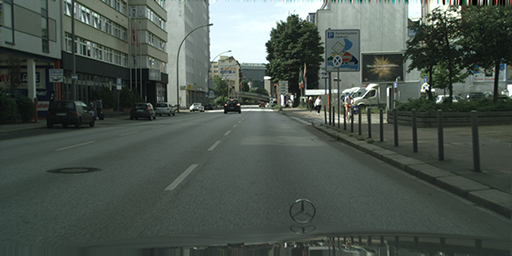
        </td>
        <td>
        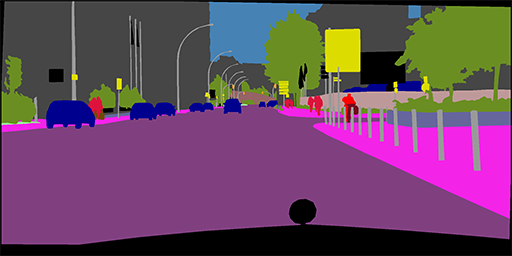
        </td>
    </tr>
    <tr>
        <td>Picture from the Cityscapes dataset.</td>
        <td>Semantic class assigned to each pixel. Every unique color corresponds to one class.</td>
    </tr>
</tbody>
</table>

Once you have a working solution, you can submit your output to the Cityscapes benchmark by creating an account and following [this link](https://www.cityscapes-dataset.com/submit/). We're excited to see where you will show up in the leaderboards!

Remember that this assignment determines 50% of your final grade. This amounts to **50 hours of active work** per student. Additionally, training your neural network will likely take many hours, take this into account when making your working schedule. This notebook downloads the required data for the benchmark and sets up a training pipeline so you can focus on creating networks using the skills you learned during this course. Some exercises have been included to get you started. Join us during computer class or message an assistant if you have any questions.

## Deliverables

Write a paper (one per group) in which you briefly introduce the problem, a baseline approach, your own addition(s), results and  conclusions. Use the **[IEEE double-column format](https://www.overleaf.com/latex/templates/ieee-conference-template/grfzhhncsfqn)** and **max. 4 pages**. You are allowed and expected to use ideas from literature and on the internet. Make sure you properly cite all the relevant sources in your paper. The assignment will be graded on paper quality, experimental setup, demonstrated insight and originality. What we at least expect is:

- Introduction to the problem: What are challenges? What are logical options to address them? What has been done for this or similar problems?
- Baseline implementation and results, using an off-the-shelf segmentation model.
- Improvements to that baseline, backed with experiments and results. Motivate your choices and explain your observations.
- Discussion on limitations and options to further improve.
- Clear and concise figures and tables to support your findings.

Submit your report and code to Canvas when you're finished.

## Requirements

You need at least Python version 3.7. The prefered library for creating your network is PyTorch. All third-party packages you need to run this notebook are imported below, such that you can install any missing dependencies before getting started.

In [1]:
import torch
import torchvision
import PIL
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

%matplotlib inline

#Inserted this as their was an ssl verification error that was occuring while trying to download CIFAR 10
import ssl
ssl._create_default_https_context = ssl._create_unverified_context


## Downloading and preprocessing the ground truth and input files
Let's start with downloading a ZIP-file that contains the training, testing and validation datasets.

In [2]:
import os
import sys
import shutil
import tempfile

from urllib.request import urlretrieve

# Data directory. Change this to download to a different directory, e.g. to an external drive to save space. 
# You need 20 GB to store all data.
# If you use Google Colab to run this notebook, then you may want to point this to a Google Drive directory shared
# between you and your assignment partner.
dir_data = os.path.abspath("data")

# URLs to retrieve ground truth and images data from. 
url_truth = 'https://flux127120.nbw.tue.nl/index.php/s/Cwxa5Ft2pQBK9N7/download'
dir_truth = os.path.join(dir_data, "gtFine")

url_input = 'https://flux127120.nbw.tue.nl/index.php/s/Tz3GCjQwwsiHgqC/download'
dir_input = os.path.join(dir_data, "leftImg8bit")

# Download and extraction function
def download_extract(url: str):
    # Create a temp directory to download into
    with tempfile.TemporaryDirectory(dir=dir_data, prefix="download_") as dir_temp:
        print(f'Downloading: {url}')
        zip_path = os.path.join(dir_temp, 'download.zip')
        urlretrieve(url, zip_path, lambda n, size, total: sys.stdout.write(f'\rProgress: {n*size/total*100:.2f} %'))
        sys.stdout.write('\n')
        sys.stdout.flush()
        
        print(f'Unpacking archive.')
        shutil.unpack_archive(zip_path, dir_data)

# Create the data directory (if it does not exist)
os.makedirs(dir_data, exist_ok=True)

# Check if both the ground truth and input directories have been downloaded and extracted
for dir, url in [(dir_truth, url_truth), (dir_input, url_input)]:
    if not os.path.isdir(dir):
        # Download the required files
        print(f'Directory does not exist: {dir}')
        download_extract(url)
    else:
        print(f'Directory already downloaded: {dir}')
        
# Done!
print(f'All data downloaded')

Directory already downloaded: D:\GB\TUe\Courses and Lectures\Quartile 3\CNN\Assignment-4\data\gtFine
Directory already downloaded: D:\GB\TUe\Courses and Lectures\Quartile 3\CNN\Assignment-4\data\leftImg8bit
All data downloaded


The downloaded images are very large. A consumer-grade PC likely does not have enough GPU-memory or data bandwidth to create a viable implementation in the original size. For this reason, we run a pre-processing step on the dataset that downscales all images. Once you have a working model, you may consider using a larger `sample_size`.

In [3]:
from PIL import Image

# Target size of each sample in the dataset
sample_size = (256, 128)

# Directories for preprocessed datasets
dir_truth_pp, dir_input_pp = (f'{d}_{sample_size[0]}_{sample_size[1]}' for d in (dir_truth, dir_input))

# Run preprocessing
for dir_full, dir_pp in ((dir_truth, dir_truth_pp), (dir_input, dir_input_pp)):
    # Check if the directory already exists
    if os.path.isdir(dir_pp):
        print(f'Preprocessed directory already exists: {dir_pp}')
        continue
        
    print(f'Preprocessing: {dir_full}')
        
    # Walk though the directory and preprocess each file 
    for root,_,files in  os.walk( dir_full ):
        if len(files) == 0:
            continue
            
        print(f'Preprocessing sub-directory: {root.replace(dir_full, "")}')
        
        # Create the directory in the preprocessed set
        root_pp = root.replace(dir_full, dir_pp)
        os.makedirs(root_pp, exist_ok=True)
        
        for f in files:
            if not f.endswith('.png'):
                continue
            
            # Resize and save PNG image
            path_original = os.path.join(root,f)
            img_resized = Image.open(path_original).resize(sample_size, Image.NEAREST)
            img_resized.save(path_original.replace(dir_full, dir_pp), 'png', quality=100)
            
print(f'Preprocessing done')

Preprocessed directory already exists: D:\GB\TUe\Courses and Lectures\Quartile 3\CNN\Assignment-4\data\gtFine_256_128
Preprocessed directory already exists: D:\GB\TUe\Courses and Lectures\Quartile 3\CNN\Assignment-4\data\leftImg8bit_256_128
Preprocessing done


## Data structures

Now that our data has been downloaded, we can proceed to define some data structures to model the structure of the provided data. Each semantic class that we aim to detect has a unique name, id and color. For more information on the datset, view [this link](https://www.cityscapes-dataset.com/dataset-overview/).

In [4]:
from dataclasses import dataclass
from typing import Tuple
import re

# Each sample we downloaded can be identified by the name of the city as well as a frame and sequence id
@dataclass
class CityscapesSample:
    city: str
    seq_id: str
    frame_id: str
    
    @property
    def id(self):
        return os.path.join(self.city, "_".join([self.city, self.seq_id, self.frame_id]))
    
    @staticmethod
    def from_filename(filename: str):
        # Create a CityscapesSample from a filename, which has a fixed structure {city}_{sequence}_{frame}
        match = re.match(r"^(\w+)_(\d+)_(\d+).*.png$", filename, re.I)
        return CityscapesSample(match.group(1), match.group(2), match.group(3))
            
    
# Each class that we aim to detect is assigned a name, id and color.
@dataclass
class CityscapesClass:
    name: str
    id: int
    color: Tuple[int, int, int]

# List of classes that we want to detect in the input
classes = [
    CityscapesClass('void', 0, (0, 0, 0)),
    CityscapesClass('dynamic', 1, (111, 74, 0)),
    CityscapesClass('ground', 2, (81, 0, 81)),
    CityscapesClass('road', 3, (128, 64, 128)),
    CityscapesClass('sidewalk', 4, (244, 35, 232)),
    CityscapesClass('parking', 5, (250, 170, 160)),
    CityscapesClass('rail track', 6, (230, 150, 140)),
    CityscapesClass('building', 7, (70, 70, 70)),
    CityscapesClass('wall', 8, (102, 102, 156)),
    CityscapesClass('fence', 9, (190, 153, 153)),
    CityscapesClass('guard rail', 10, (180, 165, 180)),
    CityscapesClass('bridge', 11, (150, 100, 100)),
    CityscapesClass('tunnel', 12, (150, 120, 90)),
    CityscapesClass('pole', 13, (153, 153, 153)),
    CityscapesClass('polegroup', 14, (153, 153, 153)),
    CityscapesClass('traffic light', 15, (250, 170, 30)),
    CityscapesClass('traffic sign', 16, (220, 220, 0)),
    CityscapesClass('vegetation', 17, (107, 142, 35)),
    CityscapesClass('terrain', 18, (152, 251, 152)),
    CityscapesClass('sky', 19, (70, 130, 180)),
    CityscapesClass('person', 20, (220, 20, 60)),
    CityscapesClass('rider', 21, (255, 0, 0)),
    CityscapesClass('car', 22, (0, 0, 142)),
    CityscapesClass('truck', 23, (0, 0, 70)),
    CityscapesClass('bus', 24, (0, 60, 100)),
    CityscapesClass('caravan', 25, (0, 0, 90)),
    CityscapesClass('trailer', 26, (0, 0, 110)),
    CityscapesClass('train', 27, (0, 80, 100)),
    CityscapesClass('motorcycle', 28, (0, 0, 230)),
    CityscapesClass('bicycle', 29, (119, 11, 32)),
]

## Dataset implementation

This section implements a [PyTorch Dataset](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html). It transforms image and target colorization pairs from the downloaded files into pairs of input and ground truth tensors. The ground truths are single-channel images where the value of each pixel is equal to the ID of the class represented by the color in the target. This will enable us to train the network using cross-entropy. 

In [246]:
# No data augmentation used for training baseline
import numpy as np

from torch.utils.data import Dataset
from PIL import Image
from typing import Dict, Optional, Tuple, List
from torchvision import transforms as tfs
import torchvision.transforms.functional as TF

class CityscapesDataset(Dataset):
    # Regular expression matching each PNG file in the dataset
    __read_reg = r"^(\w+)_(\d+)_(\d+).*.png$"

    def __init__(self, dir_input: str, dir_truth: str, sample_size: Tuple[int,int], classes: List[CityscapesSample]):
        super().__init__()
        
        # These variables are also available as globals, but it is good practice to make classes
        # not depend on global variables.
        self.dir_input = dir_input
        self.dir_truth = dir_truth
        self.sample_size = sample_size
        self.classes = classes

        # Walk through the inputs directory and add each file to our items list
        self.items = []
        for (_, _, filenames) in os.walk(self.dir_input):
            self.items.extend([CityscapesSample.from_filename(f) for f in filenames])

        # Sanity check: do the provided directories contain any samples?
        assert len(self.items) > 0, f"No items found in {self.dir_input}"

    def __len__(self):
        return len(self.items)

    def __getitem__(self, i: int) -> (torch.Tensor, torch.Tensor):
        sample = self.items[i]

        input = self.load_input(sample)
        truth = self.load_truth(sample)

        return self.transform(input, truth)

    def load_input(self, sample: CityscapesSample) -> Image:
        path = os.path.join(self.dir_input, f'{sample.id}_leftImg8bit.png')
        return Image.open(path).convert("RGB").resize(self.sample_size, Image.NEAREST)

    def load_truth(self, sample:CityscapesSample) -> Image:
        path = os.path.join(self.dir_truth, f'{sample.id}_gtFine_color.png')
        return Image.open(path).convert("RGB").resize(self.sample_size, Image.NEAREST)

    def transform(self, img: Image.Image, mask: Optional[Image.Image]) -> (torch.Tensor, torch.Tensor):
        ## EXERCISE #####################################################################
        #
        # Data augmentation is a way to improve the accuracy of a model.
        #
        # Once you have a model that works, you can implement some data augmentation 
        # techniques here to further improve performance.
        #
        ##################################################################################
        ################################################################################# 

        # Convert the image to a tensor
        img = TF.to_tensor(img)
        
        # If no mask is provided, then return only the image
        if mask is None:
            return img, None
        
        
        #################################################################################

        # Transform the mask from an image with RGB-colors to an 1-channel image with the index of the class as value
        mask_size = [s for s in self.sample_size]
        mask = torch.from_numpy(np.array(mask)).permute((2,0,1))
        target = torch.zeros((mask_size[1], mask_size[0]), dtype=torch.uint8)

        for i,c in enumerate(classes):
            eq = mask[0].eq(c.color[0]) & mask[1].eq(c.color[1]) & mask[2].eq(c.color[2])
            temp = eq * i
            target += temp

        return img, target

    def masks_to_indices(self, masks: torch.Tensor) -> torch.Tensor:
        _, indices = masks.softmax(dim=1).max(dim=1)
        return indices

    def to_image(self, indices: torch.Tensor) -> Image.Image:
        target = torch.zeros((3, indices.shape[0], indices.shape[1]),
                             dtype=torch.uint8, device=indices.device, requires_grad=False)

        for i, lbl in enumerate(self.classes):
            eq = indices.eq(i)

            target[0] += eq * lbl.color[0]
            target[1] += eq * lbl.color[1]
            target[2] += eq * lbl.color[2]

        return TF.to_pil_image(target.cpu(), 'RGB')
    
# Create one instance of the CityscapesDataset for each split type
ds_split = {
    name:CityscapesDataset(os.path.join(dir_input_pp, name), os.path.join(dir_truth_pp, name), sample_size, classes)
    for name in ("train", "val", "test")
}

In [252]:
# Data Augmentation Implentation
import numpy as np

from torch.utils.data import Dataset
from PIL import Image
from typing import Dict, Optional, Tuple, List
from torchvision import transforms as tfs
import torchvision.transforms.functional as TF

class CityscapesDataset(Dataset):
    # Regular expression matching each PNG file in the dataset
    __read_reg = r"^(\w+)_(\d+)_(\d+).*.png$"

    def __init__(self, dir_input: str, dir_truth: str, sample_size: Tuple[int,int], classes: List[CityscapesSample]):
        super().__init__()
        
        # These variables are also available as globals, but it is good practice to make classes
        # not depend on global variables.
        self.dir_input = dir_input
        self.dir_truth = dir_truth
        self.sample_size = sample_size
        self.classes = classes

        # Walk through the inputs directory and add each file to our items list
        self.items = []
        for (_, _, filenames) in os.walk(self.dir_input):
            self.items.extend([CityscapesSample.from_filename(f) for f in filenames])

        # Sanity check: do the provided directories contain any samples?
        assert len(self.items) > 0, f"No items found in {self.dir_input}"

    def __len__(self):
        return len(self.items)

    def __getitem__(self, i: int) -> (torch.Tensor, torch.Tensor):
        sample = self.items[i]

        input = self.load_input(sample)
        truth = self.load_truth(sample)

        return self.transform(input, truth)

    def load_input(self, sample: CityscapesSample) -> Image:
        path = os.path.join(self.dir_input, f'{sample.id}_leftImg8bit.png')
        return Image.open(path).convert("RGB").resize(self.sample_size, Image.NEAREST)

    def load_truth(self, sample:CityscapesSample) -> Image:
        path = os.path.join(self.dir_truth, f'{sample.id}_gtFine_color.png')
        return Image.open(path).convert("RGB").resize(self.sample_size, Image.NEAREST)

    def transform(self, img: Image.Image, mask: Optional[Image.Image]) -> (torch.Tensor, torch.Tensor):
        ## EXERCISE #####################################################################
        #
        # Data augmentation is a way to improve the accuracy of a model.
        #
        # Once you have a model that works, you can implement some data augmentation 
        # techniques here to further improve performance.
        #
        ##################################################################################
        ################################################################################# 

        # Convert the image to a tensor
        img = TF.to_tensor(img)
        
        # If no mask is provided, then return only the image
        if mask is None:
            return img, None
        
        if random.random()>0.8:
            # Vertical Flip
            img = TF.vflip(img)
            mask = TF.vflip(mask)
        
        elif random.random()>0.6 and random.random() <= 0.8:    
            # Implementing gaussian blur 
            blurrer = tfs.GaussianBlur(kernel_size=3,sigma=0.5)
            img = blurrer(img)
            
            # Adjusting Brightness
            b = random.random() + 0.7 # range(0.5,1.5)
            img = TF.adjust_brightness(img,b)
        
        #################################################################################

        # Transform the mask from an image with RGB-colors to an 1-channel image with the index of the class as value
        mask_size = [s for s in self.sample_size]
        mask = torch.from_numpy(np.array(mask)).permute((2,0,1))
        target = torch.zeros((mask_size[1], mask_size[0]), dtype=torch.uint8)

        for i,c in enumerate(classes):
            eq = mask[0].eq(c.color[0]) & mask[1].eq(c.color[1]) & mask[2].eq(c.color[2])
            temp = eq * i
            target += temp

        return img, target

    def masks_to_indices(self, masks: torch.Tensor) -> torch.Tensor:
        _, indices = masks.softmax(dim=1).max(dim=1)
        return indices

    def to_image(self, indices: torch.Tensor) -> Image.Image:
        target = torch.zeros((3, indices.shape[0], indices.shape[1]),
                             dtype=torch.uint8, device=indices.device, requires_grad=False)

        for i, lbl in enumerate(self.classes):
            eq = indices.eq(i)

            target[0] += eq * lbl.color[0]
            target[1] += eq * lbl.color[1]
            target[2] += eq * lbl.color[2]

        return TF.to_pil_image(target.cpu(), 'RGB')
    
# Create one instance of the CityscapesDataset for each split type
ds_split = {
    name:CityscapesDataset(os.path.join(dir_input_pp, name), os.path.join(dir_truth_pp, name), sample_size, classes)
    for name in ("train", "val", "test")
}

The Cityscapes dataset is split in three parts: `train`, `val` and `test`. If everything is set-up correctly, we should be able to draw a random sample from each split, convert it back to an image, and display it.

Subset,Amount,Size,Input sample,Truth sample
train,2975,256×128,,
val,500,256×128,,
test,1525,256×128,,

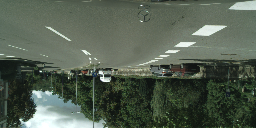
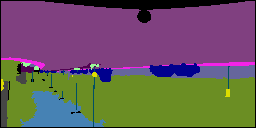
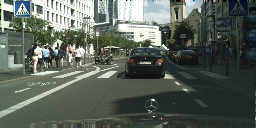
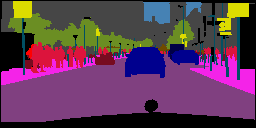
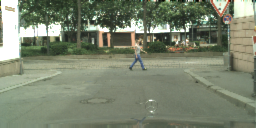
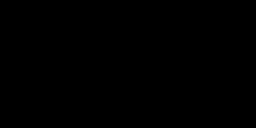

In [273]:
from IPython.display import display, HTML
from io import BytesIO
from base64 import b64encode

import random

# HTML templates for displaying random samples in a table
template_table = '<table><thead><tr><th>Subset</th><th>Amount</th><th>Size</th><th>Input sample</th><th>Truth sample</th></tr></thead><tbody>{0}</tbody></table>'
template_row = '<tr><td>{0}</td><td>{1}</td><td>{2}</td><td>{3}</td><td>{4}</td></tr>'
template_img = '<img src="data:image/png;base64,{0}"/>'

# Display a random sample of each split of the dataset
rows = []
for name, ds_sub in ds_split.items():    
    # Draw a random sample from the dataset so that we can convert it back to an image
    input, truth = random.choice(ds_sub)
    
    input = TF.to_pil_image(input)
    truth = ds_sub.to_image(truth)
    
    # Create a buffer to save each retrieved image into such that we can base64-encode it for diplay in our HTML table
    with BytesIO() as buffer_input, BytesIO() as buffer_truth: 
        input.save(buffer_input, format='png')
        truth.save(buffer_truth, format='png')

        # Store one row of the dataset
        images = [template_img.format(b64encode(b.getvalue()).decode('utf-8')) for b in (buffer_input, buffer_truth)]
        rows.append(template_row.format(name, len(ds_sub), '&times;'.join([str(s) for s in input.size]), *images))

# Render HTML table
table = template_table.format(''.join(rows))
display(HTML(table))


Notice that the `test` set has no ground truth labels, as this is the set used to score competitors' networks against each other. If you submit the best network that you have created to the Cityscapes competition, this is the set that is used to calculate your score.

## Calculating accuracy
Your score on the benchmark will be calculated according to the the intersection-over-union (IoU) metric. [This link](https://www.cityscapes-dataset.com/benchmarks/#scene-labeling-task) describes how it is implemented in the testing suite. 

The function below is thus a measure for the accuracy of your solution. The `output` parameter represents the output of your network: a batch of multi-dimensional images with one channel per class. For every pixel, the class ID can be calculated by taking the index of the channel containing the maximum value. The `truths` parameter is a batch of ground truths from the `CityscapesDataset` defined above.

In [262]:
from sklearn.metrics import jaccard_score
def compute_iou(output: torch.Tensor, truths: torch.Tensor) -> float:
    # May want to re-think after understanding the output of U-net
    
    output = output.cpu().detach().numpy()
    truths = truths.cpu().detach().numpy()
  
    ## EXERCISE #####################################################################
    #
    # Implement the IoU metric that is used by the benchmark to grade your results.
    #     
    # `output` is a tensor of dimensions [Batch, Classes, Height, Width]
    # `truths` is a tensor of dimensions [Batch, Height, Width]
    #
    # Tip: Peform a sanity check that tests your implementation on a user-defined 
    #      tensor for which you know what the output should be.
    #
    ################################################################################# 
    
    # Getting the class id of each pixel
    classid_out = np.argmax(output, axis = 1)

    # Flattening the vector for input into jaccard score function
    classid_out = classid_out.ravel()
    truths = truths.ravel()

    num_class = 30
    IOU = []
    for class_id in range(1, num_class):
        iou_class = jaccard_score(classid_out == class_id, truths == class_id, average='macro')
        IOU.append(iou_class)  

    #################################################################################
    return np.mean(IOU)

## Training setup
The final step before you can implement your networks is to define the training process.

In [284]:
from torch import nn, optim
from torch.utils.data import DataLoader
    
class Trainer:
    def __init__(self, model: nn.Module, ds_split: Dict[str,CityscapesDataset]):
        # Choose a device to run training on. Ideally, you have a GPU available to accelerate the training process.
        
        #self.device = "cpu"
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        
        # Move the model onto the target device
        self.model = model.to(self.device)
        
        # Store the dataset split
        self.ds_split = ds_split
        
        ## EXERCISE #####################################################################
        #
        # Select an optimizer
        #
        # See: https://pytorch.org/docs/stable/optim.html
        #
        ################################################################################# 
        
        self.optimizer = optim.Adam(model.parameters(), lr=0.001)
        
        ## EXERCISE #####################################################################
        #
        # Select an appropriate loss function
        #
        # See: https://pytorch.org/docs/stable/nn.html#loss-functions
        #
        ################################################################################# 
        
        self.critereon = nn.CrossEntropyLoss()
        
        ################################################################################# 
        
        assert self.critereon is not None, "You have not defined a loss"
        assert self.optimizer is not None, "You have not defined an optimizer"
        
    def train_epoch(self, dl:DataLoader):
        # Put the model in training mode
        self.model.train()
        
        # Store each step's accuracy and loss for this epoch
        epoch_metrics = {
            "loss": [],
            "accuracy": []
        }
        
        # Create a progress bar using TQDM
        sys.stdout.flush()
        with tqdm(total=len(self.ds_split["train"]), desc=f'Training') as pbar:
            # Iterate over the training dataset
            for inputs, truths in dl:
                # Zero the gradients from the previous step
                self.optimizer.zero_grad()
                
                # Move the inputs and truths to the target device
                inputs = inputs.to(device=self.device, dtype=torch.float32)
                
                print(inputs.shape)
                
                inputs.required_grad = True  # Fix for older PyTorch versions
                truths = truths.to(device=self.device, dtype=torch.long)
                
                # Run model on the inputs
                output = self.model(inputs)

                # Perform backpropagation
                loss = self.critereon(output, truths)
                loss.backward()
                nn.utils.clip_grad_value_(model.parameters(), 0.1)
                self.optimizer.step()
                
                # Store the metrics of this step
                step_metrics = {
                    'loss': loss.item(),
                    'accuracy': compute_iou(output, truths)
                }
                
                # Update the progress bar
                pbar.set_postfix(**step_metrics)
                pbar.update(list(inputs.shape)[0])
                
                # Add to epoch's metrics
                for k,v in step_metrics.items():
                    epoch_metrics[k].append(v)

        sys.stdout.flush()
        
        # Return metrics
        return epoch_metrics
    
    def val_epoch(self, dl:DataLoader):
        # Put the model in evaluation mode
        self.model.eval()
        
        # Store the total loss and accuracy over the epoch
        amount = 0
        total_loss = 0
        total_accuracy = 0
        
        # Create a progress bar using TQDM
        sys.stdout.flush()
        with torch.no_grad(), tqdm(total=len(self.ds_split["val"]), desc=f'Validation') as pbar:
            # Iterate over the validation dataloader
            for inputs, truths in dl:
                 # Move the inputs and truths to the target device
                inputs = inputs.to(device=self.device, dtype=torch.float32)
                inputs.required_grad = True  # Fix for older PyTorch versions
                truths = truths.to(device=self.device, dtype=torch.long)

                # Run model on the inputs
                output = self.model(inputs)
                loss = self.critereon(output, truths)
                
              

                # Store the metrics of this step
                step_metrics = {
                    'loss': loss.item(),
                    'accuracy': compute_iou(output, truths)
                }

                # Update the progress bar
                pbar.set_postfix(**step_metrics)
                pbar.update(list(inputs.shape)[0])

                amount += 1
                total_loss += step_metrics["loss"]
                total_accuracy += step_metrics["accuracy"]
        sys.stdout.flush()
        
        # Print mean of metrics
        total_loss /= amount
        total_accuracy /= amount
        print(f'Validation loss is {total_loss/amount}, validation accuracy is {total_accuracy}')
              
        # Return mean loss and accuracy
        return {
            "loss": [total_loss],
            "accuracy": [total_accuracy]
        }
            
        
    def fit(self, epochs: int, batch_size:int):
        # Initialize Dataloaders for the `train` and `val` splits of the dataset. 
        # A Dataloader loads a batch of samples from the each dataset split and concatenates these samples into a batch.
        dl_train = DataLoader(ds_split["train"], batch_size=batch_size, shuffle=True)
        dl_val = DataLoader(ds_split["val"], batch_size=batch_size, drop_last=True)
                
        # Store metrics of the training process (plot this to gain insight)
        df_train = pd.DataFrame()
        df_val = pd.DataFrame()
        
        # Train the model for the provided amount of epochs
        for epoch in range(1, epochs+1):
            print(f'Epoch {epoch}')
            metrics_train = self.train_epoch(dl_train)
            df_train = df_train.append(pd.DataFrame({'epoch': [epoch for _ in range(len(metrics_train["loss"]))], **metrics_train}), ignore_index=True)
            
            metrics_val = self.val_epoch(dl_val)            
            df_val = df_val.append(pd.DataFrame({'epoch': [epoch], **metrics_val}), ignore_index=True) 
            
        # Return a dataframe that logs the training process. This can be exported to a CSV or plotted directly.
        return df_train, df_val


We can do a quick sanity check by creating a pass-through network that transforms the expected input shape into the output shape. While we don't expect this to solve the semantic segmentation problem, it does provide a way to test whether the inputs, truths and outputs are passed through the `Trainer` class correctly.

In [193]:
from torch import nn
import torch.nn.functional as F

# Define a module that transforms: RGB-channel image -> len(classes)-channel image
class Passthrough(nn.Module):
    def __init__(self, n_channels=3, n_classes=len(classes)):
        super().__init__()
        
        self.transform = nn.Conv2d(n_channels, n_classes, 1)
        
    def forward(self, x):
        x = F.softmax(self.transform(x), dim=1)
        return x
    
model = Passthrough()
    
# Train the passthrough network
print("Testing training process...")
trainer = Trainer(model, ds_split)
trainer.fit(epochs=1, batch_size=10)

# Draw a random sample
input, truth = random.choice(ds_split["val"])

# Push through our network
model = model.cpu()
output = model(input.unsqueeze(0))

# Display the input, output and truth tensors
template_table = '<table><thead><tr><th>Tensor</th><th>Shape</th><th>Image</th></tr></thead><tbody>{0}</tbody></table>'
template_row = '<tr><td>{0}</td><td>{1}</td><td><img src="data:image/png;base64,{2}"/></td></tr>'

input_img = TF.to_pil_image(input)
output_img = ds_split["val"].to_image(ds_split["val"].masks_to_indices(output).squeeze(0))
truth_img = ds_split["val"].to_image(truth)

rows = []
for name, tensor, img in [('Input', input, input_img), ('Output', output, output_img), ('Target', truth, truth_img)]:
    with BytesIO() as b: 
        img.save(b, format='png')
        rows.append(template_row.format(name, list(tensor.shape), b64encode(b.getvalue()).decode('utf-8')))

# Render HTML table
table = template_table.format(''.join(rows))
display(HTML(table))

Testing training process...
Epoch 1


Training:   0%|                                                                               | 0/2975 [00:00<?, ?it/s]

torch.Size([10, 3, 128, 256])


Training:   0%|▏                                           | 10/2975 [00:01<09:32,  5.18it/s, accuracy=0.594, loss=3.4]

torch.Size([10, 3, 128, 256])


Training:   1%|▎                                           | 20/2975 [00:04<10:01,  4.91it/s, accuracy=0.612, loss=3.4]

torch.Size([10, 3, 128, 256])


Training:   1%|▍                                           | 30/2975 [00:06<09:53,  4.96it/s, accuracy=0.628, loss=3.4]

torch.Size([10, 3, 128, 256])


Training:   1%|▌                                           | 40/2975 [00:08<09:52,  4.95it/s, accuracy=0.612, loss=3.4]

torch.Size([10, 3, 128, 256])


Training:   2%|▋                                           | 50/2975 [00:10<09:46,  4.99it/s, accuracy=0.522, loss=3.4]

torch.Size([10, 3, 128, 256])


Training:   2%|▉                                           | 60/2975 [00:11<09:40,  5.02it/s, accuracy=0.613, loss=3.4]

torch.Size([10, 3, 128, 256])


Training:   2%|█                                          | 70/2975 [00:13<09:38,  5.03it/s, accuracy=0.631, loss=3.39]

torch.Size([10, 3, 128, 256])


Training:   3%|█▏                                          | 80/2975 [00:15<09:34,  5.03it/s, accuracy=0.612, loss=3.4]

torch.Size([10, 3, 128, 256])


Training:   3%|█▎                                          | 90/2975 [00:17<09:21,  5.13it/s, accuracy=0.593, loss=3.4]

torch.Size([10, 3, 128, 256])


Training:   3%|█▍                                         | 100/2975 [00:19<09:14,  5.18it/s, accuracy=0.611, loss=3.4]

torch.Size([10, 3, 128, 256])


Training:   4%|█▌                                         | 110/2975 [00:21<09:17,  5.14it/s, accuracy=0.612, loss=3.4]

torch.Size([10, 3, 128, 256])


Training:   4%|█▋                                        | 120/2975 [00:23<09:09,  5.19it/s, accuracy=0.613, loss=3.39]

torch.Size([10, 3, 128, 256])


Training:   4%|█▊                                        | 130/2975 [00:25<09:07,  5.20it/s, accuracy=0.579, loss=3.39]

torch.Size([10, 3, 128, 256])


Training:   5%|█▉                                        | 140/2975 [00:27<09:03,  5.22it/s, accuracy=0.596, loss=3.39]

torch.Size([10, 3, 128, 256])


Training:   5%|██                                        | 150/2975 [00:29<09:03,  5.20it/s, accuracy=0.597, loss=3.39]

torch.Size([10, 3, 128, 256])


Training:   5%|██▎                                       | 160/2975 [00:31<09:06,  5.15it/s, accuracy=0.613, loss=3.39]

torch.Size([10, 3, 128, 256])


Training:   6%|██▍                                        | 170/2975 [00:33<09:09,  5.10it/s, accuracy=0.596, loss=3.4]

torch.Size([10, 3, 128, 256])


Training:   6%|██▌                                       | 180/2975 [00:35<09:05,  5.13it/s, accuracy=0.612, loss=3.39]

torch.Size([10, 3, 128, 256])


Training:   6%|██▋                                        | 190/2975 [00:37<08:59,  5.16it/s, accuracy=0.578, loss=3.4]

torch.Size([10, 3, 128, 256])


Training:   7%|██▉                                        | 200/2975 [00:39<09:03,  5.10it/s, accuracy=0.629, loss=3.4]

torch.Size([10, 3, 128, 256])


Training:   7%|███                                        | 210/2975 [00:41<08:55,  5.16it/s, accuracy=0.576, loss=3.4]

torch.Size([10, 3, 128, 256])


Training:   7%|███▏                                       | 220/2975 [00:43<08:54,  5.15it/s, accuracy=0.628, loss=3.4]

torch.Size([10, 3, 128, 256])


Training:   8%|███▎                                       | 230/2975 [00:44<08:54,  5.14it/s, accuracy=0.578, loss=3.4]

torch.Size([10, 3, 128, 256])


Training:   8%|███▍                                      | 240/2975 [00:46<08:46,  5.19it/s, accuracy=0.563, loss=3.39]

torch.Size([10, 3, 128, 256])


Training:   8%|███▌                                      | 250/2975 [00:48<08:42,  5.21it/s, accuracy=0.596, loss=3.39]

torch.Size([10, 3, 128, 256])


Training:   9%|███▊                                       | 260/2975 [00:50<08:33,  5.28it/s, accuracy=0.559, loss=3.4]

torch.Size([10, 3, 128, 256])


Training:   9%|███▊                                      | 270/2975 [00:52<08:30,  5.29it/s, accuracy=0.596, loss=3.39]

torch.Size([10, 3, 128, 256])


Training:   9%|████                                       | 280/2975 [00:54<08:35,  5.23it/s, accuracy=0.594, loss=3.4]

torch.Size([10, 3, 128, 256])


Training:  10%|████▏                                      | 290/2975 [00:56<08:30,  5.26it/s, accuracy=0.595, loss=3.4]

torch.Size([10, 3, 128, 256])


Training:  10%|████▏                                      | 290/2975 [00:57<08:55,  5.02it/s, accuracy=0.595, loss=3.4]


KeyboardInterrupt: 

If the section above ran without errors, then you are ready to continue.

## Define a baseline
You should start by implementing a network that performs semantic segmentation reasonably well (e.g. [U-Net](https://arxiv.org/pdf/1505.04597.pdf)). This will be the baseline against which you can compare your own improvements.

In [249]:
# Defining the U-Net Model as baseline

# Used the following sites as reference for the pytorch implementation 
# 1. https://github.com/milesial/Pytorch-UNet/blob/master/unet/unet_model.py
# 2. https://theaisummer.com/unet-architectures/

# Class to perform series of 3X3 convolutions

from torch import nn
import torch.nn.functional as F
class DoubleConv(nn.Module):
    
    def __init__(self, in_channels, out_channels, mid_channels = None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.doubleconv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size = 3, padding = 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size = 3, padding = 1),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.doubleconv(x)

# Class to perform max pool followed by the Double conv

class Downconv(nn.Module):
    
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpoolconv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpoolconv(x)

# Class to perform the upsampling plus the convolutions along with the concatenation

class Upconv(nn.Module):
    
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

# Building the U-net class

class UNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(UNet, self).__init__()
        
        #Input Conv
        self.in_channels = in_channels
        self.num_classes = num_classes
        
        self.inconv = DoubleConv(in_channels, 64)
        
        self.dconv1 = Downconv(64, 128)
        self.dconv2 = Downconv(128, 256)
        self.dconv3 = Downconv(256, 512)
        self.dconv4 = Downconv(512, 512)
        
        self.up1 = Upconv(1024, 256)
        self.up2 = Upconv(512, 128)
        self.up3 = Upconv(256, 64)
        self.up4 = Upconv(128, 64)
        
        self.outconv = nn.Conv2d(64, num_classes, kernel_size=1)
        
    def forward(self, x):
        
        x1 = self.inconv(x)
        x2 = self.dconv1(x1)
        x3 = self.dconv2(x2)
        x4 = self.dconv3(x3)
        x5 = self.dconv4(x4)
        
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outconv(x)
        
        return x


In [250]:
# Function to check if model is built correctly
def test_UNet():
    x = torch.zeros((10, 3, 128, 256), dtype=torch.float32)
    num_classes = 10
    model = UNet(3, num_classes)
    out = model(x)
    print(out.size()) # Expect to see [10, 10, 128, 256]
test_UNet()

torch.Size([10, 10, 128, 256])


In [216]:
torch.cuda.empty_cache()

Starting training process...
Epoch 1


Training:   0%|                                                                               | 0/2975 [00:00<?, ?it/s]

torch.Size([10, 3, 128, 256])


Training:   0%|▏                                          | 10/2975 [00:02<10:29,  4.71it/s, accuracy=0.553, loss=3.39]

torch.Size([10, 3, 128, 256])


Training:   1%|▎                                          | 20/2975 [00:04<10:21,  4.75it/s, accuracy=0.554, loss=3.37]

torch.Size([10, 3, 128, 256])


Training:   1%|▍                                          | 30/2975 [00:06<10:18,  4.76it/s, accuracy=0.627, loss=2.65]

torch.Size([10, 3, 128, 256])


Training:   1%|▌                                          | 40/2975 [00:08<10:17,  4.75it/s, accuracy=0.597, loss=3.32]

torch.Size([10, 3, 128, 256])


Training:   2%|▋                                          | 50/2975 [00:10<10:22,  4.70it/s, accuracy=0.618, loss=3.31]

torch.Size([10, 3, 128, 256])


Training:   2%|▊                                          | 60/2975 [00:12<10:24,  4.67it/s, accuracy=0.629, loss=3.27]

torch.Size([10, 3, 128, 256])


Training:   2%|█                                          | 70/2975 [00:14<10:21,  4.67it/s, accuracy=0.596, loss=3.09]

torch.Size([10, 3, 128, 256])


Training:   3%|█▏                                         | 80/2975 [00:17<10:20,  4.67it/s, accuracy=0.577, loss=2.83]

torch.Size([10, 3, 128, 256])


Training:   3%|█▎                                         | 90/2975 [00:19<10:20,  4.65it/s, accuracy=0.634, loss=2.88]

torch.Size([10, 3, 128, 256])


Training:   3%|█▍                                        | 100/2975 [00:21<10:19,  4.64it/s, accuracy=0.598, loss=2.68]

torch.Size([10, 3, 128, 256])


Training:   4%|█▌                                        | 110/2975 [00:23<10:14,  4.66it/s, accuracy=0.618, loss=3.83]

torch.Size([10, 3, 128, 256])


Training:   4%|█▋                                        | 120/2975 [00:25<10:12,  4.66it/s, accuracy=0.634, loss=2.54]

torch.Size([10, 3, 128, 256])


Training:   4%|█▊                                        | 130/2975 [00:27<10:12,  4.64it/s, accuracy=0.651, loss=2.83]

torch.Size([10, 3, 128, 256])


Training:   5%|█▉                                        | 140/2975 [00:29<10:06,  4.67it/s, accuracy=0.633, loss=2.85]

torch.Size([10, 3, 128, 256])


Training:   5%|██                                        | 150/2975 [00:32<10:01,  4.70it/s, accuracy=0.634, loss=2.68]

torch.Size([10, 3, 128, 256])


Training:   5%|██▎                                       | 160/2975 [00:34<09:57,  4.71it/s, accuracy=0.581, loss=2.62]

torch.Size([10, 3, 128, 256])


Training:   6%|██▍                                       | 170/2975 [00:36<09:54,  4.72it/s, accuracy=0.615, loss=2.45]

torch.Size([10, 3, 128, 256])


Training:   6%|██▋                                         | 180/2975 [00:38<09:51,  4.72it/s, accuracy=0.6, loss=2.19]

torch.Size([10, 3, 128, 256])


Training:   6%|██▋                                        | 190/2975 [00:40<09:57,  4.66it/s, accuracy=0.622, loss=2.3]

torch.Size([10, 3, 128, 256])


Training:   7%|██▉                                         | 200/2975 [00:42<10:00,  4.62it/s, accuracy=0.6, loss=2.42]

torch.Size([10, 3, 128, 256])


Training:   7%|██▉                                       | 210/2975 [00:44<09:52,  4.67it/s, accuracy=0.599, loss=2.39]

torch.Size([10, 3, 128, 256])


Training:   7%|███                                       | 220/2975 [00:46<09:47,  4.69it/s, accuracy=0.567, loss=2.21]

torch.Size([10, 3, 128, 256])


Training:   8%|███▏                                      | 230/2975 [00:49<09:43,  4.70it/s, accuracy=0.616, loss=2.19]

torch.Size([10, 3, 128, 256])


Training:   8%|███▍                                      | 240/2975 [00:51<09:42,  4.69it/s, accuracy=0.581, loss=2.32]

torch.Size([10, 3, 128, 256])


Training:   8%|███▌                                      | 250/2975 [00:53<09:41,  4.69it/s, accuracy=0.599, loss=2.26]

torch.Size([10, 3, 128, 256])


Training:   9%|███▋                                      | 260/2975 [00:55<09:51,  4.59it/s, accuracy=0.599, loss=2.13]

torch.Size([10, 3, 128, 256])


Training:   9%|███▊                                      | 270/2975 [00:57<09:51,  4.58it/s, accuracy=0.564, loss=2.21]

torch.Size([10, 3, 128, 256])


Training:   9%|███▉                                      | 280/2975 [01:00<09:47,  4.59it/s, accuracy=0.633, loss=2.31]

torch.Size([10, 3, 128, 256])


Training:  10%|████                                      | 290/2975 [01:02<09:47,  4.57it/s, accuracy=0.632, loss=2.35]

torch.Size([10, 3, 128, 256])


Training:  10%|████▏                                     | 300/2975 [01:04<09:44,  4.58it/s, accuracy=0.548, loss=2.19]

torch.Size([10, 3, 128, 256])


Training:  10%|████▍                                     | 310/2975 [01:06<09:45,  4.55it/s, accuracy=0.599, loss=2.38]

torch.Size([10, 3, 128, 256])


Training:  11%|████▌                                     | 320/2975 [01:08<09:42,  4.56it/s, accuracy=0.634, loss=2.09]

torch.Size([10, 3, 128, 256])


Training:  11%|████▊                                      | 330/2975 [01:10<09:38,  4.57it/s, accuracy=0.616, loss=2.3]

torch.Size([10, 3, 128, 256])


Training:  11%|████▉                                      | 340/2975 [01:13<09:27,  4.64it/s, accuracy=0.67, loss=1.98]

torch.Size([10, 3, 128, 256])


Training:  12%|████▉                                     | 350/2975 [01:15<09:19,  4.69it/s, accuracy=0.651, loss=2.07]

torch.Size([10, 3, 128, 256])


Training:  12%|█████▎                                      | 360/2975 [01:17<09:12,  4.73it/s, accuracy=0.6, loss=2.04]

torch.Size([10, 3, 128, 256])


Training:  12%|█████▏                                    | 370/2975 [01:19<09:07,  4.76it/s, accuracy=0.581, loss=2.12]

torch.Size([10, 3, 128, 256])


Training:  13%|█████▎                                    | 380/2975 [01:21<09:03,  4.78it/s, accuracy=0.564, loss=2.22]

torch.Size([10, 3, 128, 256])


Training:  13%|█████▌                                    | 390/2975 [01:23<08:59,  4.79it/s, accuracy=0.582, loss=2.19]

torch.Size([10, 3, 128, 256])


Training:  13%|█████▋                                    | 400/2975 [01:25<09:04,  4.73it/s, accuracy=0.582, loss=2.04]

torch.Size([10, 3, 128, 256])


Training:  14%|█████▊                                    | 410/2975 [01:27<09:03,  4.72it/s, accuracy=0.547, loss=2.21]

torch.Size([10, 3, 128, 256])


Training:  14%|█████▉                                    | 420/2975 [01:29<09:01,  4.72it/s, accuracy=0.617, loss=2.03]

torch.Size([10, 3, 128, 256])


Training:  14%|██████                                    | 430/2975 [01:32<09:02,  4.69it/s, accuracy=0.598, loss=2.16]

torch.Size([10, 3, 128, 256])


Training:  15%|██████▏                                   | 440/2975 [01:34<08:59,  4.70it/s, accuracy=0.599, loss=1.96]

torch.Size([10, 3, 128, 256])


Training:  15%|██████▎                                   | 450/2975 [01:36<08:57,  4.70it/s, accuracy=0.598, loss=2.08]

torch.Size([10, 3, 128, 256])


Training:  15%|██████▍                                   | 460/2975 [01:38<08:54,  4.71it/s, accuracy=0.616, loss=2.17]

torch.Size([10, 3, 128, 256])


Training:  16%|██████▋                                   | 470/2975 [01:40<08:52,  4.71it/s, accuracy=0.598, loss=2.08]

torch.Size([10, 3, 128, 256])


Training:  16%|██████▊                                   | 480/2975 [01:42<08:48,  4.72it/s, accuracy=0.615, loss=2.25]

torch.Size([10, 3, 128, 256])


Training:  16%|██████▉                                   | 490/2975 [01:44<08:46,  4.72it/s, accuracy=0.583, loss=2.07]

torch.Size([10, 3, 128, 256])


Training:  17%|███████                                   | 500/2975 [01:46<08:44,  4.72it/s, accuracy=0.599, loss=2.15]

torch.Size([10, 3, 128, 256])


Training:  17%|████████                                       | 510/2975 [01:49<08:45,  4.69it/s, accuracy=0.6, loss=2]

torch.Size([10, 3, 128, 256])


Training:  17%|███████▋                                    | 520/2975 [01:51<08:44,  4.68it/s, accuracy=0.65, loss=2.1]

torch.Size([10, 3, 128, 256])


Training:  18%|███████▍                                  | 530/2975 [01:53<08:43,  4.67it/s, accuracy=0.634, loss=2.03]

torch.Size([10, 3, 128, 256])


Training:  18%|███████▌                                  | 540/2975 [01:55<08:39,  4.69it/s, accuracy=0.616, loss=2.04]

torch.Size([10, 3, 128, 256])


Training:  18%|████████▏                                   | 550/2975 [01:57<08:37,  4.68it/s, accuracy=0.6, loss=1.97]

torch.Size([10, 3, 128, 256])


Training:  19%|███████▉                                  | 560/2975 [01:59<08:34,  4.70it/s, accuracy=0.636, loss=1.96]

torch.Size([10, 3, 128, 256])


Training:  19%|████████                                  | 570/2975 [02:01<08:35,  4.67it/s, accuracy=0.601, loss=2.13]

torch.Size([10, 3, 128, 256])


Training:  19%|████████▏                                 | 580/2975 [02:04<08:33,  4.66it/s, accuracy=0.583, loss=2.19]

torch.Size([10, 3, 128, 256])


Training:  20%|████████▎                                 | 590/2975 [02:06<08:34,  4.63it/s, accuracy=0.638, loss=2.02]

torch.Size([10, 3, 128, 256])


Training:  20%|████████▍                                 | 600/2975 [02:08<08:29,  4.66it/s, accuracy=0.605, loss=2.02]

torch.Size([10, 3, 128, 256])


Training:  21%|████████▌                                 | 610/2975 [02:10<08:27,  4.66it/s, accuracy=0.583, loss=2.12]

torch.Size([10, 3, 128, 256])


Training:  21%|████████▊                                 | 620/2975 [02:12<08:27,  4.64it/s, accuracy=0.601, loss=2.13]

torch.Size([10, 3, 128, 256])


Training:  21%|████████▉                                 | 630/2975 [02:14<08:27,  4.62it/s, accuracy=0.618, loss=2.12]

torch.Size([10, 3, 128, 256])


Training:  22%|█████████                                 | 640/2975 [02:16<08:23,  4.63it/s, accuracy=0.619, loss=1.98]

torch.Size([10, 3, 128, 256])


Training:  22%|█████████▏                                | 650/2975 [02:19<08:22,  4.63it/s, accuracy=0.622, loss=2.01]

torch.Size([10, 3, 128, 256])


Training:  22%|█████████▎                                | 660/2975 [02:21<08:25,  4.58it/s, accuracy=0.628, loss=1.91]

torch.Size([10, 3, 128, 256])


Training:  23%|█████████▍                                | 670/2975 [02:23<08:20,  4.61it/s, accuracy=0.626, loss=2.11]

torch.Size([10, 3, 128, 256])


Training:  23%|█████████▌                                | 680/2975 [02:25<08:21,  4.57it/s, accuracy=0.573, loss=2.05]

torch.Size([10, 3, 128, 256])


Training:  23%|█████████▋                                | 690/2975 [02:27<08:18,  4.58it/s, accuracy=0.648, loss=1.84]

torch.Size([10, 3, 128, 256])


Training:  24%|██████████▌                                  | 700/2975 [02:30<08:13,  4.61it/s, accuracy=0.633, loss=2]

torch.Size([10, 3, 128, 256])


Training:  24%|██████████                                | 710/2975 [02:32<08:08,  4.63it/s, accuracy=0.612, loss=1.91]

torch.Size([10, 3, 128, 256])


Training:  24%|██████████▏                               | 720/2975 [02:34<08:07,  4.63it/s, accuracy=0.643, loss=1.93]

torch.Size([10, 3, 128, 256])


Training:  25%|██████████▎                               | 730/2975 [02:36<08:04,  4.63it/s, accuracy=0.646, loss=1.92]

torch.Size([10, 3, 128, 256])


Training:  25%|██████████▍                               | 740/2975 [02:38<07:59,  4.66it/s, accuracy=0.648, loss=2.06]

torch.Size([10, 3, 128, 256])


Training:  25%|██████████▌                               | 750/2975 [02:40<07:55,  4.68it/s, accuracy=0.645, loss=2.06]

torch.Size([10, 3, 128, 256])


Training:  26%|██████████▋                               | 760/2975 [02:42<07:52,  4.68it/s, accuracy=0.615, loss=1.81]

torch.Size([10, 3, 128, 256])


Training:  26%|██████████▊                               | 770/2975 [02:45<07:52,  4.67it/s, accuracy=0.614, loss=2.11]

torch.Size([10, 3, 128, 256])


Training:  26%|███████████▎                               | 780/2975 [02:47<07:58,  4.59it/s, accuracy=0.58, loss=1.86]

torch.Size([10, 3, 128, 256])


Training:  27%|███████████▏                              | 790/2975 [02:49<07:55,  4.60it/s, accuracy=0.573, loss=1.92]

torch.Size([10, 3, 128, 256])


Training:  27%|███████████▎                              | 800/2975 [02:51<07:49,  4.63it/s, accuracy=0.609, loss=1.99]

torch.Size([10, 3, 128, 256])


Training:  27%|███████████▍                              | 810/2975 [02:53<07:42,  4.68it/s, accuracy=0.616, loss=1.86]

torch.Size([10, 3, 128, 256])


Training:  28%|███████████▌                              | 820/2975 [02:55<07:38,  4.70it/s, accuracy=0.649, loss=1.76]

torch.Size([10, 3, 128, 256])


Training:  28%|███████████▋                              | 830/2975 [02:57<07:36,  4.70it/s, accuracy=0.613, loss=1.75]

torch.Size([10, 3, 128, 256])


Training:  28%|███████████▊                              | 840/2975 [03:00<07:34,  4.70it/s, accuracy=0.582, loss=1.91]

torch.Size([10, 3, 128, 256])


Training:  29%|████████████                              | 850/2975 [03:02<07:31,  4.71it/s, accuracy=0.639, loss=1.79]

torch.Size([10, 3, 128, 256])


Training:  29%|████████████▏                             | 860/2975 [03:04<07:29,  4.71it/s, accuracy=0.638, loss=1.91]

torch.Size([10, 3, 128, 256])


Training:  29%|████████████▎                             | 870/2975 [03:06<07:28,  4.69it/s, accuracy=0.584, loss=1.95]

torch.Size([10, 3, 128, 256])


Training:  30%|████████████▍                             | 880/2975 [03:08<07:26,  4.70it/s, accuracy=0.623, loss=1.74]

torch.Size([10, 3, 128, 256])


Training:  30%|████████████▌                             | 890/2975 [03:10<07:25,  4.68it/s, accuracy=0.638, loss=1.84]

torch.Size([10, 3, 128, 256])


Training:  30%|████████████▋                             | 900/2975 [03:12<07:23,  4.68it/s, accuracy=0.644, loss=1.88]

torch.Size([10, 3, 128, 256])


Training:  31%|█████████████▏                             | 910/2975 [03:14<07:21,  4.68it/s, accuracy=0.63, loss=1.89]

torch.Size([10, 3, 128, 256])


Training:  31%|████████████▉                             | 920/2975 [03:17<07:19,  4.67it/s, accuracy=0.607, loss=1.99]

torch.Size([10, 3, 128, 256])


Training:  31%|█████████████▏                            | 930/2975 [03:19<07:18,  4.67it/s, accuracy=0.614, loss=1.83]

torch.Size([10, 3, 128, 256])


Training:  32%|█████████████▎                            | 940/2975 [03:21<07:15,  4.67it/s, accuracy=0.617, loss=1.85]

torch.Size([10, 3, 128, 256])


Training:  32%|█████████████▍                            | 950/2975 [03:23<07:13,  4.67it/s, accuracy=0.638, loss=2.03]

torch.Size([10, 3, 128, 256])


Training:  32%|█████████████▉                             | 960/2975 [03:25<07:09,  4.69it/s, accuracy=0.646, loss=1.8]

torch.Size([10, 3, 128, 256])


Training:  33%|█████████████▋                            | 970/2975 [03:27<07:07,  4.69it/s, accuracy=0.604, loss=1.86]

torch.Size([10, 3, 128, 256])


Training:  33%|█████████████▊                            | 980/2975 [03:29<07:08,  4.66it/s, accuracy=0.643, loss=1.84]

torch.Size([10, 3, 128, 256])


Training:  33%|█████████████▉                            | 990/2975 [03:32<07:06,  4.65it/s, accuracy=0.652, loss=1.61]

torch.Size([10, 3, 128, 256])


Training:  34%|█████████████▊                           | 1000/2975 [03:34<07:02,  4.67it/s, accuracy=0.604, loss=1.57]

torch.Size([10, 3, 128, 256])


Training:  34%|█████████████▉                           | 1010/2975 [03:36<07:02,  4.65it/s, accuracy=0.598, loss=1.89]

torch.Size([10, 3, 128, 256])


Training:  34%|██████████████                           | 1020/2975 [03:38<06:59,  4.67it/s, accuracy=0.629, loss=2.13]

torch.Size([10, 3, 128, 256])


Training:  35%|██████████████▏                          | 1030/2975 [03:40<06:55,  4.68it/s, accuracy=0.642, loss=1.67]

torch.Size([10, 3, 128, 256])


Training:  35%|██████████████▎                          | 1040/2975 [03:42<06:54,  4.67it/s, accuracy=0.605, loss=1.86]

torch.Size([10, 3, 128, 256])


Training:  35%|██████████████▍                          | 1050/2975 [03:44<06:50,  4.69it/s, accuracy=0.616, loss=2.15]

torch.Size([10, 3, 128, 256])


Training:  36%|██████████████▌                          | 1060/2975 [03:47<06:47,  4.70it/s, accuracy=0.645, loss=1.63]

torch.Size([10, 3, 128, 256])


Training:  36%|██████████████▋                          | 1070/2975 [03:49<06:44,  4.70it/s, accuracy=0.688, loss=1.83]

torch.Size([10, 3, 128, 256])


Training:  36%|██████████████▉                          | 1080/2975 [03:51<06:43,  4.70it/s, accuracy=0.638, loss=1.77]

torch.Size([10, 3, 128, 256])


Training:  37%|███████████████                          | 1090/2975 [03:53<06:44,  4.66it/s, accuracy=0.654, loss=1.63]

torch.Size([10, 3, 128, 256])


Training:  37%|███████████████▏                         | 1100/2975 [03:55<06:41,  4.67it/s, accuracy=0.624, loss=1.65]

torch.Size([10, 3, 128, 256])


Training:  37%|███████████████▎                         | 1110/2975 [03:57<06:37,  4.69it/s, accuracy=0.635, loss=1.62]

torch.Size([10, 3, 128, 256])


Training:  38%|███████████████▍                         | 1120/2975 [03:59<06:36,  4.68it/s, accuracy=0.637, loss=1.68]

torch.Size([10, 3, 128, 256])


Training:  38%|███████████████▌                         | 1130/2975 [04:02<06:34,  4.68it/s, accuracy=0.648, loss=1.55]

torch.Size([10, 3, 128, 256])


Training:  38%|███████████████▋                         | 1140/2975 [04:04<06:35,  4.64it/s, accuracy=0.665, loss=1.63]

torch.Size([10, 3, 128, 256])


Training:  39%|███████████████▊                         | 1150/2975 [04:06<06:37,  4.60it/s, accuracy=0.598, loss=1.76]

torch.Size([10, 3, 128, 256])


Training:  39%|███████████████▉                         | 1160/2975 [04:08<06:35,  4.59it/s, accuracy=0.653, loss=1.49]

torch.Size([10, 3, 128, 256])


Training:  39%|████████████████                         | 1170/2975 [04:10<06:32,  4.60it/s, accuracy=0.649, loss=1.85]

torch.Size([10, 3, 128, 256])


Training:  40%|████████████████▎                        | 1180/2975 [04:12<06:26,  4.64it/s, accuracy=0.637, loss=1.51]

torch.Size([10, 3, 128, 256])


Training:  40%|████████████████▍                        | 1190/2975 [04:14<06:19,  4.70it/s, accuracy=0.629, loss=1.81]

torch.Size([10, 3, 128, 256])


Training:  40%|████████████████▌                        | 1200/2975 [04:17<06:14,  4.74it/s, accuracy=0.636, loss=1.81]

torch.Size([10, 3, 128, 256])


Training:  41%|████████████████▋                        | 1210/2975 [04:19<06:10,  4.76it/s, accuracy=0.611, loss=1.53]

torch.Size([10, 3, 128, 256])


Training:  41%|████████████████▊                        | 1220/2975 [04:21<06:10,  4.74it/s, accuracy=0.631, loss=1.55]

torch.Size([10, 3, 128, 256])


Training:  41%|████████████████▉                        | 1230/2975 [04:23<06:07,  4.74it/s, accuracy=0.634, loss=2.18]

torch.Size([10, 3, 128, 256])


Training:  42%|█████████████████                        | 1240/2975 [04:25<06:08,  4.70it/s, accuracy=0.638, loss=1.59]

torch.Size([10, 3, 128, 256])


Training:  42%|█████████████████▏                       | 1250/2975 [04:27<06:05,  4.71it/s, accuracy=0.667, loss=1.72]

torch.Size([10, 3, 128, 256])


Training:  42%|█████████████████▎                       | 1260/2975 [04:29<06:05,  4.69it/s, accuracy=0.632, loss=1.61]

torch.Size([10, 3, 128, 256])


Training:  43%|█████████████████▌                       | 1270/2975 [04:31<06:02,  4.71it/s, accuracy=0.643, loss=1.81]

torch.Size([10, 3, 128, 256])


Training:  43%|█████████████████▋                       | 1280/2975 [04:34<06:03,  4.66it/s, accuracy=0.649, loss=1.51]

torch.Size([10, 3, 128, 256])


Training:  43%|█████████████████▊                       | 1290/2975 [04:36<06:05,  4.62it/s, accuracy=0.646, loss=1.47]

torch.Size([10, 3, 128, 256])


Training:  44%|█████████████████▉                       | 1300/2975 [04:38<06:01,  4.64it/s, accuracy=0.664, loss=1.46]

torch.Size([10, 3, 128, 256])


Training:  44%|██████████████████                       | 1310/2975 [04:40<05:57,  4.66it/s, accuracy=0.632, loss=1.39]

torch.Size([10, 3, 128, 256])


Training:  44%|██████████████████▋                       | 1320/2975 [04:42<05:54,  4.67it/s, accuracy=0.62, loss=1.84]

torch.Size([10, 3, 128, 256])


Training:  45%|██████████████████▊                       | 1330/2975 [04:44<05:51,  4.68it/s, accuracy=0.68, loss=1.86]

torch.Size([10, 3, 128, 256])


Training:  45%|██████████████████▍                      | 1340/2975 [04:46<05:50,  4.66it/s, accuracy=0.638, loss=1.64]

torch.Size([10, 3, 128, 256])


Training:  45%|██████████████████▌                      | 1350/2975 [04:49<05:48,  4.66it/s, accuracy=0.648, loss=1.84]

torch.Size([10, 3, 128, 256])


Training:  46%|██████████████████▋                      | 1360/2975 [04:51<05:47,  4.65it/s, accuracy=0.633, loss=1.68]

torch.Size([10, 3, 128, 256])


Training:  46%|██████████████████▉                      | 1370/2975 [04:53<05:45,  4.64it/s, accuracy=0.649, loss=1.62]

torch.Size([10, 3, 128, 256])


Training:  46%|███████████████████                      | 1380/2975 [04:55<05:44,  4.63it/s, accuracy=0.652, loss=1.54]

torch.Size([10, 3, 128, 256])


Training:  47%|███████████████████▏                     | 1390/2975 [04:57<05:44,  4.60it/s, accuracy=0.633, loss=1.62]

torch.Size([10, 3, 128, 256])


Training:  47%|███████████████████▎                     | 1400/2975 [04:59<05:40,  4.62it/s, accuracy=0.626, loss=1.49]

torch.Size([10, 3, 128, 256])


Training:  47%|███████████████████▍                     | 1410/2975 [05:02<05:38,  4.62it/s, accuracy=0.655, loss=1.65]

torch.Size([10, 3, 128, 256])


Training:  48%|███████████████████▌                     | 1420/2975 [05:04<05:36,  4.63it/s, accuracy=0.654, loss=1.49]

torch.Size([10, 3, 128, 256])


Training:  48%|███████████████████▋                     | 1430/2975 [05:06<05:32,  4.65it/s, accuracy=0.638, loss=1.46]

torch.Size([10, 3, 128, 256])


Training:  48%|███████████████████▊                     | 1440/2975 [05:08<05:30,  4.65it/s, accuracy=0.633, loss=1.51]

torch.Size([10, 3, 128, 256])


Training:  49%|████████████████████▍                     | 1450/2975 [05:10<05:26,  4.67it/s, accuracy=0.611, loss=1.2]

torch.Size([10, 3, 128, 256])


Training:  49%|████████████████████                     | 1460/2975 [05:12<05:22,  4.69it/s, accuracy=0.673, loss=1.64]

torch.Size([10, 3, 128, 256])


Training:  49%|████████████████████▎                    | 1470/2975 [05:14<05:19,  4.71it/s, accuracy=0.659, loss=1.59]

torch.Size([10, 3, 128, 256])


Training:  50%|████████████████████▍                    | 1480/2975 [05:16<05:15,  4.73it/s, accuracy=0.657, loss=1.43]

torch.Size([10, 3, 128, 256])


Training:  50%|████████████████████▌                    | 1490/2975 [05:19<05:13,  4.73it/s, accuracy=0.681, loss=1.26]

torch.Size([10, 3, 128, 256])


Training:  50%|████████████████████▋                    | 1500/2975 [05:21<05:12,  4.72it/s, accuracy=0.678, loss=1.29]

torch.Size([10, 3, 128, 256])


Training:  51%|████████████████████▊                    | 1510/2975 [05:23<05:11,  4.71it/s, accuracy=0.651, loss=1.26]

torch.Size([10, 3, 128, 256])


Training:  51%|████████████████████▉                    | 1520/2975 [05:25<05:09,  4.71it/s, accuracy=0.667, loss=1.23]

torch.Size([10, 3, 128, 256])


Training:  51%|█████████████████████                    | 1530/2975 [05:27<05:08,  4.69it/s, accuracy=0.663, loss=1.19]

torch.Size([10, 3, 128, 256])


Training:  52%|█████████████████████▏                   | 1540/2975 [05:29<05:04,  4.71it/s, accuracy=0.677, loss=1.34]

torch.Size([10, 3, 128, 256])


Training:  52%|█████████████████████▎                   | 1550/2975 [05:31<05:03,  4.70it/s, accuracy=0.606, loss=1.64]

torch.Size([10, 3, 128, 256])


Training:  52%|█████████████████████▍                   | 1560/2975 [05:34<05:03,  4.66it/s, accuracy=0.648, loss=1.19]

torch.Size([10, 3, 128, 256])


Training:  53%|█████████████████████▋                   | 1570/2975 [05:36<05:07,  4.57it/s, accuracy=0.683, loss=1.14]

torch.Size([10, 3, 128, 256])


Training:  53%|█████████████████████▊                   | 1580/2975 [05:38<05:06,  4.55it/s, accuracy=0.628, loss=1.19]

torch.Size([10, 3, 128, 256])


Training:  53%|█████████████████████▉                   | 1590/2975 [05:40<05:07,  4.51it/s, accuracy=0.632, loss=1.25]

torch.Size([10, 3, 128, 256])


Training:  54%|██████████████████████                   | 1600/2975 [05:43<05:04,  4.52it/s, accuracy=0.649, loss=1.33]

torch.Size([10, 3, 128, 256])


Training:  54%|██████████████████████▏                  | 1610/2975 [05:45<04:59,  4.56it/s, accuracy=0.666, loss=1.29]

torch.Size([10, 3, 128, 256])


Training:  54%|██████████████████████▎                  | 1620/2975 [05:47<04:56,  4.58it/s, accuracy=0.648, loss=1.35]

torch.Size([10, 3, 128, 256])


Training:  55%|███████████████████████                   | 1630/2975 [05:49<04:57,  4.52it/s, accuracy=0.645, loss=1.3]

torch.Size([10, 3, 128, 256])


Training:  55%|██████████████████████▌                  | 1640/2975 [05:51<04:53,  4.55it/s, accuracy=0.635, loss=1.13]

torch.Size([10, 3, 128, 256])


Training:  55%|██████████████████████▋                  | 1650/2975 [05:53<04:48,  4.59it/s, accuracy=0.658, loss=1.34]

torch.Size([10, 3, 128, 256])


Training:  56%|██████████████████████▉                  | 1660/2975 [05:56<04:44,  4.62it/s, accuracy=0.663, loss=1.26]

torch.Size([10, 3, 128, 256])


Training:  56%|███████████████████████                  | 1670/2975 [05:58<04:41,  4.63it/s, accuracy=0.641, loss=1.33]

torch.Size([10, 3, 128, 256])


Training:  56%|███████████████████████▋                  | 1680/2975 [06:00<04:37,  4.67it/s, accuracy=0.65, loss=1.51]

torch.Size([10, 3, 128, 256])


Training:  57%|███████████████████████▎                 | 1690/2975 [06:02<04:38,  4.61it/s, accuracy=0.701, loss=1.16]

torch.Size([10, 3, 128, 256])


Training:  57%|████████████████████████                  | 1700/2975 [06:04<04:34,  4.64it/s, accuracy=0.645, loss=1.3]

torch.Size([10, 3, 128, 256])


Training:  57%|███████████████████████▌                 | 1710/2975 [06:06<04:30,  4.68it/s, accuracy=0.666, loss=1.17]

torch.Size([10, 3, 128, 256])


Training:  58%|████████████████████████▎                 | 1720/2975 [06:08<04:26,  4.72it/s, accuracy=0.682, loss=1.2]

torch.Size([10, 3, 128, 256])


Training:  58%|████████████████████████▍                 | 1730/2975 [06:10<04:23,  4.73it/s, accuracy=0.65, loss=1.31]

torch.Size([10, 3, 128, 256])


Training:  58%|███████████████████████▉                 | 1740/2975 [06:13<04:21,  4.72it/s, accuracy=0.673, loss=1.14]

torch.Size([10, 3, 128, 256])


Training:  59%|████████████████████████                 | 1750/2975 [06:15<04:21,  4.68it/s, accuracy=0.636, loss=1.07]

torch.Size([10, 3, 128, 256])


Training:  59%|████████████████████████▎                | 1760/2975 [06:17<04:19,  4.68it/s, accuracy=0.683, loss=1.28]

torch.Size([10, 3, 128, 256])


Training:  59%|████████████████████████▍                | 1770/2975 [06:19<04:21,  4.61it/s, accuracy=0.637, loss=1.18]

torch.Size([10, 3, 128, 256])


Training:  60%|████████████████████████▌                | 1780/2975 [06:21<04:18,  4.62it/s, accuracy=0.675, loss=1.05]

torch.Size([10, 3, 128, 256])


Training:  60%|████████████████████████▋                | 1790/2975 [06:23<04:16,  4.62it/s, accuracy=0.639, loss=1.22]

torch.Size([10, 3, 128, 256])


Training:  61%|████████████████████████▊                | 1800/2975 [06:26<04:14,  4.61it/s, accuracy=0.654, loss=1.21]

torch.Size([10, 3, 128, 256])


Training:  61%|████████████████████████▉                | 1810/2975 [06:28<04:12,  4.62it/s, accuracy=0.651, loss=1.07]

torch.Size([10, 3, 128, 256])


Training:  61%|█████████████████████████                | 1820/2975 [06:30<04:11,  4.59it/s, accuracy=0.685, loss=1.15]

torch.Size([10, 3, 128, 256])


Training:  62%|█████████████████████████▏               | 1830/2975 [06:32<04:09,  4.59it/s, accuracy=0.683, loss=1.13]

torch.Size([10, 3, 128, 256])


Training:  62%|█████████████████████████▎               | 1840/2975 [06:34<04:06,  4.61it/s, accuracy=0.671, loss=1.16]

torch.Size([10, 3, 128, 256])


Training:  62%|█████████████████████████▍               | 1850/2975 [06:36<04:02,  4.64it/s, accuracy=0.645, loss=1.28]

torch.Size([10, 3, 128, 256])


Training:  63%|█████████████████████████▋               | 1860/2975 [06:39<04:00,  4.63it/s, accuracy=0.633, loss=1.17]

torch.Size([10, 3, 128, 256])


Training:  63%|█████████████████████████▊               | 1870/2975 [06:41<03:58,  4.63it/s, accuracy=0.649, loss=1.13]

torch.Size([10, 3, 128, 256])


Training:  63%|█████████████████████████▉               | 1880/2975 [06:43<03:55,  4.64it/s, accuracy=0.654, loss=1.14]

torch.Size([10, 3, 128, 256])


Training:  64%|██████████████████████████               | 1890/2975 [06:45<03:54,  4.63it/s, accuracy=0.637, loss=1.24]

torch.Size([10, 3, 128, 256])


Training:  64%|██████████████████████████▏              | 1900/2975 [06:47<03:51,  4.65it/s, accuracy=0.669, loss=1.22]

torch.Size([10, 3, 128, 256])


Training:  64%|██████████████████████████▉               | 1910/2975 [06:49<03:48,  4.66it/s, accuracy=0.671, loss=1.2]

torch.Size([10, 3, 128, 256])


Training:  65%|███████████████████████████               | 1920/2975 [06:51<03:45,  4.68it/s, accuracy=0.656, loss=1.1]

torch.Size([10, 3, 128, 256])


Training:  65%|██████████████████████████▌              | 1930/2975 [06:54<03:43,  4.69it/s, accuracy=0.674, loss=0.93]

torch.Size([10, 3, 128, 256])


Training:  65%|██████████████████████████▋              | 1940/2975 [06:56<03:40,  4.69it/s, accuracy=0.688, loss=1.16]

torch.Size([10, 3, 128, 256])


Training:  66%|███████████████████████████▌              | 1950/2975 [06:58<03:41,  4.62it/s, accuracy=0.68, loss=1.24]

torch.Size([10, 3, 128, 256])


Training:  66%|███████████████████████████              | 1960/2975 [07:00<03:39,  4.62it/s, accuracy=0.649, loss=1.13]

torch.Size([10, 3, 128, 256])


Training:  66%|███████████████████████████▏             | 1970/2975 [07:02<03:37,  4.61it/s, accuracy=0.631, loss=1.64]

torch.Size([10, 3, 128, 256])


Training:  67%|███████████████████████████▎             | 1980/2975 [07:04<03:33,  4.65it/s, accuracy=0.666, loss=1.35]

torch.Size([10, 3, 128, 256])


Training:  67%|███████████████████████████▍             | 1990/2975 [07:07<03:30,  4.67it/s, accuracy=0.665, loss=1.33]

torch.Size([10, 3, 128, 256])


Training:  67%|███████████████████████████▌             | 2000/2975 [07:09<03:28,  4.69it/s, accuracy=0.705, loss=1.05]

torch.Size([10, 3, 128, 256])


Training:  68%|███████████████████████████▋             | 2010/2975 [07:11<03:25,  4.69it/s, accuracy=0.656, loss=1.14]

torch.Size([10, 3, 128, 256])


Training:  68%|███████████████████████████▊             | 2020/2975 [07:13<03:24,  4.68it/s, accuracy=0.653, loss=1.18]

torch.Size([10, 3, 128, 256])


Training:  68%|█████████████████████████████▎             | 2030/2975 [07:15<03:22,  4.66it/s, accuracy=0.63, loss=1.2]

torch.Size([10, 3, 128, 256])


Training:  69%|████████████████████████████             | 2040/2975 [07:17<03:19,  4.68it/s, accuracy=0.668, loss=1.07]

torch.Size([10, 3, 128, 256])


Training:  69%|████████████████████████████▎            | 2050/2975 [07:19<03:17,  4.67it/s, accuracy=0.668, loss=1.15]

torch.Size([10, 3, 128, 256])


Training:  69%|████████████████████████████▍            | 2060/2975 [07:21<03:15,  4.68it/s, accuracy=0.669, loss=1.34]

torch.Size([10, 3, 128, 256])


Training:  70%|█████████████████████████████▏            | 2070/2975 [07:24<03:14,  4.66it/s, accuracy=0.635, loss=1.4]

torch.Size([10, 3, 128, 256])


Training:  70%|████████████████████████████▋            | 2080/2975 [07:26<03:14,  4.60it/s, accuracy=0.674, loss=1.25]

torch.Size([10, 3, 128, 256])


Training:  70%|████████████████████████████▊            | 2090/2975 [07:28<03:14,  4.56it/s, accuracy=0.634, loss=1.23]

torch.Size([10, 3, 128, 256])


Training:  71%|█████████████████████████████▋            | 2100/2975 [07:30<03:10,  4.60it/s, accuracy=0.66, loss=1.04]

torch.Size([10, 3, 128, 256])


Training:  71%|█████████████████████████████            | 2110/2975 [07:32<03:07,  4.61it/s, accuracy=0.664, loss=1.16]

torch.Size([10, 3, 128, 256])


Training:  71%|█████████████████████████████▉            | 2120/2975 [07:35<03:04,  4.64it/s, accuracy=0.718, loss=1.1]

torch.Size([10, 3, 128, 256])


Training:  72%|█████████████████████████████▎           | 2130/2975 [07:37<03:01,  4.66it/s, accuracy=0.679, loss=0.95]

torch.Size([10, 3, 128, 256])


Training:  72%|█████████████████████████████▍           | 2140/2975 [07:39<02:59,  4.66it/s, accuracy=0.652, loss=1.13]

torch.Size([10, 3, 128, 256])


Training:  72%|█████████████████████████████▋           | 2150/2975 [07:41<02:56,  4.68it/s, accuracy=0.687, loss=1.09]

torch.Size([10, 3, 128, 256])


Training:  73%|█████████████████████████████▊           | 2160/2975 [07:43<02:54,  4.68it/s, accuracy=0.665, loss=1.15]

torch.Size([10, 3, 128, 256])


Training:  73%|█████████████████████████████▉           | 2170/2975 [07:45<02:51,  4.70it/s, accuracy=0.641, loss=1.17]

torch.Size([10, 3, 128, 256])


Training:  73%|██████████████████████████████           | 2180/2975 [07:47<02:49,  4.69it/s, accuracy=0.662, loss=1.49]

torch.Size([10, 3, 128, 256])


Training:  74%|█████████████████████████████▍          | 2190/2975 [07:49<02:48,  4.66it/s, accuracy=0.661, loss=0.918]

torch.Size([10, 3, 128, 256])


Training:  74%|██████████████████████████████▎          | 2200/2975 [07:52<02:46,  4.65it/s, accuracy=0.669, loss=1.05]

torch.Size([10, 3, 128, 256])


Training:  74%|██████████████████████████████▍          | 2210/2975 [07:54<02:46,  4.58it/s, accuracy=0.653, loss=1.08]

torch.Size([10, 3, 128, 256])


Training:  75%|██████████████████████████████▌          | 2220/2975 [07:56<02:42,  4.64it/s, accuracy=0.711, loss=1.01]

torch.Size([10, 3, 128, 256])


Training:  75%|██████████████████████████████▋          | 2230/2975 [07:58<02:39,  4.68it/s, accuracy=0.675, loss=1.03]

torch.Size([10, 3, 128, 256])


Training:  75%|█████████████████████████████████▏          | 2240/2975 [08:00<02:36,  4.70it/s, accuracy=0.669, loss=1]

torch.Size([10, 3, 128, 256])


Training:  76%|███████████████████████████████          | 2250/2975 [08:02<02:34,  4.68it/s, accuracy=0.688, loss=1.24]

torch.Size([10, 3, 128, 256])


Training:  76%|███████████████████████████████▏         | 2260/2975 [08:04<02:31,  4.71it/s, accuracy=0.669, loss=1.12]

torch.Size([10, 3, 128, 256])


Training:  76%|████████████████████████████████          | 2270/2975 [08:07<02:29,  4.70it/s, accuracy=0.687, loss=1.2]

torch.Size([10, 3, 128, 256])


Training:  77%|███████████████████████████████▍         | 2280/2975 [08:09<02:27,  4.70it/s, accuracy=0.664, loss=1.22]

torch.Size([10, 3, 128, 256])


Training:  77%|███████████████████████████████▌         | 2290/2975 [08:11<02:26,  4.67it/s, accuracy=0.624, loss=1.14]

torch.Size([10, 3, 128, 256])


Training:  77%|███████████████████████████████▋         | 2300/2975 [08:13<02:26,  4.61it/s, accuracy=0.689, loss=1.07]

torch.Size([10, 3, 128, 256])


Training:  78%|███████████████████████████████▊         | 2310/2975 [08:15<02:23,  4.63it/s, accuracy=0.608, loss=1.08]

torch.Size([10, 3, 128, 256])


Training:  78%|███████████████████████████████▉         | 2320/2975 [08:17<02:21,  4.62it/s, accuracy=0.613, loss=1.18]

torch.Size([10, 3, 128, 256])


Training:  78%|████████████████████████████████         | 2330/2975 [08:20<02:19,  4.63it/s, accuracy=0.654, loss=1.27]

torch.Size([10, 3, 128, 256])


Training:  79%|████████████████████████████████▏        | 2340/2975 [08:22<02:18,  4.58it/s, accuracy=0.695, loss=1.05]

torch.Size([10, 3, 128, 256])


Training:  79%|█████████████████████████████████▉         | 2350/2975 [08:24<02:15,  4.62it/s, accuracy=0.67, loss=1.2]

torch.Size([10, 3, 128, 256])


Training:  79%|███████████████████████████████▋        | 2360/2975 [08:26<02:12,  4.64it/s, accuracy=0.679, loss=0.975]

torch.Size([10, 3, 128, 256])


Training:  80%|████████████████████████████████▋        | 2370/2975 [08:29<02:17,  4.39it/s, accuracy=0.631, loss=1.35]

torch.Size([10, 3, 128, 256])


Training:  80%|████████████████████████████████        | 2380/2975 [08:31<02:19,  4.27it/s, accuracy=0.657, loss=0.991]

torch.Size([10, 3, 128, 256])


Training:  80%|█████████████████████████████████▋        | 2390/2975 [08:34<02:20,  4.15it/s, accuracy=0.67, loss=1.22]

torch.Size([10, 3, 128, 256])


Training:  81%|█████████████████████████████████        | 2400/2975 [08:36<02:21,  4.06it/s, accuracy=0.703, loss=1.25]

torch.Size([10, 3, 128, 256])


Training:  81%|█████████████████████████████████▏       | 2410/2975 [08:39<02:21,  3.99it/s, accuracy=0.658, loss=1.04]

torch.Size([10, 3, 128, 256])


Training:  81%|████████████████████████████████████▌        | 2420/2975 [08:41<02:18,  4.02it/s, accuracy=0.71, loss=1]

torch.Size([10, 3, 128, 256])


Training:  82%|█████████████████████████████████▍       | 2430/2975 [08:44<02:14,  4.05it/s, accuracy=0.671, loss=1.13]

torch.Size([10, 3, 128, 256])


Training:  82%|█████████████████████████████████▋       | 2440/2975 [08:46<02:11,  4.06it/s, accuracy=0.634, loss=1.27]

torch.Size([10, 3, 128, 256])


Training:  82%|████████████████████████████████▉       | 2450/2975 [08:49<02:08,  4.09it/s, accuracy=0.677, loss=0.993]

torch.Size([10, 3, 128, 256])


Training:  83%|█████████████████████████████████▉       | 2460/2975 [08:51<02:06,  4.08it/s, accuracy=0.635, loss=1.25]

torch.Size([10, 3, 128, 256])


Training:  83%|█████████████████████████████████▏      | 2470/2975 [08:53<02:00,  4.19it/s, accuracy=0.643, loss=0.959]

torch.Size([10, 3, 128, 256])


Training:  83%|█████████████████████████████████▎      | 2480/2975 [08:56<01:56,  4.24it/s, accuracy=0.621, loss=0.977]

torch.Size([10, 3, 128, 256])


Training:  84%|██████████████████████████████████▎      | 2490/2975 [08:58<01:57,  4.13it/s, accuracy=0.668, loss=1.14]

torch.Size([10, 3, 128, 256])


Training:  84%|██████████████████████████████████▍      | 2500/2975 [09:01<01:55,  4.10it/s, accuracy=0.706, loss=1.14]

torch.Size([10, 3, 128, 256])


Training:  84%|██████████████████████████████████▌      | 2510/2975 [09:03<01:53,  4.09it/s, accuracy=0.652, loss=1.28]

torch.Size([10, 3, 128, 256])


Training:  85%|██████████████████████████████████▋      | 2520/2975 [09:06<01:51,  4.08it/s, accuracy=0.675, loss=1.05]

torch.Size([10, 3, 128, 256])


Training:  85%|██████████████████████████████████▊      | 2530/2975 [09:08<01:49,  4.06it/s, accuracy=0.702, loss=1.21]

torch.Size([10, 3, 128, 256])


Training:  85%|███████████████████████████████████      | 2540/2975 [09:10<01:46,  4.07it/s, accuracy=0.679, loss=1.15]

torch.Size([10, 3, 128, 256])


Training:  86%|██████████████████████████████████▎     | 2550/2975 [09:13<01:44,  4.08it/s, accuracy=0.659, loss=0.962]

torch.Size([10, 3, 128, 256])


Training:  86%|███████████████████████████████████▎     | 2560/2975 [09:15<01:41,  4.07it/s, accuracy=0.673, loss=1.17]

torch.Size([10, 3, 128, 256])


Training:  86%|███████████████████████████████████▍     | 2570/2975 [09:18<01:40,  4.05it/s, accuracy=0.671, loss=1.25]

torch.Size([10, 3, 128, 256])


Training:  87%|███████████████████████████████████▌     | 2580/2975 [09:20<01:35,  4.12it/s, accuracy=0.673, loss=1.09]

torch.Size([10, 3, 128, 256])


Training:  87%|██████████████████████████████████▊     | 2590/2975 [09:22<01:30,  4.23it/s, accuracy=0.624, loss=0.994]

torch.Size([10, 3, 128, 256])


Training:  87%|███████████████████████████████████▊     | 2600/2975 [09:25<01:27,  4.29it/s, accuracy=0.653, loss=1.22]

torch.Size([10, 3, 128, 256])


Training:  88%|███████████████████████████████████▉     | 2610/2975 [09:27<01:23,  4.38it/s, accuracy=0.678, loss=1.11]

torch.Size([10, 3, 128, 256])


Training:  88%|████████████████████████████████████     | 2620/2975 [09:29<01:19,  4.47it/s, accuracy=0.651, loss=1.22]

torch.Size([10, 3, 128, 256])


Training:  88%|████████████████████████████████████▏    | 2630/2975 [09:31<01:17,  4.45it/s, accuracy=0.653, loss=1.36]

torch.Size([10, 3, 128, 256])


Training:  89%|████████████████████████████████████▍    | 2640/2975 [09:33<01:14,  4.47it/s, accuracy=0.673, loss=1.14]

torch.Size([10, 3, 128, 256])


Training:  89%|████████████████████████████████████▌    | 2650/2975 [09:36<01:11,  4.52it/s, accuracy=0.653, loss=1.28]

torch.Size([10, 3, 128, 256])


Training:  89%|███████████████████████████████████▊    | 2660/2975 [09:38<01:08,  4.57it/s, accuracy=0.712, loss=0.947]

torch.Size([10, 3, 128, 256])


Training:  90%|█████████████████████████████████████▋    | 2670/2975 [09:40<01:06,  4.59it/s, accuracy=0.65, loss=1.18]

torch.Size([10, 3, 128, 256])


Training:  90%|████████████████████████████████████    | 2680/2975 [09:42<01:04,  4.56it/s, accuracy=0.661, loss=0.932]

torch.Size([10, 3, 128, 256])


Training:  90%|█████████████████████████████████████    | 2690/2975 [09:44<01:02,  4.53it/s, accuracy=0.662, loss=1.04]

torch.Size([10, 3, 128, 256])


Training:  91%|█████████████████████████████████████▏   | 2700/2975 [09:47<01:01,  4.49it/s, accuracy=0.659, loss=1.03]

torch.Size([10, 3, 128, 256])


Training:  91%|█████████████████████████████████████▎   | 2710/2975 [09:49<00:58,  4.54it/s, accuracy=0.71, loss=0.948]

torch.Size([10, 3, 128, 256])


Training:  91%|██████████████████████████████████████▍   | 2720/2975 [09:51<00:55,  4.59it/s, accuracy=0.638, loss=1.1]

torch.Size([10, 3, 128, 256])


Training:  92%|█████████████████████████████████████▌   | 2730/2975 [09:53<00:52,  4.63it/s, accuracy=0.642, loss=1.02]

torch.Size([10, 3, 128, 256])


Training:  92%|█████████████████████████████████████▊   | 2740/2975 [09:55<00:51,  4.56it/s, accuracy=0.688, loss=1.09]

torch.Size([10, 3, 128, 256])


Training:  92%|█████████████████████████████████████▉   | 2750/2975 [09:58<00:50,  4.42it/s, accuracy=0.652, loss=1.25]

torch.Size([10, 3, 128, 256])


Training:  93%|██████████████████████████████████████   | 2760/2975 [10:00<00:49,  4.31it/s, accuracy=0.689, loss=1.05]

torch.Size([10, 3, 128, 256])


Training:  93%|██████████████████████████████████████▏  | 2770/2975 [10:03<00:47,  4.29it/s, accuracy=0.673, loss=1.02]

torch.Size([10, 3, 128, 256])


Training:  93%|██████████████████████████████████████▎  | 2780/2975 [10:05<00:45,  4.33it/s, accuracy=0.68, loss=0.979]

torch.Size([10, 3, 128, 256])


Training:  94%|██████████████████████████████████████▍  | 2790/2975 [10:07<00:41,  4.42it/s, accuracy=0.674, loss=1.06]

torch.Size([10, 3, 128, 256])


Training:  94%|██████████████████████████████████████▌  | 2800/2975 [10:09<00:39,  4.48it/s, accuracy=0.669, loss=1.02]

torch.Size([10, 3, 128, 256])


Training:  94%|██████████████████████████████████████▋  | 2810/2975 [10:11<00:36,  4.50it/s, accuracy=0.675, loss=1.08]

torch.Size([10, 3, 128, 256])


Training:  95%|██████████████████████████████████████▊  | 2820/2975 [10:14<00:34,  4.50it/s, accuracy=0.674, loss=1.02]

torch.Size([10, 3, 128, 256])


Training:  95%|███████████████████████████████████████  | 2830/2975 [10:16<00:32,  4.52it/s, accuracy=0.67, loss=0.908]

torch.Size([10, 3, 128, 256])


Training:  95%|████████████████████████████████████████  | 2840/2975 [10:18<00:29,  4.57it/s, accuracy=0.69, loss=1.06]

torch.Size([10, 3, 128, 256])


Training:  96%|██████████████████████████████████████▎ | 2850/2975 [10:20<00:27,  4.62it/s, accuracy=0.661, loss=0.939]

torch.Size([10, 3, 128, 256])


Training:  96%|██████████████████████████████████████▍ | 2860/2975 [10:22<00:24,  4.65it/s, accuracy=0.662, loss=0.938]

torch.Size([10, 3, 128, 256])


Training:  96%|██████████████████████████████████████▌ | 2870/2975 [10:24<00:22,  4.67it/s, accuracy=0.682, loss=0.825]

torch.Size([10, 3, 128, 256])


Training:  97%|███████████████████████████████████████▋ | 2880/2975 [10:26<00:20,  4.71it/s, accuracy=0.669, loss=1.31]

torch.Size([10, 3, 128, 256])


Training:  97%|██████████████████████████████████████▊ | 2890/2975 [10:28<00:18,  4.72it/s, accuracy=0.672, loss=0.928]

torch.Size([10, 3, 128, 256])


Training:  97%|██████████████████████████████████████▉ | 2900/2975 [10:31<00:15,  4.73it/s, accuracy=0.682, loss=0.858]

torch.Size([10, 3, 128, 256])


Training:  98%|████████████████████████████████████████ | 2910/2975 [10:33<00:13,  4.64it/s, accuracy=0.672, loss=1.21]

torch.Size([10, 3, 128, 256])


Training:  98%|███████████████████████████████████████▎| 2920/2975 [10:35<00:11,  4.61it/s, accuracy=0.665, loss=0.928]

torch.Size([10, 3, 128, 256])


Training:  98%|████████████████████████████████████████▍| 2930/2975 [10:37<00:09,  4.58it/s, accuracy=0.662, loss=1.02]

torch.Size([10, 3, 128, 256])


Training:  99%|███████████████████████████████████████▌| 2940/2975 [10:39<00:07,  4.58it/s, accuracy=0.683, loss=0.884]

torch.Size([10, 3, 128, 256])


Training:  99%|████████████████████████████████████████▋| 2950/2975 [10:42<00:05,  4.56it/s, accuracy=0.692, loss=1.07]

torch.Size([10, 3, 128, 256])


Training:  99%|███████████████████████████████████████▊| 2960/2975 [10:44<00:03,  4.57it/s, accuracy=0.664, loss=0.906]

torch.Size([10, 3, 128, 256])


Training: 100%|███████████████████████████████████████▉| 2970/2975 [10:46<00:01,  4.61it/s, accuracy=0.666, loss=0.941]

torch.Size([5, 3, 128, 256])


Validation: 100%|█████████████████████████████████████████| 500/500 [01:33<00:00,  5.35it/s, accuracy=0.68, loss=0.935]


Validation loss is 0.022030356431007387, validation accuracy is 0.6874395663408868


Tensor,Shape,Image
Input,"[3, 128, 256]",
Output,"[1, 30, 128, 256]",
Target,"[128, 256]",

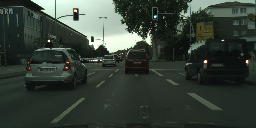
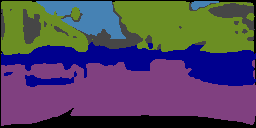
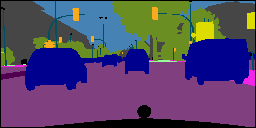

In [251]:
#Training Baseline U-Net

num_classes = 30
model = UNet(3, num_classes)
    

print("Starting training process...")
trainer = Trainer(model, ds_split)
torch.cuda.empty_cache()
trainer.fit(epochs=1, batch_size=5)

# Draw a random sample
input, truth = random.choice(ds_split["val"])

# Push through our network
model = model.cpu()
output = model(input.unsqueeze(0))

# Display the input, output and truth tensors
template_table = '<table><thead><tr><th>Tensor</th><th>Shape</th><th>Image</th></tr></thead><tbody>{0}</tbody></table>'
template_row = '<tr><td>{0}</td><td>{1}</td><td><img src="data:image/png;base64,{2}"/></td></tr>'

input_img = TF.to_pil_image(input)
output_img = ds_split["val"].to_image(ds_split["val"].masks_to_indices(output).squeeze(0))
truth_img = ds_split["val"].to_image(truth)

rows = []
for name, tensor, img in [('Input', input, input_img), ('Output', output, output_img), ('Target', truth, truth_img)]:
    with BytesIO() as b: 
        img.save(b, format='png')
        rows.append(template_row.format(name, list(tensor.shape), b64encode(b.getvalue()).decode('utf-8')))

# Render HTML table
table = template_table.format(''.join(rows))
display(HTML(table))

## Create your own network
You can now start building upon your baseline network to improve accuracy on the validation dataset. Some directions that you should explore are:
- Data augmentation (see exercise in the `CityscapesDataset` class)
- Model architecture changes
- Hyperparameter tuning

Remember to save data and figures for your paper, and clearly explain your design choices.

In [279]:
# Defining the U-Net Model as baseline

# Used the following sites as reference for the pytorch implementation 
# 1. https://github.com/milesial/Pytorch-UNet/blob/master/unet/unet_model.py
# 2. https://theaisummer.com/unet-architectures/

# Class to perform series of 3X3 convolutions
from torch import nn
import torch.nn.functional as F

# Class to perform series of 3X3 convolutions

class DoubleConv(nn.Module):
    
    def __init__(self, in_channels, out_channels, mid_channels = None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.doubleconv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.doubleconv(x)

# Defining class for the residual path

class DoubleConv_skip(nn.Module):
    
    def __init__(self, in_channels, out_channels, mid_channels = None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.doubleconv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(out_channels)
        )
    
    def forward(self, x):
        return self.doubleconv(x)

    

# Class to perform max pool followed by the Double conv

class Downconv(nn.Module):
    
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpoolconv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpoolconv(x)

class Downconv_skip(nn.Module):
    
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpoolconv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv_skip(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpoolconv(x)


# Class to perform the upsampling plus the convolutions along with the concatenation

class Upconv(nn.Module):
    
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

# Class to define the residual path for up sampling

class Upconv_skip(nn.Module):
    
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv_skip(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv_skip(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

# Building the U-net class

class Custom_UNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Custom_UNet, self).__init__()
        
        #Input Conv
        self.in_channels = in_channels
        self.num_classes = num_classes
        
        self.inconv = DoubleConv(in_channels, 16)
        
        self.dconv = Downconv(16, 32)
        self.dconv_skip = Downconv_skip(16, 32)
        
        self.dconv0 = Downconv(32, 64)
        self.dconv0_skip = Downconv_skip(32, 64)
        
        self.dconv1 = Downconv(64, 128)
        self.dconv1_skip = Downconv_skip(64, 128)
        
        
        self.dconv2 = Downconv(128, 256)
        self.dconv2_skip = Downconv_skip(128, 256)
        
        self.dconv3 = Downconv(256, 512)
        self.dconv3_skip = Downconv_skip(256, 512)
        
        self.dconv4 = Downconv(512, 512)
        self.dconv4_skip = Downconv_skip(512, 512)
        
        self.Relu = nn.ReLU(inplace=True)
        
        
        self.up1 = Upconv(1024, 256)
        self.up1_skip = Upconv_skip(1024, 256)
        
        self.up2 = Upconv(512, 128)
        self.up2_skip = Upconv_skip(512, 128)
        
        self.up3 = Upconv(256, 64)
        self.up3_skip = Upconv_skip(256, 64)
        
        self.up4 = Upconv(128, 32)
        self.up4_skip = Upconv_skip(128, 32)
        
        self.up5 = Upconv(64, 16)
        self.up5_skip = Upconv_skip(64, 16)
        
        self.up6 = Upconv(32, 16)
        self.up6_skip = Upconv_skip(32, 16)
        
        self.outconv = nn.Conv2d(16, num_classes, kernel_size=1)
        
    def forward(self, x):
        
        xi = self.inconv(x)
        # Downsample network
        
        # Inserted additional Convolution Blocks
        
        x_main = self.dconv(xi)
        x_skip = self.dconv_skip(xi)
        
        # Residual Connections
        x0 = x_main + x_skip
        x0 = self.Relu(x0)
        
        x1_main = self.dconv0(x0)
        x1_skip = self.dconv0_skip(x0)
        x1 = x1_main + x1_skip
        x1 = self.Relu(x1)
        
        x2_main = self.dconv1(x1)
        x2_skip = self.dconv1_skip(x1)
        x2 = x2_main + x2_skip
        x2 = self.Relu(x2)
        
        x3_main = self.dconv2(x2)
        x3_skip = self.dconv2_skip(x2)
        x3 = x3_main + x3_skip
        x3 = self.Relu(x3)
        
        
        x4_main = self.dconv3(x3)
        x4_skip = self.dconv3_skip(x3)
        x4 = x4_main + x4_skip
        x4 = self.Relu(x4)
        
        x5_main = self.dconv4(x4)
        x5_skip = self.dconv4_skip(x4)
        x5 = x5_main + x5_skip
        x5 = self.Relu(x5)
        
        #Upsample Network
        
        x_main = self.up1(x5, x4)
        x_skip = self.up1_skip(x5, x4)
        x = x_main + x_skip
        x = self.Relu(x)
        
        x_main2 = self.up2(x, x3)
        x_skip2 = self.up2_skip(x, x3)
        x = x_main2 + x_skip2
        x = self.Relu(x)
        
        x_main3 = self.up3(x, x2)
        x_skip3 = self.up3_skip(x, x2)
        x = x_main3 + x_skip3
        x = self.Relu(x)
        
        x_main4 = self.up4(x, x1)
        x_skip4 = self.up4_skip(x, x1)
        x = x_main4 + x_skip4
        x = self.Relu(x)
        
        # Inserted additional Convolution Blocks
        x_main5 = self.up5(x, x0)
        x_skip5 = self.up5_skip(x, x0)
        x = x_main5 + x_skip5
        x = self.Relu(x)
        
        x_main6 = self.up6(x, xi)
        x_skip6 = self.up6_skip(x, xi)
        x = x_main6 + x_skip6
        x = self.Relu(x)
        
        x = self.outconv(x)
        
        return x


In [280]:
# Function to check if model is built correctly
def test_UNet():
    x = torch.zeros((10, 3, 128, 256), dtype=torch.float32)
    num_classes = 10
    model = Custom_UNet(3, num_classes)
    out = model(x)
    print(out.size()) # Expect to see [10, 10, 128, 256]
test_UNet()

torch.Size([10, 10, 128, 256])


In [230]:
# Hyper Parameter Tuning
class Trainer_HP:
    def __init__(self, model: nn.Module, ds_split: Dict[str,CityscapesDataset],lr_rate):
        # Choose a device to run training on. Ideally, you have a GPU available to accelerate the training process.
        
        #self.device = "cpu"
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        
        # Move the model onto the target device
        self.model = model.to(self.device)
        
        # Store the dataset split
        self.ds_split = ds_split
        
        self.lr_rate = lr_rate
        
        ## EXERCISE #####################################################################
        #
        # Select an optimizer
        #
        # See: https://pytorch.org/docs/stable/optim.html
        #
        ################################################################################# 
        
        self.optimizer = optim.Adam(model.parameters(), lr = lr_rate)
        
        ## EXERCISE #####################################################################
        #
        # Select an appropriate loss function
        #
        # See: https://pytorch.org/docs/stable/nn.html#loss-functions
        #
        ################################################################################# 
        
        self.critereon = nn.CrossEntropyLoss()
        
        ################################################################################# 
        
        assert self.critereon is not None, "You have not defined a loss"
        assert self.optimizer is not None, "You have not defined an optimizer"
        
    def train_epoch(self, dl:DataLoader):
        # Put the model in training mode
        self.model.train()
        
        # Store each step's accuracy and loss for this epoch
        epoch_metrics = {
            "loss": [],
            "accuracy": []
        }
        
        iterations = 0
        
        # Create a progress bar using TQDM
        sys.stdout.flush()
        with tqdm(total=len(self.ds_split["train"]), desc=f'Training') as pbar:
            # Iterate over the training dataset
            for inputs, truths in dl:
                # Zero the gradients from the previous step
                self.optimizer.zero_grad()
                
                # Move the inputs and truths to the target device
                inputs = inputs.to(device=self.device, dtype=torch.float32)
                
                print(inputs.shape)
                
                inputs.required_grad = True  # Fix for older PyTorch versions
                truths = truths.to(device=self.device, dtype=torch.long)
                
                # Run model on the inputs
                output = self.model(inputs)

                # Perform backpropagation
                loss = self.critereon(output, truths)
                loss.backward()
                nn.utils.clip_grad_value_(model.parameters(), 0.1)
                self.optimizer.step()
                
                # Store the metrics of this step
                step_metrics = {
                    'loss': loss.item(),
                    'accuracy': compute_iou(output, truths)
                }
                
                # Update the progress bar
                pbar.set_postfix(**step_metrics)
                pbar.update(list(inputs.shape)[0])
                
                # Add to epoch's metrics
                for k,v in step_metrics.items():
                    epoch_metrics[k].append(v)
                
                iterations += 1
                if(iterations >= 70):
                    break

        sys.stdout.flush()
        
        # Return metrics
        return epoch_metrics
    
    def val_epoch(self, dl:DataLoader):
        # Put the model in evaluation mode
        self.model.eval()
        
        # Store the total loss and accuracy over the epoch
        amount = 0
        total_loss = 0
        total_accuracy = 0
        
        # Create a progress bar using TQDM
        iterations = 0
        
        sys.stdout.flush()
        with torch.no_grad(), tqdm(total=len(self.ds_split["val"]), desc=f'Validation') as pbar:
            # Iterate over the validation dataloader
            for inputs, truths in dl:
                 # Move the inputs and truths to the target device
                inputs = inputs.to(device=self.device, dtype=torch.float32)
                inputs.required_grad = True  # Fix for older PyTorch versions
                truths = truths.to(device=self.device, dtype=torch.long)

                # Run model on the inputs
                output = self.model(inputs)
                loss = self.critereon(output, truths)
                
              

                # Store the metrics of this step
                step_metrics = {
                    'loss': loss.item(),
                    'accuracy': compute_iou(output, truths)
                }

                # Update the progress bar
                pbar.set_postfix(**step_metrics)
                pbar.update(list(inputs.shape)[0])

                amount += 1
                total_loss += step_metrics["loss"]
                total_accuracy += step_metrics["accuracy"]
                
                
        sys.stdout.flush()
        
        # Print mean of metrics
        total_loss /= amount
        total_accuracy /= amount
        print(f'Validation loss is {total_loss/amount}, validation accuracy is {total_accuracy}')
              
        # Return mean loss and accuracy
        return {
            "loss": [total_loss],
            "accuracy": [total_accuracy]
        }
            
        
    def fit(self, epochs: int, batch_size:int):
        # Initialize Dataloaders for the `train` and `val` splits of the dataset. 
        # A Dataloader loads a batch of samples from the each dataset split and concatenates these samples into a batch.
        dl_train = DataLoader(ds_split["train"], batch_size=batch_size, shuffle=True)
        dl_val = DataLoader(ds_split["val"], batch_size=batch_size, drop_last=True)
                
        # Store metrics of the training process (plot this to gain insight)
        df_train = pd.DataFrame()
        df_val = pd.DataFrame()
        
        # Train the model for the provided amount of epochs
        for epoch in range(1, epochs+1):
            print(f'Epoch {epoch}')
            metrics_train = self.train_epoch(dl_train)
            df_train = df_train.append(pd.DataFrame({'epoch': [epoch for _ in range(len(metrics_train["loss"]))], **metrics_train}), ignore_index=True)
            
            metrics_val = self.val_epoch(dl_val)            
            df_val = df_val.append(pd.DataFrame({'epoch': [epoch], **metrics_val}), ignore_index=True)
                    
        # Return a dataframe that logs the training process. This can be exported to a CSV or plotted directly.
        return metrics_val['accuracy']

In [235]:
# Hyperparameter Tuning
def Hypertune(lr_list):
    val_loss = []
    for lr in lr_list:
        num_classes = 30
        model = Custom_UNet(3, num_classes)

        print("Starting Hyper Parameter tuning process...")
        trainer = Trainer_HP(model, ds_split, lr)
        torch.cuda.empty_cache()
        val = trainer.fit(epochs=1, batch_size=5)
        val_loss.append(val)

    return(val_loss)   


In [236]:
lr_list = [1e-1, 1e-2, 1e-3, 1e-4]
val_loss = Hypertune(lr_list)
print(val_loss)

Starting Hyper Parameter tuning process...
Epoch 1


Training:   0%|                                                                               | 0/2975 [00:00<?, ?it/s]

torch.Size([5, 3, 128, 256])


Training:   0%|                                            | 5/2975 [00:01<10:48,  4.58it/s, accuracy=0.487, loss=3.44]

torch.Size([5, 3, 128, 256])


Training:   0%|▏                                          | 10/2975 [00:02<10:30,  4.70it/s, accuracy=0.654, loss=2.64]

torch.Size([5, 3, 128, 256])


Training:   1%|▏                                          | 15/2975 [00:03<10:23,  4.75it/s, accuracy=0.638, loss=3.21]

torch.Size([5, 3, 128, 256])


Training:   1%|▎                                          | 20/2975 [00:04<10:24,  4.73it/s, accuracy=0.638, loss=2.07]

torch.Size([5, 3, 128, 256])


Training:   1%|▎                                           | 25/2975 [00:05<10:21,  4.75it/s, accuracy=0.599, loss=2.4]

torch.Size([5, 3, 128, 256])


Training:   1%|▍                                          | 30/2975 [00:06<10:23,  4.73it/s, accuracy=0.694, loss=2.04]

torch.Size([5, 3, 128, 256])


Training:   1%|▌                                          | 35/2975 [00:07<10:29,  4.67it/s, accuracy=0.677, loss=1.95]

torch.Size([5, 3, 128, 256])


Training:   1%|▌                                           | 40/2975 [00:08<10:27,  4.68it/s, accuracy=0.65, loss=1.84]

torch.Size([5, 3, 128, 256])


Training:   2%|▋                                          | 45/2975 [00:09<10:31,  4.64it/s, accuracy=0.675, loss=2.07]

torch.Size([5, 3, 128, 256])


Training:   2%|▋                                           | 50/2975 [00:10<10:24,  4.68it/s, accuracy=0.649, loss=1.7]

torch.Size([5, 3, 128, 256])


Training:   2%|▊                                           | 55/2975 [00:11<10:19,  4.72it/s, accuracy=0.68, loss=2.08]

torch.Size([5, 3, 128, 256])


Training:   2%|▊                                          | 60/2975 [00:12<10:21,  4.69it/s, accuracy=0.697, loss=2.05]

torch.Size([5, 3, 128, 256])


Training:   2%|▉                                          | 65/2975 [00:13<10:28,  4.63it/s, accuracy=0.656, loss=2.17]

torch.Size([5, 3, 128, 256])


Training:   2%|█                                          | 70/2975 [00:15<10:33,  4.59it/s, accuracy=0.628, loss=1.92]

torch.Size([5, 3, 128, 256])


Training:   3%|█                                          | 75/2975 [00:16<10:32,  4.59it/s, accuracy=0.594, loss=1.96]

torch.Size([5, 3, 128, 256])


Training:   3%|█▏                                         | 80/2975 [00:17<10:24,  4.64it/s, accuracy=0.697, loss=2.16]

torch.Size([5, 3, 128, 256])


Training:   3%|█▎                                          | 85/2975 [00:18<10:19,  4.66it/s, accuracy=0.653, loss=1.9]

torch.Size([5, 3, 128, 256])


Training:   3%|█▎                                          | 90/2975 [00:19<10:17,  4.67it/s, accuracy=0.671, loss=1.8]

torch.Size([5, 3, 128, 256])


Training:   3%|█▎                                         | 95/2975 [00:20<10:16,  4.67it/s, accuracy=0.626, loss=1.92]

torch.Size([5, 3, 128, 256])


Training:   3%|█▍                                        | 100/2975 [00:21<10:15,  4.67it/s, accuracy=0.663, loss=1.67]

torch.Size([5, 3, 128, 256])


Training:   4%|█▍                                        | 105/2975 [00:22<10:10,  4.70it/s, accuracy=0.683, loss=2.03]

torch.Size([5, 3, 128, 256])


Training:   4%|█▌                                        | 110/2975 [00:23<10:10,  4.69it/s, accuracy=0.706, loss=1.54]

torch.Size([5, 3, 128, 256])


Training:   4%|█▋                                         | 115/2975 [00:24<10:06,  4.71it/s, accuracy=0.67, loss=1.58]

torch.Size([5, 3, 128, 256])


Training:   4%|█▋                                         | 120/2975 [00:25<10:05,  4.71it/s, accuracy=0.68, loss=1.61]

torch.Size([5, 3, 128, 256])


Training:   4%|█▊                                         | 125/2975 [00:26<10:03,  4.72it/s, accuracy=0.662, loss=1.4]

torch.Size([5, 3, 128, 256])


Training:   4%|█▊                                        | 130/2975 [00:27<10:05,  4.70it/s, accuracy=0.638, loss=1.96]

torch.Size([5, 3, 128, 256])


Training:   5%|█▉                                        | 135/2975 [00:28<10:02,  4.72it/s, accuracy=0.692, loss=1.37]

torch.Size([5, 3, 128, 256])


Training:   5%|██                                         | 140/2975 [00:29<10:02,  4.71it/s, accuracy=0.67, loss=1.67]

torch.Size([5, 3, 128, 256])


Training:   5%|██                                        | 145/2975 [00:30<10:01,  4.70it/s, accuracy=0.663, loss=1.88]

torch.Size([5, 3, 128, 256])


Training:   5%|██                                        | 150/2975 [00:32<10:00,  4.70it/s, accuracy=0.705, loss=1.58]

torch.Size([5, 3, 128, 256])


Training:   5%|██▏                                       | 155/2975 [00:33<09:56,  4.73it/s, accuracy=0.682, loss=1.57]

torch.Size([5, 3, 128, 256])


Training:   5%|██▎                                       | 160/2975 [00:34<09:55,  4.73it/s, accuracy=0.649, loss=1.71]

torch.Size([5, 3, 128, 256])


Training:   6%|██▎                                       | 165/2975 [00:35<09:57,  4.71it/s, accuracy=0.593, loss=1.86]

torch.Size([5, 3, 128, 256])


Training:   6%|██▍                                       | 170/2975 [00:36<09:54,  4.72it/s, accuracy=0.686, loss=1.47]

torch.Size([5, 3, 128, 256])


Training:   6%|██▍                                       | 175/2975 [00:37<09:55,  4.70it/s, accuracy=0.716, loss=1.25]

torch.Size([5, 3, 128, 256])


Training:   6%|██▌                                       | 180/2975 [00:38<09:54,  4.70it/s, accuracy=0.685, loss=1.51]

torch.Size([5, 3, 128, 256])


Training:   6%|██▌                                       | 185/2975 [00:39<09:51,  4.72it/s, accuracy=0.677, loss=1.61]

torch.Size([5, 3, 128, 256])


Training:   6%|██▋                                       | 190/2975 [00:40<09:49,  4.73it/s, accuracy=0.692, loss=1.42]

torch.Size([5, 3, 128, 256])


Training:   7%|██▊                                       | 195/2975 [00:41<09:46,  4.74it/s, accuracy=0.653, loss=2.29]

torch.Size([5, 3, 128, 256])


Training:   7%|██▊                                       | 200/2975 [00:42<09:44,  4.74it/s, accuracy=0.686, loss=1.63]

torch.Size([5, 3, 128, 256])


Training:   7%|██▉                                       | 205/2975 [00:43<09:45,  4.73it/s, accuracy=0.674, loss=1.51]

torch.Size([5, 3, 128, 256])


Training:   7%|██▉                                       | 210/2975 [00:44<09:41,  4.75it/s, accuracy=0.657, loss=1.76]

torch.Size([5, 3, 128, 256])


Training:   7%|███                                        | 215/2975 [00:45<09:39,  4.76it/s, accuracy=0.729, loss=1.6]

torch.Size([5, 3, 128, 256])


Training:   7%|███                                       | 220/2975 [00:46<09:44,  4.72it/s, accuracy=0.693, loss=1.47]

torch.Size([5, 3, 128, 256])


Training:   8%|███▏                                      | 225/2975 [00:47<09:40,  4.74it/s, accuracy=0.686, loss=1.39]

torch.Size([5, 3, 128, 256])


Training:   8%|███▏                                      | 230/2975 [00:48<09:40,  4.73it/s, accuracy=0.652, loss=1.39]

torch.Size([5, 3, 128, 256])


Training:   8%|███▎                                      | 235/2975 [00:49<09:40,  4.72it/s, accuracy=0.741, loss=1.49]

torch.Size([5, 3, 128, 256])


Training:   8%|███▍                                       | 240/2975 [00:51<09:40,  4.71it/s, accuracy=0.661, loss=1.5]

torch.Size([5, 3, 128, 256])


Training:   8%|███▌                                       | 245/2975 [00:52<09:36,  4.73it/s, accuracy=0.671, loss=1.6]

torch.Size([5, 3, 128, 256])


Training:   8%|███▌                                       | 250/2975 [00:53<09:34,  4.74it/s, accuracy=0.694, loss=1.2]

torch.Size([5, 3, 128, 256])


Training:   9%|███▋                                       | 255/2975 [00:54<09:36,  4.72it/s, accuracy=0.689, loss=1.6]

torch.Size([5, 3, 128, 256])


Training:   9%|███▋                                      | 260/2975 [00:55<09:37,  4.70it/s, accuracy=0.671, loss=1.59]

torch.Size([5, 3, 128, 256])


Training:   9%|███▋                                      | 265/2975 [00:56<09:37,  4.69it/s, accuracy=0.714, loss=1.64]

torch.Size([5, 3, 128, 256])


Training:   9%|███▊                                      | 270/2975 [00:57<09:34,  4.71it/s, accuracy=0.643, loss=1.36]

torch.Size([5, 3, 128, 256])


Training:   9%|███▉                                      | 275/2975 [00:58<09:31,  4.72it/s, accuracy=0.683, loss=1.69]

torch.Size([5, 3, 128, 256])


Training:   9%|███▉                                      | 280/2975 [00:59<09:27,  4.75it/s, accuracy=0.713, loss=1.29]

torch.Size([5, 3, 128, 256])


Training:  10%|████                                      | 285/2975 [01:00<09:26,  4.75it/s, accuracy=0.676, loss=1.52]

torch.Size([5, 3, 128, 256])


Training:  10%|████                                      | 290/2975 [01:01<09:24,  4.75it/s, accuracy=0.675, loss=1.18]

torch.Size([5, 3, 128, 256])


Training:  10%|████▏                                     | 295/2975 [01:02<09:21,  4.77it/s, accuracy=0.704, loss=1.25]

torch.Size([5, 3, 128, 256])


Training:  10%|████▏                                     | 300/2975 [01:03<09:21,  4.77it/s, accuracy=0.694, loss=1.74]

torch.Size([5, 3, 128, 256])


Training:  10%|████▎                                     | 305/2975 [01:04<09:21,  4.75it/s, accuracy=0.699, loss=1.33]

torch.Size([5, 3, 128, 256])


Training:  10%|████▍                                     | 310/2975 [01:05<09:21,  4.74it/s, accuracy=0.667, loss=1.37]

torch.Size([5, 3, 128, 256])


Training:  11%|████▍                                     | 315/2975 [01:06<09:19,  4.75it/s, accuracy=0.666, loss=1.24]

torch.Size([5, 3, 128, 256])


Training:  11%|████▌                                     | 320/2975 [01:07<09:20,  4.73it/s, accuracy=0.738, loss=0.99]

torch.Size([5, 3, 128, 256])


Training:  11%|████▌                                     | 325/2975 [01:09<09:22,  4.71it/s, accuracy=0.664, loss=1.14]

torch.Size([5, 3, 128, 256])


Training:  11%|████▋                                     | 330/2975 [01:10<09:21,  4.71it/s, accuracy=0.748, loss=2.19]

torch.Size([5, 3, 128, 256])


Training:  11%|████▋                                     | 335/2975 [01:11<09:20,  4.71it/s, accuracy=0.687, loss=1.38]

torch.Size([5, 3, 128, 256])


Training:  11%|████▊                                     | 340/2975 [01:12<09:16,  4.73it/s, accuracy=0.713, loss=1.11]

torch.Size([5, 3, 128, 256])


Training:  12%|████▊                                     | 345/2975 [01:13<09:16,  4.73it/s, accuracy=0.692, loss=1.22]

torch.Size([5, 3, 128, 256])


Validation: 100%|█████████████████████████████████████████| 500/500 [01:32<00:00,  5.43it/s, accuracy=0.651, loss=1.37]


Validation loss is 0.01901736491918564, validation accuracy is 0.6886095203209954
Starting Hyper Parameter tuning process...
Epoch 1


Training:   0%|                                                                               | 0/2975 [00:00<?, ?it/s]

torch.Size([5, 3, 128, 256])


Training:   0%|                                            | 5/2975 [00:01<10:42,  4.62it/s, accuracy=0.468, loss=3.64]

torch.Size([5, 3, 128, 256])


Training:   0%|▏                                          | 10/2975 [00:02<10:39,  4.64it/s, accuracy=0.575, loss=3.33]

torch.Size([5, 3, 128, 256])


Training:   1%|▏                                          | 15/2975 [00:03<10:34,  4.67it/s, accuracy=0.584, loss=2.69]

torch.Size([5, 3, 128, 256])


Training:   1%|▎                                          | 20/2975 [00:04<10:30,  4.69it/s, accuracy=0.666, loss=2.43]

torch.Size([5, 3, 128, 256])


Training:   1%|▎                                          | 25/2975 [00:05<10:29,  4.69it/s, accuracy=0.642, loss=2.14]

torch.Size([5, 3, 128, 256])


Training:   1%|▍                                          | 30/2975 [00:06<10:34,  4.64it/s, accuracy=0.685, loss=2.16]

torch.Size([5, 3, 128, 256])


Training:   1%|▌                                          | 35/2975 [00:07<10:36,  4.62it/s, accuracy=0.627, loss=1.91]

torch.Size([5, 3, 128, 256])


Training:   1%|▌                                          | 40/2975 [00:08<10:29,  4.66it/s, accuracy=0.685, loss=2.06]

torch.Size([5, 3, 128, 256])


Training:   2%|▋                                          | 45/2975 [00:09<10:21,  4.71it/s, accuracy=0.687, loss=1.82]

torch.Size([5, 3, 128, 256])


Training:   2%|▋                                          | 50/2975 [00:10<10:21,  4.71it/s, accuracy=0.661, loss=1.78]

torch.Size([5, 3, 128, 256])


Training:   2%|▊                                          | 55/2975 [00:11<10:19,  4.71it/s, accuracy=0.681, loss=1.89]

torch.Size([5, 3, 128, 256])


Training:   2%|▊                                          | 60/2975 [00:12<10:18,  4.71it/s, accuracy=0.702, loss=1.72]

torch.Size([5, 3, 128, 256])


Training:   2%|▉                                           | 65/2975 [00:13<10:16,  4.72it/s, accuracy=0.663, loss=2.2]

torch.Size([5, 3, 128, 256])


Training:   2%|█                                          | 70/2975 [00:14<10:13,  4.73it/s, accuracy=0.664, loss=1.73]

torch.Size([5, 3, 128, 256])


Training:   3%|█                                          | 75/2975 [00:15<10:11,  4.74it/s, accuracy=0.655, loss=1.39]

torch.Size([5, 3, 128, 256])


Training:   3%|█▏                                         | 80/2975 [00:17<10:10,  4.74it/s, accuracy=0.693, loss=1.35]

torch.Size([5, 3, 128, 256])


Training:   3%|█▏                                         | 85/2975 [00:18<10:08,  4.75it/s, accuracy=0.669, loss=1.54]

torch.Size([5, 3, 128, 256])


Training:   3%|█▎                                         | 90/2975 [00:19<10:05,  4.76it/s, accuracy=0.691, loss=1.81]

torch.Size([5, 3, 128, 256])


Training:   3%|█▍                                          | 95/2975 [00:20<10:06,  4.75it/s, accuracy=0.64, loss=1.94]

torch.Size([5, 3, 128, 256])


Training:   3%|█▍                                        | 100/2975 [00:21<10:03,  4.77it/s, accuracy=0.706, loss=1.41]

torch.Size([5, 3, 128, 256])


Training:   4%|█▌                                         | 105/2975 [00:22<10:03,  4.76it/s, accuracy=0.704, loss=1.5]

torch.Size([5, 3, 128, 256])


Training:   4%|█▌                                        | 110/2975 [00:23<10:02,  4.76it/s, accuracy=0.704, loss=1.52]

torch.Size([5, 3, 128, 256])


Training:   4%|█▌                                        | 115/2975 [00:24<10:02,  4.74it/s, accuracy=0.672, loss=1.47]

torch.Size([5, 3, 128, 256])


Training:   4%|█▋                                        | 120/2975 [00:25<10:01,  4.75it/s, accuracy=0.649, loss=1.66]

torch.Size([5, 3, 128, 256])


Training:   4%|█▊                                        | 125/2975 [00:26<10:04,  4.72it/s, accuracy=0.698, loss=1.31]

torch.Size([5, 3, 128, 256])


Training:   4%|█▊                                        | 130/2975 [00:27<10:02,  4.72it/s, accuracy=0.646, loss=1.33]

torch.Size([5, 3, 128, 256])


Training:   5%|█▉                                        | 135/2975 [00:28<10:01,  4.72it/s, accuracy=0.662, loss=1.83]

torch.Size([5, 3, 128, 256])


Training:   5%|█▉                                        | 140/2975 [00:29<10:02,  4.71it/s, accuracy=0.728, loss=1.53]

torch.Size([5, 3, 128, 256])


Training:   5%|██                                         | 145/2975 [00:30<09:59,  4.72it/s, accuracy=0.73, loss=1.27]

torch.Size([5, 3, 128, 256])


Training:   5%|██                                        | 150/2975 [00:31<10:01,  4.69it/s, accuracy=0.687, loss=1.67]

torch.Size([5, 3, 128, 256])


Training:   5%|██▏                                       | 155/2975 [00:32<09:58,  4.71it/s, accuracy=0.683, loss=1.75]

torch.Size([5, 3, 128, 256])


Training:   5%|██▎                                        | 160/2975 [00:33<09:57,  4.71it/s, accuracy=0.715, loss=1.4]

torch.Size([5, 3, 128, 256])


Training:   6%|██▎                                       | 165/2975 [00:34<09:55,  4.72it/s, accuracy=0.677, loss=1.46]

torch.Size([5, 3, 128, 256])


Training:   6%|██▍                                       | 170/2975 [00:36<09:54,  4.71it/s, accuracy=0.713, loss=1.41]

torch.Size([5, 3, 128, 256])


Training:   6%|██▍                                       | 175/2975 [00:37<09:52,  4.73it/s, accuracy=0.664, loss=1.36]

torch.Size([5, 3, 128, 256])


Training:   6%|██▌                                       | 180/2975 [00:38<09:51,  4.73it/s, accuracy=0.666, loss=1.66]

torch.Size([5, 3, 128, 256])


Training:   6%|██▌                                       | 185/2975 [00:39<09:49,  4.73it/s, accuracy=0.694, loss=1.08]

torch.Size([5, 3, 128, 256])


Training:   6%|██▋                                       | 190/2975 [00:40<09:53,  4.69it/s, accuracy=0.649, loss=2.11]

torch.Size([5, 3, 128, 256])


Training:   7%|██▊                                        | 195/2975 [00:41<09:52,  4.69it/s, accuracy=0.72, loss=1.72]

torch.Size([5, 3, 128, 256])


Training:   7%|██▊                                       | 200/2975 [00:42<09:50,  4.70it/s, accuracy=0.681, loss=1.42]

torch.Size([5, 3, 128, 256])


Training:   7%|██▉                                       | 205/2975 [00:43<09:51,  4.69it/s, accuracy=0.676, loss=1.54]

torch.Size([5, 3, 128, 256])


Training:   7%|██▉                                       | 210/2975 [00:44<09:48,  4.69it/s, accuracy=0.662, loss=1.43]

torch.Size([5, 3, 128, 256])


Training:   7%|███▏                                        | 215/2975 [00:45<09:49,  4.68it/s, accuracy=0.7, loss=1.25]

torch.Size([5, 3, 128, 256])


Training:   7%|███                                       | 220/2975 [00:46<09:47,  4.69it/s, accuracy=0.675, loss=1.52]

torch.Size([5, 3, 128, 256])


Training:   8%|███▏                                      | 225/2975 [00:47<09:49,  4.67it/s, accuracy=0.662, loss=1.24]

torch.Size([5, 3, 128, 256])


Training:   8%|███▏                                      | 230/2975 [00:48<09:51,  4.64it/s, accuracy=0.676, loss=1.33]

torch.Size([5, 3, 128, 256])


Training:   8%|███▎                                      | 235/2975 [00:49<09:52,  4.63it/s, accuracy=0.652, loss=1.37]

torch.Size([5, 3, 128, 256])


Training:   8%|███▍                                      | 240/2975 [00:51<09:48,  4.64it/s, accuracy=0.726, loss=1.58]

torch.Size([5, 3, 128, 256])


Training:   8%|███▍                                      | 245/2975 [00:52<09:45,  4.66it/s, accuracy=0.707, loss=1.51]

torch.Size([5, 3, 128, 256])


Training:   8%|███▌                                      | 250/2975 [00:53<09:41,  4.68it/s, accuracy=0.695, loss=1.19]

torch.Size([5, 3, 128, 256])


Training:   9%|███▌                                      | 255/2975 [00:54<09:45,  4.64it/s, accuracy=0.686, loss=1.28]

torch.Size([5, 3, 128, 256])


Training:   9%|███▋                                      | 260/2975 [00:55<09:42,  4.66it/s, accuracy=0.687, loss=1.53]

torch.Size([5, 3, 128, 256])


Training:   9%|███▋                                      | 265/2975 [00:56<09:39,  4.68it/s, accuracy=0.767, loss=1.24]

torch.Size([5, 3, 128, 256])


Training:   9%|███▊                                      | 270/2975 [00:57<09:36,  4.69it/s, accuracy=0.693, loss=1.39]

torch.Size([5, 3, 128, 256])


Training:   9%|███▉                                      | 275/2975 [00:58<09:34,  4.70it/s, accuracy=0.652, loss=1.13]

torch.Size([5, 3, 128, 256])


Training:   9%|███▉                                      | 280/2975 [00:59<09:34,  4.69it/s, accuracy=0.686, loss=1.14]

torch.Size([5, 3, 128, 256])


Training:  10%|████                                      | 285/2975 [01:00<09:29,  4.72it/s, accuracy=0.705, loss=1.39]

torch.Size([5, 3, 128, 256])


Training:  10%|████                                      | 290/2975 [01:01<09:29,  4.71it/s, accuracy=0.702, loss=1.08]

torch.Size([5, 3, 128, 256])


Training:  10%|████▏                                     | 295/2975 [01:02<09:27,  4.72it/s, accuracy=0.682, loss=1.28]

torch.Size([5, 3, 128, 256])


Training:  10%|████▍                                       | 300/2975 [01:03<09:28,  4.71it/s, accuracy=0.7, loss=1.22]

torch.Size([5, 3, 128, 256])


Training:  10%|████▍                                      | 305/2975 [01:04<09:30,  4.68it/s, accuracy=0.67, loss=1.57]

torch.Size([5, 3, 128, 256])


Training:  10%|████▍                                     | 310/2975 [01:05<09:30,  4.67it/s, accuracy=0.752, loss=1.12]

torch.Size([5, 3, 128, 256])


Training:  11%|████▍                                     | 315/2975 [01:07<09:26,  4.69it/s, accuracy=0.667, loss=1.19]

torch.Size([5, 3, 128, 256])


Training:  11%|████▌                                     | 320/2975 [01:08<09:26,  4.69it/s, accuracy=0.726, loss=1.13]

torch.Size([5, 3, 128, 256])


Training:  11%|████▌                                     | 325/2975 [01:09<09:25,  4.69it/s, accuracy=0.671, loss=1.16]

torch.Size([5, 3, 128, 256])


Training:  11%|████▋                                     | 330/2975 [01:10<09:22,  4.70it/s, accuracy=0.662, loss=1.47]

torch.Size([5, 3, 128, 256])


Training:  11%|████▋                                     | 335/2975 [01:11<09:21,  4.70it/s, accuracy=0.683, loss=1.34]

torch.Size([5, 3, 128, 256])


Training:  11%|████▊                                     | 340/2975 [01:12<09:18,  4.72it/s, accuracy=0.646, loss=1.21]

torch.Size([5, 3, 128, 256])


Training:  12%|████▊                                     | 345/2975 [01:13<09:19,  4.70it/s, accuracy=0.728, loss=1.32]

torch.Size([5, 3, 128, 256])


Validation: 100%|█████████████████████████████████████████| 500/500 [01:34<00:00,  5.31it/s, accuracy=0.667, loss=1.22]


Validation loss is 0.01683419914841652, validation accuracy is 0.7010566795976727
Starting Hyper Parameter tuning process...
Epoch 1


Training:   0%|                                                                               | 0/2975 [00:00<?, ?it/s]

torch.Size([5, 3, 128, 256])


Training:   0%|                                            | 5/2975 [00:01<10:56,  4.53it/s, accuracy=0.473, loss=3.54]

torch.Size([5, 3, 128, 256])


Training:   0%|▏                                          | 10/2975 [00:02<11:05,  4.46it/s, accuracy=0.486, loss=3.27]

torch.Size([5, 3, 128, 256])


Training:   1%|▏                                          | 15/2975 [00:03<10:50,  4.55it/s, accuracy=0.492, loss=3.01]

torch.Size([5, 3, 128, 256])


Training:   1%|▎                                           | 20/2975 [00:04<10:42,  4.60it/s, accuracy=0.523, loss=2.6]

torch.Size([5, 3, 128, 256])


Training:   1%|▎                                          | 25/2975 [00:05<10:38,  4.62it/s, accuracy=0.564, loss=2.44]

torch.Size([5, 3, 128, 256])


Training:   1%|▍                                          | 30/2975 [00:06<10:32,  4.65it/s, accuracy=0.553, loss=2.63]

torch.Size([5, 3, 128, 256])


Training:   1%|▌                                          | 35/2975 [00:07<10:29,  4.67it/s, accuracy=0.581, loss=2.24]

torch.Size([5, 3, 128, 256])


Training:   1%|▌                                          | 40/2975 [00:08<10:27,  4.68it/s, accuracy=0.619, loss=2.17]

torch.Size([5, 3, 128, 256])


Training:   2%|▋                                          | 45/2975 [00:09<10:24,  4.69it/s, accuracy=0.599, loss=2.12]

torch.Size([5, 3, 128, 256])


Training:   2%|▋                                          | 50/2975 [00:10<10:22,  4.70it/s, accuracy=0.614, loss=2.24]

torch.Size([5, 3, 128, 256])


Training:   2%|▊                                          | 55/2975 [00:11<10:19,  4.71it/s, accuracy=0.619, loss=2.09]

torch.Size([5, 3, 128, 256])


Training:   2%|▊                                          | 60/2975 [00:12<10:19,  4.70it/s, accuracy=0.655, loss=1.86]

torch.Size([5, 3, 128, 256])


Training:   2%|▉                                           | 65/2975 [00:13<10:17,  4.71it/s, accuracy=0.67, loss=2.11]

torch.Size([5, 3, 128, 256])


Training:   2%|█                                          | 70/2975 [00:15<10:25,  4.65it/s, accuracy=0.633, loss=1.96]

torch.Size([5, 3, 128, 256])


Training:   3%|█                                          | 75/2975 [00:16<10:25,  4.64it/s, accuracy=0.655, loss=1.97]

torch.Size([5, 3, 128, 256])


Training:   3%|█▏                                         | 80/2975 [00:17<10:20,  4.66it/s, accuracy=0.687, loss=1.88]

torch.Size([5, 3, 128, 256])


Training:   3%|█▎                                          | 85/2975 [00:18<10:20,  4.66it/s, accuracy=0.68, loss=1.78]

torch.Size([5, 3, 128, 256])


Training:   3%|█▎                                         | 90/2975 [00:19<10:16,  4.68it/s, accuracy=0.667, loss=1.86]

torch.Size([5, 3, 128, 256])


Training:   3%|█▎                                         | 95/2975 [00:20<10:16,  4.67it/s, accuracy=0.721, loss=1.56]

torch.Size([5, 3, 128, 256])


Training:   3%|█▍                                        | 100/2975 [00:21<10:13,  4.69it/s, accuracy=0.652, loss=1.62]

torch.Size([5, 3, 128, 256])


Training:   4%|█▍                                        | 105/2975 [00:22<10:12,  4.69it/s, accuracy=0.695, loss=1.61]

torch.Size([5, 3, 128, 256])


Training:   4%|█▌                                         | 110/2975 [00:23<10:10,  4.69it/s, accuracy=0.68, loss=1.83]

torch.Size([5, 3, 128, 256])


Training:   4%|█▌                                        | 115/2975 [00:24<10:08,  4.70it/s, accuracy=0.689, loss=1.38]

torch.Size([5, 3, 128, 256])


Training:   4%|█▋                                        | 120/2975 [00:25<10:07,  4.70it/s, accuracy=0.678, loss=1.66]

torch.Size([5, 3, 128, 256])


Training:   4%|█▊                                        | 125/2975 [00:26<10:04,  4.71it/s, accuracy=0.704, loss=1.63]

torch.Size([5, 3, 128, 256])


Training:   4%|█▊                                        | 130/2975 [00:27<10:05,  4.70it/s, accuracy=0.649, loss=1.63]

torch.Size([5, 3, 128, 256])


Training:   5%|█▉                                        | 135/2975 [00:28<10:03,  4.71it/s, accuracy=0.664, loss=1.53]

torch.Size([5, 3, 128, 256])


Training:   5%|██                                          | 140/2975 [00:29<10:00,  4.72it/s, accuracy=0.69, loss=1.4]

torch.Size([5, 3, 128, 256])


Training:   5%|██                                        | 145/2975 [00:31<10:01,  4.70it/s, accuracy=0.733, loss=1.42]

torch.Size([5, 3, 128, 256])


Training:   5%|██                                        | 150/2975 [00:32<09:59,  4.71it/s, accuracy=0.656, loss=1.66]

torch.Size([5, 3, 128, 256])


Training:   5%|██▏                                       | 155/2975 [00:33<09:58,  4.71it/s, accuracy=0.644, loss=1.67]

torch.Size([5, 3, 128, 256])


Training:   5%|██▎                                       | 160/2975 [00:34<09:58,  4.70it/s, accuracy=0.683, loss=1.59]

torch.Size([5, 3, 128, 256])


Training:   6%|██▎                                       | 165/2975 [00:35<09:58,  4.69it/s, accuracy=0.667, loss=1.44]

torch.Size([5, 3, 128, 256])


Training:   6%|██▍                                        | 170/2975 [00:36<09:55,  4.71it/s, accuracy=0.729, loss=1.7]

torch.Size([5, 3, 128, 256])


Training:   6%|██▍                                       | 175/2975 [00:37<09:55,  4.70it/s, accuracy=0.728, loss=1.43]

torch.Size([5, 3, 128, 256])


Training:   6%|██▌                                       | 180/2975 [00:38<09:52,  4.71it/s, accuracy=0.704, loss=1.25]

torch.Size([5, 3, 128, 256])


Training:   6%|██▋                                        | 185/2975 [00:39<09:52,  4.71it/s, accuracy=0.64, loss=1.57]

torch.Size([5, 3, 128, 256])


Training:   6%|██▋                                       | 190/2975 [00:40<09:49,  4.72it/s, accuracy=0.703, loss=1.39]

torch.Size([5, 3, 128, 256])


Training:   7%|██▊                                       | 195/2975 [00:41<09:47,  4.73it/s, accuracy=0.716, loss=1.47]

torch.Size([5, 3, 128, 256])


Training:   7%|██▊                                       | 200/2975 [00:42<09:45,  4.74it/s, accuracy=0.636, loss=1.31]

torch.Size([5, 3, 128, 256])


Training:   7%|██▉                                        | 205/2975 [00:43<10:03,  4.59it/s, accuracy=0.72, loss=1.44]

torch.Size([5, 3, 128, 256])


Training:   7%|██▉                                       | 210/2975 [00:44<10:07,  4.55it/s, accuracy=0.669, loss=1.47]

torch.Size([5, 3, 128, 256])


Training:   7%|███                                       | 215/2975 [00:46<10:02,  4.58it/s, accuracy=0.704, loss=1.38]

torch.Size([5, 3, 128, 256])


Training:   7%|███                                       | 220/2975 [00:47<09:56,  4.62it/s, accuracy=0.662, loss=1.33]

torch.Size([5, 3, 128, 256])


Training:   8%|███▎                                       | 225/2975 [00:48<09:51,  4.65it/s, accuracy=0.68, loss=1.72]

torch.Size([5, 3, 128, 256])


Training:   8%|███▏                                      | 230/2975 [00:49<09:50,  4.65it/s, accuracy=0.674, loss=1.29]

torch.Size([5, 3, 128, 256])


Training:   8%|███▎                                      | 235/2975 [00:50<09:46,  4.67it/s, accuracy=0.687, loss=1.79]

torch.Size([5, 3, 128, 256])


Training:   8%|███▍                                      | 240/2975 [00:51<09:43,  4.69it/s, accuracy=0.692, loss=1.23]

torch.Size([5, 3, 128, 256])


Training:   8%|███▍                                      | 245/2975 [00:52<09:38,  4.72it/s, accuracy=0.706, loss=1.22]

torch.Size([5, 3, 128, 256])


Training:   8%|███▌                                      | 250/2975 [00:53<09:39,  4.70it/s, accuracy=0.702, loss=1.33]

torch.Size([5, 3, 128, 256])


Training:   9%|███▌                                      | 255/2975 [00:54<09:42,  4.67it/s, accuracy=0.707, loss=1.28]

torch.Size([5, 3, 128, 256])


Training:   9%|███▋                                      | 260/2975 [00:55<09:42,  4.66it/s, accuracy=0.671, loss=1.22]

torch.Size([5, 3, 128, 256])


Training:   9%|███▋                                      | 265/2975 [00:56<09:38,  4.68it/s, accuracy=0.706, loss=1.62]

torch.Size([5, 3, 128, 256])


Training:   9%|███▉                                       | 270/2975 [00:57<09:36,  4.69it/s, accuracy=0.76, loss=1.21]

torch.Size([5, 3, 128, 256])


Training:   9%|███▉                                      | 275/2975 [00:58<09:34,  4.70it/s, accuracy=0.724, loss=1.24]

torch.Size([5, 3, 128, 256])


Training:   9%|████                                       | 280/2975 [00:59<09:34,  4.69it/s, accuracy=0.691, loss=1.1]

torch.Size([5, 3, 128, 256])


Training:  10%|████                                      | 285/2975 [01:00<09:31,  4.70it/s, accuracy=0.744, loss=1.07]

torch.Size([5, 3, 128, 256])


Training:  10%|████                                      | 290/2975 [01:01<09:27,  4.73it/s, accuracy=0.691, loss=1.19]

torch.Size([5, 3, 128, 256])


Training:  10%|████▏                                     | 295/2975 [01:03<09:27,  4.72it/s, accuracy=0.674, loss=1.26]

torch.Size([5, 3, 128, 256])


Training:  10%|████▏                                     | 300/2975 [01:04<09:31,  4.68it/s, accuracy=0.709, loss=1.03]

torch.Size([5, 3, 128, 256])


Training:  10%|████▎                                     | 305/2975 [01:05<09:35,  4.64it/s, accuracy=0.692, loss=1.05]

torch.Size([5, 3, 128, 256])


Training:  10%|████▍                                     | 310/2975 [01:06<09:35,  4.63it/s, accuracy=0.683, loss=1.19]

torch.Size([5, 3, 128, 256])


Training:  11%|████▎                                    | 315/2975 [01:07<09:47,  4.53it/s, accuracy=0.709, loss=0.971]

torch.Size([5, 3, 128, 256])


Training:  11%|████▌                                     | 320/2975 [01:08<09:47,  4.52it/s, accuracy=0.731, loss=1.02]

torch.Size([5, 3, 128, 256])


Training:  11%|████▌                                     | 325/2975 [01:09<09:45,  4.53it/s, accuracy=0.696, loss=1.12]

torch.Size([5, 3, 128, 256])


Training:  11%|████▌                                    | 330/2975 [01:10<09:40,  4.55it/s, accuracy=0.712, loss=0.958]

torch.Size([5, 3, 128, 256])


Training:  11%|████▊                                      | 335/2975 [01:11<09:33,  4.60it/s, accuracy=0.73, loss=1.05]

torch.Size([5, 3, 128, 256])


Training:  11%|████▊                                     | 340/2975 [01:12<09:28,  4.63it/s, accuracy=0.679, loss=1.03]

torch.Size([5, 3, 128, 256])


Training:  12%|████▊                                     | 345/2975 [01:13<09:23,  4.66it/s, accuracy=0.698, loss=1.04]

torch.Size([5, 3, 128, 256])


Validation: 100%|████████████████████████████████████████| 500/500 [01:32<00:00,  5.39it/s, accuracy=0.677, loss=0.926]


Validation loss is 0.012493960422277451, validation accuracy is 0.7118156872793111
Starting Hyper Parameter tuning process...
Epoch 1


Training:   0%|                                                                               | 0/2975 [00:00<?, ?it/s]

torch.Size([5, 3, 128, 256])


Training:   0%|                                             | 5/2975 [00:01<10:50,  4.56it/s, accuracy=0.47, loss=3.55]

torch.Size([5, 3, 128, 256])


Training:   0%|▏                                          | 10/2975 [00:02<11:00,  4.49it/s, accuracy=0.469, loss=3.44]

torch.Size([5, 3, 128, 256])


Training:   1%|▏                                          | 15/2975 [00:03<11:09,  4.42it/s, accuracy=0.471, loss=3.25]

torch.Size([5, 3, 128, 256])


Training:   1%|▎                                          | 20/2975 [00:04<11:02,  4.46it/s, accuracy=0.473, loss=3.12]

torch.Size([5, 3, 128, 256])


Training:   1%|▎                                          | 25/2975 [00:05<11:00,  4.46it/s, accuracy=0.476, loss=3.07]

torch.Size([5, 3, 128, 256])


Training:   1%|▍                                          | 30/2975 [00:06<10:55,  4.49it/s, accuracy=0.481, loss=3.08]

torch.Size([5, 3, 128, 256])


Training:   1%|▌                                           | 35/2975 [00:07<10:45,  4.56it/s, accuracy=0.48, loss=3.01]

torch.Size([5, 3, 128, 256])


Training:   1%|▌                                          | 40/2975 [00:08<10:38,  4.60it/s, accuracy=0.483, loss=2.98]

torch.Size([5, 3, 128, 256])


Training:   2%|▋                                           | 45/2975 [00:09<10:42,  4.56it/s, accuracy=0.487, loss=2.9]

torch.Size([5, 3, 128, 256])


Training:   2%|▋                                          | 50/2975 [00:11<10:47,  4.52it/s, accuracy=0.526, loss=2.83]

torch.Size([5, 3, 128, 256])


Training:   2%|▊                                          | 55/2975 [00:12<10:45,  4.53it/s, accuracy=0.507, loss=2.94]

torch.Size([5, 3, 128, 256])


Training:   2%|▉                                           | 60/2975 [00:13<10:37,  4.58it/s, accuracy=0.52, loss=2.67]

torch.Size([5, 3, 128, 256])


Training:   2%|▉                                          | 65/2975 [00:14<10:31,  4.61it/s, accuracy=0.518, loss=2.69]

torch.Size([5, 3, 128, 256])


Training:   2%|█                                           | 70/2975 [00:15<10:28,  4.62it/s, accuracy=0.521, loss=2.7]

torch.Size([5, 3, 128, 256])


Training:   3%|█                                           | 75/2975 [00:16<10:27,  4.62it/s, accuracy=0.535, loss=2.7]

torch.Size([5, 3, 128, 256])


Training:   3%|█▏                                         | 80/2975 [00:17<10:24,  4.63it/s, accuracy=0.525, loss=2.61]

torch.Size([5, 3, 128, 256])


Training:   3%|█▏                                         | 85/2975 [00:18<10:24,  4.62it/s, accuracy=0.503, loss=2.61]

torch.Size([5, 3, 128, 256])


Training:   3%|█▎                                         | 90/2975 [00:19<10:22,  4.64it/s, accuracy=0.507, loss=2.63]

torch.Size([5, 3, 128, 256])


Training:   3%|█▎                                         | 95/2975 [00:20<10:22,  4.63it/s, accuracy=0.531, loss=2.46]

torch.Size([5, 3, 128, 256])


Training:   3%|█▍                                        | 100/2975 [00:21<10:19,  4.64it/s, accuracy=0.529, loss=2.57]

torch.Size([5, 3, 128, 256])


Training:   4%|█▍                                        | 105/2975 [00:22<10:16,  4.66it/s, accuracy=0.526, loss=2.51]

torch.Size([5, 3, 128, 256])


Training:   4%|█▌                                        | 110/2975 [00:24<10:25,  4.58it/s, accuracy=0.531, loss=2.52]

torch.Size([5, 3, 128, 256])


Training:   4%|█▋                                         | 115/2975 [00:25<10:22,  4.59it/s, accuracy=0.531, loss=2.5]

torch.Size([5, 3, 128, 256])


Training:   4%|█▋                                        | 120/2975 [00:26<10:19,  4.61it/s, accuracy=0.553, loss=2.38]

torch.Size([5, 3, 128, 256])


Training:   4%|█▊                                         | 125/2975 [00:27<10:17,  4.61it/s, accuracy=0.56, loss=2.36]

torch.Size([5, 3, 128, 256])


Training:   4%|█▊                                        | 130/2975 [00:28<10:16,  4.61it/s, accuracy=0.561, loss=2.33]

torch.Size([5, 3, 128, 256])


Training:   5%|█▉                                        | 135/2975 [00:29<10:13,  4.63it/s, accuracy=0.541, loss=2.38]

torch.Size([5, 3, 128, 256])


Training:   5%|█▉                                        | 140/2975 [00:30<10:10,  4.64it/s, accuracy=0.543, loss=2.39]

torch.Size([5, 3, 128, 256])


Training:   5%|██                                         | 145/2975 [00:31<10:09,  4.64it/s, accuracy=0.58, loss=2.33]

torch.Size([5, 3, 128, 256])


Training:   5%|██                                        | 150/2975 [00:32<10:14,  4.60it/s, accuracy=0.552, loss=2.28]

torch.Size([5, 3, 128, 256])


Training:   5%|██▏                                       | 155/2975 [00:33<10:22,  4.53it/s, accuracy=0.579, loss=2.11]

torch.Size([5, 3, 128, 256])


Training:   5%|██▎                                       | 160/2975 [00:34<10:25,  4.50it/s, accuracy=0.564, loss=2.19]

torch.Size([5, 3, 128, 256])


Training:   6%|██▎                                       | 165/2975 [00:36<10:23,  4.51it/s, accuracy=0.567, loss=2.22]

torch.Size([5, 3, 128, 256])


Training:   6%|██▍                                        | 170/2975 [00:37<10:20,  4.52it/s, accuracy=0.55, loss=2.37]

torch.Size([5, 3, 128, 256])


Training:   6%|██▍                                       | 175/2975 [00:38<10:21,  4.50it/s, accuracy=0.574, loss=2.15]

torch.Size([5, 3, 128, 256])


Training:   6%|██▌                                       | 180/2975 [00:39<10:18,  4.52it/s, accuracy=0.562, loss=2.26]

torch.Size([5, 3, 128, 256])


Training:   6%|██▌                                       | 185/2975 [00:40<10:16,  4.53it/s, accuracy=0.593, loss=2.05]

torch.Size([5, 3, 128, 256])


Training:   6%|██▋                                       | 190/2975 [00:41<10:11,  4.56it/s, accuracy=0.547, loss=2.28]

torch.Size([5, 3, 128, 256])


Training:   7%|██▊                                       | 195/2975 [00:42<10:23,  4.46it/s, accuracy=0.574, loss=2.07]

torch.Size([5, 3, 128, 256])


Training:   7%|██▊                                       | 200/2975 [00:43<10:19,  4.48it/s, accuracy=0.586, loss=2.14]

torch.Size([5, 3, 128, 256])


Training:   7%|██▉                                       | 205/2975 [00:44<10:16,  4.49it/s, accuracy=0.613, loss=2.04]

torch.Size([5, 3, 128, 256])


Training:   7%|██▉                                       | 210/2975 [00:46<10:07,  4.55it/s, accuracy=0.543, loss=2.03]

torch.Size([5, 3, 128, 256])


Training:   7%|███                                       | 215/2975 [00:47<10:05,  4.56it/s, accuracy=0.565, loss=2.11]

torch.Size([5, 3, 128, 256])


Training:   7%|███                                       | 220/2975 [00:48<09:55,  4.63it/s, accuracy=0.597, loss=2.03]

torch.Size([5, 3, 128, 256])


Training:   8%|███▏                                      | 225/2975 [00:49<09:48,  4.67it/s, accuracy=0.596, loss=1.99]

torch.Size([5, 3, 128, 256])


Training:   8%|███▏                                      | 230/2975 [00:50<09:52,  4.63it/s, accuracy=0.582, loss=1.93]

torch.Size([5, 3, 128, 256])


Training:   8%|███▎                                      | 235/2975 [00:51<09:56,  4.59it/s, accuracy=0.617, loss=2.01]

torch.Size([5, 3, 128, 256])


Training:   8%|███▍                                      | 240/2975 [00:52<09:55,  4.59it/s, accuracy=0.571, loss=2.05]

torch.Size([5, 3, 128, 256])


Training:   8%|███▍                                      | 245/2975 [00:53<09:56,  4.58it/s, accuracy=0.596, loss=2.01]

torch.Size([5, 3, 128, 256])


Training:   8%|███▌                                      | 250/2975 [00:54<09:52,  4.60it/s, accuracy=0.601, loss=2.22]

torch.Size([5, 3, 128, 256])


Training:   9%|███▌                                      | 255/2975 [00:55<09:51,  4.60it/s, accuracy=0.592, loss=2.14]

torch.Size([5, 3, 128, 256])


Training:   9%|███▋                                      | 260/2975 [00:56<09:51,  4.59it/s, accuracy=0.556, loss=1.98]

torch.Size([5, 3, 128, 256])


Training:   9%|███▋                                      | 265/2975 [00:57<09:56,  4.55it/s, accuracy=0.578, loss=2.21]

torch.Size([5, 3, 128, 256])


Training:   9%|███▊                                      | 270/2975 [00:59<09:53,  4.56it/s, accuracy=0.598, loss=1.98]

torch.Size([5, 3, 128, 256])


Training:   9%|███▉                                      | 275/2975 [01:00<09:54,  4.54it/s, accuracy=0.607, loss=2.04]

torch.Size([5, 3, 128, 256])


Training:   9%|███▉                                      | 280/2975 [01:01<09:43,  4.61it/s, accuracy=0.563, loss=1.96]

torch.Size([5, 3, 128, 256])


Training:  10%|████                                      | 285/2975 [01:02<09:40,  4.63it/s, accuracy=0.588, loss=2.06]

torch.Size([5, 3, 128, 256])


Training:  10%|████                                      | 290/2975 [01:03<09:34,  4.68it/s, accuracy=0.625, loss=1.94]

torch.Size([5, 3, 128, 256])


Training:  10%|████▏                                     | 295/2975 [01:04<09:28,  4.71it/s, accuracy=0.592, loss=1.91]

torch.Size([5, 3, 128, 256])


Training:  10%|████▎                                      | 300/2975 [01:05<09:24,  4.74it/s, accuracy=0.642, loss=1.8]

torch.Size([5, 3, 128, 256])


Training:  10%|████▌                                        | 305/2975 [01:06<09:25,  4.72it/s, accuracy=0.609, loss=2]

torch.Size([5, 3, 128, 256])


Training:  10%|████▌                                       | 310/2975 [01:07<09:21,  4.74it/s, accuracy=0.63, loss=1.9]

torch.Size([5, 3, 128, 256])


Training:  11%|████▍                                     | 315/2975 [01:08<09:24,  4.71it/s, accuracy=0.617, loss=1.91]

torch.Size([5, 3, 128, 256])


Training:  11%|████▌                                     | 320/2975 [01:09<09:38,  4.59it/s, accuracy=0.627, loss=1.89]

torch.Size([5, 3, 128, 256])


Training:  11%|████▌                                     | 325/2975 [01:10<09:35,  4.60it/s, accuracy=0.597, loss=1.91]

torch.Size([5, 3, 128, 256])


Training:  11%|████▊                                      | 330/2975 [01:11<09:33,  4.61it/s, accuracy=0.617, loss=2.2]

torch.Size([5, 3, 128, 256])


Training:  11%|████▋                                     | 335/2975 [01:13<09:30,  4.63it/s, accuracy=0.665, loss=1.82]

torch.Size([5, 3, 128, 256])


Training:  11%|████▊                                     | 340/2975 [01:14<09:25,  4.66it/s, accuracy=0.631, loss=1.89]

torch.Size([5, 3, 128, 256])


Training:  12%|█████                                       | 345/2975 [01:15<09:19,  4.70it/s, accuracy=0.62, loss=1.8]

torch.Size([5, 3, 128, 256])


Validation: 100%|█████████████████████████████████████████| 500/500 [01:32<00:00,  5.39it/s, accuracy=0.595, loss=1.73]

Validation loss is 0.01914820268154144, validation accuracy is 0.6046992015963663
[[0.6886095203209954], [0.7010566795976727], [0.7118156872793111], [0.6046992015963663]]


[0.6886095203209954, 0.7010566795976727, 0.7118156872793111, 0.6046992015963663]


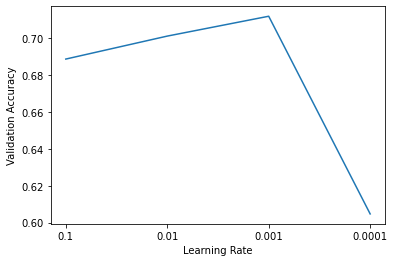

In [245]:
tune_out = []
lr_list = ['0.1', '0.01', '0.001', '0.0001']
for i in val_loss:
    tune_out.append(i[0])

print(tune_out)

plt.plot(lr_list, tune_out)
plt.xlabel('Learning Rate')
plt.ylabel('Validation Accuracy')
plt.show()

In [286]:
#Training Custom U-Net

num_classes = 30

model = Custom_UNet(3, num_classes)
    

print("Starting training process...")
trainer = Trainer(model, ds_split)
torch.cuda.empty_cache()
trainer.fit(epochs=10, batch_size=5)

# Draw a random sample
input, truth = random.choice(ds_split["val"])

# Push through our network
model = model.cpu()
output = model(input.unsqueeze(0))

# Display the input, output and truth tensors
template_table = '<table><thead><tr><th>Tensor</th><th>Shape</th><th>Image</th></tr></thead><tbody>{0}</tbody></table>'
template_row = '<tr><td>{0}</td><td>{1}</td><td><img src="data:image/png;base64,{2}"/></td></tr>'

input_img = TF.to_pil_image(input)
output_img = ds_split["val"].to_image(ds_split["val"].masks_to_indices(output).squeeze(0))
truth_img = ds_split["val"].to_image(truth)

rows = []
for name, tensor, img in [('Input', input, input_img), ('Output', output, output_img), ('Target', truth, truth_img)]:
    with BytesIO() as b: 
        img.save(b, format='png')
        rows.append(template_row.format(name, list(tensor.shape), b64encode(b.getvalue()).decode('utf-8')))

# Render HTML table
table = template_table.format(''.join(rows))
display(HTML(table))

Starting training process...
Epoch 1


Training:   0%|                                                                               | 0/2975 [00:00<?, ?it/s]

torch.Size([5, 3, 128, 256])


Training:   0%|                                            | 5/2975 [00:00<09:52,  5.01it/s, accuracy=0.504, loss=3.56]

torch.Size([5, 3, 128, 256])


Training:   0%|▏                                          | 10/2975 [00:02<10:01,  4.93it/s, accuracy=0.508, loss=3.39]

torch.Size([5, 3, 128, 256])


Training:   1%|▏                                          | 15/2975 [00:03<09:56,  4.96it/s, accuracy=0.515, loss=3.22]

torch.Size([5, 3, 128, 256])


Training:   1%|▎                                          | 20/2975 [00:04<09:49,  5.02it/s, accuracy=0.524, loss=3.08]

torch.Size([5, 3, 128, 256])


Training:   1%|▎                                          | 25/2975 [00:05<10:02,  4.89it/s, accuracy=0.533, loss=3.04]

torch.Size([5, 3, 128, 256])


Training:   1%|▍                                          | 30/2975 [00:06<09:56,  4.93it/s, accuracy=0.544, loss=2.82]

torch.Size([5, 3, 128, 256])


Training:   1%|▌                                          | 35/2975 [00:07<09:53,  4.96it/s, accuracy=0.559, loss=2.76]

torch.Size([5, 3, 128, 256])


Training:   1%|▌                                           | 40/2975 [00:08<09:46,  5.00it/s, accuracy=0.554, loss=2.8]

torch.Size([5, 3, 128, 256])


Training:   2%|▋                                          | 45/2975 [00:09<09:41,  5.04it/s, accuracy=0.543, loss=2.68]

torch.Size([5, 3, 128, 256])


Training:   2%|▋                                          | 50/2975 [00:10<09:38,  5.06it/s, accuracy=0.553, loss=2.76]

torch.Size([5, 3, 128, 256])


Training:   2%|▊                                          | 55/2975 [00:11<09:41,  5.03it/s, accuracy=0.595, loss=2.59]

torch.Size([5, 3, 128, 256])


Training:   2%|▊                                          | 60/2975 [00:12<09:43,  5.00it/s, accuracy=0.566, loss=2.55]

torch.Size([5, 3, 128, 256])


Training:   2%|▉                                          | 65/2975 [00:12<09:35,  5.05it/s, accuracy=0.555, loss=2.67]

torch.Size([5, 3, 128, 256])


Training:   2%|█                                          | 70/2975 [00:13<09:29,  5.10it/s, accuracy=0.655, loss=2.36]

torch.Size([5, 3, 128, 256])


Training:   3%|█                                          | 75/2975 [00:14<09:24,  5.13it/s, accuracy=0.602, loss=2.49]

torch.Size([5, 3, 128, 256])


Training:   3%|█▏                                         | 80/2975 [00:15<09:24,  5.12it/s, accuracy=0.594, loss=2.58]

torch.Size([5, 3, 128, 256])


Training:   3%|█▏                                         | 85/2975 [00:16<09:27,  5.09it/s, accuracy=0.582, loss=2.41]

torch.Size([5, 3, 128, 256])


Training:   3%|█▎                                         | 90/2975 [00:17<09:44,  4.94it/s, accuracy=0.651, loss=2.35]

torch.Size([5, 3, 128, 256])


Training:   3%|█▎                                         | 95/2975 [00:19<10:10,  4.72it/s, accuracy=0.642, loss=2.26]

torch.Size([5, 3, 128, 256])


Training:   3%|█▍                                         | 100/2975 [00:20<10:08,  4.72it/s, accuracy=0.626, loss=2.2]

torch.Size([5, 3, 128, 256])


Training:   4%|█▍                                        | 105/2975 [00:21<09:54,  4.83it/s, accuracy=0.643, loss=2.29]

torch.Size([5, 3, 128, 256])


Training:   4%|█▌                                        | 110/2975 [00:22<09:45,  4.89it/s, accuracy=0.627, loss=2.17]

torch.Size([5, 3, 128, 256])


Training:   4%|█▌                                        | 115/2975 [00:23<09:34,  4.98it/s, accuracy=0.618, loss=2.36]

torch.Size([5, 3, 128, 256])


Training:   4%|█▋                                        | 120/2975 [00:24<09:29,  5.01it/s, accuracy=0.594, loss=2.16]

torch.Size([5, 3, 128, 256])


Training:   4%|█▊                                        | 125/2975 [00:25<09:25,  5.04it/s, accuracy=0.641, loss=1.93]

torch.Size([5, 3, 128, 256])


Training:   4%|█▊                                        | 130/2975 [00:26<09:25,  5.03it/s, accuracy=0.611, loss=2.17]

torch.Size([5, 3, 128, 256])


Training:   5%|█▉                                        | 135/2975 [00:27<09:25,  5.02it/s, accuracy=0.612, loss=2.13]

torch.Size([5, 3, 128, 256])


Training:   5%|█▉                                        | 140/2975 [00:28<09:18,  5.07it/s, accuracy=0.612, loss=2.13]

torch.Size([5, 3, 128, 256])


Training:   5%|██                                        | 145/2975 [00:29<09:13,  5.11it/s, accuracy=0.639, loss=2.01]

torch.Size([5, 3, 128, 256])


Training:   5%|██                                        | 150/2975 [00:29<09:09,  5.14it/s, accuracy=0.621, loss=2.24]

torch.Size([5, 3, 128, 256])


Training:   5%|██▏                                       | 155/2975 [00:30<09:06,  5.16it/s, accuracy=0.653, loss=1.97]

torch.Size([5, 3, 128, 256])


Training:   5%|██▎                                        | 160/2975 [00:31<09:04,  5.17it/s, accuracy=0.655, loss=1.9]

torch.Size([5, 3, 128, 256])


Training:   6%|██▎                                       | 165/2975 [00:32<09:04,  5.16it/s, accuracy=0.658, loss=1.88]

torch.Size([5, 3, 128, 256])


Training:   6%|██▍                                       | 170/2975 [00:33<09:08,  5.11it/s, accuracy=0.654, loss=1.83]

torch.Size([5, 3, 128, 256])


Training:   6%|██▍                                       | 175/2975 [00:34<09:10,  5.08it/s, accuracy=0.663, loss=2.07]

torch.Size([5, 3, 128, 256])


Training:   6%|██▌                                       | 180/2975 [00:35<09:20,  4.99it/s, accuracy=0.637, loss=1.82]

torch.Size([5, 3, 128, 256])


Training:   6%|██▌                                       | 185/2975 [00:36<09:18,  5.00it/s, accuracy=0.656, loss=1.79]

torch.Size([5, 3, 128, 256])


Training:   6%|██▋                                       | 190/2975 [00:37<09:15,  5.01it/s, accuracy=0.657, loss=1.83]

torch.Size([5, 3, 128, 256])


Training:   7%|██▊                                       | 195/2975 [00:38<09:12,  5.03it/s, accuracy=0.627, loss=2.11]

torch.Size([5, 3, 128, 256])


Training:   7%|██▉                                        | 200/2975 [00:39<09:10,  5.04it/s, accuracy=0.696, loss=1.8]

torch.Size([5, 3, 128, 256])


Training:   7%|██▉                                       | 205/2975 [00:40<09:07,  5.06it/s, accuracy=0.652, loss=1.82]

torch.Size([5, 3, 128, 256])


Training:   7%|██▉                                       | 210/2975 [00:41<09:06,  5.06it/s, accuracy=0.657, loss=2.13]

torch.Size([5, 3, 128, 256])


Training:   7%|███                                       | 215/2975 [00:42<09:05,  5.06it/s, accuracy=0.596, loss=1.99]

torch.Size([5, 3, 128, 256])


Training:   7%|███                                       | 220/2975 [00:43<09:03,  5.07it/s, accuracy=0.675, loss=1.72]

torch.Size([5, 3, 128, 256])


Training:   8%|███▏                                      | 225/2975 [00:44<09:03,  5.06it/s, accuracy=0.709, loss=1.81]

torch.Size([5, 3, 128, 256])


Training:   8%|███▏                                      | 230/2975 [00:45<09:01,  5.07it/s, accuracy=0.675, loss=1.71]

torch.Size([5, 3, 128, 256])


Training:   8%|███▎                                      | 235/2975 [00:46<08:59,  5.08it/s, accuracy=0.687, loss=1.77]

torch.Size([5, 3, 128, 256])


Training:   8%|███▍                                       | 240/2975 [00:47<08:56,  5.10it/s, accuracy=0.65, loss=1.94]

torch.Size([5, 3, 128, 256])


Training:   8%|███▍                                      | 245/2975 [00:48<08:59,  5.06it/s, accuracy=0.672, loss=1.75]

torch.Size([5, 3, 128, 256])


Training:   8%|███▌                                      | 250/2975 [00:49<08:57,  5.07it/s, accuracy=0.677, loss=1.72]

torch.Size([5, 3, 128, 256])


Training:   9%|███▋                                       | 255/2975 [00:50<08:55,  5.08it/s, accuracy=0.67, loss=1.71]

torch.Size([5, 3, 128, 256])


Training:   9%|███▋                                      | 260/2975 [00:51<08:54,  5.08it/s, accuracy=0.733, loss=1.56]

torch.Size([5, 3, 128, 256])


Training:   9%|███▋                                      | 265/2975 [00:52<08:52,  5.09it/s, accuracy=0.708, loss=1.58]

torch.Size([5, 3, 128, 256])


Training:   9%|███▊                                      | 270/2975 [00:53<08:53,  5.07it/s, accuracy=0.693, loss=1.59]

torch.Size([5, 3, 128, 256])


Training:   9%|███▉                                      | 275/2975 [00:54<08:53,  5.06it/s, accuracy=0.681, loss=1.95]

torch.Size([5, 3, 128, 256])


Training:   9%|███▉                                      | 280/2975 [00:55<08:53,  5.06it/s, accuracy=0.694, loss=1.57]

torch.Size([5, 3, 128, 256])


Training:  10%|████                                      | 285/2975 [00:56<08:52,  5.05it/s, accuracy=0.702, loss=1.71]

torch.Size([5, 3, 128, 256])


Training:  10%|████                                      | 290/2975 [00:57<08:52,  5.05it/s, accuracy=0.692, loss=1.59]

torch.Size([5, 3, 128, 256])


Training:  10%|████▏                                     | 295/2975 [00:58<08:49,  5.06it/s, accuracy=0.652, loss=1.64]

torch.Size([5, 3, 128, 256])


Training:  10%|████▏                                     | 300/2975 [00:59<08:50,  5.04it/s, accuracy=0.678, loss=1.52]

torch.Size([5, 3, 128, 256])


Training:  10%|████▎                                     | 305/2975 [01:00<08:49,  5.04it/s, accuracy=0.697, loss=1.81]

torch.Size([5, 3, 128, 256])


Training:  10%|████▍                                     | 310/2975 [01:01<08:47,  5.05it/s, accuracy=0.719, loss=1.49]

torch.Size([5, 3, 128, 256])


Training:  11%|████▋                                       | 315/2975 [01:02<08:48,  5.04it/s, accuracy=0.67, loss=1.7]

torch.Size([5, 3, 128, 256])


Training:  11%|████▋                                      | 320/2975 [01:03<08:45,  5.06it/s, accuracy=0.72, loss=1.58]

torch.Size([5, 3, 128, 256])


Training:  11%|████▌                                     | 325/2975 [01:04<08:46,  5.04it/s, accuracy=0.724, loss=1.85]

torch.Size([5, 3, 128, 256])


Training:  11%|████▋                                     | 330/2975 [01:05<08:44,  5.04it/s, accuracy=0.669, loss=1.83]

torch.Size([5, 3, 128, 256])


Training:  11%|████▋                                     | 335/2975 [01:06<08:41,  5.06it/s, accuracy=0.722, loss=1.54]

torch.Size([5, 3, 128, 256])


Training:  11%|████▊                                     | 340/2975 [01:07<08:37,  5.09it/s, accuracy=0.736, loss=1.66]

torch.Size([5, 3, 128, 256])


Training:  12%|████▊                                     | 345/2975 [01:08<08:35,  5.10it/s, accuracy=0.687, loss=1.75]

torch.Size([5, 3, 128, 256])


Training:  12%|████▉                                     | 350/2975 [01:09<08:35,  5.09it/s, accuracy=0.658, loss=1.49]

torch.Size([5, 3, 128, 256])


Training:  12%|█████                                     | 355/2975 [01:10<08:34,  5.10it/s, accuracy=0.671, loss=1.62]

torch.Size([5, 3, 128, 256])


Training:  12%|█████                                     | 360/2975 [01:11<08:32,  5.11it/s, accuracy=0.689, loss=1.25]

torch.Size([5, 3, 128, 256])


Training:  12%|█████▎                                     | 365/2975 [01:12<08:31,  5.10it/s, accuracy=0.71, loss=1.49]

torch.Size([5, 3, 128, 256])


Training:  12%|█████▏                                    | 370/2975 [01:13<08:30,  5.10it/s, accuracy=0.747, loss=1.48]

torch.Size([5, 3, 128, 256])


Training:  13%|█████▍                                     | 375/2975 [01:14<08:28,  5.12it/s, accuracy=0.705, loss=1.3]

torch.Size([5, 3, 128, 256])


Training:  13%|█████▎                                    | 380/2975 [01:15<08:27,  5.12it/s, accuracy=0.688, loss=1.43]

torch.Size([5, 3, 128, 256])


Training:  13%|█████▍                                    | 385/2975 [01:16<08:27,  5.10it/s, accuracy=0.715, loss=1.54]

torch.Size([5, 3, 128, 256])


Training:  13%|█████▌                                    | 390/2975 [01:17<08:29,  5.07it/s, accuracy=0.696, loss=1.88]

torch.Size([5, 3, 128, 256])


Training:  13%|█████▌                                    | 395/2975 [01:18<08:28,  5.07it/s, accuracy=0.717, loss=1.31]

torch.Size([5, 3, 128, 256])


Training:  13%|█████▋                                    | 400/2975 [01:19<08:28,  5.07it/s, accuracy=0.676, loss=1.29]

torch.Size([5, 3, 128, 256])


Training:  14%|█████▊                                     | 405/2975 [01:20<08:27,  5.07it/s, accuracy=0.701, loss=1.7]

torch.Size([5, 3, 128, 256])


Training:  14%|█████▊                                    | 410/2975 [01:21<08:26,  5.06it/s, accuracy=0.702, loss=1.22]

torch.Size([5, 3, 128, 256])


Training:  14%|█████▊                                    | 415/2975 [01:22<08:26,  5.05it/s, accuracy=0.714, loss=1.35]

torch.Size([5, 3, 128, 256])


Training:  14%|█████▉                                    | 420/2975 [01:23<08:26,  5.05it/s, accuracy=0.709, loss=1.19]

torch.Size([5, 3, 128, 256])


Training:  14%|██████                                    | 425/2975 [01:24<08:27,  5.02it/s, accuracy=0.741, loss=1.15]

torch.Size([5, 3, 128, 256])


Training:  14%|██████                                    | 430/2975 [01:25<08:30,  4.99it/s, accuracy=0.706, loss=1.47]

torch.Size([5, 3, 128, 256])


Training:  15%|██████▏                                   | 435/2975 [01:26<08:25,  5.02it/s, accuracy=0.651, loss=1.58]

torch.Size([5, 3, 128, 256])


Training:  15%|██████▏                                   | 440/2975 [01:27<08:27,  5.00it/s, accuracy=0.661, loss=1.35]

torch.Size([5, 3, 128, 256])


Training:  15%|██████▎                                   | 445/2975 [01:28<08:26,  5.00it/s, accuracy=0.701, loss=1.18]

torch.Size([5, 3, 128, 256])


Training:  15%|██████▌                                    | 450/2975 [01:29<08:25,  5.00it/s, accuracy=0.727, loss=1.5]

torch.Size([5, 3, 128, 256])


Training:  15%|██████▌                                    | 455/2975 [01:30<08:23,  5.01it/s, accuracy=0.709, loss=1.5]

torch.Size([5, 3, 128, 256])


Training:  15%|██████▋                                    | 460/2975 [01:31<08:27,  4.96it/s, accuracy=0.716, loss=1.3]

torch.Size([5, 3, 128, 256])


Training:  16%|██████▌                                   | 465/2975 [01:32<08:25,  4.97it/s, accuracy=0.728, loss=1.36]

torch.Size([5, 3, 128, 256])


Training:  16%|██████▋                                   | 470/2975 [01:33<08:23,  4.97it/s, accuracy=0.718, loss=1.42]

torch.Size([5, 3, 128, 256])


Training:  16%|██████▋                                   | 475/2975 [01:34<08:22,  4.97it/s, accuracy=0.717, loss=1.13]

torch.Size([5, 3, 128, 256])


Training:  16%|██████▊                                   | 480/2975 [01:35<08:45,  4.75it/s, accuracy=0.697, loss=1.31]

torch.Size([5, 3, 128, 256])


Training:  16%|██████▊                                   | 485/2975 [01:36<08:46,  4.73it/s, accuracy=0.706, loss=1.09]

torch.Size([5, 3, 128, 256])


Training:  16%|██████▉                                   | 490/2975 [01:37<08:42,  4.76it/s, accuracy=0.708, loss=1.15]

torch.Size([5, 3, 128, 256])


Training:  17%|███████▏                                   | 495/2975 [01:38<08:34,  4.82it/s, accuracy=0.696, loss=1.6]

torch.Size([5, 3, 128, 256])


Training:  17%|███████                                   | 500/2975 [01:39<08:32,  4.83it/s, accuracy=0.779, loss=1.27]

torch.Size([5, 3, 128, 256])


Training:  17%|███████▏                                  | 505/2975 [01:40<08:44,  4.71it/s, accuracy=0.735, loss=1.17]

torch.Size([5, 3, 128, 256])


Training:  17%|███████▏                                  | 510/2975 [01:41<08:41,  4.73it/s, accuracy=0.701, loss=1.08]

torch.Size([5, 3, 128, 256])


Training:  17%|███████▎                                  | 515/2975 [01:42<08:37,  4.75it/s, accuracy=0.713, loss=1.16]

torch.Size([5, 3, 128, 256])


Training:  17%|███████▎                                  | 520/2975 [01:43<08:28,  4.83it/s, accuracy=0.704, loss=1.08]

torch.Size([5, 3, 128, 256])


Training:  18%|███████▍                                  | 525/2975 [01:44<08:25,  4.84it/s, accuracy=0.717, loss=1.13]

torch.Size([5, 3, 128, 256])


Training:  18%|███████▋                                   | 530/2975 [01:45<08:18,  4.90it/s, accuracy=0.72, loss=1.09]

torch.Size([5, 3, 128, 256])


Training:  18%|███████▌                                  | 535/2975 [01:46<08:09,  4.99it/s, accuracy=0.701, loss=1.09]

torch.Size([5, 3, 128, 256])


Training:  18%|███████▊                                   | 540/2975 [01:47<08:06,  5.01it/s, accuracy=0.667, loss=1.7]

torch.Size([5, 3, 128, 256])


Training:  18%|███████▋                                  | 545/2975 [01:48<08:03,  5.02it/s, accuracy=0.689, loss=1.53]

torch.Size([5, 3, 128, 256])


Training:  18%|████████▏                                   | 550/2975 [01:49<08:03,  5.01it/s, accuracy=0.7, loss=1.18]

torch.Size([5, 3, 128, 256])


Training:  19%|███████▊                                  | 555/2975 [01:50<08:01,  5.03it/s, accuracy=0.661, loss=1.34]

torch.Size([5, 3, 128, 256])


Training:  19%|███████▉                                  | 560/2975 [01:51<08:03,  5.00it/s, accuracy=0.706, loss=1.21]

torch.Size([5, 3, 128, 256])


Training:  19%|███████▉                                  | 565/2975 [01:52<08:01,  5.00it/s, accuracy=0.684, loss=1.72]

torch.Size([5, 3, 128, 256])


Training:  19%|████████▏                                  | 570/2975 [01:53<07:59,  5.01it/s, accuracy=0.68, loss=1.54]

torch.Size([5, 3, 128, 256])


Training:  19%|████████▎                                  | 575/2975 [01:54<07:58,  5.01it/s, accuracy=0.689, loss=1.4]

torch.Size([5, 3, 128, 256])


Training:  19%|████████▏                                 | 580/2975 [01:55<08:00,  4.98it/s, accuracy=0.696, loss=1.27]

torch.Size([5, 3, 128, 256])


Training:  20%|████████▎                                 | 585/2975 [01:56<07:58,  5.00it/s, accuracy=0.686, loss=1.42]

torch.Size([5, 3, 128, 256])


Training:  20%|████████▎                                 | 590/2975 [01:57<07:54,  5.02it/s, accuracy=0.662, loss=1.22]

torch.Size([5, 3, 128, 256])


Training:  20%|████████▍                                 | 595/2975 [01:58<07:51,  5.05it/s, accuracy=0.681, loss=1.12]

torch.Size([5, 3, 128, 256])


Training:  20%|████████▍                                 | 600/2975 [01:59<07:48,  5.07it/s, accuracy=0.716, loss=1.05]

torch.Size([5, 3, 128, 256])


Training:  20%|████████▌                                 | 605/2975 [02:00<07:50,  5.04it/s, accuracy=0.757, loss=1.01]

torch.Size([5, 3, 128, 256])


Training:  21%|████████▊                                  | 610/2975 [02:01<07:47,  5.06it/s, accuracy=0.68, loss=1.22]

torch.Size([5, 3, 128, 256])


Training:  21%|████████▋                                 | 615/2975 [02:02<07:45,  5.07it/s, accuracy=0.685, loss=1.17]

torch.Size([5, 3, 128, 256])


Training:  21%|████████▌                                | 620/2975 [02:03<07:43,  5.08it/s, accuracy=0.706, loss=0.985]

torch.Size([5, 3, 128, 256])


Training:  21%|████████▊                                 | 625/2975 [02:04<07:44,  5.06it/s, accuracy=0.685, loss=1.68]

torch.Size([5, 3, 128, 256])


Training:  21%|████████▉                                 | 630/2975 [02:05<07:44,  5.05it/s, accuracy=0.707, loss=1.32]

torch.Size([5, 3, 128, 256])


Training:  21%|████████▉                                 | 635/2975 [02:06<07:42,  5.06it/s, accuracy=0.715, loss=1.14]

torch.Size([5, 3, 128, 256])


Training:  22%|█████████▎                                 | 640/2975 [02:07<07:41,  5.05it/s, accuracy=0.68, loss=1.28]

torch.Size([5, 3, 128, 256])


Training:  22%|█████████▎                                 | 645/2975 [02:08<07:45,  5.01it/s, accuracy=0.69, loss=1.19]

torch.Size([5, 3, 128, 256])


Training:  22%|█████████▏                                | 650/2975 [02:09<07:46,  4.98it/s, accuracy=0.752, loss=1.01]

torch.Size([5, 3, 128, 256])


Training:  22%|█████████▏                                | 655/2975 [02:10<07:43,  5.00it/s, accuracy=0.715, loss=1.28]

torch.Size([5, 3, 128, 256])


Training:  22%|█████████▎                                | 660/2975 [02:11<07:40,  5.02it/s, accuracy=0.698, loss=1.47]

torch.Size([5, 3, 128, 256])


Training:  22%|█████████▍                                | 665/2975 [02:12<07:39,  5.03it/s, accuracy=0.747, loss=1.15]

torch.Size([5, 3, 128, 256])


Training:  23%|█████████▏                               | 670/2975 [02:13<07:42,  4.98it/s, accuracy=0.725, loss=0.896]

torch.Size([5, 3, 128, 256])


Training:  23%|█████████▉                                  | 675/2975 [02:14<07:45,  4.94it/s, accuracy=0.68, loss=1.4]

torch.Size([5, 3, 128, 256])


Training:  23%|█████████▌                                | 680/2975 [02:15<07:44,  4.94it/s, accuracy=0.688, loss=1.51]

torch.Size([5, 3, 128, 256])


Training:  23%|█████████▋                                | 685/2975 [02:16<07:46,  4.91it/s, accuracy=0.709, loss=1.25]

torch.Size([5, 3, 128, 256])


Training:  23%|██████████▏                                 | 690/2975 [02:17<08:02,  4.73it/s, accuracy=0.7, loss=1.08]

torch.Size([5, 3, 128, 256])


Training:  23%|██████████                                 | 695/2975 [02:18<08:09,  4.66it/s, accuracy=0.73, loss=1.14]

torch.Size([5, 3, 128, 256])


Training:  24%|█████████▉                                | 700/2975 [02:20<08:06,  4.67it/s, accuracy=0.715, loss=1.38]

torch.Size([5, 3, 128, 256])


Training:  24%|█████████▉                                | 705/2975 [02:21<07:57,  4.75it/s, accuracy=0.697, loss=1.23]

torch.Size([5, 3, 128, 256])


Training:  24%|██████████                                | 710/2975 [02:22<07:49,  4.82it/s, accuracy=0.646, loss=1.27]

torch.Size([5, 3, 128, 256])


Training:  24%|██████████                                | 715/2975 [02:23<07:41,  4.89it/s, accuracy=0.692, loss=1.24]

torch.Size([5, 3, 128, 256])


Training:  24%|██████████▏                               | 720/2975 [02:24<07:35,  4.95it/s, accuracy=0.677, loss=1.47]

torch.Size([5, 3, 128, 256])


Training:  24%|██████████▏                               | 725/2975 [02:25<07:29,  5.01it/s, accuracy=0.722, loss=1.26]

torch.Size([5, 3, 128, 256])


Training:  25%|██████████▎                               | 730/2975 [02:26<07:28,  5.01it/s, accuracy=0.699, loss=1.05]

torch.Size([5, 3, 128, 256])


Training:  25%|██████████▍                               | 735/2975 [02:26<07:23,  5.05it/s, accuracy=0.697, loss=1.04]

torch.Size([5, 3, 128, 256])


Training:  25%|██████████▍                               | 740/2975 [02:27<07:22,  5.05it/s, accuracy=0.735, loss=1.06]

torch.Size([5, 3, 128, 256])


Training:  25%|██████████▌                               | 745/2975 [02:28<07:17,  5.09it/s, accuracy=0.708, loss=1.26]

torch.Size([5, 3, 128, 256])


Training:  25%|██████████▊                                | 750/2975 [02:29<07:17,  5.08it/s, accuracy=0.72, loss=1.01]

torch.Size([5, 3, 128, 256])


Training:  25%|██████████▋                               | 755/2975 [02:30<07:15,  5.10it/s, accuracy=0.708, loss=1.25]

torch.Size([5, 3, 128, 256])


Training:  26%|███████████▏                                | 760/2975 [02:31<07:14,  5.10it/s, accuracy=0.7, loss=1.09]

torch.Size([5, 3, 128, 256])


Training:  26%|██████████▊                               | 765/2975 [02:32<07:12,  5.11it/s, accuracy=0.707, loss=0.92]

torch.Size([5, 3, 128, 256])


Training:  26%|██████████▊                               | 770/2975 [02:33<07:11,  5.11it/s, accuracy=0.698, loss=1.74]

torch.Size([5, 3, 128, 256])


Training:  26%|██████████▉                               | 775/2975 [02:34<07:12,  5.09it/s, accuracy=0.684, loss=1.21]

torch.Size([5, 3, 128, 256])


Training:  26%|███████████▎                               | 780/2975 [02:35<07:09,  5.11it/s, accuracy=0.71, loss=1.09]

torch.Size([5, 3, 128, 256])


Training:  26%|███████████                               | 785/2975 [02:36<07:10,  5.09it/s, accuracy=0.697, loss=1.15]

torch.Size([5, 3, 128, 256])


Training:  27%|███████████▋                                | 790/2975 [02:37<07:08,  5.10it/s, accuracy=0.7, loss=1.02]

torch.Size([5, 3, 128, 256])


Training:  27%|██████████▉                              | 795/2975 [02:38<07:08,  5.08it/s, accuracy=0.701, loss=0.928]

torch.Size([5, 3, 128, 256])


Training:  27%|███████████▎                              | 800/2975 [02:39<07:07,  5.09it/s, accuracy=0.697, loss=1.19]

torch.Size([5, 3, 128, 256])


Training:  27%|███████████▎                              | 805/2975 [02:40<07:05,  5.10it/s, accuracy=0.708, loss=1.11]

torch.Size([5, 3, 128, 256])


Training:  27%|███████████▍                              | 810/2975 [02:41<07:03,  5.11it/s, accuracy=0.669, loss=1.15]

torch.Size([5, 3, 128, 256])


Training:  27%|███████████▌                              | 815/2975 [02:42<07:00,  5.13it/s, accuracy=0.665, loss=1.11]

torch.Size([5, 3, 128, 256])


Training:  28%|███████████▌                              | 820/2975 [02:43<06:59,  5.14it/s, accuracy=0.711, loss=1.09]

torch.Size([5, 3, 128, 256])


Training:  28%|████████████▏                               | 825/2975 [02:44<06:57,  5.15it/s, accuracy=0.7, loss=1.07]

torch.Size([5, 3, 128, 256])


Training:  28%|███████████▍                             | 830/2975 [02:45<06:57,  5.13it/s, accuracy=0.716, loss=0.921]

torch.Size([5, 3, 128, 256])


Training:  28%|███████████▊                              | 835/2975 [02:46<06:59,  5.10it/s, accuracy=0.724, loss=1.13]

torch.Size([5, 3, 128, 256])


Training:  28%|███████████▊                              | 840/2975 [02:47<06:59,  5.08it/s, accuracy=0.678, loss=1.13]

torch.Size([5, 3, 128, 256])


Training:  28%|███████████▋                             | 845/2975 [02:48<06:58,  5.09it/s, accuracy=0.735, loss=0.907]

torch.Size([5, 3, 128, 256])


Training:  29%|███████████▋                             | 850/2975 [02:49<07:00,  5.06it/s, accuracy=0.685, loss=0.973]

torch.Size([5, 3, 128, 256])


Training:  29%|████████████                              | 855/2975 [02:50<06:58,  5.07it/s, accuracy=0.772, loss=0.84]

torch.Size([5, 3, 128, 256])


Training:  29%|████████████▏                             | 860/2975 [02:51<06:57,  5.06it/s, accuracy=0.714, loss=1.21]

torch.Size([5, 3, 128, 256])


Training:  29%|███████████▉                             | 865/2975 [02:52<06:56,  5.07it/s, accuracy=0.757, loss=0.806]

torch.Size([5, 3, 128, 256])


Training:  29%|███████████▉                             | 870/2975 [02:53<06:54,  5.08it/s, accuracy=0.696, loss=0.968]

torch.Size([5, 3, 128, 256])


Training:  29%|████████████                             | 875/2975 [02:54<06:51,  5.10it/s, accuracy=0.668, loss=0.898]

torch.Size([5, 3, 128, 256])


Training:  30%|████████████▍                             | 880/2975 [02:55<06:50,  5.11it/s, accuracy=0.717, loss=1.03]

torch.Size([5, 3, 128, 256])


Training:  30%|████████████▏                            | 885/2975 [02:56<06:49,  5.10it/s, accuracy=0.701, loss=0.869]

torch.Size([5, 3, 128, 256])


Training:  30%|████████████▌                             | 890/2975 [02:57<06:48,  5.10it/s, accuracy=0.74, loss=0.871]

torch.Size([5, 3, 128, 256])


Training:  30%|████████████▋                             | 895/2975 [02:58<06:46,  5.12it/s, accuracy=0.684, loss=1.04]

torch.Size([5, 3, 128, 256])


Training:  30%|████████████▍                            | 900/2975 [02:59<06:44,  5.13it/s, accuracy=0.731, loss=0.738]

torch.Size([5, 3, 128, 256])


Training:  30%|████████████▊                             | 905/2975 [03:00<06:45,  5.11it/s, accuracy=0.726, loss=1.07]

torch.Size([5, 3, 128, 256])


Training:  31%|████████████▌                            | 910/2975 [03:01<06:43,  5.12it/s, accuracy=0.712, loss=0.961]

torch.Size([5, 3, 128, 256])


Training:  31%|████████████▌                            | 915/2975 [03:02<06:41,  5.13it/s, accuracy=0.719, loss=0.872]

torch.Size([5, 3, 128, 256])


Training:  31%|████████████▉                             | 920/2975 [03:03<06:43,  5.10it/s, accuracy=0.706, loss=0.84]

torch.Size([5, 3, 128, 256])


Training:  31%|████████████▋                            | 925/2975 [03:04<06:42,  5.09it/s, accuracy=0.723, loss=0.846]

torch.Size([5, 3, 128, 256])


Training:  31%|████████████▊                            | 930/2975 [03:05<06:41,  5.10it/s, accuracy=0.692, loss=0.928]

torch.Size([5, 3, 128, 256])


Training:  31%|█████████████▏                            | 935/2975 [03:06<06:40,  5.10it/s, accuracy=0.685, loss=1.37]

torch.Size([5, 3, 128, 256])


Training:  32%|█████████████▎                            | 940/2975 [03:07<06:38,  5.10it/s, accuracy=0.729, loss=1.13]

torch.Size([5, 3, 128, 256])


Training:  32%|█████████████▎                            | 945/2975 [03:08<06:40,  5.07it/s, accuracy=0.683, loss=1.43]

torch.Size([5, 3, 128, 256])


Training:  32%|█████████████                            | 950/2975 [03:09<06:41,  5.05it/s, accuracy=0.725, loss=0.786]

torch.Size([5, 3, 128, 256])


Training:  32%|█████████████▍                            | 955/2975 [03:10<06:42,  5.01it/s, accuracy=0.715, loss=1.02]

torch.Size([5, 3, 128, 256])


Training:  32%|█████████████▌                            | 960/2975 [03:11<06:37,  5.07it/s, accuracy=0.716, loss=1.04]

torch.Size([5, 3, 128, 256])


Training:  32%|█████████████▌                            | 965/2975 [03:12<06:35,  5.08it/s, accuracy=0.76, loss=0.757]

torch.Size([5, 3, 128, 256])


Training:  33%|█████████████▎                           | 970/2975 [03:13<06:33,  5.10it/s, accuracy=0.718, loss=0.824]

torch.Size([5, 3, 128, 256])


Training:  33%|█████████████▍                           | 975/2975 [03:14<06:33,  5.09it/s, accuracy=0.704, loss=0.873]

torch.Size([5, 3, 128, 256])


Training:  33%|█████████████▊                            | 980/2975 [03:15<06:30,  5.10it/s, accuracy=0.728, loss=1.39]

torch.Size([5, 3, 128, 256])


Training:  33%|█████████████▌                           | 985/2975 [03:16<06:32,  5.07it/s, accuracy=0.723, loss=0.888]

torch.Size([5, 3, 128, 256])


Training:  33%|█████████████▉                            | 990/2975 [03:17<06:30,  5.08it/s, accuracy=0.713, loss=1.09]

torch.Size([5, 3, 128, 256])


Training:  33%|██████████████                            | 995/2975 [03:18<06:30,  5.07it/s, accuracy=0.689, loss=1.18]

torch.Size([5, 3, 128, 256])


Training:  34%|█████████████▍                          | 1000/2975 [03:18<06:28,  5.08it/s, accuracy=0.702, loss=0.912]

torch.Size([5, 3, 128, 256])


Training:  34%|█████████████▌                          | 1005/2975 [03:19<06:27,  5.09it/s, accuracy=0.742, loss=0.853]

torch.Size([5, 3, 128, 256])


Training:  34%|█████████████▉                           | 1010/2975 [03:20<06:26,  5.09it/s, accuracy=0.697, loss=1.14]

torch.Size([5, 3, 128, 256])


Training:  34%|█████████████▉                           | 1015/2975 [03:21<06:25,  5.08it/s, accuracy=0.663, loss=1.19]

torch.Size([5, 3, 128, 256])


Training:  34%|██████████████▍                           | 1020/2975 [03:22<06:27,  5.04it/s, accuracy=0.713, loss=1.2]

torch.Size([5, 3, 128, 256])


Training:  34%|██████████████▍                           | 1025/2975 [03:23<06:26,  5.05it/s, accuracy=0.721, loss=1.2]

torch.Size([5, 3, 128, 256])


Training:  35%|█████████████▊                          | 1030/2975 [03:24<06:25,  5.05it/s, accuracy=0.725, loss=0.826]

torch.Size([5, 3, 128, 256])


Training:  35%|█████████████▉                          | 1035/2975 [03:25<06:25,  5.03it/s, accuracy=0.692, loss=0.788]

torch.Size([5, 3, 128, 256])


Training:  35%|█████████████▉                          | 1040/2975 [03:26<06:25,  5.01it/s, accuracy=0.657, loss=0.788]

torch.Size([5, 3, 128, 256])


Training:  35%|██████████████▊                           | 1045/2975 [03:27<06:23,  5.04it/s, accuracy=0.65, loss=1.09]

torch.Size([5, 3, 128, 256])


Training:  35%|██████████████▍                          | 1050/2975 [03:28<06:19,  5.07it/s, accuracy=0.664, loss=1.68]

torch.Size([5, 3, 128, 256])


Training:  35%|██████████████▌                          | 1055/2975 [03:29<06:18,  5.07it/s, accuracy=0.759, loss=0.93]

torch.Size([5, 3, 128, 256])


Training:  36%|██████████████▌                          | 1060/2975 [03:30<06:15,  5.10it/s, accuracy=0.724, loss=1.22]

torch.Size([5, 3, 128, 256])


Training:  36%|██████████████▎                         | 1065/2975 [03:31<06:16,  5.07it/s, accuracy=0.665, loss=0.956]

torch.Size([5, 3, 128, 256])


Training:  36%|██████████████▍                         | 1070/2975 [03:32<06:14,  5.08it/s, accuracy=0.679, loss=0.818]

torch.Size([5, 3, 128, 256])


Training:  36%|██████████████▍                         | 1075/2975 [03:33<06:11,  5.11it/s, accuracy=0.684, loss=0.966]

torch.Size([5, 3, 128, 256])


Training:  36%|██████████████▌                         | 1080/2975 [03:34<06:11,  5.11it/s, accuracy=0.699, loss=0.882]

torch.Size([5, 3, 128, 256])


Training:  36%|███████████████▎                          | 1085/2975 [03:35<06:10,  5.10it/s, accuracy=0.696, loss=1.4]

torch.Size([5, 3, 128, 256])


Training:  37%|██████████████▋                         | 1090/2975 [03:36<06:08,  5.12it/s, accuracy=0.711, loss=0.744]

torch.Size([5, 3, 128, 256])


Training:  37%|██████████████▋                         | 1095/2975 [03:37<06:08,  5.11it/s, accuracy=0.736, loss=0.972]

torch.Size([5, 3, 128, 256])


Training:  37%|██████████████▊                         | 1100/2975 [03:38<06:06,  5.11it/s, accuracy=0.699, loss=0.999]

torch.Size([5, 3, 128, 256])


Training:  37%|███████████████▏                         | 1105/2975 [03:39<06:05,  5.11it/s, accuracy=0.676, loss=1.23]

torch.Size([5, 3, 128, 256])


Training:  37%|██████████████▉                         | 1110/2975 [03:40<06:03,  5.13it/s, accuracy=0.694, loss=0.934]

torch.Size([5, 3, 128, 256])


Training:  37%|███████████████▋                          | 1115/2975 [03:41<06:03,  5.12it/s, accuracy=0.699, loss=1.4]

torch.Size([5, 3, 128, 256])


Training:  38%|███████████████                         | 1120/2975 [03:42<06:03,  5.10it/s, accuracy=0.719, loss=0.965]

torch.Size([5, 3, 128, 256])


Training:  38%|███████████████▏                        | 1125/2975 [03:43<06:02,  5.10it/s, accuracy=0.711, loss=0.807]

torch.Size([5, 3, 128, 256])


Training:  38%|███████████████▌                         | 1130/2975 [03:44<06:02,  5.10it/s, accuracy=0.748, loss=0.94]

torch.Size([5, 3, 128, 256])


Training:  38%|███████████████▋                         | 1135/2975 [03:45<05:59,  5.11it/s, accuracy=0.72, loss=0.947]

torch.Size([5, 3, 128, 256])


Training:  38%|███████████████▋                         | 1140/2975 [03:46<05:58,  5.12it/s, accuracy=0.713, loss=1.09]

torch.Size([5, 3, 128, 256])


Training:  38%|███████████████▊                         | 1145/2975 [03:47<05:56,  5.13it/s, accuracy=0.687, loss=1.09]

torch.Size([5, 3, 128, 256])


Training:  39%|███████████████▍                        | 1150/2975 [03:48<05:56,  5.12it/s, accuracy=0.777, loss=0.752]

torch.Size([5, 3, 128, 256])


Training:  39%|███████████████▌                        | 1155/2975 [03:49<05:55,  5.12it/s, accuracy=0.723, loss=0.945]

torch.Size([5, 3, 128, 256])


Training:  39%|███████████████▌                        | 1160/2975 [03:50<05:53,  5.13it/s, accuracy=0.721, loss=0.926]

torch.Size([5, 3, 128, 256])


Training:  39%|███████████████▋                        | 1165/2975 [03:51<05:52,  5.13it/s, accuracy=0.728, loss=0.913]

torch.Size([5, 3, 128, 256])


Training:  39%|████████████████                         | 1170/2975 [03:52<05:51,  5.14it/s, accuracy=0.682, loss=0.91]

torch.Size([5, 3, 128, 256])


Training:  39%|███████████████▊                        | 1175/2975 [03:53<05:50,  5.14it/s, accuracy=0.702, loss=0.902]

torch.Size([5, 3, 128, 256])


Training:  40%|███████████████▊                        | 1180/2975 [03:54<05:50,  5.12it/s, accuracy=0.691, loss=0.925]

torch.Size([5, 3, 128, 256])


Training:  40%|███████████████▉                        | 1185/2975 [03:55<05:50,  5.10it/s, accuracy=0.705, loss=0.918]

torch.Size([5, 3, 128, 256])


Training:  40%|████████████████▍                        | 1190/2975 [03:56<05:51,  5.08it/s, accuracy=0.708, loss=1.17]

torch.Size([5, 3, 128, 256])


Training:  40%|████████████████▍                        | 1195/2975 [03:57<05:49,  5.09it/s, accuracy=0.666, loss=1.08]

torch.Size([5, 3, 128, 256])


Training:  40%|████████████████▏                       | 1200/2975 [03:58<05:47,  5.10it/s, accuracy=0.699, loss=0.972]

torch.Size([5, 3, 128, 256])


Training:  41%|████████████████▏                       | 1205/2975 [03:59<05:43,  5.15it/s, accuracy=0.678, loss=0.754]

torch.Size([5, 3, 128, 256])


Training:  41%|████████████████▋                        | 1210/2975 [04:00<05:43,  5.13it/s, accuracy=0.704, loss=1.06]

torch.Size([5, 3, 128, 256])


Training:  41%|████████████████▋                        | 1215/2975 [04:01<05:42,  5.14it/s, accuracy=0.716, loss=0.72]

torch.Size([5, 3, 128, 256])


Training:  41%|████████████████▊                        | 1220/2975 [04:02<05:40,  5.15it/s, accuracy=0.694, loss=0.93]

torch.Size([5, 3, 128, 256])


Training:  41%|████████████████▍                       | 1225/2975 [04:03<05:39,  5.15it/s, accuracy=0.716, loss=0.772]

torch.Size([5, 3, 128, 256])


Training:  41%|████████████████▉                        | 1230/2975 [04:04<05:39,  5.14it/s, accuracy=0.655, loss=1.24]

torch.Size([5, 3, 128, 256])


Training:  42%|█████████████████                        | 1235/2975 [04:05<05:37,  5.16it/s, accuracy=0.701, loss=1.01]

torch.Size([5, 3, 128, 256])


Training:  42%|████████████████▋                       | 1240/2975 [04:05<05:36,  5.15it/s, accuracy=0.691, loss=0.891]

torch.Size([5, 3, 128, 256])


Training:  42%|████████████████▋                       | 1245/2975 [04:06<05:36,  5.15it/s, accuracy=0.686, loss=0.825]

torch.Size([5, 3, 128, 256])


Training:  42%|█████████████████▋                        | 1250/2975 [04:07<05:35,  5.14it/s, accuracy=0.76, loss=0.77]

torch.Size([5, 3, 128, 256])


Training:  42%|█████████████████▋                        | 1255/2975 [04:08<05:34,  5.14it/s, accuracy=0.734, loss=1.1]

torch.Size([5, 3, 128, 256])


Training:  42%|████████████████▉                       | 1260/2975 [04:09<05:33,  5.14it/s, accuracy=0.688, loss=0.805]

torch.Size([5, 3, 128, 256])


Training:  43%|█████████████████▍                       | 1265/2975 [04:10<05:32,  5.14it/s, accuracy=0.682, loss=1.02]

torch.Size([5, 3, 128, 256])


Training:  43%|█████████████████▌                       | 1270/2975 [04:11<05:30,  5.17it/s, accuracy=0.688, loss=0.93]

torch.Size([5, 3, 128, 256])


Training:  43%|█████████████████▏                      | 1275/2975 [04:12<05:30,  5.15it/s, accuracy=0.683, loss=0.931]

torch.Size([5, 3, 128, 256])


Training:  43%|█████████████████▋                       | 1280/2975 [04:13<05:29,  5.15it/s, accuracy=0.703, loss=1.02]

torch.Size([5, 3, 128, 256])


Training:  43%|█████████████████▋                       | 1285/2975 [04:14<05:27,  5.16it/s, accuracy=0.72, loss=0.871]

torch.Size([5, 3, 128, 256])


Training:  43%|█████████████████▎                      | 1290/2975 [04:15<05:27,  5.14it/s, accuracy=0.707, loss=0.906]

torch.Size([5, 3, 128, 256])


Training:  44%|█████████████████▊                       | 1295/2975 [04:16<05:30,  5.09it/s, accuracy=0.724, loss=1.23]

torch.Size([5, 3, 128, 256])


Training:  44%|█████████████████▍                      | 1300/2975 [04:17<05:32,  5.04it/s, accuracy=0.717, loss=0.996]

torch.Size([5, 3, 128, 256])


Training:  44%|█████████████████▌                      | 1305/2975 [04:18<05:34,  4.99it/s, accuracy=0.736, loss=0.881]

torch.Size([5, 3, 128, 256])


Training:  44%|██████████████████                       | 1310/2975 [04:19<05:38,  4.92it/s, accuracy=0.695, loss=1.28]

torch.Size([5, 3, 128, 256])


Training:  44%|█████████████████▋                      | 1315/2975 [04:20<05:36,  4.93it/s, accuracy=0.764, loss=0.735]

torch.Size([5, 3, 128, 256])


Training:  44%|█████████████████▋                      | 1320/2975 [04:21<05:32,  4.98it/s, accuracy=0.673, loss=0.935]

torch.Size([5, 3, 128, 256])


Training:  45%|█████████████████▊                      | 1325/2975 [04:22<05:29,  5.01it/s, accuracy=0.753, loss=0.649]

torch.Size([5, 3, 128, 256])


Training:  45%|█████████████████▉                      | 1330/2975 [04:23<05:25,  5.05it/s, accuracy=0.692, loss=0.899]

torch.Size([5, 3, 128, 256])


Training:  45%|██████████████████▍                      | 1335/2975 [04:24<05:23,  5.07it/s, accuracy=0.697, loss=1.02]

torch.Size([5, 3, 128, 256])


Training:  45%|██████████████████                      | 1340/2975 [04:25<05:21,  5.08it/s, accuracy=0.712, loss=0.856]

torch.Size([5, 3, 128, 256])


Training:  45%|██████████████████                      | 1345/2975 [04:26<05:18,  5.11it/s, accuracy=0.708, loss=0.821]

torch.Size([5, 3, 128, 256])


Training:  45%|██████████████████▏                     | 1350/2975 [04:27<05:18,  5.11it/s, accuracy=0.688, loss=0.927]

torch.Size([5, 3, 128, 256])


Training:  46%|███████████████████▏                      | 1355/2975 [04:28<05:16,  5.12it/s, accuracy=0.626, loss=1.2]

torch.Size([5, 3, 128, 256])


Training:  46%|██████████████████▎                     | 1360/2975 [04:29<05:14,  5.14it/s, accuracy=0.718, loss=0.812]

torch.Size([5, 3, 128, 256])


Training:  46%|██████████████████▎                     | 1365/2975 [04:30<05:12,  5.15it/s, accuracy=0.733, loss=0.781]

torch.Size([5, 3, 128, 256])


Training:  46%|██████████████████▉                      | 1370/2975 [04:31<05:11,  5.15it/s, accuracy=0.67, loss=0.956]

torch.Size([5, 3, 128, 256])


Training:  46%|██████████████████▉                      | 1375/2975 [04:32<05:10,  5.15it/s, accuracy=0.683, loss=1.22]

torch.Size([5, 3, 128, 256])


Training:  46%|███████████████████▍                      | 1380/2975 [04:33<05:09,  5.15it/s, accuracy=0.78, loss=0.69]

torch.Size([5, 3, 128, 256])


Training:  47%|██████████████████▌                     | 1385/2975 [04:34<05:08,  5.15it/s, accuracy=0.741, loss=0.752]

torch.Size([5, 3, 128, 256])


Training:  47%|██████████████████▋                     | 1390/2975 [04:35<05:09,  5.12it/s, accuracy=0.724, loss=0.839]

torch.Size([5, 3, 128, 256])


Training:  47%|██████████████████▊                     | 1395/2975 [04:36<05:08,  5.12it/s, accuracy=0.729, loss=0.994]

torch.Size([5, 3, 128, 256])


Training:  47%|██████████████████▊                     | 1400/2975 [04:37<05:08,  5.11it/s, accuracy=0.774, loss=0.864]

torch.Size([5, 3, 128, 256])


Training:  47%|██████████████████▉                     | 1405/2975 [04:38<05:06,  5.13it/s, accuracy=0.789, loss=0.826]

torch.Size([5, 3, 128, 256])


Training:  47%|██████████████████▉                     | 1410/2975 [04:39<05:06,  5.10it/s, accuracy=0.725, loss=0.736]

torch.Size([5, 3, 128, 256])


Training:  48%|███████████████████                     | 1415/2975 [04:40<05:05,  5.10it/s, accuracy=0.672, loss=0.892]

torch.Size([5, 3, 128, 256])


Training:  48%|███████████████████▌                     | 1420/2975 [04:41<05:02,  5.13it/s, accuracy=0.704, loss=1.03]

torch.Size([5, 3, 128, 256])


Training:  48%|███████████████████▋                     | 1425/2975 [04:42<05:01,  5.14it/s, accuracy=0.702, loss=1.11]

torch.Size([5, 3, 128, 256])


Training:  48%|███████████████████▏                    | 1430/2975 [04:43<05:00,  5.14it/s, accuracy=0.724, loss=0.903]

torch.Size([5, 3, 128, 256])


Training:  48%|███████████████████▊                     | 1435/2975 [04:44<04:58,  5.16it/s, accuracy=0.696, loss=1.03]

torch.Size([5, 3, 128, 256])


Training:  48%|███████████████████▎                    | 1440/2975 [04:45<04:57,  5.15it/s, accuracy=0.728, loss=0.719]

torch.Size([5, 3, 128, 256])


Training:  49%|███████████████████▉                     | 1445/2975 [04:46<04:57,  5.14it/s, accuracy=0.738, loss=0.57]

torch.Size([5, 3, 128, 256])


Training:  49%|███████████████████▉                     | 1450/2975 [04:47<04:55,  5.16it/s, accuracy=0.672, loss=1.01]

torch.Size([5, 3, 128, 256])


Training:  49%|███████████████████▌                    | 1455/2975 [04:48<04:55,  5.14it/s, accuracy=0.711, loss=0.801]

torch.Size([5, 3, 128, 256])


Training:  49%|███████████████████▋                    | 1460/2975 [04:49<04:54,  5.14it/s, accuracy=0.722, loss=0.808]

torch.Size([5, 3, 128, 256])


Training:  49%|███████████████████▋                    | 1465/2975 [04:50<04:53,  5.15it/s, accuracy=0.727, loss=0.854]

torch.Size([5, 3, 128, 256])


Training:  49%|███████████████████▊                    | 1470/2975 [04:50<04:52,  5.15it/s, accuracy=0.749, loss=0.779]

torch.Size([5, 3, 128, 256])


Training:  50%|████████████████████▎                    | 1475/2975 [04:51<04:52,  5.13it/s, accuracy=0.706, loss=0.76]

torch.Size([5, 3, 128, 256])


Training:  50%|███████████████████▉                    | 1480/2975 [04:52<04:50,  5.14it/s, accuracy=0.717, loss=0.888]

torch.Size([5, 3, 128, 256])


Training:  50%|████████████████████▍                    | 1485/2975 [04:53<04:50,  5.13it/s, accuracy=0.74, loss=0.878]

torch.Size([5, 3, 128, 256])


Training:  50%|████████████████████▌                    | 1490/2975 [04:54<04:48,  5.15it/s, accuracy=0.72, loss=0.925]

torch.Size([5, 3, 128, 256])


Training:  50%|█████████████████████                     | 1495/2975 [04:55<04:47,  5.15it/s, accuracy=0.662, loss=1.1]

torch.Size([5, 3, 128, 256])


Training:  50%|████████████████████▋                    | 1500/2975 [04:56<04:46,  5.16it/s, accuracy=0.74, loss=0.783]

torch.Size([5, 3, 128, 256])


Training:  51%|████████████████████▏                   | 1505/2975 [04:57<04:45,  5.15it/s, accuracy=0.767, loss=0.724]

torch.Size([5, 3, 128, 256])


Training:  51%|████████████████████▊                    | 1510/2975 [04:58<04:44,  5.15it/s, accuracy=0.739, loss=0.94]

torch.Size([5, 3, 128, 256])


Training:  51%|████████████████████▎                   | 1515/2975 [04:59<04:43,  5.15it/s, accuracy=0.737, loss=0.682]

torch.Size([5, 3, 128, 256])


Training:  51%|████████████████████▍                   | 1520/2975 [05:00<04:41,  5.17it/s, accuracy=0.753, loss=0.716]

torch.Size([5, 3, 128, 256])


Training:  51%|████████████████████▌                   | 1525/2975 [05:01<04:41,  5.15it/s, accuracy=0.701, loss=0.891]

torch.Size([5, 3, 128, 256])


Training:  51%|████████████████████▌                   | 1530/2975 [05:02<04:40,  5.14it/s, accuracy=0.686, loss=0.827]

torch.Size([5, 3, 128, 256])


Training:  52%|█████████████████████▏                   | 1535/2975 [05:03<04:39,  5.15it/s, accuracy=0.714, loss=1.03]

torch.Size([5, 3, 128, 256])


Training:  52%|████████████████████▋                   | 1540/2975 [05:04<04:39,  5.13it/s, accuracy=0.739, loss=0.913]

torch.Size([5, 3, 128, 256])


Training:  52%|████████████████████▊                   | 1545/2975 [05:05<04:38,  5.14it/s, accuracy=0.742, loss=0.788]

torch.Size([5, 3, 128, 256])


Training:  52%|████████████████████▊                   | 1550/2975 [05:06<04:37,  5.13it/s, accuracy=0.748, loss=0.797]

torch.Size([5, 3, 128, 256])


Training:  52%|████████████████████▉                   | 1555/2975 [05:07<04:37,  5.12it/s, accuracy=0.642, loss=0.976]

torch.Size([5, 3, 128, 256])


Training:  52%|████████████████████▉                   | 1560/2975 [05:08<04:35,  5.13it/s, accuracy=0.752, loss=0.766]

torch.Size([5, 3, 128, 256])


Training:  53%|██████████████████████                    | 1565/2975 [05:09<04:33,  5.15it/s, accuracy=0.73, loss=1.07]

torch.Size([5, 3, 128, 256])


Training:  53%|█████████████████████                   | 1570/2975 [05:10<04:37,  5.07it/s, accuracy=0.708, loss=0.827]

torch.Size([5, 3, 128, 256])


Training:  53%|█████████████████████▋                   | 1575/2975 [05:11<04:34,  5.10it/s, accuracy=0.671, loss=1.02]

torch.Size([5, 3, 128, 256])


Training:  53%|█████████████████████▏                  | 1580/2975 [05:12<04:31,  5.13it/s, accuracy=0.691, loss=0.802]

torch.Size([5, 3, 128, 256])


Training:  53%|█████████████████████▊                   | 1585/2975 [05:13<04:30,  5.14it/s, accuracy=0.711, loss=1.06]

torch.Size([5, 3, 128, 256])


Training:  53%|██████████████████████▍                   | 1590/2975 [05:14<04:27,  5.17it/s, accuracy=0.701, loss=1.2]

torch.Size([5, 3, 128, 256])


Training:  54%|█████████████████████▍                  | 1595/2975 [05:15<04:26,  5.18it/s, accuracy=0.705, loss=0.788]

torch.Size([5, 3, 128, 256])


Training:  54%|██████████████████████                   | 1600/2975 [05:16<04:25,  5.18it/s, accuracy=0.675, loss=1.01]

torch.Size([5, 3, 128, 256])


Training:  54%|██████████████████████▋                   | 1605/2975 [05:17<04:27,  5.13it/s, accuracy=0.7, loss=0.632]

torch.Size([5, 3, 128, 256])


Training:  54%|██████████████████████▏                  | 1610/2975 [05:18<04:26,  5.13it/s, accuracy=0.66, loss=0.687]

torch.Size([5, 3, 128, 256])


Training:  54%|██████████████████████▎                  | 1615/2975 [05:19<04:24,  5.14it/s, accuracy=0.705, loss=1.02]

torch.Size([5, 3, 128, 256])


Training:  54%|█████████████████████▊                  | 1620/2975 [05:20<04:23,  5.15it/s, accuracy=0.726, loss=0.822]

torch.Size([5, 3, 128, 256])


Training:  55%|█████████████████████▊                  | 1625/2975 [05:21<04:22,  5.15it/s, accuracy=0.703, loss=0.949]

torch.Size([5, 3, 128, 256])


Training:  55%|█████████████████████▉                  | 1630/2975 [05:22<04:20,  5.15it/s, accuracy=0.714, loss=0.985]

torch.Size([5, 3, 128, 256])


Training:  55%|█████████████████████▉                  | 1635/2975 [05:23<04:23,  5.08it/s, accuracy=0.726, loss=0.753]

torch.Size([5, 3, 128, 256])


Training:  55%|██████████████████████▌                  | 1640/2975 [05:24<04:23,  5.06it/s, accuracy=0.667, loss=1.05]

torch.Size([5, 3, 128, 256])


Training:  55%|██████████████████████                  | 1645/2975 [05:25<04:19,  5.12it/s, accuracy=0.698, loss=0.722]

torch.Size([5, 3, 128, 256])


Training:  55%|██████████████████████▏                 | 1650/2975 [05:26<04:18,  5.12it/s, accuracy=0.722, loss=0.862]

torch.Size([5, 3, 128, 256])


Training:  56%|██████████████████████▎                 | 1655/2975 [05:27<04:17,  5.13it/s, accuracy=0.726, loss=0.983]

torch.Size([5, 3, 128, 256])


Training:  56%|██████████████████████▎                 | 1660/2975 [05:27<04:15,  5.15it/s, accuracy=0.699, loss=0.817]

torch.Size([5, 3, 128, 256])


Training:  56%|██████████████████████▍                 | 1665/2975 [05:28<04:14,  5.15it/s, accuracy=0.752, loss=0.739]

torch.Size([5, 3, 128, 256])


Training:  56%|██████████████████████▍                 | 1670/2975 [05:29<04:13,  5.15it/s, accuracy=0.717, loss=0.886]

torch.Size([5, 3, 128, 256])


Training:  56%|██████████████████████▌                 | 1675/2975 [05:30<04:11,  5.16it/s, accuracy=0.731, loss=0.821]

torch.Size([5, 3, 128, 256])


Training:  56%|██████████████████████▌                 | 1680/2975 [05:31<04:11,  5.16it/s, accuracy=0.721, loss=0.857]

torch.Size([5, 3, 128, 256])


Training:  57%|███████████████████████▏                 | 1685/2975 [05:32<04:10,  5.14it/s, accuracy=0.698, loss=1.11]

torch.Size([5, 3, 128, 256])


Training:  57%|███████████████████████▎                 | 1690/2975 [05:33<04:09,  5.14it/s, accuracy=0.72, loss=0.802]

torch.Size([5, 3, 128, 256])


Training:  57%|███████████████████████▎                 | 1695/2975 [05:34<04:10,  5.11it/s, accuracy=0.733, loss=1.13]

torch.Size([5, 3, 128, 256])


Training:  57%|██████████████████████▊                 | 1700/2975 [05:35<04:07,  5.14it/s, accuracy=0.724, loss=0.769]

torch.Size([5, 3, 128, 256])


Training:  57%|██████████████████████▉                 | 1705/2975 [05:36<04:06,  5.14it/s, accuracy=0.702, loss=0.984]

torch.Size([5, 3, 128, 256])


Training:  57%|███████████████████████▌                 | 1710/2975 [05:37<04:07,  5.12it/s, accuracy=0.741, loss=1.04]

torch.Size([5, 3, 128, 256])


Training:  58%|███████████████████████                 | 1715/2975 [05:38<04:05,  5.14it/s, accuracy=0.718, loss=0.663]

torch.Size([5, 3, 128, 256])


Training:  58%|███████████████████████▏                | 1720/2975 [05:39<04:03,  5.15it/s, accuracy=0.754, loss=0.699]

torch.Size([5, 3, 128, 256])


Training:  58%|███████████████████████▊                 | 1725/2975 [05:40<04:02,  5.15it/s, accuracy=0.656, loss=1.43]

torch.Size([5, 3, 128, 256])


Training:  58%|███████████████████████▎                | 1730/2975 [05:41<04:00,  5.17it/s, accuracy=0.735, loss=0.885]

torch.Size([5, 3, 128, 256])


Training:  58%|███████████████████████▉                 | 1735/2975 [05:42<04:00,  5.15it/s, accuracy=0.691, loss=1.03]

torch.Size([5, 3, 128, 256])


Training:  58%|███████████████████████▍                | 1740/2975 [05:43<03:59,  5.16it/s, accuracy=0.678, loss=0.894]

torch.Size([5, 3, 128, 256])


Training:  59%|███████████████████████▍                | 1745/2975 [05:44<03:58,  5.16it/s, accuracy=0.696, loss=0.936]

torch.Size([5, 3, 128, 256])


Training:  59%|███████████████████████▌                | 1750/2975 [05:45<03:57,  5.16it/s, accuracy=0.704, loss=0.984]

torch.Size([5, 3, 128, 256])


Training:  59%|███████████████████████▌                | 1755/2975 [05:46<03:55,  5.17it/s, accuracy=0.757, loss=0.849]

torch.Size([5, 3, 128, 256])


Training:  59%|████████████████████████▎                | 1760/2975 [05:47<03:55,  5.17it/s, accuracy=0.688, loss=1.16]

torch.Size([5, 3, 128, 256])


Training:  59%|███████████████████████▋                | 1765/2975 [05:48<03:54,  5.16it/s, accuracy=0.732, loss=0.781]

torch.Size([5, 3, 128, 256])


Training:  59%|███████████████████████▊                | 1770/2975 [05:49<03:53,  5.16it/s, accuracy=0.678, loss=0.929]

torch.Size([5, 3, 128, 256])


Training:  60%|███████████████████████▊                | 1775/2975 [05:50<03:53,  5.14it/s, accuracy=0.745, loss=0.788]

torch.Size([5, 3, 128, 256])


Training:  60%|█████████████████████████▏                | 1780/2975 [05:51<03:52,  5.15it/s, accuracy=0.78, loss=0.96]

torch.Size([5, 3, 128, 256])


Training:  60%|████████████████████████                | 1785/2975 [05:52<03:51,  5.13it/s, accuracy=0.711, loss=0.786]

torch.Size([5, 3, 128, 256])


Training:  60%|████████████████████████                | 1790/2975 [05:53<03:49,  5.15it/s, accuracy=0.706, loss=0.822]

torch.Size([5, 3, 128, 256])


Training:  60%|████████████████████████▋                | 1795/2975 [05:54<03:48,  5.16it/s, accuracy=0.75, loss=0.867]

torch.Size([5, 3, 128, 256])


Training:  61%|████████████████████████▏               | 1800/2975 [05:55<03:48,  5.13it/s, accuracy=0.703, loss=0.949]

torch.Size([5, 3, 128, 256])


Training:  61%|████████████████████████▎               | 1805/2975 [05:56<03:48,  5.12it/s, accuracy=0.725, loss=0.635]

torch.Size([5, 3, 128, 256])


Training:  61%|████████████████████████▉                | 1810/2975 [05:57<03:46,  5.14it/s, accuracy=0.719, loss=1.21]

torch.Size([5, 3, 128, 256])


Training:  61%|████████████████████████▍               | 1815/2975 [05:58<03:44,  5.16it/s, accuracy=0.705, loss=0.846]

torch.Size([5, 3, 128, 256])


Training:  61%|████████████████████████▍               | 1820/2975 [05:59<03:43,  5.18it/s, accuracy=0.734, loss=0.693]

torch.Size([5, 3, 128, 256])


Training:  61%|█████████████████████████▏               | 1825/2975 [06:00<03:42,  5.17it/s, accuracy=0.73, loss=0.699]

torch.Size([5, 3, 128, 256])


Training:  62%|████████████████████████▌               | 1830/2975 [06:00<03:41,  5.16it/s, accuracy=0.746, loss=0.813]

torch.Size([5, 3, 128, 256])


Training:  62%|█████████████████████████▉                | 1835/2975 [06:01<03:40,  5.16it/s, accuracy=0.74, loss=1.03]

torch.Size([5, 3, 128, 256])


Training:  62%|████████████████████████▋               | 1840/2975 [06:02<03:39,  5.17it/s, accuracy=0.724, loss=0.802]

torch.Size([5, 3, 128, 256])


Training:  62%|█████████████████████████▍               | 1845/2975 [06:03<03:38,  5.16it/s, accuracy=0.671, loss=1.02]

torch.Size([5, 3, 128, 256])


Training:  62%|████████████████████████▊               | 1850/2975 [06:04<03:38,  5.14it/s, accuracy=0.741, loss=0.772]

torch.Size([5, 3, 128, 256])


Training:  62%|█████████████████████████▌               | 1855/2975 [06:05<03:37,  5.16it/s, accuracy=0.73, loss=0.892]

torch.Size([5, 3, 128, 256])


Training:  63%|█████████████████████████▋               | 1860/2975 [06:06<03:37,  5.13it/s, accuracy=0.73, loss=0.779]

torch.Size([5, 3, 128, 256])


Training:  63%|█████████████████████████▋               | 1865/2975 [06:07<03:36,  5.13it/s, accuracy=0.684, loss=1.03]

torch.Size([5, 3, 128, 256])


Training:  63%|█████████████████████████▏              | 1870/2975 [06:08<03:35,  5.13it/s, accuracy=0.708, loss=0.831]

torch.Size([5, 3, 128, 256])


Training:  63%|█████████████████████████▏              | 1875/2975 [06:09<03:33,  5.15it/s, accuracy=0.692, loss=0.772]

torch.Size([5, 3, 128, 256])


Training:  63%|██████████████████████████▌               | 1880/2975 [06:10<03:32,  5.17it/s, accuracy=0.7, loss=0.998]

torch.Size([5, 3, 128, 256])


Training:  63%|█████████████████████████▎              | 1885/2975 [06:11<03:30,  5.17it/s, accuracy=0.755, loss=0.711]

torch.Size([5, 3, 128, 256])


Training:  64%|█████████████████████████▍              | 1890/2975 [06:12<03:30,  5.16it/s, accuracy=0.695, loss=0.851]

torch.Size([5, 3, 128, 256])


Training:  64%|██████████████████████████               | 1895/2975 [06:13<03:29,  5.16it/s, accuracy=0.684, loss=1.13]

torch.Size([5, 3, 128, 256])


Training:  64%|██████████████████████████▏              | 1900/2975 [06:14<03:27,  5.17it/s, accuracy=0.68, loss=0.927]

torch.Size([5, 3, 128, 256])


Training:  64%|██████████████████████████▎              | 1905/2975 [06:15<03:27,  5.16it/s, accuracy=0.69, loss=0.808]

torch.Size([5, 3, 128, 256])


Training:  64%|██████████████████████████▎              | 1910/2975 [06:16<03:26,  5.17it/s, accuracy=0.707, loss=0.88]

torch.Size([5, 3, 128, 256])


Training:  64%|█████████████████████████▋              | 1915/2975 [06:17<03:26,  5.14it/s, accuracy=0.735, loss=0.985]

torch.Size([5, 3, 128, 256])


Training:  65%|█████████████████████████▊              | 1920/2975 [06:18<03:33,  4.94it/s, accuracy=0.747, loss=0.903]

torch.Size([5, 3, 128, 256])


Training:  65%|█████████████████████████▉              | 1925/2975 [06:19<03:40,  4.76it/s, accuracy=0.746, loss=0.843]

torch.Size([5, 3, 128, 256])


Training:  65%|██████████████████████████▌              | 1930/2975 [06:20<03:39,  4.75it/s, accuracy=0.748, loss=0.74]

torch.Size([5, 3, 128, 256])


Training:  65%|██████████████████████████▋              | 1935/2975 [06:21<03:37,  4.79it/s, accuracy=0.71, loss=0.842]

torch.Size([5, 3, 128, 256])


Training:  65%|██████████████████████████▋              | 1940/2975 [06:22<03:32,  4.87it/s, accuracy=0.732, loss=1.15]

torch.Size([5, 3, 128, 256])


Training:  65%|██████████████████████████▏             | 1945/2975 [06:23<03:28,  4.94it/s, accuracy=0.713, loss=0.805]

torch.Size([5, 3, 128, 256])


Training:  66%|███████████████████████████▌              | 1950/2975 [06:24<03:24,  5.02it/s, accuracy=0.675, loss=1.3]

torch.Size([5, 3, 128, 256])


Training:  66%|██████████████████████████▉              | 1955/2975 [06:25<03:22,  5.04it/s, accuracy=0.71, loss=0.707]

torch.Size([5, 3, 128, 256])


Training:  66%|██████████████████████████▎             | 1960/2975 [06:26<03:20,  5.07it/s, accuracy=0.741, loss=0.932]

torch.Size([5, 3, 128, 256])


Training:  66%|███████████████████████████              | 1965/2975 [06:27<03:17,  5.12it/s, accuracy=0.726, loss=1.01]

torch.Size([5, 3, 128, 256])


Training:  66%|██████████████████████████▍             | 1970/2975 [06:28<03:16,  5.11it/s, accuracy=0.749, loss=0.756]

torch.Size([5, 3, 128, 256])


Training:  66%|███████████████████████████▏             | 1975/2975 [06:29<03:15,  5.11it/s, accuracy=0.73, loss=0.724]

torch.Size([5, 3, 128, 256])


Training:  67%|██████████████████████████▌             | 1980/2975 [06:30<03:14,  5.12it/s, accuracy=0.757, loss=0.804]

torch.Size([5, 3, 128, 256])


Training:  67%|██████████████████████████▋             | 1985/2975 [06:31<03:13,  5.12it/s, accuracy=0.679, loss=0.827]

torch.Size([5, 3, 128, 256])


Training:  67%|██████████████████████████▊             | 1990/2975 [06:32<03:12,  5.12it/s, accuracy=0.694, loss=0.798]

torch.Size([5, 3, 128, 256])


Training:  67%|███████████████████████████▍             | 1995/2975 [06:33<03:10,  5.13it/s, accuracy=0.722, loss=1.04]

torch.Size([5, 3, 128, 256])


Training:  67%|███████████████████████████▌             | 2000/2975 [06:34<03:10,  5.12it/s, accuracy=0.723, loss=1.01]

torch.Size([5, 3, 128, 256])


Training:  67%|███████████████████████████▋             | 2005/2975 [06:35<03:09,  5.13it/s, accuracy=0.673, loss=1.12]

torch.Size([5, 3, 128, 256])


Training:  68%|████████████████████████████▍             | 2010/2975 [06:36<03:07,  5.15it/s, accuracy=0.71, loss=1.17]

torch.Size([5, 3, 128, 256])


Training:  68%|███████████████████████████▊             | 2015/2975 [06:37<03:06,  5.14it/s, accuracy=0.704, loss=1.08]

torch.Size([5, 3, 128, 256])


Training:  68%|███████████████████████████▊             | 2020/2975 [06:38<03:05,  5.16it/s, accuracy=0.717, loss=1.03]

torch.Size([5, 3, 128, 256])


Training:  68%|███████████████████████████▉             | 2025/2975 [06:39<03:04,  5.16it/s, accuracy=0.677, loss=1.18]

torch.Size([5, 3, 128, 256])


Training:  68%|███████████████████████████▉             | 2030/2975 [06:40<03:02,  5.17it/s, accuracy=0.725, loss=1.21]

torch.Size([5, 3, 128, 256])


Training:  68%|████████████████████████████             | 2035/2975 [06:41<03:01,  5.17it/s, accuracy=0.67, loss=0.905]

torch.Size([5, 3, 128, 256])


Training:  69%|███████████████████████████▍            | 2040/2975 [06:42<03:00,  5.18it/s, accuracy=0.721, loss=0.933]

torch.Size([5, 3, 128, 256])


Training:  69%|████████████████████████████▏            | 2045/2975 [06:43<02:59,  5.19it/s, accuracy=0.688, loss=0.97]

torch.Size([5, 3, 128, 256])


Training:  69%|███████████████████████████▌            | 2050/2975 [06:44<02:58,  5.19it/s, accuracy=0.744, loss=0.751]

torch.Size([5, 3, 128, 256])


Training:  69%|████████████████████████████▎            | 2055/2975 [06:45<02:56,  5.20it/s, accuracy=0.708, loss=0.74]

torch.Size([5, 3, 128, 256])


Training:  69%|████████████████████████████▍            | 2060/2975 [06:46<02:57,  5.16it/s, accuracy=0.693, loss=0.84]

torch.Size([5, 3, 128, 256])


Training:  69%|████████████████████████████▍            | 2065/2975 [06:47<02:57,  5.14it/s, accuracy=0.752, loss=1.01]

torch.Size([5, 3, 128, 256])


Training:  70%|███████████████████████████▊            | 2070/2975 [06:48<02:55,  5.14it/s, accuracy=0.759, loss=0.803]

torch.Size([5, 3, 128, 256])


Training:  70%|███████████████████████████▉            | 2075/2975 [06:48<02:54,  5.15it/s, accuracy=0.715, loss=0.803]

torch.Size([5, 3, 128, 256])


Training:  70%|███████████████████████████▉            | 2080/2975 [06:49<02:54,  5.13it/s, accuracy=0.732, loss=0.902]

torch.Size([5, 3, 128, 256])


Training:  70%|████████████████████████████▋            | 2085/2975 [06:50<02:53,  5.14it/s, accuracy=0.71, loss=0.836]

torch.Size([5, 3, 128, 256])


Training:  70%|████████████████████████████            | 2090/2975 [06:51<02:52,  5.13it/s, accuracy=0.705, loss=0.946]

torch.Size([5, 3, 128, 256])


Training:  70%|████████████████████████████▏           | 2095/2975 [06:52<02:54,  5.04it/s, accuracy=0.696, loss=0.823]

torch.Size([5, 3, 128, 256])


Training:  71%|████████████████████████████▉            | 2100/2975 [06:53<02:54,  5.01it/s, accuracy=0.72, loss=0.941]

torch.Size([5, 3, 128, 256])


Training:  71%|████████████████████████████▎           | 2105/2975 [06:54<02:52,  5.06it/s, accuracy=0.698, loss=0.759]

torch.Size([5, 3, 128, 256])


Training:  71%|████████████████████████████▎           | 2110/2975 [06:55<02:51,  5.06it/s, accuracy=0.784, loss=0.808]

torch.Size([5, 3, 128, 256])


Training:  71%|████████████████████████████▍           | 2115/2975 [06:56<02:49,  5.09it/s, accuracy=0.722, loss=0.926]

torch.Size([5, 3, 128, 256])


Training:  71%|█████████████████████████████▏           | 2120/2975 [06:57<02:47,  5.11it/s, accuracy=0.726, loss=0.86]

torch.Size([5, 3, 128, 256])


Training:  71%|████████████████████████████▌           | 2125/2975 [06:58<02:46,  5.10it/s, accuracy=0.721, loss=0.789]

torch.Size([5, 3, 128, 256])


Training:  72%|███████████████████████████████▌            | 2130/2975 [06:59<02:45,  5.12it/s, accuracy=0.683, loss=1]

torch.Size([5, 3, 128, 256])


Training:  72%|████████████████████████████▋           | 2135/2975 [07:00<02:44,  5.11it/s, accuracy=0.722, loss=0.813]

torch.Size([5, 3, 128, 256])


Training:  72%|██████████████████████████████▏           | 2140/2975 [07:01<02:43,  5.12it/s, accuracy=0.75, loss=1.18]

torch.Size([5, 3, 128, 256])


Training:  72%|█████████████████████████████▌           | 2145/2975 [07:02<02:42,  5.11it/s, accuracy=0.714, loss=1.05]

torch.Size([5, 3, 128, 256])


Training:  72%|████████████████████████████▉           | 2150/2975 [07:03<02:43,  5.04it/s, accuracy=0.712, loss=0.926]

torch.Size([5, 3, 128, 256])


Training:  72%|████████████████████████████▉           | 2155/2975 [07:04<02:43,  5.01it/s, accuracy=0.721, loss=0.899]

torch.Size([5, 3, 128, 256])


Training:  73%|██████████████████████████████▍           | 2160/2975 [07:05<02:40,  5.07it/s, accuracy=0.734, loss=1.2]

torch.Size([5, 3, 128, 256])


Training:  73%|█████████████████████████████▊           | 2165/2975 [07:06<02:39,  5.08it/s, accuracy=0.673, loss=1.03]

torch.Size([5, 3, 128, 256])


Training:  73%|█████████████████████████████▏          | 2170/2975 [07:07<02:40,  5.03it/s, accuracy=0.713, loss=0.965]

torch.Size([5, 3, 128, 256])


Training:  73%|█████████████████████████████▏          | 2175/2975 [07:08<02:40,  4.99it/s, accuracy=0.706, loss=0.885]

torch.Size([5, 3, 128, 256])


Training:  73%|█████████████████████████████▎          | 2180/2975 [07:09<02:38,  5.03it/s, accuracy=0.719, loss=0.916]

torch.Size([5, 3, 128, 256])


Training:  73%|█████████████████████████████▍          | 2185/2975 [07:10<02:36,  5.05it/s, accuracy=0.726, loss=0.903]

torch.Size([5, 3, 128, 256])


Training:  74%|███████████████████████████████▋           | 2190/2975 [07:11<02:36,  5.02it/s, accuracy=0.7, loss=1.16]

torch.Size([5, 3, 128, 256])


Training:  74%|█████████████████████████████▌          | 2195/2975 [07:12<02:34,  5.05it/s, accuracy=0.704, loss=0.619]

torch.Size([5, 3, 128, 256])


Training:  74%|█████████████████████████████▌          | 2200/2975 [07:13<02:32,  5.09it/s, accuracy=0.734, loss=0.923]

torch.Size([5, 3, 128, 256])


Training:  74%|███████████████████████████████▏          | 2205/2975 [07:14<02:31,  5.07it/s, accuracy=0.687, loss=1.3]

torch.Size([5, 3, 128, 256])


Training:  74%|██████████████████████████████▍          | 2210/2975 [07:15<02:30,  5.10it/s, accuracy=0.731, loss=1.01]

torch.Size([5, 3, 128, 256])


Training:  74%|█████████████████████████████▊          | 2215/2975 [07:16<02:28,  5.10it/s, accuracy=0.714, loss=0.935]

torch.Size([5, 3, 128, 256])


Training:  75%|██████████████████████████████▌          | 2220/2975 [07:17<02:29,  5.06it/s, accuracy=0.71, loss=0.837]

torch.Size([5, 3, 128, 256])


Training:  75%|██████████████████████████████▋          | 2225/2975 [07:18<02:28,  5.05it/s, accuracy=0.695, loss=1.02]

torch.Size([5, 3, 128, 256])


Training:  75%|███████████████████████████████▍          | 2230/2975 [07:19<02:26,  5.07it/s, accuracy=0.7, loss=0.767]

torch.Size([5, 3, 128, 256])


Training:  75%|██████████████████████████████          | 2235/2975 [07:20<02:25,  5.08it/s, accuracy=0.715, loss=0.792]

torch.Size([5, 3, 128, 256])


Training:  75%|███████████████████████████████▌          | 2240/2975 [07:21<02:23,  5.13it/s, accuracy=0.72, loss=1.01]

torch.Size([5, 3, 128, 256])


Training:  75%|████████████████████████████████▍          | 2245/2975 [07:22<02:22,  5.11it/s, accuracy=0.73, loss=1.3]

torch.Size([5, 3, 128, 256])


Training:  76%|███████████████████████████████          | 2250/2975 [07:23<02:22,  5.10it/s, accuracy=0.698, loss=1.23]

torch.Size([5, 3, 128, 256])


Training:  76%|██████████████████████████████▎         | 2255/2975 [07:24<02:19,  5.17it/s, accuracy=0.741, loss=0.897]

torch.Size([5, 3, 128, 256])


Training:  76%|███████████████████████████████▏         | 2260/2975 [07:25<02:17,  5.19it/s, accuracy=0.663, loss=1.07]

torch.Size([5, 3, 128, 256])


Training:  76%|██████████████████████████████▍         | 2265/2975 [07:26<02:16,  5.20it/s, accuracy=0.736, loss=0.817]

torch.Size([5, 3, 128, 256])


Training:  76%|██████████████████████████████▌         | 2270/2975 [07:27<02:14,  5.24it/s, accuracy=0.782, loss=0.717]

torch.Size([5, 3, 128, 256])


Training:  76%|███████████████████████████████▎         | 2275/2975 [07:28<02:13,  5.24it/s, accuracy=0.681, loss=0.86]

torch.Size([5, 3, 128, 256])


Training:  77%|██████████████████████████████▋         | 2280/2975 [07:29<02:12,  5.25it/s, accuracy=0.718, loss=0.945]

torch.Size([5, 3, 128, 256])


Training:  77%|███████████████████████████████▍         | 2285/2975 [07:30<02:11,  5.25it/s, accuracy=0.721, loss=1.68]

torch.Size([5, 3, 128, 256])


Training:  77%|██████████████████████████████▊         | 2290/2975 [07:31<02:09,  5.27it/s, accuracy=0.757, loss=0.832]

torch.Size([5, 3, 128, 256])


Training:  77%|███████████████████████████████▋         | 2295/2975 [07:32<02:09,  5.27it/s, accuracy=0.707, loss=0.81]

torch.Size([5, 3, 128, 256])


Training:  77%|██████████████████████████████▉         | 2300/2975 [07:32<02:08,  5.27it/s, accuracy=0.659, loss=0.932]

torch.Size([5, 3, 128, 256])


Training:  77%|████████████████████████████████▌         | 2305/2975 [07:33<02:07,  5.26it/s, accuracy=0.68, loss=1.05]

torch.Size([5, 3, 128, 256])


Training:  78%|████████████████████████████████▌         | 2310/2975 [07:34<02:08,  5.19it/s, accuracy=0.72, loss=1.07]

torch.Size([5, 3, 128, 256])


Training:  78%|███████████████████████████████▏        | 2315/2975 [07:35<02:07,  5.17it/s, accuracy=0.698, loss=0.729]

torch.Size([5, 3, 128, 256])


Training:  78%|███████████████████████████████▏        | 2320/2975 [07:36<02:07,  5.16it/s, accuracy=0.729, loss=0.749]

torch.Size([5, 3, 128, 256])


Training:  78%|███████████████████████████████▎        | 2325/2975 [07:37<02:06,  5.13it/s, accuracy=0.737, loss=0.946]

torch.Size([5, 3, 128, 256])


Training:  78%|███████████████████████████████▎        | 2330/2975 [07:38<02:07,  5.08it/s, accuracy=0.748, loss=0.736]

torch.Size([5, 3, 128, 256])


Training:  78%|███████████████████████████████▍        | 2335/2975 [07:39<02:06,  5.04it/s, accuracy=0.723, loss=0.764]

torch.Size([5, 3, 128, 256])


Training:  79%|█████████████████████████████████         | 2340/2975 [07:40<02:06,  5.02it/s, accuracy=0.71, loss=1.08]

torch.Size([5, 3, 128, 256])


Training:  79%|███████████████████████████████▌        | 2345/2975 [07:41<02:05,  5.01it/s, accuracy=0.726, loss=0.712]

torch.Size([5, 3, 128, 256])


Training:  79%|███████████████████████████████▌        | 2350/2975 [07:42<02:06,  4.95it/s, accuracy=0.729, loss=0.644]

torch.Size([5, 3, 128, 256])


Training:  79%|███████████████████████████████▋        | 2355/2975 [07:43<02:04,  4.99it/s, accuracy=0.756, loss=0.936]

torch.Size([5, 3, 128, 256])


Training:  79%|███████████████████████████████▋        | 2360/2975 [07:44<02:04,  4.96it/s, accuracy=0.708, loss=0.871]

torch.Size([5, 3, 128, 256])


Training:  79%|████████████████████████████████▌        | 2365/2975 [07:45<02:02,  4.96it/s, accuracy=0.733, loss=1.15]

torch.Size([5, 3, 128, 256])


Training:  80%|████████████████████████████████▋        | 2370/2975 [07:46<02:03,  4.91it/s, accuracy=0.709, loss=1.54]

torch.Size([5, 3, 128, 256])


Training:  80%|███████████████████████████████▉        | 2375/2975 [07:47<02:02,  4.91it/s, accuracy=0.657, loss=0.894]

torch.Size([5, 3, 128, 256])


Training:  80%|████████████████████████████████        | 2380/2975 [07:49<02:03,  4.83it/s, accuracy=0.712, loss=0.804]

torch.Size([5, 3, 128, 256])


Training:  80%|████████████████████████████████        | 2385/2975 [07:50<02:05,  4.72it/s, accuracy=0.729, loss=0.694]

torch.Size([5, 3, 128, 256])


Training:  80%|████████████████████████████████▉        | 2390/2975 [07:51<02:02,  4.76it/s, accuracy=0.735, loss=1.17]

torch.Size([5, 3, 128, 256])


Training:  81%|████████████████████████████████▏       | 2395/2975 [07:52<02:00,  4.80it/s, accuracy=0.689, loss=0.845]

torch.Size([5, 3, 128, 256])


Training:  81%|████████████████████████████████▎       | 2400/2975 [07:53<02:00,  4.77it/s, accuracy=0.746, loss=0.778]

torch.Size([5, 3, 128, 256])


Training:  81%|█████████████████████████████████▏       | 2405/2975 [07:54<01:57,  4.84it/s, accuracy=0.726, loss=1.05]

torch.Size([5, 3, 128, 256])


Training:  81%|█████████████████████████████████▏       | 2410/2975 [07:55<01:55,  4.90it/s, accuracy=0.68, loss=0.888]

torch.Size([5, 3, 128, 256])


Training:  81%|█████████████████████████████████▎       | 2415/2975 [07:56<01:53,  4.93it/s, accuracy=0.765, loss=0.77]

torch.Size([5, 3, 128, 256])


Training:  81%|██████████████████████████████████▏       | 2420/2975 [07:57<01:51,  4.97it/s, accuracy=0.71, loss=1.29]

torch.Size([5, 3, 128, 256])


Training:  82%|████████████████████████████████▌       | 2425/2975 [07:58<01:50,  4.98it/s, accuracy=0.697, loss=0.818]

torch.Size([5, 3, 128, 256])


Training:  82%|████████████████████████████████▋       | 2430/2975 [07:59<01:48,  5.03it/s, accuracy=0.752, loss=0.781]

torch.Size([5, 3, 128, 256])


Training:  82%|█████████████████████████████████▌       | 2435/2975 [08:00<01:47,  5.04it/s, accuracy=0.698, loss=1.03]

torch.Size([5, 3, 128, 256])


Training:  82%|████████████████████████████████▊       | 2440/2975 [08:01<01:45,  5.09it/s, accuracy=0.713, loss=0.787]

torch.Size([5, 3, 128, 256])


Training:  82%|████████████████████████████████▊       | 2445/2975 [08:02<01:44,  5.06it/s, accuracy=0.718, loss=0.926]

torch.Size([5, 3, 128, 256])


Training:  82%|█████████████████████████████████▊       | 2450/2975 [08:03<01:44,  5.02it/s, accuracy=0.693, loss=1.22]

torch.Size([5, 3, 128, 256])


Training:  83%|█████████████████████████████████       | 2455/2975 [08:04<01:44,  4.99it/s, accuracy=0.764, loss=0.837]

torch.Size([5, 3, 128, 256])


Training:  83%|█████████████████████████████████       | 2460/2975 [08:05<01:43,  4.96it/s, accuracy=0.714, loss=0.946]

torch.Size([5, 3, 128, 256])


Training:  83%|█████████████████████████████████▏      | 2465/2975 [08:06<01:43,  4.94it/s, accuracy=0.725, loss=0.796]

torch.Size([5, 3, 128, 256])


Training:  83%|███████████████████████████████████▋       | 2470/2975 [08:07<01:42,  4.93it/s, accuracy=0.69, loss=0.9]

torch.Size([5, 3, 128, 256])


Training:  83%|█████████████████████████████████▎      | 2475/2975 [08:08<01:40,  4.97it/s, accuracy=0.729, loss=0.836]

torch.Size([5, 3, 128, 256])


Training:  83%|█████████████████████████████████▎      | 2480/2975 [08:09<01:40,  4.95it/s, accuracy=0.751, loss=0.892]

torch.Size([5, 3, 128, 256])


Training:  84%|█████████████████████████████████▍      | 2485/2975 [08:10<01:38,  4.95it/s, accuracy=0.729, loss=0.745]

torch.Size([5, 3, 128, 256])


Training:  84%|█████████████████████████████████▍      | 2490/2975 [08:11<01:38,  4.92it/s, accuracy=0.722, loss=0.992]

torch.Size([5, 3, 128, 256])


Training:  84%|█████████████████████████████████▌      | 2495/2975 [08:12<01:37,  4.91it/s, accuracy=0.711, loss=0.849]

torch.Size([5, 3, 128, 256])


Training:  84%|█████████████████████████████████▌      | 2500/2975 [08:13<01:36,  4.92it/s, accuracy=0.732, loss=0.791]

torch.Size([5, 3, 128, 256])


Training:  84%|█████████████████████████████████▋      | 2505/2975 [08:14<01:35,  4.90it/s, accuracy=0.752, loss=0.701]

torch.Size([5, 3, 128, 256])


Training:  84%|█████████████████████████████████▋      | 2510/2975 [08:15<01:34,  4.91it/s, accuracy=0.762, loss=0.664]

torch.Size([5, 3, 128, 256])


Training:  85%|█████████████████████████████████▊      | 2515/2975 [08:16<01:33,  4.92it/s, accuracy=0.761, loss=0.956]

torch.Size([5, 3, 128, 256])


Training:  85%|█████████████████████████████████▉      | 2520/2975 [08:17<01:32,  4.91it/s, accuracy=0.665, loss=0.833]

torch.Size([5, 3, 128, 256])


Training:  85%|██████████████████████████████████▊      | 2525/2975 [08:18<01:32,  4.87it/s, accuracy=0.74, loss=0.887]

torch.Size([5, 3, 128, 256])


Training:  85%|██████████████████████████████████      | 2530/2975 [08:19<01:33,  4.76it/s, accuracy=0.753, loss=0.596]

torch.Size([5, 3, 128, 256])


Training:  85%|██████████████████████████████████      | 2535/2975 [08:20<01:31,  4.79it/s, accuracy=0.703, loss=0.756]

torch.Size([5, 3, 128, 256])


Training:  85%|██████████████████████████████████▏     | 2540/2975 [08:21<01:29,  4.85it/s, accuracy=0.716, loss=0.788]

torch.Size([5, 3, 128, 256])


Training:  86%|██████████████████████████████████▏     | 2545/2975 [08:22<01:27,  4.90it/s, accuracy=0.681, loss=0.945]

torch.Size([5, 3, 128, 256])


Training:  86%|██████████████████████████████████▎     | 2550/2975 [08:23<01:26,  4.90it/s, accuracy=0.755, loss=0.827]

torch.Size([5, 3, 128, 256])


Training:  86%|███████████████████████████████████▏     | 2555/2975 [08:24<01:24,  4.94it/s, accuracy=0.693, loss=0.74]

torch.Size([5, 3, 128, 256])


Training:  86%|██████████████████████████████████▍     | 2560/2975 [08:25<01:23,  4.97it/s, accuracy=0.719, loss=0.687]

torch.Size([5, 3, 128, 256])


Training:  86%|██████████████████████████████████▍     | 2565/2975 [08:26<01:22,  4.95it/s, accuracy=0.724, loss=0.964]

torch.Size([5, 3, 128, 256])


Training:  86%|███████████████████████████████████▍     | 2570/2975 [08:27<01:22,  4.92it/s, accuracy=0.705, loss=0.85]

torch.Size([5, 3, 128, 256])


Training:  87%|██████████████████████████████████▌     | 2575/2975 [08:28<01:21,  4.91it/s, accuracy=0.792, loss=0.881]

torch.Size([5, 3, 128, 256])


Training:  87%|██████████████████████████████████▋     | 2580/2975 [08:29<01:20,  4.90it/s, accuracy=0.752, loss=0.659]

torch.Size([5, 3, 128, 256])


Training:  87%|██████████████████████████████████▊     | 2585/2975 [08:30<01:19,  4.93it/s, accuracy=0.697, loss=0.699]

torch.Size([5, 3, 128, 256])


Training:  87%|██████████████████████████████████▊     | 2590/2975 [08:31<01:17,  4.94it/s, accuracy=0.712, loss=0.932]

torch.Size([5, 3, 128, 256])


Training:  87%|██████████████████████████████████▉     | 2595/2975 [08:32<01:16,  4.98it/s, accuracy=0.728, loss=0.649]

torch.Size([5, 3, 128, 256])


Training:  87%|███████████████████████████████████▊     | 2600/2975 [08:33<01:14,  5.00it/s, accuracy=0.71, loss=0.996]

torch.Size([5, 3, 128, 256])


Training:  88%|███████████████████████████████████     | 2605/2975 [08:34<01:14,  4.96it/s, accuracy=0.747, loss=0.936]

torch.Size([5, 3, 128, 256])


Training:  88%|███████████████████████████████████     | 2610/2975 [08:35<01:12,  5.01it/s, accuracy=0.681, loss=0.784]

torch.Size([5, 3, 128, 256])


Training:  88%|████████████████████████████████████     | 2615/2975 [08:36<01:12,  4.96it/s, accuracy=0.709, loss=1.11]

torch.Size([5, 3, 128, 256])


Training:  88%|███████████████████████████████████▏    | 2620/2975 [08:37<01:11,  4.96it/s, accuracy=0.752, loss=0.662]

torch.Size([5, 3, 128, 256])


Training:  88%|███████████████████████████████████▎    | 2625/2975 [08:38<01:10,  4.97it/s, accuracy=0.737, loss=0.801]

torch.Size([5, 3, 128, 256])


Training:  88%|███████████████████████████████████▎    | 2630/2975 [08:39<01:09,  4.98it/s, accuracy=0.693, loss=0.848]

torch.Size([5, 3, 128, 256])


Training:  89%|███████████████████████████████████▍    | 2635/2975 [08:40<01:07,  5.01it/s, accuracy=0.704, loss=0.668]

torch.Size([5, 3, 128, 256])


Training:  89%|███████████████████████████████████▍    | 2640/2975 [08:41<01:06,  5.03it/s, accuracy=0.711, loss=0.868]

torch.Size([5, 3, 128, 256])


Training:  89%|███████████████████████████████████▌    | 2645/2975 [08:42<01:05,  5.04it/s, accuracy=0.738, loss=0.846]

torch.Size([5, 3, 128, 256])


Training:  89%|███████████████████████████████████▋    | 2650/2975 [08:43<01:04,  5.06it/s, accuracy=0.699, loss=0.991]

torch.Size([5, 3, 128, 256])


Training:  89%|███████████████████████████████████▋    | 2655/2975 [08:44<01:04,  4.98it/s, accuracy=0.718, loss=0.769]

torch.Size([5, 3, 128, 256])


Training:  89%|████████████████████████████████████▋    | 2660/2975 [08:45<01:02,  5.05it/s, accuracy=0.671, loss=1.06]

torch.Size([5, 3, 128, 256])


Training:  90%|███████████████████████████████████▊    | 2665/2975 [08:46<01:01,  5.06it/s, accuracy=0.708, loss=0.923]

torch.Size([5, 3, 128, 256])


Training:  90%|████████████████████████████████████▊    | 2670/2975 [08:47<01:01,  4.98it/s, accuracy=0.723, loss=1.18]

torch.Size([5, 3, 128, 256])


Training:  90%|████████████████████████████████████▊    | 2675/2975 [08:48<00:59,  5.03it/s, accuracy=0.694, loss=1.06]

torch.Size([5, 3, 128, 256])


Training:  90%|████████████████████████████████████    | 2680/2975 [08:49<00:58,  5.06it/s, accuracy=0.717, loss=0.671]

torch.Size([5, 3, 128, 256])


Training:  90%|███████████████████████████████████████▋    | 2685/2975 [08:50<00:57,  5.08it/s, accuracy=0.745, loss=1]

torch.Size([5, 3, 128, 256])


Training:  90%|█████████████████████████████████████    | 2690/2975 [08:51<00:56,  5.07it/s, accuracy=0.681, loss=1.07]

torch.Size([5, 3, 128, 256])


Training:  91%|████████████████████████████████████▏   | 2695/2975 [08:52<00:55,  5.04it/s, accuracy=0.716, loss=0.749]

torch.Size([5, 3, 128, 256])


Training:  91%|████████████████████████████████████▎   | 2700/2975 [08:53<00:54,  5.05it/s, accuracy=0.735, loss=0.865]

torch.Size([5, 3, 128, 256])


Training:  91%|████████████████████████████████████▎   | 2705/2975 [08:54<00:53,  5.06it/s, accuracy=0.757, loss=0.846]

torch.Size([5, 3, 128, 256])


Training:  91%|████████████████████████████████████▍   | 2710/2975 [08:55<00:52,  5.08it/s, accuracy=0.783, loss=0.799]

torch.Size([5, 3, 128, 256])


Training:  91%|████████████████████████████████████▌   | 2715/2975 [08:56<00:51,  5.08it/s, accuracy=0.713, loss=0.806]

torch.Size([5, 3, 128, 256])


Training:  91%|████████████████████████████████████▌   | 2720/2975 [08:57<00:50,  5.09it/s, accuracy=0.729, loss=0.836]

torch.Size([5, 3, 128, 256])


Training:  92%|████████████████████████████████████▋   | 2725/2975 [08:58<00:49,  5.09it/s, accuracy=0.743, loss=0.865]

torch.Size([5, 3, 128, 256])


Training:  92%|████████████████████████████████████▋   | 2730/2975 [08:59<00:48,  5.08it/s, accuracy=0.688, loss=0.943]

torch.Size([5, 3, 128, 256])


Training:  92%|████████████████████████████████████▊   | 2735/2975 [09:00<00:47,  5.10it/s, accuracy=0.711, loss=0.771]

torch.Size([5, 3, 128, 256])


Training:  92%|██████████████████████████████████████▋   | 2740/2975 [09:01<00:46,  5.09it/s, accuracy=0.72, loss=1.07]

torch.Size([5, 3, 128, 256])


Training:  92%|████████████████████████████████████▉   | 2745/2975 [09:02<00:45,  5.08it/s, accuracy=0.736, loss=0.777]

torch.Size([5, 3, 128, 256])


Training:  92%|████████████████████████████████████▉   | 2750/2975 [09:03<00:44,  5.10it/s, accuracy=0.698, loss=0.651]

torch.Size([5, 3, 128, 256])


Training:  93%|█████████████████████████████████████   | 2755/2975 [09:04<00:43,  5.05it/s, accuracy=0.696, loss=0.895]

torch.Size([5, 3, 128, 256])


Training:  93%|██████████████████████████████████████   | 2760/2975 [09:05<00:42,  5.07it/s, accuracy=0.686, loss=1.46]

torch.Size([5, 3, 128, 256])


Training:  93%|█████████████████████████████████████▏  | 2765/2975 [09:06<00:41,  5.05it/s, accuracy=0.699, loss=0.908]

torch.Size([5, 3, 128, 256])


Training:  93%|███████████████████████████████████████   | 2770/2975 [09:07<00:40,  5.01it/s, accuracy=0.7, loss=0.976]

torch.Size([5, 3, 128, 256])


Training:  93%|█████████████████████████████████████▎  | 2775/2975 [09:08<00:39,  5.06it/s, accuracy=0.733, loss=0.697]

torch.Size([5, 3, 128, 256])


Training:  93%|█████████████████████████████████████▍  | 2780/2975 [09:09<00:38,  5.03it/s, accuracy=0.733, loss=0.715]

torch.Size([5, 3, 128, 256])


Training:  94%|█████████████████████████████████████▍  | 2785/2975 [09:10<00:37,  5.06it/s, accuracy=0.746, loss=0.713]

torch.Size([5, 3, 128, 256])


Training:  94%|█████████████████████████████████████▌  | 2790/2975 [09:11<00:36,  5.10it/s, accuracy=0.707, loss=0.868]

torch.Size([5, 3, 128, 256])


Training:  94%|███████████████████████████████████████▍  | 2795/2975 [09:12<00:35,  5.10it/s, accuracy=0.703, loss=0.9]

torch.Size([5, 3, 128, 256])


Training:  94%|██████████████████████████████████████▌  | 2800/2975 [09:13<00:34,  5.07it/s, accuracy=0.772, loss=0.76]

torch.Size([5, 3, 128, 256])


Training:  94%|█████████████████████████████████████▋  | 2805/2975 [09:14<00:33,  5.06it/s, accuracy=0.727, loss=0.775]

torch.Size([5, 3, 128, 256])


Training:  94%|█████████████████████████████████████▊  | 2810/2975 [09:15<00:32,  5.07it/s, accuracy=0.726, loss=0.763]

torch.Size([5, 3, 128, 256])


Training:  95%|███████████████████████████████████████▋  | 2815/2975 [09:16<00:31,  5.09it/s, accuracy=0.683, loss=0.8]

torch.Size([5, 3, 128, 256])


Training:  95%|███████████████████████████████████████▊  | 2820/2975 [09:17<00:30,  5.08it/s, accuracy=0.767, loss=0.8]

torch.Size([5, 3, 128, 256])


Training:  95%|█████████████████████████████████████▉  | 2825/2975 [09:18<00:29,  5.11it/s, accuracy=0.743, loss=0.797]

torch.Size([5, 3, 128, 256])


Training:  95%|██████████████████████████████████████  | 2830/2975 [09:19<00:28,  5.09it/s, accuracy=0.746, loss=0.776]

torch.Size([5, 3, 128, 256])


Training:  95%|███████████████████████████████████████  | 2835/2975 [09:20<00:27,  5.10it/s, accuracy=0.678, loss=1.21]

torch.Size([5, 3, 128, 256])


Training:  95%|████████████████████████████████████████  | 2840/2975 [09:21<00:26,  5.08it/s, accuracy=0.681, loss=1.1]

torch.Size([5, 3, 128, 256])


Training:  96%|███████████████████████████████████████▏ | 2845/2975 [09:22<00:25,  5.07it/s, accuracy=0.706, loss=1.09]

torch.Size([5, 3, 128, 256])


Training:  96%|██████████████████████████████████████▎ | 2850/2975 [09:23<00:24,  5.04it/s, accuracy=0.756, loss=0.687]

torch.Size([5, 3, 128, 256])


Training:  96%|██████████████████████████████████████▍ | 2855/2975 [09:24<00:23,  5.03it/s, accuracy=0.756, loss=0.719]

torch.Size([5, 3, 128, 256])


Training:  96%|███████████████████████████████████████▍ | 2860/2975 [09:25<00:22,  5.03it/s, accuracy=0.745, loss=0.92]

torch.Size([5, 3, 128, 256])


Training:  96%|██████████████████████████████████████▌ | 2865/2975 [09:26<00:21,  5.03it/s, accuracy=0.709, loss=0.692]

torch.Size([5, 3, 128, 256])


Training:  96%|████████████████████████████████████████▌ | 2870/2975 [09:27<00:20,  5.04it/s, accuracy=0.73, loss=1.16]

torch.Size([5, 3, 128, 256])


Training:  97%|███████████████████████████████████████▌ | 2875/2975 [09:28<00:19,  5.03it/s, accuracy=0.674, loss=1.16]

torch.Size([5, 3, 128, 256])


Training:  97%|██████████████████████████████████████▋ | 2880/2975 [09:29<00:18,  5.05it/s, accuracy=0.707, loss=0.805]

torch.Size([5, 3, 128, 256])


Training:  97%|██████████████████████████████████████▊ | 2885/2975 [09:30<00:17,  5.05it/s, accuracy=0.737, loss=0.732]

torch.Size([5, 3, 128, 256])


Training:  97%|██████████████████████████████████████▊ | 2890/2975 [09:31<00:16,  5.05it/s, accuracy=0.701, loss=0.819]

torch.Size([5, 3, 128, 256])


Training:  97%|██████████████████████████████████████▉ | 2895/2975 [09:32<00:15,  5.08it/s, accuracy=0.702, loss=0.823]

torch.Size([5, 3, 128, 256])


Training:  97%|██████████████████████████████████████▉ | 2900/2975 [09:33<00:14,  5.07it/s, accuracy=0.751, loss=0.726]

torch.Size([5, 3, 128, 256])


Training:  98%|██████████████████████████████████████████▉ | 2905/2975 [09:34<00:13,  5.02it/s, accuracy=0.733, loss=1]

torch.Size([5, 3, 128, 256])


Training:  98%|████████████████████████████████████████ | 2910/2975 [09:35<00:12,  5.01it/s, accuracy=0.689, loss=1.19]

torch.Size([5, 3, 128, 256])


Training:  98%|███████████████████████████████████████▏| 2915/2975 [09:36<00:11,  5.05it/s, accuracy=0.716, loss=0.712]

torch.Size([5, 3, 128, 256])


Training:  98%|████████████████████████████████████████▏| 2920/2975 [09:37<00:10,  5.10it/s, accuracy=0.73, loss=0.822]

torch.Size([5, 3, 128, 256])


Training:  98%|███████████████████████████████████████▎| 2925/2975 [09:38<00:09,  5.05it/s, accuracy=0.715, loss=0.861]

torch.Size([5, 3, 128, 256])


Training:  98%|████████████████████████████████████████▍| 2930/2975 [09:39<00:08,  5.07it/s, accuracy=0.756, loss=1.03]

torch.Size([5, 3, 128, 256])


Training:  99%|█████████████████████████████████████████▍| 2935/2975 [09:40<00:07,  5.06it/s, accuracy=0.69, loss=1.67]

torch.Size([5, 3, 128, 256])


Training:  99%|████████████████████████████████████████▌| 2940/2975 [09:41<00:06,  5.04it/s, accuracy=0.712, loss=1.24]

torch.Size([5, 3, 128, 256])


Training:  99%|███████████████████████████████████████▌| 2945/2975 [09:42<00:05,  5.01it/s, accuracy=0.713, loss=0.747]

torch.Size([5, 3, 128, 256])


Training:  99%|█████████████████████████████████████████▋| 2950/2975 [09:42<00:04,  5.03it/s, accuracy=0.667, loss=1.1]

torch.Size([5, 3, 128, 256])


Training:  99%|███████████████████████████████████████▋| 2955/2975 [09:43<00:03,  5.03it/s, accuracy=0.694, loss=0.881]

torch.Size([5, 3, 128, 256])


Training:  99%|████████████████████████████████████████▊| 2960/2975 [09:44<00:02,  5.03it/s, accuracy=0.713, loss=1.03]

torch.Size([5, 3, 128, 256])


Training: 100%|███████████████████████████████████████▊| 2965/2975 [09:45<00:01,  5.04it/s, accuracy=0.739, loss=0.747]

torch.Size([5, 3, 128, 256])


Training: 100%|████████████████████████████████████████▉| 2970/2975 [09:46<00:00,  5.04it/s, accuracy=0.659, loss=0.89]

torch.Size([5, 3, 128, 256])


Validation: 100%|████████████████████████████████████████| 500/500 [01:29<00:00,  5.56it/s, accuracy=0.696, loss=0.744]

Validation loss is 0.010251280319690706, validation accuracy is 0.7255873165884491
Epoch 2



Training:   0%|                                                                               | 0/2975 [00:00<?, ?it/s]

torch.Size([5, 3, 128, 256])


Training:   0%|                                            | 5/2975 [00:01<09:54,  4.99it/s, accuracy=0.747, loss=0.71]

torch.Size([5, 3, 128, 256])


Training:   0%|▏                                         | 10/2975 [00:01<09:46,  5.06it/s, accuracy=0.724, loss=0.743]

torch.Size([5, 3, 128, 256])


Training:   1%|▏                                         | 15/2975 [00:02<09:40,  5.10it/s, accuracy=0.677, loss=0.944]

torch.Size([5, 3, 128, 256])


Training:   1%|▎                                          | 20/2975 [00:03<09:42,  5.08it/s, accuracy=0.72, loss=0.674]

torch.Size([5, 3, 128, 256])


Training:   1%|▎                                         | 25/2975 [00:04<09:36,  5.12it/s, accuracy=0.715, loss=0.797]

torch.Size([5, 3, 128, 256])


Training:   1%|▍                                          | 30/2975 [00:05<09:45,  5.03it/s, accuracy=0.746, loss=1.08]

torch.Size([5, 3, 128, 256])


Training:   1%|▍                                         | 35/2975 [00:06<09:48,  4.99it/s, accuracy=0.724, loss=0.752]

torch.Size([5, 3, 128, 256])


Training:   1%|▌                                         | 40/2975 [00:07<09:48,  4.98it/s, accuracy=0.722, loss=0.971]

torch.Size([5, 3, 128, 256])


Training:   2%|▋                                          | 45/2975 [00:08<09:42,  5.03it/s, accuracy=0.76, loss=0.694]

torch.Size([5, 3, 128, 256])


Training:   2%|▋                                         | 50/2975 [00:09<09:39,  5.05it/s, accuracy=0.681, loss=0.845]

torch.Size([5, 3, 128, 256])


Training:   2%|▊                                         | 55/2975 [00:10<09:36,  5.06it/s, accuracy=0.747, loss=0.995]

torch.Size([5, 3, 128, 256])


Training:   2%|▊                                         | 60/2975 [00:11<09:35,  5.06it/s, accuracy=0.682, loss=0.798]

torch.Size([5, 3, 128, 256])


Training:   2%|▉                                         | 65/2975 [00:12<09:33,  5.07it/s, accuracy=0.708, loss=0.996]

torch.Size([5, 3, 128, 256])


Training:   2%|▉                                         | 70/2975 [00:13<09:33,  5.07it/s, accuracy=0.778, loss=0.836]

torch.Size([5, 3, 128, 256])


Training:   3%|█                                         | 75/2975 [00:14<09:27,  5.11it/s, accuracy=0.715, loss=0.769]

torch.Size([5, 3, 128, 256])


Training:   3%|█▏                                        | 80/2975 [00:15<09:24,  5.13it/s, accuracy=0.765, loss=0.672]

torch.Size([5, 3, 128, 256])


Training:   3%|█▏                                        | 85/2975 [00:16<09:25,  5.11it/s, accuracy=0.678, loss=0.995]

torch.Size([5, 3, 128, 256])


Training:   3%|█▎                                         | 90/2975 [00:17<09:24,  5.11it/s, accuracy=0.731, loss=0.71]

torch.Size([5, 3, 128, 256])


Training:   3%|█▎                                        | 95/2975 [00:18<09:22,  5.12it/s, accuracy=0.714, loss=0.721]

torch.Size([5, 3, 128, 256])


Training:   3%|█▍                                       | 100/2975 [00:19<09:18,  5.14it/s, accuracy=0.715, loss=0.684]

torch.Size([5, 3, 128, 256])


Training:   4%|█▍                                       | 105/2975 [00:20<09:22,  5.10it/s, accuracy=0.728, loss=0.716]

torch.Size([5, 3, 128, 256])


Training:   4%|█▌                                        | 110/2975 [00:21<09:20,  5.11it/s, accuracy=0.724, loss=1.31]

torch.Size([5, 3, 128, 256])


Training:   4%|█▌                                       | 115/2975 [00:22<09:19,  5.11it/s, accuracy=0.735, loss=0.729]

torch.Size([5, 3, 128, 256])


Training:   4%|█▋                                       | 120/2975 [00:23<09:17,  5.12it/s, accuracy=0.719, loss=0.676]

torch.Size([5, 3, 128, 256])


Training:   4%|█▊                                        | 125/2975 [00:24<09:17,  5.12it/s, accuracy=0.738, loss=0.68]

torch.Size([5, 3, 128, 256])


Training:   4%|█▊                                       | 130/2975 [00:25<09:18,  5.10it/s, accuracy=0.736, loss=0.706]

torch.Size([5, 3, 128, 256])


Training:   5%|█▉                                        | 135/2975 [00:26<09:18,  5.08it/s, accuracy=0.741, loss=1.18]

torch.Size([5, 3, 128, 256])


Training:   5%|█▉                                        | 140/2975 [00:27<09:17,  5.09it/s, accuracy=0.767, loss=0.77]

torch.Size([5, 3, 128, 256])


Training:   5%|██                                        | 145/2975 [00:28<09:20,  5.05it/s, accuracy=0.73, loss=0.847]

torch.Size([5, 3, 128, 256])


Training:   5%|██                                       | 150/2975 [00:29<09:24,  5.00it/s, accuracy=0.725, loss=0.871]

torch.Size([5, 3, 128, 256])


Training:   5%|██▏                                      | 155/2975 [00:30<09:18,  5.04it/s, accuracy=0.755, loss=0.929]

torch.Size([5, 3, 128, 256])


Training:   5%|██▎                                       | 160/2975 [00:31<09:16,  5.06it/s, accuracy=0.66, loss=0.817]

torch.Size([5, 3, 128, 256])


Training:   6%|██▎                                      | 165/2975 [00:32<09:15,  5.06it/s, accuracy=0.733, loss=0.823]

torch.Size([5, 3, 128, 256])


Training:   6%|██▎                                      | 170/2975 [00:33<09:16,  5.04it/s, accuracy=0.698, loss=0.693]

torch.Size([5, 3, 128, 256])


Training:   6%|██▍                                      | 175/2975 [00:34<09:13,  5.06it/s, accuracy=0.742, loss=0.753]

torch.Size([5, 3, 128, 256])


Training:   6%|██▍                                      | 180/2975 [00:35<09:13,  5.05it/s, accuracy=0.701, loss=0.767]

torch.Size([5, 3, 128, 256])


Training:   6%|██▌                                       | 185/2975 [00:36<09:14,  5.03it/s, accuracy=0.72, loss=0.746]

torch.Size([5, 3, 128, 256])


Training:   6%|██▌                                      | 190/2975 [00:37<09:10,  5.05it/s, accuracy=0.704, loss=0.731]

torch.Size([5, 3, 128, 256])


Training:   7%|██▋                                      | 195/2975 [00:38<09:12,  5.03it/s, accuracy=0.679, loss=0.869]

torch.Size([5, 3, 128, 256])


Training:   7%|██▊                                      | 200/2975 [00:39<09:07,  5.06it/s, accuracy=0.735, loss=0.903]

torch.Size([5, 3, 128, 256])


Training:   7%|██▊                                      | 205/2975 [00:40<09:05,  5.08it/s, accuracy=0.753, loss=0.798]

torch.Size([5, 3, 128, 256])


Training:   7%|██▉                                       | 210/2975 [00:41<09:05,  5.07it/s, accuracy=0.687, loss=0.91]

torch.Size([5, 3, 128, 256])


Training:   7%|██▉                                      | 215/2975 [00:42<09:02,  5.08it/s, accuracy=0.684, loss=0.866]

torch.Size([5, 3, 128, 256])


Training:   7%|███                                       | 220/2975 [00:43<09:02,  5.07it/s, accuracy=0.69, loss=0.744]

torch.Size([5, 3, 128, 256])


Training:   8%|███                                      | 225/2975 [00:44<08:59,  5.10it/s, accuracy=0.742, loss=0.741]

torch.Size([5, 3, 128, 256])


Training:   8%|███▎                                       | 230/2975 [00:45<08:58,  5.10it/s, accuracy=0.7, loss=0.919]

torch.Size([5, 3, 128, 256])


Training:   8%|███▎                                      | 235/2975 [00:46<08:55,  5.12it/s, accuracy=0.72, loss=0.726]

torch.Size([5, 3, 128, 256])


Training:   8%|███▍                                      | 240/2975 [00:47<08:53,  5.13it/s, accuracy=0.663, loss=1.14]

torch.Size([5, 3, 128, 256])


Training:   8%|███▍                                     | 245/2975 [00:48<08:51,  5.13it/s, accuracy=0.721, loss=0.798]

torch.Size([5, 3, 128, 256])


Training:   8%|███▍                                     | 250/2975 [00:49<08:50,  5.14it/s, accuracy=0.731, loss=0.755]

torch.Size([5, 3, 128, 256])


Training:   9%|███▌                                     | 255/2975 [00:50<08:51,  5.11it/s, accuracy=0.678, loss=0.867]

torch.Size([5, 3, 128, 256])


Training:   9%|███▌                                     | 260/2975 [00:51<08:53,  5.09it/s, accuracy=0.757, loss=0.761]

torch.Size([5, 3, 128, 256])


Training:   9%|████                                         | 265/2975 [00:52<08:51,  5.10it/s, accuracy=0.682, loss=1]

torch.Size([5, 3, 128, 256])


Training:   9%|████                                         | 270/2975 [00:53<08:52,  5.08it/s, accuracy=0.713, loss=1]

torch.Size([5, 3, 128, 256])


Training:   9%|███▉                                      | 275/2975 [00:54<08:55,  5.04it/s, accuracy=0.78, loss=0.734]

torch.Size([5, 3, 128, 256])


Training:   9%|███▉                                      | 280/2975 [00:55<08:58,  5.00it/s, accuracy=0.748, loss=0.81]

torch.Size([5, 3, 128, 256])


Training:  10%|███▉                                     | 285/2975 [00:56<09:00,  4.98it/s, accuracy=0.735, loss=0.797]

torch.Size([5, 3, 128, 256])


Training:  10%|████▏                                      | 290/2975 [00:57<09:00,  4.97it/s, accuracy=0.68, loss=0.99]

torch.Size([5, 3, 128, 256])


Training:  10%|████▏                                     | 295/2975 [00:58<09:03,  4.93it/s, accuracy=0.753, loss=0.71]

torch.Size([5, 3, 128, 256])


Training:  10%|████▏                                     | 300/2975 [00:59<09:02,  4.93it/s, accuracy=0.742, loss=1.08]

torch.Size([5, 3, 128, 256])


Training:  10%|████▎                                     | 305/2975 [01:00<09:01,  4.93it/s, accuracy=0.698, loss=1.16]

torch.Size([5, 3, 128, 256])


Training:  10%|████▎                                    | 310/2975 [01:01<09:08,  4.86it/s, accuracy=0.675, loss=0.765]

torch.Size([5, 3, 128, 256])


Training:  11%|████▎                                    | 315/2975 [01:02<09:01,  4.92it/s, accuracy=0.714, loss=0.795]

torch.Size([5, 3, 128, 256])


Training:  11%|████▍                                    | 320/2975 [01:03<08:57,  4.94it/s, accuracy=0.729, loss=0.819]

torch.Size([5, 3, 128, 256])


Training:  11%|████▍                                    | 325/2975 [01:04<08:56,  4.94it/s, accuracy=0.728, loss=0.918]

torch.Size([5, 3, 128, 256])


Training:  11%|████▋                                     | 330/2975 [01:05<08:54,  4.95it/s, accuracy=0.688, loss=1.15]

torch.Size([5, 3, 128, 256])


Training:  11%|████▌                                    | 335/2975 [01:06<08:54,  4.94it/s, accuracy=0.752, loss=0.789]

torch.Size([5, 3, 128, 256])


Training:  11%|████▋                                    | 340/2975 [01:07<08:52,  4.94it/s, accuracy=0.712, loss=0.738]

torch.Size([5, 3, 128, 256])


Training:  12%|████▊                                     | 345/2975 [01:08<08:48,  4.98it/s, accuracy=0.72, loss=0.961]

torch.Size([5, 3, 128, 256])


Training:  12%|████▊                                    | 350/2975 [01:09<08:42,  5.02it/s, accuracy=0.788, loss=0.871]

torch.Size([5, 3, 128, 256])


Training:  12%|█████                                     | 355/2975 [01:10<08:37,  5.06it/s, accuracy=0.75, loss=0.611]

torch.Size([5, 3, 128, 256])


Training:  12%|████▉                                    | 360/2975 [01:11<08:36,  5.06it/s, accuracy=0.699, loss=0.629]

torch.Size([5, 3, 128, 256])


Training:  12%|█████                                    | 365/2975 [01:12<08:34,  5.08it/s, accuracy=0.758, loss=0.601]

torch.Size([5, 3, 128, 256])


Training:  12%|█████▎                                     | 370/2975 [01:13<08:32,  5.08it/s, accuracy=0.74, loss=1.02]

torch.Size([5, 3, 128, 256])


Training:  13%|█████▏                                   | 375/2975 [01:14<08:29,  5.10it/s, accuracy=0.755, loss=0.607]

torch.Size([5, 3, 128, 256])


Training:  13%|█████▍                                     | 380/2975 [01:15<08:28,  5.11it/s, accuracy=0.712, loss=0.8]

torch.Size([5, 3, 128, 256])


Training:  13%|█████▎                                   | 385/2975 [01:16<08:39,  4.98it/s, accuracy=0.693, loss=0.832]

torch.Size([5, 3, 128, 256])


Training:  13%|█████▎                                   | 390/2975 [01:17<08:46,  4.91it/s, accuracy=0.754, loss=0.601]

torch.Size([5, 3, 128, 256])


Training:  13%|█████▌                                    | 395/2975 [01:18<08:54,  4.82it/s, accuracy=0.74, loss=0.646]

torch.Size([5, 3, 128, 256])


Training:  13%|█████▌                                   | 400/2975 [01:19<09:19,  4.60it/s, accuracy=0.716, loss=0.914]

torch.Size([5, 3, 128, 256])


Training:  14%|█████▋                                    | 405/2975 [01:20<09:13,  4.64it/s, accuracy=0.76, loss=0.582]

torch.Size([5, 3, 128, 256])


Training:  14%|█████▋                                   | 410/2975 [01:21<09:00,  4.74it/s, accuracy=0.694, loss=0.817]

torch.Size([5, 3, 128, 256])


Training:  14%|█████▋                                   | 415/2975 [01:22<08:55,  4.78it/s, accuracy=0.699, loss=0.859]

torch.Size([5, 3, 128, 256])


Training:  14%|█████▊                                   | 420/2975 [01:23<08:48,  4.83it/s, accuracy=0.728, loss=0.948]

torch.Size([5, 3, 128, 256])


Training:  14%|█████▊                                   | 425/2975 [01:24<08:42,  4.88it/s, accuracy=0.722, loss=0.947]

torch.Size([5, 3, 128, 256])


Training:  14%|█████▉                                   | 430/2975 [01:25<08:38,  4.91it/s, accuracy=0.702, loss=0.846]

torch.Size([5, 3, 128, 256])


Training:  15%|█████▉                                   | 435/2975 [01:26<08:29,  4.99it/s, accuracy=0.698, loss=0.768]

torch.Size([5, 3, 128, 256])


Training:  15%|██████                                   | 440/2975 [01:27<08:22,  5.05it/s, accuracy=0.691, loss=0.927]

torch.Size([5, 3, 128, 256])


Training:  15%|██████▎                                   | 445/2975 [01:28<08:17,  5.09it/s, accuracy=0.776, loss=0.58]

torch.Size([5, 3, 128, 256])


Training:  15%|██████▎                                   | 450/2975 [01:29<08:15,  5.10it/s, accuracy=0.658, loss=1.16]

torch.Size([5, 3, 128, 256])


Training:  15%|██████▎                                  | 455/2975 [01:30<08:16,  5.08it/s, accuracy=0.747, loss=0.593]

torch.Size([5, 3, 128, 256])


Training:  15%|██████▍                                   | 460/2975 [01:31<08:16,  5.07it/s, accuracy=0.676, loss=0.94]

torch.Size([5, 3, 128, 256])


Training:  16%|██████▍                                  | 465/2975 [01:32<08:21,  5.00it/s, accuracy=0.758, loss=0.761]

torch.Size([5, 3, 128, 256])


Training:  16%|██████▍                                  | 470/2975 [01:33<08:19,  5.01it/s, accuracy=0.729, loss=0.893]

torch.Size([5, 3, 128, 256])


Training:  16%|██████▋                                   | 475/2975 [01:34<08:16,  5.03it/s, accuracy=0.734, loss=1.22]

torch.Size([5, 3, 128, 256])


Training:  16%|██████▌                                  | 480/2975 [01:35<08:11,  5.07it/s, accuracy=0.709, loss=0.793]

torch.Size([5, 3, 128, 256])


Training:  16%|██████▋                                  | 485/2975 [01:36<08:10,  5.08it/s, accuracy=0.725, loss=0.831]

torch.Size([5, 3, 128, 256])


Training:  16%|██████▉                                   | 490/2975 [01:37<08:13,  5.03it/s, accuracy=0.73, loss=0.682]

torch.Size([5, 3, 128, 256])


Training:  17%|██████▉                                   | 495/2975 [01:38<08:28,  4.88it/s, accuracy=0.73, loss=0.759]

torch.Size([5, 3, 128, 256])


Training:  17%|██████▉                                  | 500/2975 [01:39<08:25,  4.90it/s, accuracy=0.752, loss=0.649]

torch.Size([5, 3, 128, 256])


Training:  17%|██████▉                                  | 505/2975 [01:40<08:30,  4.84it/s, accuracy=0.717, loss=0.737]

torch.Size([5, 3, 128, 256])


Training:  17%|███████▏                                  | 510/2975 [01:41<08:19,  4.93it/s, accuracy=0.719, loss=0.63]

torch.Size([5, 3, 128, 256])


Training:  17%|███████▎                                  | 515/2975 [01:42<08:21,  4.91it/s, accuracy=0.705, loss=0.99]

torch.Size([5, 3, 128, 256])


Training:  17%|███████▏                                 | 520/2975 [01:43<08:17,  4.94it/s, accuracy=0.723, loss=0.733]

torch.Size([5, 3, 128, 256])


Training:  18%|███████▍                                  | 525/2975 [01:44<08:15,  4.95it/s, accuracy=0.73, loss=0.671]

torch.Size([5, 3, 128, 256])


Training:  18%|███████▎                                 | 530/2975 [01:45<08:16,  4.93it/s, accuracy=0.722, loss=0.811]

torch.Size([5, 3, 128, 256])


Training:  18%|███████▎                                 | 535/2975 [01:46<08:15,  4.92it/s, accuracy=0.729, loss=0.715]

torch.Size([5, 3, 128, 256])


Training:  18%|███████▍                                 | 540/2975 [01:47<08:13,  4.94it/s, accuracy=0.687, loss=0.993]

torch.Size([5, 3, 128, 256])


Training:  18%|███████▌                                 | 545/2975 [01:48<08:05,  5.01it/s, accuracy=0.721, loss=0.582]

torch.Size([5, 3, 128, 256])


Training:  18%|███████▌                                 | 550/2975 [01:49<08:03,  5.01it/s, accuracy=0.725, loss=0.787]

torch.Size([5, 3, 128, 256])


Training:  19%|███████▋                                 | 555/2975 [01:50<08:00,  5.03it/s, accuracy=0.699, loss=0.762]

torch.Size([5, 3, 128, 256])


Training:  19%|███████▋                                 | 560/2975 [01:51<07:59,  5.04it/s, accuracy=0.692, loss=0.955]

torch.Size([5, 3, 128, 256])


Training:  19%|███████▊                                 | 565/2975 [01:52<08:02,  5.00it/s, accuracy=0.689, loss=0.844]

torch.Size([5, 3, 128, 256])


Training:  19%|███████▊                                 | 570/2975 [01:53<08:01,  5.00it/s, accuracy=0.726, loss=0.747]

torch.Size([5, 3, 128, 256])


Training:  19%|███████▉                                 | 575/2975 [01:54<08:02,  4.97it/s, accuracy=0.747, loss=0.695]

torch.Size([5, 3, 128, 256])


Training:  19%|████████▏                                 | 580/2975 [01:55<07:56,  5.02it/s, accuracy=0.719, loss=1.11]

torch.Size([5, 3, 128, 256])


Training:  20%|████████                                 | 585/2975 [01:56<07:55,  5.02it/s, accuracy=0.716, loss=0.753]

torch.Size([5, 3, 128, 256])


Training:  20%|████████▎                                 | 590/2975 [01:57<07:59,  4.97it/s, accuracy=0.727, loss=1.13]

torch.Size([5, 3, 128, 256])


Training:  20%|████████▍                                 | 595/2975 [01:58<08:01,  4.95it/s, accuracy=0.75, loss=0.723]

torch.Size([5, 3, 128, 256])


Training:  20%|████████▎                                | 600/2975 [01:59<07:54,  5.00it/s, accuracy=0.697, loss=0.786]

torch.Size([5, 3, 128, 256])


Training:  20%|████████▎                                | 605/2975 [02:00<07:51,  5.02it/s, accuracy=0.745, loss=0.643]

torch.Size([5, 3, 128, 256])


Training:  21%|████████▌                                 | 610/2975 [02:01<07:48,  5.04it/s, accuracy=0.72, loss=0.725]

torch.Size([5, 3, 128, 256])


Training:  21%|████████▍                                | 615/2975 [02:02<07:47,  5.05it/s, accuracy=0.757, loss=0.597]

torch.Size([5, 3, 128, 256])


Training:  21%|████████▌                                | 620/2975 [02:03<07:47,  5.04it/s, accuracy=0.735, loss=0.721]

torch.Size([5, 3, 128, 256])


Training:  21%|████████▌                                | 625/2975 [02:04<07:46,  5.04it/s, accuracy=0.667, loss=0.974]

torch.Size([5, 3, 128, 256])


Training:  21%|████████▉                                 | 630/2975 [02:05<07:49,  4.99it/s, accuracy=0.724, loss=0.73]

torch.Size([5, 3, 128, 256])


Training:  21%|████████▊                                | 635/2975 [02:06<07:58,  4.89it/s, accuracy=0.711, loss=0.648]

torch.Size([5, 3, 128, 256])


Training:  22%|████████▊                                | 640/2975 [02:07<07:52,  4.94it/s, accuracy=0.752, loss=0.817]

torch.Size([5, 3, 128, 256])


Training:  22%|████████▉                                | 645/2975 [02:08<07:49,  4.97it/s, accuracy=0.755, loss=0.666]

torch.Size([5, 3, 128, 256])


Training:  22%|█████████▏                                | 650/2975 [02:09<07:46,  4.98it/s, accuracy=0.721, loss=1.04]

torch.Size([5, 3, 128, 256])


Training:  22%|█████████▏                                | 655/2975 [02:10<07:42,  5.02it/s, accuracy=0.68, loss=0.896]

torch.Size([5, 3, 128, 256])


Training:  22%|█████████▌                                 | 660/2975 [02:11<07:42,  5.01it/s, accuracy=0.7, loss=0.919]

torch.Size([5, 3, 128, 256])


Training:  22%|█████████▍                                | 665/2975 [02:12<07:45,  4.97it/s, accuracy=0.73, loss=0.718]

torch.Size([5, 3, 128, 256])


Training:  23%|█████████▏                               | 670/2975 [02:13<07:43,  4.97it/s, accuracy=0.742, loss=0.571]

torch.Size([5, 3, 128, 256])


Training:  23%|█████████▌                                | 675/2975 [02:14<07:44,  4.95it/s, accuracy=0.734, loss=1.27]

torch.Size([5, 3, 128, 256])


Training:  23%|█████████▎                               | 680/2975 [02:15<07:41,  4.97it/s, accuracy=0.735, loss=0.727]

torch.Size([5, 3, 128, 256])


Training:  23%|█████████▋                                | 685/2975 [02:16<07:35,  5.03it/s, accuracy=0.689, loss=1.18]

torch.Size([5, 3, 128, 256])


Training:  23%|█████████▌                               | 690/2975 [02:17<07:32,  5.05it/s, accuracy=0.728, loss=0.833]

torch.Size([5, 3, 128, 256])


Training:  23%|█████████▊                                | 695/2975 [02:18<07:29,  5.07it/s, accuracy=0.755, loss=0.68]

torch.Size([5, 3, 128, 256])


Training:  24%|█████████▋                               | 700/2975 [02:19<07:27,  5.08it/s, accuracy=0.726, loss=0.802]

torch.Size([5, 3, 128, 256])


Training:  24%|█████████▉                                | 705/2975 [02:20<07:33,  5.01it/s, accuracy=0.74, loss=0.721]

torch.Size([5, 3, 128, 256])


Training:  24%|█████████▊                               | 710/2975 [02:21<07:41,  4.91it/s, accuracy=0.681, loss=0.736]

torch.Size([5, 3, 128, 256])


Training:  24%|██████████                                | 715/2975 [02:22<07:35,  4.96it/s, accuracy=0.726, loss=0.63]

torch.Size([5, 3, 128, 256])


Training:  24%|█████████▉                               | 720/2975 [02:23<07:34,  4.96it/s, accuracy=0.727, loss=0.872]

torch.Size([5, 3, 128, 256])


Training:  24%|█████████▉                               | 725/2975 [02:24<07:30,  5.00it/s, accuracy=0.706, loss=0.826]

torch.Size([5, 3, 128, 256])


Training:  25%|██████████                               | 730/2975 [02:25<07:25,  5.03it/s, accuracy=0.703, loss=0.924]

torch.Size([5, 3, 128, 256])


Training:  25%|██████████▏                              | 735/2975 [02:26<07:24,  5.04it/s, accuracy=0.724, loss=0.839]

torch.Size([5, 3, 128, 256])


Training:  25%|██████████▍                               | 740/2975 [02:27<07:26,  5.01it/s, accuracy=0.705, loss=1.23]

torch.Size([5, 3, 128, 256])


Training:  25%|██████████▎                              | 745/2975 [02:28<07:27,  4.98it/s, accuracy=0.721, loss=0.924]

torch.Size([5, 3, 128, 256])


Training:  25%|██████████▌                               | 750/2975 [02:29<07:28,  4.97it/s, accuracy=0.71, loss=0.789]

torch.Size([5, 3, 128, 256])


Training:  25%|██████████▍                              | 755/2975 [02:30<07:27,  4.96it/s, accuracy=0.723, loss=0.628]

torch.Size([5, 3, 128, 256])


Training:  26%|██████████▋                               | 760/2975 [02:31<07:37,  4.84it/s, accuracy=0.705, loss=1.03]

torch.Size([5, 3, 128, 256])


Training:  26%|██████████▌                              | 765/2975 [02:32<07:31,  4.89it/s, accuracy=0.748, loss=0.657]

torch.Size([5, 3, 128, 256])


Training:  26%|██████████▌                              | 770/2975 [02:33<07:25,  4.95it/s, accuracy=0.673, loss=0.874]

torch.Size([5, 3, 128, 256])


Training:  26%|██████████▋                              | 775/2975 [02:34<07:20,  4.99it/s, accuracy=0.743, loss=0.756]

torch.Size([5, 3, 128, 256])


Training:  26%|███████████▎                               | 780/2975 [02:35<07:18,  5.00it/s, accuracy=0.67, loss=1.43]

torch.Size([5, 3, 128, 256])


Training:  26%|██████████▊                              | 785/2975 [02:36<07:17,  5.01it/s, accuracy=0.726, loss=0.738]

torch.Size([5, 3, 128, 256])


Training:  27%|██████████▉                              | 790/2975 [02:37<07:12,  5.05it/s, accuracy=0.734, loss=0.839]

torch.Size([5, 3, 128, 256])


Training:  27%|██████████▉                              | 795/2975 [02:38<07:11,  5.05it/s, accuracy=0.713, loss=0.752]

torch.Size([5, 3, 128, 256])


Training:  27%|███████████                              | 800/2975 [02:39<07:11,  5.04it/s, accuracy=0.718, loss=0.727]

torch.Size([5, 3, 128, 256])


Training:  27%|███████████                              | 805/2975 [02:40<07:08,  5.06it/s, accuracy=0.701, loss=0.759]

torch.Size([5, 3, 128, 256])


Training:  27%|████████████▎                                | 810/2975 [02:41<07:10,  5.03it/s, accuracy=0.705, loss=1]

torch.Size([5, 3, 128, 256])


Training:  27%|███████████▏                             | 815/2975 [02:42<07:09,  5.03it/s, accuracy=0.697, loss=0.938]

torch.Size([5, 3, 128, 256])


Training:  28%|███████████▌                              | 820/2975 [02:43<07:09,  5.01it/s, accuracy=0.695, loss=0.79]

torch.Size([5, 3, 128, 256])


Training:  28%|███████████▎                             | 825/2975 [02:44<07:11,  4.98it/s, accuracy=0.745, loss=0.647]

torch.Size([5, 3, 128, 256])


Training:  28%|███████████▍                             | 830/2975 [02:45<07:12,  4.96it/s, accuracy=0.706, loss=0.596]

torch.Size([5, 3, 128, 256])


Training:  28%|███████████▊                              | 835/2975 [02:46<07:11,  4.96it/s, accuracy=0.675, loss=1.25]

torch.Size([5, 3, 128, 256])


Training:  28%|███████████▌                             | 840/2975 [02:47<07:15,  4.90it/s, accuracy=0.759, loss=0.751]

torch.Size([5, 3, 128, 256])


Training:  28%|███████████▋                             | 845/2975 [02:48<07:12,  4.92it/s, accuracy=0.804, loss=0.746]

torch.Size([5, 3, 128, 256])


Training:  29%|████████████                              | 850/2975 [02:49<07:13,  4.90it/s, accuracy=0.738, loss=1.14]

torch.Size([5, 3, 128, 256])


Training:  29%|████████████                              | 855/2975 [02:50<07:06,  4.97it/s, accuracy=0.73, loss=0.699]

torch.Size([5, 3, 128, 256])


Training:  29%|████████████▏                             | 860/2975 [02:51<07:03,  5.00it/s, accuracy=0.717, loss=1.21]

torch.Size([5, 3, 128, 256])


Training:  29%|███████████▉                             | 865/2975 [02:52<06:59,  5.03it/s, accuracy=0.766, loss=0.637]

torch.Size([5, 3, 128, 256])


Training:  29%|████████████▎                             | 870/2975 [02:53<06:55,  5.07it/s, accuracy=0.702, loss=1.08]

torch.Size([5, 3, 128, 256])


Training:  29%|████████████▎                             | 875/2975 [02:54<06:50,  5.12it/s, accuracy=0.718, loss=0.67]

torch.Size([5, 3, 128, 256])


Training:  30%|████████████▍                             | 880/2975 [02:55<06:47,  5.15it/s, accuracy=0.689, loss=1.03]

torch.Size([5, 3, 128, 256])


Training:  30%|████████████▏                            | 885/2975 [02:56<06:44,  5.17it/s, accuracy=0.692, loss=0.785]

torch.Size([5, 3, 128, 256])


Training:  30%|████████████▌                             | 890/2975 [02:57<06:45,  5.14it/s, accuracy=0.706, loss=0.82]

torch.Size([5, 3, 128, 256])


Training:  30%|████████████▋                             | 895/2975 [02:58<06:44,  5.15it/s, accuracy=0.734, loss=1.57]

torch.Size([5, 3, 128, 256])


Training:  30%|████████████▍                            | 900/2975 [02:59<06:48,  5.08it/s, accuracy=0.708, loss=0.969]

torch.Size([5, 3, 128, 256])


Training:  30%|████████████▍                            | 905/2975 [03:00<06:59,  4.93it/s, accuracy=0.715, loss=0.696]

torch.Size([5, 3, 128, 256])


Training:  31%|█████████████▏                             | 910/2975 [03:01<07:05,  4.86it/s, accuracy=0.7, loss=0.919]

torch.Size([5, 3, 128, 256])


Training:  31%|████████████▌                            | 915/2975 [03:02<07:03,  4.86it/s, accuracy=0.764, loss=0.758]

torch.Size([5, 3, 128, 256])


Training:  31%|████████████▋                            | 920/2975 [03:03<06:59,  4.90it/s, accuracy=0.666, loss=0.785]

torch.Size([5, 3, 128, 256])


Training:  31%|█████████████▎                             | 925/2975 [03:04<06:55,  4.93it/s, accuracy=0.696, loss=1.4]

torch.Size([5, 3, 128, 256])


Training:  31%|█████████████▏                            | 930/2975 [03:05<06:49,  4.99it/s, accuracy=0.754, loss=1.02]

torch.Size([5, 3, 128, 256])


Training:  31%|████████████▉                            | 935/2975 [03:06<06:49,  4.98it/s, accuracy=0.757, loss=0.651]

torch.Size([5, 3, 128, 256])


Training:  32%|████████████▉                            | 940/2975 [03:07<06:46,  5.00it/s, accuracy=0.713, loss=0.826]

torch.Size([5, 3, 128, 256])


Training:  32%|█████████████                            | 945/2975 [03:08<06:42,  5.04it/s, accuracy=0.717, loss=0.754]

torch.Size([5, 3, 128, 256])


Training:  32%|█████████████▍                            | 950/2975 [03:09<06:40,  5.06it/s, accuracy=0.707, loss=1.18]

torch.Size([5, 3, 128, 256])


Training:  32%|█████████████▏                           | 955/2975 [03:10<06:43,  5.01it/s, accuracy=0.746, loss=0.652]

torch.Size([5, 3, 128, 256])


Training:  32%|█████████████▏                           | 960/2975 [03:11<06:41,  5.02it/s, accuracy=0.731, loss=0.742]

torch.Size([5, 3, 128, 256])


Training:  32%|█████████████▎                           | 965/2975 [03:12<06:39,  5.03it/s, accuracy=0.741, loss=0.671]

torch.Size([5, 3, 128, 256])


Training:  33%|█████████████▎                           | 970/2975 [03:13<06:39,  5.02it/s, accuracy=0.698, loss=0.799]

torch.Size([5, 3, 128, 256])


Training:  33%|█████████████▍                           | 975/2975 [03:14<06:40,  5.00it/s, accuracy=0.717, loss=0.832]

torch.Size([5, 3, 128, 256])


Training:  33%|█████████████▌                           | 980/2975 [03:15<06:42,  4.95it/s, accuracy=0.704, loss=0.664]

torch.Size([5, 3, 128, 256])


Training:  33%|█████████████▌                           | 985/2975 [03:16<06:48,  4.88it/s, accuracy=0.785, loss=0.578]

torch.Size([5, 3, 128, 256])


Training:  33%|█████████████▉                            | 990/2975 [03:17<06:46,  4.89it/s, accuracy=0.69, loss=0.729]

torch.Size([5, 3, 128, 256])


Training:  33%|█████████████▋                           | 995/2975 [03:18<06:42,  4.92it/s, accuracy=0.745, loss=0.882]

torch.Size([5, 3, 128, 256])


Training:  34%|█████████████▍                          | 1000/2975 [03:19<06:38,  4.96it/s, accuracy=0.728, loss=0.748]

torch.Size([5, 3, 128, 256])


Training:  34%|█████████████▊                           | 1005/2975 [03:20<06:36,  4.97it/s, accuracy=0.729, loss=0.77]

torch.Size([5, 3, 128, 256])


Training:  34%|█████████████▌                          | 1010/2975 [03:21<06:33,  4.99it/s, accuracy=0.703, loss=0.675]

torch.Size([5, 3, 128, 256])


Training:  34%|█████████████▉                           | 1015/2975 [03:22<06:31,  5.01it/s, accuracy=0.74, loss=0.686]

torch.Size([5, 3, 128, 256])


Training:  34%|█████████████▋                          | 1020/2975 [03:23<06:30,  5.01it/s, accuracy=0.749, loss=0.582]

torch.Size([5, 3, 128, 256])


Training:  34%|██████████████▏                          | 1025/2975 [03:24<06:26,  5.04it/s, accuracy=0.698, loss=1.11]

torch.Size([5, 3, 128, 256])


Training:  35%|█████████████▊                          | 1030/2975 [03:25<06:25,  5.05it/s, accuracy=0.727, loss=0.887]

torch.Size([5, 3, 128, 256])


Training:  35%|█████████████▉                          | 1035/2975 [03:26<06:24,  5.05it/s, accuracy=0.745, loss=0.805]

torch.Size([5, 3, 128, 256])


Training:  35%|██████████████▎                          | 1040/2975 [03:27<06:26,  5.01it/s, accuracy=0.678, loss=1.24]

torch.Size([5, 3, 128, 256])


Training:  35%|██████████████                          | 1045/2975 [03:28<06:27,  4.98it/s, accuracy=0.759, loss=0.553]

torch.Size([5, 3, 128, 256])


Training:  35%|██████████████                          | 1050/2975 [03:29<06:28,  4.95it/s, accuracy=0.718, loss=0.791]

torch.Size([5, 3, 128, 256])


Training:  35%|██████████████▏                         | 1055/2975 [03:30<06:30,  4.92it/s, accuracy=0.712, loss=0.813]

torch.Size([5, 3, 128, 256])


Training:  36%|██████████████▎                         | 1060/2975 [03:31<06:26,  4.95it/s, accuracy=0.725, loss=0.628]

torch.Size([5, 3, 128, 256])


Training:  36%|██████████████▋                          | 1065/2975 [03:32<06:22,  5.00it/s, accuracy=0.75, loss=0.834]

torch.Size([5, 3, 128, 256])


Training:  36%|██████████████▍                         | 1070/2975 [03:33<06:20,  5.01it/s, accuracy=0.709, loss=0.793]

torch.Size([5, 3, 128, 256])


Training:  36%|██████████████▍                         | 1075/2975 [03:34<06:18,  5.02it/s, accuracy=0.756, loss=0.723]

torch.Size([5, 3, 128, 256])


Training:  36%|██████████████▌                         | 1080/2975 [03:35<06:15,  5.05it/s, accuracy=0.711, loss=0.646]

torch.Size([5, 3, 128, 256])


Training:  36%|███████████████▋                           | 1085/2975 [03:36<06:14,  5.05it/s, accuracy=0.8, loss=0.63]

torch.Size([5, 3, 128, 256])


Training:  37%|██████████████▋                         | 1090/2975 [03:37<06:09,  5.10it/s, accuracy=0.711, loss=0.834]

torch.Size([5, 3, 128, 256])


Training:  37%|██████████████▋                         | 1095/2975 [03:38<06:07,  5.12it/s, accuracy=0.674, loss=0.996]

torch.Size([5, 3, 128, 256])


Training:  37%|██████████████▊                         | 1100/2975 [03:39<06:07,  5.10it/s, accuracy=0.694, loss=0.958]

torch.Size([5, 3, 128, 256])


Training:  37%|██████████████▊                         | 1105/2975 [03:40<06:05,  5.11it/s, accuracy=0.755, loss=0.693]

torch.Size([5, 3, 128, 256])


Training:  37%|██████████████▉                         | 1110/2975 [03:41<06:03,  5.13it/s, accuracy=0.726, loss=0.739]

torch.Size([5, 3, 128, 256])


Training:  37%|███████████████▎                         | 1115/2975 [03:42<06:04,  5.11it/s, accuracy=0.711, loss=0.91]

torch.Size([5, 3, 128, 256])


Training:  38%|███████████████                         | 1120/2975 [03:43<06:07,  5.05it/s, accuracy=0.727, loss=0.785]

torch.Size([5, 3, 128, 256])


Training:  38%|███████████████▏                        | 1125/2975 [03:44<06:09,  5.00it/s, accuracy=0.721, loss=0.922]

torch.Size([5, 3, 128, 256])


Training:  38%|███████████████▏                        | 1130/2975 [03:45<06:12,  4.95it/s, accuracy=0.744, loss=0.622]

torch.Size([5, 3, 128, 256])


Training:  38%|███████████████▎                        | 1135/2975 [03:46<06:15,  4.89it/s, accuracy=0.774, loss=0.637]

torch.Size([5, 3, 128, 256])


Training:  38%|███████████████▎                        | 1140/2975 [03:47<06:15,  4.89it/s, accuracy=0.732, loss=0.677]

torch.Size([5, 3, 128, 256])


Training:  38%|███████████████▍                        | 1145/2975 [03:48<06:10,  4.95it/s, accuracy=0.717, loss=0.716]

torch.Size([5, 3, 128, 256])


Training:  39%|███████████████▍                        | 1150/2975 [03:49<06:07,  4.96it/s, accuracy=0.695, loss=0.687]

torch.Size([5, 3, 128, 256])


Training:  39%|███████████████▌                        | 1155/2975 [03:50<06:06,  4.97it/s, accuracy=0.708, loss=0.811]

torch.Size([5, 3, 128, 256])


Training:  39%|███████████████▌                        | 1160/2975 [03:51<06:03,  4.99it/s, accuracy=0.731, loss=0.792]

torch.Size([5, 3, 128, 256])


Training:  39%|████████████████                         | 1165/2975 [03:52<06:01,  5.00it/s, accuracy=0.77, loss=0.631]

torch.Size([5, 3, 128, 256])


Training:  39%|███████████████▋                        | 1170/2975 [03:53<05:58,  5.04it/s, accuracy=0.708, loss=0.715]

torch.Size([5, 3, 128, 256])


Training:  39%|███████████████▊                        | 1175/2975 [03:54<05:58,  5.03it/s, accuracy=0.706, loss=0.799]

torch.Size([5, 3, 128, 256])


Training:  40%|███████████████▊                        | 1180/2975 [03:55<06:00,  4.98it/s, accuracy=0.739, loss=0.629]

torch.Size([5, 3, 128, 256])


Training:  40%|████████████████▎                        | 1185/2975 [03:56<06:01,  4.95it/s, accuracy=0.762, loss=1.23]

torch.Size([5, 3, 128, 256])


Training:  40%|████████████████                        | 1190/2975 [03:57<06:02,  4.92it/s, accuracy=0.722, loss=0.689]

torch.Size([5, 3, 128, 256])


Training:  40%|████████████████▍                        | 1195/2975 [03:58<06:03,  4.90it/s, accuracy=0.729, loss=0.81]

torch.Size([5, 3, 128, 256])


Training:  40%|████████████████▌                        | 1200/2975 [03:59<05:58,  4.95it/s, accuracy=0.68, loss=0.939]

torch.Size([5, 3, 128, 256])


Training:  41%|████████████████▏                       | 1205/2975 [04:00<05:55,  4.97it/s, accuracy=0.692, loss=0.851]

torch.Size([5, 3, 128, 256])


Training:  41%|████████████████▎                       | 1210/2975 [04:01<05:51,  5.03it/s, accuracy=0.747, loss=0.682]

torch.Size([5, 3, 128, 256])


Training:  41%|████████████████▎                       | 1215/2975 [04:02<05:46,  5.08it/s, accuracy=0.742, loss=0.547]

torch.Size([5, 3, 128, 256])


Training:  41%|████████████████▍                       | 1220/2975 [04:03<05:45,  5.08it/s, accuracy=0.768, loss=0.922]

torch.Size([5, 3, 128, 256])


Training:  41%|████████████████▍                       | 1225/2975 [04:04<05:42,  5.11it/s, accuracy=0.747, loss=0.926]

torch.Size([5, 3, 128, 256])


Training:  41%|████████████████▌                       | 1230/2975 [04:05<05:39,  5.14it/s, accuracy=0.735, loss=0.771]

torch.Size([5, 3, 128, 256])


Training:  42%|████████████████▌                       | 1235/2975 [04:06<05:41,  5.10it/s, accuracy=0.725, loss=0.961]

torch.Size([5, 3, 128, 256])


Training:  42%|████████████████▋                       | 1240/2975 [04:07<05:38,  5.12it/s, accuracy=0.705, loss=0.869]

torch.Size([5, 3, 128, 256])


Training:  42%|████████████████▋                       | 1245/2975 [04:08<05:36,  5.14it/s, accuracy=0.727, loss=0.696]

torch.Size([5, 3, 128, 256])


Training:  42%|████████████████▊                       | 1250/2975 [04:09<05:35,  5.15it/s, accuracy=0.715, loss=0.736]

torch.Size([5, 3, 128, 256])


Training:  42%|████████████████▊                       | 1255/2975 [04:10<05:32,  5.18it/s, accuracy=0.742, loss=0.885]

torch.Size([5, 3, 128, 256])


Training:  42%|████████████████▉                       | 1260/2975 [04:11<05:30,  5.18it/s, accuracy=0.736, loss=0.694]

torch.Size([5, 3, 128, 256])


Training:  43%|█████████████████▊                        | 1265/2975 [04:12<05:29,  5.19it/s, accuracy=0.735, loss=0.8]

torch.Size([5, 3, 128, 256])


Training:  43%|█████████████████                       | 1270/2975 [04:13<05:29,  5.17it/s, accuracy=0.675, loss=0.805]

torch.Size([5, 3, 128, 256])


Training:  43%|█████████████████▏                      | 1275/2975 [04:14<05:54,  4.80it/s, accuracy=0.686, loss=0.856]

torch.Size([5, 3, 128, 256])


Training:  43%|█████████████████▋                       | 1280/2975 [04:15<05:45,  4.90it/s, accuracy=0.706, loss=1.14]

torch.Size([5, 3, 128, 256])


Training:  43%|█████████████████▎                      | 1285/2975 [04:16<05:46,  4.88it/s, accuracy=0.757, loss=0.605]

torch.Size([5, 3, 128, 256])


Training:  43%|█████████████████▎                      | 1290/2975 [04:17<05:48,  4.83it/s, accuracy=0.761, loss=0.631]

torch.Size([5, 3, 128, 256])


Training:  44%|█████████████████▍                      | 1295/2975 [04:18<05:44,  4.88it/s, accuracy=0.721, loss=0.781]

torch.Size([5, 3, 128, 256])


Training:  44%|█████████████████▍                      | 1300/2975 [04:19<05:46,  4.84it/s, accuracy=0.713, loss=0.817]

torch.Size([5, 3, 128, 256])


Training:  44%|██████████████████▍                       | 1305/2975 [04:20<05:40,  4.91it/s, accuracy=0.74, loss=0.66]

torch.Size([5, 3, 128, 256])


Training:  44%|██████████████████▍                       | 1310/2975 [04:21<05:43,  4.85it/s, accuracy=0.7, loss=0.732]

torch.Size([5, 3, 128, 256])


Training:  44%|█████████████████▋                      | 1315/2975 [04:22<05:40,  4.88it/s, accuracy=0.728, loss=0.775]

torch.Size([5, 3, 128, 256])


Training:  44%|█████████████████▋                      | 1320/2975 [04:23<05:36,  4.92it/s, accuracy=0.733, loss=0.716]

torch.Size([5, 3, 128, 256])


Training:  45%|█████████████████▊                      | 1325/2975 [04:24<05:32,  4.97it/s, accuracy=0.676, loss=0.868]

torch.Size([5, 3, 128, 256])


Training:  45%|█████████████████▉                      | 1330/2975 [04:25<05:29,  4.99it/s, accuracy=0.731, loss=0.795]

torch.Size([5, 3, 128, 256])


Training:  45%|█████████████████▉                      | 1335/2975 [04:26<05:30,  4.96it/s, accuracy=0.776, loss=0.838]

torch.Size([5, 3, 128, 256])


Training:  45%|██████████████████▍                      | 1340/2975 [04:27<05:28,  4.98it/s, accuracy=0.784, loss=0.67]

torch.Size([5, 3, 128, 256])


Training:  45%|██████████████████                      | 1345/2975 [04:28<05:26,  4.99it/s, accuracy=0.765, loss=0.739]

torch.Size([5, 3, 128, 256])


Training:  45%|██████████████████▏                     | 1350/2975 [04:29<05:27,  4.97it/s, accuracy=0.701, loss=0.697]

torch.Size([5, 3, 128, 256])


Training:  46%|██████████████████▋                      | 1355/2975 [04:30<05:26,  4.97it/s, accuracy=0.732, loss=0.68]

torch.Size([5, 3, 128, 256])


Training:  46%|██████████████████▋                      | 1360/2975 [04:31<05:22,  5.01it/s, accuracy=0.761, loss=0.73]

torch.Size([5, 3, 128, 256])


Training:  46%|███████████████████▎                      | 1365/2975 [04:32<05:19,  5.04it/s, accuracy=0.664, loss=1.6]

torch.Size([5, 3, 128, 256])


Training:  46%|██████████████████▉                      | 1370/2975 [04:33<05:17,  5.06it/s, accuracy=0.752, loss=1.09]

torch.Size([5, 3, 128, 256])


Training:  46%|██████████████████▉                      | 1375/2975 [04:34<05:14,  5.09it/s, accuracy=0.681, loss=1.14]

torch.Size([5, 3, 128, 256])


Training:  46%|██████████████████▌                     | 1380/2975 [04:35<05:13,  5.09it/s, accuracy=0.695, loss=0.884]

torch.Size([5, 3, 128, 256])


Training:  47%|██████████████████▌                     | 1385/2975 [04:36<05:10,  5.13it/s, accuracy=0.695, loss=0.824]

torch.Size([5, 3, 128, 256])


Training:  47%|██████████████████▋                     | 1390/2975 [04:37<05:08,  5.13it/s, accuracy=0.732, loss=0.622]

torch.Size([5, 3, 128, 256])


Training:  47%|███████████████████▋                      | 1395/2975 [04:38<05:05,  5.17it/s, accuracy=0.719, loss=0.7]

torch.Size([5, 3, 128, 256])


Training:  47%|██████████████████▊                     | 1400/2975 [04:39<05:04,  5.18it/s, accuracy=0.689, loss=0.739]

torch.Size([5, 3, 128, 256])


Training:  47%|██████████████████▉                     | 1405/2975 [04:40<05:03,  5.17it/s, accuracy=0.705, loss=0.935]

torch.Size([5, 3, 128, 256])


Training:  47%|███████████████████▍                     | 1410/2975 [04:41<05:02,  5.18it/s, accuracy=0.735, loss=1.08]

torch.Size([5, 3, 128, 256])


Training:  48%|███████████████████                     | 1415/2975 [04:42<04:59,  5.21it/s, accuracy=0.734, loss=0.741]

torch.Size([5, 3, 128, 256])


Training:  48%|███████████████████▌                     | 1420/2975 [04:43<05:01,  5.15it/s, accuracy=0.716, loss=0.69]

torch.Size([5, 3, 128, 256])


Training:  48%|███████████████████▏                    | 1425/2975 [04:44<05:05,  5.08it/s, accuracy=0.747, loss=0.738]

torch.Size([5, 3, 128, 256])


Training:  48%|███████████████████▏                    | 1430/2975 [04:45<05:07,  5.03it/s, accuracy=0.751, loss=0.724]

torch.Size([5, 3, 128, 256])


Training:  48%|███████████████████▎                    | 1435/2975 [04:46<05:10,  4.95it/s, accuracy=0.739, loss=0.551]

torch.Size([5, 3, 128, 256])


Training:  48%|████████████████████▊                      | 1440/2975 [04:47<05:11,  4.93it/s, accuracy=0.7, loss=1.03]

torch.Size([5, 3, 128, 256])


Training:  49%|███████████████████▉                     | 1445/2975 [04:48<05:10,  4.94it/s, accuracy=0.744, loss=1.06]

torch.Size([5, 3, 128, 256])


Training:  49%|████████████████████▍                     | 1450/2975 [04:49<05:15,  4.83it/s, accuracy=0.691, loss=0.8]

torch.Size([5, 3, 128, 256])


Training:  49%|████████████████████                     | 1455/2975 [04:50<05:11,  4.88it/s, accuracy=0.77, loss=0.643]

torch.Size([5, 3, 128, 256])


Training:  49%|███████████████████▋                    | 1460/2975 [04:51<05:08,  4.90it/s, accuracy=0.693, loss=0.795]

torch.Size([5, 3, 128, 256])


Training:  49%|████████████████████▏                    | 1465/2975 [04:52<05:03,  4.97it/s, accuracy=0.694, loss=1.12]

torch.Size([5, 3, 128, 256])


Training:  49%|████████████████████▎                    | 1470/2975 [04:53<05:01,  5.00it/s, accuracy=0.683, loss=1.07]

torch.Size([5, 3, 128, 256])


Training:  50%|████████████████████▎                    | 1475/2975 [04:54<04:56,  5.05it/s, accuracy=0.697, loss=1.11]

torch.Size([5, 3, 128, 256])


Training:  50%|████████████████████▍                    | 1480/2975 [04:55<04:54,  5.08it/s, accuracy=0.684, loss=1.11]

torch.Size([5, 3, 128, 256])


Training:  50%|███████████████████▉                    | 1485/2975 [04:56<04:52,  5.10it/s, accuracy=0.668, loss=0.647]

torch.Size([5, 3, 128, 256])


Training:  50%|████████████████████                    | 1490/2975 [04:57<04:50,  5.11it/s, accuracy=0.754, loss=0.647]

torch.Size([5, 3, 128, 256])


Training:  50%|████████████████████                    | 1495/2975 [04:58<04:47,  5.14it/s, accuracy=0.719, loss=0.641]

torch.Size([5, 3, 128, 256])


Training:  50%|████████████████████▏                   | 1500/2975 [04:59<04:55,  5.00it/s, accuracy=0.751, loss=0.733]

torch.Size([5, 3, 128, 256])


Training:  51%|████████████████████▏                   | 1505/2975 [05:00<05:01,  4.88it/s, accuracy=0.707, loss=0.689]

torch.Size([5, 3, 128, 256])


Training:  51%|████████████████████▎                   | 1510/2975 [05:01<05:02,  4.85it/s, accuracy=0.642, loss=0.791]

torch.Size([5, 3, 128, 256])


Training:  51%|████████████████████▎                   | 1515/2975 [05:02<05:00,  4.87it/s, accuracy=0.706, loss=0.737]

torch.Size([5, 3, 128, 256])


Training:  51%|████████████████████▍                   | 1520/2975 [05:03<04:55,  4.92it/s, accuracy=0.774, loss=0.778]

torch.Size([5, 3, 128, 256])


Training:  51%|████████████████████▌                   | 1525/2975 [05:04<04:52,  4.96it/s, accuracy=0.746, loss=0.934]

torch.Size([5, 3, 128, 256])


Training:  51%|█████████████████████                    | 1530/2975 [05:05<04:49,  5.00it/s, accuracy=0.689, loss=1.12]

torch.Size([5, 3, 128, 256])


Training:  52%|████████████████████▋                   | 1535/2975 [05:06<04:46,  5.02it/s, accuracy=0.694, loss=0.835]

torch.Size([5, 3, 128, 256])


Training:  52%|████████████████████▋                   | 1540/2975 [05:07<04:42,  5.08it/s, accuracy=0.731, loss=0.647]

torch.Size([5, 3, 128, 256])


Training:  52%|████████████████████▊                   | 1545/2975 [05:08<04:39,  5.11it/s, accuracy=0.721, loss=0.866]

torch.Size([5, 3, 128, 256])


Training:  52%|████████████████████▊                   | 1550/2975 [05:09<04:38,  5.13it/s, accuracy=0.758, loss=0.665]

torch.Size([5, 3, 128, 256])


Training:  52%|████████████████████▉                   | 1555/2975 [05:10<04:36,  5.13it/s, accuracy=0.755, loss=0.753]

torch.Size([5, 3, 128, 256])


Training:  52%|████████████████████▉                   | 1560/2975 [05:11<04:35,  5.14it/s, accuracy=0.696, loss=0.798]

torch.Size([5, 3, 128, 256])


Training:  53%|█████████████████████                   | 1565/2975 [05:12<04:35,  5.13it/s, accuracy=0.752, loss=0.832]

torch.Size([5, 3, 128, 256])


Training:  53%|█████████████████████▋                   | 1570/2975 [05:13<04:35,  5.10it/s, accuracy=0.727, loss=1.02]

torch.Size([5, 3, 128, 256])


Training:  53%|█████████████████████▏                  | 1575/2975 [05:14<04:33,  5.12it/s, accuracy=0.772, loss=0.715]

torch.Size([5, 3, 128, 256])


Training:  53%|█████████████████████▏                  | 1580/2975 [05:15<04:31,  5.15it/s, accuracy=0.692, loss=0.757]

torch.Size([5, 3, 128, 256])


Training:  53%|█████████████████████▊                   | 1585/2975 [05:16<04:29,  5.15it/s, accuracy=0.69, loss=0.869]

torch.Size([5, 3, 128, 256])


Training:  53%|█████████████████████▉                   | 1590/2975 [05:17<04:28,  5.16it/s, accuracy=0.723, loss=0.63]

torch.Size([5, 3, 128, 256])


Training:  54%|█████████████████████▍                  | 1595/2975 [05:18<04:27,  5.15it/s, accuracy=0.741, loss=0.621]

torch.Size([5, 3, 128, 256])


Training:  54%|█████████████████████▌                  | 1600/2975 [05:19<04:28,  5.12it/s, accuracy=0.742, loss=0.627]

torch.Size([5, 3, 128, 256])


Training:  54%|█████████████████████▌                  | 1605/2975 [05:20<04:31,  5.05it/s, accuracy=0.767, loss=0.943]

torch.Size([5, 3, 128, 256])


Training:  54%|█████████████████████▋                  | 1610/2975 [05:21<04:31,  5.03it/s, accuracy=0.748, loss=0.668]

torch.Size([5, 3, 128, 256])


Training:  54%|██████████████████████▎                  | 1615/2975 [05:22<04:35,  4.93it/s, accuracy=0.668, loss=0.77]

torch.Size([5, 3, 128, 256])


Training:  54%|██████████████████████▎                  | 1620/2975 [05:23<04:47,  4.71it/s, accuracy=0.761, loss=0.65]

torch.Size([5, 3, 128, 256])


Training:  55%|█████████████████████▊                  | 1625/2975 [05:24<04:47,  4.69it/s, accuracy=0.731, loss=0.905]

torch.Size([5, 3, 128, 256])


Training:  55%|█████████████████████▉                  | 1630/2975 [05:25<04:43,  4.74it/s, accuracy=0.745, loss=0.636]

torch.Size([5, 3, 128, 256])


Training:  55%|█████████████████████▉                  | 1635/2975 [05:26<04:37,  4.83it/s, accuracy=0.722, loss=0.581]

torch.Size([5, 3, 128, 256])


Training:  55%|██████████████████████                  | 1640/2975 [05:27<04:31,  4.91it/s, accuracy=0.736, loss=0.621]

torch.Size([5, 3, 128, 256])


Training:  55%|██████████████████████                  | 1645/2975 [05:28<04:30,  4.92it/s, accuracy=0.678, loss=0.886]

torch.Size([5, 3, 128, 256])


Training:  55%|██████████████████████▋                  | 1650/2975 [05:29<04:30,  4.91it/s, accuracy=0.72, loss=0.648]

torch.Size([5, 3, 128, 256])


Training:  56%|██████████████████████▎                 | 1655/2975 [05:30<04:27,  4.94it/s, accuracy=0.682, loss=0.739]

torch.Size([5, 3, 128, 256])


Training:  56%|██████████████████████▎                 | 1660/2975 [05:31<04:27,  4.91it/s, accuracy=0.718, loss=0.709]

torch.Size([5, 3, 128, 256])


Training:  56%|██████████████████████▍                 | 1665/2975 [05:32<04:32,  4.81it/s, accuracy=0.719, loss=0.864]

torch.Size([5, 3, 128, 256])


Training:  56%|██████████████████████▍                 | 1670/2975 [05:33<04:35,  4.73it/s, accuracy=0.768, loss=0.987]

torch.Size([5, 3, 128, 256])


Training:  56%|███████████████████████                  | 1675/2975 [05:34<04:30,  4.81it/s, accuracy=0.72, loss=0.674]

torch.Size([5, 3, 128, 256])


Training:  56%|███████████████████████▏                 | 1680/2975 [05:35<04:30,  4.78it/s, accuracy=0.683, loss=0.83]

torch.Size([5, 3, 128, 256])


Training:  57%|███████████████████████▏                 | 1685/2975 [05:36<04:30,  4.77it/s, accuracy=0.71, loss=0.772]

torch.Size([5, 3, 128, 256])


Training:  57%|██████████████████████▋                 | 1690/2975 [05:37<04:24,  4.85it/s, accuracy=0.661, loss=0.979]

torch.Size([5, 3, 128, 256])


Training:  57%|██████████████████████▊                 | 1695/2975 [05:38<04:23,  4.87it/s, accuracy=0.728, loss=0.733]

torch.Size([5, 3, 128, 256])


Training:  57%|██████████████████████▊                 | 1700/2975 [05:39<04:21,  4.87it/s, accuracy=0.757, loss=0.543]

torch.Size([5, 3, 128, 256])


Training:  57%|██████████████████████▉                 | 1705/2975 [05:40<04:19,  4.90it/s, accuracy=0.685, loss=0.702]

torch.Size([5, 3, 128, 256])


Training:  57%|██████████████████████▉                 | 1710/2975 [05:41<04:19,  4.88it/s, accuracy=0.726, loss=0.613]

torch.Size([5, 3, 128, 256])


Training:  58%|███████████████████████                 | 1715/2975 [05:42<04:14,  4.94it/s, accuracy=0.754, loss=0.643]

torch.Size([5, 3, 128, 256])


Training:  58%|███████████████████████▋                 | 1720/2975 [05:43<04:12,  4.98it/s, accuracy=0.735, loss=0.65]

torch.Size([5, 3, 128, 256])


Training:  58%|███████████████████████▏                | 1725/2975 [05:44<04:10,  4.99it/s, accuracy=0.763, loss=0.556]

torch.Size([5, 3, 128, 256])


Training:  58%|███████████████████████▎                | 1730/2975 [05:45<04:12,  4.94it/s, accuracy=0.759, loss=0.917]

torch.Size([5, 3, 128, 256])


Training:  58%|███████████████████████▎                | 1735/2975 [05:46<04:11,  4.94it/s, accuracy=0.742, loss=0.577]

torch.Size([5, 3, 128, 256])


Training:  58%|████████████████████████▌                 | 1740/2975 [05:48<04:14,  4.85it/s, accuracy=0.704, loss=0.9]

torch.Size([5, 3, 128, 256])


Training:  59%|███████████████████████▍                | 1745/2975 [05:49<04:11,  4.89it/s, accuracy=0.754, loss=0.759]

torch.Size([5, 3, 128, 256])


Training:  59%|███████████████████████▌                | 1750/2975 [05:50<04:09,  4.91it/s, accuracy=0.715, loss=0.871]

torch.Size([5, 3, 128, 256])


Training:  59%|████████████████████████▏                | 1755/2975 [05:51<04:14,  4.79it/s, accuracy=0.732, loss=1.01]

torch.Size([5, 3, 128, 256])


Training:  59%|███████████████████████▋                | 1760/2975 [05:52<04:10,  4.84it/s, accuracy=0.708, loss=0.916]

torch.Size([5, 3, 128, 256])


Training:  59%|████████████████████████▉                 | 1765/2975 [05:53<04:07,  4.89it/s, accuracy=0.7, loss=0.783]

torch.Size([5, 3, 128, 256])


Training:  59%|███████████████████████▊                | 1770/2975 [05:54<04:04,  4.93it/s, accuracy=0.735, loss=0.699]

torch.Size([5, 3, 128, 256])


Training:  60%|████████████████████████▍                | 1775/2975 [05:55<04:06,  4.87it/s, accuracy=0.79, loss=0.613]

torch.Size([5, 3, 128, 256])


Training:  60%|███████████████████████▉                | 1780/2975 [05:56<04:03,  4.90it/s, accuracy=0.733, loss=0.851]

torch.Size([5, 3, 128, 256])


Training:  60%|████████████████████████                | 1785/2975 [05:57<04:01,  4.94it/s, accuracy=0.674, loss=0.951]

torch.Size([5, 3, 128, 256])


Training:  60%|████████████████████████▋                | 1790/2975 [05:58<03:58,  4.96it/s, accuracy=0.682, loss=1.07]

torch.Size([5, 3, 128, 256])


Training:  60%|████████████████████████▏               | 1795/2975 [05:59<03:56,  5.00it/s, accuracy=0.677, loss=0.923]

torch.Size([5, 3, 128, 256])


Training:  61%|████████████████████████▏               | 1800/2975 [06:00<03:53,  5.03it/s, accuracy=0.719, loss=0.722]

torch.Size([5, 3, 128, 256])


Training:  61%|████████████████████████▎               | 1805/2975 [06:01<03:51,  5.04it/s, accuracy=0.712, loss=0.966]

torch.Size([5, 3, 128, 256])


Training:  61%|████████████████████████▎               | 1810/2975 [06:02<03:51,  5.03it/s, accuracy=0.745, loss=0.649]

torch.Size([5, 3, 128, 256])


Training:  61%|████████████████████████▍               | 1815/2975 [06:03<03:51,  5.02it/s, accuracy=0.704, loss=0.684]

torch.Size([5, 3, 128, 256])


Training:  61%|████████████████████████▍               | 1820/2975 [06:04<03:52,  4.96it/s, accuracy=0.735, loss=0.618]

torch.Size([5, 3, 128, 256])


Training:  61%|████████████████████████▌               | 1825/2975 [06:05<03:52,  4.94it/s, accuracy=0.697, loss=0.697]

torch.Size([5, 3, 128, 256])


Training:  62%|████████████████████████▌               | 1830/2975 [06:06<03:56,  4.85it/s, accuracy=0.732, loss=0.931]

torch.Size([5, 3, 128, 256])


Training:  62%|████████████████████████▋               | 1835/2975 [06:07<03:53,  4.89it/s, accuracy=0.724, loss=0.731]

torch.Size([5, 3, 128, 256])


Training:  62%|████████████████████████▋               | 1840/2975 [06:08<03:49,  4.95it/s, accuracy=0.762, loss=0.653]

torch.Size([5, 3, 128, 256])


Training:  62%|████████████████████████▊               | 1845/2975 [06:09<03:49,  4.92it/s, accuracy=0.685, loss=0.681]

torch.Size([5, 3, 128, 256])


Training:  62%|████████████████████████▊               | 1850/2975 [06:10<03:51,  4.86it/s, accuracy=0.756, loss=0.756]

torch.Size([5, 3, 128, 256])


Training:  62%|████████████████████████▉               | 1855/2975 [06:11<03:48,  4.90it/s, accuracy=0.744, loss=0.583]

torch.Size([5, 3, 128, 256])


Training:  63%|█████████████████████████               | 1860/2975 [06:12<03:46,  4.93it/s, accuracy=0.735, loss=0.901]

torch.Size([5, 3, 128, 256])


Training:  63%|█████████████████████████▋               | 1865/2975 [06:13<03:42,  4.98it/s, accuracy=0.74, loss=0.619]

torch.Size([5, 3, 128, 256])


Training:  63%|█████████████████████████▏              | 1870/2975 [06:14<03:42,  4.97it/s, accuracy=0.705, loss=0.984]

torch.Size([5, 3, 128, 256])


Training:  63%|█████████████████████████▊               | 1875/2975 [06:15<03:41,  4.96it/s, accuracy=0.76, loss=0.595]

torch.Size([5, 3, 128, 256])


Training:  63%|█████████████████████████▎              | 1880/2975 [06:16<03:43,  4.90it/s, accuracy=0.738, loss=0.694]

torch.Size([5, 3, 128, 256])


Training:  63%|█████████████████████████▎              | 1885/2975 [06:17<03:42,  4.89it/s, accuracy=0.769, loss=0.632]

torch.Size([5, 3, 128, 256])


Training:  64%|█████████████████████████▍              | 1890/2975 [06:18<03:39,  4.93it/s, accuracy=0.769, loss=0.758]

torch.Size([5, 3, 128, 256])


Training:  64%|█████████████████████████▍              | 1895/2975 [06:19<03:39,  4.92it/s, accuracy=0.742, loss=0.835]

torch.Size([5, 3, 128, 256])


Training:  64%|█████████████████████████▌              | 1900/2975 [06:20<03:37,  4.95it/s, accuracy=0.734, loss=0.658]

torch.Size([5, 3, 128, 256])


Training:  64%|█████████████████████████▌              | 1905/2975 [06:21<03:38,  4.91it/s, accuracy=0.732, loss=0.676]

torch.Size([5, 3, 128, 256])


Training:  64%|█████████████████████████▋              | 1910/2975 [06:22<03:36,  4.93it/s, accuracy=0.698, loss=0.908]

torch.Size([5, 3, 128, 256])


Training:  64%|█████████████████████████▋              | 1915/2975 [06:23<03:32,  5.00it/s, accuracy=0.695, loss=0.728]

torch.Size([5, 3, 128, 256])


Training:  65%|█████████████████████████▊              | 1920/2975 [06:24<03:31,  5.00it/s, accuracy=0.775, loss=0.688]

torch.Size([5, 3, 128, 256])


Training:  65%|███████████████████████████▏              | 1925/2975 [06:25<03:28,  5.04it/s, accuracy=0.759, loss=0.7]

torch.Size([5, 3, 128, 256])


Training:  65%|█████████████████████████▉              | 1930/2975 [06:26<03:28,  5.01it/s, accuracy=0.722, loss=0.823]

torch.Size([5, 3, 128, 256])


Training:  65%|██████████████████████████              | 1935/2975 [06:27<03:27,  5.00it/s, accuracy=0.713, loss=0.693]

torch.Size([5, 3, 128, 256])


Training:  65%|███████████████████████████▍              | 1940/2975 [06:28<03:26,  5.02it/s, accuracy=0.695, loss=0.9]

torch.Size([5, 3, 128, 256])


Training:  65%|██████████████████████████▊              | 1945/2975 [06:29<03:25,  5.02it/s, accuracy=0.735, loss=1.04]

torch.Size([5, 3, 128, 256])


Training:  66%|██████████████████████████▏             | 1950/2975 [06:30<03:25,  5.00it/s, accuracy=0.737, loss=0.684]

torch.Size([5, 3, 128, 256])


Training:  66%|██████████████████████████▎             | 1955/2975 [06:31<03:21,  5.05it/s, accuracy=0.765, loss=0.605]

torch.Size([5, 3, 128, 256])


Training:  66%|██████████████████████████▎             | 1960/2975 [06:32<03:20,  5.06it/s, accuracy=0.762, loss=0.619]

torch.Size([5, 3, 128, 256])


Training:  66%|██████████████████████████▍             | 1965/2975 [06:33<03:19,  5.06it/s, accuracy=0.714, loss=0.794]

torch.Size([5, 3, 128, 256])


Training:  66%|███████████████████████████▊              | 1970/2975 [06:34<03:18,  5.05it/s, accuracy=0.73, loss=0.73]

torch.Size([5, 3, 128, 256])


Training:  66%|███████████████████████████▏             | 1975/2975 [06:35<03:16,  5.09it/s, accuracy=0.734, loss=1.12]

torch.Size([5, 3, 128, 256])


Training:  67%|██████████████████████████▌             | 1980/2975 [06:36<03:15,  5.10it/s, accuracy=0.731, loss=0.624]

torch.Size([5, 3, 128, 256])


Training:  67%|██████████████████████████▋             | 1985/2975 [06:37<03:14,  5.09it/s, accuracy=0.734, loss=0.673]

torch.Size([5, 3, 128, 256])


Training:  67%|██████████████████████████▊             | 1990/2975 [06:38<03:13,  5.09it/s, accuracy=0.668, loss=0.685]

torch.Size([5, 3, 128, 256])


Training:  67%|██████████████████████████▊             | 1995/2975 [06:39<03:15,  5.01it/s, accuracy=0.737, loss=0.727]

torch.Size([5, 3, 128, 256])


Training:  67%|██████████████████████████▉             | 2000/2975 [06:40<03:14,  5.02it/s, accuracy=0.773, loss=0.541]

torch.Size([5, 3, 128, 256])


Training:  67%|███████████████████████████▋             | 2005/2975 [06:41<03:13,  5.01it/s, accuracy=0.677, loss=1.01]

torch.Size([5, 3, 128, 256])


Training:  68%|███████████████████████████             | 2010/2975 [06:42<03:12,  5.02it/s, accuracy=0.753, loss=0.808]

torch.Size([5, 3, 128, 256])


Training:  68%|███████████████████████████             | 2015/2975 [06:43<03:12,  4.98it/s, accuracy=0.767, loss=0.642]

torch.Size([5, 3, 128, 256])


Training:  68%|███████████████████████████▏            | 2020/2975 [06:44<03:11,  4.99it/s, accuracy=0.749, loss=0.809]

torch.Size([5, 3, 128, 256])


Training:  68%|███████████████████████████▏            | 2025/2975 [06:45<03:10,  4.98it/s, accuracy=0.682, loss=0.743]

torch.Size([5, 3, 128, 256])


Training:  68%|███████████████████████████▉             | 2030/2975 [06:46<03:10,  4.95it/s, accuracy=0.71, loss=0.587]

torch.Size([5, 3, 128, 256])


Training:  68%|███████████████████████████▎            | 2035/2975 [06:47<03:13,  4.87it/s, accuracy=0.693, loss=0.982]

torch.Size([5, 3, 128, 256])


Training:  69%|████████████████████████████▊             | 2040/2975 [06:48<03:13,  4.84it/s, accuracy=0.731, loss=1.1]

torch.Size([5, 3, 128, 256])


Training:  69%|███████████████████████████▍            | 2045/2975 [06:49<03:10,  4.89it/s, accuracy=0.707, loss=0.758]

torch.Size([5, 3, 128, 256])


Training:  69%|███████████████████████████▌            | 2050/2975 [06:50<03:07,  4.94it/s, accuracy=0.698, loss=0.773]

torch.Size([5, 3, 128, 256])


Training:  69%|███████████████████████████▋            | 2055/2975 [06:51<03:07,  4.91it/s, accuracy=0.704, loss=0.718]

torch.Size([5, 3, 128, 256])


Training:  69%|███████████████████████████▋            | 2060/2975 [06:52<03:06,  4.91it/s, accuracy=0.727, loss=0.633]

torch.Size([5, 3, 128, 256])


Training:  69%|███████████████████████████▊            | 2065/2975 [06:53<03:06,  4.88it/s, accuracy=0.738, loss=0.733]

torch.Size([5, 3, 128, 256])


Training:  70%|████████████████████████████▌            | 2070/2975 [06:54<03:03,  4.93it/s, accuracy=0.73, loss=0.781]

torch.Size([5, 3, 128, 256])


Training:  70%|███████████████████████████▉            | 2075/2975 [06:55<03:00,  4.98it/s, accuracy=0.757, loss=0.614]

torch.Size([5, 3, 128, 256])


Training:  70%|███████████████████████████▉            | 2080/2975 [06:56<02:58,  5.02it/s, accuracy=0.746, loss=0.653]

torch.Size([5, 3, 128, 256])


Training:  70%|████████████████████████████▋            | 2085/2975 [06:57<02:57,  5.00it/s, accuracy=0.77, loss=0.734]

torch.Size([5, 3, 128, 256])


Training:  70%|████████████████████████████            | 2090/2975 [06:58<02:56,  5.02it/s, accuracy=0.731, loss=0.614]

torch.Size([5, 3, 128, 256])


Training:  70%|████████████████████████████▊            | 2095/2975 [06:59<02:59,  4.90it/s, accuracy=0.74, loss=0.568]

torch.Size([5, 3, 128, 256])


Training:  71%|████████████████████████████▏           | 2100/2975 [07:00<03:02,  4.80it/s, accuracy=0.751, loss=0.982]

torch.Size([5, 3, 128, 256])


Training:  71%|████████████████████████████▎           | 2105/2975 [07:01<03:05,  4.68it/s, accuracy=0.743, loss=0.729]

torch.Size([5, 3, 128, 256])


Training:  71%|████████████████████████████▎           | 2110/2975 [07:02<03:04,  4.69it/s, accuracy=0.705, loss=0.748]

torch.Size([5, 3, 128, 256])


Training:  71%|████████████████████████████▍           | 2115/2975 [07:03<02:59,  4.79it/s, accuracy=0.741, loss=0.851]

torch.Size([5, 3, 128, 256])


Training:  71%|████████████████████████████▌           | 2120/2975 [07:04<02:57,  4.83it/s, accuracy=0.696, loss=0.794]

torch.Size([5, 3, 128, 256])


Training:  71%|███████████████████████████████▍            | 2125/2975 [07:05<02:53,  4.89it/s, accuracy=0.689, loss=1]

torch.Size([5, 3, 128, 256])


Training:  72%|████████████████████████████▋           | 2130/2975 [07:06<02:54,  4.85it/s, accuracy=0.779, loss=0.653]

torch.Size([5, 3, 128, 256])


Training:  72%|████████████████████████████▋           | 2135/2975 [07:07<02:53,  4.84it/s, accuracy=0.745, loss=0.644]

torch.Size([5, 3, 128, 256])


Training:  72%|████████████████████████████▊           | 2140/2975 [07:08<02:50,  4.90it/s, accuracy=0.709, loss=0.787]

torch.Size([5, 3, 128, 256])


Training:  72%|████████████████████████████▊           | 2145/2975 [07:09<02:47,  4.95it/s, accuracy=0.716, loss=0.763]

torch.Size([5, 3, 128, 256])


Training:  72%|████████████████████████████▉           | 2150/2975 [07:10<02:46,  4.97it/s, accuracy=0.727, loss=0.609]

torch.Size([5, 3, 128, 256])


Training:  72%|████████████████████████████▉           | 2155/2975 [07:11<02:44,  4.99it/s, accuracy=0.768, loss=0.685]

torch.Size([5, 3, 128, 256])


Training:  73%|█████████████████████████████           | 2160/2975 [07:12<02:42,  5.03it/s, accuracy=0.739, loss=0.764]

torch.Size([5, 3, 128, 256])


Training:  73%|█████████████████████████████▊           | 2165/2975 [07:13<02:39,  5.08it/s, accuracy=0.775, loss=0.68]

torch.Size([5, 3, 128, 256])


Training:  73%|█████████████████████████████▉           | 2170/2975 [07:14<02:37,  5.12it/s, accuracy=0.739, loss=0.98]

torch.Size([5, 3, 128, 256])


Training:  73%|█████████████████████████████▉           | 2175/2975 [07:15<02:36,  5.10it/s, accuracy=0.727, loss=1.09]

torch.Size([5, 3, 128, 256])


Training:  73%|█████████████████████████████▎          | 2180/2975 [07:16<02:36,  5.08it/s, accuracy=0.779, loss=0.599]

torch.Size([5, 3, 128, 256])


Training:  73%|█████████████████████████████▍          | 2185/2975 [07:17<02:36,  5.05it/s, accuracy=0.728, loss=0.988]

torch.Size([5, 3, 128, 256])


Training:  74%|█████████████████████████████▍          | 2190/2975 [07:18<02:35,  5.04it/s, accuracy=0.708, loss=0.717]

torch.Size([5, 3, 128, 256])


Training:  74%|██████████████████████████████▎          | 2195/2975 [07:19<02:34,  5.03it/s, accuracy=0.719, loss=1.11]

torch.Size([5, 3, 128, 256])


Training:  74%|██████████████████████████████▎          | 2200/2975 [07:20<02:34,  5.03it/s, accuracy=0.711, loss=0.63]

torch.Size([5, 3, 128, 256])


Training:  74%|█████████████████████████████▋          | 2205/2975 [07:21<02:33,  5.03it/s, accuracy=0.761, loss=0.571]

torch.Size([5, 3, 128, 256])


Training:  74%|█████████████████████████████▋          | 2210/2975 [07:22<02:32,  5.02it/s, accuracy=0.738, loss=0.862]

torch.Size([5, 3, 128, 256])


Training:  74%|███████████████████████████████▎          | 2215/2975 [07:23<02:31,  5.02it/s, accuracy=0.731, loss=0.8]

torch.Size([5, 3, 128, 256])


Training:  75%|█████████████████████████████▊          | 2220/2975 [07:24<02:30,  5.00it/s, accuracy=0.769, loss=0.598]

torch.Size([5, 3, 128, 256])


Training:  75%|████████████████████████████████▉           | 2225/2975 [07:25<02:29,  5.03it/s, accuracy=0.766, loss=1]

torch.Size([5, 3, 128, 256])


Training:  75%|██████████████████████████████▋          | 2230/2975 [07:26<02:27,  5.05it/s, accuracy=0.72, loss=0.798]

torch.Size([5, 3, 128, 256])


Training:  75%|██████████████████████████████▊          | 2235/2975 [07:27<02:26,  5.04it/s, accuracy=0.714, loss=1.02]

torch.Size([5, 3, 128, 256])


Training:  75%|██████████████████████████████          | 2240/2975 [07:28<02:25,  5.07it/s, accuracy=0.741, loss=0.602]

torch.Size([5, 3, 128, 256])


Training:  75%|██████████████████████████████▏         | 2245/2975 [07:29<02:25,  5.01it/s, accuracy=0.742, loss=0.696]

torch.Size([5, 3, 128, 256])


Training:  76%|██████████████████████████████▎         | 2250/2975 [07:30<02:25,  5.00it/s, accuracy=0.723, loss=0.712]

torch.Size([5, 3, 128, 256])


Training:  76%|██████████████████████████████▎         | 2255/2975 [07:31<02:23,  5.03it/s, accuracy=0.763, loss=0.917]

torch.Size([5, 3, 128, 256])


Training:  76%|██████████████████████████████▍         | 2260/2975 [07:32<02:22,  5.03it/s, accuracy=0.728, loss=0.857]

torch.Size([5, 3, 128, 256])


Training:  76%|██████████████████████████████▍         | 2265/2975 [07:33<02:22,  5.00it/s, accuracy=0.777, loss=0.569]

torch.Size([5, 3, 128, 256])


Training:  76%|██████████████████████████████▌         | 2270/2975 [07:34<02:22,  4.95it/s, accuracy=0.664, loss=0.838]

torch.Size([5, 3, 128, 256])


Training:  76%|██████████████████████████████▌         | 2275/2975 [07:35<02:22,  4.93it/s, accuracy=0.721, loss=0.856]

torch.Size([5, 3, 128, 256])


Training:  77%|███████████████████████████████▍         | 2280/2975 [07:36<02:19,  4.99it/s, accuracy=0.694, loss=0.86]

torch.Size([5, 3, 128, 256])


Training:  77%|██████████████████████████████▋         | 2285/2975 [07:37<02:16,  5.04it/s, accuracy=0.702, loss=0.654]

torch.Size([5, 3, 128, 256])


Training:  77%|██████████████████████████████▊         | 2290/2975 [07:38<02:15,  5.06it/s, accuracy=0.781, loss=0.588]

torch.Size([5, 3, 128, 256])


Training:  77%|██████████████████████████████▊         | 2295/2975 [07:39<02:13,  5.10it/s, accuracy=0.725, loss=0.687]

torch.Size([5, 3, 128, 256])


Training:  77%|██████████████████████████████▉         | 2300/2975 [07:40<02:12,  5.10it/s, accuracy=0.769, loss=0.652]

torch.Size([5, 3, 128, 256])


Training:  77%|███████████████████████████████▊         | 2305/2975 [07:41<02:10,  5.12it/s, accuracy=0.692, loss=0.95]

torch.Size([5, 3, 128, 256])


Training:  78%|███████████████████████████████         | 2310/2975 [07:42<02:09,  5.14it/s, accuracy=0.774, loss=0.619]

torch.Size([5, 3, 128, 256])


Training:  78%|███████████████████████████████▏        | 2315/2975 [07:43<02:08,  5.15it/s, accuracy=0.692, loss=0.569]

torch.Size([5, 3, 128, 256])


Training:  78%|███████████████████████████████▉         | 2320/2975 [07:44<02:06,  5.16it/s, accuracy=0.75, loss=0.677]

torch.Size([5, 3, 128, 256])


Training:  78%|████████████████████████████████         | 2325/2975 [07:45<02:05,  5.18it/s, accuracy=0.735, loss=1.36]

torch.Size([5, 3, 128, 256])


Training:  78%|████████████████████████████████         | 2330/2975 [07:46<02:04,  5.19it/s, accuracy=0.75, loss=0.683]

torch.Size([5, 3, 128, 256])


Training:  78%|████████████████████████████████▏        | 2335/2975 [07:47<02:03,  5.19it/s, accuracy=0.735, loss=0.72]

torch.Size([5, 3, 128, 256])


Training:  79%|████████████████████████████████▏        | 2340/2975 [07:48<02:02,  5.18it/s, accuracy=0.692, loss=1.13]

torch.Size([5, 3, 128, 256])


Training:  79%|███████████████████████████████▌        | 2345/2975 [07:49<02:01,  5.17it/s, accuracy=0.736, loss=0.771]

torch.Size([5, 3, 128, 256])


Training:  79%|███████████████████████████████▌        | 2350/2975 [07:50<02:01,  5.15it/s, accuracy=0.758, loss=0.692]

torch.Size([5, 3, 128, 256])


Training:  79%|████████████████████████████████▍        | 2355/2975 [07:51<02:00,  5.17it/s, accuracy=0.728, loss=0.52]

torch.Size([5, 3, 128, 256])


Training:  79%|███████████████████████████████▋        | 2360/2975 [07:52<01:59,  5.13it/s, accuracy=0.746, loss=0.805]

torch.Size([5, 3, 128, 256])


Training:  79%|███████████████████████████████▊        | 2365/2975 [07:53<01:58,  5.14it/s, accuracy=0.703, loss=0.685]

torch.Size([5, 3, 128, 256])


Training:  80%|███████████████████████████████▊        | 2370/2975 [07:54<01:58,  5.11it/s, accuracy=0.711, loss=0.888]

torch.Size([5, 3, 128, 256])


Training:  80%|████████████████████████████████▋        | 2375/2975 [07:55<01:57,  5.10it/s, accuracy=0.718, loss=0.72]

torch.Size([5, 3, 128, 256])


Training:  80%|████████████████████████████████        | 2380/2975 [07:56<01:56,  5.13it/s, accuracy=0.746, loss=0.696]

torch.Size([5, 3, 128, 256])


Training:  80%|████████████████████████████████        | 2385/2975 [07:57<01:55,  5.12it/s, accuracy=0.705, loss=0.918]

torch.Size([5, 3, 128, 256])


Training:  80%|████████████████████████████████▏       | 2390/2975 [07:58<01:59,  4.91it/s, accuracy=0.783, loss=0.819]

torch.Size([5, 3, 128, 256])


Training:  81%|████████████████████████████████▏       | 2395/2975 [07:59<01:57,  4.94it/s, accuracy=0.695, loss=0.609]

torch.Size([5, 3, 128, 256])


Training:  81%|█████████████████████████████████        | 2400/2975 [08:00<01:55,  4.98it/s, accuracy=0.659, loss=1.09]

torch.Size([5, 3, 128, 256])


Training:  81%|████████████████████████████████▎       | 2405/2975 [08:01<01:54,  4.98it/s, accuracy=0.719, loss=0.708]

torch.Size([5, 3, 128, 256])


Training:  81%|█████████████████████████████████▏       | 2410/2975 [08:02<01:52,  5.01it/s, accuracy=0.77, loss=0.613]

torch.Size([5, 3, 128, 256])


Training:  81%|████████████████████████████████▍       | 2415/2975 [08:03<01:50,  5.05it/s, accuracy=0.734, loss=0.653]

torch.Size([5, 3, 128, 256])


Training:  81%|████████████████████████████████▌       | 2420/2975 [08:04<01:50,  5.02it/s, accuracy=0.727, loss=0.552]

torch.Size([5, 3, 128, 256])


Training:  82%|█████████████████████████████████▍       | 2425/2975 [08:05<01:49,  5.02it/s, accuracy=0.721, loss=0.62]

torch.Size([5, 3, 128, 256])


Training:  82%|████████████████████████████████▋       | 2430/2975 [08:06<01:48,  5.04it/s, accuracy=0.732, loss=0.755]

torch.Size([5, 3, 128, 256])


Training:  82%|████████████████████████████████▋       | 2435/2975 [08:07<01:48,  5.00it/s, accuracy=0.711, loss=0.693]

torch.Size([5, 3, 128, 256])


Training:  82%|████████████████████████████████▊       | 2440/2975 [08:08<01:47,  4.99it/s, accuracy=0.682, loss=0.613]

torch.Size([5, 3, 128, 256])


Training:  82%|████████████████████████████████▊       | 2445/2975 [08:09<01:46,  5.00it/s, accuracy=0.704, loss=0.599]

torch.Size([5, 3, 128, 256])


Training:  82%|████████████████████████████████▉       | 2450/2975 [08:10<01:45,  4.98it/s, accuracy=0.744, loss=0.481]

torch.Size([5, 3, 128, 256])


Training:  83%|█████████████████████████████████       | 2455/2975 [08:11<01:44,  4.96it/s, accuracy=0.737, loss=0.718]

torch.Size([5, 3, 128, 256])


Training:  83%|█████████████████████████████████       | 2460/2975 [08:12<01:43,  4.99it/s, accuracy=0.761, loss=0.617]

torch.Size([5, 3, 128, 256])


Training:  83%|█████████████████████████████████▉       | 2465/2975 [08:13<01:42,  4.98it/s, accuracy=0.707, loss=0.87]

torch.Size([5, 3, 128, 256])


Training:  83%|█████████████████████████████████▏      | 2470/2975 [08:14<01:40,  5.00it/s, accuracy=0.762, loss=0.613]

torch.Size([5, 3, 128, 256])


Training:  83%|█████████████████████████████████▎      | 2475/2975 [08:15<01:39,  5.04it/s, accuracy=0.741, loss=0.726]

torch.Size([5, 3, 128, 256])


Training:  83%|█████████████████████████████████▎      | 2480/2975 [08:16<01:38,  5.04it/s, accuracy=0.737, loss=0.611]

torch.Size([5, 3, 128, 256])


Training:  84%|█████████████████████████████████▍      | 2485/2975 [08:17<01:37,  5.04it/s, accuracy=0.694, loss=0.917]

torch.Size([5, 3, 128, 256])


Training:  84%|█████████████████████████████████▍      | 2490/2975 [08:18<01:36,  5.05it/s, accuracy=0.743, loss=0.642]

torch.Size([5, 3, 128, 256])


Training:  84%|█████████████████████████████████▌      | 2495/2975 [08:19<01:35,  5.03it/s, accuracy=0.757, loss=0.629]

torch.Size([5, 3, 128, 256])


Training:  84%|█████████████████████████████████▌      | 2500/2975 [08:20<01:34,  5.03it/s, accuracy=0.758, loss=0.623]

torch.Size([5, 3, 128, 256])


Training:  84%|█████████████████████████████████▋      | 2505/2975 [08:21<01:33,  5.03it/s, accuracy=0.723, loss=0.828]

torch.Size([5, 3, 128, 256])


Training:  84%|█████████████████████████████████▋      | 2510/2975 [08:22<01:35,  4.89it/s, accuracy=0.724, loss=0.718]

torch.Size([5, 3, 128, 256])


Training:  85%|█████████████████████████████████▊      | 2515/2975 [08:23<01:34,  4.89it/s, accuracy=0.759, loss=0.575]

torch.Size([5, 3, 128, 256])


Training:  85%|█████████████████████████████████▉      | 2520/2975 [08:24<01:31,  4.96it/s, accuracy=0.735, loss=0.709]

torch.Size([5, 3, 128, 256])


Training:  85%|█████████████████████████████████▉      | 2525/2975 [08:25<01:30,  4.98it/s, accuracy=0.722, loss=0.784]

torch.Size([5, 3, 128, 256])


Training:  85%|██████████████████████████████████      | 2530/2975 [08:26<01:29,  5.00it/s, accuracy=0.674, loss=0.764]

torch.Size([5, 3, 128, 256])


Training:  85%|██████████████████████████████████▉      | 2535/2975 [08:27<01:27,  5.04it/s, accuracy=0.743, loss=0.52]

torch.Size([5, 3, 128, 256])


Training:  85%|███████████████████████████████████      | 2540/2975 [08:28<01:26,  5.05it/s, accuracy=0.713, loss=0.85]

torch.Size([5, 3, 128, 256])


Training:  86%|██████████████████████████████████▏     | 2545/2975 [08:29<01:24,  5.08it/s, accuracy=0.724, loss=0.752]

torch.Size([5, 3, 128, 256])


Training:  86%|██████████████████████████████████▎     | 2550/2975 [08:30<01:24,  5.03it/s, accuracy=0.707, loss=0.643]

torch.Size([5, 3, 128, 256])


Training:  86%|███████████████████████████████████▏     | 2555/2975 [08:31<01:23,  5.00it/s, accuracy=0.683, loss=0.77]

torch.Size([5, 3, 128, 256])


Training:  86%|██████████████████████████████████▍     | 2560/2975 [08:32<01:22,  5.01it/s, accuracy=0.722, loss=0.867]

torch.Size([5, 3, 128, 256])


Training:  86%|███████████████████████████████████▎     | 2565/2975 [08:33<01:22,  4.99it/s, accuracy=0.681, loss=1.09]

torch.Size([5, 3, 128, 256])


Training:  86%|██████████████████████████████████▌     | 2570/2975 [08:34<01:20,  5.04it/s, accuracy=0.749, loss=0.628]

torch.Size([5, 3, 128, 256])


Training:  87%|██████████████████████████████████▌     | 2575/2975 [08:35<01:19,  5.05it/s, accuracy=0.725, loss=0.714]

torch.Size([5, 3, 128, 256])


Training:  87%|██████████████████████████████████▋     | 2580/2975 [08:36<01:18,  5.04it/s, accuracy=0.756, loss=0.804]

torch.Size([5, 3, 128, 256])


Training:  87%|████████████████████████████████████▍     | 2585/2975 [08:37<01:16,  5.07it/s, accuracy=0.71, loss=1.04]

torch.Size([5, 3, 128, 256])


Training:  87%|██████████████████████████████████▊     | 2590/2975 [08:38<01:15,  5.08it/s, accuracy=0.698, loss=0.727]

torch.Size([5, 3, 128, 256])


Training:  87%|██████████████████████████████████▉     | 2595/2975 [08:39<01:14,  5.07it/s, accuracy=0.739, loss=0.955]

torch.Size([5, 3, 128, 256])


Training:  87%|██████████████████████████████████▉     | 2600/2975 [08:40<01:14,  5.05it/s, accuracy=0.759, loss=0.645]

torch.Size([5, 3, 128, 256])


Training:  88%|███████████████████████████████████▉     | 2605/2975 [08:41<01:13,  5.03it/s, accuracy=0.719, loss=1.14]

torch.Size([5, 3, 128, 256])


Training:  88%|███████████████████████████████████     | 2610/2975 [08:42<01:12,  5.05it/s, accuracy=0.724, loss=0.768]

torch.Size([5, 3, 128, 256])


Training:  88%|███████████████████████████████████▏    | 2615/2975 [08:43<01:12,  4.97it/s, accuracy=0.724, loss=0.647]

torch.Size([5, 3, 128, 256])


Training:  88%|████████████████████████████████████     | 2620/2975 [08:44<01:11,  4.97it/s, accuracy=0.73, loss=0.694]

torch.Size([5, 3, 128, 256])


Training:  88%|███████████████████████████████████▎    | 2625/2975 [08:45<01:10,  4.94it/s, accuracy=0.703, loss=0.829]

torch.Size([5, 3, 128, 256])


Training:  88%|███████████████████████████████████▎    | 2630/2975 [08:46<01:09,  4.98it/s, accuracy=0.715, loss=0.869]

torch.Size([5, 3, 128, 256])


Training:  89%|███████████████████████████████████▍    | 2635/2975 [08:47<01:08,  4.99it/s, accuracy=0.707, loss=0.744]

torch.Size([5, 3, 128, 256])


Training:  89%|███████████████████████████████████▍    | 2640/2975 [08:48<01:07,  4.99it/s, accuracy=0.733, loss=0.767]

torch.Size([5, 3, 128, 256])


Training:  89%|███████████████████████████████████▌    | 2645/2975 [08:49<01:06,  4.99it/s, accuracy=0.753, loss=0.812]

torch.Size([5, 3, 128, 256])


Training:  89%|███████████████████████████████████▋    | 2650/2975 [08:50<01:05,  4.99it/s, accuracy=0.767, loss=0.467]

torch.Size([5, 3, 128, 256])


Training:  89%|███████████████████████████████████▋    | 2655/2975 [08:51<01:03,  5.01it/s, accuracy=0.714, loss=0.787]

torch.Size([5, 3, 128, 256])


Training:  89%|████████████████████████████████████▋    | 2660/2975 [08:52<01:02,  5.00it/s, accuracy=0.75, loss=0.807]

torch.Size([5, 3, 128, 256])


Training:  90%|████████████████████████████████████▋    | 2665/2975 [08:53<01:01,  5.04it/s, accuracy=0.74, loss=0.987]

torch.Size([5, 3, 128, 256])


Training:  90%|███████████████████████████████████▉    | 2670/2975 [08:54<01:00,  5.06it/s, accuracy=0.718, loss=0.817]

torch.Size([5, 3, 128, 256])


Training:  90%|███████████████████████████████████▉    | 2675/2975 [08:55<00:59,  5.06it/s, accuracy=0.734, loss=0.728]

torch.Size([5, 3, 128, 256])


Training:  90%|████████████████████████████████████    | 2680/2975 [08:56<00:58,  5.06it/s, accuracy=0.701, loss=0.746]

torch.Size([5, 3, 128, 256])


Training:  90%|█████████████████████████████████████    | 2685/2975 [08:57<00:57,  5.05it/s, accuracy=0.701, loss=1.02]

torch.Size([5, 3, 128, 256])


Training:  90%|████████████████████████████████████▏   | 2690/2975 [08:58<00:56,  5.06it/s, accuracy=0.739, loss=0.732]

torch.Size([5, 3, 128, 256])


Training:  91%|████████████████████████████████████▏   | 2695/2975 [08:59<00:56,  4.99it/s, accuracy=0.673, loss=0.817]

torch.Size([5, 3, 128, 256])


Training:  91%|████████████████████████████████████▎   | 2700/2975 [09:00<00:55,  4.94it/s, accuracy=0.756, loss=0.736]

torch.Size([5, 3, 128, 256])


Training:  91%|████████████████████████████████████▎   | 2705/2975 [09:01<00:55,  4.86it/s, accuracy=0.688, loss=0.652]

torch.Size([5, 3, 128, 256])


Training:  91%|████████████████████████████████████▍   | 2710/2975 [09:02<00:54,  4.87it/s, accuracy=0.767, loss=0.669]

torch.Size([5, 3, 128, 256])


Training:  91%|████████████████████████████████████▌   | 2715/2975 [09:03<00:53,  4.87it/s, accuracy=0.739, loss=0.746]

torch.Size([5, 3, 128, 256])


Training:  91%|████████████████████████████████████▌   | 2720/2975 [09:04<00:52,  4.87it/s, accuracy=0.777, loss=0.582]

torch.Size([5, 3, 128, 256])


Training:  92%|████████████████████████████████████▋   | 2725/2975 [09:05<00:51,  4.86it/s, accuracy=0.732, loss=0.792]

torch.Size([5, 3, 128, 256])


Training:  92%|████████████████████████████████████▋   | 2730/2975 [09:06<00:50,  4.84it/s, accuracy=0.731, loss=0.764]

torch.Size([5, 3, 128, 256])


Training:  92%|████████████████████████████████████▊   | 2735/2975 [09:07<00:49,  4.88it/s, accuracy=0.713, loss=0.841]

torch.Size([5, 3, 128, 256])


Training:  92%|█████████████████████████████████████▊   | 2740/2975 [09:08<00:47,  4.90it/s, accuracy=0.778, loss=0.67]

torch.Size([5, 3, 128, 256])


Training:  92%|████████████████████████████████████▉   | 2745/2975 [09:09<00:46,  4.93it/s, accuracy=0.717, loss=0.818]

torch.Size([5, 3, 128, 256])


Training:  92%|████████████████████████████████████▉   | 2750/2975 [09:10<00:45,  4.96it/s, accuracy=0.762, loss=0.833]

torch.Size([5, 3, 128, 256])


Training:  93%|█████████████████████████████████████   | 2755/2975 [09:11<00:43,  5.00it/s, accuracy=0.722, loss=0.734]

torch.Size([5, 3, 128, 256])


Training:  93%|█████████████████████████████████████   | 2760/2975 [09:12<00:42,  5.01it/s, accuracy=0.754, loss=0.592]

torch.Size([5, 3, 128, 256])


Training:  93%|█████████████████████████████████████▏  | 2765/2975 [09:13<00:41,  5.01it/s, accuracy=0.756, loss=0.792]

torch.Size([5, 3, 128, 256])


Training:  93%|█████████████████████████████████████▏  | 2770/2975 [09:14<00:41,  4.98it/s, accuracy=0.743, loss=0.486]

torch.Size([5, 3, 128, 256])


Training:  93%|█████████████████████████████████████▎  | 2775/2975 [09:15<00:40,  4.95it/s, accuracy=0.718, loss=0.806]

torch.Size([5, 3, 128, 256])


Training:  93%|██████████████████████████████████████▎  | 2780/2975 [09:16<00:39,  4.90it/s, accuracy=0.72, loss=0.839]

torch.Size([5, 3, 128, 256])


Training:  94%|██████████████████████████████████████▍  | 2785/2975 [09:17<00:38,  4.94it/s, accuracy=0.689, loss=0.76]

torch.Size([5, 3, 128, 256])


Training:  94%|█████████████████████████████████████▌  | 2790/2975 [09:18<00:36,  5.02it/s, accuracy=0.752, loss=0.624]

torch.Size([5, 3, 128, 256])


Training:  94%|█████████████████████████████████████▌  | 2795/2975 [09:19<00:35,  5.04it/s, accuracy=0.714, loss=0.819]

torch.Size([5, 3, 128, 256])


Training:  94%|█████████████████████████████████████▋  | 2800/2975 [09:20<00:34,  5.05it/s, accuracy=0.736, loss=0.666]

torch.Size([5, 3, 128, 256])


Training:  94%|█████████████████████████████████████▋  | 2805/2975 [09:21<00:33,  5.02it/s, accuracy=0.788, loss=0.512]

torch.Size([5, 3, 128, 256])


Training:  94%|█████████████████████████████████████▊  | 2810/2975 [09:22<00:32,  5.01it/s, accuracy=0.685, loss=0.737]

torch.Size([5, 3, 128, 256])


Training:  95%|█████████████████████████████████████▊  | 2815/2975 [09:23<00:31,  5.01it/s, accuracy=0.714, loss=0.791]

torch.Size([5, 3, 128, 256])


Training:  95%|█████████████████████████████████████▉  | 2820/2975 [09:24<00:31,  4.95it/s, accuracy=0.735, loss=0.782]

torch.Size([5, 3, 128, 256])


Training:  95%|██████████████████████████████████████▉  | 2825/2975 [09:25<00:30,  4.97it/s, accuracy=0.745, loss=0.59]

torch.Size([5, 3, 128, 256])


Training:  95%|██████████████████████████████████████  | 2830/2975 [09:26<00:28,  5.01it/s, accuracy=0.747, loss=0.567]

torch.Size([5, 3, 128, 256])


Training:  95%|██████████████████████████████████████  | 2835/2975 [09:27<00:28,  4.98it/s, accuracy=0.697, loss=0.649]

torch.Size([5, 3, 128, 256])


Training:  95%|██████████████████████████████████████▏ | 2840/2975 [09:28<00:27,  4.95it/s, accuracy=0.707, loss=0.718]

torch.Size([5, 3, 128, 256])


Training:  96%|███████████████████████████████████████▏ | 2845/2975 [09:29<00:26,  4.93it/s, accuracy=0.721, loss=1.13]

torch.Size([5, 3, 128, 256])


Training:  96%|███████████████████████████████████████▎ | 2850/2975 [09:30<00:25,  4.87it/s, accuracy=0.681, loss=0.97]

torch.Size([5, 3, 128, 256])


Training:  96%|██████████████████████████████████████▍ | 2855/2975 [09:31<00:24,  4.94it/s, accuracy=0.721, loss=0.608]

torch.Size([5, 3, 128, 256])


Training:  96%|██████████████████████████████████████▍ | 2860/2975 [09:32<00:23,  4.96it/s, accuracy=0.687, loss=0.847]

torch.Size([5, 3, 128, 256])


Training:  96%|██████████████████████████████████████▌ | 2865/2975 [09:33<00:22,  4.98it/s, accuracy=0.701, loss=0.671]

torch.Size([5, 3, 128, 256])


Training:  96%|██████████████████████████████████████▌ | 2870/2975 [09:34<00:20,  5.00it/s, accuracy=0.743, loss=0.565]

torch.Size([5, 3, 128, 256])


Training:  97%|██████████████████████████████████████▋ | 2875/2975 [09:35<00:20,  4.98it/s, accuracy=0.761, loss=0.754]

torch.Size([5, 3, 128, 256])


Training:  97%|██████████████████████████████████████▋ | 2880/2975 [09:36<00:18,  5.00it/s, accuracy=0.696, loss=0.895]

torch.Size([5, 3, 128, 256])


Training:  97%|███████████████████████████████████████▊ | 2885/2975 [09:37<00:18,  5.00it/s, accuracy=0.73, loss=0.556]

torch.Size([5, 3, 128, 256])


Training:  97%|██████████████████████████████████████▊ | 2890/2975 [09:38<00:16,  5.01it/s, accuracy=0.732, loss=0.915]

torch.Size([5, 3, 128, 256])


Training:  97%|██████████████████████████████████████▉ | 2895/2975 [09:39<00:15,  5.00it/s, accuracy=0.788, loss=0.838]

torch.Size([5, 3, 128, 256])


Training:  97%|██████████████████████████████████████▉ | 2900/2975 [09:40<00:14,  5.00it/s, accuracy=0.714, loss=0.535]

torch.Size([5, 3, 128, 256])


Training:  98%|████████████████████████████████████████ | 2905/2975 [09:41<00:13,  5.01it/s, accuracy=0.73, loss=0.593]

torch.Size([5, 3, 128, 256])


Training:  98%|███████████████████████████████████████▏| 2910/2975 [09:42<00:12,  5.02it/s, accuracy=0.745, loss=0.637]

torch.Size([5, 3, 128, 256])


Training:  98%|███████████████████████████████████████▏| 2915/2975 [09:43<00:12,  4.99it/s, accuracy=0.742, loss=0.707]

torch.Size([5, 3, 128, 256])


Training:  98%|███████████████████████████████████████▎| 2920/2975 [09:44<00:10,  5.03it/s, accuracy=0.699, loss=0.678]

torch.Size([5, 3, 128, 256])


Training:  98%|████████████████████████████████████████▎| 2925/2975 [09:45<00:09,  5.04it/s, accuracy=0.73, loss=0.528]

torch.Size([5, 3, 128, 256])


Training:  98%|███████████████████████████████████████▍| 2930/2975 [09:46<00:08,  5.03it/s, accuracy=0.753, loss=0.822]

torch.Size([5, 3, 128, 256])


Training:  99%|█████████████████████████████████████████▍| 2935/2975 [09:47<00:07,  5.03it/s, accuracy=0.7, loss=0.898]

torch.Size([5, 3, 128, 256])


Training:  99%|█████████████████████████████████████████▌| 2940/2975 [09:48<00:06,  5.04it/s, accuracy=0.7, loss=0.811]

torch.Size([5, 3, 128, 256])


Training:  99%|███████████████████████████████████████▌| 2945/2975 [09:49<00:05,  5.03it/s, accuracy=0.699, loss=0.538]

torch.Size([5, 3, 128, 256])


Training:  99%|████████████████████████████████████████▋| 2950/2975 [09:50<00:04,  5.06it/s, accuracy=0.695, loss=0.76]

torch.Size([5, 3, 128, 256])


Training:  99%|███████████████████████████████████████▋| 2955/2975 [09:51<00:03,  5.06it/s, accuracy=0.726, loss=0.611]

torch.Size([5, 3, 128, 256])


Training:  99%|███████████████████████████████████████▊| 2960/2975 [09:52<00:03,  4.99it/s, accuracy=0.751, loss=0.747]

torch.Size([5, 3, 128, 256])


Training: 100%|███████████████████████████████████████▊| 2965/2975 [09:53<00:02,  4.98it/s, accuracy=0.712, loss=0.776]

torch.Size([5, 3, 128, 256])


Training: 100%|███████████████████████████████████████▉| 2970/2975 [09:54<00:00,  5.01it/s, accuracy=0.802, loss=0.446]

torch.Size([5, 3, 128, 256])


Validation: 100%|████████████████████████████████████████| 500/500 [01:31<00:00,  5.49it/s, accuracy=0.713, loss=0.561]

Validation loss is 0.007763391822576523, validation accuracy is 0.737943065925923
Epoch 3



Training:   0%|                                                                               | 0/2975 [00:00<?, ?it/s]

torch.Size([5, 3, 128, 256])


Training:   0%|                                           | 5/2975 [00:00<09:37,  5.14it/s, accuracy=0.762, loss=0.588]

torch.Size([5, 3, 128, 256])


Training:   0%|▏                                         | 10/2975 [00:01<09:32,  5.18it/s, accuracy=0.725, loss=0.682]

torch.Size([5, 3, 128, 256])


Training:   1%|▏                                          | 15/2975 [00:02<09:32,  5.17it/s, accuracy=0.712, loss=0.69]

torch.Size([5, 3, 128, 256])


Training:   1%|▎                                          | 20/2975 [00:03<09:33,  5.16it/s, accuracy=0.734, loss=0.91]

torch.Size([5, 3, 128, 256])


Training:   1%|▎                                         | 25/2975 [00:04<09:35,  5.13it/s, accuracy=0.717, loss=0.768]

torch.Size([5, 3, 128, 256])


Training:   1%|▍                                         | 30/2975 [00:05<09:35,  5.12it/s, accuracy=0.715, loss=0.817]

torch.Size([5, 3, 128, 256])


Training:   1%|▍                                         | 35/2975 [00:06<09:34,  5.12it/s, accuracy=0.724, loss=0.582]

torch.Size([5, 3, 128, 256])


Training:   1%|▌                                         | 40/2975 [00:07<09:31,  5.13it/s, accuracy=0.703, loss=0.733]

torch.Size([5, 3, 128, 256])


Training:   2%|▋                                           | 45/2975 [00:08<09:34,  5.10it/s, accuracy=0.75, loss=0.83]

torch.Size([5, 3, 128, 256])


Training:   2%|▋                                         | 50/2975 [00:09<09:37,  5.07it/s, accuracy=0.753, loss=0.487]

torch.Size([5, 3, 128, 256])


Training:   2%|▊                                         | 55/2975 [00:10<09:39,  5.04it/s, accuracy=0.685, loss=0.778]

torch.Size([5, 3, 128, 256])


Training:   2%|▊                                         | 60/2975 [00:11<09:41,  5.02it/s, accuracy=0.739, loss=0.729]

torch.Size([5, 3, 128, 256])


Training:   2%|▉                                         | 65/2975 [00:12<09:41,  5.00it/s, accuracy=0.698, loss=0.776]

torch.Size([5, 3, 128, 256])


Training:   2%|▉                                         | 70/2975 [00:13<09:43,  4.97it/s, accuracy=0.743, loss=0.579]

torch.Size([5, 3, 128, 256])


Training:   3%|█                                         | 75/2975 [00:14<09:40,  5.00it/s, accuracy=0.722, loss=0.654]

torch.Size([5, 3, 128, 256])


Training:   3%|█▏                                        | 80/2975 [00:15<09:37,  5.01it/s, accuracy=0.777, loss=0.541]

torch.Size([5, 3, 128, 256])


Training:   3%|█▏                                        | 85/2975 [00:16<09:39,  4.99it/s, accuracy=0.751, loss=0.756]

torch.Size([5, 3, 128, 256])


Training:   3%|█▎                                        | 90/2975 [00:17<09:40,  4.97it/s, accuracy=0.734, loss=0.614]

torch.Size([5, 3, 128, 256])


Training:   3%|█▎                                        | 95/2975 [00:18<09:42,  4.94it/s, accuracy=0.695, loss=0.776]

torch.Size([5, 3, 128, 256])


Training:   3%|█▍                                        | 100/2975 [00:19<09:44,  4.92it/s, accuracy=0.73, loss=0.635]

torch.Size([5, 3, 128, 256])


Training:   4%|█▍                                       | 105/2975 [00:20<09:47,  4.88it/s, accuracy=0.712, loss=0.783]

torch.Size([5, 3, 128, 256])


Training:   4%|█▌                                        | 110/2975 [00:21<09:36,  4.97it/s, accuracy=0.745, loss=0.73]

torch.Size([5, 3, 128, 256])


Training:   4%|█▌                                       | 115/2975 [00:22<09:27,  5.04it/s, accuracy=0.741, loss=0.613]

torch.Size([5, 3, 128, 256])


Training:   4%|█▋                                       | 120/2975 [00:23<09:26,  5.04it/s, accuracy=0.732, loss=0.697]

torch.Size([5, 3, 128, 256])


Training:   4%|█▋                                       | 125/2975 [00:24<09:22,  5.06it/s, accuracy=0.774, loss=0.875]

torch.Size([5, 3, 128, 256])


Training:   4%|█▊                                       | 130/2975 [00:25<09:23,  5.05it/s, accuracy=0.737, loss=0.777]

torch.Size([5, 3, 128, 256])


Training:   5%|█▉                                         | 135/2975 [00:26<09:20,  5.06it/s, accuracy=0.67, loss=1.04]

torch.Size([5, 3, 128, 256])


Training:   5%|█▉                                       | 140/2975 [00:27<09:21,  5.05it/s, accuracy=0.731, loss=0.564]

torch.Size([5, 3, 128, 256])


Training:   5%|█▉                                       | 145/2975 [00:28<09:20,  5.04it/s, accuracy=0.737, loss=0.797]

torch.Size([5, 3, 128, 256])


Training:   5%|██                                       | 150/2975 [00:29<09:23,  5.01it/s, accuracy=0.809, loss=0.579]

torch.Size([5, 3, 128, 256])


Training:   5%|██▏                                      | 155/2975 [00:30<09:21,  5.02it/s, accuracy=0.697, loss=0.783]

torch.Size([5, 3, 128, 256])


Training:   5%|██▏                                      | 160/2975 [00:31<09:19,  5.03it/s, accuracy=0.743, loss=0.838]

torch.Size([5, 3, 128, 256])


Training:   6%|██▎                                      | 165/2975 [00:32<09:18,  5.03it/s, accuracy=0.742, loss=0.606]

torch.Size([5, 3, 128, 256])


Training:   6%|██▍                                       | 170/2975 [00:33<09:15,  5.05it/s, accuracy=0.745, loss=0.61]

torch.Size([5, 3, 128, 256])


Training:   6%|██▍                                       | 175/2975 [00:34<09:11,  5.08it/s, accuracy=0.69, loss=0.999]

torch.Size([5, 3, 128, 256])


Training:   6%|██▍                                      | 180/2975 [00:35<09:06,  5.12it/s, accuracy=0.721, loss=0.677]

torch.Size([5, 3, 128, 256])


Training:   6%|██▌                                      | 185/2975 [00:36<09:02,  5.14it/s, accuracy=0.764, loss=0.779]

torch.Size([5, 3, 128, 256])


Training:   6%|██▌                                      | 190/2975 [00:37<09:03,  5.13it/s, accuracy=0.735, loss=0.852]

torch.Size([5, 3, 128, 256])


Training:   7%|██▊                                       | 195/2975 [00:38<09:04,  5.10it/s, accuracy=0.766, loss=0.57]

torch.Size([5, 3, 128, 256])


Training:   7%|██▊                                      | 200/2975 [00:39<09:01,  5.12it/s, accuracy=0.809, loss=0.506]

torch.Size([5, 3, 128, 256])


Training:   7%|██▉                                       | 205/2975 [00:40<09:00,  5.13it/s, accuracy=0.744, loss=0.61]

torch.Size([5, 3, 128, 256])


Training:   7%|██▉                                      | 210/2975 [00:41<08:59,  5.12it/s, accuracy=0.701, loss=0.771]

torch.Size([5, 3, 128, 256])


Training:   7%|██▉                                      | 215/2975 [00:42<09:00,  5.11it/s, accuracy=0.737, loss=0.652]

torch.Size([5, 3, 128, 256])


Training:   7%|███                                      | 220/2975 [00:43<09:05,  5.05it/s, accuracy=0.695, loss=0.648]

torch.Size([5, 3, 128, 256])


Training:   8%|███▏                                      | 225/2975 [00:44<09:03,  5.06it/s, accuracy=0.77, loss=0.535]

torch.Size([5, 3, 128, 256])


Training:   8%|███▏                                     | 230/2975 [00:45<09:05,  5.04it/s, accuracy=0.662, loss=0.763]

torch.Size([5, 3, 128, 256])


Training:   8%|███▏                                     | 235/2975 [00:46<09:04,  5.03it/s, accuracy=0.743, loss=0.516]

torch.Size([5, 3, 128, 256])


Training:   8%|███▎                                     | 240/2975 [00:47<09:14,  4.93it/s, accuracy=0.692, loss=0.887]

torch.Size([5, 3, 128, 256])


Training:   8%|███▍                                     | 245/2975 [00:48<09:13,  4.94it/s, accuracy=0.737, loss=0.783]

torch.Size([5, 3, 128, 256])


Training:   8%|███▍                                     | 250/2975 [00:49<09:09,  4.96it/s, accuracy=0.702, loss=0.677]

torch.Size([5, 3, 128, 256])


Training:   9%|███▌                                      | 255/2975 [00:50<09:05,  4.99it/s, accuracy=0.696, loss=1.25]

torch.Size([5, 3, 128, 256])


Training:   9%|███▌                                     | 260/2975 [00:51<08:58,  5.04it/s, accuracy=0.713, loss=0.967]

torch.Size([5, 3, 128, 256])


Training:   9%|███▋                                     | 265/2975 [00:52<08:57,  5.04it/s, accuracy=0.726, loss=0.566]

torch.Size([5, 3, 128, 256])


Training:   9%|███▋                                     | 270/2975 [00:53<09:00,  5.00it/s, accuracy=0.759, loss=0.729]

torch.Size([5, 3, 128, 256])


Training:   9%|███▊                                     | 275/2975 [00:54<09:04,  4.96it/s, accuracy=0.696, loss=0.818]

torch.Size([5, 3, 128, 256])


Training:   9%|███▉                                      | 280/2975 [00:55<09:11,  4.89it/s, accuracy=0.752, loss=0.68]

torch.Size([5, 3, 128, 256])


Training:  10%|███▉                                     | 285/2975 [00:56<09:06,  4.92it/s, accuracy=0.709, loss=0.664]

torch.Size([5, 3, 128, 256])


Training:  10%|███▉                                     | 290/2975 [00:57<09:01,  4.96it/s, accuracy=0.763, loss=0.492]

torch.Size([5, 3, 128, 256])


Training:  10%|████▏                                     | 295/2975 [00:58<09:02,  4.94it/s, accuracy=0.76, loss=0.873]

torch.Size([5, 3, 128, 256])


Training:  10%|████▏                                    | 300/2975 [00:59<09:01,  4.94it/s, accuracy=0.703, loss=0.849]

torch.Size([5, 3, 128, 256])


Training:  10%|████▏                                    | 305/2975 [01:00<09:04,  4.90it/s, accuracy=0.714, loss=0.585]

torch.Size([5, 3, 128, 256])


Training:  10%|████▎                                    | 310/2975 [01:01<09:06,  4.88it/s, accuracy=0.718, loss=0.706]

torch.Size([5, 3, 128, 256])


Training:  11%|████▍                                     | 315/2975 [01:02<09:00,  4.92it/s, accuracy=0.733, loss=0.51]

torch.Size([5, 3, 128, 256])


Training:  11%|████▍                                    | 320/2975 [01:03<08:54,  4.97it/s, accuracy=0.762, loss=0.613]

torch.Size([5, 3, 128, 256])


Training:  11%|████▍                                    | 325/2975 [01:04<08:49,  5.01it/s, accuracy=0.753, loss=0.678]

torch.Size([5, 3, 128, 256])


Training:  11%|████▌                                    | 330/2975 [01:05<08:45,  5.03it/s, accuracy=0.756, loss=0.624]

torch.Size([5, 3, 128, 256])


Training:  11%|████▌                                    | 335/2975 [01:06<08:45,  5.02it/s, accuracy=0.744, loss=0.585]

torch.Size([5, 3, 128, 256])


Training:  11%|████▋                                    | 340/2975 [01:07<08:45,  5.01it/s, accuracy=0.667, loss=0.917]

torch.Size([5, 3, 128, 256])


Training:  12%|████▊                                    | 345/2975 [01:08<08:44,  5.02it/s, accuracy=0.715, loss=0.958]

torch.Size([5, 3, 128, 256])


Training:  12%|████▊                                    | 350/2975 [01:09<08:39,  5.05it/s, accuracy=0.737, loss=0.491]

torch.Size([5, 3, 128, 256])


Training:  12%|████▉                                    | 355/2975 [01:10<08:39,  5.05it/s, accuracy=0.684, loss=0.843]

torch.Size([5, 3, 128, 256])


Training:  12%|████▉                                    | 360/2975 [01:11<08:37,  5.05it/s, accuracy=0.698, loss=0.743]

torch.Size([5, 3, 128, 256])


Training:  12%|█████                                    | 365/2975 [01:12<08:38,  5.04it/s, accuracy=0.741, loss=0.872]

torch.Size([5, 3, 128, 256])


Training:  12%|█████                                    | 370/2975 [01:13<08:39,  5.02it/s, accuracy=0.749, loss=0.863]

torch.Size([5, 3, 128, 256])


Training:  13%|█████▏                                   | 375/2975 [01:14<08:36,  5.03it/s, accuracy=0.739, loss=0.736]

torch.Size([5, 3, 128, 256])


Training:  13%|█████▏                                   | 380/2975 [01:15<08:43,  4.96it/s, accuracy=0.773, loss=0.822]

torch.Size([5, 3, 128, 256])


Training:  13%|█████▎                                   | 385/2975 [01:16<08:37,  5.01it/s, accuracy=0.751, loss=0.581]

torch.Size([5, 3, 128, 256])


Training:  13%|█████▎                                   | 390/2975 [01:17<08:38,  4.99it/s, accuracy=0.709, loss=0.747]

torch.Size([5, 3, 128, 256])


Training:  13%|█████▍                                   | 395/2975 [01:18<08:39,  4.97it/s, accuracy=0.703, loss=0.868]

torch.Size([5, 3, 128, 256])


Training:  13%|█████▊                                     | 400/2975 [01:19<08:39,  4.95it/s, accuracy=0.7, loss=0.562]

torch.Size([5, 3, 128, 256])


Training:  14%|█████▌                                   | 405/2975 [01:20<08:38,  4.95it/s, accuracy=0.723, loss=0.766]

torch.Size([5, 3, 128, 256])


Training:  14%|█████▋                                   | 410/2975 [01:21<08:32,  5.01it/s, accuracy=0.733, loss=0.599]

torch.Size([5, 3, 128, 256])


Training:  14%|█████▋                                   | 415/2975 [01:22<08:25,  5.06it/s, accuracy=0.755, loss=0.798]

torch.Size([5, 3, 128, 256])


Training:  14%|█████▊                                   | 420/2975 [01:23<08:20,  5.11it/s, accuracy=0.783, loss=0.616]

torch.Size([5, 3, 128, 256])


Training:  14%|██████                                    | 425/2975 [01:24<08:17,  5.12it/s, accuracy=0.703, loss=1.02]

torch.Size([5, 3, 128, 256])


Training:  14%|██████▏                                    | 430/2975 [01:25<08:15,  5.13it/s, accuracy=0.709, loss=0.8]

torch.Size([5, 3, 128, 256])


Training:  15%|█████▉                                   | 435/2975 [01:26<08:12,  5.16it/s, accuracy=0.784, loss=0.936]

torch.Size([5, 3, 128, 256])


Training:  15%|██████                                   | 440/2975 [01:27<08:13,  5.14it/s, accuracy=0.767, loss=0.468]

torch.Size([5, 3, 128, 256])


Training:  15%|██████▏                                  | 445/2975 [01:28<08:11,  5.15it/s, accuracy=0.708, loss=0.735]

torch.Size([5, 3, 128, 256])


Training:  15%|██████▏                                  | 450/2975 [01:29<08:10,  5.14it/s, accuracy=0.754, loss=0.816]

torch.Size([5, 3, 128, 256])


Training:  15%|██████▍                                   | 455/2975 [01:30<08:09,  5.14it/s, accuracy=0.744, loss=0.63]

torch.Size([5, 3, 128, 256])


Training:  15%|██████▍                                   | 460/2975 [01:31<08:07,  5.16it/s, accuracy=0.772, loss=0.73]

torch.Size([5, 3, 128, 256])


Training:  16%|██████▍                                  | 465/2975 [01:32<08:07,  5.15it/s, accuracy=0.715, loss=0.929]

torch.Size([5, 3, 128, 256])


Training:  16%|██████▋                                   | 470/2975 [01:33<08:13,  5.07it/s, accuracy=0.723, loss=1.15]

torch.Size([5, 3, 128, 256])


Training:  16%|██████▌                                  | 475/2975 [01:34<08:22,  4.97it/s, accuracy=0.732, loss=0.686]

torch.Size([5, 3, 128, 256])


Training:  16%|██████▌                                  | 480/2975 [01:35<08:34,  4.85it/s, accuracy=0.686, loss=0.692]

torch.Size([5, 3, 128, 256])


Training:  16%|██████▋                                  | 485/2975 [01:36<08:29,  4.89it/s, accuracy=0.782, loss=0.846]

torch.Size([5, 3, 128, 256])


Training:  16%|██████▊                                  | 490/2975 [01:37<08:24,  4.93it/s, accuracy=0.788, loss=0.451]

torch.Size([5, 3, 128, 256])


Training:  17%|██████▊                                  | 495/2975 [01:38<08:18,  4.97it/s, accuracy=0.768, loss=0.546]

torch.Size([5, 3, 128, 256])


Training:  17%|██████▉                                  | 500/2975 [01:39<08:17,  4.97it/s, accuracy=0.733, loss=0.827]

torch.Size([5, 3, 128, 256])


Training:  17%|██████▉                                  | 505/2975 [01:40<08:19,  4.95it/s, accuracy=0.727, loss=0.679]

torch.Size([5, 3, 128, 256])


Training:  17%|███████                                  | 510/2975 [01:41<08:16,  4.97it/s, accuracy=0.718, loss=0.737]

torch.Size([5, 3, 128, 256])


Training:  17%|███████                                  | 515/2975 [01:42<08:17,  4.94it/s, accuracy=0.678, loss=0.873]

torch.Size([5, 3, 128, 256])


Training:  17%|███████▏                                 | 520/2975 [01:43<08:14,  4.97it/s, accuracy=0.737, loss=0.518]

torch.Size([5, 3, 128, 256])


Training:  18%|███████▏                                 | 525/2975 [01:44<08:10,  4.99it/s, accuracy=0.723, loss=0.625]

torch.Size([5, 3, 128, 256])


Training:  18%|███████▎                                 | 530/2975 [01:45<08:10,  4.99it/s, accuracy=0.757, loss=0.828]

torch.Size([5, 3, 128, 256])


Training:  18%|███████▎                                 | 535/2975 [01:46<08:09,  4.98it/s, accuracy=0.738, loss=0.929]

torch.Size([5, 3, 128, 256])


Training:  18%|███████▍                                 | 540/2975 [01:47<08:16,  4.91it/s, accuracy=0.743, loss=0.653]

torch.Size([5, 3, 128, 256])


Training:  18%|███████▌                                 | 545/2975 [01:48<08:16,  4.89it/s, accuracy=0.699, loss=0.668]

torch.Size([5, 3, 128, 256])


Training:  18%|███████▌                                 | 550/2975 [01:49<08:07,  4.97it/s, accuracy=0.678, loss=0.863]

torch.Size([5, 3, 128, 256])


Training:  19%|███████▋                                 | 555/2975 [01:50<08:02,  5.01it/s, accuracy=0.732, loss=0.756]

torch.Size([5, 3, 128, 256])


Training:  19%|███████▋                                 | 560/2975 [01:51<07:56,  5.07it/s, accuracy=0.731, loss=0.654]

torch.Size([5, 3, 128, 256])


Training:  19%|███████▊                                 | 565/2975 [01:52<07:51,  5.11it/s, accuracy=0.745, loss=0.591]

torch.Size([5, 3, 128, 256])


Training:  19%|███████▊                                 | 570/2975 [01:53<07:51,  5.11it/s, accuracy=0.711, loss=0.578]

torch.Size([5, 3, 128, 256])


Training:  19%|███████▉                                 | 575/2975 [01:54<07:52,  5.08it/s, accuracy=0.753, loss=0.734]

torch.Size([5, 3, 128, 256])


Training:  19%|████████▏                                 | 580/2975 [01:55<07:50,  5.09it/s, accuracy=0.691, loss=0.62]

torch.Size([5, 3, 128, 256])


Training:  20%|████████                                 | 585/2975 [01:56<07:48,  5.10it/s, accuracy=0.765, loss=0.547]

torch.Size([5, 3, 128, 256])


Training:  20%|████████▏                                | 590/2975 [01:57<07:47,  5.10it/s, accuracy=0.696, loss=0.645]

torch.Size([5, 3, 128, 256])


Training:  20%|█████████                                    | 595/2975 [01:58<07:45,  5.12it/s, accuracy=0.767, loss=1]

torch.Size([5, 3, 128, 256])


Training:  20%|████████▍                                 | 600/2975 [01:59<07:52,  5.03it/s, accuracy=0.743, loss=1.08]

torch.Size([5, 3, 128, 256])


Training:  20%|████████▎                                | 605/2975 [02:00<07:55,  4.98it/s, accuracy=0.736, loss=0.642]

torch.Size([5, 3, 128, 256])


Training:  21%|████████▍                                | 610/2975 [02:01<07:54,  4.98it/s, accuracy=0.752, loss=0.515]

torch.Size([5, 3, 128, 256])


Training:  21%|████████▋                                 | 615/2975 [02:02<07:49,  5.03it/s, accuracy=0.686, loss=1.23]

torch.Size([5, 3, 128, 256])


Training:  21%|████████▌                                | 620/2975 [02:03<07:47,  5.04it/s, accuracy=0.766, loss=0.564]

torch.Size([5, 3, 128, 256])


Training:  21%|████████▌                                | 625/2975 [02:04<07:45,  5.05it/s, accuracy=0.755, loss=0.676]

torch.Size([5, 3, 128, 256])


Training:  21%|████████▉                                 | 630/2975 [02:05<07:47,  5.02it/s, accuracy=0.715, loss=0.74]

torch.Size([5, 3, 128, 256])


Training:  21%|████████▊                                | 635/2975 [02:06<07:49,  4.99it/s, accuracy=0.769, loss=0.531]

torch.Size([5, 3, 128, 256])


Training:  22%|████████▊                                | 640/2975 [02:07<07:48,  4.98it/s, accuracy=0.698, loss=0.734]

torch.Size([5, 3, 128, 256])


Training:  22%|████████▉                                | 645/2975 [02:08<07:47,  4.99it/s, accuracy=0.729, loss=0.763]

torch.Size([5, 3, 128, 256])


Training:  22%|████████▉                                | 650/2975 [02:09<07:45,  4.99it/s, accuracy=0.669, loss=0.606]

torch.Size([5, 3, 128, 256])


Training:  22%|█████████                                | 655/2975 [02:10<07:44,  5.00it/s, accuracy=0.719, loss=0.499]

torch.Size([5, 3, 128, 256])


Training:  22%|█████████                                | 660/2975 [02:11<07:40,  5.03it/s, accuracy=0.756, loss=0.794]

torch.Size([5, 3, 128, 256])


Training:  22%|█████████▍                                | 665/2975 [02:12<07:38,  5.04it/s, accuracy=0.741, loss=0.75]

torch.Size([5, 3, 128, 256])


Training:  23%|█████████▏                               | 670/2975 [02:13<07:39,  5.02it/s, accuracy=0.725, loss=0.613]

torch.Size([5, 3, 128, 256])


Training:  23%|█████████▎                               | 675/2975 [02:14<07:37,  5.03it/s, accuracy=0.718, loss=0.755]

torch.Size([5, 3, 128, 256])


Training:  23%|█████████▎                               | 680/2975 [02:15<07:35,  5.04it/s, accuracy=0.707, loss=0.688]

torch.Size([5, 3, 128, 256])


Training:  23%|█████████▍                               | 685/2975 [02:16<07:34,  5.04it/s, accuracy=0.689, loss=0.703]

torch.Size([5, 3, 128, 256])


Training:  23%|█████████▌                               | 690/2975 [02:17<07:34,  5.03it/s, accuracy=0.726, loss=0.611]

torch.Size([5, 3, 128, 256])


Training:  23%|█████████▌                               | 695/2975 [02:18<07:30,  5.06it/s, accuracy=0.785, loss=0.526]

torch.Size([5, 3, 128, 256])


Training:  24%|█████████▋                               | 700/2975 [02:19<07:32,  5.02it/s, accuracy=0.725, loss=0.724]

torch.Size([5, 3, 128, 256])


Training:  24%|█████████▉                                | 705/2975 [02:20<07:30,  5.03it/s, accuracy=0.726, loss=0.78]

torch.Size([5, 3, 128, 256])


Training:  24%|█████████▊                               | 710/2975 [02:21<07:28,  5.04it/s, accuracy=0.713, loss=0.605]

torch.Size([5, 3, 128, 256])


Training:  24%|█████████▊                               | 715/2975 [02:22<07:28,  5.04it/s, accuracy=0.697, loss=0.782]

torch.Size([5, 3, 128, 256])


Training:  24%|█████████▉                               | 720/2975 [02:23<07:27,  5.04it/s, accuracy=0.736, loss=0.629]

torch.Size([5, 3, 128, 256])


Training:  24%|██████████▏                               | 725/2975 [02:24<07:26,  5.04it/s, accuracy=0.718, loss=0.67]

torch.Size([5, 3, 128, 256])


Training:  25%|██████████                               | 730/2975 [02:25<07:25,  5.04it/s, accuracy=0.721, loss=0.738]

torch.Size([5, 3, 128, 256])


Training:  25%|██████████▏                              | 735/2975 [02:26<07:26,  5.01it/s, accuracy=0.723, loss=0.923]

torch.Size([5, 3, 128, 256])


Training:  25%|██████████▏                              | 740/2975 [02:27<07:26,  5.01it/s, accuracy=0.753, loss=0.496]

torch.Size([5, 3, 128, 256])


Training:  25%|██████████▌                               | 745/2975 [02:28<07:22,  5.04it/s, accuracy=0.821, loss=0.55]

torch.Size([5, 3, 128, 256])


Training:  25%|██████████▎                              | 750/2975 [02:29<07:22,  5.02it/s, accuracy=0.768, loss=0.462]

torch.Size([5, 3, 128, 256])


Training:  25%|██████████▋                               | 755/2975 [02:30<07:21,  5.02it/s, accuracy=0.727, loss=0.74]

torch.Size([5, 3, 128, 256])


Training:  26%|██████████▍                              | 760/2975 [02:31<07:20,  5.03it/s, accuracy=0.713, loss=0.747]

torch.Size([5, 3, 128, 256])


Training:  26%|██████████▊                               | 765/2975 [02:32<07:19,  5.02it/s, accuracy=0.712, loss=0.48]

torch.Size([5, 3, 128, 256])


Training:  26%|██████████▌                              | 770/2975 [02:33<07:19,  5.02it/s, accuracy=0.702, loss=0.855]

torch.Size([5, 3, 128, 256])


Training:  26%|██████████▋                              | 775/2975 [02:34<07:15,  5.05it/s, accuracy=0.705, loss=0.568]

torch.Size([5, 3, 128, 256])


Training:  26%|██████████▋                              | 780/2975 [02:35<07:14,  5.06it/s, accuracy=0.743, loss=0.658]

torch.Size([5, 3, 128, 256])


Training:  26%|██████████▊                              | 785/2975 [02:36<07:13,  5.06it/s, accuracy=0.757, loss=0.787]

torch.Size([5, 3, 128, 256])


Training:  27%|███████████▏                              | 790/2975 [02:37<07:12,  5.06it/s, accuracy=0.76, loss=0.569]

torch.Size([5, 3, 128, 256])


Training:  27%|██████████▉                              | 795/2975 [02:38<07:11,  5.05it/s, accuracy=0.782, loss=0.586]

torch.Size([5, 3, 128, 256])


Training:  27%|███████████                              | 800/2975 [02:39<07:10,  5.05it/s, accuracy=0.711, loss=0.577]

torch.Size([5, 3, 128, 256])


Training:  27%|███████████                              | 805/2975 [02:40<07:09,  5.05it/s, accuracy=0.688, loss=0.676]

torch.Size([5, 3, 128, 256])


Training:  27%|███████████▏                             | 810/2975 [02:41<07:08,  5.05it/s, accuracy=0.721, loss=0.667]

torch.Size([5, 3, 128, 256])


Training:  27%|███████████▏                             | 815/2975 [02:42<07:14,  4.97it/s, accuracy=0.683, loss=0.761]

torch.Size([5, 3, 128, 256])


Training:  28%|███████████▌                              | 820/2975 [02:43<07:15,  4.95it/s, accuracy=0.72, loss=0.877]

torch.Size([5, 3, 128, 256])


Training:  28%|███████████▎                             | 825/2975 [02:44<07:19,  4.90it/s, accuracy=0.715, loss=0.767]

torch.Size([5, 3, 128, 256])


Training:  28%|███████████▋                              | 830/2975 [02:45<07:17,  4.90it/s, accuracy=0.716, loss=0.85]

torch.Size([5, 3, 128, 256])


Training:  28%|███████████▊                              | 835/2975 [02:46<07:15,  4.91it/s, accuracy=0.713, loss=1.09]

torch.Size([5, 3, 128, 256])


Training:  28%|███████████▌                             | 840/2975 [02:47<07:14,  4.92it/s, accuracy=0.705, loss=0.617]

torch.Size([5, 3, 128, 256])


Training:  28%|███████████▋                             | 845/2975 [02:48<07:10,  4.95it/s, accuracy=0.729, loss=0.485]

torch.Size([5, 3, 128, 256])


Training:  29%|████████████▎                              | 850/2975 [02:49<07:06,  4.99it/s, accuracy=0.72, loss=0.82]

torch.Size([5, 3, 128, 256])


Training:  29%|███████████▊                             | 855/2975 [02:50<07:02,  5.02it/s, accuracy=0.743, loss=0.615]

torch.Size([5, 3, 128, 256])


Training:  29%|████████████▏                             | 860/2975 [02:51<06:59,  5.04it/s, accuracy=0.69, loss=0.661]

torch.Size([5, 3, 128, 256])


Training:  29%|████████████▏                             | 865/2975 [02:52<06:57,  5.05it/s, accuracy=0.73, loss=0.617]

torch.Size([5, 3, 128, 256])


Training:  29%|███████████▉                             | 870/2975 [02:53<06:58,  5.03it/s, accuracy=0.726, loss=0.537]

torch.Size([5, 3, 128, 256])


Training:  29%|████████████                             | 875/2975 [02:54<06:58,  5.01it/s, accuracy=0.733, loss=0.803]

torch.Size([5, 3, 128, 256])


Training:  30%|████████████▏                            | 880/2975 [02:55<06:57,  5.02it/s, accuracy=0.774, loss=0.705]

torch.Size([5, 3, 128, 256])


Training:  30%|████████████▏                            | 885/2975 [02:56<06:58,  5.00it/s, accuracy=0.748, loss=0.742]

torch.Size([5, 3, 128, 256])


Training:  30%|████████████▎                            | 890/2975 [02:57<06:58,  4.98it/s, accuracy=0.733, loss=0.783]

torch.Size([5, 3, 128, 256])


Training:  30%|████████████▋                             | 895/2975 [02:58<06:55,  5.01it/s, accuracy=0.73, loss=0.738]

torch.Size([5, 3, 128, 256])


Training:  30%|████████████▍                            | 900/2975 [02:59<06:53,  5.02it/s, accuracy=0.697, loss=0.842]

torch.Size([5, 3, 128, 256])


Training:  30%|█████████████                              | 905/2975 [03:00<06:51,  5.03it/s, accuracy=0.69, loss=1.61]

torch.Size([5, 3, 128, 256])


Training:  31%|████████████▌                            | 910/2975 [03:01<06:50,  5.03it/s, accuracy=0.769, loss=0.518]

torch.Size([5, 3, 128, 256])


Training:  31%|████████████▌                            | 915/2975 [03:02<06:48,  5.04it/s, accuracy=0.707, loss=0.586]

torch.Size([5, 3, 128, 256])


Training:  31%|████████████▋                            | 920/2975 [03:03<06:47,  5.04it/s, accuracy=0.731, loss=0.995]

torch.Size([5, 3, 128, 256])


Training:  31%|████████████▋                            | 925/2975 [03:04<06:47,  5.04it/s, accuracy=0.707, loss=0.918]

torch.Size([5, 3, 128, 256])


Training:  31%|████████████▊                            | 930/2975 [03:05<06:49,  4.99it/s, accuracy=0.715, loss=0.809]

torch.Size([5, 3, 128, 256])


Training:  31%|████████████▉                            | 935/2975 [03:06<06:48,  5.00it/s, accuracy=0.771, loss=0.685]

torch.Size([5, 3, 128, 256])


Training:  32%|████████████▉                            | 940/2975 [03:07<06:48,  4.99it/s, accuracy=0.741, loss=0.575]

torch.Size([5, 3, 128, 256])


Training:  32%|█████████████                            | 945/2975 [03:08<06:47,  4.98it/s, accuracy=0.753, loss=0.643]

torch.Size([5, 3, 128, 256])


Training:  32%|█████████████▍                            | 950/2975 [03:09<06:44,  5.01it/s, accuracy=0.714, loss=0.82]

torch.Size([5, 3, 128, 256])


Training:  32%|█████████████▏                           | 955/2975 [03:10<06:42,  5.02it/s, accuracy=0.746, loss=0.693]

torch.Size([5, 3, 128, 256])


Training:  32%|█████████████▌                            | 960/2975 [03:11<06:41,  5.02it/s, accuracy=0.74, loss=0.992]

torch.Size([5, 3, 128, 256])


Training:  32%|█████████████▌                            | 965/2975 [03:12<06:38,  5.04it/s, accuracy=0.758, loss=0.77]

torch.Size([5, 3, 128, 256])


Training:  33%|█████████████▋                            | 970/2975 [03:13<06:37,  5.04it/s, accuracy=0.751, loss=0.63]

torch.Size([5, 3, 128, 256])


Training:  33%|█████████████▊                            | 975/2975 [03:14<06:39,  5.01it/s, accuracy=0.703, loss=1.45]

torch.Size([5, 3, 128, 256])


Training:  33%|█████████████▊                            | 980/2975 [03:15<06:36,  5.04it/s, accuracy=0.741, loss=0.84]

torch.Size([5, 3, 128, 256])


Training:  33%|█████████████▉                            | 985/2975 [03:16<06:35,  5.03it/s, accuracy=0.74, loss=0.918]

torch.Size([5, 3, 128, 256])


Training:  33%|█████████████▉                            | 990/2975 [03:17<06:37,  5.00it/s, accuracy=0.74, loss=0.736]

torch.Size([5, 3, 128, 256])


Training:  33%|█████████████▋                           | 995/2975 [03:18<06:40,  4.94it/s, accuracy=0.763, loss=0.696]

torch.Size([5, 3, 128, 256])


Training:  34%|█████████████▍                          | 1000/2975 [03:19<06:40,  4.93it/s, accuracy=0.725, loss=0.594]

torch.Size([5, 3, 128, 256])


Training:  34%|█████████████▌                          | 1005/2975 [03:20<06:43,  4.88it/s, accuracy=0.685, loss=0.923]

torch.Size([5, 3, 128, 256])


Training:  34%|█████████████▉                           | 1010/2975 [03:21<06:43,  4.87it/s, accuracy=0.726, loss=0.66]

torch.Size([5, 3, 128, 256])


Training:  34%|█████████████▋                          | 1015/2975 [03:22<06:38,  4.92it/s, accuracy=0.752, loss=0.793]

torch.Size([5, 3, 128, 256])


Training:  34%|█████████████▋                          | 1020/2975 [03:23<06:35,  4.94it/s, accuracy=0.757, loss=0.757]

torch.Size([5, 3, 128, 256])


Training:  34%|█████████████▊                          | 1025/2975 [03:24<06:31,  4.98it/s, accuracy=0.707, loss=0.577]

torch.Size([5, 3, 128, 256])


Training:  35%|█████████████▊                          | 1030/2975 [03:25<06:31,  4.97it/s, accuracy=0.754, loss=0.794]

torch.Size([5, 3, 128, 256])


Training:  35%|█████████████▉                          | 1035/2975 [03:26<06:25,  5.03it/s, accuracy=0.695, loss=0.753]

torch.Size([5, 3, 128, 256])


Training:  35%|█████████████▉                          | 1040/2975 [03:27<06:22,  5.05it/s, accuracy=0.672, loss=0.849]

torch.Size([5, 3, 128, 256])


Training:  35%|██████████████                          | 1045/2975 [03:28<06:22,  5.05it/s, accuracy=0.722, loss=0.891]

torch.Size([5, 3, 128, 256])


Training:  35%|██████████████▍                          | 1050/2975 [03:29<06:22,  5.04it/s, accuracy=0.71, loss=0.985]

torch.Size([5, 3, 128, 256])


Training:  35%|██████████████▏                         | 1055/2975 [03:30<06:23,  5.01it/s, accuracy=0.725, loss=0.824]

torch.Size([5, 3, 128, 256])


Training:  36%|██████████████▌                          | 1060/2975 [03:31<06:21,  5.02it/s, accuracy=0.716, loss=0.74]

torch.Size([5, 3, 128, 256])


Training:  36%|██████████████▋                          | 1065/2975 [03:32<06:23,  4.97it/s, accuracy=0.697, loss=0.76]

torch.Size([5, 3, 128, 256])


Training:  36%|██████████████▍                         | 1070/2975 [03:33<06:27,  4.92it/s, accuracy=0.756, loss=0.893]

torch.Size([5, 3, 128, 256])


Training:  36%|██████████████▍                         | 1075/2975 [03:34<06:33,  4.83it/s, accuracy=0.724, loss=0.791]

torch.Size([5, 3, 128, 256])


Training:  36%|██████████████▌                         | 1080/2975 [03:35<06:34,  4.80it/s, accuracy=0.767, loss=0.582]

torch.Size([5, 3, 128, 256])


Training:  36%|██████████████▌                         | 1085/2975 [03:36<06:30,  4.84it/s, accuracy=0.686, loss=0.815]

torch.Size([5, 3, 128, 256])


Training:  37%|██████████████▋                         | 1090/2975 [03:37<06:26,  4.88it/s, accuracy=0.767, loss=0.747]

torch.Size([5, 3, 128, 256])


Training:  37%|██████████████▋                         | 1095/2975 [03:38<06:23,  4.90it/s, accuracy=0.685, loss=0.795]

torch.Size([5, 3, 128, 256])


Training:  37%|██████████████▊                         | 1100/2975 [03:39<06:23,  4.89it/s, accuracy=0.738, loss=0.703]

torch.Size([5, 3, 128, 256])


Training:  37%|██████████████▊                         | 1105/2975 [03:40<06:20,  4.92it/s, accuracy=0.747, loss=0.823]

torch.Size([5, 3, 128, 256])


Training:  37%|███████████████▎                         | 1110/2975 [03:41<06:23,  4.87it/s, accuracy=0.74, loss=0.675]

torch.Size([5, 3, 128, 256])


Training:  37%|██████████████▉                         | 1115/2975 [03:42<06:16,  4.94it/s, accuracy=0.706, loss=0.873]

torch.Size([5, 3, 128, 256])


Training:  38%|███████████████                         | 1120/2975 [03:43<06:13,  4.97it/s, accuracy=0.731, loss=0.638]

torch.Size([5, 3, 128, 256])


Training:  38%|███████████████▌                         | 1125/2975 [03:44<06:08,  5.01it/s, accuracy=0.762, loss=0.51]

torch.Size([5, 3, 128, 256])


Training:  38%|███████████████▌                         | 1130/2975 [03:45<06:09,  4.99it/s, accuracy=0.705, loss=1.15]

torch.Size([5, 3, 128, 256])


Training:  38%|████████████████▍                          | 1135/2975 [03:46<06:06,  5.02it/s, accuracy=0.7, loss=0.87]

torch.Size([5, 3, 128, 256])


Training:  38%|███████████████▎                        | 1140/2975 [03:47<06:08,  4.98it/s, accuracy=0.697, loss=0.693]

torch.Size([5, 3, 128, 256])


Training:  38%|███████████████▍                        | 1145/2975 [03:48<06:09,  4.95it/s, accuracy=0.746, loss=0.657]

torch.Size([5, 3, 128, 256])


Training:  39%|███████████████▍                        | 1150/2975 [03:49<06:05,  4.99it/s, accuracy=0.691, loss=0.909]

torch.Size([5, 3, 128, 256])


Training:  39%|███████████████▌                        | 1155/2975 [03:50<06:02,  5.02it/s, accuracy=0.722, loss=0.689]

torch.Size([5, 3, 128, 256])


Training:  39%|███████████████▌                        | 1160/2975 [03:51<06:00,  5.03it/s, accuracy=0.715, loss=0.638]

torch.Size([5, 3, 128, 256])


Training:  39%|███████████████▋                        | 1165/2975 [03:52<06:01,  5.00it/s, accuracy=0.687, loss=0.915]

torch.Size([5, 3, 128, 256])


Training:  39%|███████████████▋                        | 1170/2975 [03:53<06:01,  4.99it/s, accuracy=0.755, loss=0.655]

torch.Size([5, 3, 128, 256])


Training:  39%|████████████████▏                        | 1175/2975 [03:54<06:03,  4.95it/s, accuracy=0.714, loss=0.94]

torch.Size([5, 3, 128, 256])


Training:  40%|███████████████▊                        | 1180/2975 [03:55<06:00,  4.98it/s, accuracy=0.776, loss=0.738]

torch.Size([5, 3, 128, 256])


Training:  40%|███████████████▉                        | 1185/2975 [03:56<06:01,  4.95it/s, accuracy=0.727, loss=0.616]

torch.Size([5, 3, 128, 256])


Training:  40%|████████████████                        | 1190/2975 [03:57<05:59,  4.97it/s, accuracy=0.718, loss=0.694]

torch.Size([5, 3, 128, 256])


Training:  40%|████████████████                        | 1195/2975 [03:58<06:00,  4.94it/s, accuracy=0.724, loss=0.914]

torch.Size([5, 3, 128, 256])


Training:  40%|████████████████▏                       | 1200/2975 [03:59<06:01,  4.92it/s, accuracy=0.686, loss=0.826]

torch.Size([5, 3, 128, 256])


Training:  41%|████████████████▌                        | 1205/2975 [04:00<05:57,  4.95it/s, accuracy=0.71, loss=0.717]

torch.Size([5, 3, 128, 256])


Training:  41%|████████████████▎                       | 1210/2975 [04:01<05:55,  4.96it/s, accuracy=0.741, loss=0.804]

torch.Size([5, 3, 128, 256])


Training:  41%|████████████████▎                       | 1215/2975 [04:02<05:55,  4.95it/s, accuracy=0.731, loss=0.545]

torch.Size([5, 3, 128, 256])


Training:  41%|████████████████▊                        | 1220/2975 [04:03<05:52,  4.98it/s, accuracy=0.728, loss=0.59]

torch.Size([5, 3, 128, 256])


Training:  41%|████████████████▍                       | 1225/2975 [04:04<05:49,  5.01it/s, accuracy=0.724, loss=0.626]

torch.Size([5, 3, 128, 256])


Training:  41%|████████████████▌                       | 1230/2975 [04:05<05:47,  5.03it/s, accuracy=0.748, loss=0.615]

torch.Size([5, 3, 128, 256])


Training:  42%|████████████████▌                       | 1235/2975 [04:06<05:45,  5.03it/s, accuracy=0.713, loss=0.559]

torch.Size([5, 3, 128, 256])


Training:  42%|████████████████▋                       | 1240/2975 [04:07<05:44,  5.04it/s, accuracy=0.748, loss=0.514]

torch.Size([5, 3, 128, 256])


Training:  42%|████████████████▋                       | 1245/2975 [04:08<05:40,  5.09it/s, accuracy=0.737, loss=0.648]

torch.Size([5, 3, 128, 256])


Training:  42%|████████████████▊                       | 1250/2975 [04:09<05:40,  5.06it/s, accuracy=0.731, loss=0.729]

torch.Size([5, 3, 128, 256])


Training:  42%|████████████████▊                       | 1255/2975 [04:10<05:39,  5.07it/s, accuracy=0.675, loss=0.794]

torch.Size([5, 3, 128, 256])


Training:  42%|█████████████████▎                       | 1260/2975 [04:11<05:37,  5.09it/s, accuracy=0.77, loss=0.811]

torch.Size([5, 3, 128, 256])


Training:  43%|█████████████████                       | 1265/2975 [04:12<05:38,  5.05it/s, accuracy=0.764, loss=0.619]

torch.Size([5, 3, 128, 256])


Training:  43%|█████████████████                       | 1270/2975 [04:13<05:36,  5.07it/s, accuracy=0.777, loss=0.653]

torch.Size([5, 3, 128, 256])


Training:  43%|█████████████████▌                       | 1275/2975 [04:14<05:36,  5.05it/s, accuracy=0.734, loss=1.06]

torch.Size([5, 3, 128, 256])


Training:  43%|█████████████████▏                      | 1280/2975 [04:15<05:34,  5.07it/s, accuracy=0.741, loss=0.543]

torch.Size([5, 3, 128, 256])


Training:  43%|█████████████████▋                       | 1285/2975 [04:16<05:32,  5.09it/s, accuracy=0.75, loss=0.732]

torch.Size([5, 3, 128, 256])


Training:  43%|█████████████████▎                      | 1290/2975 [04:17<05:33,  5.05it/s, accuracy=0.723, loss=0.603]

torch.Size([5, 3, 128, 256])


Training:  44%|█████████████████▍                      | 1295/2975 [04:18<05:31,  5.06it/s, accuracy=0.776, loss=0.632]

torch.Size([5, 3, 128, 256])


Training:  44%|█████████████████▍                      | 1300/2975 [04:19<05:30,  5.06it/s, accuracy=0.725, loss=0.631]

torch.Size([5, 3, 128, 256])


Training:  44%|█████████████████▌                      | 1305/2975 [04:20<05:30,  5.05it/s, accuracy=0.742, loss=0.888]

torch.Size([5, 3, 128, 256])


Training:  44%|██████████████████                       | 1310/2975 [04:21<05:32,  5.01it/s, accuracy=0.683, loss=1.07]

torch.Size([5, 3, 128, 256])


Training:  44%|█████████████████▋                      | 1315/2975 [04:22<05:29,  5.04it/s, accuracy=0.692, loss=0.883]

torch.Size([5, 3, 128, 256])


Training:  44%|██████████████████▏                      | 1320/2975 [04:23<05:33,  4.96it/s, accuracy=0.703, loss=0.85]

torch.Size([5, 3, 128, 256])


Training:  45%|█████████████████▊                      | 1325/2975 [04:24<05:31,  4.98it/s, accuracy=0.745, loss=0.776]

torch.Size([5, 3, 128, 256])


Training:  45%|█████████████████▉                      | 1330/2975 [04:25<05:27,  5.03it/s, accuracy=0.714, loss=0.582]

torch.Size([5, 3, 128, 256])


Training:  45%|█████████████████▉                      | 1335/2975 [04:26<05:23,  5.06it/s, accuracy=0.772, loss=0.747]

torch.Size([5, 3, 128, 256])


Training:  45%|██████████████████▍                      | 1340/2975 [04:27<05:21,  5.09it/s, accuracy=0.692, loss=1.05]

torch.Size([5, 3, 128, 256])


Training:  45%|██████████████████                      | 1345/2975 [04:28<05:18,  5.12it/s, accuracy=0.773, loss=0.489]

torch.Size([5, 3, 128, 256])


Training:  45%|██████████████████▌                      | 1350/2975 [04:29<05:16,  5.13it/s, accuracy=0.71, loss=0.654]

torch.Size([5, 3, 128, 256])


Training:  46%|██████████████████▋                      | 1355/2975 [04:30<05:17,  5.11it/s, accuracy=0.75, loss=0.849]

torch.Size([5, 3, 128, 256])


Training:  46%|██████████████████▋                      | 1360/2975 [04:31<05:17,  5.09it/s, accuracy=0.74, loss=0.723]

torch.Size([5, 3, 128, 256])


Training:  46%|██████████████████▎                     | 1365/2975 [04:32<05:16,  5.09it/s, accuracy=0.736, loss=0.693]

torch.Size([5, 3, 128, 256])


Training:  46%|██████████████████▍                     | 1370/2975 [04:33<05:16,  5.07it/s, accuracy=0.774, loss=0.534]

torch.Size([5, 3, 128, 256])


Training:  46%|██████████████████▍                     | 1375/2975 [04:34<05:15,  5.07it/s, accuracy=0.721, loss=0.752]

torch.Size([5, 3, 128, 256])


Training:  46%|███████████████████                      | 1380/2975 [04:35<05:14,  5.07it/s, accuracy=0.713, loss=1.02]

torch.Size([5, 3, 128, 256])


Training:  47%|██████████████████▌                     | 1385/2975 [04:36<05:15,  5.04it/s, accuracy=0.737, loss=0.692]

torch.Size([5, 3, 128, 256])


Training:  47%|██████████████████▋                     | 1390/2975 [04:37<05:15,  5.02it/s, accuracy=0.684, loss=0.805]

torch.Size([5, 3, 128, 256])


Training:  47%|██████████████████▊                     | 1395/2975 [04:38<05:14,  5.03it/s, accuracy=0.737, loss=0.724]

torch.Size([5, 3, 128, 256])


Training:  47%|██████████████████▊                     | 1400/2975 [04:39<05:12,  5.04it/s, accuracy=0.745, loss=0.579]

torch.Size([5, 3, 128, 256])


Training:  47%|██████████████████▉                     | 1405/2975 [04:40<05:10,  5.05it/s, accuracy=0.725, loss=0.794]

torch.Size([5, 3, 128, 256])


Training:  47%|███████████████████▍                     | 1410/2975 [04:41<05:10,  5.03it/s, accuracy=0.703, loss=0.81]

torch.Size([5, 3, 128, 256])


Training:  48%|███████████████████                     | 1415/2975 [04:42<05:12,  4.99it/s, accuracy=0.686, loss=0.656]

torch.Size([5, 3, 128, 256])


Training:  48%|████████████████████                      | 1420/2975 [04:43<05:15,  4.93it/s, accuracy=0.73, loss=0.83]

torch.Size([5, 3, 128, 256])


Training:  48%|███████████████████▏                    | 1425/2975 [04:44<05:15,  4.91it/s, accuracy=0.791, loss=0.782]

torch.Size([5, 3, 128, 256])


Training:  48%|███████████████████▏                    | 1430/2975 [04:45<05:11,  4.95it/s, accuracy=0.749, loss=0.734]

torch.Size([5, 3, 128, 256])


Training:  48%|███████████████████▎                    | 1435/2975 [04:46<05:07,  5.00it/s, accuracy=0.718, loss=0.519]

torch.Size([5, 3, 128, 256])


Training:  48%|███████████████████▎                    | 1440/2975 [04:47<05:06,  5.01it/s, accuracy=0.676, loss=0.835]

torch.Size([5, 3, 128, 256])


Training:  49%|███████████████████▍                    | 1445/2975 [04:48<05:02,  5.05it/s, accuracy=0.784, loss=0.541]

torch.Size([5, 3, 128, 256])


Training:  49%|███████████████████▍                    | 1450/2975 [04:49<05:02,  5.04it/s, accuracy=0.703, loss=0.619]

torch.Size([5, 3, 128, 256])


Training:  49%|████████████████████                     | 1455/2975 [04:50<05:00,  5.06it/s, accuracy=0.68, loss=0.905]

torch.Size([5, 3, 128, 256])


Training:  49%|███████████████████▋                    | 1460/2975 [04:51<04:58,  5.07it/s, accuracy=0.716, loss=0.569]

torch.Size([5, 3, 128, 256])


Training:  49%|███████████████████▋                    | 1465/2975 [04:52<04:58,  5.05it/s, accuracy=0.746, loss=0.521]

torch.Size([5, 3, 128, 256])


Training:  49%|████████████████████▎                    | 1470/2975 [04:53<04:59,  5.02it/s, accuracy=0.72, loss=0.764]

torch.Size([5, 3, 128, 256])


Training:  50%|███████████████████▊                    | 1475/2975 [04:54<04:59,  5.01it/s, accuracy=0.747, loss=0.635]

torch.Size([5, 3, 128, 256])


Training:  50%|███████████████████▉                    | 1480/2975 [04:55<04:57,  5.03it/s, accuracy=0.774, loss=0.675]

torch.Size([5, 3, 128, 256])


Training:  50%|████████████████████▍                    | 1485/2975 [04:56<04:57,  5.01it/s, accuracy=0.702, loss=1.12]

torch.Size([5, 3, 128, 256])


Training:  50%|████████████████████                    | 1490/2975 [04:57<04:54,  5.04it/s, accuracy=0.786, loss=0.626]

torch.Size([5, 3, 128, 256])


Training:  50%|████████████████████                    | 1495/2975 [04:58<04:54,  5.03it/s, accuracy=0.778, loss=0.645]

torch.Size([5, 3, 128, 256])


Training:  50%|████████████████████▏                   | 1500/2975 [04:59<04:52,  5.05it/s, accuracy=0.728, loss=0.661]

torch.Size([5, 3, 128, 256])


Training:  51%|████████████████████▏                   | 1505/2975 [05:00<04:52,  5.02it/s, accuracy=0.702, loss=0.637]

torch.Size([5, 3, 128, 256])


Training:  51%|████████████████████▎                   | 1510/2975 [05:01<04:50,  5.04it/s, accuracy=0.724, loss=0.815]

torch.Size([5, 3, 128, 256])


Training:  51%|████████████████████▎                   | 1515/2975 [05:02<04:52,  4.99it/s, accuracy=0.753, loss=0.772]

torch.Size([5, 3, 128, 256])


Training:  51%|████████████████████▍                   | 1520/2975 [05:03<04:54,  4.94it/s, accuracy=0.725, loss=0.612]

torch.Size([5, 3, 128, 256])


Training:  51%|████████████████████▌                   | 1525/2975 [05:04<04:53,  4.95it/s, accuracy=0.742, loss=0.577]

torch.Size([5, 3, 128, 256])


Training:  51%|████████████████████▌                   | 1530/2975 [05:05<04:53,  4.92it/s, accuracy=0.744, loss=0.651]

torch.Size([5, 3, 128, 256])


Training:  52%|█████████████████████▏                   | 1535/2975 [05:06<04:55,  4.88it/s, accuracy=0.683, loss=1.02]

torch.Size([5, 3, 128, 256])


Training:  52%|█████████████████████▏                   | 1540/2975 [05:07<04:52,  4.90it/s, accuracy=0.714, loss=1.04]

torch.Size([5, 3, 128, 256])


Training:  52%|████████████████████▊                   | 1545/2975 [05:08<04:51,  4.90it/s, accuracy=0.727, loss=0.627]

torch.Size([5, 3, 128, 256])


Training:  52%|█████████████████████▉                    | 1550/2975 [05:09<04:49,  4.92it/s, accuracy=0.75, loss=0.82]

torch.Size([5, 3, 128, 256])


Training:  52%|████████████████████▉                   | 1555/2975 [05:10<04:45,  4.97it/s, accuracy=0.745, loss=0.712]

torch.Size([5, 3, 128, 256])


Training:  52%|█████████████████████▍                   | 1560/2975 [05:11<04:42,  5.01it/s, accuracy=0.719, loss=0.75]

torch.Size([5, 3, 128, 256])


Training:  53%|█████████████████████                   | 1565/2975 [05:12<04:40,  5.03it/s, accuracy=0.711, loss=0.724]

torch.Size([5, 3, 128, 256])


Training:  53%|█████████████████████                   | 1570/2975 [05:13<04:41,  4.99it/s, accuracy=0.745, loss=0.652]

torch.Size([5, 3, 128, 256])


Training:  53%|█████████████████████▏                  | 1575/2975 [05:14<04:41,  4.97it/s, accuracy=0.734, loss=0.671]

torch.Size([5, 3, 128, 256])


Training:  53%|█████████████████████▏                  | 1580/2975 [05:15<04:42,  4.93it/s, accuracy=0.758, loss=0.539]

torch.Size([5, 3, 128, 256])


Training:  53%|█████████████████████▎                  | 1585/2975 [05:16<04:40,  4.95it/s, accuracy=0.659, loss=0.866]

torch.Size([5, 3, 128, 256])


Training:  53%|█████████████████████▍                  | 1590/2975 [05:17<04:37,  4.99it/s, accuracy=0.722, loss=0.857]

torch.Size([5, 3, 128, 256])


Training:  54%|█████████████████████▍                  | 1595/2975 [05:18<04:33,  5.04it/s, accuracy=0.771, loss=0.925]

torch.Size([5, 3, 128, 256])


Training:  54%|██████████████████████                   | 1600/2975 [05:19<04:32,  5.05it/s, accuracy=0.739, loss=1.02]

torch.Size([5, 3, 128, 256])


Training:  54%|█████████████████████▌                  | 1605/2975 [05:20<04:31,  5.05it/s, accuracy=0.714, loss=0.591]

torch.Size([5, 3, 128, 256])


Training:  54%|█████████████████████▋                  | 1610/2975 [05:21<04:28,  5.07it/s, accuracy=0.743, loss=0.646]

torch.Size([5, 3, 128, 256])


Training:  54%|██████████████████████▎                  | 1615/2975 [05:22<04:29,  5.05it/s, accuracy=0.758, loss=0.77]

torch.Size([5, 3, 128, 256])


Training:  54%|█████████████████████▊                  | 1620/2975 [05:23<04:27,  5.06it/s, accuracy=0.739, loss=0.629]

torch.Size([5, 3, 128, 256])


Training:  55%|█████████████████████▊                  | 1625/2975 [05:24<04:27,  5.04it/s, accuracy=0.777, loss=0.643]

torch.Size([5, 3, 128, 256])


Training:  55%|█████████████████████▉                  | 1630/2975 [05:25<04:32,  4.94it/s, accuracy=0.715, loss=0.933]

torch.Size([5, 3, 128, 256])


Training:  55%|█████████████████████▉                  | 1635/2975 [05:26<04:32,  4.91it/s, accuracy=0.723, loss=0.805]

torch.Size([5, 3, 128, 256])


Training:  55%|██████████████████████▌                  | 1640/2975 [05:27<04:32,  4.90it/s, accuracy=0.764, loss=1.36]

torch.Size([5, 3, 128, 256])


Training:  55%|██████████████████████                  | 1645/2975 [05:28<04:29,  4.94it/s, accuracy=0.735, loss=0.573]

torch.Size([5, 3, 128, 256])


Training:  55%|██████████████████████▋                  | 1650/2975 [05:29<04:27,  4.96it/s, accuracy=0.69, loss=0.735]

torch.Size([5, 3, 128, 256])


Training:  56%|██████████████████████▎                 | 1655/2975 [05:30<04:25,  4.97it/s, accuracy=0.703, loss=0.703]

torch.Size([5, 3, 128, 256])


Training:  56%|██████████████████████▎                 | 1660/2975 [05:31<04:23,  5.00it/s, accuracy=0.714, loss=0.845]

torch.Size([5, 3, 128, 256])


Training:  56%|██████████████████████▍                 | 1665/2975 [05:32<04:21,  5.02it/s, accuracy=0.742, loss=0.672]

torch.Size([5, 3, 128, 256])


Training:  56%|██████████████████████▍                 | 1670/2975 [05:33<04:23,  4.96it/s, accuracy=0.777, loss=0.597]

torch.Size([5, 3, 128, 256])


Training:  56%|██████████████████████▌                 | 1675/2975 [05:34<04:26,  4.88it/s, accuracy=0.755, loss=0.724]

torch.Size([5, 3, 128, 256])


Training:  56%|██████████████████████▌                 | 1680/2975 [05:35<04:28,  4.83it/s, accuracy=0.787, loss=0.549]

torch.Size([5, 3, 128, 256])


Training:  57%|██████████████████████▋                 | 1685/2975 [05:36<04:24,  4.88it/s, accuracy=0.748, loss=0.949]

torch.Size([5, 3, 128, 256])


Training:  57%|██████████████████████▋                 | 1690/2975 [05:37<04:21,  4.90it/s, accuracy=0.754, loss=0.769]

torch.Size([5, 3, 128, 256])


Training:  57%|██████████████████████▊                 | 1695/2975 [05:38<04:17,  4.97it/s, accuracy=0.744, loss=0.733]

torch.Size([5, 3, 128, 256])


Training:  57%|██████████████████████▊                 | 1700/2975 [05:39<04:14,  5.01it/s, accuracy=0.761, loss=0.691]

torch.Size([5, 3, 128, 256])


Training:  57%|██████████████████████▉                 | 1705/2975 [05:40<04:10,  5.07it/s, accuracy=0.767, loss=0.513]

torch.Size([5, 3, 128, 256])


Training:  57%|███████████████████████▌                 | 1710/2975 [05:41<04:10,  5.06it/s, accuracy=0.68, loss=0.977]

torch.Size([5, 3, 128, 256])


Training:  58%|███████████████████████                 | 1715/2975 [05:42<04:12,  4.98it/s, accuracy=0.756, loss=0.637]

torch.Size([5, 3, 128, 256])


Training:  58%|███████████████████████▋                 | 1720/2975 [05:43<04:11,  4.99it/s, accuracy=0.696, loss=1.35]

torch.Size([5, 3, 128, 256])


Training:  58%|███████████████████████▏                | 1725/2975 [05:44<04:09,  5.01it/s, accuracy=0.764, loss=0.602]

torch.Size([5, 3, 128, 256])


Training:  58%|███████████████████████▎                | 1730/2975 [05:45<04:07,  5.04it/s, accuracy=0.756, loss=0.795]

torch.Size([5, 3, 128, 256])


Training:  58%|███████████████████████▎                | 1735/2975 [05:46<04:05,  5.04it/s, accuracy=0.716, loss=0.982]

torch.Size([5, 3, 128, 256])


Training:  58%|███████████████████████▍                | 1740/2975 [05:47<04:03,  5.06it/s, accuracy=0.699, loss=0.717]

torch.Size([5, 3, 128, 256])


Training:  59%|███████████████████████▍                | 1745/2975 [05:48<04:02,  5.08it/s, accuracy=0.715, loss=0.885]

torch.Size([5, 3, 128, 256])


Training:  59%|███████████████████████▌                | 1750/2975 [05:49<04:01,  5.07it/s, accuracy=0.745, loss=0.805]

torch.Size([5, 3, 128, 256])


Training:  59%|███████████████████████▌                | 1755/2975 [05:50<03:59,  5.09it/s, accuracy=0.734, loss=0.692]

torch.Size([5, 3, 128, 256])


Training:  59%|███████████████████████▋                | 1760/2975 [05:51<03:59,  5.08it/s, accuracy=0.749, loss=0.863]

torch.Size([5, 3, 128, 256])


Training:  59%|███████████████████████▋                | 1765/2975 [05:52<03:58,  5.07it/s, accuracy=0.708, loss=0.688]

torch.Size([5, 3, 128, 256])


Training:  59%|████████████████████████▍                | 1770/2975 [05:53<03:58,  5.06it/s, accuracy=0.765, loss=0.74]

torch.Size([5, 3, 128, 256])


Training:  60%|████████████████████████▍                | 1775/2975 [05:54<03:57,  5.06it/s, accuracy=0.713, loss=0.56]

torch.Size([5, 3, 128, 256])


Training:  60%|███████████████████████▉                | 1780/2975 [05:55<03:57,  5.04it/s, accuracy=0.696, loss=0.783]

torch.Size([5, 3, 128, 256])


Training:  60%|████████████████████████                | 1785/2975 [05:56<03:56,  5.03it/s, accuracy=0.795, loss=0.612]

torch.Size([5, 3, 128, 256])


Training:  60%|████████████████████████                | 1790/2975 [05:57<03:54,  5.05it/s, accuracy=0.728, loss=0.621]

torch.Size([5, 3, 128, 256])


Training:  60%|████████████████████████▏               | 1795/2975 [05:58<03:54,  5.04it/s, accuracy=0.741, loss=0.664]

torch.Size([5, 3, 128, 256])


Training:  61%|████████████████████████▏               | 1800/2975 [05:59<03:53,  5.03it/s, accuracy=0.736, loss=0.692]

torch.Size([5, 3, 128, 256])


Training:  61%|████████████████████████▎               | 1805/2975 [06:00<03:53,  5.02it/s, accuracy=0.775, loss=0.733]

torch.Size([5, 3, 128, 256])


Training:  61%|████████████████████████▎               | 1810/2975 [06:01<03:51,  5.03it/s, accuracy=0.716, loss=0.806]

torch.Size([5, 3, 128, 256])


Training:  61%|████████████████████████▍               | 1815/2975 [06:02<03:50,  5.04it/s, accuracy=0.755, loss=0.685]

torch.Size([5, 3, 128, 256])


Training:  61%|████████████████████████▍               | 1820/2975 [06:03<03:48,  5.06it/s, accuracy=0.749, loss=0.566]

torch.Size([5, 3, 128, 256])


Training:  61%|████████████████████████▌               | 1825/2975 [06:04<03:47,  5.05it/s, accuracy=0.745, loss=0.621]

torch.Size([5, 3, 128, 256])


Training:  62%|████████████████████████▌               | 1830/2975 [06:05<03:45,  5.07it/s, accuracy=0.715, loss=0.794]

torch.Size([5, 3, 128, 256])


Training:  62%|████████████████████████▋               | 1835/2975 [06:06<03:45,  5.06it/s, accuracy=0.716, loss=0.834]

torch.Size([5, 3, 128, 256])


Training:  62%|█████████████████████████▎               | 1840/2975 [06:07<03:45,  5.04it/s, accuracy=0.696, loss=1.08]

torch.Size([5, 3, 128, 256])


Training:  62%|████████████████████████▊               | 1845/2975 [06:08<03:44,  5.04it/s, accuracy=0.733, loss=0.489]

torch.Size([5, 3, 128, 256])


Training:  62%|████████████████████████▊               | 1850/2975 [06:09<03:42,  5.05it/s, accuracy=0.771, loss=0.746]

torch.Size([5, 3, 128, 256])


Training:  62%|████████████████████████▉               | 1855/2975 [06:10<03:41,  5.05it/s, accuracy=0.737, loss=0.614]

torch.Size([5, 3, 128, 256])


Training:  63%|█████████████████████████▋               | 1860/2975 [06:11<03:39,  5.07it/s, accuracy=0.73, loss=0.624]

torch.Size([5, 3, 128, 256])


Training:  63%|█████████████████████████▋               | 1865/2975 [06:12<03:38,  5.08it/s, accuracy=0.74, loss=0.713]

torch.Size([5, 3, 128, 256])


Training:  63%|█████████████████████████▏              | 1870/2975 [06:13<03:38,  5.05it/s, accuracy=0.697, loss=0.654]

torch.Size([5, 3, 128, 256])


Training:  63%|█████████████████████████▊               | 1875/2975 [06:14<03:37,  5.06it/s, accuracy=0.708, loss=1.15]

torch.Size([5, 3, 128, 256])


Training:  63%|█████████████████████████▎              | 1880/2975 [06:14<03:35,  5.08it/s, accuracy=0.766, loss=0.509]

torch.Size([5, 3, 128, 256])


Training:  63%|██████████████████████████▌               | 1885/2975 [06:15<03:35,  5.06it/s, accuracy=0.72, loss=0.84]

torch.Size([5, 3, 128, 256])


Training:  64%|██████████████████████████               | 1890/2975 [06:16<03:35,  5.04it/s, accuracy=0.689, loss=1.05]

torch.Size([5, 3, 128, 256])


Training:  64%|█████████████████████████▍              | 1895/2975 [06:17<03:34,  5.02it/s, accuracy=0.744, loss=0.702]

torch.Size([5, 3, 128, 256])


Training:  64%|█████████████████████████▌              | 1900/2975 [06:18<03:34,  5.00it/s, accuracy=0.745, loss=0.888]

torch.Size([5, 3, 128, 256])


Training:  64%|██████████████████████████▉               | 1905/2975 [06:19<03:33,  5.01it/s, accuracy=0.74, loss=1.02]

torch.Size([5, 3, 128, 256])


Training:  64%|█████████████████████████▋              | 1910/2975 [06:20<03:32,  5.02it/s, accuracy=0.746, loss=0.538]

torch.Size([5, 3, 128, 256])


Training:  64%|█████████████████████████▋              | 1915/2975 [06:21<03:30,  5.04it/s, accuracy=0.774, loss=0.567]

torch.Size([5, 3, 128, 256])


Training:  65%|█████████████████████████▊              | 1920/2975 [06:22<03:28,  5.06it/s, accuracy=0.754, loss=0.527]

torch.Size([5, 3, 128, 256])


Training:  65%|█████████████████████████▉              | 1925/2975 [06:23<03:29,  5.01it/s, accuracy=0.742, loss=0.631]

torch.Size([5, 3, 128, 256])


Training:  65%|█████████████████████████▉              | 1930/2975 [06:24<03:29,  5.00it/s, accuracy=0.729, loss=0.527]

torch.Size([5, 3, 128, 256])


Training:  65%|██████████████████████████              | 1935/2975 [06:25<03:29,  4.96it/s, accuracy=0.764, loss=0.508]

torch.Size([5, 3, 128, 256])


Training:  65%|██████████████████████████              | 1940/2975 [06:26<03:28,  4.97it/s, accuracy=0.723, loss=0.795]

torch.Size([5, 3, 128, 256])


Training:  65%|██████████████████████████▏             | 1945/2975 [06:28<03:27,  4.96it/s, accuracy=0.744, loss=0.672]

torch.Size([5, 3, 128, 256])


Training:  66%|██████████████████████████▏             | 1950/2975 [06:29<03:25,  4.99it/s, accuracy=0.771, loss=0.457]

torch.Size([5, 3, 128, 256])


Training:  66%|██████████████████████████▎             | 1955/2975 [06:29<03:23,  5.00it/s, accuracy=0.728, loss=0.611]

torch.Size([5, 3, 128, 256])


Training:  66%|███████████████████████████              | 1960/2975 [06:31<03:28,  4.87it/s, accuracy=0.717, loss=0.48]

torch.Size([5, 3, 128, 256])


Training:  66%|██████████████████████████▍             | 1965/2975 [06:32<03:28,  4.84it/s, accuracy=0.724, loss=0.706]

torch.Size([5, 3, 128, 256])


Training:  66%|██████████████████████████▍             | 1970/2975 [06:33<03:30,  4.77it/s, accuracy=0.672, loss=0.689]

torch.Size([5, 3, 128, 256])


Training:  66%|███████████████████████████▏             | 1975/2975 [06:34<03:36,  4.61it/s, accuracy=0.73, loss=0.692]

torch.Size([5, 3, 128, 256])


Training:  67%|██████████████████████████▌             | 1980/2975 [06:35<03:33,  4.66it/s, accuracy=0.695, loss=0.908]

torch.Size([5, 3, 128, 256])


Training:  67%|██████████████████████████▋             | 1985/2975 [06:36<03:32,  4.66it/s, accuracy=0.711, loss=0.718]

torch.Size([5, 3, 128, 256])


Training:  67%|██████████████████████████▊             | 1990/2975 [06:37<03:28,  4.73it/s, accuracy=0.736, loss=0.672]

torch.Size([5, 3, 128, 256])


Training:  67%|██████████████████████████▊             | 1995/2975 [06:38<03:28,  4.70it/s, accuracy=0.697, loss=0.579]

torch.Size([5, 3, 128, 256])


Training:  67%|██████████████████████████▉             | 2000/2975 [06:39<03:22,  4.81it/s, accuracy=0.742, loss=0.846]

torch.Size([5, 3, 128, 256])


Training:  67%|██████████████████████████▉             | 2005/2975 [06:40<03:19,  4.87it/s, accuracy=0.752, loss=0.632]

torch.Size([5, 3, 128, 256])


Training:  68%|███████████████████████████▋             | 2010/2975 [06:41<03:19,  4.84it/s, accuracy=0.73, loss=0.564]

torch.Size([5, 3, 128, 256])


Training:  68%|███████████████████████████             | 2015/2975 [06:42<03:20,  4.80it/s, accuracy=0.788, loss=0.518]

torch.Size([5, 3, 128, 256])


Training:  68%|███████████████████████████▏            | 2020/2975 [06:43<03:24,  4.68it/s, accuracy=0.717, loss=0.898]

torch.Size([5, 3, 128, 256])


Training:  68%|███████████████████████████▉             | 2025/2975 [06:44<03:19,  4.77it/s, accuracy=0.699, loss=1.05]

torch.Size([5, 3, 128, 256])


Training:  68%|███████████████████████████▎            | 2030/2975 [06:45<03:15,  4.84it/s, accuracy=0.758, loss=0.717]

torch.Size([5, 3, 128, 256])


Training:  68%|███████████████████████████▎            | 2035/2975 [06:46<03:10,  4.93it/s, accuracy=0.754, loss=0.689]

torch.Size([5, 3, 128, 256])


Training:  69%|███████████████████████████▍            | 2040/2975 [06:47<03:10,  4.92it/s, accuracy=0.702, loss=0.654]

torch.Size([5, 3, 128, 256])


Training:  69%|███████████████████████████▍            | 2045/2975 [06:48<03:05,  5.00it/s, accuracy=0.765, loss=0.478]

torch.Size([5, 3, 128, 256])


Training:  69%|███████████████████████████▌            | 2050/2975 [06:49<03:02,  5.06it/s, accuracy=0.691, loss=0.685]

torch.Size([5, 3, 128, 256])


Training:  69%|███████████████████████████▋            | 2055/2975 [06:50<03:06,  4.94it/s, accuracy=0.768, loss=0.534]

torch.Size([5, 3, 128, 256])


Training:  69%|███████████████████████████▋            | 2060/2975 [06:51<03:03,  4.99it/s, accuracy=0.705, loss=0.761]

torch.Size([5, 3, 128, 256])


Training:  69%|███████████████████████████▊            | 2065/2975 [06:52<03:01,  5.03it/s, accuracy=0.715, loss=0.838]

torch.Size([5, 3, 128, 256])


Training:  70%|███████████████████████████▊            | 2070/2975 [06:53<02:59,  5.03it/s, accuracy=0.697, loss=0.918]

torch.Size([5, 3, 128, 256])


Training:  70%|████████████████████████████▌            | 2075/2975 [06:54<03:01,  4.96it/s, accuracy=0.75, loss=0.644]

torch.Size([5, 3, 128, 256])


Training:  70%|███████████████████████████▉            | 2080/2975 [06:55<03:02,  4.91it/s, accuracy=0.771, loss=0.484]

torch.Size([5, 3, 128, 256])


Training:  70%|████████████████████████████▋            | 2085/2975 [06:56<03:01,  4.91it/s, accuracy=0.783, loss=0.59]

torch.Size([5, 3, 128, 256])


Training:  70%|████████████████████████████            | 2090/2975 [06:57<02:59,  4.93it/s, accuracy=0.695, loss=0.913]

torch.Size([5, 3, 128, 256])


Training:  70%|████████████████████████████▏           | 2095/2975 [06:58<02:59,  4.90it/s, accuracy=0.744, loss=0.568]

torch.Size([5, 3, 128, 256])


Training:  71%|████████████████████████████▏           | 2100/2975 [06:59<02:58,  4.90it/s, accuracy=0.683, loss=0.885]

torch.Size([5, 3, 128, 256])


Training:  71%|████████████████████████████▎           | 2105/2975 [07:00<02:56,  4.94it/s, accuracy=0.711, loss=0.547]

torch.Size([5, 3, 128, 256])


Training:  71%|█████████████████████████████            | 2110/2975 [07:01<02:54,  4.96it/s, accuracy=0.702, loss=1.16]

torch.Size([5, 3, 128, 256])


Training:  71%|████████████████████████████▍           | 2115/2975 [07:02<02:52,  4.97it/s, accuracy=0.763, loss=0.585]

torch.Size([5, 3, 128, 256])


Training:  71%|████████████████████████████▌           | 2120/2975 [07:03<02:50,  5.01it/s, accuracy=0.758, loss=0.716]

torch.Size([5, 3, 128, 256])


Training:  71%|████████████████████████████▌           | 2125/2975 [07:04<02:48,  5.03it/s, accuracy=0.728, loss=0.632]

torch.Size([5, 3, 128, 256])


Training:  72%|█████████████████████████████▎           | 2130/2975 [07:05<02:47,  5.05it/s, accuracy=0.705, loss=1.07]

torch.Size([5, 3, 128, 256])


Training:  72%|████████████████████████████▋           | 2135/2975 [07:06<02:45,  5.08it/s, accuracy=0.724, loss=0.727]

torch.Size([5, 3, 128, 256])


Training:  72%|████████████████████████████▊           | 2140/2975 [07:07<02:44,  5.08it/s, accuracy=0.765, loss=0.573]

torch.Size([5, 3, 128, 256])


Training:  72%|████████████████████████████▊           | 2145/2975 [07:08<02:43,  5.07it/s, accuracy=0.686, loss=0.975]

torch.Size([5, 3, 128, 256])


Training:  72%|████████████████████████████▉           | 2150/2975 [07:09<02:42,  5.06it/s, accuracy=0.774, loss=0.593]

torch.Size([5, 3, 128, 256])


Training:  72%|█████████████████████████████▋           | 2155/2975 [07:10<02:42,  5.06it/s, accuracy=0.766, loss=0.67]

torch.Size([5, 3, 128, 256])


Training:  73%|█████████████████████████████           | 2160/2975 [07:11<02:40,  5.07it/s, accuracy=0.704, loss=0.753]

torch.Size([5, 3, 128, 256])


Training:  73%|█████████████████████████████▊           | 2165/2975 [07:12<02:40,  5.05it/s, accuracy=0.727, loss=0.51]

torch.Size([5, 3, 128, 256])


Training:  73%|█████████████████████████████▏          | 2170/2975 [07:13<02:39,  5.04it/s, accuracy=0.718, loss=0.896]

torch.Size([5, 3, 128, 256])


Training:  73%|█████████████████████████████▏          | 2175/2975 [07:14<02:38,  5.06it/s, accuracy=0.723, loss=0.635]

torch.Size([5, 3, 128, 256])


Training:  73%|█████████████████████████████▎          | 2180/2975 [07:15<02:38,  5.02it/s, accuracy=0.743, loss=0.602]

torch.Size([5, 3, 128, 256])


Training:  73%|█████████████████████████████▍          | 2185/2975 [07:16<02:38,  4.99it/s, accuracy=0.763, loss=0.613]

torch.Size([5, 3, 128, 256])


Training:  74%|██████████████████████████████▏          | 2190/2975 [07:17<02:36,  5.00it/s, accuracy=0.719, loss=0.72]

torch.Size([5, 3, 128, 256])


Training:  74%|█████████████████████████████▌          | 2195/2975 [07:18<02:37,  4.96it/s, accuracy=0.727, loss=0.664]

torch.Size([5, 3, 128, 256])


Training:  74%|█████████████████████████████▌          | 2200/2975 [07:19<02:35,  4.97it/s, accuracy=0.784, loss=0.555]

torch.Size([5, 3, 128, 256])


Training:  74%|██████████████████████████████▍          | 2205/2975 [07:20<02:34,  4.98it/s, accuracy=0.729, loss=0.95]

torch.Size([5, 3, 128, 256])


Training:  74%|█████████████████████████████▋          | 2210/2975 [07:21<02:32,  5.02it/s, accuracy=0.696, loss=0.764]

torch.Size([5, 3, 128, 256])


Training:  74%|█████████████████████████████▊          | 2215/2975 [07:22<02:30,  5.04it/s, accuracy=0.691, loss=0.679]

torch.Size([5, 3, 128, 256])


Training:  75%|█████████████████████████████▊          | 2220/2975 [07:23<02:28,  5.08it/s, accuracy=0.691, loss=0.961]

torch.Size([5, 3, 128, 256])


Training:  75%|█████████████████████████████▉          | 2225/2975 [07:24<02:26,  5.12it/s, accuracy=0.741, loss=0.592]

torch.Size([5, 3, 128, 256])


Training:  75%|█████████████████████████████▉          | 2230/2975 [07:25<02:24,  5.15it/s, accuracy=0.735, loss=0.984]

torch.Size([5, 3, 128, 256])


Training:  75%|██████████████████████████████          | 2235/2975 [07:26<02:24,  5.13it/s, accuracy=0.742, loss=0.763]

torch.Size([5, 3, 128, 256])


Training:  75%|██████████████████████████████          | 2240/2975 [07:27<02:23,  5.14it/s, accuracy=0.724, loss=0.648]

torch.Size([5, 3, 128, 256])


Training:  75%|██████████████████████████████▉          | 2245/2975 [07:28<02:21,  5.14it/s, accuracy=0.669, loss=0.92]

torch.Size([5, 3, 128, 256])


Training:  76%|██████████████████████████████▎         | 2250/2975 [07:29<02:20,  5.16it/s, accuracy=0.749, loss=0.604]

torch.Size([5, 3, 128, 256])


Training:  76%|██████████████████████████████▎         | 2255/2975 [07:30<02:19,  5.15it/s, accuracy=0.747, loss=0.596]

torch.Size([5, 3, 128, 256])


Training:  76%|██████████████████████████████▍         | 2260/2975 [07:31<02:19,  5.14it/s, accuracy=0.745, loss=0.588]

torch.Size([5, 3, 128, 256])


Training:  76%|██████████████████████████████▍         | 2265/2975 [07:32<02:18,  5.11it/s, accuracy=0.726, loss=0.589]

torch.Size([5, 3, 128, 256])


Training:  76%|██████████████████████████████▌         | 2270/2975 [07:33<02:18,  5.08it/s, accuracy=0.736, loss=0.943]

torch.Size([5, 3, 128, 256])


Training:  76%|██████████████████████████████▌         | 2275/2975 [07:34<02:19,  5.03it/s, accuracy=0.698, loss=0.819]

torch.Size([5, 3, 128, 256])


Training:  77%|██████████████████████████████▋         | 2280/2975 [07:35<02:19,  4.97it/s, accuracy=0.716, loss=0.744]

torch.Size([5, 3, 128, 256])


Training:  77%|██████████████████████████████▋         | 2285/2975 [07:36<02:19,  4.95it/s, accuracy=0.722, loss=0.758]

torch.Size([5, 3, 128, 256])


Training:  77%|██████████████████████████████▊         | 2290/2975 [07:37<02:16,  5.00it/s, accuracy=0.761, loss=0.661]

torch.Size([5, 3, 128, 256])


Training:  77%|██████████████████████████████▊         | 2295/2975 [07:38<02:16,  5.00it/s, accuracy=0.767, loss=0.589]

torch.Size([5, 3, 128, 256])


Training:  77%|███████████████████████████████▋         | 2300/2975 [07:39<02:15,  4.98it/s, accuracy=0.76, loss=0.658]

torch.Size([5, 3, 128, 256])


Training:  77%|███████████████████████████████▊         | 2305/2975 [07:40<02:13,  5.01it/s, accuracy=0.68, loss=0.784]

torch.Size([5, 3, 128, 256])


Training:  78%|███████████████████████████████         | 2310/2975 [07:41<02:14,  4.95it/s, accuracy=0.734, loss=0.617]

torch.Size([5, 3, 128, 256])


Training:  78%|███████████████████████████████▏        | 2315/2975 [07:42<02:13,  4.95it/s, accuracy=0.703, loss=0.742]

torch.Size([5, 3, 128, 256])


Training:  78%|███████████████████████████████▏        | 2320/2975 [07:43<02:11,  4.98it/s, accuracy=0.727, loss=0.594]

torch.Size([5, 3, 128, 256])


Training:  78%|███████████████████████████████▎        | 2325/2975 [07:44<02:10,  5.00it/s, accuracy=0.746, loss=0.571]

torch.Size([5, 3, 128, 256])


Training:  78%|████████████████████████████████         | 2330/2975 [07:45<02:09,  4.98it/s, accuracy=0.724, loss=0.61]

torch.Size([5, 3, 128, 256])


Training:  78%|████████████████████████████████▏        | 2335/2975 [07:46<02:09,  4.96it/s, accuracy=0.75, loss=0.623]

torch.Size([5, 3, 128, 256])


Training:  79%|███████████████████████████████▍        | 2340/2975 [07:47<02:08,  4.95it/s, accuracy=0.771, loss=0.849]

torch.Size([5, 3, 128, 256])


Training:  79%|███████████████████████████████▌        | 2345/2975 [07:48<02:07,  4.93it/s, accuracy=0.726, loss=0.735]

torch.Size([5, 3, 128, 256])


Training:  79%|███████████████████████████████▌        | 2350/2975 [07:49<02:07,  4.91it/s, accuracy=0.702, loss=0.688]

torch.Size([5, 3, 128, 256])


Training:  79%|███████████████████████████████▋        | 2355/2975 [07:50<02:07,  4.87it/s, accuracy=0.717, loss=0.992]

torch.Size([5, 3, 128, 256])


Training:  79%|███████████████████████████████▋        | 2360/2975 [07:51<02:05,  4.89it/s, accuracy=0.701, loss=0.648]

torch.Size([5, 3, 128, 256])


Training:  79%|███████████████████████████████▊        | 2365/2975 [07:52<02:02,  4.97it/s, accuracy=0.721, loss=0.904]

torch.Size([5, 3, 128, 256])


Training:  80%|███████████████████████████████▊        | 2370/2975 [07:53<02:01,  4.98it/s, accuracy=0.727, loss=0.707]

torch.Size([5, 3, 128, 256])


Training:  80%|████████████████████████████████▋        | 2375/2975 [07:54<02:01,  4.96it/s, accuracy=0.75, loss=0.577]

torch.Size([5, 3, 128, 256])


Training:  80%|████████████████████████████████        | 2380/2975 [07:55<01:59,  4.96it/s, accuracy=0.755, loss=0.761]

torch.Size([5, 3, 128, 256])


Training:  80%|████████████████████████████████        | 2385/2975 [07:56<01:58,  4.96it/s, accuracy=0.793, loss=0.472]

torch.Size([5, 3, 128, 256])


Training:  80%|████████████████████████████████▏       | 2390/2975 [07:57<01:57,  5.00it/s, accuracy=0.734, loss=0.677]

torch.Size([5, 3, 128, 256])


Training:  81%|████████████████████████████████▏       | 2395/2975 [07:58<01:55,  5.02it/s, accuracy=0.765, loss=0.645]

torch.Size([5, 3, 128, 256])


Training:  81%|█████████████████████████████████▉        | 2400/2975 [07:59<01:55,  5.00it/s, accuracy=0.71, loss=1.01]

torch.Size([5, 3, 128, 256])


Training:  81%|█████████████████████████████████▏       | 2405/2975 [08:00<01:54,  4.98it/s, accuracy=0.72, loss=0.727]

torch.Size([5, 3, 128, 256])


Training:  81%|████████████████████████████████▍       | 2410/2975 [08:01<01:54,  4.94it/s, accuracy=0.776, loss=0.669]

torch.Size([5, 3, 128, 256])


Training:  81%|████████████████████████████████▍       | 2415/2975 [08:02<01:53,  4.92it/s, accuracy=0.753, loss=0.728]

torch.Size([5, 3, 128, 256])


Training:  81%|████████████████████████████████▌       | 2420/2975 [08:03<01:54,  4.87it/s, accuracy=0.744, loss=0.591]

torch.Size([5, 3, 128, 256])


Training:  82%|████████████████████████████████▌       | 2425/2975 [08:04<01:50,  4.96it/s, accuracy=0.725, loss=0.818]

torch.Size([5, 3, 128, 256])


Training:  82%|████████████████████████████████▋       | 2430/2975 [08:05<01:48,  5.02it/s, accuracy=0.753, loss=0.549]

torch.Size([5, 3, 128, 256])


Training:  82%|█████████████████████████████████▌       | 2435/2975 [08:06<01:46,  5.06it/s, accuracy=0.771, loss=0.82]

torch.Size([5, 3, 128, 256])


Training:  82%|█████████████████████████████████▋       | 2440/2975 [08:07<01:44,  5.12it/s, accuracy=0.759, loss=1.11]

torch.Size([5, 3, 128, 256])


Training:  82%|████████████████████████████████▊       | 2445/2975 [08:08<01:44,  5.09it/s, accuracy=0.767, loss=0.836]

torch.Size([5, 3, 128, 256])


Training:  82%|████████████████████████████████▉       | 2450/2975 [08:09<01:42,  5.11it/s, accuracy=0.743, loss=0.756]

torch.Size([5, 3, 128, 256])


Training:  83%|█████████████████████████████████       | 2455/2975 [08:10<01:41,  5.14it/s, accuracy=0.693, loss=0.891]

torch.Size([5, 3, 128, 256])


Training:  83%|█████████████████████████████████       | 2460/2975 [08:11<01:40,  5.14it/s, accuracy=0.764, loss=0.773]

torch.Size([5, 3, 128, 256])


Training:  83%|█████████████████████████████████▉       | 2465/2975 [08:12<01:39,  5.12it/s, accuracy=0.703, loss=1.01]

torch.Size([5, 3, 128, 256])


Training:  83%|█████████████████████████████████▏      | 2470/2975 [08:13<01:39,  5.09it/s, accuracy=0.738, loss=0.745]

torch.Size([5, 3, 128, 256])


Training:  83%|█████████████████████████████████▎      | 2475/2975 [08:14<01:38,  5.06it/s, accuracy=0.766, loss=0.836]

torch.Size([5, 3, 128, 256])


Training:  83%|██████████████████████████████████▏      | 2480/2975 [08:15<01:37,  5.06it/s, accuracy=0.72, loss=0.838]

torch.Size([5, 3, 128, 256])


Training:  84%|█████████████████████████████████▍      | 2485/2975 [08:16<01:37,  5.05it/s, accuracy=0.701, loss=0.884]

torch.Size([5, 3, 128, 256])


Training:  84%|██████████████████████████████████▎      | 2490/2975 [08:17<01:37,  5.00it/s, accuracy=0.688, loss=0.82]

torch.Size([5, 3, 128, 256])


Training:  84%|███████████████████████████████████▏      | 2495/2975 [08:18<01:35,  5.03it/s, accuracy=0.7, loss=0.535]

torch.Size([5, 3, 128, 256])


Training:  84%|█████████████████████████████████▌      | 2500/2975 [08:19<01:34,  5.04it/s, accuracy=0.743, loss=0.741]

torch.Size([5, 3, 128, 256])


Training:  84%|██████████████████████████████████▌      | 2505/2975 [08:20<01:33,  5.04it/s, accuracy=0.73, loss=0.564]

torch.Size([5, 3, 128, 256])


Training:  84%|█████████████████████████████████▋      | 2510/2975 [08:21<01:33,  5.00it/s, accuracy=0.761, loss=0.655]

torch.Size([5, 3, 128, 256])


Training:  85%|█████████████████████████████████▊      | 2515/2975 [08:22<01:32,  4.97it/s, accuracy=0.704, loss=0.943]

torch.Size([5, 3, 128, 256])


Training:  85%|█████████████████████████████████▉      | 2520/2975 [08:23<01:30,  5.01it/s, accuracy=0.775, loss=0.482]

torch.Size([5, 3, 128, 256])


Training:  85%|██████████████████████████████████▊      | 2525/2975 [08:24<01:29,  5.03it/s, accuracy=0.747, loss=0.58]

torch.Size([5, 3, 128, 256])


Training:  85%|██████████████████████████████████      | 2530/2975 [08:25<01:28,  5.03it/s, accuracy=0.763, loss=0.612]

torch.Size([5, 3, 128, 256])


Training:  85%|██████████████████████████████████      | 2535/2975 [08:26<01:27,  5.02it/s, accuracy=0.672, loss=0.701]

torch.Size([5, 3, 128, 256])


Training:  85%|██████████████████████████████████▏     | 2540/2975 [08:27<01:26,  5.05it/s, accuracy=0.732, loss=0.653]

torch.Size([5, 3, 128, 256])


Training:  86%|██████████████████████████████████▏     | 2545/2975 [08:28<01:25,  5.05it/s, accuracy=0.774, loss=0.877]

torch.Size([5, 3, 128, 256])


Training:  86%|███████████████████████████████████▏     | 2550/2975 [08:29<01:24,  5.04it/s, accuracy=0.752, loss=0.56]

torch.Size([5, 3, 128, 256])


Training:  86%|██████████████████████████████████▎     | 2555/2975 [08:30<01:23,  5.06it/s, accuracy=0.729, loss=0.551]

torch.Size([5, 3, 128, 256])


Training:  86%|██████████████████████████████████▍     | 2560/2975 [08:31<01:22,  5.06it/s, accuracy=0.671, loss=0.774]

torch.Size([5, 3, 128, 256])


Training:  86%|███████████████████████████████████▎     | 2565/2975 [08:32<01:20,  5.08it/s, accuracy=0.719, loss=1.04]

torch.Size([5, 3, 128, 256])


Training:  86%|██████████████████████████████████▌     | 2570/2975 [08:33<01:19,  5.07it/s, accuracy=0.756, loss=0.532]

torch.Size([5, 3, 128, 256])


Training:  87%|██████████████████████████████████▌     | 2575/2975 [08:34<01:18,  5.08it/s, accuracy=0.737, loss=0.565]

torch.Size([5, 3, 128, 256])


Training:  87%|██████████████████████████████████▋     | 2580/2975 [08:35<01:18,  5.04it/s, accuracy=0.679, loss=0.728]

torch.Size([5, 3, 128, 256])


Training:  87%|██████████████████████████████████▊     | 2585/2975 [08:36<01:17,  5.02it/s, accuracy=0.765, loss=0.467]

torch.Size([5, 3, 128, 256])


Training:  87%|██████████████████████████████████▊     | 2590/2975 [08:37<01:16,  5.03it/s, accuracy=0.756, loss=0.468]

torch.Size([5, 3, 128, 256])


Training:  87%|██████████████████████████████████▉     | 2595/2975 [08:38<01:16,  4.99it/s, accuracy=0.763, loss=0.499]

torch.Size([5, 3, 128, 256])


Training:  87%|███████████████████████████████████▊     | 2600/2975 [08:39<01:16,  4.92it/s, accuracy=0.749, loss=1.01]

torch.Size([5, 3, 128, 256])


Training:  88%|███████████████████████████████████     | 2605/2975 [08:40<01:15,  4.89it/s, accuracy=0.712, loss=0.572]

torch.Size([5, 3, 128, 256])


Training:  88%|███████████████████████████████████▉     | 2610/2975 [08:41<01:15,  4.84it/s, accuracy=0.728, loss=0.52]

torch.Size([5, 3, 128, 256])


Training:  88%|███████████████████████████████████▏    | 2615/2975 [08:42<01:14,  4.83it/s, accuracy=0.774, loss=0.587]

torch.Size([5, 3, 128, 256])


Training:  88%|███████████████████████████████████▏    | 2620/2975 [08:43<01:12,  4.90it/s, accuracy=0.739, loss=0.791]

torch.Size([5, 3, 128, 256])


Training:  88%|████████████████████████████████████▏    | 2625/2975 [08:44<01:10,  4.98it/s, accuracy=0.68, loss=0.804]

torch.Size([5, 3, 128, 256])


Training:  88%|███████████████████████████████████▎    | 2630/2975 [08:45<01:08,  5.02it/s, accuracy=0.742, loss=0.578]

torch.Size([5, 3, 128, 256])


Training:  89%|████████████████████████████████████▎    | 2635/2975 [08:46<01:07,  5.01it/s, accuracy=0.748, loss=1.08]

torch.Size([5, 3, 128, 256])


Training:  89%|███████████████████████████████████▍    | 2640/2975 [08:47<01:06,  5.03it/s, accuracy=0.719, loss=0.808]

torch.Size([5, 3, 128, 256])


Training:  89%|███████████████████████████████████▌    | 2645/2975 [08:48<01:06,  4.96it/s, accuracy=0.724, loss=0.688]

torch.Size([5, 3, 128, 256])


Training:  89%|███████████████████████████████████▋    | 2650/2975 [08:49<01:05,  4.99it/s, accuracy=0.729, loss=0.493]

torch.Size([5, 3, 128, 256])


Training:  89%|███████████████████████████████████▋    | 2655/2975 [08:50<01:03,  5.02it/s, accuracy=0.704, loss=0.658]

torch.Size([5, 3, 128, 256])


Training:  89%|███████████████████████████████████▊    | 2660/2975 [08:51<01:02,  5.00it/s, accuracy=0.724, loss=0.858]

torch.Size([5, 3, 128, 256])


Training:  90%|███████████████████████████████████▊    | 2665/2975 [08:52<01:02,  4.97it/s, accuracy=0.757, loss=0.626]

torch.Size([5, 3, 128, 256])


Training:  90%|███████████████████████████████████▉    | 2670/2975 [08:53<01:01,  4.98it/s, accuracy=0.729, loss=0.891]

torch.Size([5, 3, 128, 256])


Training:  90%|███████████████████████████████████▉    | 2675/2975 [08:54<01:00,  4.99it/s, accuracy=0.712, loss=0.998]

torch.Size([5, 3, 128, 256])


Training:  90%|████████████████████████████████████▉    | 2680/2975 [08:55<00:59,  4.96it/s, accuracy=0.79, loss=0.588]

torch.Size([5, 3, 128, 256])


Training:  90%|█████████████████████████████████████    | 2685/2975 [08:56<00:58,  4.97it/s, accuracy=0.71, loss=0.635]

torch.Size([5, 3, 128, 256])


Training:  90%|████████████████████████████████████▏   | 2690/2975 [08:57<00:56,  5.01it/s, accuracy=0.729, loss=0.669]

torch.Size([5, 3, 128, 256])


Training:  91%|████████████████████████████████████▏   | 2695/2975 [08:58<00:55,  5.02it/s, accuracy=0.773, loss=0.549]

torch.Size([5, 3, 128, 256])


Training:  91%|████████████████████████████████████▎   | 2700/2975 [08:59<00:54,  5.06it/s, accuracy=0.731, loss=0.685]

torch.Size([5, 3, 128, 256])


Training:  91%|████████████████████████████████████▎   | 2705/2975 [09:00<00:53,  5.04it/s, accuracy=0.709, loss=0.849]

torch.Size([5, 3, 128, 256])


Training:  91%|█████████████████████████████████████▎   | 2710/2975 [09:01<00:52,  5.02it/s, accuracy=0.73, loss=0.677]

torch.Size([5, 3, 128, 256])


Training:  91%|████████████████████████████████████▌   | 2715/2975 [09:02<00:51,  5.04it/s, accuracy=0.705, loss=0.577]

torch.Size([5, 3, 128, 256])


Training:  91%|█████████████████████████████████████▍   | 2720/2975 [09:03<00:50,  5.07it/s, accuracy=0.728, loss=0.51]

torch.Size([5, 3, 128, 256])


Training:  92%|████████████████████████████████████▋   | 2725/2975 [09:04<00:49,  5.06it/s, accuracy=0.803, loss=0.679]

torch.Size([5, 3, 128, 256])


Training:  92%|████████████████████████████████████▋   | 2730/2975 [09:05<00:48,  5.07it/s, accuracy=0.705, loss=0.761]

torch.Size([5, 3, 128, 256])


Training:  92%|█████████████████████████████████████▋   | 2735/2975 [09:06<00:47,  5.06it/s, accuracy=0.74, loss=0.461]

torch.Size([5, 3, 128, 256])


Training:  92%|████████████████████████████████████▊   | 2740/2975 [09:07<00:46,  5.04it/s, accuracy=0.714, loss=0.853]

torch.Size([5, 3, 128, 256])


Training:  92%|████████████████████████████████████▉   | 2745/2975 [09:08<00:45,  5.06it/s, accuracy=0.775, loss=0.596]

torch.Size([5, 3, 128, 256])


Training:  92%|████████████████████████████████████▉   | 2750/2975 [09:09<00:44,  5.05it/s, accuracy=0.738, loss=0.471]

torch.Size([5, 3, 128, 256])


Training:  93%|█████████████████████████████████████   | 2755/2975 [09:10<00:45,  4.87it/s, accuracy=0.756, loss=0.547]

torch.Size([5, 3, 128, 256])


Training:  93%|█████████████████████████████████████   | 2760/2975 [09:11<00:44,  4.86it/s, accuracy=0.723, loss=0.841]

torch.Size([5, 3, 128, 256])


Training:  93%|█████████████████████████████████████▏  | 2765/2975 [09:12<00:43,  4.87it/s, accuracy=0.718, loss=0.495]

torch.Size([5, 3, 128, 256])


Training:  93%|█████████████████████████████████████▏  | 2770/2975 [09:13<00:42,  4.86it/s, accuracy=0.695, loss=0.517]

torch.Size([5, 3, 128, 256])


Training:  93%|█████████████████████████████████████▎  | 2775/2975 [09:14<00:40,  4.91it/s, accuracy=0.703, loss=0.662]

torch.Size([5, 3, 128, 256])


Training:  93%|█████████████████████████████████████▍  | 2780/2975 [09:15<00:40,  4.84it/s, accuracy=0.751, loss=0.579]

torch.Size([5, 3, 128, 256])


Training:  94%|█████████████████████████████████████▍  | 2785/2975 [09:16<00:39,  4.83it/s, accuracy=0.738, loss=0.698]

torch.Size([5, 3, 128, 256])


Training:  94%|█████████████████████████████████████▌  | 2790/2975 [09:17<00:38,  4.80it/s, accuracy=0.722, loss=0.675]

torch.Size([5, 3, 128, 256])


Training:  94%|█████████████████████████████████████▌  | 2795/2975 [09:18<00:37,  4.82it/s, accuracy=0.734, loss=0.672]

torch.Size([5, 3, 128, 256])


Training:  94%|█████████████████████████████████████▋  | 2800/2975 [09:19<00:35,  4.90it/s, accuracy=0.731, loss=0.576]

torch.Size([5, 3, 128, 256])


Training:  94%|█████████████████████████████████████▋  | 2805/2975 [09:20<00:34,  4.98it/s, accuracy=0.787, loss=0.511]

torch.Size([5, 3, 128, 256])


Training:  94%|█████████████████████████████████████▊  | 2810/2975 [09:21<00:32,  5.03it/s, accuracy=0.779, loss=0.486]

torch.Size([5, 3, 128, 256])


Training:  95%|█████████████████████████████████████▊  | 2815/2975 [09:22<00:31,  5.05it/s, accuracy=0.745, loss=0.661]

torch.Size([5, 3, 128, 256])


Training:  95%|█████████████████████████████████████▉  | 2820/2975 [09:23<00:30,  5.04it/s, accuracy=0.735, loss=0.572]

torch.Size([5, 3, 128, 256])


Training:  95%|██████████████████████████████████████▉  | 2825/2975 [09:24<00:29,  5.05it/s, accuracy=0.785, loss=0.76]

torch.Size([5, 3, 128, 256])


Training:  95%|██████████████████████████████████████  | 2830/2975 [09:25<00:28,  5.03it/s, accuracy=0.679, loss=0.647]

torch.Size([5, 3, 128, 256])


Training:  95%|██████████████████████████████████████  | 2835/2975 [09:26<00:28,  4.97it/s, accuracy=0.771, loss=0.648]

torch.Size([5, 3, 128, 256])


Training:  95%|██████████████████████████████████████▏ | 2840/2975 [09:27<00:27,  4.93it/s, accuracy=0.722, loss=0.878]

torch.Size([5, 3, 128, 256])


Training:  96%|██████████████████████████████████████▎ | 2845/2975 [09:28<00:26,  4.87it/s, accuracy=0.744, loss=0.523]

torch.Size([5, 3, 128, 256])


Training:  96%|██████████████████████████████████████▎ | 2850/2975 [09:29<00:25,  4.88it/s, accuracy=0.729, loss=0.569]

torch.Size([5, 3, 128, 256])


Training:  96%|██████████████████████████████████████▍ | 2855/2975 [09:30<00:24,  4.91it/s, accuracy=0.752, loss=0.567]

torch.Size([5, 3, 128, 256])


Training:  96%|██████████████████████████████████████▍ | 2860/2975 [09:31<00:23,  4.95it/s, accuracy=0.799, loss=0.605]

torch.Size([5, 3, 128, 256])


Training:  96%|███████████████████████████████████████▍ | 2865/2975 [09:32<00:22,  4.89it/s, accuracy=0.753, loss=1.02]

torch.Size([5, 3, 128, 256])


Training:  96%|██████████████████████████████████████▌ | 2870/2975 [09:33<00:21,  4.86it/s, accuracy=0.693, loss=0.678]

torch.Size([5, 3, 128, 256])


Training:  97%|██████████████████████████████████████▋ | 2875/2975 [09:35<00:21,  4.75it/s, accuracy=0.786, loss=0.546]

torch.Size([5, 3, 128, 256])


Training:  97%|██████████████████████████████████████▋ | 2880/2975 [09:36<00:20,  4.62it/s, accuracy=0.745, loss=0.406]

torch.Size([5, 3, 128, 256])


Training:  97%|██████████████████████████████████████▊ | 2885/2975 [09:37<00:19,  4.61it/s, accuracy=0.743, loss=0.607]

torch.Size([5, 3, 128, 256])


Training:  97%|██████████████████████████████████████▊ | 2890/2975 [09:38<00:18,  4.67it/s, accuracy=0.707, loss=0.677]

torch.Size([5, 3, 128, 256])


Training:  97%|██████████████████████████████████████▉ | 2895/2975 [09:39<00:16,  4.79it/s, accuracy=0.715, loss=0.723]

torch.Size([5, 3, 128, 256])


Training:  97%|██████████████████████████████████████▉ | 2900/2975 [09:40<00:15,  4.82it/s, accuracy=0.725, loss=0.663]

torch.Size([5, 3, 128, 256])


Training:  98%|███████████████████████████████████████ | 2905/2975 [09:41<00:15,  4.65it/s, accuracy=0.724, loss=0.597]

torch.Size([5, 3, 128, 256])


Training:  98%|███████████████████████████████████████▏| 2910/2975 [09:42<00:14,  4.49it/s, accuracy=0.735, loss=0.858]

torch.Size([5, 3, 128, 256])


Training:  98%|███████████████████████████████████████▏| 2915/2975 [09:43<00:13,  4.61it/s, accuracy=0.781, loss=0.602]

torch.Size([5, 3, 128, 256])


Training:  98%|███████████████████████████████████████▎| 2920/2975 [09:44<00:11,  4.74it/s, accuracy=0.723, loss=0.883]

torch.Size([5, 3, 128, 256])


Training:  98%|████████████████████████████████████████▎| 2925/2975 [09:45<00:10,  4.84it/s, accuracy=0.714, loss=1.03]

torch.Size([5, 3, 128, 256])


Training:  98%|███████████████████████████████████████▍| 2930/2975 [09:46<00:09,  4.86it/s, accuracy=0.713, loss=0.552]

torch.Size([5, 3, 128, 256])


Training:  99%|███████████████████████████████████████▍| 2935/2975 [09:47<00:08,  4.91it/s, accuracy=0.712, loss=0.544]

torch.Size([5, 3, 128, 256])


Training:  99%|████████████████████████████████████████▌| 2940/2975 [09:48<00:07,  4.96it/s, accuracy=0.724, loss=1.24]

torch.Size([5, 3, 128, 256])


Training:  99%|███████████████████████████████████████▌| 2945/2975 [09:49<00:06,  4.94it/s, accuracy=0.777, loss=0.741]

torch.Size([5, 3, 128, 256])


Training:  99%|███████████████████████████████████████▋| 2950/2975 [09:50<00:05,  4.92it/s, accuracy=0.766, loss=0.695]

torch.Size([5, 3, 128, 256])


Training:  99%|███████████████████████████████████████▋| 2955/2975 [09:51<00:04,  4.96it/s, accuracy=0.744, loss=0.677]

torch.Size([5, 3, 128, 256])


Training:  99%|███████████████████████████████████████▊| 2960/2975 [09:52<00:02,  5.01it/s, accuracy=0.701, loss=0.799]

torch.Size([5, 3, 128, 256])


Training: 100%|███████████████████████████████████████▊| 2965/2975 [09:53<00:01,  5.04it/s, accuracy=0.775, loss=0.539]

torch.Size([5, 3, 128, 256])


Training: 100%|███████████████████████████████████████▉| 2970/2975 [09:54<00:00,  5.06it/s, accuracy=0.751, loss=0.515]

torch.Size([5, 3, 128, 256])


Validation: 100%|█████████████████████████████████████████| 500/500 [01:29<00:00,  5.57it/s, accuracy=0.698, loss=0.66]

Validation loss is 0.007848903647065163, validation accuracy is 0.7341363729983429
Epoch 4



Training:   0%|                                                                               | 0/2975 [00:00<?, ?it/s]

torch.Size([5, 3, 128, 256])


Training:   0%|                                           | 5/2975 [00:00<09:52,  5.02it/s, accuracy=0.689, loss=0.705]

torch.Size([5, 3, 128, 256])


Training:   0%|▏                                         | 10/2975 [00:01<09:52,  5.00it/s, accuracy=0.702, loss=0.648]

torch.Size([5, 3, 128, 256])


Training:   1%|▏                                          | 15/2975 [00:02<09:48,  5.03it/s, accuracy=0.706, loss=0.49]

torch.Size([5, 3, 128, 256])


Training:   1%|▎                                          | 20/2975 [00:03<09:50,  5.00it/s, accuracy=0.78, loss=0.563]

torch.Size([5, 3, 128, 256])


Training:   1%|▎                                           | 25/2975 [00:05<09:56,  4.95it/s, accuracy=0.768, loss=0.6]

torch.Size([5, 3, 128, 256])


Training:   1%|▍                                          | 30/2975 [00:06<09:57,  4.93it/s, accuracy=0.74, loss=0.709]

torch.Size([5, 3, 128, 256])


Training:   1%|▍                                         | 35/2975 [00:07<10:16,  4.77it/s, accuracy=0.762, loss=0.517]

torch.Size([5, 3, 128, 256])


Training:   1%|▌                                         | 40/2975 [00:08<10:04,  4.85it/s, accuracy=0.753, loss=0.741]

torch.Size([5, 3, 128, 256])


Training:   2%|▋                                          | 45/2975 [00:09<10:04,  4.84it/s, accuracy=0.76, loss=0.653]

torch.Size([5, 3, 128, 256])


Training:   2%|▋                                         | 50/2975 [00:10<09:57,  4.89it/s, accuracy=0.737, loss=0.617]

torch.Size([5, 3, 128, 256])


Training:   2%|▊                                          | 55/2975 [00:11<09:52,  4.93it/s, accuracy=0.699, loss=0.61]

torch.Size([5, 3, 128, 256])


Training:   2%|▊                                         | 60/2975 [00:12<09:44,  4.99it/s, accuracy=0.816, loss=0.724]

torch.Size([5, 3, 128, 256])


Training:   2%|▉                                         | 65/2975 [00:13<09:40,  5.02it/s, accuracy=0.785, loss=0.515]

torch.Size([5, 3, 128, 256])


Training:   2%|▉                                         | 70/2975 [00:14<09:34,  5.05it/s, accuracy=0.725, loss=0.631]

torch.Size([5, 3, 128, 256])


Training:   3%|█                                          | 75/2975 [00:15<09:37,  5.02it/s, accuracy=0.73, loss=0.806]

torch.Size([5, 3, 128, 256])


Training:   3%|█▏                                        | 80/2975 [00:16<09:48,  4.92it/s, accuracy=0.749, loss=0.745]

torch.Size([5, 3, 128, 256])


Training:   3%|█▏                                        | 85/2975 [00:17<09:49,  4.90it/s, accuracy=0.753, loss=0.582]

torch.Size([5, 3, 128, 256])


Training:   3%|█▎                                         | 90/2975 [00:18<09:44,  4.94it/s, accuracy=0.74, loss=0.503]

torch.Size([5, 3, 128, 256])


Training:   3%|█▎                                        | 95/2975 [00:19<09:40,  4.96it/s, accuracy=0.694, loss=0.676]

torch.Size([5, 3, 128, 256])


Training:   3%|█▍                                       | 100/2975 [00:20<09:37,  4.98it/s, accuracy=0.676, loss=0.753]

torch.Size([5, 3, 128, 256])


Training:   4%|█▍                                       | 105/2975 [00:21<09:33,  5.00it/s, accuracy=0.747, loss=0.545]

torch.Size([5, 3, 128, 256])


Training:   4%|█▌                                       | 110/2975 [00:22<09:33,  5.00it/s, accuracy=0.722, loss=0.983]

torch.Size([5, 3, 128, 256])


Training:   4%|█▌                                       | 115/2975 [00:23<09:31,  5.00it/s, accuracy=0.702, loss=0.632]

torch.Size([5, 3, 128, 256])


Training:   4%|█▋                                       | 120/2975 [00:24<09:27,  5.03it/s, accuracy=0.769, loss=0.487]

torch.Size([5, 3, 128, 256])


Training:   4%|█▋                                       | 125/2975 [00:25<09:24,  5.05it/s, accuracy=0.763, loss=0.548]

torch.Size([5, 3, 128, 256])


Training:   4%|█▊                                       | 130/2975 [00:26<09:27,  5.02it/s, accuracy=0.771, loss=0.507]

torch.Size([5, 3, 128, 256])


Training:   5%|█▊                                       | 135/2975 [00:27<09:24,  5.04it/s, accuracy=0.773, loss=0.596]

torch.Size([5, 3, 128, 256])


Training:   5%|█▉                                        | 140/2975 [00:28<09:21,  5.05it/s, accuracy=0.73, loss=0.789]

torch.Size([5, 3, 128, 256])


Training:   5%|██                                        | 145/2975 [00:29<09:19,  5.06it/s, accuracy=0.726, loss=0.79]

torch.Size([5, 3, 128, 256])


Training:   5%|██                                       | 150/2975 [00:30<09:20,  5.04it/s, accuracy=0.763, loss=0.667]

torch.Size([5, 3, 128, 256])


Training:   5%|██▏                                      | 155/2975 [00:31<09:16,  5.07it/s, accuracy=0.753, loss=0.512]

torch.Size([5, 3, 128, 256])


Training:   5%|██▎                                       | 160/2975 [00:32<09:12,  5.09it/s, accuracy=0.75, loss=0.599]

torch.Size([5, 3, 128, 256])


Training:   6%|██▎                                       | 165/2975 [00:33<09:13,  5.08it/s, accuracy=0.72, loss=0.799]

torch.Size([5, 3, 128, 256])


Training:   6%|██▎                                      | 170/2975 [00:34<09:18,  5.02it/s, accuracy=0.737, loss=0.666]

torch.Size([5, 3, 128, 256])


Training:   6%|██▍                                      | 175/2975 [00:35<09:23,  4.96it/s, accuracy=0.744, loss=0.849]

torch.Size([5, 3, 128, 256])


Training:   6%|██▍                                      | 180/2975 [00:36<09:26,  4.94it/s, accuracy=0.777, loss=0.494]

torch.Size([5, 3, 128, 256])


Training:   6%|██▌                                      | 185/2975 [00:37<09:29,  4.90it/s, accuracy=0.761, loss=0.496]

torch.Size([5, 3, 128, 256])


Training:   6%|██▌                                      | 190/2975 [00:38<09:26,  4.92it/s, accuracy=0.751, loss=0.536]

torch.Size([5, 3, 128, 256])


Training:   7%|██▊                                        | 195/2975 [00:39<09:27,  4.90it/s, accuracy=0.72, loss=1.05]

torch.Size([5, 3, 128, 256])


Training:   7%|██▊                                      | 200/2975 [00:40<09:18,  4.97it/s, accuracy=0.742, loss=0.425]

torch.Size([5, 3, 128, 256])


Training:   7%|██▊                                      | 205/2975 [00:41<09:12,  5.01it/s, accuracy=0.722, loss=0.683]

torch.Size([5, 3, 128, 256])


Training:   7%|██▉                                      | 210/2975 [00:42<09:08,  5.04it/s, accuracy=0.735, loss=0.601]

torch.Size([5, 3, 128, 256])


Training:   7%|██▉                                      | 215/2975 [00:43<09:07,  5.04it/s, accuracy=0.741, loss=0.657]

torch.Size([5, 3, 128, 256])


Training:   7%|███                                      | 220/2975 [00:44<09:08,  5.02it/s, accuracy=0.735, loss=0.938]

torch.Size([5, 3, 128, 256])


Training:   8%|███▏                                      | 225/2975 [00:45<09:12,  4.97it/s, accuracy=0.747, loss=0.84]

torch.Size([5, 3, 128, 256])


Training:   8%|███▏                                     | 230/2975 [00:46<09:09,  5.00it/s, accuracy=0.779, loss=0.686]

torch.Size([5, 3, 128, 256])


Training:   8%|███▏                                     | 235/2975 [00:47<09:06,  5.01it/s, accuracy=0.698, loss=0.635]

torch.Size([5, 3, 128, 256])


Training:   8%|███▎                                     | 240/2975 [00:48<09:01,  5.05it/s, accuracy=0.735, loss=0.545]

torch.Size([5, 3, 128, 256])


Training:   8%|███▍                                     | 245/2975 [00:49<09:08,  4.98it/s, accuracy=0.736, loss=0.601]

torch.Size([5, 3, 128, 256])


Training:   8%|███▍                                     | 250/2975 [00:50<09:00,  5.04it/s, accuracy=0.758, loss=0.886]

torch.Size([5, 3, 128, 256])


Training:   9%|███▌                                     | 255/2975 [00:51<08:59,  5.04it/s, accuracy=0.719, loss=0.854]

torch.Size([5, 3, 128, 256])


Training:   9%|███▋                                      | 260/2975 [00:52<08:58,  5.04it/s, accuracy=0.745, loss=0.63]

torch.Size([5, 3, 128, 256])


Training:   9%|███▋                                     | 265/2975 [00:53<08:57,  5.04it/s, accuracy=0.709, loss=0.639]

torch.Size([5, 3, 128, 256])


Training:   9%|███▋                                     | 270/2975 [00:54<08:55,  5.05it/s, accuracy=0.728, loss=0.633]

torch.Size([5, 3, 128, 256])


Training:   9%|███▊                                     | 275/2975 [00:55<08:56,  5.03it/s, accuracy=0.757, loss=0.453]

torch.Size([5, 3, 128, 256])


Training:   9%|███▊                                     | 280/2975 [00:56<09:00,  4.98it/s, accuracy=0.744, loss=0.567]

torch.Size([5, 3, 128, 256])


Training:  10%|███▉                                     | 285/2975 [00:57<09:00,  4.98it/s, accuracy=0.785, loss=0.549]

torch.Size([5, 3, 128, 256])


Training:  10%|████▏                                      | 290/2975 [00:58<09:10,  4.88it/s, accuracy=0.736, loss=0.6]

torch.Size([5, 3, 128, 256])


Training:  10%|████                                     | 295/2975 [00:59<08:59,  4.97it/s, accuracy=0.743, loss=0.815]

torch.Size([5, 3, 128, 256])


Training:  10%|████▏                                    | 300/2975 [01:00<08:54,  5.01it/s, accuracy=0.783, loss=0.528]

torch.Size([5, 3, 128, 256])


Training:  10%|████▏                                    | 305/2975 [01:01<08:46,  5.07it/s, accuracy=0.758, loss=0.649]

torch.Size([5, 3, 128, 256])


Training:  10%|████▎                                    | 310/2975 [01:02<08:41,  5.11it/s, accuracy=0.783, loss=0.569]

torch.Size([5, 3, 128, 256])


Training:  11%|████▎                                    | 315/2975 [01:03<08:41,  5.10it/s, accuracy=0.737, loss=0.557]

torch.Size([5, 3, 128, 256])


Training:  11%|████▍                                    | 320/2975 [01:04<08:37,  5.13it/s, accuracy=0.733, loss=0.478]

torch.Size([5, 3, 128, 256])


Training:  11%|████▌                                     | 325/2975 [01:04<08:35,  5.14it/s, accuracy=0.76, loss=0.646]

torch.Size([5, 3, 128, 256])


Training:  11%|████▌                                    | 330/2975 [01:05<08:32,  5.16it/s, accuracy=0.726, loss=0.588]

torch.Size([5, 3, 128, 256])


Training:  11%|████▌                                    | 335/2975 [01:06<08:31,  5.16it/s, accuracy=0.764, loss=0.539]

torch.Size([5, 3, 128, 256])


Training:  11%|████▋                                    | 340/2975 [01:07<08:29,  5.17it/s, accuracy=0.699, loss=0.908]

torch.Size([5, 3, 128, 256])


Training:  12%|████▊                                     | 345/2975 [01:08<08:31,  5.15it/s, accuracy=0.719, loss=0.75]

torch.Size([5, 3, 128, 256])


Training:  12%|████▊                                    | 350/2975 [01:09<08:31,  5.13it/s, accuracy=0.705, loss=0.695]

torch.Size([5, 3, 128, 256])


Training:  12%|█████                                     | 355/2975 [01:10<08:28,  5.15it/s, accuracy=0.771, loss=0.53]

torch.Size([5, 3, 128, 256])


Training:  12%|████▉                                    | 360/2975 [01:11<08:26,  5.17it/s, accuracy=0.673, loss=0.731]

torch.Size([5, 3, 128, 256])


Training:  12%|█████                                    | 365/2975 [01:12<08:25,  5.17it/s, accuracy=0.774, loss=0.609]

torch.Size([5, 3, 128, 256])


Training:  12%|█████                                    | 370/2975 [01:13<08:24,  5.16it/s, accuracy=0.754, loss=0.858]

torch.Size([5, 3, 128, 256])


Training:  13%|█████▎                                    | 375/2975 [01:14<08:23,  5.16it/s, accuracy=0.712, loss=1.03]

torch.Size([5, 3, 128, 256])


Training:  13%|█████▏                                   | 380/2975 [01:15<08:29,  5.09it/s, accuracy=0.703, loss=0.652]

torch.Size([5, 3, 128, 256])


Training:  13%|█████▎                                   | 385/2975 [01:16<08:31,  5.07it/s, accuracy=0.694, loss=0.501]

torch.Size([5, 3, 128, 256])


Training:  13%|█████▌                                    | 390/2975 [01:17<08:35,  5.01it/s, accuracy=0.77, loss=0.902]

torch.Size([5, 3, 128, 256])


Training:  13%|█████▍                                   | 395/2975 [01:18<08:31,  5.04it/s, accuracy=0.749, loss=0.718]

torch.Size([5, 3, 128, 256])


Training:  13%|█████▋                                    | 400/2975 [01:19<08:33,  5.01it/s, accuracy=0.763, loss=0.65]

torch.Size([5, 3, 128, 256])


Training:  14%|█████▌                                   | 405/2975 [01:20<08:34,  5.00it/s, accuracy=0.703, loss=0.974]

torch.Size([5, 3, 128, 256])


Training:  14%|█████▋                                   | 410/2975 [01:21<08:35,  4.98it/s, accuracy=0.677, loss=0.697]

torch.Size([5, 3, 128, 256])


Training:  14%|█████▋                                   | 415/2975 [01:22<08:36,  4.95it/s, accuracy=0.709, loss=0.743]

torch.Size([5, 3, 128, 256])


Training:  14%|█████▉                                    | 420/2975 [01:23<08:35,  4.96it/s, accuracy=0.76, loss=0.827]

torch.Size([5, 3, 128, 256])


Training:  14%|██████                                    | 425/2975 [01:24<08:30,  5.00it/s, accuracy=0.747, loss=0.58]

torch.Size([5, 3, 128, 256])


Training:  14%|█████▉                                   | 430/2975 [01:25<08:29,  4.99it/s, accuracy=0.713, loss=0.651]

torch.Size([5, 3, 128, 256])


Training:  15%|█████▉                                   | 435/2975 [01:26<08:25,  5.02it/s, accuracy=0.708, loss=0.858]

torch.Size([5, 3, 128, 256])


Training:  15%|██████                                   | 440/2975 [01:27<08:27,  4.99it/s, accuracy=0.752, loss=0.556]

torch.Size([5, 3, 128, 256])


Training:  15%|██████▍                                    | 445/2975 [01:28<08:23,  5.03it/s, accuracy=0.73, loss=0.71]

torch.Size([5, 3, 128, 256])


Training:  15%|██████▏                                  | 450/2975 [01:29<08:21,  5.03it/s, accuracy=0.733, loss=0.588]

torch.Size([5, 3, 128, 256])


Training:  15%|██████▎                                  | 455/2975 [01:30<08:21,  5.02it/s, accuracy=0.783, loss=0.552]

torch.Size([5, 3, 128, 256])


Training:  15%|██████▋                                    | 460/2975 [01:31<08:22,  5.01it/s, accuracy=0.77, loss=0.76]

torch.Size([5, 3, 128, 256])


Training:  16%|██████▌                                   | 465/2975 [01:32<08:19,  5.03it/s, accuracy=0.706, loss=0.81]

torch.Size([5, 3, 128, 256])


Training:  16%|██████▍                                  | 470/2975 [01:33<08:17,  5.03it/s, accuracy=0.735, loss=0.595]

torch.Size([5, 3, 128, 256])


Training:  16%|██████▌                                  | 475/2975 [01:34<08:13,  5.07it/s, accuracy=0.684, loss=0.803]

torch.Size([5, 3, 128, 256])


Training:  16%|██████▌                                  | 480/2975 [01:35<08:11,  5.08it/s, accuracy=0.745, loss=0.638]

torch.Size([5, 3, 128, 256])


Training:  16%|██████▋                                  | 485/2975 [01:36<08:14,  5.04it/s, accuracy=0.778, loss=0.525]

torch.Size([5, 3, 128, 256])


Training:  16%|██████▉                                   | 490/2975 [01:37<08:09,  5.08it/s, accuracy=0.706, loss=0.85]

torch.Size([5, 3, 128, 256])


Training:  17%|██████▉                                   | 495/2975 [01:38<08:10,  5.06it/s, accuracy=0.744, loss=0.66]

torch.Size([5, 3, 128, 256])


Training:  17%|██████▉                                  | 500/2975 [01:39<08:08,  5.06it/s, accuracy=0.772, loss=0.491]

torch.Size([5, 3, 128, 256])


Training:  17%|██████▉                                  | 505/2975 [01:40<08:04,  5.10it/s, accuracy=0.673, loss=0.593]

torch.Size([5, 3, 128, 256])


Training:  17%|███████▏                                  | 510/2975 [01:41<08:06,  5.06it/s, accuracy=0.73, loss=0.692]

torch.Size([5, 3, 128, 256])


Training:  17%|███████▎                                  | 515/2975 [01:42<08:05,  5.07it/s, accuracy=0.763, loss=0.62]

torch.Size([5, 3, 128, 256])


Training:  17%|███████▏                                 | 520/2975 [01:43<08:03,  5.08it/s, accuracy=0.738, loss=0.843]

torch.Size([5, 3, 128, 256])


Training:  18%|███████▏                                 | 525/2975 [01:44<08:02,  5.08it/s, accuracy=0.741, loss=0.709]

torch.Size([5, 3, 128, 256])


Training:  18%|███████▎                                 | 530/2975 [01:45<08:02,  5.07it/s, accuracy=0.704, loss=0.586]

torch.Size([5, 3, 128, 256])


Training:  18%|███████▎                                 | 535/2975 [01:46<08:00,  5.08it/s, accuracy=0.766, loss=0.536]

torch.Size([5, 3, 128, 256])


Training:  18%|███████▍                                 | 540/2975 [01:47<07:59,  5.08it/s, accuracy=0.731, loss=0.513]

torch.Size([5, 3, 128, 256])


Training:  18%|███████▌                                 | 545/2975 [01:48<07:57,  5.09it/s, accuracy=0.714, loss=0.464]

torch.Size([5, 3, 128, 256])


Training:  18%|███████▌                                 | 550/2975 [01:49<07:54,  5.11it/s, accuracy=0.721, loss=0.887]

torch.Size([5, 3, 128, 256])


Training:  19%|███████▋                                 | 555/2975 [01:50<07:54,  5.10it/s, accuracy=0.756, loss=0.488]

torch.Size([5, 3, 128, 256])


Training:  19%|███████▋                                 | 560/2975 [01:51<07:52,  5.12it/s, accuracy=0.717, loss=0.561]

torch.Size([5, 3, 128, 256])


Training:  19%|███████▊                                 | 565/2975 [01:52<07:51,  5.11it/s, accuracy=0.711, loss=0.662]

torch.Size([5, 3, 128, 256])


Training:  19%|███████▊                                 | 570/2975 [01:53<07:49,  5.12it/s, accuracy=0.757, loss=0.777]

torch.Size([5, 3, 128, 256])


Training:  19%|████████                                  | 575/2975 [01:54<07:49,  5.11it/s, accuracy=0.675, loss=0.75]

torch.Size([5, 3, 128, 256])


Training:  19%|███████▉                                 | 580/2975 [01:55<07:47,  5.12it/s, accuracy=0.714, loss=0.763]

torch.Size([5, 3, 128, 256])


Training:  20%|████████                                 | 585/2975 [01:56<07:48,  5.10it/s, accuracy=0.765, loss=0.768]

torch.Size([5, 3, 128, 256])


Training:  20%|████████▏                                | 590/2975 [01:57<07:47,  5.10it/s, accuracy=0.766, loss=0.599]

torch.Size([5, 3, 128, 256])


Training:  20%|████████▏                                | 595/2975 [01:58<07:46,  5.10it/s, accuracy=0.743, loss=0.623]

torch.Size([5, 3, 128, 256])


Training:  20%|████████▎                                | 600/2975 [01:59<07:46,  5.09it/s, accuracy=0.743, loss=0.913]

torch.Size([5, 3, 128, 256])


Training:  20%|████████▎                                | 605/2975 [02:00<07:49,  5.05it/s, accuracy=0.714, loss=0.623]

torch.Size([5, 3, 128, 256])


Training:  21%|████████▍                                | 610/2975 [02:01<07:48,  5.05it/s, accuracy=0.693, loss=0.799]

torch.Size([5, 3, 128, 256])


Training:  21%|████████▍                                | 615/2975 [02:02<07:49,  5.03it/s, accuracy=0.766, loss=0.859]

torch.Size([5, 3, 128, 256])


Training:  21%|████████▊                                 | 620/2975 [02:03<07:47,  5.04it/s, accuracy=0.698, loss=0.91]

torch.Size([5, 3, 128, 256])


Training:  21%|████████▊                                 | 625/2975 [02:04<07:46,  5.04it/s, accuracy=0.72, loss=0.583]

torch.Size([5, 3, 128, 256])


Training:  21%|████████▋                                | 630/2975 [02:05<07:45,  5.04it/s, accuracy=0.719, loss=0.516]

torch.Size([5, 3, 128, 256])


Training:  21%|████████▊                                | 635/2975 [02:06<07:44,  5.04it/s, accuracy=0.745, loss=0.522]

torch.Size([5, 3, 128, 256])


Training:  22%|████████▊                                | 640/2975 [02:07<07:47,  5.00it/s, accuracy=0.715, loss=0.764]

torch.Size([5, 3, 128, 256])


Training:  22%|████████▉                                | 645/2975 [02:08<07:54,  4.91it/s, accuracy=0.728, loss=0.594]

torch.Size([5, 3, 128, 256])


Training:  22%|████████▉                                | 650/2975 [02:09<07:54,  4.90it/s, accuracy=0.796, loss=0.516]

torch.Size([5, 3, 128, 256])


Training:  22%|█████████▍                                 | 655/2975 [02:10<07:57,  4.86it/s, accuracy=0.72, loss=0.54]

torch.Size([5, 3, 128, 256])


Training:  22%|█████████                                | 660/2975 [02:11<07:54,  4.88it/s, accuracy=0.738, loss=0.632]

torch.Size([5, 3, 128, 256])


Training:  22%|█████████▏                               | 665/2975 [02:12<07:51,  4.90it/s, accuracy=0.737, loss=0.632]

torch.Size([5, 3, 128, 256])


Training:  23%|█████████▏                               | 670/2975 [02:13<07:47,  4.93it/s, accuracy=0.699, loss=0.606]

torch.Size([5, 3, 128, 256])


Training:  23%|█████████▎                               | 675/2975 [02:14<07:43,  4.96it/s, accuracy=0.749, loss=0.671]

torch.Size([5, 3, 128, 256])


Training:  23%|█████████▎                               | 680/2975 [02:15<07:45,  4.93it/s, accuracy=0.709, loss=0.599]

torch.Size([5, 3, 128, 256])


Training:  23%|█████████▍                               | 685/2975 [02:16<07:40,  4.97it/s, accuracy=0.714, loss=0.598]

torch.Size([5, 3, 128, 256])


Training:  23%|█████████▌                               | 690/2975 [02:17<07:42,  4.94it/s, accuracy=0.706, loss=0.807]

torch.Size([5, 3, 128, 256])


Training:  23%|█████████▊                                | 695/2975 [02:18<07:41,  4.95it/s, accuracy=0.699, loss=0.66]

torch.Size([5, 3, 128, 256])


Training:  24%|█████████▋                               | 700/2975 [02:19<07:38,  4.96it/s, accuracy=0.695, loss=0.882]

torch.Size([5, 3, 128, 256])


Training:  24%|█████████▋                               | 705/2975 [02:20<07:35,  4.98it/s, accuracy=0.659, loss=0.705]

torch.Size([5, 3, 128, 256])


Training:  24%|█████████▊                               | 710/2975 [02:21<07:36,  4.96it/s, accuracy=0.725, loss=0.778]

torch.Size([5, 3, 128, 256])


Training:  24%|█████████▊                               | 715/2975 [02:22<07:42,  4.89it/s, accuracy=0.787, loss=0.587]

torch.Size([5, 3, 128, 256])


Training:  24%|██████████▏                               | 720/2975 [02:23<07:44,  4.85it/s, accuracy=0.715, loss=0.85]

torch.Size([5, 3, 128, 256])


Training:  24%|█████████▉                               | 725/2975 [02:24<07:43,  4.86it/s, accuracy=0.792, loss=0.722]

torch.Size([5, 3, 128, 256])


Training:  25%|██████████▎                               | 730/2975 [02:25<07:38,  4.89it/s, accuracy=0.756, loss=0.75]

torch.Size([5, 3, 128, 256])


Training:  25%|██████████▍                               | 735/2975 [02:26<07:35,  4.91it/s, accuracy=0.732, loss=1.23]

torch.Size([5, 3, 128, 256])


Training:  25%|██████████▏                              | 740/2975 [02:27<07:31,  4.95it/s, accuracy=0.727, loss=0.517]

torch.Size([5, 3, 128, 256])


Training:  25%|██████████▎                              | 745/2975 [02:28<07:28,  4.98it/s, accuracy=0.738, loss=0.646]

torch.Size([5, 3, 128, 256])


Training:  25%|██████████▎                              | 750/2975 [02:29<07:28,  4.96it/s, accuracy=0.776, loss=0.784]

torch.Size([5, 3, 128, 256])


Training:  25%|██████████▋                               | 755/2975 [02:30<07:23,  5.00it/s, accuracy=0.692, loss=1.16]

torch.Size([5, 3, 128, 256])


Training:  26%|██████████▍                              | 760/2975 [02:31<07:23,  4.99it/s, accuracy=0.742, loss=0.677]

torch.Size([5, 3, 128, 256])


Training:  26%|██████████▌                              | 765/2975 [02:32<07:21,  5.01it/s, accuracy=0.728, loss=0.974]

torch.Size([5, 3, 128, 256])


Training:  26%|██████████▊                               | 770/2975 [02:33<07:29,  4.91it/s, accuracy=0.702, loss=1.05]

torch.Size([5, 3, 128, 256])


Training:  26%|██████████▋                              | 775/2975 [02:34<07:29,  4.89it/s, accuracy=0.765, loss=0.556]

torch.Size([5, 3, 128, 256])


Training:  26%|███████████                               | 780/2975 [02:35<07:23,  4.95it/s, accuracy=0.73, loss=0.729]

torch.Size([5, 3, 128, 256])


Training:  26%|██████████▊                              | 785/2975 [02:36<07:17,  5.01it/s, accuracy=0.693, loss=0.816]

torch.Size([5, 3, 128, 256])


Training:  27%|██████████▉                              | 790/2975 [02:37<07:10,  5.08it/s, accuracy=0.755, loss=0.527]

torch.Size([5, 3, 128, 256])


Training:  27%|███████████▏                              | 795/2975 [02:38<07:05,  5.12it/s, accuracy=0.73, loss=0.674]

torch.Size([5, 3, 128, 256])


Training:  27%|███████████                              | 800/2975 [02:39<07:02,  5.15it/s, accuracy=0.798, loss=0.709]

torch.Size([5, 3, 128, 256])


Training:  27%|███████████▋                               | 805/2975 [02:40<07:06,  5.08it/s, accuracy=0.731, loss=0.5]

torch.Size([5, 3, 128, 256])


Training:  27%|███████████▏                             | 810/2975 [02:41<07:07,  5.07it/s, accuracy=0.745, loss=0.768]

torch.Size([5, 3, 128, 256])


Training:  27%|███████████▏                             | 815/2975 [02:42<07:09,  5.03it/s, accuracy=0.694, loss=0.726]

torch.Size([5, 3, 128, 256])


Training:  28%|███████████▎                             | 820/2975 [02:43<07:11,  5.00it/s, accuracy=0.742, loss=0.555]

torch.Size([5, 3, 128, 256])


Training:  28%|███████████▋                              | 825/2975 [02:44<07:13,  4.96it/s, accuracy=0.763, loss=0.68]

torch.Size([5, 3, 128, 256])


Training:  28%|███████████▍                             | 830/2975 [02:45<07:19,  4.88it/s, accuracy=0.722, loss=0.608]

torch.Size([5, 3, 128, 256])


Training:  28%|███████████▌                             | 835/2975 [02:46<07:11,  4.96it/s, accuracy=0.691, loss=0.645]

torch.Size([5, 3, 128, 256])


Training:  28%|███████████▊                              | 840/2975 [02:47<07:05,  5.02it/s, accuracy=0.805, loss=0.63]

torch.Size([5, 3, 128, 256])


Training:  28%|███████████▋                             | 845/2975 [02:48<07:01,  5.06it/s, accuracy=0.775, loss=0.643]

torch.Size([5, 3, 128, 256])


Training:  29%|███████████▋                             | 850/2975 [02:49<06:59,  5.07it/s, accuracy=0.688, loss=0.742]

torch.Size([5, 3, 128, 256])


Training:  29%|███████████▊                             | 855/2975 [02:50<06:56,  5.09it/s, accuracy=0.709, loss=0.792]

torch.Size([5, 3, 128, 256])


Training:  29%|███████████▊                             | 860/2975 [02:51<06:56,  5.07it/s, accuracy=0.715, loss=0.844]

torch.Size([5, 3, 128, 256])


Training:  29%|███████████▉                             | 865/2975 [02:52<07:05,  4.95it/s, accuracy=0.725, loss=0.736]

torch.Size([5, 3, 128, 256])


Training:  29%|███████████▉                             | 870/2975 [02:53<07:17,  4.81it/s, accuracy=0.744, loss=0.679]

torch.Size([5, 3, 128, 256])


Training:  29%|████████████▎                             | 875/2975 [02:54<07:32,  4.64it/s, accuracy=0.69, loss=0.493]

torch.Size([5, 3, 128, 256])


Training:  30%|████████████▏                            | 880/2975 [02:55<07:34,  4.61it/s, accuracy=0.718, loss=0.527]

torch.Size([5, 3, 128, 256])


Training:  30%|████████████▏                            | 885/2975 [02:56<07:28,  4.66it/s, accuracy=0.787, loss=0.512]

torch.Size([5, 3, 128, 256])


Training:  30%|████████████▎                            | 890/2975 [02:57<07:20,  4.74it/s, accuracy=0.738, loss=0.659]

torch.Size([5, 3, 128, 256])


Training:  30%|████████████▋                             | 895/2975 [02:58<07:14,  4.79it/s, accuracy=0.756, loss=1.05]

torch.Size([5, 3, 128, 256])


Training:  30%|████████████▋                             | 900/2975 [02:59<07:04,  4.89it/s, accuracy=0.77, loss=0.516]

torch.Size([5, 3, 128, 256])


Training:  30%|█████████████                              | 905/2975 [03:00<06:59,  4.94it/s, accuracy=0.729, loss=0.9]

torch.Size([5, 3, 128, 256])


Training:  31%|████████████▌                            | 910/2975 [03:01<06:55,  4.96it/s, accuracy=0.789, loss=0.767]

torch.Size([5, 3, 128, 256])


Training:  31%|████████████▉                             | 915/2975 [03:02<06:54,  4.97it/s, accuracy=0.75, loss=0.665]

torch.Size([5, 3, 128, 256])


Training:  31%|████████████▋                            | 920/2975 [03:03<06:54,  4.96it/s, accuracy=0.741, loss=0.512]

torch.Size([5, 3, 128, 256])


Training:  31%|█████████████                             | 925/2975 [03:04<06:48,  5.02it/s, accuracy=0.75, loss=0.635]

torch.Size([5, 3, 128, 256])


Training:  31%|█████████████▏                            | 930/2975 [03:05<06:45,  5.04it/s, accuracy=0.767, loss=1.07]

torch.Size([5, 3, 128, 256])


Training:  31%|████████████▉                            | 935/2975 [03:06<06:42,  5.07it/s, accuracy=0.782, loss=0.644]

torch.Size([5, 3, 128, 256])


Training:  32%|████████████▉                            | 940/2975 [03:07<06:43,  5.04it/s, accuracy=0.741, loss=0.801]

torch.Size([5, 3, 128, 256])


Training:  32%|█████████████▎                            | 945/2975 [03:08<06:38,  5.09it/s, accuracy=0.79, loss=0.708]

torch.Size([5, 3, 128, 256])


Training:  32%|█████████████                            | 950/2975 [03:09<06:40,  5.06it/s, accuracy=0.697, loss=0.698]

torch.Size([5, 3, 128, 256])


Training:  32%|█████████████▏                           | 955/2975 [03:10<06:41,  5.03it/s, accuracy=0.729, loss=0.678]

torch.Size([5, 3, 128, 256])


Training:  32%|█████████████▏                           | 960/2975 [03:11<06:45,  4.97it/s, accuracy=0.714, loss=0.645]

torch.Size([5, 3, 128, 256])


Training:  32%|█████████████▎                           | 965/2975 [03:12<06:43,  4.98it/s, accuracy=0.738, loss=0.524]

torch.Size([5, 3, 128, 256])


Training:  33%|█████████████▎                           | 970/2975 [03:13<06:46,  4.93it/s, accuracy=0.741, loss=0.722]

torch.Size([5, 3, 128, 256])


Training:  33%|█████████████▊                            | 975/2975 [03:14<06:41,  4.99it/s, accuracy=0.713, loss=0.65]

torch.Size([5, 3, 128, 256])


Training:  33%|█████████████▌                           | 980/2975 [03:15<06:36,  5.03it/s, accuracy=0.689, loss=0.758]

torch.Size([5, 3, 128, 256])


Training:  33%|█████████████▉                            | 985/2975 [03:16<06:32,  5.07it/s, accuracy=0.725, loss=1.09]

torch.Size([5, 3, 128, 256])


Training:  33%|█████████████▋                           | 990/2975 [03:17<06:28,  5.11it/s, accuracy=0.765, loss=0.641]

torch.Size([5, 3, 128, 256])


Training:  33%|██████████████                            | 995/2975 [03:18<06:26,  5.12it/s, accuracy=0.682, loss=1.29]

torch.Size([5, 3, 128, 256])


Training:  34%|█████████████▍                          | 1000/2975 [03:19<06:23,  5.15it/s, accuracy=0.723, loss=0.932]

torch.Size([5, 3, 128, 256])


Training:  34%|█████████████▌                          | 1005/2975 [03:20<06:21,  5.17it/s, accuracy=0.749, loss=0.585]

torch.Size([5, 3, 128, 256])


Training:  34%|█████████████▌                          | 1010/2975 [03:21<06:22,  5.14it/s, accuracy=0.782, loss=0.482]

torch.Size([5, 3, 128, 256])


Training:  34%|█████████████▋                          | 1015/2975 [03:22<06:25,  5.09it/s, accuracy=0.677, loss=0.943]

torch.Size([5, 3, 128, 256])


Training:  34%|██████████████                           | 1020/2975 [03:23<06:25,  5.06it/s, accuracy=0.682, loss=0.84]

torch.Size([5, 3, 128, 256])


Training:  34%|█████████████▊                          | 1025/2975 [03:24<06:33,  4.96it/s, accuracy=0.708, loss=0.682]

torch.Size([5, 3, 128, 256])


Training:  35%|█████████████▊                          | 1030/2975 [03:25<06:33,  4.94it/s, accuracy=0.749, loss=0.683]

torch.Size([5, 3, 128, 256])


Training:  35%|█████████████▉                          | 1035/2975 [03:26<06:36,  4.90it/s, accuracy=0.722, loss=0.998]

torch.Size([5, 3, 128, 256])


Training:  35%|█████████████▉                          | 1040/2975 [03:27<06:33,  4.92it/s, accuracy=0.763, loss=0.616]

torch.Size([5, 3, 128, 256])


Training:  35%|██████████████                          | 1045/2975 [03:28<06:29,  4.96it/s, accuracy=0.732, loss=0.618]

torch.Size([5, 3, 128, 256])


Training:  35%|██████████████                          | 1050/2975 [03:29<06:27,  4.97it/s, accuracy=0.809, loss=0.522]

torch.Size([5, 3, 128, 256])


Training:  35%|██████████████▏                         | 1055/2975 [03:30<06:24,  5.00it/s, accuracy=0.718, loss=0.739]

torch.Size([5, 3, 128, 256])


Training:  36%|██████████████▌                          | 1060/2975 [03:31<06:22,  5.00it/s, accuracy=0.72, loss=0.823]

torch.Size([5, 3, 128, 256])


Training:  36%|██████████████▎                         | 1065/2975 [03:32<06:21,  5.01it/s, accuracy=0.704, loss=0.799]

torch.Size([5, 3, 128, 256])


Training:  36%|██████████████▍                         | 1070/2975 [03:33<06:19,  5.02it/s, accuracy=0.704, loss=0.777]

torch.Size([5, 3, 128, 256])


Training:  36%|██████████████▍                         | 1075/2975 [03:34<06:20,  5.00it/s, accuracy=0.782, loss=0.918]

torch.Size([5, 3, 128, 256])


Training:  36%|██████████████▌                         | 1080/2975 [03:35<06:19,  5.00it/s, accuracy=0.769, loss=0.511]

torch.Size([5, 3, 128, 256])


Training:  36%|██████████████▌                         | 1085/2975 [03:36<06:16,  5.02it/s, accuracy=0.735, loss=0.872]

torch.Size([5, 3, 128, 256])


Training:  37%|███████████████                          | 1090/2975 [03:37<06:13,  5.04it/s, accuracy=0.76, loss=0.678]

torch.Size([5, 3, 128, 256])


Training:  37%|██████████████▋                         | 1095/2975 [03:38<06:11,  5.06it/s, accuracy=0.676, loss=0.998]

torch.Size([5, 3, 128, 256])


Training:  37%|██████████████▊                         | 1100/2975 [03:39<06:11,  5.04it/s, accuracy=0.797, loss=0.517]

torch.Size([5, 3, 128, 256])


Training:  37%|███████████████▌                          | 1105/2975 [03:40<06:11,  5.03it/s, accuracy=0.81, loss=0.49]

torch.Size([5, 3, 128, 256])


Training:  37%|██████████████▉                         | 1110/2975 [03:41<06:10,  5.03it/s, accuracy=0.801, loss=0.815]

torch.Size([5, 3, 128, 256])


Training:  37%|███████████████▎                         | 1115/2975 [03:42<06:07,  5.06it/s, accuracy=0.754, loss=0.48]

torch.Size([5, 3, 128, 256])


Training:  38%|███████████████                         | 1120/2975 [03:43<06:06,  5.07it/s, accuracy=0.735, loss=0.699]

torch.Size([5, 3, 128, 256])


Training:  38%|███████████████▏                        | 1125/2975 [03:44<06:06,  5.05it/s, accuracy=0.807, loss=0.624]

torch.Size([5, 3, 128, 256])


Training:  38%|███████████████▏                        | 1130/2975 [03:45<06:05,  5.05it/s, accuracy=0.685, loss=0.671]

torch.Size([5, 3, 128, 256])


Training:  38%|███████████████▎                        | 1135/2975 [03:46<06:07,  5.01it/s, accuracy=0.734, loss=0.821]

torch.Size([5, 3, 128, 256])


Training:  38%|███████████████▎                        | 1140/2975 [03:47<06:13,  4.92it/s, accuracy=0.794, loss=0.539]

torch.Size([5, 3, 128, 256])


Training:  38%|███████████████▍                        | 1145/2975 [03:48<06:11,  4.93it/s, accuracy=0.718, loss=0.726]

torch.Size([5, 3, 128, 256])


Training:  39%|███████████████▍                        | 1150/2975 [03:49<06:07,  4.96it/s, accuracy=0.802, loss=0.547]

torch.Size([5, 3, 128, 256])


Training:  39%|███████████████▌                        | 1155/2975 [03:50<06:05,  4.98it/s, accuracy=0.686, loss=0.721]

torch.Size([5, 3, 128, 256])


Training:  39%|███████████████▌                        | 1160/2975 [03:51<06:03,  4.99it/s, accuracy=0.731, loss=0.634]

torch.Size([5, 3, 128, 256])


Training:  39%|████████████████                         | 1165/2975 [03:52<06:06,  4.94it/s, accuracy=0.729, loss=0.55]

torch.Size([5, 3, 128, 256])


Training:  39%|███████████████▋                        | 1170/2975 [03:53<06:07,  4.91it/s, accuracy=0.747, loss=0.643]

torch.Size([5, 3, 128, 256])


Training:  39%|███████████████▊                        | 1175/2975 [03:54<06:04,  4.94it/s, accuracy=0.732, loss=0.517]

torch.Size([5, 3, 128, 256])


Training:  40%|███████████████▊                        | 1180/2975 [03:55<06:01,  4.97it/s, accuracy=0.761, loss=0.989]

torch.Size([5, 3, 128, 256])


Training:  40%|███████████████▉                        | 1185/2975 [03:56<05:57,  5.00it/s, accuracy=0.733, loss=0.666]

torch.Size([5, 3, 128, 256])


Training:  40%|████████████████                        | 1190/2975 [03:57<05:57,  5.00it/s, accuracy=0.717, loss=0.596]

torch.Size([5, 3, 128, 256])


Training:  40%|████████████████                        | 1195/2975 [03:58<05:53,  5.03it/s, accuracy=0.763, loss=0.695]

torch.Size([5, 3, 128, 256])


Training:  40%|████████████████▉                         | 1200/2975 [03:59<05:51,  5.05it/s, accuracy=0.706, loss=0.7]

torch.Size([5, 3, 128, 256])


Training:  41%|████████████████▌                        | 1205/2975 [04:00<05:48,  5.08it/s, accuracy=0.683, loss=1.06]

torch.Size([5, 3, 128, 256])


Training:  41%|████████████████▎                       | 1210/2975 [04:01<05:44,  5.12it/s, accuracy=0.738, loss=0.662]

torch.Size([5, 3, 128, 256])


Training:  41%|████████████████▋                        | 1215/2975 [04:02<05:43,  5.13it/s, accuracy=0.68, loss=0.686]

torch.Size([5, 3, 128, 256])


Training:  41%|█████████████████▏                        | 1220/2975 [04:03<05:43,  5.11it/s, accuracy=0.78, loss=0.52]

torch.Size([5, 3, 128, 256])


Training:  41%|████████████████▍                       | 1225/2975 [04:04<05:45,  5.06it/s, accuracy=0.735, loss=0.621]

torch.Size([5, 3, 128, 256])


Training:  41%|████████████████▌                       | 1230/2975 [04:05<05:49,  5.00it/s, accuracy=0.734, loss=0.621]

torch.Size([5, 3, 128, 256])


Training:  42%|████████████████▌                       | 1235/2975 [04:06<05:48,  4.99it/s, accuracy=0.795, loss=0.475]

torch.Size([5, 3, 128, 256])


Training:  42%|████████████████▋                       | 1240/2975 [04:07<05:52,  4.93it/s, accuracy=0.705, loss=0.833]

torch.Size([5, 3, 128, 256])


Training:  42%|█████████████████▌                        | 1245/2975 [04:08<05:54,  4.88it/s, accuracy=0.73, loss=0.72]

torch.Size([5, 3, 128, 256])


Training:  42%|████████████████▊                       | 1250/2975 [04:09<05:57,  4.83it/s, accuracy=0.751, loss=0.858]

torch.Size([5, 3, 128, 256])


Training:  42%|████████████████▊                       | 1255/2975 [04:10<05:55,  4.84it/s, accuracy=0.735, loss=0.509]

torch.Size([5, 3, 128, 256])


Training:  42%|████████████████▉                       | 1260/2975 [04:11<05:51,  4.87it/s, accuracy=0.723, loss=0.474]

torch.Size([5, 3, 128, 256])


Training:  43%|█████████████████                       | 1265/2975 [04:12<05:51,  4.87it/s, accuracy=0.735, loss=0.621]

torch.Size([5, 3, 128, 256])


Training:  43%|█████████████████▌                       | 1270/2975 [04:13<05:50,  4.86it/s, accuracy=0.724, loss=0.74]

torch.Size([5, 3, 128, 256])


Training:  43%|█████████████████▏                      | 1275/2975 [04:14<05:49,  4.86it/s, accuracy=0.748, loss=0.633]

torch.Size([5, 3, 128, 256])


Training:  43%|█████████████████▏                      | 1280/2975 [04:15<05:54,  4.78it/s, accuracy=0.695, loss=0.856]

torch.Size([5, 3, 128, 256])


Training:  43%|█████████████████▎                      | 1285/2975 [04:16<05:49,  4.84it/s, accuracy=0.713, loss=0.646]

torch.Size([5, 3, 128, 256])


Training:  43%|█████████████████▎                      | 1290/2975 [04:17<05:42,  4.92it/s, accuracy=0.749, loss=0.403]

torch.Size([5, 3, 128, 256])


Training:  44%|█████████████████▍                      | 1295/2975 [04:18<05:38,  4.96it/s, accuracy=0.737, loss=0.717]

torch.Size([5, 3, 128, 256])


Training:  44%|█████████████████▉                       | 1300/2975 [04:19<05:34,  5.00it/s, accuracy=0.75, loss=0.609]

torch.Size([5, 3, 128, 256])


Training:  44%|█████████████████▌                      | 1305/2975 [04:20<05:33,  5.01it/s, accuracy=0.738, loss=0.822]

torch.Size([5, 3, 128, 256])


Training:  44%|██████████████████▍                       | 1310/2975 [04:21<05:28,  5.07it/s, accuracy=0.73, loss=1.13]

torch.Size([5, 3, 128, 256])


Training:  44%|█████████████████▋                      | 1315/2975 [04:22<05:25,  5.09it/s, accuracy=0.755, loss=0.465]

torch.Size([5, 3, 128, 256])


Training:  44%|█████████████████▋                      | 1320/2975 [04:23<05:22,  5.13it/s, accuracy=0.714, loss=0.582]

torch.Size([5, 3, 128, 256])


Training:  45%|█████████████████▊                      | 1325/2975 [04:24<05:21,  5.14it/s, accuracy=0.715, loss=0.745]

torch.Size([5, 3, 128, 256])


Training:  45%|█████████████████▉                      | 1330/2975 [04:25<05:21,  5.11it/s, accuracy=0.752, loss=0.525]

torch.Size([5, 3, 128, 256])


Training:  45%|█████████████████▉                      | 1335/2975 [04:26<05:22,  5.08it/s, accuracy=0.716, loss=0.613]

torch.Size([5, 3, 128, 256])


Training:  45%|██████████████████                      | 1340/2975 [04:27<05:20,  5.10it/s, accuracy=0.783, loss=0.398]

torch.Size([5, 3, 128, 256])


Training:  45%|██████████████████▌                      | 1345/2975 [04:28<05:17,  5.13it/s, accuracy=0.76, loss=0.503]

torch.Size([5, 3, 128, 256])


Training:  45%|██████████████████▏                     | 1350/2975 [04:29<05:16,  5.14it/s, accuracy=0.724, loss=0.668]

torch.Size([5, 3, 128, 256])


Training:  46%|██████████████████▋                      | 1355/2975 [04:30<05:15,  5.14it/s, accuracy=0.699, loss=1.06]

torch.Size([5, 3, 128, 256])


Training:  46%|██████████████████▋                      | 1360/2975 [04:31<05:13,  5.14it/s, accuracy=0.714, loss=1.03]

torch.Size([5, 3, 128, 256])


Training:  46%|██████████████████▎                     | 1365/2975 [04:32<05:12,  5.15it/s, accuracy=0.741, loss=0.835]

torch.Size([5, 3, 128, 256])


Training:  46%|██████████████████▍                     | 1370/2975 [04:33<05:14,  5.11it/s, accuracy=0.722, loss=0.671]

torch.Size([5, 3, 128, 256])


Training:  46%|██████████████████▉                      | 1375/2975 [04:34<05:14,  5.09it/s, accuracy=0.72, loss=0.504]

torch.Size([5, 3, 128, 256])


Training:  46%|██████████████████▌                     | 1380/2975 [04:35<05:17,  5.02it/s, accuracy=0.729, loss=0.804]

torch.Size([5, 3, 128, 256])


Training:  47%|███████████████████                      | 1385/2975 [04:36<05:15,  5.05it/s, accuracy=0.742, loss=0.74]

torch.Size([5, 3, 128, 256])


Training:  47%|██████████████████▋                     | 1390/2975 [04:37<05:12,  5.07it/s, accuracy=0.763, loss=0.523]

torch.Size([5, 3, 128, 256])


Training:  47%|██████████████████▊                     | 1395/2975 [04:38<05:10,  5.09it/s, accuracy=0.727, loss=0.768]

torch.Size([5, 3, 128, 256])


Training:  47%|███████████████████▊                      | 1400/2975 [04:39<05:09,  5.09it/s, accuracy=0.7, loss=0.886]

torch.Size([5, 3, 128, 256])


Training:  47%|██████████████████▉                     | 1405/2975 [04:40<05:08,  5.09it/s, accuracy=0.745, loss=0.567]

torch.Size([5, 3, 128, 256])


Training:  47%|██████████████████▉                     | 1410/2975 [04:41<05:06,  5.11it/s, accuracy=0.752, loss=0.597]

torch.Size([5, 3, 128, 256])


Training:  48%|███████████████████▌                     | 1415/2975 [04:42<05:05,  5.10it/s, accuracy=0.691, loss=0.65]

torch.Size([5, 3, 128, 256])


Training:  48%|███████████████████▌                     | 1420/2975 [04:43<05:06,  5.07it/s, accuracy=0.749, loss=0.88]

torch.Size([5, 3, 128, 256])


Training:  48%|███████████████████▏                    | 1425/2975 [04:44<05:07,  5.04it/s, accuracy=0.717, loss=0.958]

torch.Size([5, 3, 128, 256])


Training:  48%|███████████████████▏                    | 1430/2975 [04:45<05:05,  5.06it/s, accuracy=0.709, loss=0.672]

torch.Size([5, 3, 128, 256])


Training:  48%|███████████████████▎                    | 1435/2975 [04:46<05:08,  5.00it/s, accuracy=0.685, loss=0.893]

torch.Size([5, 3, 128, 256])


Training:  48%|███████████████████▎                    | 1440/2975 [04:47<05:06,  5.01it/s, accuracy=0.729, loss=0.921]

torch.Size([5, 3, 128, 256])


Training:  49%|███████████████████▍                    | 1445/2975 [04:48<05:02,  5.05it/s, accuracy=0.719, loss=0.824]

torch.Size([5, 3, 128, 256])


Training:  49%|███████████████████▍                    | 1450/2975 [04:49<05:01,  5.05it/s, accuracy=0.731, loss=0.663]

torch.Size([5, 3, 128, 256])


Training:  49%|███████████████████▌                    | 1455/2975 [04:50<05:00,  5.06it/s, accuracy=0.776, loss=0.608]

torch.Size([5, 3, 128, 256])


Training:  49%|████████████████████▌                     | 1460/2975 [04:51<05:01,  5.02it/s, accuracy=0.713, loss=0.8]

torch.Size([5, 3, 128, 256])


Training:  49%|███████████████████▋                    | 1465/2975 [04:52<05:01,  5.00it/s, accuracy=0.706, loss=0.736]

torch.Size([5, 3, 128, 256])


Training:  49%|███████████████████▊                    | 1470/2975 [04:53<05:00,  5.01it/s, accuracy=0.699, loss=0.602]

torch.Size([5, 3, 128, 256])


Training:  50%|███████████████████▊                    | 1475/2975 [04:54<04:58,  5.02it/s, accuracy=0.767, loss=0.545]

torch.Size([5, 3, 128, 256])


Training:  50%|███████████████████▉                    | 1480/2975 [04:55<04:58,  5.02it/s, accuracy=0.728, loss=0.923]

torch.Size([5, 3, 128, 256])


Training:  50%|███████████████████▉                    | 1485/2975 [04:56<04:58,  4.99it/s, accuracy=0.768, loss=0.601]

torch.Size([5, 3, 128, 256])


Training:  50%|████████████████████                    | 1490/2975 [04:57<04:59,  4.96it/s, accuracy=0.746, loss=0.521]

torch.Size([5, 3, 128, 256])


Training:  50%|████████████████████▌                    | 1495/2975 [04:58<04:58,  4.95it/s, accuracy=0.689, loss=0.64]

torch.Size([5, 3, 128, 256])


Training:  50%|████████████████████▏                   | 1500/2975 [04:59<04:58,  4.94it/s, accuracy=0.723, loss=0.991]

torch.Size([5, 3, 128, 256])


Training:  51%|████████████████████▏                   | 1505/2975 [05:00<04:53,  5.01it/s, accuracy=0.743, loss=0.887]

torch.Size([5, 3, 128, 256])


Training:  51%|████████████████████▎                   | 1510/2975 [05:01<04:51,  5.03it/s, accuracy=0.752, loss=0.644]

torch.Size([5, 3, 128, 256])


Training:  51%|█████████████████████▍                    | 1515/2975 [05:02<04:51,  5.01it/s, accuracy=0.7, loss=0.691]

torch.Size([5, 3, 128, 256])


Training:  51%|████████████████████▍                   | 1520/2975 [05:03<04:49,  5.03it/s, accuracy=0.732, loss=0.562]

torch.Size([5, 3, 128, 256])


Training:  51%|████████████████████▌                   | 1525/2975 [05:04<04:47,  5.04it/s, accuracy=0.718, loss=0.628]

torch.Size([5, 3, 128, 256])


Training:  51%|█████████████████████                    | 1530/2975 [05:05<04:48,  5.02it/s, accuracy=0.76, loss=0.631]

torch.Size([5, 3, 128, 256])


Training:  52%|████████████████████▋                   | 1535/2975 [05:06<04:47,  5.01it/s, accuracy=0.782, loss=0.548]

torch.Size([5, 3, 128, 256])


Training:  52%|████████████████████▋                   | 1540/2975 [05:07<04:48,  4.97it/s, accuracy=0.725, loss=0.719]

torch.Size([5, 3, 128, 256])


Training:  52%|████████████████████▊                   | 1545/2975 [05:08<04:50,  4.91it/s, accuracy=0.737, loss=0.636]

torch.Size([5, 3, 128, 256])


Training:  52%|█████████████████████▎                   | 1550/2975 [05:09<04:50,  4.91it/s, accuracy=0.762, loss=0.71]

torch.Size([5, 3, 128, 256])


Training:  52%|████████████████████▉                   | 1555/2975 [05:10<04:45,  4.98it/s, accuracy=0.685, loss=0.904]

torch.Size([5, 3, 128, 256])


Training:  52%|████████████████████▉                   | 1560/2975 [05:11<04:40,  5.05it/s, accuracy=0.723, loss=0.694]

torch.Size([5, 3, 128, 256])


Training:  53%|█████████████████████                   | 1565/2975 [05:12<04:38,  5.06it/s, accuracy=0.721, loss=0.576]

torch.Size([5, 3, 128, 256])


Training:  53%|█████████████████████                   | 1570/2975 [05:13<04:38,  5.04it/s, accuracy=0.742, loss=0.688]

torch.Size([5, 3, 128, 256])


Training:  53%|█████████████████████▏                  | 1575/2975 [05:14<04:37,  5.05it/s, accuracy=0.748, loss=0.601]

torch.Size([5, 3, 128, 256])


Training:  53%|█████████████████████▏                  | 1580/2975 [05:15<04:36,  5.05it/s, accuracy=0.746, loss=0.678]

torch.Size([5, 3, 128, 256])


Training:  53%|█████████████████████▎                  | 1585/2975 [05:16<04:35,  5.04it/s, accuracy=0.711, loss=0.856]

torch.Size([5, 3, 128, 256])


Training:  53%|█████████████████████▍                  | 1590/2975 [05:17<04:35,  5.03it/s, accuracy=0.736, loss=0.701]

torch.Size([5, 3, 128, 256])


Training:  54%|█████████████████████▍                  | 1595/2975 [05:18<04:36,  4.99it/s, accuracy=0.721, loss=0.589]

torch.Size([5, 3, 128, 256])


Training:  54%|█████████████████████▌                  | 1600/2975 [05:19<04:35,  4.98it/s, accuracy=0.729, loss=0.693]

torch.Size([5, 3, 128, 256])


Training:  54%|██████████████████████▋                   | 1605/2975 [05:20<04:34,  4.99it/s, accuracy=0.69, loss=1.23]

torch.Size([5, 3, 128, 256])


Training:  54%|█████████████████████▋                  | 1610/2975 [05:21<04:33,  5.00it/s, accuracy=0.741, loss=0.884]

torch.Size([5, 3, 128, 256])


Training:  54%|█████████████████████▋                  | 1615/2975 [05:22<04:32,  4.99it/s, accuracy=0.728, loss=0.578]

torch.Size([5, 3, 128, 256])


Training:  54%|█████████████████████▊                  | 1620/2975 [05:23<04:32,  4.98it/s, accuracy=0.793, loss=0.595]

torch.Size([5, 3, 128, 256])


Training:  55%|██████████████████████▍                  | 1625/2975 [05:24<04:29,  5.01it/s, accuracy=0.776, loss=0.51]

torch.Size([5, 3, 128, 256])


Training:  55%|██████████████████████▍                  | 1630/2975 [05:25<04:30,  4.98it/s, accuracy=0.74, loss=0.863]

torch.Size([5, 3, 128, 256])


Training:  55%|██████████████████████▌                  | 1635/2975 [05:26<04:31,  4.94it/s, accuracy=0.738, loss=1.12]

torch.Size([5, 3, 128, 256])


Training:  55%|██████████████████████                  | 1640/2975 [05:27<04:27,  4.99it/s, accuracy=0.733, loss=0.545]

torch.Size([5, 3, 128, 256])


Training:  55%|██████████████████████                  | 1645/2975 [05:28<04:24,  5.02it/s, accuracy=0.724, loss=0.692]

torch.Size([5, 3, 128, 256])


Training:  55%|██████████████████████▏                 | 1650/2975 [05:29<04:24,  5.01it/s, accuracy=0.747, loss=0.694]

torch.Size([5, 3, 128, 256])


Training:  56%|██████████████████████▎                 | 1655/2975 [05:30<04:23,  5.02it/s, accuracy=0.744, loss=0.674]

torch.Size([5, 3, 128, 256])


Training:  56%|██████████████████████▎                 | 1660/2975 [05:31<04:23,  4.98it/s, accuracy=0.722, loss=0.918]

torch.Size([5, 3, 128, 256])


Training:  56%|██████████████████████▍                 | 1665/2975 [05:32<04:23,  4.98it/s, accuracy=0.734, loss=0.796]

torch.Size([5, 3, 128, 256])


Training:  56%|██████████████████████▍                 | 1670/2975 [05:33<04:22,  4.97it/s, accuracy=0.737, loss=0.631]

torch.Size([5, 3, 128, 256])


Training:  56%|███████████████████████                  | 1675/2975 [05:34<04:25,  4.90it/s, accuracy=0.74, loss=0.797]

torch.Size([5, 3, 128, 256])


Training:  56%|██████████████████████▌                 | 1680/2975 [05:35<04:24,  4.90it/s, accuracy=0.747, loss=0.624]

torch.Size([5, 3, 128, 256])


Training:  57%|██████████████████████▋                 | 1685/2975 [05:36<04:21,  4.93it/s, accuracy=0.716, loss=0.625]

torch.Size([5, 3, 128, 256])


Training:  57%|███████████████████████▎                 | 1690/2975 [05:37<04:19,  4.96it/s, accuracy=0.77, loss=0.588]

torch.Size([5, 3, 128, 256])


Training:  57%|███████████████████████▎                 | 1695/2975 [05:38<04:17,  4.97it/s, accuracy=0.75, loss=0.502]

torch.Size([5, 3, 128, 256])


Training:  57%|██████████████████████▊                 | 1700/2975 [05:39<04:13,  5.03it/s, accuracy=0.732, loss=0.639]

torch.Size([5, 3, 128, 256])


Training:  57%|██████████████████████▉                 | 1705/2975 [05:40<04:13,  5.01it/s, accuracy=0.682, loss=0.706]

torch.Size([5, 3, 128, 256])


Training:  57%|██████████████████████▉                 | 1710/2975 [05:41<04:12,  5.01it/s, accuracy=0.687, loss=0.858]

torch.Size([5, 3, 128, 256])


Training:  58%|███████████████████████                 | 1715/2975 [05:42<04:13,  4.96it/s, accuracy=0.745, loss=0.543]

torch.Size([5, 3, 128, 256])


Training:  58%|███████████████████████▏                | 1720/2975 [05:43<04:13,  4.94it/s, accuracy=0.741, loss=0.935]

torch.Size([5, 3, 128, 256])


Training:  58%|███████████████████████▏                | 1725/2975 [05:44<04:11,  4.97it/s, accuracy=0.735, loss=0.514]

torch.Size([5, 3, 128, 256])


Training:  58%|███████████████████████▎                | 1730/2975 [05:45<04:10,  4.98it/s, accuracy=0.694, loss=0.713]

torch.Size([5, 3, 128, 256])


Training:  58%|███████████████████████▉                 | 1735/2975 [05:46<04:06,  5.03it/s, accuracy=0.743, loss=0.65]

torch.Size([5, 3, 128, 256])


Training:  58%|███████████████████████▍                | 1740/2975 [05:47<04:03,  5.07it/s, accuracy=0.737, loss=0.608]

torch.Size([5, 3, 128, 256])


Training:  59%|███████████████████████▍                | 1745/2975 [05:48<04:01,  5.10it/s, accuracy=0.726, loss=0.856]

torch.Size([5, 3, 128, 256])


Training:  59%|███████████████████████▌                | 1750/2975 [05:49<03:59,  5.11it/s, accuracy=0.786, loss=0.524]

torch.Size([5, 3, 128, 256])


Training:  59%|███████████████████████▌                | 1755/2975 [05:50<03:57,  5.14it/s, accuracy=0.752, loss=0.524]

torch.Size([5, 3, 128, 256])


Training:  59%|███████████████████████▋                | 1760/2975 [05:51<03:56,  5.14it/s, accuracy=0.744, loss=0.453]

torch.Size([5, 3, 128, 256])


Training:  59%|███████████████████████▋                | 1765/2975 [05:52<03:55,  5.14it/s, accuracy=0.781, loss=0.428]

torch.Size([5, 3, 128, 256])


Training:  59%|█████████████████████████▌                 | 1770/2975 [05:53<03:56,  5.09it/s, accuracy=0.7, loss=0.72]

torch.Size([5, 3, 128, 256])


Training:  60%|████████████████████████▍                | 1775/2975 [05:54<03:57,  5.06it/s, accuracy=0.74, loss=0.598]

torch.Size([5, 3, 128, 256])


Training:  60%|███████████████████████▉                | 1780/2975 [05:55<03:55,  5.08it/s, accuracy=0.757, loss=0.963]

torch.Size([5, 3, 128, 256])


Training:  60%|████████████████████████                | 1785/2975 [05:56<03:53,  5.09it/s, accuracy=0.705, loss=0.763]

torch.Size([5, 3, 128, 256])


Training:  60%|████████████████████████                | 1790/2975 [05:57<03:53,  5.08it/s, accuracy=0.748, loss=0.671]

torch.Size([5, 3, 128, 256])


Training:  60%|████████████████████████▏               | 1795/2975 [05:58<03:52,  5.07it/s, accuracy=0.731, loss=0.668]

torch.Size([5, 3, 128, 256])


Training:  61%|████████████████████████▏               | 1800/2975 [05:59<03:51,  5.07it/s, accuracy=0.735, loss=0.507]

torch.Size([5, 3, 128, 256])


Training:  61%|████████████████████████▉                | 1805/2975 [06:00<03:52,  5.04it/s, accuracy=0.683, loss=1.04]

torch.Size([5, 3, 128, 256])


Training:  61%|████████████████████████▉                | 1810/2975 [06:01<03:51,  5.04it/s, accuracy=0.757, loss=0.68]

torch.Size([5, 3, 128, 256])


Training:  61%|████████████████████████▍               | 1815/2975 [06:02<03:50,  5.04it/s, accuracy=0.779, loss=0.418]

torch.Size([5, 3, 128, 256])


Training:  61%|████████████████████████▍               | 1820/2975 [06:03<03:50,  5.01it/s, accuracy=0.735, loss=0.578]

torch.Size([5, 3, 128, 256])


Training:  61%|████████████████████████▌               | 1825/2975 [06:04<03:48,  5.04it/s, accuracy=0.731, loss=0.514]

torch.Size([5, 3, 128, 256])


Training:  62%|████████████████████████▌               | 1830/2975 [06:05<03:47,  5.04it/s, accuracy=0.741, loss=0.748]

torch.Size([5, 3, 128, 256])


Training:  62%|█████████████████████████▎               | 1835/2975 [06:06<03:46,  5.03it/s, accuracy=0.74, loss=0.475]

torch.Size([5, 3, 128, 256])


Training:  62%|████████████████████████▋               | 1840/2975 [06:07<03:46,  5.01it/s, accuracy=0.723, loss=0.801]

torch.Size([5, 3, 128, 256])


Training:  62%|████████████████████████▊               | 1845/2975 [06:08<03:50,  4.89it/s, accuracy=0.736, loss=0.789]

torch.Size([5, 3, 128, 256])


Training:  62%|████████████████████████▊               | 1850/2975 [06:09<03:52,  4.85it/s, accuracy=0.727, loss=0.582]

torch.Size([5, 3, 128, 256])


Training:  62%|████████████████████████▉               | 1855/2975 [06:10<03:52,  4.81it/s, accuracy=0.738, loss=0.507]

torch.Size([5, 3, 128, 256])


Training:  63%|█████████████████████████▋               | 1860/2975 [06:11<03:56,  4.72it/s, accuracy=0.77, loss=0.708]

torch.Size([5, 3, 128, 256])


Training:  63%|█████████████████████████               | 1865/2975 [06:12<03:51,  4.80it/s, accuracy=0.717, loss=0.761]

torch.Size([5, 3, 128, 256])


Training:  63%|█████████████████████████▏              | 1870/2975 [06:13<03:46,  4.87it/s, accuracy=0.784, loss=0.452]

torch.Size([5, 3, 128, 256])


Training:  63%|█████████████████████████▏              | 1875/2975 [06:14<03:43,  4.92it/s, accuracy=0.707, loss=0.961]

torch.Size([5, 3, 128, 256])


Training:  63%|█████████████████████████▎              | 1880/2975 [06:15<03:40,  4.98it/s, accuracy=0.738, loss=0.829]

torch.Size([5, 3, 128, 256])


Training:  63%|█████████████████████████▉               | 1885/2975 [06:16<03:38,  4.98it/s, accuracy=0.71, loss=0.653]

torch.Size([5, 3, 128, 256])


Training:  64%|██████████████████████████               | 1890/2975 [06:17<03:37,  4.99it/s, accuracy=0.758, loss=1.15]

torch.Size([5, 3, 128, 256])


Training:  64%|█████████████████████████▍              | 1895/2975 [06:18<03:34,  5.03it/s, accuracy=0.732, loss=0.478]

torch.Size([5, 3, 128, 256])


Training:  64%|█████████████████████████▌              | 1900/2975 [06:19<03:32,  5.06it/s, accuracy=0.734, loss=0.729]

torch.Size([5, 3, 128, 256])


Training:  64%|█████████████████████████▌              | 1905/2975 [06:20<03:30,  5.09it/s, accuracy=0.727, loss=0.758]

torch.Size([5, 3, 128, 256])


Training:  64%|█████████████████████████▋              | 1910/2975 [06:21<03:29,  5.09it/s, accuracy=0.725, loss=0.688]

torch.Size([5, 3, 128, 256])


Training:  64%|█████████████████████████▋              | 1915/2975 [06:22<03:28,  5.09it/s, accuracy=0.723, loss=0.571]

torch.Size([5, 3, 128, 256])


Training:  65%|█████████████████████████▊              | 1920/2975 [06:23<03:28,  5.07it/s, accuracy=0.803, loss=0.481]

torch.Size([5, 3, 128, 256])


Training:  65%|█████████████████████████▉              | 1925/2975 [06:24<03:26,  5.07it/s, accuracy=0.706, loss=0.896]

torch.Size([5, 3, 128, 256])


Training:  65%|██████████████████████████▌              | 1930/2975 [06:25<03:26,  5.07it/s, accuracy=0.692, loss=0.71]

torch.Size([5, 3, 128, 256])


Training:  65%|██████████████████████████              | 1935/2975 [06:26<03:26,  5.04it/s, accuracy=0.727, loss=0.623]

torch.Size([5, 3, 128, 256])


Training:  65%|██████████████████████████              | 1940/2975 [06:27<03:24,  5.06it/s, accuracy=0.697, loss=0.776]

torch.Size([5, 3, 128, 256])


Training:  65%|██████████████████████████▊              | 1945/2975 [06:28<03:23,  5.06it/s, accuracy=0.717, loss=1.21]

torch.Size([5, 3, 128, 256])


Training:  66%|██████████████████████████▏             | 1950/2975 [06:29<03:23,  5.05it/s, accuracy=0.742, loss=0.665]

torch.Size([5, 3, 128, 256])


Training:  66%|██████████████████████████▉              | 1955/2975 [06:30<03:22,  5.02it/s, accuracy=0.75, loss=0.547]

torch.Size([5, 3, 128, 256])


Training:  66%|██████████████████████████▎             | 1960/2975 [06:31<03:22,  5.02it/s, accuracy=0.763, loss=0.513]

torch.Size([5, 3, 128, 256])


Training:  66%|███████████████████████████              | 1965/2975 [06:32<03:20,  5.03it/s, accuracy=0.749, loss=0.46]

torch.Size([5, 3, 128, 256])


Training:  66%|███████████████████████████▏             | 1970/2975 [06:33<03:19,  5.04it/s, accuracy=0.75, loss=0.615]

torch.Size([5, 3, 128, 256])


Training:  66%|██████████████████████████▌             | 1975/2975 [06:34<03:18,  5.04it/s, accuracy=0.753, loss=0.605]

torch.Size([5, 3, 128, 256])


Training:  67%|██████████████████████████▌             | 1980/2975 [06:35<03:17,  5.03it/s, accuracy=0.687, loss=0.729]

torch.Size([5, 3, 128, 256])


Training:  67%|██████████████████████████▋             | 1985/2975 [06:36<03:17,  5.02it/s, accuracy=0.782, loss=0.589]

torch.Size([5, 3, 128, 256])


Training:  67%|██████████████████████████▊             | 1990/2975 [06:37<03:17,  4.98it/s, accuracy=0.737, loss=0.422]

torch.Size([5, 3, 128, 256])


Training:  67%|██████████████████████████▊             | 1995/2975 [06:38<03:17,  4.97it/s, accuracy=0.731, loss=0.658]

torch.Size([5, 3, 128, 256])


Training:  67%|██████████████████████████▉             | 2000/2975 [06:39<03:18,  4.90it/s, accuracy=0.744, loss=0.735]

torch.Size([5, 3, 128, 256])


Training:  67%|██████████████████████████▉             | 2005/2975 [06:40<03:14,  4.98it/s, accuracy=0.735, loss=0.594]

torch.Size([5, 3, 128, 256])


Training:  68%|███████████████████████████             | 2010/2975 [06:41<03:11,  5.04it/s, accuracy=0.739, loss=0.796]

torch.Size([5, 3, 128, 256])


Training:  68%|███████████████████████████             | 2015/2975 [06:42<03:07,  5.11it/s, accuracy=0.721, loss=0.519]

torch.Size([5, 3, 128, 256])


Training:  68%|███████████████████████████▏            | 2020/2975 [06:43<03:05,  5.14it/s, accuracy=0.719, loss=0.562]

torch.Size([5, 3, 128, 256])


Training:  68%|███████████████████████████▏            | 2025/2975 [06:44<03:04,  5.15it/s, accuracy=0.747, loss=0.704]

torch.Size([5, 3, 128, 256])


Training:  68%|███████████████████████████▎            | 2030/2975 [06:45<03:03,  5.15it/s, accuracy=0.735, loss=0.518]

torch.Size([5, 3, 128, 256])


Training:  68%|███████████████████████████▎            | 2035/2975 [06:46<03:02,  5.16it/s, accuracy=0.742, loss=0.602]

torch.Size([5, 3, 128, 256])


Training:  69%|███████████████████████████▍            | 2040/2975 [06:47<03:01,  5.16it/s, accuracy=0.721, loss=0.602]

torch.Size([5, 3, 128, 256])


Training:  69%|████████████████████████████▏            | 2045/2975 [06:48<02:59,  5.17it/s, accuracy=0.719, loss=0.86]

torch.Size([5, 3, 128, 256])


Training:  69%|███████████████████████████▌            | 2050/2975 [06:49<03:00,  5.11it/s, accuracy=0.765, loss=0.628]

torch.Size([5, 3, 128, 256])


Training:  69%|███████████████████████████▋            | 2055/2975 [06:50<03:01,  5.06it/s, accuracy=0.727, loss=0.871]

torch.Size([5, 3, 128, 256])


Training:  69%|███████████████████████████▋            | 2060/2975 [06:51<03:00,  5.07it/s, accuracy=0.749, loss=0.775]

torch.Size([5, 3, 128, 256])


Training:  69%|████████████████████████████▍            | 2065/2975 [06:52<02:58,  5.09it/s, accuracy=0.702, loss=0.55]

torch.Size([5, 3, 128, 256])


Training:  70%|███████████████████████████▊            | 2070/2975 [06:52<02:57,  5.09it/s, accuracy=0.734, loss=0.596]

torch.Size([5, 3, 128, 256])


Training:  70%|████████████████████████████▌            | 2075/2975 [06:53<02:58,  5.05it/s, accuracy=0.77, loss=0.504]

torch.Size([5, 3, 128, 256])


Training:  70%|████████████████████████████▋            | 2080/2975 [06:54<02:57,  5.04it/s, accuracy=0.76, loss=0.749]

torch.Size([5, 3, 128, 256])


Training:  70%|████████████████████████████            | 2085/2975 [06:55<02:56,  5.04it/s, accuracy=0.733, loss=0.752]

torch.Size([5, 3, 128, 256])


Training:  70%|████████████████████████████            | 2090/2975 [06:56<02:54,  5.07it/s, accuracy=0.676, loss=0.868]

torch.Size([5, 3, 128, 256])


Training:  70%|████████████████████████████▏           | 2095/2975 [06:57<02:53,  5.08it/s, accuracy=0.763, loss=0.561]

torch.Size([5, 3, 128, 256])


Training:  71%|████████████████████████████▉            | 2100/2975 [06:58<02:52,  5.08it/s, accuracy=0.723, loss=1.08]

torch.Size([5, 3, 128, 256])


Training:  71%|████████████████████████████▎           | 2105/2975 [06:59<02:51,  5.09it/s, accuracy=0.723, loss=0.787]

torch.Size([5, 3, 128, 256])


Training:  71%|████████████████████████████▎           | 2110/2975 [07:00<02:50,  5.08it/s, accuracy=0.776, loss=0.713]

torch.Size([5, 3, 128, 256])


Training:  71%|████████████████████████████▍           | 2115/2975 [07:01<02:49,  5.06it/s, accuracy=0.749, loss=0.602]

torch.Size([5, 3, 128, 256])


Training:  71%|████████████████████████████▌           | 2120/2975 [07:02<02:48,  5.06it/s, accuracy=0.751, loss=0.561]

torch.Size([5, 3, 128, 256])


Training:  71%|█████████████████████████████▎           | 2125/2975 [07:03<02:48,  5.04it/s, accuracy=0.67, loss=0.809]

torch.Size([5, 3, 128, 256])


Training:  72%|████████████████████████████▋           | 2130/2975 [07:04<02:48,  5.01it/s, accuracy=0.721, loss=0.723]

torch.Size([5, 3, 128, 256])


Training:  72%|████████████████████████████▋           | 2135/2975 [07:05<02:46,  5.03it/s, accuracy=0.702, loss=0.547]

torch.Size([5, 3, 128, 256])


Training:  72%|████████████████████████████▊           | 2140/2975 [07:06<02:46,  5.01it/s, accuracy=0.698, loss=0.622]

torch.Size([5, 3, 128, 256])


Training:  72%|████████████████████████████▊           | 2145/2975 [07:07<02:46,  4.99it/s, accuracy=0.751, loss=0.806]

torch.Size([5, 3, 128, 256])


Training:  72%|████████████████████████████▉           | 2150/2975 [07:08<02:46,  4.96it/s, accuracy=0.742, loss=0.634]

torch.Size([5, 3, 128, 256])


Training:  72%|█████████████████████████████▋           | 2155/2975 [07:09<02:46,  4.92it/s, accuracy=0.736, loss=0.49]

torch.Size([5, 3, 128, 256])


Training:  73%|█████████████████████████████           | 2160/2975 [07:10<02:45,  4.91it/s, accuracy=0.748, loss=0.684]

torch.Size([5, 3, 128, 256])


Training:  73%|█████████████████████████████           | 2165/2975 [07:11<02:44,  4.92it/s, accuracy=0.772, loss=0.495]

torch.Size([5, 3, 128, 256])


Training:  73%|█████████████████████████████▏          | 2170/2975 [07:12<02:43,  4.92it/s, accuracy=0.764, loss=0.465]

torch.Size([5, 3, 128, 256])


Training:  73%|█████████████████████████████▏          | 2175/2975 [07:13<02:41,  4.96it/s, accuracy=0.729, loss=0.624]

torch.Size([5, 3, 128, 256])


Training:  73%|█████████████████████████████▎          | 2180/2975 [07:14<02:39,  5.00it/s, accuracy=0.725, loss=0.698]

torch.Size([5, 3, 128, 256])


Training:  73%|█████████████████████████████▍          | 2185/2975 [07:15<02:37,  5.02it/s, accuracy=0.717, loss=0.575]

torch.Size([5, 3, 128, 256])


Training:  74%|█████████████████████████████▍          | 2190/2975 [07:16<02:36,  5.02it/s, accuracy=0.759, loss=0.468]

torch.Size([5, 3, 128, 256])


Training:  74%|█████████████████████████████▌          | 2195/2975 [07:17<02:35,  5.03it/s, accuracy=0.695, loss=0.782]

torch.Size([5, 3, 128, 256])


Training:  74%|███████████████████████████████           | 2200/2975 [07:18<02:33,  5.06it/s, accuracy=0.732, loss=0.8]

torch.Size([5, 3, 128, 256])


Training:  74%|█████████████████████████████▋          | 2205/2975 [07:19<02:32,  5.06it/s, accuracy=0.731, loss=0.585]

torch.Size([5, 3, 128, 256])


Training:  74%|█████████████████████████████▋          | 2210/2975 [07:20<02:31,  5.05it/s, accuracy=0.746, loss=0.632]

torch.Size([5, 3, 128, 256])


Training:  74%|█████████████████████████████▊          | 2215/2975 [07:21<02:29,  5.08it/s, accuracy=0.788, loss=0.439]

torch.Size([5, 3, 128, 256])


Training:  75%|█████████████████████████████▊          | 2220/2975 [07:22<02:27,  5.11it/s, accuracy=0.765, loss=0.523]

torch.Size([5, 3, 128, 256])


Training:  75%|█████████████████████████████▉          | 2225/2975 [07:23<02:26,  5.12it/s, accuracy=0.712, loss=0.694]

torch.Size([5, 3, 128, 256])


Training:  75%|█████████████████████████████▉          | 2230/2975 [07:24<02:25,  5.13it/s, accuracy=0.733, loss=0.656]

torch.Size([5, 3, 128, 256])


Training:  75%|██████████████████████████████          | 2235/2975 [07:25<02:23,  5.17it/s, accuracy=0.757, loss=0.694]

torch.Size([5, 3, 128, 256])


Training:  75%|██████████████████████████████          | 2240/2975 [07:26<02:22,  5.16it/s, accuracy=0.718, loss=0.888]

torch.Size([5, 3, 128, 256])


Training:  75%|██████████████████████████████▏         | 2245/2975 [07:27<02:21,  5.16it/s, accuracy=0.801, loss=0.448]

torch.Size([5, 3, 128, 256])


Training:  76%|██████████████████████████████▎         | 2250/2975 [07:28<02:20,  5.17it/s, accuracy=0.728, loss=0.627]

torch.Size([5, 3, 128, 256])


Training:  76%|██████████████████████████████▎         | 2255/2975 [07:29<02:19,  5.16it/s, accuracy=0.736, loss=0.659]

torch.Size([5, 3, 128, 256])


Training:  76%|██████████████████████████████▍         | 2260/2975 [07:30<02:18,  5.16it/s, accuracy=0.732, loss=0.531]

torch.Size([5, 3, 128, 256])


Training:  76%|██████████████████████████████▍         | 2265/2975 [07:31<02:17,  5.16it/s, accuracy=0.764, loss=0.625]

torch.Size([5, 3, 128, 256])


Training:  76%|██████████████████████████████▌         | 2270/2975 [07:32<02:18,  5.10it/s, accuracy=0.708, loss=0.722]

torch.Size([5, 3, 128, 256])


Training:  76%|██████████████████████████████▌         | 2275/2975 [07:33<02:17,  5.08it/s, accuracy=0.766, loss=0.748]

torch.Size([5, 3, 128, 256])


Training:  77%|██████████████████████████████▋         | 2280/2975 [07:34<02:15,  5.12it/s, accuracy=0.763, loss=0.651]

torch.Size([5, 3, 128, 256])


Training:  77%|███████████████████████████████▍         | 2285/2975 [07:35<02:15,  5.10it/s, accuracy=0.72, loss=0.501]

torch.Size([5, 3, 128, 256])


Training:  77%|██████████████████████████████▊         | 2290/2975 [07:36<02:13,  5.12it/s, accuracy=0.777, loss=0.553]

torch.Size([5, 3, 128, 256])


Training:  77%|██████████████████████████████▊         | 2295/2975 [07:37<02:12,  5.13it/s, accuracy=0.691, loss=0.822]

torch.Size([5, 3, 128, 256])


Training:  77%|██████████████████████████████▉         | 2300/2975 [07:38<02:12,  5.10it/s, accuracy=0.766, loss=0.678]

torch.Size([5, 3, 128, 256])


Training:  77%|██████████████████████████████▉         | 2305/2975 [07:39<02:10,  5.12it/s, accuracy=0.767, loss=0.783]

torch.Size([5, 3, 128, 256])


Training:  78%|███████████████████████████████▊         | 2310/2975 [07:40<02:11,  5.04it/s, accuracy=0.742, loss=0.68]

torch.Size([5, 3, 128, 256])


Training:  78%|███████████████████████████████▏        | 2315/2975 [07:41<02:10,  5.04it/s, accuracy=0.692, loss=0.694]

torch.Size([5, 3, 128, 256])


Training:  78%|███████████████████████████████▉         | 2320/2975 [07:42<02:09,  5.04it/s, accuracy=0.73, loss=0.685]

torch.Size([5, 3, 128, 256])


Training:  78%|███████████████████████████████▎        | 2325/2975 [07:43<02:08,  5.05it/s, accuracy=0.724, loss=0.699]

torch.Size([5, 3, 128, 256])


Training:  78%|███████████████████████████████▎        | 2330/2975 [07:44<02:07,  5.05it/s, accuracy=0.767, loss=0.557]

torch.Size([5, 3, 128, 256])


Training:  78%|███████████████████████████████▍        | 2335/2975 [07:45<02:07,  5.02it/s, accuracy=0.738, loss=0.533]

torch.Size([5, 3, 128, 256])


Training:  79%|███████████████████████████████▍        | 2340/2975 [07:46<02:06,  5.03it/s, accuracy=0.799, loss=0.546]

torch.Size([5, 3, 128, 256])


Training:  79%|███████████████████████████████▌        | 2345/2975 [07:47<02:05,  5.01it/s, accuracy=0.753, loss=0.598]

torch.Size([5, 3, 128, 256])


Training:  79%|███████████████████████████████▌        | 2350/2975 [07:48<02:04,  5.03it/s, accuracy=0.711, loss=0.836]

torch.Size([5, 3, 128, 256])


Training:  79%|███████████████████████████████▋        | 2355/2975 [07:49<02:04,  5.00it/s, accuracy=0.738, loss=0.571]

torch.Size([5, 3, 128, 256])


Training:  79%|███████████████████████████████▋        | 2360/2975 [07:50<02:01,  5.04it/s, accuracy=0.749, loss=0.498]

torch.Size([5, 3, 128, 256])


Training:  79%|███████████████████████████████▊        | 2365/2975 [07:51<02:00,  5.08it/s, accuracy=0.761, loss=0.511]

torch.Size([5, 3, 128, 256])


Training:  80%|████████████████████████████████▋        | 2370/2975 [07:52<01:59,  5.05it/s, accuracy=0.723, loss=0.66]

torch.Size([5, 3, 128, 256])


Training:  80%|███████████████████████████████▉        | 2375/2975 [07:53<01:58,  5.06it/s, accuracy=0.692, loss=0.578]

torch.Size([5, 3, 128, 256])


Training:  80%|████████████████████████████████        | 2380/2975 [07:54<01:58,  5.03it/s, accuracy=0.753, loss=0.742]

torch.Size([5, 3, 128, 256])


Training:  80%|████████████████████████████████▊        | 2385/2975 [07:55<01:57,  5.01it/s, accuracy=0.73, loss=0.602]

torch.Size([5, 3, 128, 256])


Training:  80%|████████████████████████████████▏       | 2390/2975 [07:56<01:57,  4.96it/s, accuracy=0.738, loss=0.995]

torch.Size([5, 3, 128, 256])


Training:  81%|████████████████████████████████▏       | 2395/2975 [07:57<01:58,  4.90it/s, accuracy=0.802, loss=0.497]

torch.Size([5, 3, 128, 256])


Training:  81%|████████████████████████████████▎       | 2400/2975 [07:58<01:57,  4.91it/s, accuracy=0.688, loss=0.757]

torch.Size([5, 3, 128, 256])


Training:  81%|████████████████████████████████▎       | 2405/2975 [07:59<01:54,  4.99it/s, accuracy=0.702, loss=0.749]

torch.Size([5, 3, 128, 256])


Training:  81%|█████████████████████████████████▏       | 2410/2975 [08:00<01:52,  5.04it/s, accuracy=0.78, loss=0.407]

torch.Size([5, 3, 128, 256])


Training:  81%|████████████████████████████████▍       | 2415/2975 [08:01<01:50,  5.09it/s, accuracy=0.761, loss=0.499]

torch.Size([5, 3, 128, 256])


Training:  81%|████████████████████████████████▌       | 2420/2975 [08:02<01:48,  5.11it/s, accuracy=0.719, loss=0.603]

torch.Size([5, 3, 128, 256])


Training:  82%|████████████████████████████████▌       | 2425/2975 [08:03<01:47,  5.12it/s, accuracy=0.709, loss=0.493]

torch.Size([5, 3, 128, 256])


Training:  82%|████████████████████████████████▋       | 2430/2975 [08:04<01:46,  5.12it/s, accuracy=0.777, loss=0.493]

torch.Size([5, 3, 128, 256])


Training:  82%|████████████████████████████████▋       | 2435/2975 [08:05<01:45,  5.13it/s, accuracy=0.761, loss=0.591]

torch.Size([5, 3, 128, 256])


Training:  82%|████████████████████████████████▊       | 2440/2975 [08:06<01:44,  5.11it/s, accuracy=0.776, loss=0.534]

torch.Size([5, 3, 128, 256])


Training:  82%|████████████████████████████████▊       | 2445/2975 [08:07<01:45,  5.03it/s, accuracy=0.771, loss=0.696]

torch.Size([5, 3, 128, 256])


Training:  82%|████████████████████████████████▉       | 2450/2975 [08:08<01:46,  4.95it/s, accuracy=0.729, loss=0.634]

torch.Size([5, 3, 128, 256])


Training:  83%|█████████████████████████████████       | 2455/2975 [08:09<01:47,  4.84it/s, accuracy=0.743, loss=0.438]

torch.Size([5, 3, 128, 256])


Training:  83%|█████████████████████████████████       | 2460/2975 [08:10<01:46,  4.83it/s, accuracy=0.747, loss=0.566]

torch.Size([5, 3, 128, 256])


Training:  83%|█████████████████████████████████▉       | 2465/2975 [08:11<01:47,  4.76it/s, accuracy=0.728, loss=0.52]

torch.Size([5, 3, 128, 256])


Training:  83%|█████████████████████████████████▏      | 2470/2975 [08:12<01:44,  4.81it/s, accuracy=0.719, loss=0.678]

torch.Size([5, 3, 128, 256])


Training:  83%|█████████████████████████████████▎      | 2475/2975 [08:13<01:43,  4.81it/s, accuracy=0.761, loss=0.501]

torch.Size([5, 3, 128, 256])


Training:  83%|█████████████████████████████████▎      | 2480/2975 [08:14<01:42,  4.82it/s, accuracy=0.739, loss=0.784]

torch.Size([5, 3, 128, 256])


Training:  84%|█████████████████████████████████▍      | 2485/2975 [08:15<01:43,  4.73it/s, accuracy=0.726, loss=0.906]

torch.Size([5, 3, 128, 256])


Training:  84%|█████████████████████████████████▍      | 2490/2975 [08:16<01:41,  4.79it/s, accuracy=0.706, loss=0.635]

torch.Size([5, 3, 128, 256])


Training:  84%|█████████████████████████████████▌      | 2495/2975 [08:17<01:39,  4.84it/s, accuracy=0.794, loss=0.436]

torch.Size([5, 3, 128, 256])


Training:  84%|█████████████████████████████████▌      | 2500/2975 [08:18<01:36,  4.91it/s, accuracy=0.762, loss=0.574]

torch.Size([5, 3, 128, 256])


Training:  84%|█████████████████████████████████▋      | 2505/2975 [08:19<01:34,  4.95it/s, accuracy=0.735, loss=0.654]

torch.Size([5, 3, 128, 256])


Training:  84%|█████████████████████████████████▋      | 2510/2975 [08:20<01:33,  4.98it/s, accuracy=0.756, loss=0.579]

torch.Size([5, 3, 128, 256])


Training:  85%|█████████████████████████████████▊      | 2515/2975 [08:21<01:31,  5.00it/s, accuracy=0.758, loss=0.458]

torch.Size([5, 3, 128, 256])


Training:  85%|█████████████████████████████████▉      | 2520/2975 [08:22<01:30,  5.01it/s, accuracy=0.733, loss=0.569]

torch.Size([5, 3, 128, 256])


Training:  85%|█████████████████████████████████▉      | 2525/2975 [08:23<01:29,  5.01it/s, accuracy=0.771, loss=0.472]

torch.Size([5, 3, 128, 256])


Training:  85%|██████████████████████████████████      | 2530/2975 [08:24<01:28,  5.01it/s, accuracy=0.733, loss=0.848]

torch.Size([5, 3, 128, 256])


Training:  85%|██████████████████████████████████      | 2535/2975 [08:25<01:27,  5.04it/s, accuracy=0.732, loss=0.663]

torch.Size([5, 3, 128, 256])


Training:  85%|██████████████████████████████████▏     | 2540/2975 [08:26<01:26,  5.05it/s, accuracy=0.784, loss=0.505]

torch.Size([5, 3, 128, 256])


Training:  86%|██████████████████████████████████▏     | 2545/2975 [08:27<01:25,  5.05it/s, accuracy=0.736, loss=0.445]

torch.Size([5, 3, 128, 256])


Training:  86%|██████████████████████████████████▎     | 2550/2975 [08:28<01:24,  5.06it/s, accuracy=0.754, loss=0.677]

torch.Size([5, 3, 128, 256])


Training:  86%|██████████████████████████████████▎     | 2555/2975 [08:29<01:23,  5.05it/s, accuracy=0.778, loss=0.478]

torch.Size([5, 3, 128, 256])


Training:  86%|██████████████████████████████████▍     | 2560/2975 [08:30<01:21,  5.09it/s, accuracy=0.719, loss=0.581]

torch.Size([5, 3, 128, 256])


Training:  86%|██████████████████████████████████▍     | 2565/2975 [08:31<01:21,  5.05it/s, accuracy=0.695, loss=0.584]

torch.Size([5, 3, 128, 256])


Training:  86%|██████████████████████████████████▌     | 2570/2975 [08:32<01:20,  5.04it/s, accuracy=0.739, loss=0.648]

torch.Size([5, 3, 128, 256])


Training:  87%|██████████████████████████████████▌     | 2575/2975 [08:33<01:19,  5.02it/s, accuracy=0.708, loss=0.666]

torch.Size([5, 3, 128, 256])


Training:  87%|██████████████████████████████████▋     | 2580/2975 [08:34<01:18,  5.02it/s, accuracy=0.731, loss=0.549]

torch.Size([5, 3, 128, 256])


Training:  87%|██████████████████████████████████▊     | 2585/2975 [08:35<01:18,  5.00it/s, accuracy=0.777, loss=0.531]

torch.Size([5, 3, 128, 256])


Training:  87%|██████████████████████████████████▊     | 2590/2975 [08:36<01:17,  4.99it/s, accuracy=0.775, loss=0.581]

torch.Size([5, 3, 128, 256])


Training:  87%|██████████████████████████████████▉     | 2595/2975 [08:37<01:16,  4.99it/s, accuracy=0.717, loss=0.622]

torch.Size([5, 3, 128, 256])


Training:  87%|██████████████████████████████████▉     | 2600/2975 [08:38<01:14,  5.01it/s, accuracy=0.736, loss=0.548]

torch.Size([5, 3, 128, 256])


Training:  88%|███████████████████████████████████     | 2605/2975 [08:39<01:13,  5.05it/s, accuracy=0.744, loss=0.513]

torch.Size([5, 3, 128, 256])


Training:  88%|███████████████████████████████████     | 2610/2975 [08:40<01:13,  4.98it/s, accuracy=0.761, loss=0.552]

torch.Size([5, 3, 128, 256])


Training:  88%|███████████████████████████████████▏    | 2615/2975 [08:41<01:11,  5.00it/s, accuracy=0.711, loss=0.718]

torch.Size([5, 3, 128, 256])


Training:  88%|███████████████████████████████████▏    | 2620/2975 [08:42<01:10,  5.00it/s, accuracy=0.756, loss=0.542]

torch.Size([5, 3, 128, 256])


Training:  88%|███████████████████████████████████▎    | 2625/2975 [08:43<01:10,  4.96it/s, accuracy=0.778, loss=0.476]

torch.Size([5, 3, 128, 256])


Training:  88%|████████████████████████████████████▏    | 2630/2975 [08:44<01:09,  4.97it/s, accuracy=0.73, loss=0.608]

torch.Size([5, 3, 128, 256])


Training:  89%|███████████████████████████████████▍    | 2635/2975 [08:45<01:08,  4.99it/s, accuracy=0.716, loss=0.737]

torch.Size([5, 3, 128, 256])


Training:  89%|████████████████████████████████████▍    | 2640/2975 [08:46<01:07,  4.98it/s, accuracy=0.771, loss=0.51]

torch.Size([5, 3, 128, 256])


Training:  89%|███████████████████████████████████▌    | 2645/2975 [08:47<01:05,  5.01it/s, accuracy=0.733, loss=0.599]

torch.Size([5, 3, 128, 256])


Training:  89%|███████████████████████████████████▋    | 2650/2975 [08:48<01:04,  5.05it/s, accuracy=0.816, loss=0.386]

torch.Size([5, 3, 128, 256])


Training:  89%|███████████████████████████████████▋    | 2655/2975 [08:49<01:02,  5.08it/s, accuracy=0.776, loss=0.425]

torch.Size([5, 3, 128, 256])


Training:  89%|████████████████████████████████████▋    | 2660/2975 [08:50<01:01,  5.10it/s, accuracy=0.692, loss=1.01]

torch.Size([5, 3, 128, 256])


Training:  90%|█████████████████████████████████████▌    | 2665/2975 [08:51<01:00,  5.12it/s, accuracy=0.735, loss=0.6]

torch.Size([5, 3, 128, 256])


Training:  90%|████████████████████████████████████▊    | 2670/2975 [08:52<00:59,  5.14it/s, accuracy=0.741, loss=0.77]

torch.Size([5, 3, 128, 256])


Training:  90%|███████████████████████████████████▉    | 2675/2975 [08:53<00:58,  5.16it/s, accuracy=0.743, loss=0.482]

torch.Size([5, 3, 128, 256])


Training:  90%|████████████████████████████████████    | 2680/2975 [08:54<00:57,  5.16it/s, accuracy=0.763, loss=0.589]

torch.Size([5, 3, 128, 256])


Training:  90%|█████████████████████████████████████    | 2685/2975 [08:55<00:56,  5.18it/s, accuracy=0.724, loss=0.74]

torch.Size([5, 3, 128, 256])


Training:  90%|████████████████████████████████████▏   | 2690/2975 [08:56<00:54,  5.18it/s, accuracy=0.724, loss=0.971]

torch.Size([5, 3, 128, 256])


Training:  91%|████████████████████████████████████▏   | 2695/2975 [08:57<00:54,  5.17it/s, accuracy=0.717, loss=0.632]

torch.Size([5, 3, 128, 256])


Training:  91%|████████████████████████████████████▎   | 2700/2975 [08:58<00:53,  5.17it/s, accuracy=0.763, loss=0.491]

torch.Size([5, 3, 128, 256])


Training:  91%|████████████████████████████████████▎   | 2705/2975 [08:59<00:52,  5.15it/s, accuracy=0.739, loss=0.627]

torch.Size([5, 3, 128, 256])


Training:  91%|████████████████████████████████████▍   | 2710/2975 [09:00<00:51,  5.13it/s, accuracy=0.772, loss=0.501]

torch.Size([5, 3, 128, 256])


Training:  91%|█████████████████████████████████████▍   | 2715/2975 [09:01<00:51,  5.08it/s, accuracy=0.75, loss=0.606]

torch.Size([5, 3, 128, 256])


Training:  91%|████████████████████████████████████▌   | 2720/2975 [09:02<00:50,  5.08it/s, accuracy=0.761, loss=0.648]

torch.Size([5, 3, 128, 256])


Training:  92%|████████████████████████████████████▋   | 2725/2975 [09:03<00:48,  5.11it/s, accuracy=0.723, loss=0.494]

torch.Size([5, 3, 128, 256])


Training:  92%|████████████████████████████████████▋   | 2730/2975 [09:04<00:48,  5.06it/s, accuracy=0.754, loss=0.644]

torch.Size([5, 3, 128, 256])


Training:  92%|█████████████████████████████████████▋   | 2735/2975 [09:05<00:47,  5.03it/s, accuracy=0.714, loss=0.69]

torch.Size([5, 3, 128, 256])


Training:  92%|█████████████████████████████████████▊   | 2740/2975 [09:06<00:46,  5.01it/s, accuracy=0.722, loss=1.13]

torch.Size([5, 3, 128, 256])


Training:  92%|████████████████████████████████████▉   | 2745/2975 [09:07<00:45,  5.00it/s, accuracy=0.729, loss=0.795]

torch.Size([5, 3, 128, 256])


Training:  92%|████████████████████████████████████▉   | 2750/2975 [09:08<00:45,  4.99it/s, accuracy=0.745, loss=0.823]

torch.Size([5, 3, 128, 256])


Training:  93%|█████████████████████████████████████   | 2755/2975 [09:09<00:44,  5.00it/s, accuracy=0.757, loss=0.661]

torch.Size([5, 3, 128, 256])


Training:  93%|█████████████████████████████████████   | 2760/2975 [09:10<00:42,  5.01it/s, accuracy=0.735, loss=0.604]

torch.Size([5, 3, 128, 256])


Training:  93%|██████████████████████████████████████   | 2765/2975 [09:11<00:41,  5.03it/s, accuracy=0.75, loss=0.769]

torch.Size([5, 3, 128, 256])


Training:  93%|█████████████████████████████████████▏  | 2770/2975 [09:12<00:40,  5.03it/s, accuracy=0.761, loss=0.518]

torch.Size([5, 3, 128, 256])


Training:  93%|█████████████████████████████████████▎  | 2775/2975 [09:13<00:39,  5.03it/s, accuracy=0.773, loss=0.448]

torch.Size([5, 3, 128, 256])


Training:  93%|██████████████████████████████████████▎  | 2780/2975 [09:14<00:38,  5.01it/s, accuracy=0.74, loss=0.439]

torch.Size([5, 3, 128, 256])


Training:  94%|█████████████████████████████████████▍  | 2785/2975 [09:15<00:37,  5.00it/s, accuracy=0.772, loss=0.472]

torch.Size([5, 3, 128, 256])


Training:  94%|█████████████████████████████████████▌  | 2790/2975 [09:16<00:37,  5.00it/s, accuracy=0.761, loss=0.627]

torch.Size([5, 3, 128, 256])


Training:  94%|█████████████████████████████████████▌  | 2795/2975 [09:17<00:35,  5.01it/s, accuracy=0.747, loss=0.526]

torch.Size([5, 3, 128, 256])


Training:  94%|█████████████████████████████████████▋  | 2800/2975 [09:18<00:34,  5.04it/s, accuracy=0.774, loss=0.636]

torch.Size([5, 3, 128, 256])


Training:  94%|█████████████████████████████████████▋  | 2805/2975 [09:19<00:33,  5.04it/s, accuracy=0.723, loss=0.733]

torch.Size([5, 3, 128, 256])


Training:  94%|█████████████████████████████████████▊  | 2810/2975 [09:20<00:33,  4.98it/s, accuracy=0.704, loss=0.579]

torch.Size([5, 3, 128, 256])


Training:  95%|█████████████████████████████████████▊  | 2815/2975 [09:21<00:32,  5.00it/s, accuracy=0.726, loss=0.842]

torch.Size([5, 3, 128, 256])


Training:  95%|██████████████████████████████████████▊  | 2820/2975 [09:22<00:31,  4.99it/s, accuracy=0.718, loss=0.69]

torch.Size([5, 3, 128, 256])


Training:  95%|█████████████████████████████████████▉  | 2825/2975 [09:23<00:30,  4.99it/s, accuracy=0.761, loss=0.562]

torch.Size([5, 3, 128, 256])


Training:  95%|██████████████████████████████████████  | 2830/2975 [09:24<00:28,  5.01it/s, accuracy=0.795, loss=0.394]

torch.Size([5, 3, 128, 256])


Training:  95%|██████████████████████████████████████  | 2835/2975 [09:25<00:27,  5.00it/s, accuracy=0.753, loss=0.587]

torch.Size([5, 3, 128, 256])


Training:  95%|██████████████████████████████████████▏ | 2840/2975 [09:26<00:26,  5.00it/s, accuracy=0.676, loss=0.745]

torch.Size([5, 3, 128, 256])


Training:  96%|██████████████████████████████████████▎ | 2845/2975 [09:27<00:25,  5.03it/s, accuracy=0.738, loss=0.619]

torch.Size([5, 3, 128, 256])


Training:  96%|██████████████████████████████████████▎ | 2850/2975 [09:28<00:24,  5.04it/s, accuracy=0.774, loss=0.527]

torch.Size([5, 3, 128, 256])


Training:  96%|██████████████████████████████████████▍ | 2855/2975 [09:29<00:23,  5.06it/s, accuracy=0.736, loss=0.606]

torch.Size([5, 3, 128, 256])


Training:  96%|███████████████████████████████████████▍ | 2860/2975 [09:30<00:22,  5.08it/s, accuracy=0.74, loss=0.677]

torch.Size([5, 3, 128, 256])


Training:  96%|██████████████████████████████████████▌ | 2865/2975 [09:30<00:21,  5.09it/s, accuracy=0.737, loss=0.877]

torch.Size([5, 3, 128, 256])


Training:  96%|██████████████████████████████████████▌ | 2870/2975 [09:31<00:20,  5.09it/s, accuracy=0.715, loss=0.543]

torch.Size([5, 3, 128, 256])


Training:  97%|██████████████████████████████████████▋ | 2875/2975 [09:32<00:19,  5.04it/s, accuracy=0.714, loss=0.787]

torch.Size([5, 3, 128, 256])


Training:  97%|███████████████████████████████████████▋ | 2880/2975 [09:34<00:18,  5.01it/s, accuracy=0.713, loss=0.66]

torch.Size([5, 3, 128, 256])


Training:  97%|██████████████████████████████████████▊ | 2885/2975 [09:35<00:17,  5.01it/s, accuracy=0.717, loss=0.801]

torch.Size([5, 3, 128, 256])


Training:  97%|██████████████████████████████████████▊ | 2890/2975 [09:36<00:17,  4.98it/s, accuracy=0.699, loss=0.945]

torch.Size([5, 3, 128, 256])


Training:  97%|██████████████████████████████████████▉ | 2895/2975 [09:37<00:16,  4.98it/s, accuracy=0.723, loss=0.578]

torch.Size([5, 3, 128, 256])


Training:  97%|██████████████████████████████████████▉ | 2900/2975 [09:38<00:15,  5.00it/s, accuracy=0.728, loss=0.458]

torch.Size([5, 3, 128, 256])


Training:  98%|███████████████████████████████████████ | 2905/2975 [09:39<00:13,  5.02it/s, accuracy=0.704, loss=0.725]

torch.Size([5, 3, 128, 256])


Training:  98%|████████████████████████████████████████ | 2910/2975 [09:40<00:12,  5.00it/s, accuracy=0.69, loss=0.727]

torch.Size([5, 3, 128, 256])


Training:  98%|███████████████████████████████████████▏| 2915/2975 [09:40<00:11,  5.02it/s, accuracy=0.718, loss=0.666]

torch.Size([5, 3, 128, 256])


Training:  98%|███████████████████████████████████████▎| 2920/2975 [09:41<00:10,  5.05it/s, accuracy=0.774, loss=0.476]

torch.Size([5, 3, 128, 256])


Training:  98%|███████████████████████████████████████▎| 2925/2975 [09:42<00:09,  5.04it/s, accuracy=0.757, loss=0.646]

torch.Size([5, 3, 128, 256])


Training:  98%|████████████████████████████████████████▍| 2930/2975 [09:43<00:08,  5.04it/s, accuracy=0.736, loss=0.56]

torch.Size([5, 3, 128, 256])


Training:  99%|███████████████████████████████████████▍| 2935/2975 [09:44<00:07,  5.06it/s, accuracy=0.723, loss=0.597]

torch.Size([5, 3, 128, 256])


Training:  99%|███████████████████████████████████████▌| 2940/2975 [09:45<00:06,  5.01it/s, accuracy=0.719, loss=0.594]

torch.Size([5, 3, 128, 256])


Training:  99%|███████████████████████████████████████▌| 2945/2975 [09:46<00:06,  4.99it/s, accuracy=0.692, loss=0.682]

torch.Size([5, 3, 128, 256])


Training:  99%|███████████████████████████████████████▋| 2950/2975 [09:48<00:05,  4.96it/s, accuracy=0.753, loss=0.543]

torch.Size([5, 3, 128, 256])


Training:  99%|███████████████████████████████████████▋| 2955/2975 [09:49<00:04,  4.89it/s, accuracy=0.743, loss=0.631]

torch.Size([5, 3, 128, 256])


Training:  99%|████████████████████████████████████████▊| 2960/2975 [09:50<00:03,  4.97it/s, accuracy=0.781, loss=0.44]

torch.Size([5, 3, 128, 256])


Training: 100%|████████████████████████████████████████▊| 2965/2975 [09:51<00:01,  5.01it/s, accuracy=0.775, loss=0.39]

torch.Size([5, 3, 128, 256])


Training: 100%|███████████████████████████████████████▉| 2970/2975 [09:51<00:00,  5.04it/s, accuracy=0.753, loss=0.713]

torch.Size([5, 3, 128, 256])


Validation: 100%|█████████████████████████████████████████| 500/500 [01:29<00:00,  5.58it/s, accuracy=0.72, loss=0.485]

Validation loss is 0.006831679531931877, validation accuracy is 0.7470132647448093
Epoch 5



Training:   0%|                                                                               | 0/2975 [00:00<?, ?it/s]

torch.Size([5, 3, 128, 256])


Training:   0%|                                           | 5/2975 [00:00<09:41,  5.11it/s, accuracy=0.737, loss=0.521]

torch.Size([5, 3, 128, 256])


Training:   0%|▏                                         | 10/2975 [00:01<09:46,  5.06it/s, accuracy=0.762, loss=0.622]

torch.Size([5, 3, 128, 256])


Training:   1%|▏                                         | 15/2975 [00:02<09:51,  5.00it/s, accuracy=0.782, loss=0.458]

torch.Size([5, 3, 128, 256])


Training:   1%|▎                                         | 20/2975 [00:03<09:50,  5.00it/s, accuracy=0.716, loss=0.581]

torch.Size([5, 3, 128, 256])


Training:   1%|▎                                         | 25/2975 [00:04<09:48,  5.01it/s, accuracy=0.742, loss=0.555]

torch.Size([5, 3, 128, 256])


Training:   1%|▍                                         | 30/2975 [00:05<09:47,  5.01it/s, accuracy=0.719, loss=0.694]

torch.Size([5, 3, 128, 256])


Training:   1%|▌                                          | 35/2975 [00:06<09:42,  5.04it/s, accuracy=0.74, loss=0.696]

torch.Size([5, 3, 128, 256])


Training:   1%|▌                                         | 40/2975 [00:07<09:41,  5.05it/s, accuracy=0.734, loss=0.554]

torch.Size([5, 3, 128, 256])


Training:   2%|▋                                          | 45/2975 [00:08<09:35,  5.09it/s, accuracy=0.752, loss=0.54]

torch.Size([5, 3, 128, 256])


Training:   2%|▋                                         | 50/2975 [00:09<09:36,  5.08it/s, accuracy=0.713, loss=0.463]

torch.Size([5, 3, 128, 256])


Training:   2%|▊                                         | 55/2975 [00:10<09:37,  5.06it/s, accuracy=0.773, loss=0.403]

torch.Size([5, 3, 128, 256])


Training:   2%|▊                                         | 60/2975 [00:11<09:38,  5.04it/s, accuracy=0.711, loss=0.563]

torch.Size([5, 3, 128, 256])


Training:   2%|▉                                          | 65/2975 [00:12<09:37,  5.04it/s, accuracy=0.75, loss=0.583]

torch.Size([5, 3, 128, 256])


Training:   2%|█                                          | 70/2975 [00:13<09:35,  5.05it/s, accuracy=0.732, loss=0.68]

torch.Size([5, 3, 128, 256])


Training:   3%|█                                         | 75/2975 [00:14<09:37,  5.02it/s, accuracy=0.724, loss=0.751]

torch.Size([5, 3, 128, 256])


Training:   3%|█▏                                         | 80/2975 [00:15<09:34,  5.04it/s, accuracy=0.74, loss=0.488]

torch.Size([5, 3, 128, 256])


Training:   3%|█▏                                        | 85/2975 [00:16<09:33,  5.04it/s, accuracy=0.706, loss=0.807]

torch.Size([5, 3, 128, 256])


Training:   3%|█▎                                        | 90/2975 [00:17<09:32,  5.04it/s, accuracy=0.726, loss=0.674]

torch.Size([5, 3, 128, 256])


Training:   3%|█▎                                        | 95/2975 [00:18<09:30,  5.05it/s, accuracy=0.761, loss=0.702]

torch.Size([5, 3, 128, 256])


Training:   3%|█▍                                       | 100/2975 [00:19<09:25,  5.08it/s, accuracy=0.741, loss=0.857]

torch.Size([5, 3, 128, 256])


Training:   4%|█▍                                        | 105/2975 [00:20<09:28,  5.04it/s, accuracy=0.693, loss=0.79]

torch.Size([5, 3, 128, 256])


Training:   4%|█▌                                       | 110/2975 [00:21<09:28,  5.04it/s, accuracy=0.741, loss=0.796]

torch.Size([5, 3, 128, 256])


Training:   4%|█▌                                       | 115/2975 [00:22<09:29,  5.02it/s, accuracy=0.707, loss=0.647]

torch.Size([5, 3, 128, 256])


Training:   4%|█▋                                       | 120/2975 [00:23<09:26,  5.04it/s, accuracy=0.798, loss=0.486]

torch.Size([5, 3, 128, 256])


Training:   4%|█▋                                       | 125/2975 [00:24<09:24,  5.04it/s, accuracy=0.684, loss=0.904]

torch.Size([5, 3, 128, 256])


Training:   4%|█▊                                       | 130/2975 [00:25<09:27,  5.02it/s, accuracy=0.752, loss=0.604]

torch.Size([5, 3, 128, 256])


Training:   5%|█▊                                       | 135/2975 [00:26<09:27,  5.00it/s, accuracy=0.745, loss=0.535]

torch.Size([5, 3, 128, 256])


Training:   5%|█▉                                       | 140/2975 [00:27<09:32,  4.95it/s, accuracy=0.682, loss=0.969]

torch.Size([5, 3, 128, 256])


Training:   5%|█▉                                       | 145/2975 [00:28<09:33,  4.93it/s, accuracy=0.778, loss=0.549]

torch.Size([5, 3, 128, 256])


Training:   5%|██                                       | 150/2975 [00:29<09:29,  4.96it/s, accuracy=0.722, loss=0.675]

torch.Size([5, 3, 128, 256])


Training:   5%|██▏                                      | 155/2975 [00:30<09:28,  4.96it/s, accuracy=0.776, loss=0.459]

torch.Size([5, 3, 128, 256])


Training:   5%|██▏                                      | 160/2975 [00:31<09:26,  4.97it/s, accuracy=0.741, loss=0.496]

torch.Size([5, 3, 128, 256])


Training:   6%|██▎                                      | 165/2975 [00:32<09:23,  4.98it/s, accuracy=0.756, loss=0.604]

torch.Size([5, 3, 128, 256])


Training:   6%|██▎                                      | 170/2975 [00:33<09:20,  5.00it/s, accuracy=0.772, loss=0.465]

torch.Size([5, 3, 128, 256])


Training:   6%|██▍                                      | 175/2975 [00:34<09:15,  5.04it/s, accuracy=0.771, loss=0.553]

torch.Size([5, 3, 128, 256])


Training:   6%|██▍                                      | 180/2975 [00:35<09:14,  5.04it/s, accuracy=0.703, loss=0.633]

torch.Size([5, 3, 128, 256])


Training:   6%|██▌                                      | 185/2975 [00:36<09:13,  5.04it/s, accuracy=0.719, loss=0.604]

torch.Size([5, 3, 128, 256])


Training:   6%|██▋                                       | 190/2975 [00:37<09:12,  5.04it/s, accuracy=0.773, loss=0.66]

torch.Size([5, 3, 128, 256])


Training:   7%|██▋                                      | 195/2975 [00:38<09:10,  5.05it/s, accuracy=0.739, loss=0.717]

torch.Size([5, 3, 128, 256])


Training:   7%|██▊                                      | 200/2975 [00:39<09:10,  5.04it/s, accuracy=0.709, loss=0.694]

torch.Size([5, 3, 128, 256])


Training:   7%|██▊                                      | 205/2975 [00:40<09:10,  5.03it/s, accuracy=0.758, loss=0.536]

torch.Size([5, 3, 128, 256])


Training:   7%|██▉                                       | 210/2975 [00:41<09:06,  5.06it/s, accuracy=0.74, loss=0.499]

torch.Size([5, 3, 128, 256])


Training:   7%|███                                       | 215/2975 [00:42<09:15,  4.97it/s, accuracy=0.729, loss=0.58]

torch.Size([5, 3, 128, 256])


Training:   7%|███                                      | 220/2975 [00:43<09:27,  4.86it/s, accuracy=0.697, loss=0.648]

torch.Size([5, 3, 128, 256])


Training:   8%|███                                      | 225/2975 [00:45<09:53,  4.63it/s, accuracy=0.749, loss=0.591]

torch.Size([5, 3, 128, 256])


Training:   8%|███▏                                     | 230/2975 [00:46<10:00,  4.57it/s, accuracy=0.776, loss=0.582]

torch.Size([5, 3, 128, 256])


Training:   8%|███▏                                     | 235/2975 [00:47<09:58,  4.58it/s, accuracy=0.689, loss=0.597]

torch.Size([5, 3, 128, 256])


Training:   8%|███▎                                     | 240/2975 [00:48<10:03,  4.53it/s, accuracy=0.741, loss=0.588]

torch.Size([5, 3, 128, 256])


Training:   8%|███▌                                       | 245/2975 [00:49<09:49,  4.63it/s, accuracy=0.76, loss=0.62]

torch.Size([5, 3, 128, 256])


Training:   8%|███▍                                     | 250/2975 [00:50<09:37,  4.72it/s, accuracy=0.755, loss=0.485]

torch.Size([5, 3, 128, 256])


Training:   9%|███▌                                      | 255/2975 [00:51<09:35,  4.73it/s, accuracy=0.72, loss=0.533]

torch.Size([5, 3, 128, 256])


Training:   9%|███▌                                     | 260/2975 [00:52<09:21,  4.84it/s, accuracy=0.711, loss=0.565]

torch.Size([5, 3, 128, 256])


Training:   9%|███▋                                      | 265/2975 [00:53<09:21,  4.83it/s, accuracy=0.77, loss=0.619]

torch.Size([5, 3, 128, 256])


Training:   9%|███▋                                     | 270/2975 [00:54<09:19,  4.83it/s, accuracy=0.751, loss=0.571]

torch.Size([5, 3, 128, 256])


Training:   9%|███▊                                     | 275/2975 [00:55<09:18,  4.84it/s, accuracy=0.761, loss=0.544]

torch.Size([5, 3, 128, 256])


Training:   9%|███▊                                     | 280/2975 [00:56<09:10,  4.90it/s, accuracy=0.729, loss=0.563]

torch.Size([5, 3, 128, 256])


Training:  10%|████                                      | 285/2975 [00:57<09:05,  4.93it/s, accuracy=0.74, loss=0.557]

torch.Size([5, 3, 128, 256])


Training:  10%|███▉                                     | 290/2975 [00:58<09:05,  4.92it/s, accuracy=0.716, loss=0.624]

torch.Size([5, 3, 128, 256])


Training:  10%|████                                     | 295/2975 [00:59<09:08,  4.89it/s, accuracy=0.732, loss=0.715]

torch.Size([5, 3, 128, 256])


Training:  10%|████▏                                    | 300/2975 [01:00<09:09,  4.87it/s, accuracy=0.761, loss=0.518]

torch.Size([5, 3, 128, 256])


Training:  10%|████▏                                    | 305/2975 [01:01<09:16,  4.80it/s, accuracy=0.721, loss=0.519]

torch.Size([5, 3, 128, 256])


Training:  10%|████▎                                    | 310/2975 [01:02<09:20,  4.76it/s, accuracy=0.778, loss=0.571]

torch.Size([5, 3, 128, 256])


Training:  11%|████▎                                    | 315/2975 [01:03<09:11,  4.83it/s, accuracy=0.726, loss=0.519]

torch.Size([5, 3, 128, 256])


Training:  11%|████▍                                    | 320/2975 [01:04<09:01,  4.90it/s, accuracy=0.754, loss=0.675]

torch.Size([5, 3, 128, 256])


Training:  11%|████▍                                    | 325/2975 [01:05<08:55,  4.95it/s, accuracy=0.773, loss=0.499]

torch.Size([5, 3, 128, 256])


Training:  11%|████▋                                     | 330/2975 [01:06<08:48,  5.00it/s, accuracy=0.705, loss=1.25]

torch.Size([5, 3, 128, 256])


Training:  11%|████▌                                    | 335/2975 [01:07<08:43,  5.05it/s, accuracy=0.778, loss=0.475]

torch.Size([5, 3, 128, 256])


Training:  11%|████▋                                    | 340/2975 [01:08<08:38,  5.08it/s, accuracy=0.705, loss=0.485]

torch.Size([5, 3, 128, 256])


Training:  12%|████▊                                    | 345/2975 [01:09<08:36,  5.09it/s, accuracy=0.735, loss=0.584]

torch.Size([5, 3, 128, 256])


Training:  12%|█████                                      | 350/2975 [01:10<08:35,  5.09it/s, accuracy=0.77, loss=1.07]

torch.Size([5, 3, 128, 256])


Training:  12%|█████                                     | 355/2975 [01:11<08:33,  5.10it/s, accuracy=0.76, loss=0.652]

torch.Size([5, 3, 128, 256])


Training:  12%|████▉                                    | 360/2975 [01:12<08:31,  5.11it/s, accuracy=0.779, loss=0.777]

torch.Size([5, 3, 128, 256])


Training:  12%|█████▏                                    | 365/2975 [01:13<08:30,  5.11it/s, accuracy=0.719, loss=0.51]

torch.Size([5, 3, 128, 256])


Training:  12%|█████                                    | 370/2975 [01:14<08:29,  5.11it/s, accuracy=0.743, loss=0.544]

torch.Size([5, 3, 128, 256])


Training:  13%|█████▏                                   | 375/2975 [01:15<08:29,  5.10it/s, accuracy=0.742, loss=0.421]

torch.Size([5, 3, 128, 256])


Training:  13%|█████▏                                   | 380/2975 [01:16<08:29,  5.10it/s, accuracy=0.714, loss=0.752]

torch.Size([5, 3, 128, 256])


Training:  13%|█████▎                                   | 385/2975 [01:17<08:34,  5.03it/s, accuracy=0.774, loss=0.421]

torch.Size([5, 3, 128, 256])


Training:  13%|█████▌                                    | 390/2975 [01:18<08:36,  5.01it/s, accuracy=0.76, loss=0.585]

torch.Size([5, 3, 128, 256])


Training:  13%|█████▍                                   | 395/2975 [01:19<08:36,  4.99it/s, accuracy=0.694, loss=0.683]

torch.Size([5, 3, 128, 256])


Training:  13%|█████▌                                   | 400/2975 [01:20<08:49,  4.86it/s, accuracy=0.798, loss=0.439]

torch.Size([5, 3, 128, 256])


Training:  14%|█████▌                                   | 405/2975 [01:21<08:44,  4.90it/s, accuracy=0.794, loss=0.535]

torch.Size([5, 3, 128, 256])


Training:  14%|█████▋                                   | 410/2975 [01:22<08:37,  4.96it/s, accuracy=0.766, loss=0.826]

torch.Size([5, 3, 128, 256])


Training:  14%|█████▋                                   | 415/2975 [01:23<08:34,  4.98it/s, accuracy=0.769, loss=0.569]

torch.Size([5, 3, 128, 256])


Training:  14%|██████                                     | 420/2975 [01:24<08:34,  4.97it/s, accuracy=0.713, loss=0.6]

torch.Size([5, 3, 128, 256])


Training:  14%|█████▊                                   | 425/2975 [01:25<08:36,  4.93it/s, accuracy=0.778, loss=0.596]

torch.Size([5, 3, 128, 256])


Training:  14%|██████                                    | 430/2975 [01:26<08:32,  4.97it/s, accuracy=0.71, loss=0.651]

torch.Size([5, 3, 128, 256])


Training:  15%|█████▉                                   | 435/2975 [01:27<08:29,  4.98it/s, accuracy=0.759, loss=0.427]

torch.Size([5, 3, 128, 256])


Training:  15%|██████                                   | 440/2975 [01:28<08:26,  5.00it/s, accuracy=0.704, loss=0.646]

torch.Size([5, 3, 128, 256])


Training:  15%|██████▏                                  | 445/2975 [01:29<08:23,  5.02it/s, accuracy=0.787, loss=0.578]

torch.Size([5, 3, 128, 256])


Training:  15%|██████▏                                  | 450/2975 [01:30<08:24,  5.01it/s, accuracy=0.737, loss=0.593]

torch.Size([5, 3, 128, 256])


Training:  15%|██████▎                                  | 455/2975 [01:31<08:24,  5.00it/s, accuracy=0.766, loss=0.504]

torch.Size([5, 3, 128, 256])


Training:  15%|██████▎                                  | 460/2975 [01:32<08:22,  5.01it/s, accuracy=0.747, loss=0.523]

torch.Size([5, 3, 128, 256])


Training:  16%|██████▍                                  | 465/2975 [01:33<08:18,  5.03it/s, accuracy=0.739, loss=0.765]

torch.Size([5, 3, 128, 256])


Training:  16%|██████▍                                  | 470/2975 [01:34<08:14,  5.07it/s, accuracy=0.726, loss=0.544]

torch.Size([5, 3, 128, 256])


Training:  16%|██████▋                                   | 475/2975 [01:35<08:11,  5.08it/s, accuracy=0.78, loss=0.586]

torch.Size([5, 3, 128, 256])


Training:  16%|██████▉                                    | 480/2975 [01:36<08:09,  5.09it/s, accuracy=0.77, loss=0.57]

torch.Size([5, 3, 128, 256])


Training:  16%|██████▋                                  | 485/2975 [01:37<08:09,  5.09it/s, accuracy=0.672, loss=0.965]

torch.Size([5, 3, 128, 256])


Training:  16%|██████▊                                  | 490/2975 [01:38<08:08,  5.08it/s, accuracy=0.774, loss=0.491]

torch.Size([5, 3, 128, 256])


Training:  17%|██████▊                                  | 495/2975 [01:39<08:11,  5.05it/s, accuracy=0.752, loss=0.583]

torch.Size([5, 3, 128, 256])


Training:  17%|██████▉                                  | 500/2975 [01:40<08:07,  5.08it/s, accuracy=0.758, loss=0.398]

torch.Size([5, 3, 128, 256])


Training:  17%|██████▉                                  | 505/2975 [01:41<08:09,  5.05it/s, accuracy=0.762, loss=0.613]

torch.Size([5, 3, 128, 256])


Training:  17%|███████▏                                  | 510/2975 [01:42<08:11,  5.01it/s, accuracy=0.714, loss=0.69]

torch.Size([5, 3, 128, 256])


Training:  17%|███████                                  | 515/2975 [01:43<08:14,  4.97it/s, accuracy=0.706, loss=0.698]

torch.Size([5, 3, 128, 256])


Training:  17%|███████▏                                 | 520/2975 [01:44<08:20,  4.91it/s, accuracy=0.743, loss=0.509]

torch.Size([5, 3, 128, 256])


Training:  18%|███████▏                                 | 525/2975 [01:45<08:29,  4.81it/s, accuracy=0.718, loss=0.633]

torch.Size([5, 3, 128, 256])


Training:  18%|███████▎                                 | 530/2975 [01:46<08:24,  4.84it/s, accuracy=0.725, loss=0.765]

torch.Size([5, 3, 128, 256])


Training:  18%|███████▌                                  | 535/2975 [01:47<08:18,  4.89it/s, accuracy=0.71, loss=0.988]

torch.Size([5, 3, 128, 256])


Training:  18%|███████▍                                 | 540/2975 [01:48<08:13,  4.93it/s, accuracy=0.761, loss=0.907]

torch.Size([5, 3, 128, 256])


Training:  18%|███████▌                                 | 545/2975 [01:49<08:08,  4.97it/s, accuracy=0.737, loss=0.481]

torch.Size([5, 3, 128, 256])


Training:  18%|███████▌                                 | 550/2975 [01:50<08:05,  4.99it/s, accuracy=0.756, loss=0.494]

torch.Size([5, 3, 128, 256])


Training:  19%|███████▊                                  | 555/2975 [01:51<08:06,  4.98it/s, accuracy=0.75, loss=0.481]

torch.Size([5, 3, 128, 256])


Training:  19%|███████▋                                 | 560/2975 [01:52<08:04,  4.98it/s, accuracy=0.734, loss=0.757]

torch.Size([5, 3, 128, 256])


Training:  19%|███████▉                                  | 565/2975 [01:53<08:02,  5.00it/s, accuracy=0.71, loss=0.655]

torch.Size([5, 3, 128, 256])


Training:  19%|███████▊                                 | 570/2975 [01:54<08:00,  5.01it/s, accuracy=0.714, loss=0.582]

torch.Size([5, 3, 128, 256])


Training:  19%|███████▉                                 | 575/2975 [01:55<07:59,  5.00it/s, accuracy=0.782, loss=0.468]

torch.Size([5, 3, 128, 256])


Training:  19%|███████▉                                 | 580/2975 [01:56<08:00,  4.99it/s, accuracy=0.743, loss=0.643]

torch.Size([5, 3, 128, 256])


Training:  20%|████████                                 | 585/2975 [01:57<08:03,  4.95it/s, accuracy=0.673, loss=0.888]

torch.Size([5, 3, 128, 256])


Training:  20%|████████▏                                | 590/2975 [01:58<08:02,  4.94it/s, accuracy=0.721, loss=0.937]

torch.Size([5, 3, 128, 256])


Training:  20%|████████▏                                | 595/2975 [01:59<08:08,  4.87it/s, accuracy=0.692, loss=0.528]

torch.Size([5, 3, 128, 256])


Training:  20%|████████▎                                | 600/2975 [02:00<08:04,  4.90it/s, accuracy=0.761, loss=0.541]

torch.Size([5, 3, 128, 256])


Training:  20%|████████▎                                | 605/2975 [02:01<08:02,  4.91it/s, accuracy=0.753, loss=0.544]

torch.Size([5, 3, 128, 256])


Training:  21%|████████▍                                | 610/2975 [02:02<07:58,  4.94it/s, accuracy=0.718, loss=0.649]

torch.Size([5, 3, 128, 256])


Training:  21%|████████▍                                | 615/2975 [02:03<07:53,  4.98it/s, accuracy=0.751, loss=0.578]

torch.Size([5, 3, 128, 256])


Training:  21%|████████▊                                 | 620/2975 [02:04<07:51,  4.99it/s, accuracy=0.741, loss=0.66]

torch.Size([5, 3, 128, 256])


Training:  21%|████████▌                                | 625/2975 [02:05<07:53,  4.97it/s, accuracy=0.791, loss=0.463]

torch.Size([5, 3, 128, 256])


Training:  21%|████████▋                                | 630/2975 [02:06<07:55,  4.94it/s, accuracy=0.761, loss=0.551]

torch.Size([5, 3, 128, 256])


Training:  21%|████████▊                                | 635/2975 [02:07<07:54,  4.93it/s, accuracy=0.732, loss=0.464]

torch.Size([5, 3, 128, 256])


Training:  22%|████████▊                                | 640/2975 [02:08<07:52,  4.94it/s, accuracy=0.773, loss=0.491]

torch.Size([5, 3, 128, 256])


Training:  22%|█████████                                 | 645/2975 [02:09<07:46,  5.00it/s, accuracy=0.76, loss=0.555]

torch.Size([5, 3, 128, 256])


Training:  22%|████████▉                                | 650/2975 [02:10<07:43,  5.02it/s, accuracy=0.701, loss=0.423]

torch.Size([5, 3, 128, 256])


Training:  22%|█████████                                | 655/2975 [02:11<07:44,  5.00it/s, accuracy=0.733, loss=0.992]

torch.Size([5, 3, 128, 256])


Training:  22%|█████████                                | 660/2975 [02:12<07:41,  5.02it/s, accuracy=0.754, loss=0.584]

torch.Size([5, 3, 128, 256])


Training:  22%|█████████▏                               | 665/2975 [02:13<07:35,  5.07it/s, accuracy=0.741, loss=0.602]

torch.Size([5, 3, 128, 256])


Training:  23%|█████████▏                               | 670/2975 [02:14<07:37,  5.04it/s, accuracy=0.725, loss=0.704]

torch.Size([5, 3, 128, 256])


Training:  23%|█████████▌                                | 675/2975 [02:15<07:36,  5.04it/s, accuracy=0.77, loss=0.496]

torch.Size([5, 3, 128, 256])


Training:  23%|█████████▎                               | 680/2975 [02:16<07:36,  5.02it/s, accuracy=0.731, loss=0.754]

torch.Size([5, 3, 128, 256])


Training:  23%|█████████▍                               | 685/2975 [02:17<07:37,  5.01it/s, accuracy=0.747, loss=0.753]

torch.Size([5, 3, 128, 256])


Training:  23%|█████████▌                               | 690/2975 [02:18<07:31,  5.07it/s, accuracy=0.708, loss=0.662]

torch.Size([5, 3, 128, 256])


Training:  23%|█████████▌                               | 695/2975 [02:19<07:31,  5.05it/s, accuracy=0.749, loss=0.725]

torch.Size([5, 3, 128, 256])


Training:  24%|█████████▋                               | 700/2975 [02:20<07:30,  5.05it/s, accuracy=0.729, loss=0.619]

torch.Size([5, 3, 128, 256])


Training:  24%|█████████▋                               | 705/2975 [02:21<07:32,  5.02it/s, accuracy=0.716, loss=0.669]

torch.Size([5, 3, 128, 256])


Training:  24%|█████████▊                               | 710/2975 [02:22<07:33,  5.00it/s, accuracy=0.806, loss=0.419]

torch.Size([5, 3, 128, 256])


Training:  24%|█████████▊                               | 715/2975 [02:23<07:31,  5.00it/s, accuracy=0.754, loss=0.508]

torch.Size([5, 3, 128, 256])


Training:  24%|█████████▉                               | 720/2975 [02:24<07:33,  4.98it/s, accuracy=0.696, loss=0.535]

torch.Size([5, 3, 128, 256])


Training:  24%|█████████▉                               | 725/2975 [02:25<07:29,  5.00it/s, accuracy=0.731, loss=0.688]

torch.Size([5, 3, 128, 256])


Training:  25%|██████████▎                               | 730/2975 [02:26<07:24,  5.05it/s, accuracy=0.74, loss=0.696]

torch.Size([5, 3, 128, 256])


Training:  25%|██████████▏                              | 735/2975 [02:27<07:24,  5.04it/s, accuracy=0.691, loss=0.714]

torch.Size([5, 3, 128, 256])


Training:  25%|██████████▏                              | 740/2975 [02:28<07:25,  5.01it/s, accuracy=0.739, loss=0.524]

torch.Size([5, 3, 128, 256])


Training:  25%|██████████▊                                | 745/2975 [02:29<07:24,  5.02it/s, accuracy=0.788, loss=0.5]

torch.Size([5, 3, 128, 256])


Training:  25%|██████████▎                              | 750/2975 [02:30<07:23,  5.02it/s, accuracy=0.771, loss=0.448]

torch.Size([5, 3, 128, 256])


Training:  25%|██████████▍                              | 755/2975 [02:31<07:19,  5.05it/s, accuracy=0.758, loss=0.474]

torch.Size([5, 3, 128, 256])


Training:  26%|██████████▉                                | 760/2975 [02:32<07:21,  5.02it/s, accuracy=0.779, loss=0.5]

torch.Size([5, 3, 128, 256])


Training:  26%|██████████▌                              | 765/2975 [02:33<07:22,  4.99it/s, accuracy=0.724, loss=0.548]

torch.Size([5, 3, 128, 256])


Training:  26%|██████████▌                              | 770/2975 [02:34<07:23,  4.97it/s, accuracy=0.739, loss=0.497]

torch.Size([5, 3, 128, 256])


Training:  26%|██████████▋                              | 775/2975 [02:35<07:26,  4.93it/s, accuracy=0.697, loss=0.716]

torch.Size([5, 3, 128, 256])


Training:  26%|███████████                               | 780/2975 [02:36<07:18,  5.01it/s, accuracy=0.737, loss=0.73]

torch.Size([5, 3, 128, 256])


Training:  26%|██████████▊                              | 785/2975 [02:37<07:12,  5.07it/s, accuracy=0.746, loss=0.415]

torch.Size([5, 3, 128, 256])


Training:  27%|██████████▉                              | 790/2975 [02:38<07:09,  5.09it/s, accuracy=0.731, loss=0.477]

torch.Size([5, 3, 128, 256])


Training:  27%|██████████▉                              | 795/2975 [02:39<07:05,  5.13it/s, accuracy=0.744, loss=0.521]

torch.Size([5, 3, 128, 256])


Training:  27%|███████████                              | 800/2975 [02:40<07:05,  5.11it/s, accuracy=0.763, loss=0.672]

torch.Size([5, 3, 128, 256])


Training:  27%|███████████                              | 805/2975 [02:41<07:06,  5.09it/s, accuracy=0.706, loss=0.821]

torch.Size([5, 3, 128, 256])


Training:  27%|███████████▍                              | 810/2975 [02:42<07:06,  5.08it/s, accuracy=0.739, loss=0.71]

torch.Size([5, 3, 128, 256])


Training:  27%|███████████▌                              | 815/2975 [02:43<07:04,  5.08it/s, accuracy=0.71, loss=0.449]

torch.Size([5, 3, 128, 256])


Training:  28%|███████████▌                              | 820/2975 [02:44<07:06,  5.05it/s, accuracy=0.738, loss=0.49]

torch.Size([5, 3, 128, 256])


Training:  28%|███████████▉                               | 825/2975 [02:45<07:06,  5.04it/s, accuracy=0.7, loss=0.689]

torch.Size([5, 3, 128, 256])


Training:  28%|███████████▍                             | 830/2975 [02:46<07:19,  4.88it/s, accuracy=0.724, loss=0.643]

torch.Size([5, 3, 128, 256])


Training:  28%|███████████▌                             | 835/2975 [02:47<07:16,  4.91it/s, accuracy=0.729, loss=0.567]

torch.Size([5, 3, 128, 256])


Training:  28%|███████████▌                             | 840/2975 [02:48<07:14,  4.91it/s, accuracy=0.728, loss=0.644]

torch.Size([5, 3, 128, 256])


Training:  28%|███████████▋                             | 845/2975 [02:49<07:10,  4.95it/s, accuracy=0.761, loss=0.804]

torch.Size([5, 3, 128, 256])


Training:  29%|███████████▋                             | 850/2975 [02:50<07:06,  4.99it/s, accuracy=0.747, loss=0.575]

torch.Size([5, 3, 128, 256])


Training:  29%|███████████▊                             | 855/2975 [02:51<07:08,  4.95it/s, accuracy=0.789, loss=0.547]

torch.Size([5, 3, 128, 256])


Training:  29%|███████████▊                             | 860/2975 [02:52<07:03,  4.99it/s, accuracy=0.745, loss=0.665]

torch.Size([5, 3, 128, 256])


Training:  29%|███████████▉                             | 865/2975 [02:53<06:59,  5.03it/s, accuracy=0.755, loss=0.454]

torch.Size([5, 3, 128, 256])


Training:  29%|███████████▉                             | 870/2975 [02:54<06:54,  5.08it/s, accuracy=0.771, loss=0.557]

torch.Size([5, 3, 128, 256])


Training:  29%|████████████                             | 875/2975 [02:55<06:52,  5.09it/s, accuracy=0.737, loss=0.844]

torch.Size([5, 3, 128, 256])


Training:  30%|████████████▏                            | 880/2975 [02:56<06:51,  5.09it/s, accuracy=0.753, loss=0.855]

torch.Size([5, 3, 128, 256])


Training:  30%|████████████▏                            | 885/2975 [02:57<06:51,  5.08it/s, accuracy=0.706, loss=0.983]

torch.Size([5, 3, 128, 256])


Training:  30%|████████████▎                            | 890/2975 [02:58<06:53,  5.04it/s, accuracy=0.753, loss=0.506]

torch.Size([5, 3, 128, 256])


Training:  30%|████████████▎                            | 895/2975 [02:59<07:01,  4.94it/s, accuracy=0.743, loss=0.708]

torch.Size([5, 3, 128, 256])


Training:  30%|████████████▋                             | 900/2975 [03:00<06:58,  4.96it/s, accuracy=0.75, loss=0.657]

torch.Size([5, 3, 128, 256])


Training:  30%|████████████▍                            | 905/2975 [03:01<06:52,  5.02it/s, accuracy=0.794, loss=0.501]

torch.Size([5, 3, 128, 256])


Training:  31%|████████████▌                            | 910/2975 [03:02<06:48,  5.06it/s, accuracy=0.748, loss=0.512]

torch.Size([5, 3, 128, 256])


Training:  31%|████████████▌                            | 915/2975 [03:03<06:43,  5.10it/s, accuracy=0.677, loss=0.703]

torch.Size([5, 3, 128, 256])


Training:  31%|████████████▋                            | 920/2975 [03:04<06:40,  5.13it/s, accuracy=0.735, loss=0.849]

torch.Size([5, 3, 128, 256])


Training:  31%|█████████████                             | 925/2975 [03:05<06:38,  5.14it/s, accuracy=0.727, loss=0.57]

torch.Size([5, 3, 128, 256])


Training:  31%|████████████▊                            | 930/2975 [03:06<06:36,  5.16it/s, accuracy=0.792, loss=0.506]

torch.Size([5, 3, 128, 256])


Training:  31%|████████████▉                            | 935/2975 [03:07<06:34,  5.17it/s, accuracy=0.738, loss=0.785]

torch.Size([5, 3, 128, 256])


Training:  32%|████████████▉                            | 940/2975 [03:08<06:31,  5.20it/s, accuracy=0.787, loss=0.887]

torch.Size([5, 3, 128, 256])


Training:  32%|█████████████                            | 945/2975 [03:09<06:31,  5.19it/s, accuracy=0.752, loss=0.786]

torch.Size([5, 3, 128, 256])


Training:  32%|█████████████                            | 950/2975 [03:10<06:30,  5.19it/s, accuracy=0.678, loss=0.775]

torch.Size([5, 3, 128, 256])


Training:  32%|█████████████▊                             | 955/2975 [03:11<06:31,  5.16it/s, accuracy=0.65, loss=1.04]

torch.Size([5, 3, 128, 256])


Training:  32%|█████████████▏                           | 960/2975 [03:12<06:30,  5.16it/s, accuracy=0.779, loss=0.462]

torch.Size([5, 3, 128, 256])


Training:  32%|█████████████▎                           | 965/2975 [03:13<06:29,  5.16it/s, accuracy=0.711, loss=0.677]

torch.Size([5, 3, 128, 256])


Training:  33%|█████████████▎                           | 970/2975 [03:14<06:27,  5.18it/s, accuracy=0.747, loss=0.667]

torch.Size([5, 3, 128, 256])


Training:  33%|█████████████▍                           | 975/2975 [03:15<06:26,  5.17it/s, accuracy=0.737, loss=0.638]

torch.Size([5, 3, 128, 256])


Training:  33%|█████████████▊                            | 980/2975 [03:16<06:25,  5.18it/s, accuracy=0.75, loss=0.708]

torch.Size([5, 3, 128, 256])


Training:  33%|█████████████▌                           | 985/2975 [03:17<06:24,  5.17it/s, accuracy=0.745, loss=0.617]

torch.Size([5, 3, 128, 256])


Training:  33%|█████████████▋                           | 990/2975 [03:18<06:27,  5.12it/s, accuracy=0.746, loss=0.682]

torch.Size([5, 3, 128, 256])


Training:  33%|█████████████▋                           | 995/2975 [03:19<06:24,  5.14it/s, accuracy=0.738, loss=0.776]

torch.Size([5, 3, 128, 256])


Training:  34%|█████████████▍                          | 1000/2975 [03:19<06:22,  5.16it/s, accuracy=0.794, loss=0.538]

torch.Size([5, 3, 128, 256])


Training:  34%|█████████████▌                          | 1005/2975 [03:20<06:20,  5.18it/s, accuracy=0.718, loss=0.807]

torch.Size([5, 3, 128, 256])


Training:  34%|█████████████▉                           | 1010/2975 [03:21<06:20,  5.17it/s, accuracy=0.78, loss=0.486]

torch.Size([5, 3, 128, 256])


Training:  34%|█████████████▋                          | 1015/2975 [03:22<06:19,  5.16it/s, accuracy=0.765, loss=0.523]

torch.Size([5, 3, 128, 256])


Training:  34%|█████████████▋                          | 1020/2975 [03:23<06:17,  5.18it/s, accuracy=0.702, loss=0.957]

torch.Size([5, 3, 128, 256])


Training:  34%|█████████████▊                          | 1025/2975 [03:24<06:17,  5.17it/s, accuracy=0.724, loss=0.915]

torch.Size([5, 3, 128, 256])


Training:  35%|█████████████▊                          | 1030/2975 [03:25<06:16,  5.17it/s, accuracy=0.757, loss=0.564]

torch.Size([5, 3, 128, 256])


Training:  35%|█████████████▉                          | 1035/2975 [03:26<06:18,  5.12it/s, accuracy=0.733, loss=0.628]

torch.Size([5, 3, 128, 256])


Training:  35%|█████████████▉                          | 1040/2975 [03:27<06:19,  5.10it/s, accuracy=0.697, loss=0.801]

torch.Size([5, 3, 128, 256])


Training:  35%|██████████████                          | 1045/2975 [03:28<06:23,  5.03it/s, accuracy=0.736, loss=0.845]

torch.Size([5, 3, 128, 256])


Training:  35%|██████████████                          | 1050/2975 [03:29<06:20,  5.06it/s, accuracy=0.735, loss=0.739]

torch.Size([5, 3, 128, 256])


Training:  35%|██████████████▏                         | 1055/2975 [03:30<06:18,  5.07it/s, accuracy=0.752, loss=0.718]

torch.Size([5, 3, 128, 256])


Training:  36%|██████████████▎                         | 1060/2975 [03:31<06:17,  5.07it/s, accuracy=0.748, loss=0.635]

torch.Size([5, 3, 128, 256])


Training:  36%|██████████████▎                         | 1065/2975 [03:32<06:21,  5.01it/s, accuracy=0.714, loss=0.721]

torch.Size([5, 3, 128, 256])


Training:  36%|██████████████▍                         | 1070/2975 [03:33<06:23,  4.96it/s, accuracy=0.782, loss=0.482]

torch.Size([5, 3, 128, 256])


Training:  36%|██████████████▍                         | 1075/2975 [03:34<06:22,  4.97it/s, accuracy=0.756, loss=0.614]

torch.Size([5, 3, 128, 256])


Training:  36%|██████████████▌                         | 1080/2975 [03:35<06:24,  4.93it/s, accuracy=0.694, loss=0.769]

torch.Size([5, 3, 128, 256])


Training:  36%|██████████████▌                         | 1085/2975 [03:36<06:25,  4.91it/s, accuracy=0.697, loss=0.743]

torch.Size([5, 3, 128, 256])


Training:  37%|██████████████▋                         | 1090/2975 [03:37<06:21,  4.93it/s, accuracy=0.745, loss=0.672]

torch.Size([5, 3, 128, 256])


Training:  37%|██████████████▋                         | 1095/2975 [03:38<06:18,  4.96it/s, accuracy=0.772, loss=0.469]

torch.Size([5, 3, 128, 256])


Training:  37%|███████████████▌                          | 1100/2975 [03:39<06:19,  4.94it/s, accuracy=0.73, loss=0.55]

torch.Size([5, 3, 128, 256])


Training:  37%|██████████████▊                         | 1105/2975 [03:40<06:22,  4.89it/s, accuracy=0.716, loss=0.687]

torch.Size([5, 3, 128, 256])


Training:  37%|██████████████▉                         | 1110/2975 [03:41<06:22,  4.88it/s, accuracy=0.745, loss=0.808]

torch.Size([5, 3, 128, 256])


Training:  37%|███████████████▎                         | 1115/2975 [03:42<06:19,  4.90it/s, accuracy=0.725, loss=0.69]

torch.Size([5, 3, 128, 256])


Training:  38%|███████████████                         | 1120/2975 [03:43<06:19,  4.89it/s, accuracy=0.736, loss=0.514]

torch.Size([5, 3, 128, 256])


Training:  38%|███████████████▏                        | 1125/2975 [03:45<06:19,  4.87it/s, accuracy=0.735, loss=0.562]

torch.Size([5, 3, 128, 256])


Training:  38%|███████████████▏                        | 1130/2975 [03:46<06:19,  4.87it/s, accuracy=0.738, loss=0.778]

torch.Size([5, 3, 128, 256])


Training:  38%|███████████████▎                        | 1135/2975 [03:47<06:15,  4.90it/s, accuracy=0.718, loss=0.718]

torch.Size([5, 3, 128, 256])


Training:  38%|███████████████▋                         | 1140/2975 [03:48<06:18,  4.85it/s, accuracy=0.753, loss=0.52]

torch.Size([5, 3, 128, 256])


Training:  38%|████████████████▏                         | 1145/2975 [03:49<06:13,  4.89it/s, accuracy=0.752, loss=0.7]

torch.Size([5, 3, 128, 256])


Training:  39%|███████████████▍                        | 1150/2975 [03:50<06:10,  4.92it/s, accuracy=0.755, loss=0.501]

torch.Size([5, 3, 128, 256])


Training:  39%|███████████████▉                         | 1155/2975 [03:51<06:13,  4.87it/s, accuracy=0.757, loss=0.56]

torch.Size([5, 3, 128, 256])


Training:  39%|███████████████▌                        | 1160/2975 [03:52<06:12,  4.88it/s, accuracy=0.747, loss=0.865]

torch.Size([5, 3, 128, 256])


Training:  39%|████████████████                         | 1165/2975 [03:53<06:09,  4.90it/s, accuracy=0.69, loss=0.793]

torch.Size([5, 3, 128, 256])


Training:  39%|████████████████                         | 1170/2975 [03:54<06:08,  4.90it/s, accuracy=0.723, loss=0.75]

torch.Size([5, 3, 128, 256])


Training:  39%|███████████████▊                        | 1175/2975 [03:55<06:06,  4.91it/s, accuracy=0.696, loss=0.703]

torch.Size([5, 3, 128, 256])


Training:  40%|███████████████▊                        | 1180/2975 [03:56<06:00,  4.98it/s, accuracy=0.737, loss=0.567]

torch.Size([5, 3, 128, 256])


Training:  40%|███████████████▉                        | 1185/2975 [03:57<05:59,  4.98it/s, accuracy=0.747, loss=0.703]

torch.Size([5, 3, 128, 256])


Training:  40%|████████████████▍                        | 1190/2975 [03:58<05:59,  4.96it/s, accuracy=0.762, loss=0.56]

torch.Size([5, 3, 128, 256])


Training:  40%|████████████████                        | 1195/2975 [03:59<05:58,  4.96it/s, accuracy=0.728, loss=0.713]

torch.Size([5, 3, 128, 256])


Training:  40%|████████████████▏                       | 1200/2975 [04:00<05:56,  4.98it/s, accuracy=0.737, loss=0.529]

torch.Size([5, 3, 128, 256])


Training:  41%|████████████████▏                       | 1205/2975 [04:01<05:56,  4.97it/s, accuracy=0.789, loss=0.576]

torch.Size([5, 3, 128, 256])


Training:  41%|████████████████▎                       | 1210/2975 [04:02<05:55,  4.97it/s, accuracy=0.704, loss=0.624]

torch.Size([5, 3, 128, 256])


Training:  41%|████████████████▋                        | 1215/2975 [04:03<05:57,  4.93it/s, accuracy=0.791, loss=0.63]

torch.Size([5, 3, 128, 256])


Training:  41%|████████████████▊                        | 1220/2975 [04:04<05:52,  4.98it/s, accuracy=0.75, loss=0.622]

torch.Size([5, 3, 128, 256])


Training:  41%|████████████████▍                       | 1225/2975 [04:05<05:51,  4.98it/s, accuracy=0.746, loss=0.747]

torch.Size([5, 3, 128, 256])


Training:  41%|████████████████▌                       | 1230/2975 [04:06<05:53,  4.93it/s, accuracy=0.735, loss=0.656]

torch.Size([5, 3, 128, 256])


Training:  42%|████████████████▌                       | 1235/2975 [04:07<05:51,  4.96it/s, accuracy=0.732, loss=0.814]

torch.Size([5, 3, 128, 256])


Training:  42%|████████████████▋                       | 1240/2975 [04:08<05:53,  4.90it/s, accuracy=0.698, loss=0.806]

torch.Size([5, 3, 128, 256])


Training:  42%|█████████████████▏                       | 1245/2975 [04:09<05:48,  4.97it/s, accuracy=0.78, loss=0.434]

torch.Size([5, 3, 128, 256])


Training:  42%|████████████████▊                       | 1250/2975 [04:10<05:46,  4.97it/s, accuracy=0.759, loss=0.528]

torch.Size([5, 3, 128, 256])


Training:  42%|█████████████████▎                       | 1255/2975 [04:11<05:48,  4.93it/s, accuracy=0.76, loss=0.734]

torch.Size([5, 3, 128, 256])


Training:  42%|████████████████▉                       | 1260/2975 [04:12<05:49,  4.91it/s, accuracy=0.768, loss=0.524]

torch.Size([5, 3, 128, 256])


Training:  43%|█████████████████                       | 1265/2975 [04:13<05:42,  4.99it/s, accuracy=0.778, loss=0.672]

torch.Size([5, 3, 128, 256])


Training:  43%|█████████████████                       | 1270/2975 [04:14<05:42,  4.98it/s, accuracy=0.759, loss=0.658]

torch.Size([5, 3, 128, 256])


Training:  43%|█████████████████▌                       | 1275/2975 [04:15<05:38,  5.02it/s, accuracy=0.74, loss=0.464]

torch.Size([5, 3, 128, 256])


Training:  43%|█████████████████▋                       | 1280/2975 [04:16<05:42,  4.95it/s, accuracy=0.77, loss=0.808]

torch.Size([5, 3, 128, 256])


Training:  43%|█████████████████▎                      | 1285/2975 [04:17<05:46,  4.88it/s, accuracy=0.771, loss=0.656]

torch.Size([5, 3, 128, 256])


Training:  43%|█████████████████▎                      | 1290/2975 [04:18<05:47,  4.84it/s, accuracy=0.732, loss=0.542]

torch.Size([5, 3, 128, 256])


Training:  44%|█████████████████▍                      | 1295/2975 [04:19<05:48,  4.82it/s, accuracy=0.754, loss=0.637]

torch.Size([5, 3, 128, 256])


Training:  44%|█████████████████▍                      | 1300/2975 [04:20<05:45,  4.84it/s, accuracy=0.759, loss=0.831]

torch.Size([5, 3, 128, 256])


Training:  44%|█████████████████▉                       | 1305/2975 [04:21<05:43,  4.86it/s, accuracy=0.75, loss=0.912]

torch.Size([5, 3, 128, 256])


Training:  44%|█████████████████▌                      | 1310/2975 [04:22<05:41,  4.88it/s, accuracy=0.767, loss=0.574]

torch.Size([5, 3, 128, 256])


Training:  44%|█████████████████▋                      | 1315/2975 [04:23<05:36,  4.93it/s, accuracy=0.749, loss=0.581]

torch.Size([5, 3, 128, 256])


Training:  44%|██████████████████▏                      | 1320/2975 [04:24<05:36,  4.92it/s, accuracy=0.68, loss=0.653]

torch.Size([5, 3, 128, 256])


Training:  45%|█████████████████▊                      | 1325/2975 [04:25<05:35,  4.91it/s, accuracy=0.745, loss=0.553]

torch.Size([5, 3, 128, 256])


Training:  45%|██████████████████▎                      | 1330/2975 [04:26<05:33,  4.94it/s, accuracy=0.747, loss=1.28]

torch.Size([5, 3, 128, 256])


Training:  45%|█████████████████▉                      | 1335/2975 [04:27<05:31,  4.94it/s, accuracy=0.747, loss=0.924]

torch.Size([5, 3, 128, 256])


Training:  45%|██████████████████▍                      | 1340/2975 [04:28<05:32,  4.92it/s, accuracy=0.646, loss=1.17]

torch.Size([5, 3, 128, 256])


Training:  45%|██████████████████▌                      | 1345/2975 [04:29<05:31,  4.92it/s, accuracy=0.71, loss=0.591]

torch.Size([5, 3, 128, 256])


Training:  45%|██████████████████▏                     | 1350/2975 [04:30<05:30,  4.92it/s, accuracy=0.736, loss=0.569]

torch.Size([5, 3, 128, 256])


Training:  46%|██████████████████▏                     | 1355/2975 [04:31<05:28,  4.94it/s, accuracy=0.709, loss=0.668]

torch.Size([5, 3, 128, 256])


Training:  46%|██████████████████▎                     | 1360/2975 [04:32<05:24,  4.97it/s, accuracy=0.727, loss=0.518]

torch.Size([5, 3, 128, 256])


Training:  46%|██████████████████▎                     | 1365/2975 [04:33<05:22,  4.99it/s, accuracy=0.772, loss=0.424]

torch.Size([5, 3, 128, 256])


Training:  46%|██████████████████▍                     | 1370/2975 [04:34<05:21,  4.99it/s, accuracy=0.781, loss=0.625]

torch.Size([5, 3, 128, 256])


Training:  46%|██████████████████▍                     | 1375/2975 [04:35<05:21,  4.98it/s, accuracy=0.779, loss=0.598]

torch.Size([5, 3, 128, 256])


Training:  46%|██████████████████▌                     | 1380/2975 [04:36<05:19,  4.99it/s, accuracy=0.661, loss=0.767]

torch.Size([5, 3, 128, 256])


Training:  47%|██████████████████▌                     | 1385/2975 [04:37<05:18,  4.99it/s, accuracy=0.693, loss=0.914]

torch.Size([5, 3, 128, 256])


Training:  47%|██████████████████▋                     | 1390/2975 [04:38<05:19,  4.97it/s, accuracy=0.734, loss=0.655]

torch.Size([5, 3, 128, 256])


Training:  47%|██████████████████▊                     | 1395/2975 [04:39<05:20,  4.93it/s, accuracy=0.764, loss=0.812]

torch.Size([5, 3, 128, 256])


Training:  47%|██████████████████▊                     | 1400/2975 [04:40<05:21,  4.90it/s, accuracy=0.763, loss=0.591]

torch.Size([5, 3, 128, 256])


Training:  47%|██████████████████▉                     | 1405/2975 [04:41<05:14,  5.00it/s, accuracy=0.726, loss=0.604]

torch.Size([5, 3, 128, 256])


Training:  47%|███████████████████▍                     | 1410/2975 [04:42<05:11,  5.03it/s, accuracy=0.733, loss=0.72]

torch.Size([5, 3, 128, 256])


Training:  48%|███████████████████▌                     | 1415/2975 [04:43<05:07,  5.08it/s, accuracy=0.75, loss=0.859]

torch.Size([5, 3, 128, 256])


Training:  48%|███████████████████                     | 1420/2975 [04:44<05:07,  5.06it/s, accuracy=0.737, loss=0.742]

torch.Size([5, 3, 128, 256])


Training:  48%|███████████████████▋                     | 1425/2975 [04:45<05:05,  5.08it/s, accuracy=0.761, loss=0.43]

torch.Size([5, 3, 128, 256])


Training:  48%|███████████████████▏                    | 1430/2975 [04:46<05:20,  4.82it/s, accuracy=0.695, loss=0.703]

torch.Size([5, 3, 128, 256])


Training:  48%|███████████████████▎                    | 1435/2975 [04:47<05:17,  4.85it/s, accuracy=0.721, loss=0.637]

torch.Size([5, 3, 128, 256])


Training:  48%|███████████████████▎                    | 1440/2975 [04:48<05:12,  4.91it/s, accuracy=0.717, loss=0.514]

torch.Size([5, 3, 128, 256])


Training:  49%|███████████████████▍                    | 1445/2975 [04:49<05:07,  4.98it/s, accuracy=0.755, loss=0.585]

torch.Size([5, 3, 128, 256])


Training:  49%|███████████████████▍                    | 1450/2975 [04:50<05:02,  5.05it/s, accuracy=0.785, loss=0.497]

torch.Size([5, 3, 128, 256])


Training:  49%|███████████████████▌                    | 1455/2975 [04:51<05:01,  5.05it/s, accuracy=0.724, loss=0.824]

torch.Size([5, 3, 128, 256])


Training:  49%|███████████████████▋                    | 1460/2975 [04:52<04:58,  5.08it/s, accuracy=0.771, loss=0.524]

torch.Size([5, 3, 128, 256])


Training:  49%|███████████████████▋                    | 1465/2975 [04:53<04:55,  5.12it/s, accuracy=0.655, loss=0.739]

torch.Size([5, 3, 128, 256])


Training:  49%|███████████████████▊                    | 1470/2975 [04:54<04:57,  5.06it/s, accuracy=0.763, loss=0.535]

torch.Size([5, 3, 128, 256])


Training:  50%|████████████████████▎                    | 1475/2975 [04:55<05:03,  4.94it/s, accuracy=0.757, loss=0.48]

torch.Size([5, 3, 128, 256])


Training:  50%|███████████████████▉                    | 1480/2975 [04:56<05:10,  4.82it/s, accuracy=0.696, loss=0.721]

torch.Size([5, 3, 128, 256])


Training:  50%|████████████████████▉                     | 1485/2975 [04:57<05:17,  4.69it/s, accuracy=0.75, loss=0.63]

torch.Size([5, 3, 128, 256])


Training:  50%|████████████████████                    | 1490/2975 [04:58<05:09,  4.79it/s, accuracy=0.743, loss=0.836]

torch.Size([5, 3, 128, 256])


Training:  50%|████████████████████▌                    | 1495/2975 [04:59<05:02,  4.89it/s, accuracy=0.772, loss=0.69]

torch.Size([5, 3, 128, 256])


Training:  50%|████████████████████▋                    | 1500/2975 [05:00<04:58,  4.95it/s, accuracy=0.72, loss=0.599]

torch.Size([5, 3, 128, 256])


Training:  51%|████████████████████▏                   | 1505/2975 [05:01<04:52,  5.02it/s, accuracy=0.767, loss=0.867]

torch.Size([5, 3, 128, 256])


Training:  51%|████████████████████▊                    | 1510/2975 [05:02<04:50,  5.04it/s, accuracy=0.723, loss=0.75]

torch.Size([5, 3, 128, 256])


Training:  51%|████████████████████▎                   | 1515/2975 [05:03<04:48,  5.06it/s, accuracy=0.755, loss=0.457]

torch.Size([5, 3, 128, 256])


Training:  51%|████████████████████▍                   | 1520/2975 [05:04<04:46,  5.08it/s, accuracy=0.727, loss=0.759]

torch.Size([5, 3, 128, 256])


Training:  51%|████████████████████▌                   | 1525/2975 [05:05<04:43,  5.11it/s, accuracy=0.759, loss=0.966]

torch.Size([5, 3, 128, 256])


Training:  51%|████████████████████▌                   | 1530/2975 [05:06<04:42,  5.12it/s, accuracy=0.736, loss=0.611]

torch.Size([5, 3, 128, 256])


Training:  52%|████████████████████▋                   | 1535/2975 [05:07<04:41,  5.12it/s, accuracy=0.734, loss=0.478]

torch.Size([5, 3, 128, 256])


Training:  52%|████████████████████▋                   | 1540/2975 [05:08<04:39,  5.13it/s, accuracy=0.773, loss=0.523]

torch.Size([5, 3, 128, 256])


Training:  52%|████████████████████▊                   | 1545/2975 [05:09<04:37,  5.15it/s, accuracy=0.753, loss=0.582]

torch.Size([5, 3, 128, 256])


Training:  52%|████████████████████▊                   | 1550/2975 [05:10<04:36,  5.15it/s, accuracy=0.791, loss=0.493]

torch.Size([5, 3, 128, 256])


Training:  52%|████████████████████▉                   | 1555/2975 [05:11<04:36,  5.14it/s, accuracy=0.759, loss=0.458]

torch.Size([5, 3, 128, 256])


Training:  52%|████████████████████▉                   | 1560/2975 [05:12<04:34,  5.16it/s, accuracy=0.768, loss=0.545]

torch.Size([5, 3, 128, 256])


Training:  53%|█████████████████████                   | 1565/2975 [05:13<04:33,  5.16it/s, accuracy=0.729, loss=0.665]

torch.Size([5, 3, 128, 256])


Training:  53%|█████████████████████                   | 1570/2975 [05:14<04:32,  5.16it/s, accuracy=0.717, loss=0.625]

torch.Size([5, 3, 128, 256])


Training:  53%|█████████████████████▏                  | 1575/2975 [05:15<04:32,  5.15it/s, accuracy=0.753, loss=0.647]

torch.Size([5, 3, 128, 256])


Training:  53%|█████████████████████▏                  | 1580/2975 [05:16<04:30,  5.15it/s, accuracy=0.765, loss=0.585]

torch.Size([5, 3, 128, 256])


Training:  53%|█████████████████████▊                   | 1585/2975 [05:17<04:31,  5.12it/s, accuracy=0.759, loss=0.64]

torch.Size([5, 3, 128, 256])


Training:  53%|█████████████████████▍                  | 1590/2975 [05:18<04:29,  5.13it/s, accuracy=0.724, loss=0.852]

torch.Size([5, 3, 128, 256])


Training:  54%|█████████████████████▍                  | 1595/2975 [05:19<04:28,  5.13it/s, accuracy=0.719, loss=0.693]

torch.Size([5, 3, 128, 256])


Training:  54%|█████████████████████▌                  | 1600/2975 [05:20<04:28,  5.13it/s, accuracy=0.731, loss=0.678]

torch.Size([5, 3, 128, 256])


Training:  54%|█████████████████████▌                  | 1605/2975 [05:21<04:26,  5.14it/s, accuracy=0.737, loss=0.613]

torch.Size([5, 3, 128, 256])


Training:  54%|█████████████████████▋                  | 1610/2975 [05:22<04:25,  5.14it/s, accuracy=0.741, loss=0.448]

torch.Size([5, 3, 128, 256])


Training:  54%|██████████████████████▎                  | 1615/2975 [05:23<04:24,  5.15it/s, accuracy=0.713, loss=0.59]

torch.Size([5, 3, 128, 256])


Training:  54%|█████████████████████▊                  | 1620/2975 [05:24<04:22,  5.16it/s, accuracy=0.701, loss=0.685]

torch.Size([5, 3, 128, 256])


Training:  55%|█████████████████████▊                  | 1625/2975 [05:25<04:21,  5.16it/s, accuracy=0.754, loss=0.435]

torch.Size([5, 3, 128, 256])


Training:  55%|█████████████████████▉                  | 1630/2975 [05:26<04:21,  5.15it/s, accuracy=0.746, loss=0.659]

torch.Size([5, 3, 128, 256])


Training:  55%|█████████████████████▉                  | 1635/2975 [05:27<04:19,  5.16it/s, accuracy=0.722, loss=0.668]

torch.Size([5, 3, 128, 256])


Training:  55%|██████████████████████                  | 1640/2975 [05:28<04:18,  5.16it/s, accuracy=0.697, loss=0.726]

torch.Size([5, 3, 128, 256])


Training:  55%|██████████████████████                  | 1645/2975 [05:29<04:17,  5.16it/s, accuracy=0.732, loss=0.897]

torch.Size([5, 3, 128, 256])


Training:  55%|██████████████████████▏                 | 1650/2975 [05:30<04:16,  5.16it/s, accuracy=0.766, loss=0.684]

torch.Size([5, 3, 128, 256])


Training:  56%|██████████████████████▎                 | 1655/2975 [05:31<04:15,  5.17it/s, accuracy=0.783, loss=0.442]

torch.Size([5, 3, 128, 256])


Training:  56%|██████████████████████▎                 | 1660/2975 [05:31<04:15,  5.15it/s, accuracy=0.723, loss=0.478]

torch.Size([5, 3, 128, 256])


Training:  56%|██████████████████████▉                  | 1665/2975 [05:32<04:13,  5.16it/s, accuracy=0.77, loss=0.545]

torch.Size([5, 3, 128, 256])


Training:  56%|██████████████████████▍                 | 1670/2975 [05:33<04:13,  5.14it/s, accuracy=0.744, loss=0.672]

torch.Size([5, 3, 128, 256])


Training:  56%|███████████████████████                  | 1675/2975 [05:34<04:12,  5.14it/s, accuracy=0.75, loss=0.529]

torch.Size([5, 3, 128, 256])


Training:  56%|██████████████████████▌                 | 1680/2975 [05:35<04:11,  5.15it/s, accuracy=0.708, loss=0.455]

torch.Size([5, 3, 128, 256])


Training:  57%|██████████████████████▋                 | 1685/2975 [05:36<04:10,  5.15it/s, accuracy=0.725, loss=0.692]

torch.Size([5, 3, 128, 256])


Training:  57%|███████████████████████▎                 | 1690/2975 [05:37<04:09,  5.15it/s, accuracy=0.72, loss=0.749]

torch.Size([5, 3, 128, 256])


Training:  57%|██████████████████████▊                 | 1695/2975 [05:38<04:08,  5.15it/s, accuracy=0.708, loss=0.666]

torch.Size([5, 3, 128, 256])


Training:  57%|██████████████████████▊                 | 1700/2975 [05:39<04:09,  5.11it/s, accuracy=0.729, loss=0.592]

torch.Size([5, 3, 128, 256])


Training:  57%|██████████████████████▉                 | 1705/2975 [05:40<04:08,  5.12it/s, accuracy=0.756, loss=0.451]

torch.Size([5, 3, 128, 256])


Training:  57%|██████████████████████▉                 | 1710/2975 [05:41<04:06,  5.13it/s, accuracy=0.776, loss=0.633]

torch.Size([5, 3, 128, 256])


Training:  58%|███████████████████████                 | 1715/2975 [05:42<04:05,  5.13it/s, accuracy=0.734, loss=0.629]

torch.Size([5, 3, 128, 256])


Training:  58%|███████████████████████▏                | 1720/2975 [05:43<04:04,  5.13it/s, accuracy=0.778, loss=0.544]

torch.Size([5, 3, 128, 256])


Training:  58%|███████████████████████▏                | 1725/2975 [05:44<04:03,  5.14it/s, accuracy=0.805, loss=0.499]

torch.Size([5, 3, 128, 256])


Training:  58%|███████████████████████▊                 | 1730/2975 [05:45<04:02,  5.13it/s, accuracy=0.803, loss=0.59]

torch.Size([5, 3, 128, 256])


Training:  58%|███████████████████████▉                 | 1735/2975 [05:46<04:01,  5.14it/s, accuracy=0.74, loss=0.589]

torch.Size([5, 3, 128, 256])


Training:  58%|███████████████████████▍                | 1740/2975 [05:47<04:00,  5.14it/s, accuracy=0.776, loss=0.526]

torch.Size([5, 3, 128, 256])


Training:  59%|███████████████████████▍                | 1745/2975 [05:48<03:59,  5.13it/s, accuracy=0.735, loss=0.501]

torch.Size([5, 3, 128, 256])


Training:  59%|███████████████████████▌                | 1750/2975 [05:49<03:59,  5.12it/s, accuracy=0.791, loss=0.468]

torch.Size([5, 3, 128, 256])


Training:  59%|███████████████████████▌                | 1755/2975 [05:50<03:58,  5.12it/s, accuracy=0.755, loss=0.494]

torch.Size([5, 3, 128, 256])


Training:  59%|███████████████████████▋                | 1760/2975 [05:51<03:56,  5.13it/s, accuracy=0.742, loss=0.852]

torch.Size([5, 3, 128, 256])


Training:  59%|███████████████████████▋                | 1765/2975 [05:52<03:55,  5.13it/s, accuracy=0.753, loss=0.456]

torch.Size([5, 3, 128, 256])


Training:  59%|████████████████████████▍                | 1770/2975 [05:53<03:54,  5.15it/s, accuracy=0.728, loss=0.62]

torch.Size([5, 3, 128, 256])


Training:  60%|███████████████████████▊                | 1775/2975 [05:54<03:52,  5.15it/s, accuracy=0.706, loss=0.628]

torch.Size([5, 3, 128, 256])


Training:  60%|███████████████████████▉                | 1780/2975 [05:55<03:51,  5.16it/s, accuracy=0.777, loss=0.518]

torch.Size([5, 3, 128, 256])


Training:  60%|████████████████████████                | 1785/2975 [05:56<03:50,  5.16it/s, accuracy=0.778, loss=0.536]

torch.Size([5, 3, 128, 256])


Training:  60%|████████████████████████                | 1790/2975 [05:57<03:49,  5.16it/s, accuracy=0.743, loss=0.897]

torch.Size([5, 3, 128, 256])


Training:  60%|████████████████████████▏               | 1795/2975 [05:58<03:49,  5.15it/s, accuracy=0.716, loss=0.507]

torch.Size([5, 3, 128, 256])


Training:  61%|████████████████████████▏               | 1800/2975 [05:59<03:48,  5.15it/s, accuracy=0.753, loss=0.748]

torch.Size([5, 3, 128, 256])


Training:  61%|████████████████████████▎               | 1805/2975 [06:00<03:46,  5.16it/s, accuracy=0.745, loss=0.487]

torch.Size([5, 3, 128, 256])


Training:  61%|████████████████████████▉                | 1810/2975 [06:01<03:46,  5.15it/s, accuracy=0.82, loss=0.686]

torch.Size([5, 3, 128, 256])


Training:  61%|████████████████████████▍               | 1815/2975 [06:02<03:44,  5.16it/s, accuracy=0.721, loss=0.538]

torch.Size([5, 3, 128, 256])


Training:  61%|████████████████████████▍               | 1820/2975 [06:03<03:43,  5.16it/s, accuracy=0.769, loss=0.498]

torch.Size([5, 3, 128, 256])


Training:  61%|█████████████████████████▊                | 1825/2975 [06:04<03:43,  5.15it/s, accuracy=0.753, loss=0.6]

torch.Size([5, 3, 128, 256])


Training:  62%|█████████████████████████▏               | 1830/2975 [06:05<03:43,  5.12it/s, accuracy=0.75, loss=0.873]

torch.Size([5, 3, 128, 256])


Training:  62%|█████████████████████████▉                | 1835/2975 [06:06<03:41,  5.14it/s, accuracy=0.7, loss=0.988]

torch.Size([5, 3, 128, 256])


Training:  62%|████████████████████████▋               | 1840/2975 [06:07<03:40,  5.15it/s, accuracy=0.765, loss=0.455]

torch.Size([5, 3, 128, 256])


Training:  62%|████████████████████████▊               | 1845/2975 [06:07<03:39,  5.15it/s, accuracy=0.783, loss=0.704]

torch.Size([5, 3, 128, 256])


Training:  62%|████████████████████████▊               | 1850/2975 [06:08<03:38,  5.16it/s, accuracy=0.775, loss=0.527]

torch.Size([5, 3, 128, 256])


Training:  62%|█████████████████████████▌               | 1855/2975 [06:09<03:37,  5.16it/s, accuracy=0.729, loss=1.12]

torch.Size([5, 3, 128, 256])


Training:  63%|█████████████████████████               | 1860/2975 [06:10<03:36,  5.15it/s, accuracy=0.734, loss=0.629]

torch.Size([5, 3, 128, 256])


Training:  63%|█████████████████████████               | 1865/2975 [06:11<03:36,  5.14it/s, accuracy=0.735, loss=0.517]

torch.Size([5, 3, 128, 256])


Training:  63%|█████████████████████████▏              | 1870/2975 [06:12<03:34,  5.14it/s, accuracy=0.716, loss=0.494]

torch.Size([5, 3, 128, 256])


Training:  63%|█████████████████████████▏              | 1875/2975 [06:13<03:33,  5.15it/s, accuracy=0.735, loss=0.572]

torch.Size([5, 3, 128, 256])


Training:  63%|█████████████████████████▎              | 1880/2975 [06:14<03:33,  5.14it/s, accuracy=0.743, loss=0.653]

torch.Size([5, 3, 128, 256])


Training:  63%|█████████████████████████▎              | 1885/2975 [06:15<03:32,  5.14it/s, accuracy=0.743, loss=0.464]

torch.Size([5, 3, 128, 256])


Training:  64%|█████████████████████████▍              | 1890/2975 [06:16<03:31,  5.13it/s, accuracy=0.768, loss=0.694]

torch.Size([5, 3, 128, 256])


Training:  64%|██████████████████████████               | 1895/2975 [06:17<03:30,  5.12it/s, accuracy=0.764, loss=0.74]

torch.Size([5, 3, 128, 256])


Training:  64%|█████████████████████████▌              | 1900/2975 [06:18<03:29,  5.12it/s, accuracy=0.723, loss=0.548]

torch.Size([5, 3, 128, 256])


Training:  64%|█████████████████████████▌              | 1905/2975 [06:19<03:28,  5.13it/s, accuracy=0.731, loss=0.443]

torch.Size([5, 3, 128, 256])


Training:  64%|██████████████████████████▉               | 1910/2975 [06:20<03:27,  5.12it/s, accuracy=0.785, loss=0.5]

torch.Size([5, 3, 128, 256])


Training:  64%|██████████████████████████▍              | 1915/2975 [06:21<03:26,  5.12it/s, accuracy=0.75, loss=0.716]

torch.Size([5, 3, 128, 256])


Training:  65%|██████████████████████████▍              | 1920/2975 [06:22<03:25,  5.13it/s, accuracy=0.72, loss=0.698]

torch.Size([5, 3, 128, 256])


Training:  65%|█████████████████████████▉              | 1925/2975 [06:23<03:23,  5.15it/s, accuracy=0.714, loss=0.422]

torch.Size([5, 3, 128, 256])


Training:  65%|██████████████████████████▌              | 1930/2975 [06:24<03:22,  5.16it/s, accuracy=0.759, loss=0.99]

torch.Size([5, 3, 128, 256])


Training:  65%|██████████████████████████              | 1935/2975 [06:25<03:21,  5.16it/s, accuracy=0.726, loss=0.564]

torch.Size([5, 3, 128, 256])


Training:  65%|██████████████████████████              | 1940/2975 [06:26<03:20,  5.15it/s, accuracy=0.768, loss=0.442]

torch.Size([5, 3, 128, 256])


Training:  65%|██████████████████████████▊              | 1945/2975 [06:27<03:20,  5.15it/s, accuracy=0.767, loss=0.37]

torch.Size([5, 3, 128, 256])


Training:  66%|██████████████████████████▏             | 1950/2975 [06:28<03:18,  5.17it/s, accuracy=0.732, loss=0.571]

torch.Size([5, 3, 128, 256])


Training:  66%|██████████████████████████▎             | 1955/2975 [06:29<03:17,  5.17it/s, accuracy=0.743, loss=0.555]

torch.Size([5, 3, 128, 256])


Training:  66%|██████████████████████████▎             | 1960/2975 [06:30<03:17,  5.14it/s, accuracy=0.723, loss=0.564]

torch.Size([5, 3, 128, 256])


Training:  66%|██████████████████████████▍             | 1965/2975 [06:31<03:16,  5.14it/s, accuracy=0.737, loss=0.609]

torch.Size([5, 3, 128, 256])


Training:  66%|██████████████████████████▍             | 1970/2975 [06:32<03:17,  5.08it/s, accuracy=0.714, loss=0.613]

torch.Size([5, 3, 128, 256])


Training:  66%|███████████████████████████▏             | 1975/2975 [06:33<03:16,  5.09it/s, accuracy=0.699, loss=0.58]

torch.Size([5, 3, 128, 256])


Training:  67%|██████████████████████████▌             | 1980/2975 [06:34<03:14,  5.11it/s, accuracy=0.691, loss=0.915]

torch.Size([5, 3, 128, 256])


Training:  67%|██████████████████████████▋             | 1985/2975 [06:35<03:13,  5.13it/s, accuracy=0.695, loss=0.828]

torch.Size([5, 3, 128, 256])


Training:  67%|██████████████████████████▊             | 1990/2975 [06:36<03:11,  5.13it/s, accuracy=0.743, loss=0.561]

torch.Size([5, 3, 128, 256])


Training:  67%|██████████████████████████▊             | 1995/2975 [06:37<03:10,  5.15it/s, accuracy=0.784, loss=0.401]

torch.Size([5, 3, 128, 256])


Training:  67%|███████████████████████████▌             | 2000/2975 [06:38<03:08,  5.16it/s, accuracy=0.76, loss=0.677]

torch.Size([5, 3, 128, 256])


Training:  67%|██████████████████████████▉             | 2005/2975 [06:39<03:08,  5.16it/s, accuracy=0.716, loss=0.512]

torch.Size([5, 3, 128, 256])


Training:  68%|███████████████████████████             | 2010/2975 [06:40<03:07,  5.16it/s, accuracy=0.752, loss=0.502]

torch.Size([5, 3, 128, 256])


Training:  68%|███████████████████████████             | 2015/2975 [06:41<03:05,  5.16it/s, accuracy=0.753, loss=0.794]

torch.Size([5, 3, 128, 256])


Training:  68%|████████████████████████████▌             | 2020/2975 [06:42<03:04,  5.17it/s, accuracy=0.72, loss=0.55]

torch.Size([5, 3, 128, 256])


Training:  68%|███████████████████████████▉             | 2025/2975 [06:42<03:03,  5.18it/s, accuracy=0.71, loss=0.568]

torch.Size([5, 3, 128, 256])


Training:  68%|███████████████████████████▉             | 2030/2975 [06:43<03:02,  5.17it/s, accuracy=0.76, loss=0.491]

torch.Size([5, 3, 128, 256])


Training:  68%|███████████████████████████▎            | 2035/2975 [06:44<03:03,  5.13it/s, accuracy=0.732, loss=0.731]

torch.Size([5, 3, 128, 256])


Training:  69%|███████████████████████████▍            | 2040/2975 [06:45<03:03,  5.09it/s, accuracy=0.746, loss=0.839]

torch.Size([5, 3, 128, 256])


Training:  69%|███████████████████████████▍            | 2045/2975 [06:46<03:06,  4.98it/s, accuracy=0.727, loss=0.538]

torch.Size([5, 3, 128, 256])


Training:  69%|███████████████████████████▌            | 2050/2975 [06:47<03:05,  5.00it/s, accuracy=0.757, loss=0.595]

torch.Size([5, 3, 128, 256])


Training:  69%|███████████████████████████▋            | 2055/2975 [06:48<03:03,  5.03it/s, accuracy=0.714, loss=0.833]

torch.Size([5, 3, 128, 256])


Training:  69%|███████████████████████████▋            | 2060/2975 [06:49<03:00,  5.06it/s, accuracy=0.718, loss=0.518]

torch.Size([5, 3, 128, 256])


Training:  69%|███████████████████████████▊            | 2065/2975 [06:50<02:59,  5.08it/s, accuracy=0.742, loss=0.432]

torch.Size([5, 3, 128, 256])


Training:  70%|████████████████████████████▌            | 2070/2975 [06:51<02:58,  5.07it/s, accuracy=0.722, loss=0.79]

torch.Size([5, 3, 128, 256])


Training:  70%|███████████████████████████▉            | 2075/2975 [06:52<02:56,  5.09it/s, accuracy=0.727, loss=0.486]

torch.Size([5, 3, 128, 256])


Training:  70%|███████████████████████████▉            | 2080/2975 [06:53<02:55,  5.11it/s, accuracy=0.713, loss=0.696]

torch.Size([5, 3, 128, 256])


Training:  70%|████████████████████████████            | 2085/2975 [06:54<02:53,  5.12it/s, accuracy=0.731, loss=0.687]

torch.Size([5, 3, 128, 256])


Training:  70%|████████████████████████████▊            | 2090/2975 [06:55<02:52,  5.14it/s, accuracy=0.756, loss=0.49]

torch.Size([5, 3, 128, 256])


Training:  70%|████████████████████████████▏           | 2095/2975 [06:56<02:51,  5.14it/s, accuracy=0.737, loss=0.757]

torch.Size([5, 3, 128, 256])


Training:  71%|████████████████████████████▏           | 2100/2975 [06:57<02:50,  5.14it/s, accuracy=0.764, loss=0.368]

torch.Size([5, 3, 128, 256])


Training:  71%|████████████████████████████▎           | 2105/2975 [06:58<02:49,  5.13it/s, accuracy=0.751, loss=0.565]

torch.Size([5, 3, 128, 256])


Training:  71%|█████████████████████████████            | 2110/2975 [06:59<02:50,  5.08it/s, accuracy=0.74, loss=0.481]

torch.Size([5, 3, 128, 256])


Training:  71%|████████████████████████████▍           | 2115/2975 [07:00<02:51,  5.02it/s, accuracy=0.716, loss=0.781]

torch.Size([5, 3, 128, 256])


Training:  71%|████████████████████████████▌           | 2120/2975 [07:01<02:48,  5.07it/s, accuracy=0.747, loss=0.591]

torch.Size([5, 3, 128, 256])


Training:  71%|████████████████████████████▌           | 2125/2975 [07:02<02:47,  5.09it/s, accuracy=0.723, loss=0.732]

torch.Size([5, 3, 128, 256])


Training:  72%|████████████████████████████▋           | 2130/2975 [07:03<02:45,  5.11it/s, accuracy=0.746, loss=0.577]

torch.Size([5, 3, 128, 256])


Training:  72%|████████████████████████████▋           | 2135/2975 [07:04<02:43,  5.12it/s, accuracy=0.746, loss=0.669]

torch.Size([5, 3, 128, 256])


Training:  72%|████████████████████████████▊           | 2140/2975 [07:05<02:42,  5.13it/s, accuracy=0.698, loss=0.567]

torch.Size([5, 3, 128, 256])


Training:  72%|████████████████████████████▊           | 2145/2975 [07:06<02:41,  5.14it/s, accuracy=0.731, loss=0.548]

torch.Size([5, 3, 128, 256])


Training:  72%|████████████████████████████▉           | 2150/2975 [07:07<02:40,  5.14it/s, accuracy=0.771, loss=0.604]

torch.Size([5, 3, 128, 256])


Training:  72%|████████████████████████████▉           | 2155/2975 [07:08<02:38,  5.16it/s, accuracy=0.795, loss=0.539]

torch.Size([5, 3, 128, 256])


Training:  73%|█████████████████████████████           | 2160/2975 [07:09<02:37,  5.18it/s, accuracy=0.752, loss=0.511]

torch.Size([5, 3, 128, 256])


Training:  73%|█████████████████████████████           | 2165/2975 [07:10<02:36,  5.17it/s, accuracy=0.777, loss=0.522]

torch.Size([5, 3, 128, 256])


Training:  73%|█████████████████████████████▏          | 2170/2975 [07:11<02:35,  5.17it/s, accuracy=0.756, loss=0.573]

torch.Size([5, 3, 128, 256])


Training:  73%|█████████████████████████████▏          | 2175/2975 [07:12<02:35,  5.14it/s, accuracy=0.769, loss=0.779]

torch.Size([5, 3, 128, 256])


Training:  73%|██████████████████████████████           | 2180/2975 [07:13<02:34,  5.13it/s, accuracy=0.703, loss=1.19]

torch.Size([5, 3, 128, 256])


Training:  73%|█████████████████████████████▍          | 2185/2975 [07:14<02:34,  5.13it/s, accuracy=0.772, loss=0.474]

torch.Size([5, 3, 128, 256])


Training:  74%|██████████████████████████████▉           | 2190/2975 [07:15<02:33,  5.13it/s, accuracy=0.74, loss=0.55]

torch.Size([5, 3, 128, 256])


Training:  74%|█████████████████████████████▌          | 2195/2975 [07:16<02:31,  5.13it/s, accuracy=0.741, loss=0.443]

torch.Size([5, 3, 128, 256])


Training:  74%|█████████████████████████████▌          | 2200/2975 [07:17<02:30,  5.14it/s, accuracy=0.728, loss=0.426]

torch.Size([5, 3, 128, 256])


Training:  74%|█████████████████████████████▋          | 2205/2975 [07:18<02:30,  5.13it/s, accuracy=0.745, loss=0.719]

torch.Size([5, 3, 128, 256])


Training:  74%|█████████████████████████████▋          | 2210/2975 [07:19<02:29,  5.13it/s, accuracy=0.774, loss=0.486]

torch.Size([5, 3, 128, 256])


Training:  74%|█████████████████████████████▊          | 2215/2975 [07:20<02:28,  5.12it/s, accuracy=0.782, loss=0.649]

torch.Size([5, 3, 128, 256])


Training:  75%|██████████████████████████████▌          | 2220/2975 [07:21<02:27,  5.13it/s, accuracy=0.72, loss=0.699]

torch.Size([5, 3, 128, 256])


Training:  75%|█████████████████████████████▉          | 2225/2975 [07:22<02:25,  5.14it/s, accuracy=0.756, loss=0.434]

torch.Size([5, 3, 128, 256])


Training:  75%|█████████████████████████████▉          | 2230/2975 [07:23<02:24,  5.15it/s, accuracy=0.745, loss=0.461]

torch.Size([5, 3, 128, 256])


Training:  75%|██████████████████████████████          | 2235/2975 [07:24<02:23,  5.16it/s, accuracy=0.752, loss=0.542]

torch.Size([5, 3, 128, 256])


Training:  75%|██████████████████████████████          | 2240/2975 [07:25<02:22,  5.17it/s, accuracy=0.732, loss=0.678]

torch.Size([5, 3, 128, 256])


Training:  75%|██████████████████████████████▏         | 2245/2975 [07:25<02:21,  5.17it/s, accuracy=0.747, loss=0.535]

torch.Size([5, 3, 128, 256])


Training:  76%|███████████████████████████████          | 2250/2975 [07:26<02:20,  5.16it/s, accuracy=0.77, loss=0.462]

torch.Size([5, 3, 128, 256])


Training:  76%|██████████████████████████████▎         | 2255/2975 [07:27<02:19,  5.15it/s, accuracy=0.777, loss=0.503]

torch.Size([5, 3, 128, 256])


Training:  76%|███████████████████████████████▏         | 2260/2975 [07:28<02:18,  5.16it/s, accuracy=0.689, loss=0.73]

torch.Size([5, 3, 128, 256])


Training:  76%|██████████████████████████████▍         | 2265/2975 [07:29<02:17,  5.17it/s, accuracy=0.708, loss=0.633]

torch.Size([5, 3, 128, 256])


Training:  76%|██████████████████████████████▌         | 2270/2975 [07:30<02:16,  5.17it/s, accuracy=0.761, loss=0.476]

torch.Size([5, 3, 128, 256])


Training:  76%|██████████████████████████████▌         | 2275/2975 [07:31<02:15,  5.15it/s, accuracy=0.662, loss=0.694]

torch.Size([5, 3, 128, 256])


Training:  77%|██████████████████████████████▋         | 2280/2975 [07:32<02:14,  5.15it/s, accuracy=0.732, loss=0.623]

torch.Size([5, 3, 128, 256])


Training:  77%|███████████████████████████████▍         | 2285/2975 [07:33<02:13,  5.16it/s, accuracy=0.75, loss=0.678]

torch.Size([5, 3, 128, 256])


Training:  77%|██████████████████████████████▊         | 2290/2975 [07:34<02:12,  5.16it/s, accuracy=0.793, loss=0.514]

torch.Size([5, 3, 128, 256])


Training:  77%|███████████████████████████████▋         | 2295/2975 [07:35<02:11,  5.16it/s, accuracy=0.78, loss=0.687]

torch.Size([5, 3, 128, 256])


Training:  77%|███████████████████████████████▋         | 2300/2975 [07:36<02:10,  5.16it/s, accuracy=0.772, loss=1.02]

torch.Size([5, 3, 128, 256])


Training:  77%|██████████████████████████████▉         | 2305/2975 [07:37<02:09,  5.16it/s, accuracy=0.723, loss=0.678]

torch.Size([5, 3, 128, 256])


Training:  78%|███████████████████████████████         | 2310/2975 [07:38<02:09,  5.15it/s, accuracy=0.781, loss=0.528]

torch.Size([5, 3, 128, 256])


Training:  78%|███████████████████████████████▏        | 2315/2975 [07:39<02:08,  5.13it/s, accuracy=0.753, loss=0.477]

torch.Size([5, 3, 128, 256])


Training:  78%|███████████████████████████████▉         | 2320/2975 [07:40<02:07,  5.14it/s, accuracy=0.742, loss=0.62]

torch.Size([5, 3, 128, 256])


Training:  78%|████████████████████████████████         | 2325/2975 [07:41<02:06,  5.15it/s, accuracy=0.691, loss=1.19]

torch.Size([5, 3, 128, 256])


Training:  78%|███████████████████████████████▎        | 2330/2975 [07:42<02:05,  5.12it/s, accuracy=0.723, loss=0.767]

torch.Size([5, 3, 128, 256])


Training:  78%|████████████████████████████████▉         | 2335/2975 [07:43<02:04,  5.14it/s, accuracy=0.73, loss=1.12]

torch.Size([5, 3, 128, 256])


Training:  79%|███████████████████████████████▍        | 2340/2975 [07:44<02:03,  5.13it/s, accuracy=0.758, loss=0.681]

torch.Size([5, 3, 128, 256])


Training:  79%|████████████████████████████████▎        | 2345/2975 [07:45<02:02,  5.13it/s, accuracy=0.749, loss=1.02]

torch.Size([5, 3, 128, 256])


Training:  79%|███████████████████████████████▌        | 2350/2975 [07:46<02:01,  5.14it/s, accuracy=0.714, loss=0.923]

torch.Size([5, 3, 128, 256])


Training:  79%|████████████████████████████████▍        | 2355/2975 [07:47<02:00,  5.13it/s, accuracy=0.686, loss=1.23]

torch.Size([5, 3, 128, 256])


Training:  79%|████████████████████████████████▌        | 2360/2975 [07:48<01:59,  5.13it/s, accuracy=0.721, loss=1.27]

torch.Size([5, 3, 128, 256])


Training:  79%|████████████████████████████████▌        | 2365/2975 [07:49<01:58,  5.14it/s, accuracy=0.75, loss=0.896]

torch.Size([5, 3, 128, 256])


Training:  80%|███████████████████████████████▊        | 2370/2975 [07:50<01:57,  5.14it/s, accuracy=0.692, loss=0.876]

torch.Size([5, 3, 128, 256])


Training:  80%|███████████████████████████████▉        | 2375/2975 [07:51<01:56,  5.15it/s, accuracy=0.716, loss=0.809]

torch.Size([5, 3, 128, 256])


Training:  80%|████████████████████████████████        | 2380/2975 [07:52<01:55,  5.13it/s, accuracy=0.717, loss=0.837]

torch.Size([5, 3, 128, 256])


Training:  80%|████████████████████████████████        | 2385/2975 [07:53<01:55,  5.13it/s, accuracy=0.692, loss=0.919]

torch.Size([5, 3, 128, 256])


Training:  80%|████████████████████████████████▏       | 2390/2975 [07:54<01:53,  5.17it/s, accuracy=0.742, loss=0.581]

torch.Size([5, 3, 128, 256])


Training:  81%|████████████████████████████████▏       | 2395/2975 [07:55<01:51,  5.21it/s, accuracy=0.725, loss=0.725]

torch.Size([5, 3, 128, 256])


Training:  81%|████████████████████████████████▎       | 2400/2975 [07:56<01:49,  5.23it/s, accuracy=0.769, loss=0.589]

torch.Size([5, 3, 128, 256])


Training:  81%|████████████████████████████████▎       | 2405/2975 [07:57<01:49,  5.22it/s, accuracy=0.723, loss=0.755]

torch.Size([5, 3, 128, 256])


Training:  81%|█████████████████████████████████▏       | 2410/2975 [07:57<01:48,  5.22it/s, accuracy=0.73, loss=0.925]

torch.Size([5, 3, 128, 256])


Training:  81%|████████████████████████████████▍       | 2415/2975 [07:58<01:47,  5.22it/s, accuracy=0.728, loss=0.956]

torch.Size([5, 3, 128, 256])


Training:  81%|████████████████████████████████▌       | 2420/2975 [07:59<01:46,  5.22it/s, accuracy=0.691, loss=0.735]

torch.Size([5, 3, 128, 256])


Training:  82%|████████████████████████████████▌       | 2425/2975 [08:00<01:45,  5.24it/s, accuracy=0.753, loss=0.805]

torch.Size([5, 3, 128, 256])


Training:  82%|████████████████████████████████▋       | 2430/2975 [08:01<01:44,  5.23it/s, accuracy=0.706, loss=0.694]

torch.Size([5, 3, 128, 256])


Training:  82%|████████████████████████████████▋       | 2435/2975 [08:02<01:43,  5.19it/s, accuracy=0.735, loss=0.741]

torch.Size([5, 3, 128, 256])


Training:  82%|█████████████████████████████████▋       | 2440/2975 [08:03<01:42,  5.21it/s, accuracy=0.801, loss=0.49]

torch.Size([5, 3, 128, 256])


Training:  82%|████████████████████████████████▊       | 2445/2975 [08:04<01:41,  5.20it/s, accuracy=0.744, loss=0.673]

torch.Size([5, 3, 128, 256])


Training:  82%|████████████████████████████████▉       | 2450/2975 [08:05<01:40,  5.22it/s, accuracy=0.787, loss=0.616]

torch.Size([5, 3, 128, 256])


Training:  83%|█████████████████████████████████       | 2455/2975 [08:06<01:39,  5.23it/s, accuracy=0.731, loss=0.678]

torch.Size([5, 3, 128, 256])


Training:  83%|█████████████████████████████████       | 2460/2975 [08:07<01:38,  5.22it/s, accuracy=0.724, loss=0.672]

torch.Size([5, 3, 128, 256])


Training:  83%|█████████████████████████████████▏      | 2465/2975 [08:08<01:37,  5.21it/s, accuracy=0.753, loss=0.618]

torch.Size([5, 3, 128, 256])


Training:  83%|█████████████████████████████████▏      | 2470/2975 [08:09<01:36,  5.23it/s, accuracy=0.718, loss=0.646]

torch.Size([5, 3, 128, 256])


Training:  83%|█████████████████████████████████▎      | 2475/2975 [08:10<01:35,  5.23it/s, accuracy=0.719, loss=0.933]

torch.Size([5, 3, 128, 256])


Training:  83%|█████████████████████████████████▎      | 2480/2975 [08:11<01:34,  5.25it/s, accuracy=0.715, loss=0.834]

torch.Size([5, 3, 128, 256])


Training:  84%|█████████████████████████████████▍      | 2485/2975 [08:12<01:33,  5.24it/s, accuracy=0.696, loss=0.722]

torch.Size([5, 3, 128, 256])


Training:  84%|██████████████████████████████████▎      | 2490/2975 [08:13<01:32,  5.23it/s, accuracy=0.75, loss=0.517]

torch.Size([5, 3, 128, 256])


Training:  84%|█████████████████████████████████▌      | 2495/2975 [08:14<01:31,  5.22it/s, accuracy=0.715, loss=0.775]

torch.Size([5, 3, 128, 256])


Training:  84%|█████████████████████████████████▌      | 2500/2975 [08:15<01:30,  5.23it/s, accuracy=0.751, loss=0.669]

torch.Size([5, 3, 128, 256])


Training:  84%|█████████████████████████████████▋      | 2505/2975 [08:16<01:29,  5.23it/s, accuracy=0.691, loss=0.927]

torch.Size([5, 3, 128, 256])


Training:  84%|█████████████████████████████████▋      | 2510/2975 [08:17<01:28,  5.25it/s, accuracy=0.717, loss=0.772]

torch.Size([5, 3, 128, 256])


Training:  85%|███████████████████████████████████▌      | 2515/2975 [08:18<01:27,  5.25it/s, accuracy=0.74, loss=0.61]

torch.Size([5, 3, 128, 256])


Training:  85%|█████████████████████████████████▉      | 2520/2975 [08:18<01:26,  5.25it/s, accuracy=0.704, loss=0.925]

torch.Size([5, 3, 128, 256])


Training:  85%|██████████████████████████████████▊      | 2525/2975 [08:19<01:25,  5.25it/s, accuracy=0.78, loss=0.421]

torch.Size([5, 3, 128, 256])


Training:  85%|██████████████████████████████████      | 2530/2975 [08:20<01:24,  5.26it/s, accuracy=0.754, loss=0.714]

torch.Size([5, 3, 128, 256])


Training:  85%|██████████████████████████████████      | 2535/2975 [08:21<01:23,  5.27it/s, accuracy=0.701, loss=0.746]

torch.Size([5, 3, 128, 256])


Training:  85%|███████████████████████████████████▊      | 2540/2975 [08:22<01:22,  5.27it/s, accuracy=0.718, loss=1.1]

torch.Size([5, 3, 128, 256])


Training:  86%|██████████████████████████████████▏     | 2545/2975 [08:23<01:21,  5.27it/s, accuracy=0.748, loss=0.533]

torch.Size([5, 3, 128, 256])


Training:  86%|██████████████████████████████████▎     | 2550/2975 [08:24<01:20,  5.27it/s, accuracy=0.743, loss=0.651]

torch.Size([5, 3, 128, 256])


Training:  86%|██████████████████████████████████▎     | 2555/2975 [08:25<01:19,  5.26it/s, accuracy=0.738, loss=0.625]

torch.Size([5, 3, 128, 256])


Training:  86%|██████████████████████████████████▍     | 2560/2975 [08:26<01:18,  5.26it/s, accuracy=0.706, loss=0.762]

torch.Size([5, 3, 128, 256])


Training:  86%|██████████████████████████████████▍     | 2565/2975 [08:27<01:18,  5.22it/s, accuracy=0.783, loss=0.615]

torch.Size([5, 3, 128, 256])


Training:  86%|██████████████████████████████████▌     | 2570/2975 [08:28<01:17,  5.22it/s, accuracy=0.725, loss=0.723]

torch.Size([5, 3, 128, 256])


Training:  87%|███████████████████████████████████▍     | 2575/2975 [08:29<01:16,  5.21it/s, accuracy=0.771, loss=0.68]

torch.Size([5, 3, 128, 256])


Training:  87%|██████████████████████████████████▋     | 2580/2975 [08:30<01:15,  5.22it/s, accuracy=0.691, loss=0.825]

torch.Size([5, 3, 128, 256])


Training:  87%|███████████████████████████████████▋     | 2585/2975 [08:31<01:14,  5.21it/s, accuracy=0.746, loss=1.13]

torch.Size([5, 3, 128, 256])


Training:  87%|███████████████████████████████████▋     | 2590/2975 [08:32<01:13,  5.23it/s, accuracy=0.737, loss=0.63]

torch.Size([5, 3, 128, 256])


Training:  87%|██████████████████████████████████▉     | 2595/2975 [08:33<01:12,  5.23it/s, accuracy=0.773, loss=0.585]

torch.Size([5, 3, 128, 256])


Training:  87%|██████████████████████████████████▉     | 2600/2975 [08:34<01:11,  5.23it/s, accuracy=0.712, loss=0.591]

torch.Size([5, 3, 128, 256])


Training:  88%|███████████████████████████████████▉     | 2605/2975 [08:35<01:10,  5.23it/s, accuracy=0.722, loss=1.21]

torch.Size([5, 3, 128, 256])


Training:  88%|███████████████████████████████████▉     | 2610/2975 [08:36<01:10,  5.21it/s, accuracy=0.74, loss=0.505]

torch.Size([5, 3, 128, 256])


Training:  88%|███████████████████████████████████▏    | 2615/2975 [08:37<01:08,  5.23it/s, accuracy=0.756, loss=0.546]

torch.Size([5, 3, 128, 256])


Training:  88%|███████████████████████████████████▏    | 2620/2975 [08:38<01:07,  5.24it/s, accuracy=0.725, loss=0.803]

torch.Size([5, 3, 128, 256])


Training:  88%|███████████████████████████████████▎    | 2625/2975 [08:39<01:06,  5.26it/s, accuracy=0.729, loss=0.514]

torch.Size([5, 3, 128, 256])


Training:  88%|███████████████████████████████████▎    | 2630/2975 [08:39<01:05,  5.25it/s, accuracy=0.688, loss=0.506]

torch.Size([5, 3, 128, 256])


Training:  89%|████████████████████████████████████▎    | 2635/2975 [08:40<01:04,  5.26it/s, accuracy=0.752, loss=0.84]

torch.Size([5, 3, 128, 256])


Training:  89%|███████████████████████████████████▍    | 2640/2975 [08:41<01:03,  5.26it/s, accuracy=0.755, loss=0.474]

torch.Size([5, 3, 128, 256])


Training:  89%|███████████████████████████████████▌    | 2645/2975 [08:42<01:02,  5.25it/s, accuracy=0.704, loss=0.767]

torch.Size([5, 3, 128, 256])


Training:  89%|███████████████████████████████████▋    | 2650/2975 [08:43<01:01,  5.25it/s, accuracy=0.722, loss=0.774]

torch.Size([5, 3, 128, 256])


Training:  89%|███████████████████████████████████▋    | 2655/2975 [08:44<01:01,  5.20it/s, accuracy=0.779, loss=0.564]

torch.Size([5, 3, 128, 256])


Training:  89%|███████████████████████████████████▊    | 2660/2975 [08:45<01:01,  5.15it/s, accuracy=0.726, loss=0.647]

torch.Size([5, 3, 128, 256])


Training:  90%|███████████████████████████████████▊    | 2665/2975 [08:46<01:01,  5.06it/s, accuracy=0.733, loss=0.553]

torch.Size([5, 3, 128, 256])


Training:  90%|███████████████████████████████████▉    | 2670/2975 [08:47<01:00,  5.06it/s, accuracy=0.714, loss=0.794]

torch.Size([5, 3, 128, 256])


Training:  90%|████████████████████████████████████▊    | 2675/2975 [08:48<00:58,  5.11it/s, accuracy=0.699, loss=0.71]

torch.Size([5, 3, 128, 256])


Training:  90%|████████████████████████████████████    | 2680/2975 [08:49<00:57,  5.12it/s, accuracy=0.726, loss=0.607]

torch.Size([5, 3, 128, 256])


Training:  90%|████████████████████████████████████    | 2685/2975 [08:50<00:56,  5.15it/s, accuracy=0.744, loss=0.675]

torch.Size([5, 3, 128, 256])


Training:  90%|████████████████████████████████████▏   | 2690/2975 [08:51<00:55,  5.16it/s, accuracy=0.722, loss=0.612]

torch.Size([5, 3, 128, 256])


Training:  91%|████████████████████████████████████▏   | 2695/2975 [08:52<00:54,  5.16it/s, accuracy=0.712, loss=0.745]

torch.Size([5, 3, 128, 256])


Training:  91%|████████████████████████████████████▎   | 2700/2975 [08:53<00:53,  5.18it/s, accuracy=0.759, loss=0.737]

torch.Size([5, 3, 128, 256])


Training:  91%|████████████████████████████████████▎   | 2705/2975 [08:54<00:52,  5.19it/s, accuracy=0.749, loss=0.587]

torch.Size([5, 3, 128, 256])


Training:  91%|████████████████████████████████████▍   | 2710/2975 [08:55<00:51,  5.19it/s, accuracy=0.732, loss=0.714]

torch.Size([5, 3, 128, 256])


Training:  91%|████████████████████████████████████▌   | 2715/2975 [08:56<00:49,  5.22it/s, accuracy=0.733, loss=0.873]

torch.Size([5, 3, 128, 256])


Training:  91%|████████████████████████████████████▌   | 2720/2975 [08:57<00:48,  5.22it/s, accuracy=0.776, loss=0.584]

torch.Size([5, 3, 128, 256])


Training:  92%|███████████████████████████████████████▍   | 2725/2975 [08:58<00:47,  5.21it/s, accuracy=0.71, loss=1.2]

torch.Size([5, 3, 128, 256])


Training:  92%|████████████████████████████████████▋   | 2730/2975 [08:59<00:47,  5.20it/s, accuracy=0.754, loss=0.614]

torch.Size([5, 3, 128, 256])


Training:  92%|████████████████████████████████████▊   | 2735/2975 [09:00<00:47,  5.10it/s, accuracy=0.732, loss=0.466]

torch.Size([5, 3, 128, 256])


Training:  92%|████████████████████████████████████▊   | 2740/2975 [09:01<00:46,  5.03it/s, accuracy=0.732, loss=0.637]

torch.Size([5, 3, 128, 256])


Training:  92%|████████████████████████████████████▉   | 2745/2975 [09:02<00:45,  5.06it/s, accuracy=0.742, loss=0.628]

torch.Size([5, 3, 128, 256])


Training:  92%|█████████████████████████████████████▉   | 2750/2975 [09:03<00:44,  5.09it/s, accuracy=0.697, loss=1.62]

torch.Size([5, 3, 128, 256])


Training:  93%|█████████████████████████████████████   | 2755/2975 [09:04<00:42,  5.12it/s, accuracy=0.802, loss=0.539]

torch.Size([5, 3, 128, 256])


Training:  93%|█████████████████████████████████████   | 2760/2975 [09:05<00:41,  5.13it/s, accuracy=0.758, loss=0.483]

torch.Size([5, 3, 128, 256])


Training:  93%|█████████████████████████████████████▏  | 2765/2975 [09:06<00:40,  5.15it/s, accuracy=0.753, loss=0.868]

torch.Size([5, 3, 128, 256])


Training:  93%|█████████████████████████████████████▏  | 2770/2975 [09:07<00:39,  5.15it/s, accuracy=0.751, loss=0.744]

torch.Size([5, 3, 128, 256])


Training:  93%|█████████████████████████████████████▎  | 2775/2975 [09:08<00:38,  5.16it/s, accuracy=0.746, loss=0.553]

torch.Size([5, 3, 128, 256])


Training:  93%|█████████████████████████████████████▍  | 2780/2975 [09:09<00:37,  5.15it/s, accuracy=0.743, loss=0.703]

torch.Size([5, 3, 128, 256])


Training:  94%|█████████████████████████████████████▍  | 2785/2975 [09:10<00:36,  5.17it/s, accuracy=0.711, loss=0.757]

torch.Size([5, 3, 128, 256])


Training:  94%|██████████████████████████████████████▍  | 2790/2975 [09:11<00:35,  5.18it/s, accuracy=0.753, loss=0.62]

torch.Size([5, 3, 128, 256])


Training:  94%|█████████████████████████████████████▌  | 2795/2975 [09:11<00:34,  5.18it/s, accuracy=0.759, loss=0.662]

torch.Size([5, 3, 128, 256])


Training:  94%|█████████████████████████████████████▋  | 2800/2975 [09:12<00:33,  5.17it/s, accuracy=0.701, loss=0.684]

torch.Size([5, 3, 128, 256])


Training:  94%|█████████████████████████████████████▋  | 2805/2975 [09:13<00:32,  5.16it/s, accuracy=0.734, loss=0.649]

torch.Size([5, 3, 128, 256])


Training:  94%|█████████████████████████████████████▊  | 2810/2975 [09:14<00:31,  5.16it/s, accuracy=0.707, loss=0.674]

torch.Size([5, 3, 128, 256])


Training:  95%|█████████████████████████████████████▊  | 2815/2975 [09:15<00:31,  5.14it/s, accuracy=0.757, loss=0.632]

torch.Size([5, 3, 128, 256])


Training:  95%|██████████████████████████████████████▊  | 2820/2975 [09:16<00:30,  5.12it/s, accuracy=0.741, loss=0.65]

torch.Size([5, 3, 128, 256])


Training:  95%|█████████████████████████████████████▉  | 2825/2975 [09:17<00:29,  5.13it/s, accuracy=0.756, loss=0.574]

torch.Size([5, 3, 128, 256])


Training:  95%|███████████████████████████████████████  | 2830/2975 [09:18<00:28,  5.14it/s, accuracy=0.77, loss=0.578]

torch.Size([5, 3, 128, 256])


Training:  95%|██████████████████████████████████████  | 2835/2975 [09:19<00:27,  5.14it/s, accuracy=0.742, loss=0.749]

torch.Size([5, 3, 128, 256])


Training:  95%|██████████████████████████████████████▏ | 2840/2975 [09:20<00:26,  5.14it/s, accuracy=0.759, loss=0.613]

torch.Size([5, 3, 128, 256])


Training:  96%|███████████████████████████████████████▏ | 2845/2975 [09:21<00:25,  5.15it/s, accuracy=0.74, loss=0.479]

torch.Size([5, 3, 128, 256])


Training:  96%|██████████████████████████████████████▎ | 2850/2975 [09:22<00:24,  5.15it/s, accuracy=0.788, loss=0.393]

torch.Size([5, 3, 128, 256])


Training:  96%|██████████████████████████████████████▍ | 2855/2975 [09:23<00:23,  5.16it/s, accuracy=0.701, loss=0.716]

torch.Size([5, 3, 128, 256])


Training:  96%|██████████████████████████████████████▍ | 2860/2975 [09:24<00:22,  5.15it/s, accuracy=0.713, loss=0.804]

torch.Size([5, 3, 128, 256])


Training:  96%|███████████████████████████████████████▍ | 2865/2975 [09:25<00:21,  5.17it/s, accuracy=0.75, loss=0.603]

torch.Size([5, 3, 128, 256])


Training:  96%|██████████████████████████████████████▌ | 2870/2975 [09:26<00:20,  5.17it/s, accuracy=0.756, loss=0.433]

torch.Size([5, 3, 128, 256])


Training:  97%|██████████████████████████████████████▋ | 2875/2975 [09:27<00:19,  5.17it/s, accuracy=0.774, loss=0.482]

torch.Size([5, 3, 128, 256])


Training:  97%|███████████████████████████████████████▋ | 2880/2975 [09:28<00:18,  5.17it/s, accuracy=0.733, loss=1.08]

torch.Size([5, 3, 128, 256])


Training:  97%|██████████████████████████████████████▊ | 2885/2975 [09:29<00:17,  5.13it/s, accuracy=0.722, loss=0.792]

torch.Size([5, 3, 128, 256])


Training:  97%|██████████████████████████████████████▊ | 2890/2975 [09:30<00:16,  5.15it/s, accuracy=0.719, loss=0.944]

torch.Size([5, 3, 128, 256])


Training:  97%|██████████████████████████████████████▉ | 2895/2975 [09:31<00:15,  5.14it/s, accuracy=0.739, loss=0.597]

torch.Size([5, 3, 128, 256])


Training:  97%|██████████████████████████████████████▉ | 2900/2975 [09:32<00:14,  5.13it/s, accuracy=0.766, loss=0.476]

torch.Size([5, 3, 128, 256])


Training:  98%|███████████████████████████████████████ | 2905/2975 [09:33<00:13,  5.15it/s, accuracy=0.724, loss=0.503]

torch.Size([5, 3, 128, 256])


Training:  98%|███████████████████████████████████████▏| 2910/2975 [09:34<00:12,  5.14it/s, accuracy=0.762, loss=0.558]

torch.Size([5, 3, 128, 256])


Training:  98%|███████████████████████████████████████▏| 2915/2975 [09:35<00:11,  5.05it/s, accuracy=0.749, loss=0.692]

torch.Size([5, 3, 128, 256])


Training:  98%|███████████████████████████████████████▎| 2920/2975 [09:36<00:10,  5.00it/s, accuracy=0.689, loss=0.888]

torch.Size([5, 3, 128, 256])


Training:  98%|███████████████████████████████████████▎| 2925/2975 [09:37<00:09,  5.02it/s, accuracy=0.751, loss=0.378]

torch.Size([5, 3, 128, 256])


Training:  98%|███████████████████████████████████████▍| 2930/2975 [09:38<00:08,  5.05it/s, accuracy=0.749, loss=0.595]

torch.Size([5, 3, 128, 256])


Training:  99%|███████████████████████████████████████▍| 2935/2975 [09:39<00:07,  5.07it/s, accuracy=0.701, loss=0.594]

torch.Size([5, 3, 128, 256])


Training:  99%|███████████████████████████████████████▌| 2940/2975 [09:40<00:06,  5.10it/s, accuracy=0.742, loss=0.595]

torch.Size([5, 3, 128, 256])


Training:  99%|███████████████████████████████████████▌| 2945/2975 [09:41<00:05,  5.12it/s, accuracy=0.721, loss=0.596]

torch.Size([5, 3, 128, 256])


Training:  99%|███████████████████████████████████████▋| 2950/2975 [09:42<00:04,  5.12it/s, accuracy=0.731, loss=0.681]

torch.Size([5, 3, 128, 256])


Training:  99%|████████████████████████████████████████▋| 2955/2975 [09:43<00:03,  5.13it/s, accuracy=0.727, loss=0.68]

torch.Size([5, 3, 128, 256])


Training:  99%|███████████████████████████████████████▊| 2960/2975 [09:44<00:02,  5.14it/s, accuracy=0.695, loss=0.678]

torch.Size([5, 3, 128, 256])


Training: 100%|███████████████████████████████████████▊| 2965/2975 [09:45<00:01,  5.15it/s, accuracy=0.713, loss=0.525]

torch.Size([5, 3, 128, 256])


Training: 100%|███████████████████████████████████████▉| 2970/2975 [09:46<00:00,  5.15it/s, accuracy=0.742, loss=0.612]

torch.Size([5, 3, 128, 256])


Validation: 100%|████████████████████████████████████████| 500/500 [01:26<00:00,  5.76it/s, accuracy=0.694, loss=0.615]

Validation loss is 0.0071109410107135776, validation accuracy is 0.7463380180369346
Epoch 6



Training:   0%|                                                                               | 0/2975 [00:00<?, ?it/s]

torch.Size([5, 3, 128, 256])


Training:   0%|                                             | 5/2975 [00:00<09:38,  5.13it/s, accuracy=0.76, loss=0.51]

torch.Size([5, 3, 128, 256])


Training:   0%|▏                                         | 10/2975 [00:01<09:31,  5.19it/s, accuracy=0.766, loss=0.418]

torch.Size([5, 3, 128, 256])


Training:   1%|▏                                         | 15/2975 [00:02<09:29,  5.20it/s, accuracy=0.705, loss=0.839]

torch.Size([5, 3, 128, 256])


Training:   1%|▎                                         | 20/2975 [00:03<09:29,  5.19it/s, accuracy=0.753, loss=0.594]

torch.Size([5, 3, 128, 256])


Training:   1%|▎                                          | 25/2975 [00:04<09:27,  5.20it/s, accuracy=0.74, loss=0.541]

torch.Size([5, 3, 128, 256])


Training:   1%|▍                                         | 30/2975 [00:05<09:23,  5.23it/s, accuracy=0.739, loss=0.514]

torch.Size([5, 3, 128, 256])


Training:   1%|▍                                         | 35/2975 [00:06<09:24,  5.21it/s, accuracy=0.709, loss=0.587]

torch.Size([5, 3, 128, 256])


Training:   1%|▌                                          | 40/2975 [00:07<09:20,  5.24it/s, accuracy=0.755, loss=0.48]

torch.Size([5, 3, 128, 256])


Training:   2%|▋                                         | 45/2975 [00:08<09:19,  5.24it/s, accuracy=0.743, loss=0.683]

torch.Size([5, 3, 128, 256])


Training:   2%|▋                                         | 50/2975 [00:09<09:18,  5.24it/s, accuracy=0.702, loss=0.579]

torch.Size([5, 3, 128, 256])


Training:   2%|▊                                         | 55/2975 [00:10<09:17,  5.24it/s, accuracy=0.726, loss=0.605]

torch.Size([5, 3, 128, 256])


Training:   2%|▊                                         | 60/2975 [00:11<09:16,  5.24it/s, accuracy=0.747, loss=0.503]

torch.Size([5, 3, 128, 256])


Training:   2%|▉                                         | 65/2975 [00:12<09:15,  5.24it/s, accuracy=0.734, loss=0.674]

torch.Size([5, 3, 128, 256])


Training:   2%|▉                                         | 70/2975 [00:13<09:15,  5.23it/s, accuracy=0.782, loss=0.658]

torch.Size([5, 3, 128, 256])


Training:   3%|█                                         | 75/2975 [00:14<09:16,  5.21it/s, accuracy=0.783, loss=0.572]

torch.Size([5, 3, 128, 256])


Training:   3%|█▏                                        | 80/2975 [00:15<09:16,  5.21it/s, accuracy=0.723, loss=0.846]

torch.Size([5, 3, 128, 256])


Training:   3%|█▏                                        | 85/2975 [00:16<09:14,  5.22it/s, accuracy=0.739, loss=0.512]

torch.Size([5, 3, 128, 256])


Training:   3%|█▎                                        | 90/2975 [00:17<09:13,  5.21it/s, accuracy=0.742, loss=0.547]

torch.Size([5, 3, 128, 256])


Training:   3%|█▎                                        | 95/2975 [00:18<09:11,  5.22it/s, accuracy=0.722, loss=0.591]

torch.Size([5, 3, 128, 256])


Training:   3%|█▍                                        | 100/2975 [00:19<09:10,  5.22it/s, accuracy=0.76, loss=0.634]

torch.Size([5, 3, 128, 256])


Training:   4%|█▍                                       | 105/2975 [00:20<09:08,  5.23it/s, accuracy=0.759, loss=0.461]

torch.Size([5, 3, 128, 256])


Training:   4%|█▌                                       | 110/2975 [00:21<09:06,  5.25it/s, accuracy=0.769, loss=0.526]

torch.Size([5, 3, 128, 256])


Training:   4%|█▌                                        | 115/2975 [00:22<09:05,  5.24it/s, accuracy=0.77, loss=0.503]

torch.Size([5, 3, 128, 256])


Training:   4%|█▋                                       | 120/2975 [00:22<09:04,  5.25it/s, accuracy=0.756, loss=0.491]

torch.Size([5, 3, 128, 256])


Training:   4%|█▋                                       | 125/2975 [00:23<09:04,  5.24it/s, accuracy=0.778, loss=0.472]

torch.Size([5, 3, 128, 256])


Training:   4%|█▊                                       | 130/2975 [00:24<09:02,  5.24it/s, accuracy=0.737, loss=0.697]

torch.Size([5, 3, 128, 256])


Training:   5%|█▊                                       | 135/2975 [00:25<09:01,  5.24it/s, accuracy=0.729, loss=0.711]

torch.Size([5, 3, 128, 256])


Training:   5%|█▉                                       | 140/2975 [00:26<09:00,  5.24it/s, accuracy=0.725, loss=0.607]

torch.Size([5, 3, 128, 256])


Training:   5%|██                                        | 145/2975 [00:27<08:59,  5.24it/s, accuracy=0.72, loss=0.585]

torch.Size([5, 3, 128, 256])


Training:   5%|██                                       | 150/2975 [00:28<08:59,  5.24it/s, accuracy=0.784, loss=0.688]

torch.Size([5, 3, 128, 256])


Training:   5%|██▏                                      | 155/2975 [00:29<08:56,  5.25it/s, accuracy=0.799, loss=0.431]

torch.Size([5, 3, 128, 256])


Training:   5%|██▏                                      | 160/2975 [00:30<08:55,  5.26it/s, accuracy=0.755, loss=0.581]

torch.Size([5, 3, 128, 256])


Training:   6%|██▎                                      | 165/2975 [00:31<08:58,  5.22it/s, accuracy=0.772, loss=0.575]

torch.Size([5, 3, 128, 256])


Training:   6%|██▎                                      | 170/2975 [00:32<08:56,  5.22it/s, accuracy=0.719, loss=0.501]

torch.Size([5, 3, 128, 256])


Training:   6%|██▍                                      | 175/2975 [00:33<08:57,  5.21it/s, accuracy=0.746, loss=0.424]

torch.Size([5, 3, 128, 256])


Training:   6%|██▍                                      | 180/2975 [00:34<08:55,  5.22it/s, accuracy=0.701, loss=0.605]

torch.Size([5, 3, 128, 256])


Training:   6%|██▌                                      | 185/2975 [00:35<08:52,  5.24it/s, accuracy=0.741, loss=0.456]

torch.Size([5, 3, 128, 256])


Training:   6%|██▌                                      | 190/2975 [00:36<08:51,  5.24it/s, accuracy=0.752, loss=0.537]

torch.Size([5, 3, 128, 256])


Training:   7%|██▋                                      | 195/2975 [00:37<08:52,  5.22it/s, accuracy=0.724, loss=0.801]

torch.Size([5, 3, 128, 256])


Training:   7%|██▊                                      | 200/2975 [00:38<08:51,  5.22it/s, accuracy=0.767, loss=0.672]

torch.Size([5, 3, 128, 256])


Training:   7%|██▉                                       | 205/2975 [00:39<08:52,  5.20it/s, accuracy=0.752, loss=0.85]

torch.Size([5, 3, 128, 256])


Training:   7%|██▉                                      | 210/2975 [00:40<08:49,  5.22it/s, accuracy=0.687, loss=0.959]

torch.Size([5, 3, 128, 256])


Training:   7%|██▉                                      | 215/2975 [00:41<08:48,  5.22it/s, accuracy=0.785, loss=0.542]

torch.Size([5, 3, 128, 256])


Training:   7%|███                                       | 220/2975 [00:42<08:46,  5.24it/s, accuracy=0.71, loss=0.654]

torch.Size([5, 3, 128, 256])


Training:   8%|███                                      | 225/2975 [00:43<08:43,  5.26it/s, accuracy=0.708, loss=0.811]

torch.Size([5, 3, 128, 256])


Training:   8%|███▏                                     | 230/2975 [00:43<08:44,  5.23it/s, accuracy=0.712, loss=0.764]

torch.Size([5, 3, 128, 256])


Training:   8%|███▏                                     | 235/2975 [00:44<08:42,  5.25it/s, accuracy=0.759, loss=0.592]

torch.Size([5, 3, 128, 256])


Training:   8%|███▎                                     | 240/2975 [00:45<08:41,  5.24it/s, accuracy=0.754, loss=0.511]

torch.Size([5, 3, 128, 256])


Training:   8%|███▍                                     | 245/2975 [00:46<08:41,  5.24it/s, accuracy=0.765, loss=0.577]

torch.Size([5, 3, 128, 256])


Training:   8%|███▍                                     | 250/2975 [00:47<08:39,  5.25it/s, accuracy=0.762, loss=0.721]

torch.Size([5, 3, 128, 256])


Training:   9%|███▌                                     | 255/2975 [00:48<08:38,  5.24it/s, accuracy=0.767, loss=0.635]

torch.Size([5, 3, 128, 256])


Training:   9%|███▌                                     | 260/2975 [00:49<08:37,  5.24it/s, accuracy=0.805, loss=0.469]

torch.Size([5, 3, 128, 256])


Training:   9%|███▋                                     | 265/2975 [00:50<08:36,  5.25it/s, accuracy=0.799, loss=0.454]

torch.Size([5, 3, 128, 256])


Training:   9%|███▋                                     | 270/2975 [00:51<08:34,  5.26it/s, accuracy=0.753, loss=0.671]

torch.Size([5, 3, 128, 256])


Training:   9%|███▊                                     | 275/2975 [00:52<08:36,  5.22it/s, accuracy=0.724, loss=0.567]

torch.Size([5, 3, 128, 256])


Training:   9%|███▊                                     | 280/2975 [00:53<08:35,  5.22it/s, accuracy=0.763, loss=0.629]

torch.Size([5, 3, 128, 256])


Training:  10%|███▉                                     | 285/2975 [00:54<08:33,  5.24it/s, accuracy=0.704, loss=0.604]

torch.Size([5, 3, 128, 256])


Training:  10%|████                                      | 290/2975 [00:55<08:33,  5.23it/s, accuracy=0.669, loss=1.04]

torch.Size([5, 3, 128, 256])


Training:  10%|████▏                                     | 295/2975 [00:56<08:29,  5.26it/s, accuracy=0.74, loss=0.536]

torch.Size([5, 3, 128, 256])


Training:  10%|████▏                                    | 300/2975 [00:57<08:29,  5.25it/s, accuracy=0.706, loss=0.868]

torch.Size([5, 3, 128, 256])


Training:  10%|████▏                                    | 305/2975 [00:58<08:26,  5.28it/s, accuracy=0.792, loss=0.574]

torch.Size([5, 3, 128, 256])


Training:  10%|████▎                                    | 310/2975 [00:59<08:27,  5.25it/s, accuracy=0.749, loss=0.523]

torch.Size([5, 3, 128, 256])


Training:  11%|████▍                                     | 315/2975 [01:00<08:26,  5.25it/s, accuracy=0.73, loss=0.557]

torch.Size([5, 3, 128, 256])


Training:  11%|████▍                                    | 320/2975 [01:01<08:26,  5.24it/s, accuracy=0.684, loss=0.885]

torch.Size([5, 3, 128, 256])


Training:  11%|████▍                                    | 325/2975 [01:02<08:25,  5.24it/s, accuracy=0.802, loss=0.489]

torch.Size([5, 3, 128, 256])


Training:  11%|████▌                                    | 330/2975 [01:03<08:23,  5.25it/s, accuracy=0.694, loss=0.654]

torch.Size([5, 3, 128, 256])


Training:  11%|████▌                                    | 335/2975 [01:04<08:24,  5.23it/s, accuracy=0.783, loss=0.517]

torch.Size([5, 3, 128, 256])


Training:  11%|████▋                                    | 340/2975 [01:04<08:23,  5.24it/s, accuracy=0.753, loss=0.678]

torch.Size([5, 3, 128, 256])


Training:  12%|████▊                                    | 345/2975 [01:05<08:22,  5.23it/s, accuracy=0.727, loss=0.639]

torch.Size([5, 3, 128, 256])


Training:  12%|████▊                                    | 350/2975 [01:06<08:23,  5.22it/s, accuracy=0.694, loss=0.866]

torch.Size([5, 3, 128, 256])


Training:  12%|████▉                                    | 355/2975 [01:07<08:22,  5.22it/s, accuracy=0.776, loss=0.553]

torch.Size([5, 3, 128, 256])


Training:  12%|████▉                                    | 360/2975 [01:08<08:20,  5.22it/s, accuracy=0.741, loss=0.495]

torch.Size([5, 3, 128, 256])


Training:  12%|█████                                    | 365/2975 [01:09<08:19,  5.23it/s, accuracy=0.734, loss=0.825]

torch.Size([5, 3, 128, 256])


Training:  12%|█████                                    | 370/2975 [01:10<08:18,  5.23it/s, accuracy=0.714, loss=0.611]

torch.Size([5, 3, 128, 256])


Training:  13%|█████▏                                   | 375/2975 [01:11<08:16,  5.23it/s, accuracy=0.731, loss=0.512]

torch.Size([5, 3, 128, 256])


Training:  13%|█████▏                                   | 380/2975 [01:12<08:14,  5.24it/s, accuracy=0.745, loss=0.553]

torch.Size([5, 3, 128, 256])


Training:  13%|█████▎                                   | 385/2975 [01:13<08:14,  5.23it/s, accuracy=0.746, loss=0.452]

torch.Size([5, 3, 128, 256])


Training:  13%|█████▌                                    | 390/2975 [01:14<08:14,  5.23it/s, accuracy=0.809, loss=0.47]

torch.Size([5, 3, 128, 256])


Training:  13%|█████▍                                   | 395/2975 [01:15<08:14,  5.22it/s, accuracy=0.773, loss=0.455]

torch.Size([5, 3, 128, 256])


Training:  13%|█████▌                                   | 400/2975 [01:16<08:12,  5.23it/s, accuracy=0.773, loss=0.536]

torch.Size([5, 3, 128, 256])


Training:  14%|█████▌                                   | 405/2975 [01:17<08:11,  5.23it/s, accuracy=0.722, loss=0.647]

torch.Size([5, 3, 128, 256])


Training:  14%|█████▋                                   | 410/2975 [01:18<08:10,  5.23it/s, accuracy=0.747, loss=0.661]

torch.Size([5, 3, 128, 256])


Training:  14%|█████▋                                   | 415/2975 [01:19<08:08,  5.24it/s, accuracy=0.759, loss=0.515]

torch.Size([5, 3, 128, 256])


Training:  14%|█████▉                                    | 420/2975 [01:20<08:10,  5.21it/s, accuracy=0.759, loss=0.56]

torch.Size([5, 3, 128, 256])


Training:  14%|█████▊                                   | 425/2975 [01:21<08:07,  5.23it/s, accuracy=0.734, loss=0.678]

torch.Size([5, 3, 128, 256])


Training:  14%|██████▏                                    | 430/2975 [01:22<08:09,  5.20it/s, accuracy=0.769, loss=0.6]

torch.Size([5, 3, 128, 256])


Training:  15%|█████▉                                   | 435/2975 [01:23<08:07,  5.22it/s, accuracy=0.729, loss=0.773]

torch.Size([5, 3, 128, 256])


Training:  15%|██████                                   | 440/2975 [01:24<08:05,  5.22it/s, accuracy=0.713, loss=0.505]

torch.Size([5, 3, 128, 256])


Training:  15%|██████▎                                   | 445/2975 [01:25<08:03,  5.23it/s, accuracy=0.742, loss=0.64]

torch.Size([5, 3, 128, 256])


Training:  15%|██████▎                                   | 450/2975 [01:26<08:03,  5.23it/s, accuracy=0.774, loss=0.51]

torch.Size([5, 3, 128, 256])


Training:  15%|██████▎                                  | 455/2975 [01:26<08:01,  5.23it/s, accuracy=0.816, loss=0.523]

torch.Size([5, 3, 128, 256])


Training:  15%|██████▎                                  | 460/2975 [01:27<07:58,  5.25it/s, accuracy=0.741, loss=0.773]

torch.Size([5, 3, 128, 256])


Training:  16%|██████▍                                  | 465/2975 [01:28<07:58,  5.25it/s, accuracy=0.757, loss=0.654]

torch.Size([5, 3, 128, 256])


Training:  16%|██████▋                                   | 470/2975 [01:29<07:58,  5.24it/s, accuracy=0.773, loss=0.45]

torch.Size([5, 3, 128, 256])


Training:  16%|██████▋                                   | 475/2975 [01:30<08:01,  5.19it/s, accuracy=0.766, loss=0.69]

torch.Size([5, 3, 128, 256])


Training:  16%|██████▌                                  | 480/2975 [01:31<08:03,  5.16it/s, accuracy=0.799, loss=0.513]

torch.Size([5, 3, 128, 256])


Training:  16%|██████▋                                  | 485/2975 [01:32<08:07,  5.11it/s, accuracy=0.715, loss=0.398]

torch.Size([5, 3, 128, 256])


Training:  16%|██████▊                                  | 490/2975 [01:33<08:09,  5.08it/s, accuracy=0.733, loss=0.597]

torch.Size([5, 3, 128, 256])


Training:  17%|██████▉                                   | 495/2975 [01:34<08:08,  5.08it/s, accuracy=0.734, loss=0.59]

torch.Size([5, 3, 128, 256])


Training:  17%|██████▉                                  | 500/2975 [01:35<08:04,  5.11it/s, accuracy=0.714, loss=0.959]

torch.Size([5, 3, 128, 256])


Training:  17%|███████▏                                  | 505/2975 [01:36<08:01,  5.13it/s, accuracy=0.778, loss=0.48]

torch.Size([5, 3, 128, 256])


Training:  17%|███████                                  | 510/2975 [01:37<07:58,  5.15it/s, accuracy=0.758, loss=0.567]

torch.Size([5, 3, 128, 256])


Training:  17%|███████▍                                   | 515/2975 [01:38<07:55,  5.17it/s, accuracy=0.718, loss=0.7]

torch.Size([5, 3, 128, 256])


Training:  17%|███████▏                                 | 520/2975 [01:39<07:53,  5.18it/s, accuracy=0.724, loss=0.486]

torch.Size([5, 3, 128, 256])


Training:  18%|███████▍                                  | 525/2975 [01:40<07:50,  5.21it/s, accuracy=0.75, loss=0.545]

torch.Size([5, 3, 128, 256])


Training:  18%|███████▍                                  | 530/2975 [01:41<07:49,  5.21it/s, accuracy=0.74, loss=0.656]

torch.Size([5, 3, 128, 256])


Training:  18%|███████▌                                  | 535/2975 [01:42<07:47,  5.22it/s, accuracy=0.724, loss=0.53]

torch.Size([5, 3, 128, 256])


Training:  18%|███████▍                                 | 540/2975 [01:43<07:45,  5.23it/s, accuracy=0.747, loss=0.664]

torch.Size([5, 3, 128, 256])


Training:  18%|███████▌                                 | 545/2975 [01:44<07:45,  5.22it/s, accuracy=0.771, loss=0.757]

torch.Size([5, 3, 128, 256])


Training:  18%|███████▌                                 | 550/2975 [01:45<07:43,  5.23it/s, accuracy=0.769, loss=0.845]

torch.Size([5, 3, 128, 256])


Training:  19%|███████▋                                 | 555/2975 [01:46<07:41,  5.24it/s, accuracy=0.746, loss=0.734]

torch.Size([5, 3, 128, 256])


Training:  19%|███████▋                                 | 560/2975 [01:47<07:40,  5.25it/s, accuracy=0.712, loss=0.569]

torch.Size([5, 3, 128, 256])


Training:  19%|███████▊                                 | 565/2975 [01:48<07:38,  5.26it/s, accuracy=0.776, loss=0.496]

torch.Size([5, 3, 128, 256])


Training:  19%|███████▊                                 | 570/2975 [01:49<07:36,  5.27it/s, accuracy=0.761, loss=0.396]

torch.Size([5, 3, 128, 256])


Training:  19%|████████                                  | 575/2975 [01:50<07:35,  5.27it/s, accuracy=0.719, loss=0.53]

torch.Size([5, 3, 128, 256])


Training:  19%|███████▉                                 | 580/2975 [01:51<07:35,  5.26it/s, accuracy=0.773, loss=0.685]

torch.Size([5, 3, 128, 256])


Training:  20%|████████                                 | 585/2975 [01:51<07:34,  5.26it/s, accuracy=0.731, loss=0.588]

torch.Size([5, 3, 128, 256])


Training:  20%|████████▎                                 | 590/2975 [01:52<07:35,  5.24it/s, accuracy=0.71, loss=0.633]

torch.Size([5, 3, 128, 256])


Training:  20%|████████▏                                | 595/2975 [01:53<07:33,  5.24it/s, accuracy=0.755, loss=0.455]

torch.Size([5, 3, 128, 256])


Training:  20%|████████▍                                 | 600/2975 [01:54<07:33,  5.24it/s, accuracy=0.74, loss=0.672]

torch.Size([5, 3, 128, 256])


Training:  20%|████████▎                                | 605/2975 [01:55<07:33,  5.22it/s, accuracy=0.703, loss=0.669]

torch.Size([5, 3, 128, 256])


Training:  21%|████████▍                                | 610/2975 [01:56<07:33,  5.22it/s, accuracy=0.724, loss=0.661]

torch.Size([5, 3, 128, 256])


Training:  21%|████████▋                                 | 615/2975 [01:57<07:32,  5.22it/s, accuracy=0.77, loss=0.513]

torch.Size([5, 3, 128, 256])


Training:  21%|████████▌                                | 620/2975 [01:58<07:31,  5.22it/s, accuracy=0.706, loss=0.587]

torch.Size([5, 3, 128, 256])


Training:  21%|████████▌                                | 625/2975 [01:59<07:30,  5.21it/s, accuracy=0.757, loss=0.568]

torch.Size([5, 3, 128, 256])


Training:  21%|████████▋                                | 630/2975 [02:00<07:29,  5.21it/s, accuracy=0.761, loss=0.757]

torch.Size([5, 3, 128, 256])


Training:  21%|████████▊                                | 635/2975 [02:01<07:28,  5.21it/s, accuracy=0.795, loss=0.458]

torch.Size([5, 3, 128, 256])


Training:  22%|████████▊                                | 640/2975 [02:02<07:28,  5.21it/s, accuracy=0.761, loss=0.552]

torch.Size([5, 3, 128, 256])


Training:  22%|████████▉                                | 645/2975 [02:03<07:26,  5.22it/s, accuracy=0.775, loss=0.629]

torch.Size([5, 3, 128, 256])


Training:  22%|█████████▏                                | 650/2975 [02:04<07:24,  5.24it/s, accuracy=0.678, loss=1.12]

torch.Size([5, 3, 128, 256])


Training:  22%|█████████▏                                | 655/2975 [02:05<07:22,  5.24it/s, accuracy=0.697, loss=0.88]

torch.Size([5, 3, 128, 256])


Training:  22%|█████████                                | 660/2975 [02:06<07:20,  5.25it/s, accuracy=0.717, loss=0.663]

torch.Size([5, 3, 128, 256])


Training:  22%|█████████▏                               | 665/2975 [02:07<07:20,  5.24it/s, accuracy=0.752, loss=0.525]

torch.Size([5, 3, 128, 256])


Training:  23%|█████████▏                               | 670/2975 [02:08<07:19,  5.24it/s, accuracy=0.765, loss=0.477]

torch.Size([5, 3, 128, 256])


Training:  23%|█████████▎                               | 675/2975 [02:09<07:19,  5.24it/s, accuracy=0.736, loss=0.598]

torch.Size([5, 3, 128, 256])


Training:  23%|█████████▌                                | 680/2975 [02:10<07:18,  5.23it/s, accuracy=0.742, loss=0.75]

torch.Size([5, 3, 128, 256])


Training:  23%|█████████▍                               | 685/2975 [02:11<07:19,  5.22it/s, accuracy=0.721, loss=0.743]

torch.Size([5, 3, 128, 256])


Training:  23%|█████████▌                               | 690/2975 [02:12<07:17,  5.22it/s, accuracy=0.785, loss=0.588]

torch.Size([5, 3, 128, 256])


Training:  23%|█████████▌                               | 695/2975 [02:13<07:17,  5.21it/s, accuracy=0.722, loss=0.858]

torch.Size([5, 3, 128, 256])


Training:  24%|█████████▋                               | 700/2975 [02:13<07:16,  5.22it/s, accuracy=0.809, loss=0.627]

torch.Size([5, 3, 128, 256])


Training:  24%|█████████▉                                | 705/2975 [02:14<07:14,  5.22it/s, accuracy=0.746, loss=0.62]

torch.Size([5, 3, 128, 256])


Training:  24%|█████████▊                               | 710/2975 [02:15<07:13,  5.22it/s, accuracy=0.737, loss=0.604]

torch.Size([5, 3, 128, 256])


Training:  24%|█████████▊                               | 715/2975 [02:16<07:12,  5.22it/s, accuracy=0.743, loss=0.524]

torch.Size([5, 3, 128, 256])


Training:  24%|█████████▉                               | 720/2975 [02:17<07:12,  5.21it/s, accuracy=0.759, loss=0.636]

torch.Size([5, 3, 128, 256])


Training:  24%|█████████▉                               | 725/2975 [02:18<07:10,  5.23it/s, accuracy=0.715, loss=0.588]

torch.Size([5, 3, 128, 256])


Training:  25%|██████████                               | 730/2975 [02:19<07:09,  5.23it/s, accuracy=0.703, loss=0.498]

torch.Size([5, 3, 128, 256])


Training:  25%|██████████▍                               | 735/2975 [02:20<07:07,  5.23it/s, accuracy=0.718, loss=1.29]

torch.Size([5, 3, 128, 256])


Training:  25%|██████████▍                               | 740/2975 [02:21<07:07,  5.23it/s, accuracy=0.693, loss=0.53]

torch.Size([5, 3, 128, 256])


Training:  25%|██████████▎                              | 745/2975 [02:22<07:05,  5.24it/s, accuracy=0.758, loss=0.511]

torch.Size([5, 3, 128, 256])


Training:  25%|██████████▎                              | 750/2975 [02:23<07:05,  5.23it/s, accuracy=0.719, loss=0.605]

torch.Size([5, 3, 128, 256])


Training:  25%|██████████▍                              | 755/2975 [02:24<07:04,  5.23it/s, accuracy=0.721, loss=0.678]

torch.Size([5, 3, 128, 256])


Training:  26%|██████████▋                               | 760/2975 [02:25<07:04,  5.22it/s, accuracy=0.706, loss=0.62]

torch.Size([5, 3, 128, 256])


Training:  26%|██████████▌                              | 765/2975 [02:26<07:01,  5.24it/s, accuracy=0.733, loss=0.893]

torch.Size([5, 3, 128, 256])


Training:  26%|██████████▌                              | 770/2975 [02:27<07:00,  5.25it/s, accuracy=0.717, loss=0.674]

torch.Size([5, 3, 128, 256])


Training:  26%|██████████▋                              | 775/2975 [02:28<06:59,  5.24it/s, accuracy=0.724, loss=0.619]

torch.Size([5, 3, 128, 256])


Training:  26%|██████████▋                              | 780/2975 [02:29<06:58,  5.25it/s, accuracy=0.694, loss=0.826]

torch.Size([5, 3, 128, 256])


Training:  26%|██████████▊                              | 785/2975 [02:30<06:57,  5.24it/s, accuracy=0.738, loss=0.607]

torch.Size([5, 3, 128, 256])


Training:  27%|██████████▉                              | 790/2975 [02:31<06:56,  5.25it/s, accuracy=0.779, loss=0.408]

torch.Size([5, 3, 128, 256])


Training:  27%|███████████▍                               | 795/2975 [02:32<06:54,  5.25it/s, accuracy=0.746, loss=0.5]

torch.Size([5, 3, 128, 256])


Training:  27%|███████████                              | 800/2975 [02:33<06:54,  5.25it/s, accuracy=0.769, loss=0.388]

torch.Size([5, 3, 128, 256])


Training:  27%|███████████▎                              | 805/2975 [02:34<06:54,  5.23it/s, accuracy=0.676, loss=1.09]

torch.Size([5, 3, 128, 256])


Training:  27%|███████████▏                             | 810/2975 [02:34<06:52,  5.25it/s, accuracy=0.728, loss=0.527]

torch.Size([5, 3, 128, 256])


Training:  27%|███████████▏                             | 815/2975 [02:35<06:51,  5.25it/s, accuracy=0.725, loss=0.792]

torch.Size([5, 3, 128, 256])


Training:  28%|███████████▎                             | 820/2975 [02:36<06:52,  5.23it/s, accuracy=0.747, loss=0.479]

torch.Size([5, 3, 128, 256])


Training:  28%|███████████▎                             | 825/2975 [02:37<06:51,  5.23it/s, accuracy=0.746, loss=0.577]

torch.Size([5, 3, 128, 256])


Training:  28%|███████████▍                             | 830/2975 [02:38<06:51,  5.22it/s, accuracy=0.773, loss=0.689]

torch.Size([5, 3, 128, 256])


Training:  28%|███████████▌                             | 835/2975 [02:39<06:49,  5.23it/s, accuracy=0.737, loss=0.593]

torch.Size([5, 3, 128, 256])


Training:  28%|███████████▌                             | 840/2975 [02:40<06:48,  5.22it/s, accuracy=0.744, loss=0.588]

torch.Size([5, 3, 128, 256])


Training:  28%|███████████▋                             | 845/2975 [02:41<06:48,  5.22it/s, accuracy=0.783, loss=0.436]

torch.Size([5, 3, 128, 256])


Training:  29%|███████████▋                             | 850/2975 [02:42<06:46,  5.23it/s, accuracy=0.777, loss=0.492]

torch.Size([5, 3, 128, 256])


Training:  29%|███████████▊                             | 855/2975 [02:43<06:45,  5.23it/s, accuracy=0.721, loss=0.455]

torch.Size([5, 3, 128, 256])


Training:  29%|████████████▏                             | 860/2975 [02:44<06:44,  5.22it/s, accuracy=0.73, loss=0.782]

torch.Size([5, 3, 128, 256])


Training:  29%|███████████▉                             | 865/2975 [02:45<06:44,  5.22it/s, accuracy=0.738, loss=0.568]

torch.Size([5, 3, 128, 256])


Training:  29%|████████████▎                             | 870/2975 [02:46<06:42,  5.23it/s, accuracy=0.765, loss=0.49]

torch.Size([5, 3, 128, 256])


Training:  29%|████████████                             | 875/2975 [02:47<06:40,  5.24it/s, accuracy=0.749, loss=0.625]

torch.Size([5, 3, 128, 256])


Training:  30%|████████████▏                            | 880/2975 [02:48<06:39,  5.25it/s, accuracy=0.748, loss=0.705]

torch.Size([5, 3, 128, 256])


Training:  30%|████████████▏                            | 885/2975 [02:49<06:38,  5.25it/s, accuracy=0.774, loss=0.436]

torch.Size([5, 3, 128, 256])


Training:  30%|████████████▎                            | 890/2975 [02:50<06:38,  5.24it/s, accuracy=0.751, loss=0.535]

torch.Size([5, 3, 128, 256])


Training:  30%|████████████▎                            | 895/2975 [02:51<06:35,  5.25it/s, accuracy=0.739, loss=0.459]

torch.Size([5, 3, 128, 256])


Training:  30%|████████████▋                             | 900/2975 [02:52<06:34,  5.26it/s, accuracy=0.771, loss=0.49]

torch.Size([5, 3, 128, 256])


Training:  30%|████████████▊                             | 905/2975 [02:53<06:35,  5.24it/s, accuracy=0.741, loss=0.53]

torch.Size([5, 3, 128, 256])


Training:  31%|████████████▌                            | 910/2975 [02:54<06:33,  5.24it/s, accuracy=0.742, loss=0.743]

torch.Size([5, 3, 128, 256])


Training:  31%|████████████▌                            | 915/2975 [02:55<06:33,  5.24it/s, accuracy=0.757, loss=0.602]

torch.Size([5, 3, 128, 256])


Training:  31%|████████████▋                            | 920/2975 [02:55<06:31,  5.25it/s, accuracy=0.766, loss=0.415]

torch.Size([5, 3, 128, 256])


Training:  31%|████████████▋                            | 925/2975 [02:56<06:29,  5.26it/s, accuracy=0.764, loss=0.603]

torch.Size([5, 3, 128, 256])


Training:  31%|████████████▊                            | 930/2975 [02:57<06:27,  5.28it/s, accuracy=0.741, loss=0.798]

torch.Size([5, 3, 128, 256])


Training:  31%|████████████▉                            | 935/2975 [02:58<06:27,  5.26it/s, accuracy=0.697, loss=0.622]

torch.Size([5, 3, 128, 256])


Training:  32%|████████████▉                            | 940/2975 [02:59<06:26,  5.26it/s, accuracy=0.727, loss=0.536]

torch.Size([5, 3, 128, 256])


Training:  32%|█████████████                            | 945/2975 [03:00<06:27,  5.24it/s, accuracy=0.774, loss=0.925]

torch.Size([5, 3, 128, 256])


Training:  32%|█████████████                            | 950/2975 [03:01<06:27,  5.22it/s, accuracy=0.751, loss=0.618]

torch.Size([5, 3, 128, 256])


Training:  32%|█████████████▏                           | 955/2975 [03:02<06:28,  5.20it/s, accuracy=0.794, loss=0.549]

torch.Size([5, 3, 128, 256])


Training:  32%|█████████████▏                           | 960/2975 [03:03<06:27,  5.20it/s, accuracy=0.751, loss=0.675]

torch.Size([5, 3, 128, 256])


Training:  32%|█████████████▎                           | 965/2975 [03:04<06:25,  5.22it/s, accuracy=0.711, loss=0.623]

torch.Size([5, 3, 128, 256])


Training:  33%|█████████████▎                           | 970/2975 [03:05<06:22,  5.24it/s, accuracy=0.756, loss=0.504]

torch.Size([5, 3, 128, 256])


Training:  33%|█████████████▍                           | 975/2975 [03:06<06:21,  5.25it/s, accuracy=0.777, loss=0.392]

torch.Size([5, 3, 128, 256])


Training:  33%|█████████████▌                           | 980/2975 [03:07<06:20,  5.25it/s, accuracy=0.707, loss=0.694]

torch.Size([5, 3, 128, 256])


Training:  33%|█████████████▌                           | 985/2975 [03:08<06:18,  5.25it/s, accuracy=0.719, loss=0.547]

torch.Size([5, 3, 128, 256])


Training:  33%|█████████████▋                           | 990/2975 [03:09<06:17,  5.25it/s, accuracy=0.774, loss=0.483]

torch.Size([5, 3, 128, 256])


Training:  33%|█████████████▋                           | 995/2975 [03:10<06:17,  5.25it/s, accuracy=0.701, loss=0.464]

torch.Size([5, 3, 128, 256])


Training:  34%|█████████████▍                          | 1000/2975 [03:11<06:15,  5.26it/s, accuracy=0.755, loss=0.501]

torch.Size([5, 3, 128, 256])


Training:  34%|█████████████▊                           | 1005/2975 [03:12<06:14,  5.26it/s, accuracy=0.738, loss=0.57]

torch.Size([5, 3, 128, 256])


Training:  34%|█████████████▉                           | 1010/2975 [03:13<06:14,  5.25it/s, accuracy=0.76, loss=0.511]

torch.Size([5, 3, 128, 256])


Training:  34%|██████████████▎                           | 1015/2975 [03:14<06:13,  5.25it/s, accuracy=0.731, loss=0.8]

torch.Size([5, 3, 128, 256])


Training:  34%|█████████████▋                          | 1020/2975 [03:15<06:13,  5.24it/s, accuracy=0.737, loss=0.416]

torch.Size([5, 3, 128, 256])


Training:  34%|██████████████▍                           | 1025/2975 [03:16<06:12,  5.24it/s, accuracy=0.703, loss=0.9]

torch.Size([5, 3, 128, 256])


Training:  35%|█████████████▊                          | 1030/2975 [03:16<06:13,  5.21it/s, accuracy=0.781, loss=0.482]

torch.Size([5, 3, 128, 256])


Training:  35%|█████████████▉                          | 1035/2975 [03:17<06:10,  5.23it/s, accuracy=0.745, loss=0.454]

torch.Size([5, 3, 128, 256])


Training:  35%|█████████████▉                          | 1040/2975 [03:18<06:09,  5.23it/s, accuracy=0.689, loss=0.726]

torch.Size([5, 3, 128, 256])


Training:  35%|██████████████                          | 1045/2975 [03:19<06:08,  5.24it/s, accuracy=0.773, loss=0.582]

torch.Size([5, 3, 128, 256])


Training:  35%|██████████████                          | 1050/2975 [03:20<06:07,  5.23it/s, accuracy=0.717, loss=0.591]

torch.Size([5, 3, 128, 256])


Training:  35%|██████████████▏                         | 1055/2975 [03:21<06:06,  5.24it/s, accuracy=0.695, loss=0.664]

torch.Size([5, 3, 128, 256])


Training:  36%|██████████████▎                         | 1060/2975 [03:22<06:06,  5.22it/s, accuracy=0.712, loss=0.562]

torch.Size([5, 3, 128, 256])


Training:  36%|██████████████▎                         | 1065/2975 [03:23<06:05,  5.23it/s, accuracy=0.707, loss=0.734]

torch.Size([5, 3, 128, 256])


Training:  36%|██████████████▍                         | 1070/2975 [03:24<06:03,  5.24it/s, accuracy=0.734, loss=0.528]

torch.Size([5, 3, 128, 256])


Training:  36%|███████████████▏                          | 1075/2975 [03:25<06:03,  5.22it/s, accuracy=0.73, loss=0.58]

torch.Size([5, 3, 128, 256])


Training:  36%|██████████████▌                         | 1080/2975 [03:26<06:03,  5.22it/s, accuracy=0.719, loss=0.617]

torch.Size([5, 3, 128, 256])


Training:  36%|██████████████▌                         | 1085/2975 [03:27<06:01,  5.22it/s, accuracy=0.724, loss=0.788]

torch.Size([5, 3, 128, 256])


Training:  37%|███████████████                          | 1090/2975 [03:28<06:00,  5.23it/s, accuracy=0.755, loss=0.91]

torch.Size([5, 3, 128, 256])


Training:  37%|██████████████▋                         | 1095/2975 [03:29<05:58,  5.25it/s, accuracy=0.777, loss=0.588]

torch.Size([5, 3, 128, 256])


Training:  37%|██████████████▊                         | 1100/2975 [03:30<05:57,  5.25it/s, accuracy=0.748, loss=0.602]

torch.Size([5, 3, 128, 256])


Training:  37%|██████████████▊                         | 1105/2975 [03:31<05:58,  5.21it/s, accuracy=0.771, loss=0.461]

torch.Size([5, 3, 128, 256])


Training:  37%|██████████████▉                         | 1110/2975 [03:32<06:05,  5.10it/s, accuracy=0.708, loss=0.635]

torch.Size([5, 3, 128, 256])


Training:  37%|██████████████▉                         | 1115/2975 [03:33<06:05,  5.08it/s, accuracy=0.716, loss=0.683]

torch.Size([5, 3, 128, 256])


Training:  38%|███████████████                         | 1120/2975 [03:34<06:03,  5.10it/s, accuracy=0.758, loss=0.603]

torch.Size([5, 3, 128, 256])


Training:  38%|███████████████▏                        | 1125/2975 [03:35<05:59,  5.14it/s, accuracy=0.771, loss=0.564]

torch.Size([5, 3, 128, 256])


Training:  38%|███████████████▏                        | 1130/2975 [03:36<05:57,  5.17it/s, accuracy=0.741, loss=0.514]

torch.Size([5, 3, 128, 256])


Training:  38%|███████████████▎                        | 1135/2975 [03:37<05:55,  5.18it/s, accuracy=0.773, loss=0.399]

torch.Size([5, 3, 128, 256])


Training:  38%|███████████████▎                        | 1140/2975 [03:38<05:53,  5.19it/s, accuracy=0.726, loss=0.486]

torch.Size([5, 3, 128, 256])


Training:  38%|███████████████▍                        | 1145/2975 [03:39<05:55,  5.15it/s, accuracy=0.693, loss=0.701]

torch.Size([5, 3, 128, 256])


Training:  39%|███████████████▍                        | 1150/2975 [03:40<05:53,  5.16it/s, accuracy=0.718, loss=0.572]

torch.Size([5, 3, 128, 256])


Training:  39%|███████████████▉                         | 1155/2975 [03:41<05:53,  5.15it/s, accuracy=0.76, loss=0.843]

torch.Size([5, 3, 128, 256])


Training:  39%|███████████████▌                        | 1160/2975 [03:42<05:52,  5.14it/s, accuracy=0.721, loss=0.572]

torch.Size([5, 3, 128, 256])


Training:  39%|███████████████▋                        | 1165/2975 [03:43<05:51,  5.15it/s, accuracy=0.719, loss=0.545]

torch.Size([5, 3, 128, 256])


Training:  39%|████████████████                         | 1170/2975 [03:43<05:49,  5.16it/s, accuracy=0.765, loss=0.59]

torch.Size([5, 3, 128, 256])


Training:  39%|███████████████▊                        | 1175/2975 [03:44<05:48,  5.16it/s, accuracy=0.748, loss=0.658]

torch.Size([5, 3, 128, 256])


Training:  40%|███████████████▊                        | 1180/2975 [03:45<05:49,  5.13it/s, accuracy=0.761, loss=0.697]

torch.Size([5, 3, 128, 256])


Training:  40%|███████████████▉                        | 1185/2975 [03:46<05:48,  5.14it/s, accuracy=0.752, loss=0.652]

torch.Size([5, 3, 128, 256])


Training:  40%|████████████████                        | 1190/2975 [03:47<05:47,  5.14it/s, accuracy=0.749, loss=0.589]

torch.Size([5, 3, 128, 256])


Training:  40%|████████████████                        | 1195/2975 [03:48<05:46,  5.14it/s, accuracy=0.715, loss=0.901]

torch.Size([5, 3, 128, 256])


Training:  40%|████████████████▌                        | 1200/2975 [03:49<05:44,  5.16it/s, accuracy=0.719, loss=1.05]

torch.Size([5, 3, 128, 256])


Training:  41%|████████████████▏                       | 1205/2975 [03:50<05:43,  5.15it/s, accuracy=0.726, loss=0.621]

torch.Size([5, 3, 128, 256])


Training:  41%|████████████████▎                       | 1210/2975 [03:51<05:43,  5.14it/s, accuracy=0.701, loss=0.662]

torch.Size([5, 3, 128, 256])


Training:  41%|████████████████▎                       | 1215/2975 [03:52<05:42,  5.13it/s, accuracy=0.768, loss=0.551]

torch.Size([5, 3, 128, 256])


Training:  41%|████████████████▊                        | 1220/2975 [03:53<05:40,  5.16it/s, accuracy=0.737, loss=1.17]

torch.Size([5, 3, 128, 256])


Training:  41%|████████████████▉                        | 1225/2975 [03:54<05:38,  5.17it/s, accuracy=0.72, loss=0.463]

torch.Size([5, 3, 128, 256])


Training:  41%|████████████████▉                        | 1230/2975 [03:55<05:37,  5.18it/s, accuracy=0.76, loss=0.553]

torch.Size([5, 3, 128, 256])


Training:  42%|████████████████▌                       | 1235/2975 [03:56<05:36,  5.18it/s, accuracy=0.731, loss=0.697]

torch.Size([5, 3, 128, 256])


Training:  42%|████████████████▋                       | 1240/2975 [03:57<05:35,  5.17it/s, accuracy=0.717, loss=0.805]

torch.Size([5, 3, 128, 256])


Training:  42%|████████████████▋                       | 1245/2975 [03:58<05:34,  5.17it/s, accuracy=0.765, loss=0.653]

torch.Size([5, 3, 128, 256])


Training:  42%|████████████████▊                       | 1250/2975 [03:59<05:33,  5.18it/s, accuracy=0.726, loss=0.489]

torch.Size([5, 3, 128, 256])


Training:  42%|█████████████████▋                        | 1255/2975 [04:00<05:31,  5.18it/s, accuracy=0.74, loss=0.67]

torch.Size([5, 3, 128, 256])


Training:  42%|████████████████▉                       | 1260/2975 [04:01<05:30,  5.18it/s, accuracy=0.752, loss=0.709]

torch.Size([5, 3, 128, 256])


Training:  43%|█████████████████▍                       | 1265/2975 [04:02<05:29,  5.18it/s, accuracy=0.72, loss=0.631]

torch.Size([5, 3, 128, 256])


Training:  43%|█████████████████▌                       | 1270/2975 [04:03<05:29,  5.17it/s, accuracy=0.72, loss=0.712]

torch.Size([5, 3, 128, 256])


Training:  43%|█████████████████▏                      | 1275/2975 [04:04<05:29,  5.15it/s, accuracy=0.773, loss=0.579]

torch.Size([5, 3, 128, 256])


Training:  43%|█████████████████▏                      | 1280/2975 [04:05<05:28,  5.16it/s, accuracy=0.752, loss=0.594]

torch.Size([5, 3, 128, 256])


Training:  43%|█████████████████▋                       | 1285/2975 [04:06<05:27,  5.16it/s, accuracy=0.72, loss=0.578]

torch.Size([5, 3, 128, 256])


Training:  43%|█████████████████▎                      | 1290/2975 [04:07<05:26,  5.17it/s, accuracy=0.763, loss=0.847]

torch.Size([5, 3, 128, 256])


Training:  44%|█████████████████▍                      | 1295/2975 [04:08<05:25,  5.16it/s, accuracy=0.784, loss=0.492]

torch.Size([5, 3, 128, 256])


Training:  44%|█████████████████▍                      | 1300/2975 [04:09<05:24,  5.16it/s, accuracy=0.726, loss=0.708]

torch.Size([5, 3, 128, 256])


Training:  44%|█████████████████▉                       | 1305/2975 [04:10<05:23,  5.15it/s, accuracy=0.75, loss=0.545]

torch.Size([5, 3, 128, 256])


Training:  44%|█████████████████▌                      | 1310/2975 [04:11<05:22,  5.16it/s, accuracy=0.713, loss=0.834]

torch.Size([5, 3, 128, 256])


Training:  44%|██████████████████                       | 1315/2975 [04:12<05:20,  5.17it/s, accuracy=0.73, loss=0.685]

torch.Size([5, 3, 128, 256])


Training:  44%|█████████████████▋                      | 1320/2975 [04:13<05:19,  5.18it/s, accuracy=0.748, loss=0.496]

torch.Size([5, 3, 128, 256])


Training:  45%|█████████████████▊                      | 1325/2975 [04:13<05:17,  5.20it/s, accuracy=0.738, loss=0.852]

torch.Size([5, 3, 128, 256])


Training:  45%|█████████████████▉                      | 1330/2975 [04:14<05:17,  5.18it/s, accuracy=0.776, loss=0.453]

torch.Size([5, 3, 128, 256])


Training:  45%|█████████████████▉                      | 1335/2975 [04:15<05:17,  5.17it/s, accuracy=0.763, loss=0.743]

torch.Size([5, 3, 128, 256])


Training:  45%|██████████████████▍                      | 1340/2975 [04:16<05:18,  5.14it/s, accuracy=0.797, loss=0.43]

torch.Size([5, 3, 128, 256])


Training:  45%|██████████████████▌                      | 1345/2975 [04:17<05:15,  5.16it/s, accuracy=0.729, loss=0.55]

torch.Size([5, 3, 128, 256])


Training:  45%|██████████████████▏                     | 1350/2975 [04:18<05:14,  5.17it/s, accuracy=0.747, loss=0.619]

torch.Size([5, 3, 128, 256])


Training:  46%|██████████████████▏                     | 1355/2975 [04:19<05:13,  5.17it/s, accuracy=0.712, loss=0.772]

torch.Size([5, 3, 128, 256])


Training:  46%|██████████████████▎                     | 1360/2975 [04:20<05:11,  5.18it/s, accuracy=0.776, loss=0.546]

torch.Size([5, 3, 128, 256])


Training:  46%|██████████████████▊                      | 1365/2975 [04:21<05:10,  5.18it/s, accuracy=0.76, loss=0.496]

torch.Size([5, 3, 128, 256])


Training:  46%|██████████████████▍                     | 1370/2975 [04:22<05:10,  5.17it/s, accuracy=0.751, loss=0.549]

torch.Size([5, 3, 128, 256])


Training:  46%|██████████████████▍                     | 1375/2975 [04:23<05:10,  5.16it/s, accuracy=0.733, loss=0.647]

torch.Size([5, 3, 128, 256])


Training:  46%|██████████████████▌                     | 1380/2975 [04:24<05:08,  5.17it/s, accuracy=0.679, loss=0.719]

torch.Size([5, 3, 128, 256])


Training:  47%|███████████████████                      | 1385/2975 [04:25<05:06,  5.18it/s, accuracy=0.722, loss=0.57]

torch.Size([5, 3, 128, 256])


Training:  47%|██████████████████▋                     | 1390/2975 [04:26<05:05,  5.19it/s, accuracy=0.722, loss=0.504]

torch.Size([5, 3, 128, 256])


Training:  47%|██████████████████▊                     | 1395/2975 [04:27<05:05,  5.18it/s, accuracy=0.739, loss=0.517]

torch.Size([5, 3, 128, 256])


Training:  47%|███████████████████▎                     | 1400/2975 [04:28<05:03,  5.19it/s, accuracy=0.718, loss=1.01]

torch.Size([5, 3, 128, 256])


Training:  47%|███████████████████▎                     | 1405/2975 [04:29<05:03,  5.17it/s, accuracy=0.714, loss=0.61]

torch.Size([5, 3, 128, 256])


Training:  47%|███████████████████▍                     | 1410/2975 [04:30<05:03,  5.16it/s, accuracy=0.782, loss=0.38]

torch.Size([5, 3, 128, 256])


Training:  48%|███████████████████▌                     | 1415/2975 [04:31<05:01,  5.17it/s, accuracy=0.69, loss=0.977]

torch.Size([5, 3, 128, 256])


Training:  48%|███████████████████                     | 1420/2975 [04:32<05:01,  5.16it/s, accuracy=0.758, loss=0.845]

torch.Size([5, 3, 128, 256])


Training:  48%|███████████████████▏                    | 1425/2975 [04:33<05:00,  5.16it/s, accuracy=0.744, loss=0.527]

torch.Size([5, 3, 128, 256])


Training:  48%|███████████████████▏                    | 1430/2975 [04:34<04:59,  5.16it/s, accuracy=0.665, loss=0.594]

torch.Size([5, 3, 128, 256])


Training:  48%|███████████████████▎                    | 1435/2975 [04:35<04:58,  5.16it/s, accuracy=0.758, loss=0.537]

torch.Size([5, 3, 128, 256])


Training:  48%|███████████████████▎                    | 1440/2975 [04:36<04:57,  5.16it/s, accuracy=0.726, loss=0.641]

torch.Size([5, 3, 128, 256])


Training:  49%|███████████████████▍                    | 1445/2975 [04:37<04:55,  5.17it/s, accuracy=0.747, loss=0.871]

torch.Size([5, 3, 128, 256])


Training:  49%|███████████████████▉                     | 1450/2975 [04:38<04:54,  5.18it/s, accuracy=0.72, loss=0.677]

torch.Size([5, 3, 128, 256])


Training:  49%|███████████████████▌                    | 1455/2975 [04:39<04:55,  5.15it/s, accuracy=0.728, loss=0.437]

torch.Size([5, 3, 128, 256])


Training:  49%|███████████████████▋                    | 1460/2975 [04:40<04:53,  5.17it/s, accuracy=0.776, loss=0.499]

torch.Size([5, 3, 128, 256])


Training:  49%|███████████████████▋                    | 1465/2975 [04:41<04:51,  5.17it/s, accuracy=0.778, loss=0.529]

torch.Size([5, 3, 128, 256])


Training:  49%|███████████████████▊                    | 1470/2975 [04:42<04:52,  5.14it/s, accuracy=0.793, loss=0.535]

torch.Size([5, 3, 128, 256])


Training:  50%|███████████████████▊                    | 1475/2975 [04:43<04:50,  5.16it/s, accuracy=0.725, loss=0.871]

torch.Size([5, 3, 128, 256])


Training:  50%|███████████████████▉                    | 1480/2975 [04:44<04:49,  5.16it/s, accuracy=0.694, loss=0.623]

torch.Size([5, 3, 128, 256])


Training:  50%|███████████████████▉                    | 1485/2975 [04:44<04:47,  5.17it/s, accuracy=0.749, loss=0.443]

torch.Size([5, 3, 128, 256])


Training:  50%|████████████████████▌                    | 1490/2975 [04:45<04:46,  5.18it/s, accuracy=0.705, loss=0.51]

torch.Size([5, 3, 128, 256])


Training:  50%|████████████████████                    | 1495/2975 [04:46<04:46,  5.17it/s, accuracy=0.767, loss=0.526]

torch.Size([5, 3, 128, 256])


Training:  50%|████████████████████▋                    | 1500/2975 [04:47<04:44,  5.19it/s, accuracy=0.72, loss=0.534]

torch.Size([5, 3, 128, 256])


Training:  51%|████████████████████▋                    | 1505/2975 [04:48<04:43,  5.19it/s, accuracy=0.76, loss=0.494]

torch.Size([5, 3, 128, 256])


Training:  51%|████████████████████▊                    | 1510/2975 [04:49<04:41,  5.20it/s, accuracy=0.77, loss=0.697]

torch.Size([5, 3, 128, 256])


Training:  51%|█████████████████████▍                    | 1515/2975 [04:50<04:40,  5.21it/s, accuracy=0.745, loss=0.5]

torch.Size([5, 3, 128, 256])


Training:  51%|████████████████████▍                   | 1520/2975 [04:51<04:39,  5.21it/s, accuracy=0.723, loss=0.938]

torch.Size([5, 3, 128, 256])


Training:  51%|████████████████████▌                   | 1525/2975 [04:52<04:38,  5.20it/s, accuracy=0.751, loss=0.745]

torch.Size([5, 3, 128, 256])


Training:  51%|████████████████████▌                   | 1530/2975 [04:53<04:37,  5.20it/s, accuracy=0.794, loss=0.482]

torch.Size([5, 3, 128, 256])


Training:  52%|████████████████████▋                   | 1535/2975 [04:54<04:36,  5.20it/s, accuracy=0.741, loss=0.466]

torch.Size([5, 3, 128, 256])


Training:  52%|████████████████████▋                   | 1540/2975 [04:55<04:36,  5.20it/s, accuracy=0.769, loss=0.528]

torch.Size([5, 3, 128, 256])


Training:  52%|████████████████████▊                   | 1545/2975 [04:56<04:34,  5.20it/s, accuracy=0.737, loss=0.581]

torch.Size([5, 3, 128, 256])


Training:  52%|████████████████████▊                   | 1550/2975 [04:57<04:34,  5.20it/s, accuracy=0.711, loss=0.512]

torch.Size([5, 3, 128, 256])


Training:  52%|█████████████████████▍                   | 1555/2975 [04:58<04:33,  5.19it/s, accuracy=0.684, loss=0.54]

torch.Size([5, 3, 128, 256])


Training:  52%|█████████████████████▍                   | 1560/2975 [04:59<04:32,  5.20it/s, accuracy=0.742, loss=0.43]

torch.Size([5, 3, 128, 256])


Training:  53%|█████████████████████                   | 1565/2975 [05:00<04:31,  5.20it/s, accuracy=0.703, loss=0.593]

torch.Size([5, 3, 128, 256])


Training:  53%|█████████████████████                   | 1570/2975 [05:01<04:30,  5.20it/s, accuracy=0.755, loss=0.431]

torch.Size([5, 3, 128, 256])


Training:  53%|█████████████████████▏                  | 1575/2975 [05:02<04:29,  5.19it/s, accuracy=0.721, loss=0.609]

torch.Size([5, 3, 128, 256])


Training:  53%|█████████████████████▏                  | 1580/2975 [05:03<04:29,  5.17it/s, accuracy=0.725, loss=0.517]

torch.Size([5, 3, 128, 256])


Training:  53%|██████████████████████▍                   | 1585/2975 [05:04<04:57,  4.67it/s, accuracy=0.76, loss=0.47]

torch.Size([5, 3, 128, 256])


Training:  53%|█████████████████████▉                   | 1590/2975 [05:05<04:49,  4.79it/s, accuracy=0.752, loss=0.56]

torch.Size([5, 3, 128, 256])


Training:  54%|█████████████████████▍                  | 1595/2975 [05:06<04:42,  4.88it/s, accuracy=0.767, loss=0.724]

torch.Size([5, 3, 128, 256])


Training:  54%|█████████████████████▌                  | 1600/2975 [05:07<04:38,  4.94it/s, accuracy=0.725, loss=0.989]

torch.Size([5, 3, 128, 256])


Training:  54%|██████████████████████                   | 1605/2975 [05:08<04:33,  5.00it/s, accuracy=0.703, loss=0.55]

torch.Size([5, 3, 128, 256])


Training:  54%|█████████████████████▋                  | 1610/2975 [05:09<04:29,  5.06it/s, accuracy=0.767, loss=0.788]

torch.Size([5, 3, 128, 256])


Training:  54%|█████████████████████▋                  | 1615/2975 [05:10<04:26,  5.10it/s, accuracy=0.736, loss=0.488]

torch.Size([5, 3, 128, 256])


Training:  54%|█████████████████████▊                  | 1620/2975 [05:11<04:24,  5.12it/s, accuracy=0.712, loss=0.816]

torch.Size([5, 3, 128, 256])


Training:  55%|██████████████████████▍                  | 1625/2975 [05:12<04:22,  5.14it/s, accuracy=0.72, loss=0.607]

torch.Size([5, 3, 128, 256])


Training:  55%|██████████████████████▍                  | 1630/2975 [05:13<04:21,  5.15it/s, accuracy=0.715, loss=0.69]

torch.Size([5, 3, 128, 256])


Training:  55%|█████████████████████▉                  | 1635/2975 [05:14<04:20,  5.14it/s, accuracy=0.749, loss=0.571]

torch.Size([5, 3, 128, 256])


Training:  55%|██████████████████████                  | 1640/2975 [05:15<04:18,  5.16it/s, accuracy=0.787, loss=0.424]

torch.Size([5, 3, 128, 256])


Training:  55%|██████████████████████                  | 1645/2975 [05:16<04:18,  5.15it/s, accuracy=0.771, loss=0.646]

torch.Size([5, 3, 128, 256])


Training:  55%|██████████████████████▏                 | 1650/2975 [05:17<04:18,  5.13it/s, accuracy=0.783, loss=0.498]

torch.Size([5, 3, 128, 256])


Training:  56%|██████████████████████▎                 | 1655/2975 [05:18<04:17,  5.13it/s, accuracy=0.766, loss=0.403]

torch.Size([5, 3, 128, 256])


Training:  56%|██████████████████████▎                 | 1660/2975 [05:19<04:16,  5.13it/s, accuracy=0.734, loss=0.554]

torch.Size([5, 3, 128, 256])


Training:  56%|██████████████████████▍                 | 1665/2975 [05:20<04:14,  5.14it/s, accuracy=0.722, loss=0.652]

torch.Size([5, 3, 128, 256])


Training:  56%|██████████████████████▍                 | 1670/2975 [05:21<04:13,  5.15it/s, accuracy=0.735, loss=0.665]

torch.Size([5, 3, 128, 256])


Training:  56%|██████████████████████▌                 | 1675/2975 [05:22<04:11,  5.17it/s, accuracy=0.736, loss=0.528]

torch.Size([5, 3, 128, 256])


Training:  56%|███████████████████████▏                 | 1680/2975 [05:23<04:11,  5.16it/s, accuracy=0.77, loss=0.578]

torch.Size([5, 3, 128, 256])


Training:  57%|██████████████████████▋                 | 1685/2975 [05:23<04:10,  5.15it/s, accuracy=0.746, loss=0.597]

torch.Size([5, 3, 128, 256])


Training:  57%|███████████████████████▎                 | 1690/2975 [05:24<04:09,  5.16it/s, accuracy=0.75, loss=0.734]

torch.Size([5, 3, 128, 256])


Training:  57%|██████████████████████▊                 | 1695/2975 [05:25<04:08,  5.15it/s, accuracy=0.702, loss=0.632]

torch.Size([5, 3, 128, 256])


Training:  57%|██████████████████████▊                 | 1700/2975 [05:26<04:08,  5.13it/s, accuracy=0.768, loss=0.778]

torch.Size([5, 3, 128, 256])


Training:  57%|██████████████████████▉                 | 1705/2975 [05:27<04:07,  5.12it/s, accuracy=0.767, loss=0.403]

torch.Size([5, 3, 128, 256])


Training:  57%|██████████████████████▉                 | 1710/2975 [05:28<04:06,  5.13it/s, accuracy=0.779, loss=0.546]

torch.Size([5, 3, 128, 256])


Training:  58%|███████████████████████                 | 1715/2975 [05:29<04:05,  5.14it/s, accuracy=0.807, loss=0.435]

torch.Size([5, 3, 128, 256])


Training:  58%|███████████████████████▏                | 1720/2975 [05:30<04:07,  5.08it/s, accuracy=0.748, loss=0.526]

torch.Size([5, 3, 128, 256])


Training:  58%|███████████████████████▏                | 1725/2975 [05:31<04:08,  5.03it/s, accuracy=0.771, loss=0.635]

torch.Size([5, 3, 128, 256])


Training:  58%|███████████████████████▎                | 1730/2975 [05:32<04:13,  4.91it/s, accuracy=0.771, loss=0.645]

torch.Size([5, 3, 128, 256])


Training:  58%|███████████████████████▎                | 1735/2975 [05:33<04:13,  4.90it/s, accuracy=0.742, loss=0.677]

torch.Size([5, 3, 128, 256])


Training:  58%|███████████████████████▍                | 1740/2975 [05:34<04:12,  4.89it/s, accuracy=0.735, loss=0.531]

torch.Size([5, 3, 128, 256])


Training:  59%|███████████████████████▍                | 1745/2975 [05:35<04:08,  4.95it/s, accuracy=0.765, loss=0.509]

torch.Size([5, 3, 128, 256])


Training:  59%|███████████████████████▌                | 1750/2975 [05:36<04:04,  5.01it/s, accuracy=0.755, loss=0.497]

torch.Size([5, 3, 128, 256])


Training:  59%|███████████████████████▌                | 1755/2975 [05:37<04:01,  5.06it/s, accuracy=0.743, loss=0.491]

torch.Size([5, 3, 128, 256])


Training:  59%|███████████████████████▋                | 1760/2975 [05:38<03:58,  5.09it/s, accuracy=0.745, loss=0.476]

torch.Size([5, 3, 128, 256])


Training:  59%|███████████████████████▋                | 1765/2975 [05:39<03:57,  5.09it/s, accuracy=0.683, loss=0.573]

torch.Size([5, 3, 128, 256])


Training:  59%|████████████████████████▍                | 1770/2975 [05:40<03:55,  5.12it/s, accuracy=0.71, loss=0.625]

torch.Size([5, 3, 128, 256])


Training:  60%|███████████████████████▊                | 1775/2975 [05:41<03:54,  5.13it/s, accuracy=0.723, loss=0.453]

torch.Size([5, 3, 128, 256])


Training:  60%|███████████████████████▉                | 1780/2975 [05:42<03:52,  5.14it/s, accuracy=0.716, loss=0.672]

torch.Size([5, 3, 128, 256])


Training:  60%|████████████████████████                | 1785/2975 [05:43<03:50,  5.16it/s, accuracy=0.722, loss=0.461]

torch.Size([5, 3, 128, 256])


Training:  60%|████████████████████████                | 1790/2975 [05:44<03:49,  5.16it/s, accuracy=0.738, loss=0.548]

torch.Size([5, 3, 128, 256])


Training:  60%|████████████████████████▏               | 1795/2975 [05:45<03:48,  5.17it/s, accuracy=0.777, loss=0.425]

torch.Size([5, 3, 128, 256])


Training:  61%|████████████████████████▏               | 1800/2975 [05:46<03:48,  5.13it/s, accuracy=0.791, loss=0.479]

torch.Size([5, 3, 128, 256])


Training:  61%|████████████████████████▎               | 1805/2975 [05:47<03:49,  5.11it/s, accuracy=0.752, loss=0.663]

torch.Size([5, 3, 128, 256])


Training:  61%|████████████████████████▎               | 1810/2975 [05:48<03:50,  5.05it/s, accuracy=0.818, loss=0.551]

torch.Size([5, 3, 128, 256])


Training:  61%|█████████████████████████                | 1815/2975 [05:49<03:49,  5.06it/s, accuracy=0.76, loss=0.527]

torch.Size([5, 3, 128, 256])


Training:  61%|█████████████████████████                | 1820/2975 [05:50<03:46,  5.09it/s, accuracy=0.686, loss=1.07]

torch.Size([5, 3, 128, 256])


Training:  61%|████████████████████████▌               | 1825/2975 [05:51<03:45,  5.10it/s, accuracy=0.688, loss=0.604]

torch.Size([5, 3, 128, 256])


Training:  62%|████████████████████████▌               | 1830/2975 [05:52<03:44,  5.10it/s, accuracy=0.731, loss=0.397]

torch.Size([5, 3, 128, 256])


Training:  62%|████████████████████████▋               | 1835/2975 [05:53<03:42,  5.12it/s, accuracy=0.778, loss=0.468]

torch.Size([5, 3, 128, 256])


Training:  62%|████████████████████████▋               | 1840/2975 [05:54<03:41,  5.12it/s, accuracy=0.785, loss=0.505]

torch.Size([5, 3, 128, 256])


Training:  62%|████████████████████████▊               | 1845/2975 [05:55<03:40,  5.12it/s, accuracy=0.758, loss=0.467]

torch.Size([5, 3, 128, 256])


Training:  62%|█████████████████████████▍               | 1850/2975 [05:56<03:39,  5.13it/s, accuracy=0.75, loss=0.612]

torch.Size([5, 3, 128, 256])


Training:  62%|████████████████████████▉               | 1855/2975 [05:57<03:38,  5.12it/s, accuracy=0.736, loss=0.661]

torch.Size([5, 3, 128, 256])


Training:  63%|█████████████████████████               | 1860/2975 [05:58<03:37,  5.14it/s, accuracy=0.776, loss=0.578]

torch.Size([5, 3, 128, 256])


Training:  63%|█████████████████████████               | 1865/2975 [05:59<03:35,  5.15it/s, accuracy=0.802, loss=0.431]

torch.Size([5, 3, 128, 256])


Training:  63%|█████████████████████████▏              | 1870/2975 [06:00<03:37,  5.08it/s, accuracy=0.707, loss=0.494]

torch.Size([5, 3, 128, 256])


Training:  63%|█████████████████████████▏              | 1875/2975 [06:01<03:36,  5.08it/s, accuracy=0.786, loss=0.445]

torch.Size([5, 3, 128, 256])


Training:  63%|█████████████████████████▉               | 1880/2975 [06:02<03:34,  5.09it/s, accuracy=0.731, loss=0.44]

torch.Size([5, 3, 128, 256])


Training:  63%|█████████████████████████▉               | 1885/2975 [06:03<03:33,  5.11it/s, accuracy=0.71, loss=0.672]

torch.Size([5, 3, 128, 256])


Training:  64%|█████████████████████████▍              | 1890/2975 [06:04<03:31,  5.13it/s, accuracy=0.744, loss=0.657]

torch.Size([5, 3, 128, 256])


Training:  64%|█████████████████████████▍              | 1895/2975 [06:05<03:30,  5.13it/s, accuracy=0.733, loss=0.579]

torch.Size([5, 3, 128, 256])


Training:  64%|█████████████████████████▌              | 1900/2975 [06:06<03:29,  5.14it/s, accuracy=0.745, loss=0.474]

torch.Size([5, 3, 128, 256])


Training:  64%|██████████████████████████▎              | 1905/2975 [06:07<03:28,  5.14it/s, accuracy=0.72, loss=0.881]

torch.Size([5, 3, 128, 256])


Training:  64%|█████████████████████████▋              | 1910/2975 [06:08<03:27,  5.14it/s, accuracy=0.803, loss=0.501]

torch.Size([5, 3, 128, 256])


Training:  64%|█████████████████████████▋              | 1915/2975 [06:09<03:26,  5.14it/s, accuracy=0.721, loss=0.765]

torch.Size([5, 3, 128, 256])


Training:  65%|██████████████████████████▍              | 1920/2975 [06:10<03:24,  5.15it/s, accuracy=0.79, loss=0.455]

torch.Size([5, 3, 128, 256])


Training:  65%|█████████████████████████▉              | 1925/2975 [06:11<03:23,  5.15it/s, accuracy=0.748, loss=0.691]

torch.Size([5, 3, 128, 256])


Training:  65%|█████████████████████████▉              | 1930/2975 [06:12<03:22,  5.15it/s, accuracy=0.746, loss=0.499]

torch.Size([5, 3, 128, 256])


Training:  65%|██████████████████████████              | 1935/2975 [06:12<03:21,  5.17it/s, accuracy=0.687, loss=0.642]

torch.Size([5, 3, 128, 256])


Training:  65%|██████████████████████████              | 1940/2975 [06:13<03:20,  5.17it/s, accuracy=0.744, loss=0.532]

torch.Size([5, 3, 128, 256])


Training:  65%|██████████████████████████▏             | 1945/2975 [06:14<03:19,  5.16it/s, accuracy=0.685, loss=0.558]

torch.Size([5, 3, 128, 256])


Training:  66%|██████████████████████████▏             | 1950/2975 [06:15<03:18,  5.15it/s, accuracy=0.743, loss=0.574]

torch.Size([5, 3, 128, 256])


Training:  66%|██████████████████████████▎             | 1955/2975 [06:16<03:17,  5.16it/s, accuracy=0.718, loss=0.714]

torch.Size([5, 3, 128, 256])


Training:  66%|██████████████████████████▎             | 1960/2975 [06:17<03:16,  5.16it/s, accuracy=0.699, loss=0.776]

torch.Size([5, 3, 128, 256])


Training:  66%|██████████████████████████▍             | 1965/2975 [06:18<03:16,  5.14it/s, accuracy=0.743, loss=0.529]

torch.Size([5, 3, 128, 256])


Training:  66%|██████████████████████████▍             | 1970/2975 [06:19<03:15,  5.15it/s, accuracy=0.758, loss=0.695]

torch.Size([5, 3, 128, 256])


Training:  66%|██████████████████████████▌             | 1975/2975 [06:20<03:14,  5.14it/s, accuracy=0.772, loss=0.549]

torch.Size([5, 3, 128, 256])


Training:  67%|██████████████████████████▌             | 1980/2975 [06:21<03:14,  5.13it/s, accuracy=0.707, loss=0.491]

torch.Size([5, 3, 128, 256])


Training:  67%|███████████████████████████▎             | 1985/2975 [06:22<03:13,  5.12it/s, accuracy=0.76, loss=0.622]

torch.Size([5, 3, 128, 256])


Training:  67%|██████████████████████████▊             | 1990/2975 [06:23<03:11,  5.13it/s, accuracy=0.717, loss=0.748]

torch.Size([5, 3, 128, 256])


Training:  67%|███████████████████████████▍             | 1995/2975 [06:24<03:11,  5.12it/s, accuracy=0.74, loss=0.492]

torch.Size([5, 3, 128, 256])


Training:  67%|██████████████████████████▉             | 2000/2975 [06:25<03:09,  5.13it/s, accuracy=0.741, loss=0.626]

torch.Size([5, 3, 128, 256])


Training:  67%|██████████████████████████▉             | 2005/2975 [06:26<03:08,  5.14it/s, accuracy=0.762, loss=0.512]

torch.Size([5, 3, 128, 256])


Training:  68%|████████████████████████████▍             | 2010/2975 [06:27<03:07,  5.15it/s, accuracy=0.742, loss=0.5]

torch.Size([5, 3, 128, 256])


Training:  68%|███████████████████████████▊             | 2015/2975 [06:28<03:06,  5.16it/s, accuracy=0.744, loss=0.52]

torch.Size([5, 3, 128, 256])


Training:  68%|███████████████████████████▏            | 2020/2975 [06:29<03:04,  5.17it/s, accuracy=0.744, loss=0.655]

torch.Size([5, 3, 128, 256])


Training:  68%|███████████████████████████▏            | 2025/2975 [06:30<03:04,  5.16it/s, accuracy=0.778, loss=0.572]

torch.Size([5, 3, 128, 256])


Training:  68%|███████████████████████████▎            | 2030/2975 [06:31<03:03,  5.16it/s, accuracy=0.733, loss=0.531]

torch.Size([5, 3, 128, 256])


Training:  68%|████████████████████████████             | 2035/2975 [06:32<03:02,  5.16it/s, accuracy=0.78, loss=0.592]

torch.Size([5, 3, 128, 256])


Training:  69%|███████████████████████████▍            | 2040/2975 [06:33<03:01,  5.15it/s, accuracy=0.701, loss=0.569]

torch.Size([5, 3, 128, 256])


Training:  69%|███████████████████████████▍            | 2045/2975 [06:34<03:00,  5.15it/s, accuracy=0.737, loss=0.576]

torch.Size([5, 3, 128, 256])


Training:  69%|████████████████████████████▎            | 2050/2975 [06:35<02:59,  5.14it/s, accuracy=0.722, loss=0.56]

torch.Size([5, 3, 128, 256])


Training:  69%|███████████████████████████▋            | 2055/2975 [06:36<03:00,  5.10it/s, accuracy=0.756, loss=0.672]

torch.Size([5, 3, 128, 256])


Training:  69%|███████████████████████████▋            | 2060/2975 [06:37<02:59,  5.09it/s, accuracy=0.766, loss=0.481]

torch.Size([5, 3, 128, 256])


Training:  69%|███████████████████████████▊            | 2065/2975 [06:38<02:58,  5.09it/s, accuracy=0.745, loss=0.636]

torch.Size([5, 3, 128, 256])


Training:  70%|████████████████████████████▌            | 2070/2975 [06:39<02:58,  5.07it/s, accuracy=0.752, loss=1.18]

torch.Size([5, 3, 128, 256])


Training:  70%|███████████████████████████▉            | 2075/2975 [06:40<02:56,  5.09it/s, accuracy=0.737, loss=0.453]

torch.Size([5, 3, 128, 256])


Training:  70%|██████████████████████████████▊             | 2080/2975 [06:41<02:55,  5.11it/s, accuracy=0.7, loss=1.1]

torch.Size([5, 3, 128, 256])


Training:  70%|████████████████████████████            | 2085/2975 [06:42<02:53,  5.13it/s, accuracy=0.739, loss=0.592]

torch.Size([5, 3, 128, 256])


Training:  70%|████████████████████████████            | 2090/2975 [06:43<02:52,  5.12it/s, accuracy=0.764, loss=0.824]

torch.Size([5, 3, 128, 256])


Training:  70%|████████████████████████████▊            | 2095/2975 [06:44<02:51,  5.14it/s, accuracy=0.74, loss=0.931]

torch.Size([5, 3, 128, 256])


Training:  71%|████████████████████████████▏           | 2100/2975 [06:45<02:51,  5.12it/s, accuracy=0.738, loss=0.481]

torch.Size([5, 3, 128, 256])


Training:  71%|████████████████████████████▎           | 2105/2975 [06:46<02:49,  5.13it/s, accuracy=0.748, loss=0.456]

torch.Size([5, 3, 128, 256])


Training:  71%|████████████████████████████▎           | 2110/2975 [06:47<02:48,  5.12it/s, accuracy=0.696, loss=0.603]

torch.Size([5, 3, 128, 256])


Training:  71%|████████████████████████████▍           | 2115/2975 [06:48<02:47,  5.13it/s, accuracy=0.736, loss=0.459]

torch.Size([5, 3, 128, 256])


Training:  71%|████████████████████████████▌           | 2120/2975 [06:49<02:46,  5.15it/s, accuracy=0.732, loss=0.425]

torch.Size([5, 3, 128, 256])


Training:  71%|████████████████████████████▌           | 2125/2975 [06:50<02:45,  5.14it/s, accuracy=0.783, loss=0.801]

torch.Size([5, 3, 128, 256])


Training:  72%|████████████████████████████▋           | 2130/2975 [06:50<02:44,  5.13it/s, accuracy=0.751, loss=0.657]

torch.Size([5, 3, 128, 256])


Training:  72%|████████████████████████████▋           | 2135/2975 [06:51<02:43,  5.13it/s, accuracy=0.724, loss=0.665]

torch.Size([5, 3, 128, 256])


Training:  72%|████████████████████████████▊           | 2140/2975 [06:52<02:42,  5.14it/s, accuracy=0.795, loss=0.419]

torch.Size([5, 3, 128, 256])


Training:  72%|████████████████████████████▊           | 2145/2975 [06:53<02:41,  5.14it/s, accuracy=0.743, loss=0.785]

torch.Size([5, 3, 128, 256])


Training:  72%|████████████████████████████▉           | 2150/2975 [06:54<02:40,  5.14it/s, accuracy=0.728, loss=0.598]

torch.Size([5, 3, 128, 256])


Training:  72%|████████████████████████████▉           | 2155/2975 [06:55<02:39,  5.15it/s, accuracy=0.718, loss=0.472]

torch.Size([5, 3, 128, 256])


Training:  73%|█████████████████████████████           | 2160/2975 [06:56<02:38,  5.14it/s, accuracy=0.755, loss=0.676]

torch.Size([5, 3, 128, 256])


Training:  73%|█████████████████████████████           | 2165/2975 [06:57<02:37,  5.14it/s, accuracy=0.725, loss=0.735]

torch.Size([5, 3, 128, 256])


Training:  73%|█████████████████████████████▏          | 2170/2975 [06:58<02:36,  5.14it/s, accuracy=0.735, loss=0.487]

torch.Size([5, 3, 128, 256])


Training:  73%|██████████████████████████████▋           | 2175/2975 [06:59<02:35,  5.13it/s, accuracy=0.742, loss=0.5]

torch.Size([5, 3, 128, 256])


Training:  73%|█████████████████████████████▎          | 2180/2975 [07:00<02:34,  5.15it/s, accuracy=0.713, loss=0.731]

torch.Size([5, 3, 128, 256])


Training:  73%|█████████████████████████████▍          | 2185/2975 [07:01<02:33,  5.14it/s, accuracy=0.689, loss=0.487]

torch.Size([5, 3, 128, 256])


Training:  74%|█████████████████████████████▍          | 2190/2975 [07:02<02:32,  5.15it/s, accuracy=0.737, loss=0.959]

torch.Size([5, 3, 128, 256])


Training:  74%|█████████████████████████████▌          | 2195/2975 [07:03<02:31,  5.16it/s, accuracy=0.758, loss=0.454]

torch.Size([5, 3, 128, 256])


Training:  74%|█████████████████████████████▌          | 2200/2975 [07:04<02:30,  5.16it/s, accuracy=0.747, loss=0.416]

torch.Size([5, 3, 128, 256])


Training:  74%|██████████████████████████████▍          | 2205/2975 [07:05<02:29,  5.14it/s, accuracy=0.74, loss=0.396]

torch.Size([5, 3, 128, 256])


Training:  74%|█████████████████████████████▋          | 2210/2975 [07:06<02:28,  5.14it/s, accuracy=0.773, loss=0.477]

torch.Size([5, 3, 128, 256])


Training:  74%|█████████████████████████████▊          | 2215/2975 [07:07<02:27,  5.14it/s, accuracy=0.719, loss=0.598]

torch.Size([5, 3, 128, 256])


Training:  75%|█████████████████████████████▊          | 2220/2975 [07:08<02:26,  5.14it/s, accuracy=0.719, loss=0.643]

torch.Size([5, 3, 128, 256])


Training:  75%|██████████████████████████████▋          | 2225/2975 [07:09<02:25,  5.14it/s, accuracy=0.747, loss=0.61]

torch.Size([5, 3, 128, 256])


Training:  75%|█████████████████████████████▉          | 2230/2975 [07:10<02:24,  5.16it/s, accuracy=0.756, loss=0.438]

torch.Size([5, 3, 128, 256])


Training:  75%|██████████████████████████████          | 2235/2975 [07:11<02:24,  5.13it/s, accuracy=0.686, loss=0.707]

torch.Size([5, 3, 128, 256])


Training:  75%|██████████████████████████████          | 2240/2975 [07:12<02:22,  5.17it/s, accuracy=0.701, loss=0.713]

torch.Size([5, 3, 128, 256])


Training:  75%|██████████████████████████████▏         | 2245/2975 [07:13<02:20,  5.20it/s, accuracy=0.737, loss=0.525]

torch.Size([5, 3, 128, 256])


Training:  76%|██████████████████████████████▎         | 2250/2975 [07:14<02:19,  5.21it/s, accuracy=0.704, loss=0.447]

torch.Size([5, 3, 128, 256])


Training:  76%|███████████████████████████████          | 2255/2975 [07:15<02:17,  5.23it/s, accuracy=0.735, loss=1.36]

torch.Size([5, 3, 128, 256])


Training:  76%|██████████████████████████████▍         | 2260/2975 [07:16<02:16,  5.23it/s, accuracy=0.753, loss=0.353]

torch.Size([5, 3, 128, 256])


Training:  76%|██████████████████████████████▍         | 2265/2975 [07:17<02:15,  5.24it/s, accuracy=0.736, loss=0.553]

torch.Size([5, 3, 128, 256])


Training:  76%|██████████████████████████████▌         | 2270/2975 [07:18<02:15,  5.22it/s, accuracy=0.702, loss=0.651]

torch.Size([5, 3, 128, 256])


Training:  76%|██████████████████████████████▌         | 2275/2975 [07:19<02:15,  5.19it/s, accuracy=0.676, loss=0.656]

torch.Size([5, 3, 128, 256])


Training:  77%|██████████████████████████████▋         | 2280/2975 [07:20<02:13,  5.20it/s, accuracy=0.752, loss=0.491]

torch.Size([5, 3, 128, 256])


Training:  77%|██████████████████████████████▋         | 2285/2975 [07:20<02:12,  5.22it/s, accuracy=0.733, loss=0.668]

torch.Size([5, 3, 128, 256])


Training:  77%|███████████████████████████████▌         | 2290/2975 [07:21<02:11,  5.22it/s, accuracy=0.74, loss=0.487]

torch.Size([5, 3, 128, 256])


Training:  77%|██████████████████████████████▊         | 2295/2975 [07:22<02:10,  5.21it/s, accuracy=0.692, loss=0.625]

torch.Size([5, 3, 128, 256])


Training:  77%|███████████████████████████████▋         | 2300/2975 [07:23<02:09,  5.21it/s, accuracy=0.73, loss=0.614]

torch.Size([5, 3, 128, 256])


Training:  77%|██████████████████████████████▉         | 2305/2975 [07:24<02:08,  5.21it/s, accuracy=0.772, loss=0.461]

torch.Size([5, 3, 128, 256])


Training:  78%|███████████████████████████████         | 2310/2975 [07:25<02:07,  5.22it/s, accuracy=0.708, loss=0.754]

torch.Size([5, 3, 128, 256])


Training:  78%|███████████████████████████████▉         | 2315/2975 [07:26<02:06,  5.22it/s, accuracy=0.717, loss=1.02]

torch.Size([5, 3, 128, 256])


Training:  78%|███████████████████████████████▏        | 2320/2975 [07:27<02:05,  5.20it/s, accuracy=0.729, loss=0.566]

torch.Size([5, 3, 128, 256])


Training:  78%|███████████████████████████████▎        | 2325/2975 [07:28<02:04,  5.22it/s, accuracy=0.771, loss=0.538]

torch.Size([5, 3, 128, 256])


Training:  78%|███████████████████████████████▎        | 2330/2975 [07:29<02:03,  5.22it/s, accuracy=0.716, loss=0.662]

torch.Size([5, 3, 128, 256])


Training:  78%|███████████████████████████████▍        | 2335/2975 [07:30<02:02,  5.21it/s, accuracy=0.752, loss=0.502]

torch.Size([5, 3, 128, 256])


Training:  79%|███████████████████████████████▍        | 2340/2975 [07:31<02:03,  5.16it/s, accuracy=0.739, loss=0.543]

torch.Size([5, 3, 128, 256])


Training:  79%|███████████████████████████████▌        | 2345/2975 [07:32<02:03,  5.12it/s, accuracy=0.718, loss=0.541]

torch.Size([5, 3, 128, 256])


Training:  79%|████████████████████████████████▍        | 2350/2975 [07:33<02:03,  5.08it/s, accuracy=0.78, loss=0.478]

torch.Size([5, 3, 128, 256])


Training:  79%|████████████████████████████████▍        | 2355/2975 [07:34<02:02,  5.06it/s, accuracy=0.731, loss=0.61]

torch.Size([5, 3, 128, 256])


Training:  79%|███████████████████████████████▋        | 2360/2975 [07:35<02:00,  5.10it/s, accuracy=0.729, loss=0.711]

torch.Size([5, 3, 128, 256])


Training:  79%|███████████████████████████████▊        | 2365/2975 [07:36<01:59,  5.12it/s, accuracy=0.745, loss=0.506]

torch.Size([5, 3, 128, 256])


Training:  80%|███████████████████████████████▊        | 2370/2975 [07:37<01:56,  5.17it/s, accuracy=0.747, loss=0.458]

torch.Size([5, 3, 128, 256])


Training:  80%|███████████████████████████████▉        | 2375/2975 [07:38<01:55,  5.19it/s, accuracy=0.742, loss=0.842]

torch.Size([5, 3, 128, 256])


Training:  80%|████████████████████████████████        | 2380/2975 [07:39<01:55,  5.15it/s, accuracy=0.765, loss=0.585]

torch.Size([5, 3, 128, 256])


Training:  80%|████████████████████████████████▊        | 2385/2975 [07:40<01:54,  5.16it/s, accuracy=0.75, loss=0.755]

torch.Size([5, 3, 128, 256])


Training:  80%|████████████████████████████████▏       | 2390/2975 [07:41<01:52,  5.18it/s, accuracy=0.724, loss=0.524]

torch.Size([5, 3, 128, 256])


Training:  81%|████████████████████████████████▏       | 2395/2975 [07:42<01:51,  5.20it/s, accuracy=0.774, loss=0.582]

torch.Size([5, 3, 128, 256])


Training:  81%|████████████████████████████████▎       | 2400/2975 [07:43<01:50,  5.21it/s, accuracy=0.682, loss=0.657]

torch.Size([5, 3, 128, 256])


Training:  81%|████████████████████████████████▎       | 2405/2975 [07:44<01:50,  5.18it/s, accuracy=0.776, loss=0.463]

torch.Size([5, 3, 128, 256])


Training:  81%|████████████████████████████████▍       | 2410/2975 [07:45<01:49,  5.17it/s, accuracy=0.721, loss=0.529]

torch.Size([5, 3, 128, 256])


Training:  81%|████████████████████████████████▍       | 2415/2975 [07:46<01:49,  5.12it/s, accuracy=0.765, loss=0.546]

torch.Size([5, 3, 128, 256])


Training:  81%|████████████████████████████████▌       | 2420/2975 [07:47<01:47,  5.15it/s, accuracy=0.684, loss=0.502]

torch.Size([5, 3, 128, 256])


Training:  82%|██████████████████████████████████▏       | 2425/2975 [07:48<01:46,  5.16it/s, accuracy=0.7, loss=0.535]

torch.Size([5, 3, 128, 256])


Training:  82%|█████████████████████████████████▍       | 2430/2975 [07:49<01:45,  5.17it/s, accuracy=0.774, loss=0.46]

torch.Size([5, 3, 128, 256])


Training:  82%|████████████████████████████████▋       | 2435/2975 [07:49<01:44,  5.19it/s, accuracy=0.751, loss=0.692]

torch.Size([5, 3, 128, 256])


Training:  82%|████████████████████████████████▊       | 2440/2975 [07:50<01:42,  5.21it/s, accuracy=0.776, loss=0.483]

torch.Size([5, 3, 128, 256])


Training:  82%|████████████████████████████████▊       | 2445/2975 [07:51<01:41,  5.21it/s, accuracy=0.752, loss=0.874]

torch.Size([5, 3, 128, 256])


Training:  82%|████████████████████████████████▉       | 2450/2975 [07:52<01:40,  5.22it/s, accuracy=0.736, loss=0.691]

torch.Size([5, 3, 128, 256])


Training:  83%|█████████████████████████████████▊       | 2455/2975 [07:53<01:39,  5.24it/s, accuracy=0.72, loss=0.522]

torch.Size([5, 3, 128, 256])


Training:  83%|█████████████████████████████████       | 2460/2975 [07:54<01:38,  5.22it/s, accuracy=0.755, loss=0.506]

torch.Size([5, 3, 128, 256])


Training:  83%|██████████████████████████████████▊       | 2465/2975 [07:55<01:37,  5.24it/s, accuracy=0.7, loss=0.723]

torch.Size([5, 3, 128, 256])


Training:  83%|█████████████████████████████████▏      | 2470/2975 [07:56<01:36,  5.25it/s, accuracy=0.705, loss=0.986]

torch.Size([5, 3, 128, 256])


Training:  83%|█████████████████████████████████▎      | 2475/2975 [07:57<01:35,  5.25it/s, accuracy=0.738, loss=0.634]

torch.Size([5, 3, 128, 256])


Training:  83%|█████████████████████████████████▎      | 2480/2975 [07:58<01:34,  5.26it/s, accuracy=0.728, loss=0.437]

torch.Size([5, 3, 128, 256])


Training:  84%|█████████████████████████████████▍      | 2485/2975 [07:59<01:33,  5.25it/s, accuracy=0.732, loss=0.577]

torch.Size([5, 3, 128, 256])


Training:  84%|███████████████████████████████████▏      | 2490/2975 [08:00<01:32,  5.23it/s, accuracy=0.728, loss=0.8]

torch.Size([5, 3, 128, 256])


Training:  84%|█████████████████████████████████▌      | 2495/2975 [08:01<01:31,  5.22it/s, accuracy=0.742, loss=0.462]

torch.Size([5, 3, 128, 256])


Training:  84%|█████████████████████████████████▌      | 2500/2975 [08:02<01:31,  5.20it/s, accuracy=0.808, loss=0.388]

torch.Size([5, 3, 128, 256])


Training:  84%|██████████████████████████████████▌      | 2505/2975 [08:03<01:31,  5.16it/s, accuracy=0.679, loss=0.73]

torch.Size([5, 3, 128, 256])


Training:  84%|█████████████████████████████████▋      | 2510/2975 [08:04<01:29,  5.17it/s, accuracy=0.777, loss=0.521]

torch.Size([5, 3, 128, 256])


Training:  85%|█████████████████████████████████▊      | 2515/2975 [08:05<01:28,  5.19it/s, accuracy=0.802, loss=0.571]

torch.Size([5, 3, 128, 256])


Training:  85%|█████████████████████████████████▉      | 2520/2975 [08:06<01:27,  5.20it/s, accuracy=0.766, loss=0.627]

torch.Size([5, 3, 128, 256])


Training:  85%|█████████████████████████████████▉      | 2525/2975 [08:07<01:26,  5.19it/s, accuracy=0.739, loss=0.449]

torch.Size([5, 3, 128, 256])


Training:  85%|██████████████████████████████████      | 2530/2975 [08:08<01:25,  5.21it/s, accuracy=0.715, loss=0.426]

torch.Size([5, 3, 128, 256])


Training:  85%|██████████████████████████████████      | 2535/2975 [08:09<01:24,  5.22it/s, accuracy=0.734, loss=0.627]

torch.Size([5, 3, 128, 256])


Training:  85%|██████████████████████████████████▏     | 2540/2975 [08:10<01:23,  5.20it/s, accuracy=0.755, loss=0.514]

torch.Size([5, 3, 128, 256])


Training:  86%|██████████████████████████████████▏     | 2545/2975 [08:11<01:22,  5.22it/s, accuracy=0.734, loss=0.524]

torch.Size([5, 3, 128, 256])


Training:  86%|███████████████████████████████████▏     | 2550/2975 [08:12<01:21,  5.21it/s, accuracy=0.731, loss=1.01]

torch.Size([5, 3, 128, 256])


Training:  86%|██████████████████████████████████▎     | 2555/2975 [08:12<01:20,  5.20it/s, accuracy=0.746, loss=0.703]

torch.Size([5, 3, 128, 256])


Training:  86%|██████████████████████████████████▍     | 2560/2975 [08:13<01:19,  5.22it/s, accuracy=0.706, loss=0.896]

torch.Size([5, 3, 128, 256])


Training:  86%|██████████████████████████████████▍     | 2565/2975 [08:14<01:18,  5.23it/s, accuracy=0.685, loss=0.596]

torch.Size([5, 3, 128, 256])


Training:  86%|██████████████████████████████████▌     | 2570/2975 [08:15<01:17,  5.22it/s, accuracy=0.732, loss=0.623]

torch.Size([5, 3, 128, 256])


Training:  87%|██████████████████████████████████▌     | 2575/2975 [08:16<01:16,  5.22it/s, accuracy=0.775, loss=0.441]

torch.Size([5, 3, 128, 256])


Training:  87%|██████████████████████████████████▋     | 2580/2975 [08:17<01:15,  5.21it/s, accuracy=0.774, loss=0.605]

torch.Size([5, 3, 128, 256])


Training:  87%|██████████████████████████████████▊     | 2585/2975 [08:18<01:14,  5.22it/s, accuracy=0.731, loss=0.878]

torch.Size([5, 3, 128, 256])


Training:  87%|██████████████████████████████████▊     | 2590/2975 [08:19<01:13,  5.23it/s, accuracy=0.751, loss=0.597]

torch.Size([5, 3, 128, 256])


Training:  87%|██████████████████████████████████▉     | 2595/2975 [08:20<01:12,  5.23it/s, accuracy=0.774, loss=0.551]

torch.Size([5, 3, 128, 256])


Training:  87%|███████████████████████████████████▊     | 2600/2975 [08:21<01:11,  5.22it/s, accuracy=0.742, loss=0.64]

torch.Size([5, 3, 128, 256])


Training:  88%|███████████████████████████████████     | 2605/2975 [08:22<01:10,  5.22it/s, accuracy=0.742, loss=0.471]

torch.Size([5, 3, 128, 256])


Training:  88%|███████████████████████████████████▉     | 2610/2975 [08:23<01:09,  5.24it/s, accuracy=0.77, loss=0.393]

torch.Size([5, 3, 128, 256])


Training:  88%|████████████████████████████████████     | 2615/2975 [08:24<01:08,  5.23it/s, accuracy=0.725, loss=0.58]

torch.Size([5, 3, 128, 256])


Training:  88%|████████████████████████████████████     | 2620/2975 [08:25<01:08,  5.21it/s, accuracy=0.685, loss=1.05]

torch.Size([5, 3, 128, 256])


Training:  88%|███████████████████████████████████▎    | 2625/2975 [08:26<01:06,  5.24it/s, accuracy=0.697, loss=0.844]

torch.Size([5, 3, 128, 256])


Training:  88%|████████████████████████████████████▏    | 2630/2975 [08:27<01:05,  5.23it/s, accuracy=0.76, loss=0.507]

torch.Size([5, 3, 128, 256])


Training:  89%|███████████████████████████████████▍    | 2635/2975 [08:28<01:05,  5.22it/s, accuracy=0.728, loss=0.513]

torch.Size([5, 3, 128, 256])


Training:  89%|███████████████████████████████████▍    | 2640/2975 [08:29<01:04,  5.23it/s, accuracy=0.758, loss=0.525]

torch.Size([5, 3, 128, 256])


Training:  89%|████████████████████████████████████▍    | 2645/2975 [08:30<01:03,  5.23it/s, accuracy=0.741, loss=1.01]

torch.Size([5, 3, 128, 256])


Training:  89%|███████████████████████████████████▋    | 2650/2975 [08:31<01:02,  5.23it/s, accuracy=0.747, loss=0.651]

torch.Size([5, 3, 128, 256])


Training:  89%|███████████████████████████████████▋    | 2655/2975 [08:32<01:01,  5.22it/s, accuracy=0.779, loss=0.499]

torch.Size([5, 3, 128, 256])


Training:  89%|████████████████████████████████████▋    | 2660/2975 [08:33<01:00,  5.22it/s, accuracy=0.732, loss=0.66]

torch.Size([5, 3, 128, 256])


Training:  90%|███████████████████████████████████▊    | 2665/2975 [08:34<00:59,  5.23it/s, accuracy=0.728, loss=0.543]

torch.Size([5, 3, 128, 256])


Training:  90%|███████████████████████████████████▉    | 2670/2975 [08:34<00:58,  5.24it/s, accuracy=0.681, loss=0.734]

torch.Size([5, 3, 128, 256])


Training:  90%|███████████████████████████████████▉    | 2675/2975 [08:35<00:57,  5.23it/s, accuracy=0.766, loss=0.579]

torch.Size([5, 3, 128, 256])


Training:  90%|████████████████████████████████████    | 2680/2975 [08:36<00:56,  5.23it/s, accuracy=0.733, loss=0.849]

torch.Size([5, 3, 128, 256])


Training:  90%|████████████████████████████████████    | 2685/2975 [08:37<00:55,  5.24it/s, accuracy=0.751, loss=0.431]

torch.Size([5, 3, 128, 256])


Training:  90%|████████████████████████████████████▏   | 2690/2975 [08:38<00:54,  5.24it/s, accuracy=0.752, loss=0.474]

torch.Size([5, 3, 128, 256])


Training:  91%|████████████████████████████████████▏   | 2695/2975 [08:39<00:53,  5.22it/s, accuracy=0.758, loss=0.601]

torch.Size([5, 3, 128, 256])


Training:  91%|████████████████████████████████████▎   | 2700/2975 [08:40<00:52,  5.24it/s, accuracy=0.785, loss=0.474]

torch.Size([5, 3, 128, 256])


Training:  91%|█████████████████████████████████████▎   | 2705/2975 [08:41<00:51,  5.24it/s, accuracy=0.733, loss=0.56]

torch.Size([5, 3, 128, 256])


Training:  91%|████████████████████████████████████▍   | 2710/2975 [08:42<00:50,  5.22it/s, accuracy=0.781, loss=0.427]

torch.Size([5, 3, 128, 256])


Training:  91%|████████████████████████████████████▌   | 2715/2975 [08:43<00:49,  5.23it/s, accuracy=0.723, loss=0.557]

torch.Size([5, 3, 128, 256])


Training:  91%|█████████████████████████████████████▍   | 2720/2975 [08:44<00:48,  5.25it/s, accuracy=0.712, loss=0.45]

torch.Size([5, 3, 128, 256])


Training:  92%|████████████████████████████████████▋   | 2725/2975 [08:45<00:47,  5.27it/s, accuracy=0.747, loss=0.513]

torch.Size([5, 3, 128, 256])


Training:  92%|████████████████████████████████████▋   | 2730/2975 [08:46<00:46,  5.27it/s, accuracy=0.764, loss=0.425]

torch.Size([5, 3, 128, 256])


Training:  92%|████████████████████████████████████▊   | 2735/2975 [08:47<00:45,  5.25it/s, accuracy=0.771, loss=0.984]

torch.Size([5, 3, 128, 256])


Training:  92%|█████████████████████████████████████▊   | 2740/2975 [08:48<00:45,  5.22it/s, accuracy=0.748, loss=0.84]

torch.Size([5, 3, 128, 256])


Training:  92%|████████████████████████████████████▉   | 2745/2975 [08:49<00:44,  5.22it/s, accuracy=0.728, loss=0.634]

torch.Size([5, 3, 128, 256])


Training:  92%|████████████████████████████████████▉   | 2750/2975 [08:50<00:42,  5.24it/s, accuracy=0.764, loss=0.779]

torch.Size([5, 3, 128, 256])


Training:  93%|█████████████████████████████████████   | 2755/2975 [08:51<00:42,  5.23it/s, accuracy=0.754, loss=0.444]

torch.Size([5, 3, 128, 256])


Training:  93%|█████████████████████████████████████   | 2760/2975 [08:52<00:41,  5.20it/s, accuracy=0.723, loss=0.536]

torch.Size([5, 3, 128, 256])


Training:  93%|█████████████████████████████████████▏  | 2765/2975 [08:53<00:40,  5.21it/s, accuracy=0.694, loss=0.776]

torch.Size([5, 3, 128, 256])


Training:  93%|█████████████████████████████████████▏  | 2770/2975 [08:54<00:39,  5.21it/s, accuracy=0.746, loss=0.433]

torch.Size([5, 3, 128, 256])


Training:  93%|███████████████████████████████████████▏  | 2775/2975 [08:55<00:38,  5.21it/s, accuracy=0.7, loss=0.857]

torch.Size([5, 3, 128, 256])


Training:  93%|█████████████████████████████████████▍  | 2780/2975 [08:55<00:37,  5.23it/s, accuracy=0.752, loss=0.541]

torch.Size([5, 3, 128, 256])


Training:  94%|█████████████████████████████████████▍  | 2785/2975 [08:56<00:36,  5.24it/s, accuracy=0.756, loss=0.455]

torch.Size([5, 3, 128, 256])


Training:  94%|█████████████████████████████████████▌  | 2790/2975 [08:57<00:35,  5.25it/s, accuracy=0.739, loss=0.622]

torch.Size([5, 3, 128, 256])


Training:  94%|█████████████████████████████████████▌  | 2795/2975 [08:58<00:34,  5.25it/s, accuracy=0.701, loss=0.709]

torch.Size([5, 3, 128, 256])


Training:  94%|█████████████████████████████████████▋  | 2800/2975 [08:59<00:33,  5.25it/s, accuracy=0.733, loss=0.456]

torch.Size([5, 3, 128, 256])


Training:  94%|█████████████████████████████████████▋  | 2805/2975 [09:00<00:32,  5.25it/s, accuracy=0.775, loss=0.502]

torch.Size([5, 3, 128, 256])


Training:  94%|██████████████████████████████████████▋  | 2810/2975 [09:01<00:31,  5.26it/s, accuracy=0.719, loss=0.81]

torch.Size([5, 3, 128, 256])


Training:  95%|██████████████████████████████████████▊  | 2815/2975 [09:02<00:30,  5.25it/s, accuracy=0.752, loss=0.66]

torch.Size([5, 3, 128, 256])


Training:  95%|█████████████████████████████████████▉  | 2820/2975 [09:03<00:29,  5.25it/s, accuracy=0.737, loss=0.831]

torch.Size([5, 3, 128, 256])


Training:  95%|█████████████████████████████████████▉  | 2825/2975 [09:04<00:29,  5.15it/s, accuracy=0.741, loss=0.639]

torch.Size([5, 3, 128, 256])


Training:  95%|██████████████████████████████████████  | 2830/2975 [09:05<00:28,  5.14it/s, accuracy=0.723, loss=0.563]

torch.Size([5, 3, 128, 256])


Training:  95%|██████████████████████████████████████  | 2835/2975 [09:06<00:27,  5.13it/s, accuracy=0.744, loss=0.725]

torch.Size([5, 3, 128, 256])


Training:  95%|██████████████████████████████████████▏ | 2840/2975 [09:07<00:26,  5.16it/s, accuracy=0.723, loss=0.535]

torch.Size([5, 3, 128, 256])


Training:  96%|██████████████████████████████████████▎ | 2845/2975 [09:08<00:25,  5.20it/s, accuracy=0.768, loss=0.783]

torch.Size([5, 3, 128, 256])


Training:  96%|██████████████████████████████████████▎ | 2850/2975 [09:09<00:23,  5.22it/s, accuracy=0.736, loss=0.613]

torch.Size([5, 3, 128, 256])


Training:  96%|██████████████████████████████████████▍ | 2855/2975 [09:10<00:23,  5.20it/s, accuracy=0.739, loss=0.555]

torch.Size([5, 3, 128, 256])


Training:  96%|██████████████████████████████████████▍ | 2860/2975 [09:11<00:22,  5.21it/s, accuracy=0.734, loss=0.556]

torch.Size([5, 3, 128, 256])


Training:  96%|███████████████████████████████████████▍ | 2865/2975 [09:12<00:20,  5.24it/s, accuracy=0.721, loss=0.88]

torch.Size([5, 3, 128, 256])


Training:  96%|██████████████████████████████████████▌ | 2870/2975 [09:13<00:20,  5.25it/s, accuracy=0.698, loss=0.634]

torch.Size([5, 3, 128, 256])


Training:  97%|██████████████████████████████████████▋ | 2875/2975 [09:14<00:19,  5.24it/s, accuracy=0.752, loss=0.535]

torch.Size([5, 3, 128, 256])


Training:  97%|██████████████████████████████████████▋ | 2880/2975 [09:15<00:18,  5.23it/s, accuracy=0.763, loss=0.464]

torch.Size([5, 3, 128, 256])


Training:  97%|██████████████████████████████████████▊ | 2885/2975 [09:16<00:17,  5.24it/s, accuracy=0.728, loss=0.626]

torch.Size([5, 3, 128, 256])


Training:  97%|██████████████████████████████████████▊ | 2890/2975 [09:17<00:16,  5.23it/s, accuracy=0.737, loss=0.802]

torch.Size([5, 3, 128, 256])


Training:  97%|██████████████████████████████████████▉ | 2895/2975 [09:18<00:15,  5.24it/s, accuracy=0.775, loss=0.458]

torch.Size([5, 3, 128, 256])


Training:  97%|██████████████████████████████████████▉ | 2900/2975 [09:18<00:14,  5.26it/s, accuracy=0.703, loss=0.558]

torch.Size([5, 3, 128, 256])


Training:  98%|███████████████████████████████████████ | 2905/2975 [09:19<00:13,  5.25it/s, accuracy=0.759, loss=0.649]

torch.Size([5, 3, 128, 256])


Training:  98%|███████████████████████████████████████▏| 2910/2975 [09:20<00:12,  5.25it/s, accuracy=0.751, loss=0.781]

torch.Size([5, 3, 128, 256])


Training:  98%|████████████████████████████████████████▏| 2915/2975 [09:21<00:11,  5.25it/s, accuracy=0.759, loss=0.48]

torch.Size([5, 3, 128, 256])


Training:  98%|███████████████████████████████████████▎| 2920/2975 [09:22<00:10,  5.26it/s, accuracy=0.747, loss=0.435]

torch.Size([5, 3, 128, 256])


Training:  98%|███████████████████████████████████████▎| 2925/2975 [09:23<00:09,  5.25it/s, accuracy=0.697, loss=0.428]

torch.Size([5, 3, 128, 256])


Training:  98%|███████████████████████████████████████▍| 2930/2975 [09:24<00:08,  5.26it/s, accuracy=0.791, loss=0.452]

torch.Size([5, 3, 128, 256])


Training:  99%|███████████████████████████████████████▍| 2935/2975 [09:25<00:07,  5.25it/s, accuracy=0.785, loss=0.545]

torch.Size([5, 3, 128, 256])


Training:  99%|███████████████████████████████████████▌| 2940/2975 [09:26<00:06,  5.24it/s, accuracy=0.728, loss=0.744]

torch.Size([5, 3, 128, 256])


Training:  99%|███████████████████████████████████████▌| 2945/2975 [09:27<00:05,  5.25it/s, accuracy=0.733, loss=0.459]

torch.Size([5, 3, 128, 256])


Training:  99%|███████████████████████████████████████▋| 2950/2975 [09:28<00:04,  5.24it/s, accuracy=0.716, loss=0.765]

torch.Size([5, 3, 128, 256])


Training:  99%|███████████████████████████████████████▋| 2955/2975 [09:29<00:03,  5.25it/s, accuracy=0.725, loss=0.546]

torch.Size([5, 3, 128, 256])


Training:  99%|████████████████████████████████████████▊| 2960/2975 [09:30<00:02,  5.25it/s, accuracy=0.778, loss=0.61]

torch.Size([5, 3, 128, 256])


Training: 100%|███████████████████████████████████████▊| 2965/2975 [09:31<00:01,  5.21it/s, accuracy=0.758, loss=0.544]

torch.Size([5, 3, 128, 256])


Training: 100%|████████████████████████████████████████▉| 2970/2975 [09:32<00:00,  5.15it/s, accuracy=0.702, loss=0.87]

torch.Size([5, 3, 128, 256])


Validation: 100%|████████████████████████████████████████| 500/500 [01:26<00:00,  5.76it/s, accuracy=0.702, loss=0.439]

Validation loss is 0.006202510279417039, validation accuracy is 0.7477690668057881
Epoch 7



Training:   0%|                                                                               | 0/2975 [00:00<?, ?it/s]

torch.Size([5, 3, 128, 256])


Training:   0%|                                           | 5/2975 [00:00<09:39,  5.13it/s, accuracy=0.767, loss=0.518]

torch.Size([5, 3, 128, 256])


Training:   0%|▏                                         | 10/2975 [00:01<09:34,  5.16it/s, accuracy=0.693, loss=0.803]

torch.Size([5, 3, 128, 256])


Training:   1%|▏                                         | 15/2975 [00:02<09:29,  5.20it/s, accuracy=0.751, loss=0.549]

torch.Size([5, 3, 128, 256])


Training:   1%|▎                                         | 20/2975 [00:03<09:27,  5.21it/s, accuracy=0.765, loss=0.874]

torch.Size([5, 3, 128, 256])


Training:   1%|▎                                         | 25/2975 [00:04<09:25,  5.22it/s, accuracy=0.758, loss=0.389]

torch.Size([5, 3, 128, 256])


Training:   1%|▍                                          | 30/2975 [00:05<09:24,  5.22it/s, accuracy=0.756, loss=0.61]

torch.Size([5, 3, 128, 256])


Training:   1%|▌                                          | 35/2975 [00:06<09:24,  5.21it/s, accuracy=0.765, loss=0.41]

torch.Size([5, 3, 128, 256])


Training:   1%|▌                                         | 40/2975 [00:07<09:21,  5.23it/s, accuracy=0.772, loss=0.626]

torch.Size([5, 3, 128, 256])


Training:   2%|▋                                         | 45/2975 [00:08<09:21,  5.22it/s, accuracy=0.774, loss=0.505]

torch.Size([5, 3, 128, 256])


Training:   2%|▋                                         | 50/2975 [00:09<09:20,  5.22it/s, accuracy=0.729, loss=0.544]

torch.Size([5, 3, 128, 256])


Training:   2%|▊                                         | 55/2975 [00:10<09:19,  5.22it/s, accuracy=0.736, loss=0.715]

torch.Size([5, 3, 128, 256])


Training:   2%|▊                                         | 60/2975 [00:11<09:16,  5.23it/s, accuracy=0.792, loss=0.425]

torch.Size([5, 3, 128, 256])


Training:   2%|▉                                         | 65/2975 [00:12<09:17,  5.22it/s, accuracy=0.748, loss=0.868]

torch.Size([5, 3, 128, 256])


Training:   2%|▉                                         | 70/2975 [00:13<09:15,  5.23it/s, accuracy=0.727, loss=0.516]

torch.Size([5, 3, 128, 256])


Training:   3%|█                                         | 75/2975 [00:14<09:13,  5.24it/s, accuracy=0.717, loss=0.561]

torch.Size([5, 3, 128, 256])


Training:   3%|█▏                                        | 80/2975 [00:15<09:11,  5.25it/s, accuracy=0.777, loss=0.623]

torch.Size([5, 3, 128, 256])


Training:   3%|█▏                                        | 85/2975 [00:16<09:09,  5.26it/s, accuracy=0.798, loss=0.731]

torch.Size([5, 3, 128, 256])


Training:   3%|█▎                                        | 90/2975 [00:17<09:10,  5.24it/s, accuracy=0.729, loss=0.663]

torch.Size([5, 3, 128, 256])


Training:   3%|█▎                                        | 95/2975 [00:18<09:10,  5.24it/s, accuracy=0.753, loss=0.617]

torch.Size([5, 3, 128, 256])


Training:   3%|█▍                                       | 100/2975 [00:19<09:10,  5.23it/s, accuracy=0.732, loss=0.653]

torch.Size([5, 3, 128, 256])


Training:   4%|█▍                                       | 105/2975 [00:20<09:08,  5.23it/s, accuracy=0.778, loss=0.459]

torch.Size([5, 3, 128, 256])


Training:   4%|█▌                                       | 110/2975 [00:21<09:08,  5.23it/s, accuracy=0.692, loss=0.582]

torch.Size([5, 3, 128, 256])


Training:   4%|█▌                                       | 115/2975 [00:22<09:06,  5.24it/s, accuracy=0.764, loss=0.552]

torch.Size([5, 3, 128, 256])


Training:   4%|█▋                                       | 120/2975 [00:22<09:06,  5.23it/s, accuracy=0.755, loss=0.533]

torch.Size([5, 3, 128, 256])


Training:   4%|█▋                                       | 125/2975 [00:23<09:04,  5.24it/s, accuracy=0.799, loss=0.631]

torch.Size([5, 3, 128, 256])


Training:   4%|█▊                                       | 130/2975 [00:24<09:04,  5.23it/s, accuracy=0.741, loss=0.501]

torch.Size([5, 3, 128, 256])


Training:   5%|█▊                                       | 135/2975 [00:25<09:03,  5.22it/s, accuracy=0.754, loss=0.502]

torch.Size([5, 3, 128, 256])


Training:   5%|█▉                                       | 140/2975 [00:26<09:01,  5.24it/s, accuracy=0.765, loss=0.466]

torch.Size([5, 3, 128, 256])


Training:   5%|█▉                                       | 145/2975 [00:27<09:00,  5.23it/s, accuracy=0.776, loss=0.433]

torch.Size([5, 3, 128, 256])


Training:   5%|██                                        | 150/2975 [00:28<08:59,  5.23it/s, accuracy=0.735, loss=0.46]

torch.Size([5, 3, 128, 256])


Training:   5%|██▏                                      | 155/2975 [00:29<08:58,  5.23it/s, accuracy=0.736, loss=0.597]

torch.Size([5, 3, 128, 256])


Training:   5%|██▎                                       | 160/2975 [00:30<08:57,  5.23it/s, accuracy=0.79, loss=0.536]

torch.Size([5, 3, 128, 256])


Training:   6%|██▎                                      | 165/2975 [00:31<08:56,  5.24it/s, accuracy=0.756, loss=0.437]

torch.Size([5, 3, 128, 256])


Training:   6%|██▎                                      | 170/2975 [00:32<08:55,  5.24it/s, accuracy=0.711, loss=0.756]

torch.Size([5, 3, 128, 256])


Training:   6%|██▍                                      | 175/2975 [00:33<09:01,  5.17it/s, accuracy=0.759, loss=0.432]

torch.Size([5, 3, 128, 256])


Training:   6%|██▍                                      | 180/2975 [00:34<09:05,  5.12it/s, accuracy=0.769, loss=0.471]

torch.Size([5, 3, 128, 256])


Training:   6%|██▌                                       | 185/2975 [00:35<09:09,  5.07it/s, accuracy=0.78, loss=0.452]

torch.Size([5, 3, 128, 256])


Training:   6%|██▋                                       | 190/2975 [00:36<09:17,  4.99it/s, accuracy=0.71, loss=0.739]

torch.Size([5, 3, 128, 256])


Training:   7%|██▋                                      | 195/2975 [00:37<09:13,  5.03it/s, accuracy=0.717, loss=0.499]

torch.Size([5, 3, 128, 256])


Training:   7%|██▊                                      | 200/2975 [00:38<09:05,  5.09it/s, accuracy=0.735, loss=0.751]

torch.Size([5, 3, 128, 256])


Training:   7%|██▉                                       | 205/2975 [00:39<09:00,  5.13it/s, accuracy=0.732, loss=0.72]

torch.Size([5, 3, 128, 256])


Training:   7%|██▉                                      | 210/2975 [00:40<09:02,  5.10it/s, accuracy=0.747, loss=0.393]

torch.Size([5, 3, 128, 256])


Training:   7%|███                                       | 215/2975 [00:41<08:58,  5.12it/s, accuracy=0.74, loss=0.668]

torch.Size([5, 3, 128, 256])


Training:   7%|███                                      | 220/2975 [00:42<08:56,  5.13it/s, accuracy=0.767, loss=0.458]

torch.Size([5, 3, 128, 256])


Training:   8%|███▏                                      | 225/2975 [00:43<08:54,  5.14it/s, accuracy=0.706, loss=1.34]

torch.Size([5, 3, 128, 256])


Training:   8%|███▏                                      | 230/2975 [00:44<08:50,  5.18it/s, accuracy=0.73, loss=0.665]

torch.Size([5, 3, 128, 256])


Training:   8%|███▏                                     | 235/2975 [00:45<08:49,  5.17it/s, accuracy=0.754, loss=0.601]

torch.Size([5, 3, 128, 256])


Training:   8%|███▎                                     | 240/2975 [00:46<08:46,  5.19it/s, accuracy=0.723, loss=0.601]

torch.Size([5, 3, 128, 256])


Training:   8%|███▍                                     | 245/2975 [00:47<08:43,  5.21it/s, accuracy=0.729, loss=0.521]

torch.Size([5, 3, 128, 256])


Training:   8%|███▍                                     | 250/2975 [00:48<08:41,  5.23it/s, accuracy=0.722, loss=0.744]

torch.Size([5, 3, 128, 256])


Training:   9%|███▌                                     | 255/2975 [00:49<08:40,  5.22it/s, accuracy=0.768, loss=0.587]

torch.Size([5, 3, 128, 256])


Training:   9%|███▌                                     | 260/2975 [00:50<08:39,  5.23it/s, accuracy=0.754, loss=0.477]

torch.Size([5, 3, 128, 256])


Training:   9%|███▋                                     | 265/2975 [00:50<08:38,  5.23it/s, accuracy=0.717, loss=0.623]

torch.Size([5, 3, 128, 256])


Training:   9%|███▊                                      | 270/2975 [00:51<08:37,  5.23it/s, accuracy=0.73, loss=0.611]

torch.Size([5, 3, 128, 256])


Training:   9%|███▊                                     | 275/2975 [00:52<08:38,  5.20it/s, accuracy=0.682, loss=0.875]

torch.Size([5, 3, 128, 256])


Training:   9%|███▊                                     | 280/2975 [00:53<08:35,  5.22it/s, accuracy=0.698, loss=0.587]

torch.Size([5, 3, 128, 256])


Training:  10%|███▉                                     | 285/2975 [00:54<08:34,  5.23it/s, accuracy=0.685, loss=0.619]

torch.Size([5, 3, 128, 256])


Training:  10%|███▉                                     | 290/2975 [00:55<08:34,  5.22it/s, accuracy=0.745, loss=0.594]

torch.Size([5, 3, 128, 256])


Training:  10%|████                                     | 295/2975 [00:56<08:34,  5.21it/s, accuracy=0.772, loss=0.704]

torch.Size([5, 3, 128, 256])


Training:  10%|████▏                                    | 300/2975 [00:57<08:34,  5.20it/s, accuracy=0.719, loss=0.892]

torch.Size([5, 3, 128, 256])


Training:  10%|████▏                                    | 305/2975 [00:58<08:31,  5.22it/s, accuracy=0.726, loss=0.563]

torch.Size([5, 3, 128, 256])


Training:  10%|████▍                                     | 310/2975 [00:59<08:29,  5.23it/s, accuracy=0.703, loss=0.55]

torch.Size([5, 3, 128, 256])


Training:  11%|████▎                                    | 315/2975 [01:00<08:28,  5.23it/s, accuracy=0.753, loss=0.489]

torch.Size([5, 3, 128, 256])


Training:  11%|████▍                                    | 320/2975 [01:01<08:27,  5.23it/s, accuracy=0.741, loss=0.612]

torch.Size([5, 3, 128, 256])


Training:  11%|████▌                                     | 325/2975 [01:02<08:41,  5.08it/s, accuracy=0.735, loss=0.76]

torch.Size([5, 3, 128, 256])


Training:  11%|████▋                                     | 330/2975 [01:03<08:46,  5.02it/s, accuracy=0.733, loss=0.64]

torch.Size([5, 3, 128, 256])


Training:  11%|████▌                                    | 335/2975 [01:04<08:50,  4.98it/s, accuracy=0.706, loss=0.581]

torch.Size([5, 3, 128, 256])


Training:  11%|████▊                                     | 340/2975 [01:05<08:51,  4.96it/s, accuracy=0.723, loss=0.54]

torch.Size([5, 3, 128, 256])


Training:  12%|████▊                                    | 345/2975 [01:06<08:53,  4.93it/s, accuracy=0.738, loss=0.494]

torch.Size([5, 3, 128, 256])


Training:  12%|████▉                                     | 350/2975 [01:07<08:50,  4.95it/s, accuracy=0.74, loss=0.534]

torch.Size([5, 3, 128, 256])


Training:  12%|████▉                                    | 355/2975 [01:08<08:50,  4.94it/s, accuracy=0.734, loss=0.587]

torch.Size([5, 3, 128, 256])


Training:  12%|████▉                                    | 360/2975 [01:09<08:51,  4.92it/s, accuracy=0.774, loss=0.545]

torch.Size([5, 3, 128, 256])


Training:  12%|█████                                    | 365/2975 [01:10<08:54,  4.88it/s, accuracy=0.749, loss=0.491]

torch.Size([5, 3, 128, 256])


Training:  12%|█████                                    | 370/2975 [01:11<08:54,  4.87it/s, accuracy=0.751, loss=0.403]

torch.Size([5, 3, 128, 256])


Training:  13%|█████▏                                   | 375/2975 [01:12<08:55,  4.85it/s, accuracy=0.734, loss=0.778]

torch.Size([5, 3, 128, 256])


Training:  13%|█████▏                                   | 380/2975 [01:13<08:50,  4.89it/s, accuracy=0.768, loss=0.493]

torch.Size([5, 3, 128, 256])


Training:  13%|█████▎                                   | 385/2975 [01:14<08:42,  4.95it/s, accuracy=0.736, loss=0.544]

torch.Size([5, 3, 128, 256])


Training:  13%|█████▎                                   | 390/2975 [01:15<08:37,  5.00it/s, accuracy=0.772, loss=0.517]

torch.Size([5, 3, 128, 256])


Training:  13%|█████▊                                      | 395/2975 [01:16<08:35,  5.01it/s, accuracy=0.76, loss=1.1]

torch.Size([5, 3, 128, 256])


Training:  13%|█████▌                                   | 400/2975 [01:17<08:38,  4.97it/s, accuracy=0.791, loss=0.673]

torch.Size([5, 3, 128, 256])


Training:  14%|█████▌                                   | 405/2975 [01:18<08:40,  4.94it/s, accuracy=0.767, loss=0.517]

torch.Size([5, 3, 128, 256])


Training:  14%|█████▋                                   | 410/2975 [01:20<08:21,  5.12it/s, accuracy=0.802, loss=0.368]

torch.Size([5, 3, 128, 256])


KeyboardInterrupt: 

Tensor,Shape,Image
Input,"[3, 128, 256]",
Output,"[1, 30, 128, 256]",
Target,"[128, 256]",

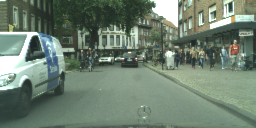
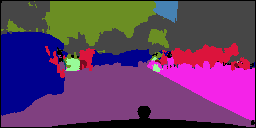
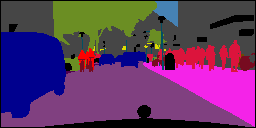

In [298]:
# Draw a random sample
input, truth = random.choice(ds_split["val"])

# Push through our network
model = model.cpu()
output = model(input.unsqueeze(0))

# Display the input, output and truth tensors
template_table = '<table><thead><tr><th>Tensor</th><th>Shape</th><th>Image</th></tr></thead><tbody>{0}</tbody></table>'
template_row = '<tr><td>{0}</td><td>{1}</td><td><img src="data:image/png;base64,{2}"/></td></tr>'

input_img = TF.to_pil_image(input)
output_img = ds_split["val"].to_image(ds_split["val"].masks_to_indices(output).squeeze(0))
truth_img = ds_split["val"].to_image(truth)

rows = []
for name, tensor, img in [('Input', input, input_img), ('Output', output, output_img), ('Target', truth, truth_img)]:
    with BytesIO() as b: 
        img.save(b, format='png')
        rows.append(template_row.format(name, list(tensor.shape), b64encode(b.getvalue()).decode('utf-8')))

# Render HTML table
table = template_table.format(''.join(rows))
display(HTML(table))

## Troubleshooting

###### There is not enough memory on my GPU to define any practical network.
We already downsampled the images in the preprocessing section of the notebook. Before downsampling further, try reducing your `batch_size` on the `Trainer` class.

###### My assignment partner keeps overwriting my changes
Consider splitting up the notebook and your networks into multiple python files and using a Git repository for version control.

###### There is not enough memory on my PC to store the dataset
Connect a USB-drive and point the `dir_data` variable to this location.

_Created by Kurt Stolle, last modified 2021-03-14_